In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "big"
enable_aug = False
enable_aug3 = False
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-big-enable_aug-False-enable_aug3-False-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

199999


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

199999
199999
2021
2021


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


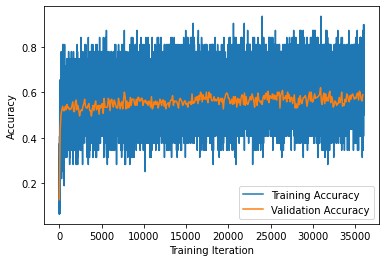

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.236 Validation Loss: 2.224 Accuracy: 0.117 Validation Accuracy: 0.086:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.232 Validation Loss: 2.224 Accuracy: 0.121 Validation Accuracy: 0.086:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.235 Validation Loss: 2.224 Accuracy: 0.120 Validation Accuracy: 0.086:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.233 Validation Loss: 2.224 Accuracy: 0.119 Validation Accuracy: 0.086:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.230 Validation Loss: 2.224 Accuracy: 0.127 Validation Accuracy: 0.086:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.229 Validation Loss: 2.224 Accuracy: 0.129 Validation Accuracy: 0.086:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.229 Validation Loss: 2.224 Accuracy: 0.129 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 6 Loss: 2.229 Validation Loss: 2.224 Accuracy: 0.126 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 7 Loss: 2.229 Validation Loss: 2.224 Accuracy: 0.125 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 8 Loss: 2.229 Validation Loss: 2.224 Accuracy: 0.119 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 9 Loss: 2.229 Validation Loss: 2.224 Accuracy: 0.118 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 10 Loss: 2.230 Validation Loss: 2.224 Accuracy: 0.115 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 11 Loss: 2.229 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 12 Loss: 2.228 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 13 Loss: 2.227 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 14 Loss: 2.226 Validation Loss: 2.224 Accuracy: 0.113 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 15 Loss: 2.227 Validation Loss: 2.224 Accuracy: 0.109 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 16 Loss: 2.228 Validation Loss: 2.224 Accuracy: 0.105 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 17 Loss: 2.227 Validation Loss: 2.224 Accuracy: 0.103 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 18 Loss: 2.226 Validation Loss: 2.224 Accuracy: 0.111 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 19 Loss: 2.225 Validation Loss: 2.224 Accuracy: 0.115 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 20 Loss: 2.225 Validation Loss: 2.224 Accuracy: 0.118 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 21 Loss: 2.225 Validation Loss: 2.224 Accuracy: 0.113 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 22 Loss: 2.223 Validation Loss: 2.224 Accuracy: 0.109 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 23 Loss: 2.223 Validation Loss: 2.224 Accuracy: 0.111 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 24 Loss: 2.222 Validation Loss: 2.224 Accuracy: 0.105 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 25 Loss: 2.222 Validation Loss: 2.224 Accuracy: 0.105 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 26 Loss: 2.221 Validation Loss: 2.224 Accuracy: 0.108 Validation Accuracy: 0.086:   0%|          | 6/1563 [00:00<00:27, 57.41it/s]

Epoch: 0 Iteration: 26 Loss: 2.221 Validation Loss: 2.224 Accuracy: 0.108 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 27 Loss: 2.220 Validation Loss: 2.224 Accuracy: 0.107 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 28 Loss: 2.219 Validation Loss: 2.224 Accuracy: 0.104 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 29 Loss: 2.219 Validation Loss: 2.224 Accuracy: 0.099 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 30 Loss: 2.217 Validation Loss: 2.224 Accuracy: 0.102 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 31 Loss: 2.217 Validation Loss: 2.224 Accuracy: 0.103 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 32 Loss: 2.217 Validation Loss: 2.224 Accuracy: 0.109 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 33 Loss: 2.217 Validation Loss: 2.224 Accuracy: 0.102 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 34 Loss: 2.217 Validation Loss: 2.224 Accuracy: 0.108 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 35 Loss: 2.215 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 36 Loss: 2.214 Validation Loss: 2.224 Accuracy: 0.113 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 37 Loss: 2.213 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 38 Loss: 2.214 Validation Loss: 2.224 Accuracy: 0.112 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 39 Loss: 2.214 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 40 Loss: 2.213 Validation Loss: 2.224 Accuracy: 0.117 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 41 Loss: 2.212 Validation Loss: 2.224 Accuracy: 0.120 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 42 Loss: 2.212 Validation Loss: 2.224 Accuracy: 0.117 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 43 Loss: 2.212 Validation Loss: 2.224 Accuracy: 0.120 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 44 Loss: 2.211 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 45 Loss: 2.211 Validation Loss: 2.224 Accuracy: 0.110 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 46 Loss: 2.212 Validation Loss: 2.224 Accuracy: 0.109 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 47 Loss: 2.212 Validation Loss: 2.224 Accuracy: 0.112 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 48 Loss: 2.211 Validation Loss: 2.224 Accuracy: 0.113 Validation Accuracy: 0.086:   2%|▏         | 27/1563 [00:00<00:10, 144.27it/s]

Epoch: 0 Iteration: 48 Loss: 2.211 Validation Loss: 2.224 Accuracy: 0.113 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 49 Loss: 2.210 Validation Loss: 2.224 Accuracy: 0.114 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 50 Loss: 2.210 Validation Loss: 2.224 Accuracy: 0.105 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 51 Loss: 2.210 Validation Loss: 2.224 Accuracy: 0.106 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 52 Loss: 2.209 Validation Loss: 2.224 Accuracy: 0.105 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 53 Loss: 2.208 Validation Loss: 2.224 Accuracy: 0.111 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 54 Loss: 2.207 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 55 Loss: 2.207 Validation Loss: 2.224 Accuracy: 0.115 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 56 Loss: 2.206 Validation Loss: 2.224 Accuracy: 0.121 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 57 Loss: 2.205 Validation Loss: 2.224 Accuracy: 0.121 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 58 Loss: 2.202 Validation Loss: 2.224 Accuracy: 0.126 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 59 Loss: 2.201 Validation Loss: 2.224 Accuracy: 0.127 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 60 Loss: 2.201 Validation Loss: 2.224 Accuracy: 0.133 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 61 Loss: 2.200 Validation Loss: 2.224 Accuracy: 0.137 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 62 Loss: 2.200 Validation Loss: 2.224 Accuracy: 0.131 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 63 Loss: 2.199 Validation Loss: 2.224 Accuracy: 0.127 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 64 Loss: 2.199 Validation Loss: 2.224 Accuracy: 0.123 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 65 Loss: 2.198 Validation Loss: 2.224 Accuracy: 0.126 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 66 Loss: 2.198 Validation Loss: 2.224 Accuracy: 0.125 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 67 Loss: 2.196 Validation Loss: 2.224 Accuracy: 0.123 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 68 Loss: 2.196 Validation Loss: 2.224 Accuracy: 0.125 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 69 Loss: 2.196 Validation Loss: 2.224 Accuracy: 0.120 Validation Accuracy: 0.086:   3%|▎         | 49/1563 [00:00<00:08, 176.50it/s]

Epoch: 0 Iteration: 69 Loss: 2.196 Validation Loss: 2.224 Accuracy: 0.120 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 70 Loss: 2.196 Validation Loss: 2.224 Accuracy: 0.119 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 71 Loss: 2.196 Validation Loss: 2.224 Accuracy: 0.116 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 72 Loss: 2.195 Validation Loss: 2.224 Accuracy: 0.125 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 73 Loss: 2.194 Validation Loss: 2.224 Accuracy: 0.132 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 74 Loss: 2.193 Validation Loss: 2.224 Accuracy: 0.134 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 75 Loss: 2.193 Validation Loss: 2.224 Accuracy: 0.136 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 76 Loss: 2.192 Validation Loss: 2.224 Accuracy: 0.138 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 77 Loss: 2.193 Validation Loss: 2.224 Accuracy: 0.142 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 78 Loss: 2.193 Validation Loss: 2.224 Accuracy: 0.138 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 79 Loss: 2.193 Validation Loss: 2.224 Accuracy: 0.140 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 80 Loss: 2.192 Validation Loss: 2.224 Accuracy: 0.148 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 81 Loss: 2.191 Validation Loss: 2.224 Accuracy: 0.151 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 82 Loss: 2.190 Validation Loss: 2.224 Accuracy: 0.148 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 83 Loss: 2.190 Validation Loss: 2.224 Accuracy: 0.142 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 84 Loss: 2.189 Validation Loss: 2.224 Accuracy: 0.141 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 85 Loss: 2.189 Validation Loss: 2.224 Accuracy: 0.140 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 86 Loss: 2.188 Validation Loss: 2.224 Accuracy: 0.137 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 87 Loss: 2.188 Validation Loss: 2.224 Accuracy: 0.129 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 88 Loss: 2.187 Validation Loss: 2.224 Accuracy: 0.129 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 89 Loss: 2.186 Validation Loss: 2.224 Accuracy: 0.129 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 90 Loss: 2.185 Validation Loss: 2.224 Accuracy: 0.123 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 91 Loss: 2.184 Validation Loss: 2.224 Accuracy: 0.124 Validation Accuracy: 0.086:   4%|▍         | 70/1563 [00:00<00:07, 188.50it/s]

Epoch: 0 Iteration: 91 Loss: 2.184 Validation Loss: 2.224 Accuracy: 0.124 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 92 Loss: 2.184 Validation Loss: 2.224 Accuracy: 0.128 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 93 Loss: 2.184 Validation Loss: 2.224 Accuracy: 0.131 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 94 Loss: 2.183 Validation Loss: 2.224 Accuracy: 0.134 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 95 Loss: 2.183 Validation Loss: 2.224 Accuracy: 0.134 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 96 Loss: 2.183 Validation Loss: 2.224 Accuracy: 0.137 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 97 Loss: 2.182 Validation Loss: 2.224 Accuracy: 0.144 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 98 Loss: 2.181 Validation Loss: 2.224 Accuracy: 0.144 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 99 Loss: 2.180 Validation Loss: 2.224 Accuracy: 0.150 Validation Accuracy: 0.086:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 100 Loss: 2.181 Validation Loss: 2.170 Accuracy: 0.149 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 101 Loss: 2.180 Validation Loss: 2.170 Accuracy: 0.148 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 102 Loss: 2.179 Validation Loss: 2.170 Accuracy: 0.160 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 103 Loss: 2.178 Validation Loss: 2.170 Accuracy: 0.166 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 104 Loss: 2.177 Validation Loss: 2.170 Accuracy: 0.166 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 105 Loss: 2.177 Validation Loss: 2.170 Accuracy: 0.168 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 106 Loss: 2.176 Validation Loss: 2.170 Accuracy: 0.170 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 107 Loss: 2.175 Validation Loss: 2.170 Accuracy: 0.170 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 108 Loss: 2.174 Validation Loss: 2.170 Accuracy: 0.170 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 109 Loss: 2.174 Validation Loss: 2.170 Accuracy: 0.166 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 110 Loss: 2.173 Validation Loss: 2.170 Accuracy: 0.169 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 111 Loss: 2.172 Validation Loss: 2.170 Accuracy: 0.168 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 112 Loss: 2.173 Validation Loss: 2.170 Accuracy: 0.153 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 113 Loss: 2.172 Validation Loss: 2.170 Accuracy: 0.148 Validation Accuracy: 0.115:   6%|▌         | 92/1563 [00:00<00:07, 197.76it/s]

Epoch: 0 Iteration: 113 Loss: 2.172 Validation Loss: 2.170 Accuracy: 0.148 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 114 Loss: 2.171 Validation Loss: 2.170 Accuracy: 0.152 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 115 Loss: 2.170 Validation Loss: 2.170 Accuracy: 0.155 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 116 Loss: 2.169 Validation Loss: 2.170 Accuracy: 0.169 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 117 Loss: 2.169 Validation Loss: 2.170 Accuracy: 0.168 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 118 Loss: 2.169 Validation Loss: 2.170 Accuracy: 0.177 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 119 Loss: 2.168 Validation Loss: 2.170 Accuracy: 0.178 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 120 Loss: 2.167 Validation Loss: 2.170 Accuracy: 0.181 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 121 Loss: 2.167 Validation Loss: 2.170 Accuracy: 0.191 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 122 Loss: 2.167 Validation Loss: 2.170 Accuracy: 0.197 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 123 Loss: 2.166 Validation Loss: 2.170 Accuracy: 0.199 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 124 Loss: 2.166 Validation Loss: 2.170 Accuracy: 0.198 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 125 Loss: 2.165 Validation Loss: 2.170 Accuracy: 0.202 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 126 Loss: 2.164 Validation Loss: 2.170 Accuracy: 0.197 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 127 Loss: 2.163 Validation Loss: 2.170 Accuracy: 0.204 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 128 Loss: 2.163 Validation Loss: 2.170 Accuracy: 0.202 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 129 Loss: 2.163 Validation Loss: 2.170 Accuracy: 0.199 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 130 Loss: 2.162 Validation Loss: 2.170 Accuracy: 0.202 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 131 Loss: 2.162 Validation Loss: 2.170 Accuracy: 0.195 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 132 Loss: 2.161 Validation Loss: 2.170 Accuracy: 0.195 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 133 Loss: 2.160 Validation Loss: 2.170 Accuracy: 0.202 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 134 Loss: 2.159 Validation Loss: 2.170 Accuracy: 0.211 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 135 Loss: 2.158 Validation Loss: 2.170 Accuracy: 0.209 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 136 Loss: 2.158 Validation Loss: 2.170 Accuracy: 0.201 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 137 Loss: 2.157 Validation Loss: 2.170 Accuracy: 0.196 Validation Accuracy: 0.115:   7%|▋         | 114/1563 [00:00<00:07, 203.46it/s]

Epoch: 0 Iteration: 137 Loss: 2.157 Validation Loss: 2.170 Accuracy: 0.196 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 138 Loss: 2.157 Validation Loss: 2.170 Accuracy: 0.202 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 139 Loss: 2.157 Validation Loss: 2.170 Accuracy: 0.209 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 140 Loss: 2.155 Validation Loss: 2.170 Accuracy: 0.209 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 141 Loss: 2.154 Validation Loss: 2.170 Accuracy: 0.216 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 142 Loss: 2.154 Validation Loss: 2.170 Accuracy: 0.212 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 143 Loss: 2.153 Validation Loss: 2.170 Accuracy: 0.216 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 144 Loss: 2.153 Validation Loss: 2.170 Accuracy: 0.210 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 145 Loss: 2.153 Validation Loss: 2.170 Accuracy: 0.216 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 146 Loss: 2.152 Validation Loss: 2.170 Accuracy: 0.223 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 147 Loss: 2.152 Validation Loss: 2.170 Accuracy: 0.227 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 148 Loss: 2.151 Validation Loss: 2.170 Accuracy: 0.237 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 149 Loss: 2.149 Validation Loss: 2.170 Accuracy: 0.237 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 150 Loss: 2.148 Validation Loss: 2.170 Accuracy: 0.240 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 151 Loss: 2.146 Validation Loss: 2.170 Accuracy: 0.241 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 152 Loss: 2.145 Validation Loss: 2.170 Accuracy: 0.255 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 153 Loss: 2.145 Validation Loss: 2.170 Accuracy: 0.251 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 154 Loss: 2.145 Validation Loss: 2.170 Accuracy: 0.246 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 155 Loss: 2.144 Validation Loss: 2.170 Accuracy: 0.245 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 156 Loss: 2.144 Validation Loss: 2.170 Accuracy: 0.235 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 157 Loss: 2.143 Validation Loss: 2.170 Accuracy: 0.239 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 158 Loss: 2.143 Validation Loss: 2.170 Accuracy: 0.232 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 159 Loss: 2.142 Validation Loss: 2.170 Accuracy: 0.230 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 160 Loss: 2.141 Validation Loss: 2.170 Accuracy: 0.237 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 161 Loss: 2.141 Validation Loss: 2.170 Accuracy: 0.234 Validation Accuracy: 0.115:   9%|▉         | 138/1563 [00:00<00:06, 212.56it/s]

Epoch: 0 Iteration: 161 Loss: 2.141 Validation Loss: 2.170 Accuracy: 0.234 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 162 Loss: 2.141 Validation Loss: 2.170 Accuracy: 0.224 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 163 Loss: 2.140 Validation Loss: 2.170 Accuracy: 0.220 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 164 Loss: 2.138 Validation Loss: 2.170 Accuracy: 0.238 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 165 Loss: 2.136 Validation Loss: 2.170 Accuracy: 0.241 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 166 Loss: 2.136 Validation Loss: 2.170 Accuracy: 0.248 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 167 Loss: 2.136 Validation Loss: 2.170 Accuracy: 0.240 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 168 Loss: 2.135 Validation Loss: 2.170 Accuracy: 0.247 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 169 Loss: 2.134 Validation Loss: 2.170 Accuracy: 0.252 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 170 Loss: 2.134 Validation Loss: 2.170 Accuracy: 0.244 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 171 Loss: 2.134 Validation Loss: 2.170 Accuracy: 0.248 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 172 Loss: 2.134 Validation Loss: 2.170 Accuracy: 0.252 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 173 Loss: 2.133 Validation Loss: 2.170 Accuracy: 0.256 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 174 Loss: 2.133 Validation Loss: 2.170 Accuracy: 0.242 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 175 Loss: 2.132 Validation Loss: 2.170 Accuracy: 0.242 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 176 Loss: 2.130 Validation Loss: 2.170 Accuracy: 0.252 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 177 Loss: 2.130 Validation Loss: 2.170 Accuracy: 0.253 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 178 Loss: 2.130 Validation Loss: 2.170 Accuracy: 0.242 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 179 Loss: 2.129 Validation Loss: 2.170 Accuracy: 0.240 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 180 Loss: 2.128 Validation Loss: 2.170 Accuracy: 0.241 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 181 Loss: 2.127 Validation Loss: 2.170 Accuracy: 0.247 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 182 Loss: 2.126 Validation Loss: 2.170 Accuracy: 0.248 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 183 Loss: 2.124 Validation Loss: 2.170 Accuracy: 0.248 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 184 Loss: 2.125 Validation Loss: 2.170 Accuracy: 0.254 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 185 Loss: 2.123 Validation Loss: 2.170 Accuracy: 0.255 Validation Accuracy: 0.115:  10%|█         | 162/1563 [00:00<00:06, 218.44it/s]

Epoch: 0 Iteration: 185 Loss: 2.123 Validation Loss: 2.170 Accuracy: 0.255 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 186 Loss: 2.122 Validation Loss: 2.170 Accuracy: 0.247 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 187 Loss: 2.122 Validation Loss: 2.170 Accuracy: 0.256 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 188 Loss: 2.122 Validation Loss: 2.170 Accuracy: 0.261 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 189 Loss: 2.122 Validation Loss: 2.170 Accuracy: 0.262 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 190 Loss: 2.122 Validation Loss: 2.170 Accuracy: 0.260 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 191 Loss: 2.121 Validation Loss: 2.170 Accuracy: 0.254 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 192 Loss: 2.121 Validation Loss: 2.170 Accuracy: 0.253 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 193 Loss: 2.121 Validation Loss: 2.170 Accuracy: 0.250 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 194 Loss: 2.120 Validation Loss: 2.170 Accuracy: 0.249 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 195 Loss: 2.120 Validation Loss: 2.170 Accuracy: 0.249 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 196 Loss: 2.120 Validation Loss: 2.170 Accuracy: 0.255 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 197 Loss: 2.119 Validation Loss: 2.170 Accuracy: 0.259 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 198 Loss: 2.117 Validation Loss: 2.170 Accuracy: 0.264 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 199 Loss: 2.116 Validation Loss: 2.170 Accuracy: 0.272 Validation Accuracy: 0.115:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 200 Loss: 2.117 Validation Loss: 2.122 Accuracy: 0.269 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:00<00:06, 222.53it/s]

Epoch: 0 Iteration: 201 Loss: 2.118 Validation Loss: 2.122 Accuracy: 0.270 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 202 Loss: 2.117 Validation Loss: 2.122 Accuracy: 0.274 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 203 Loss: 2.118 Validation Loss: 2.122 Accuracy: 0.283 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 204 Loss: 2.117 Validation Loss: 2.122 Accuracy: 0.289 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 205 Loss: 2.117 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 206 Loss: 2.116 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 207 Loss: 2.114 Validation Loss: 2.122 Accuracy: 0.286 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 208 Loss: 2.114 Validation Loss: 2.122 Accuracy: 0.283 Validation Accuracy: 0.151:  12%|█▏        | 186/1563 [00:01<00:06, 222.53it/s]

Epoch: 0 Iteration: 208 Loss: 2.114 Validation Loss: 2.122 Accuracy: 0.283 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 209 Loss: 2.114 Validation Loss: 2.122 Accuracy: 0.273 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 210 Loss: 2.113 Validation Loss: 2.122 Accuracy: 0.281 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 211 Loss: 2.113 Validation Loss: 2.122 Accuracy: 0.275 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 212 Loss: 2.112 Validation Loss: 2.122 Accuracy: 0.277 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 213 Loss: 2.111 Validation Loss: 2.122 Accuracy: 0.266 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 214 Loss: 2.111 Validation Loss: 2.122 Accuracy: 0.263 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 215 Loss: 2.111 Validation Loss: 2.122 Accuracy: 0.258 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 216 Loss: 2.110 Validation Loss: 2.122 Accuracy: 0.252 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 217 Loss: 2.110 Validation Loss: 2.122 Accuracy: 0.246 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 218 Loss: 2.111 Validation Loss: 2.122 Accuracy: 0.245 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 219 Loss: 2.110 Validation Loss: 2.122 Accuracy: 0.252 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 220 Loss: 2.108 Validation Loss: 2.122 Accuracy: 0.252 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 221 Loss: 2.107 Validation Loss: 2.122 Accuracy: 0.263 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 222 Loss: 2.106 Validation Loss: 2.122 Accuracy: 0.265 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 223 Loss: 2.105 Validation Loss: 2.122 Accuracy: 0.273 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 224 Loss: 2.106 Validation Loss: 2.122 Accuracy: 0.271 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 225 Loss: 2.106 Validation Loss: 2.122 Accuracy: 0.279 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 226 Loss: 2.106 Validation Loss: 2.122 Accuracy: 0.286 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 227 Loss: 2.104 Validation Loss: 2.122 Accuracy: 0.291 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 228 Loss: 2.104 Validation Loss: 2.122 Accuracy: 0.289 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 229 Loss: 2.103 Validation Loss: 2.122 Accuracy: 0.294 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 230 Loss: 2.102 Validation Loss: 2.122 Accuracy: 0.296 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 231 Loss: 2.102 Validation Loss: 2.122 Accuracy: 0.292 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 232 Loss: 2.103 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  13%|█▎        | 209/1563 [00:01<00:06, 221.21it/s]

Epoch: 0 Iteration: 232 Loss: 2.103 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 233 Loss: 2.102 Validation Loss: 2.122 Accuracy: 0.283 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 234 Loss: 2.101 Validation Loss: 2.122 Accuracy: 0.290 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 235 Loss: 2.099 Validation Loss: 2.122 Accuracy: 0.293 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 236 Loss: 2.098 Validation Loss: 2.122 Accuracy: 0.292 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 237 Loss: 2.097 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 238 Loss: 2.096 Validation Loss: 2.122 Accuracy: 0.289 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 239 Loss: 2.097 Validation Loss: 2.122 Accuracy: 0.285 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 240 Loss: 2.097 Validation Loss: 2.122 Accuracy: 0.276 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 241 Loss: 2.097 Validation Loss: 2.122 Accuracy: 0.272 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 242 Loss: 2.098 Validation Loss: 2.122 Accuracy: 0.277 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 243 Loss: 2.099 Validation Loss: 2.122 Accuracy: 0.276 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 244 Loss: 2.098 Validation Loss: 2.122 Accuracy: 0.270 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 245 Loss: 2.098 Validation Loss: 2.122 Accuracy: 0.264 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 246 Loss: 2.098 Validation Loss: 2.122 Accuracy: 0.263 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 247 Loss: 2.100 Validation Loss: 2.122 Accuracy: 0.266 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 248 Loss: 2.099 Validation Loss: 2.122 Accuracy: 0.265 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 249 Loss: 2.098 Validation Loss: 2.122 Accuracy: 0.266 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 250 Loss: 2.097 Validation Loss: 2.122 Accuracy: 0.272 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 251 Loss: 2.096 Validation Loss: 2.122 Accuracy: 0.278 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 252 Loss: 2.094 Validation Loss: 2.122 Accuracy: 0.277 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 253 Loss: 2.094 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 254 Loss: 2.094 Validation Loss: 2.122 Accuracy: 0.292 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 255 Loss: 2.093 Validation Loss: 2.122 Accuracy: 0.300 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 256 Loss: 2.093 Validation Loss: 2.122 Accuracy: 0.305 Validation Accuracy: 0.151:  15%|█▍        | 233/1563 [00:01<00:05, 224.07it/s]

Epoch: 0 Iteration: 256 Loss: 2.093 Validation Loss: 2.122 Accuracy: 0.305 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 257 Loss: 2.093 Validation Loss: 2.122 Accuracy: 0.306 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 258 Loss: 2.092 Validation Loss: 2.122 Accuracy: 0.316 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 259 Loss: 2.091 Validation Loss: 2.122 Accuracy: 0.313 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 260 Loss: 2.090 Validation Loss: 2.122 Accuracy: 0.316 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 261 Loss: 2.088 Validation Loss: 2.122 Accuracy: 0.323 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 262 Loss: 2.088 Validation Loss: 2.122 Accuracy: 0.309 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 263 Loss: 2.087 Validation Loss: 2.122 Accuracy: 0.301 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 264 Loss: 2.086 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 265 Loss: 2.086 Validation Loss: 2.122 Accuracy: 0.275 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 266 Loss: 2.086 Validation Loss: 2.122 Accuracy: 0.264 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 267 Loss: 2.082 Validation Loss: 2.122 Accuracy: 0.271 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 268 Loss: 2.082 Validation Loss: 2.122 Accuracy: 0.270 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 269 Loss: 2.081 Validation Loss: 2.122 Accuracy: 0.274 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 270 Loss: 2.082 Validation Loss: 2.122 Accuracy: 0.271 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 271 Loss: 2.081 Validation Loss: 2.122 Accuracy: 0.263 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 272 Loss: 2.080 Validation Loss: 2.122 Accuracy: 0.280 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 273 Loss: 2.079 Validation Loss: 2.122 Accuracy: 0.286 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 274 Loss: 2.078 Validation Loss: 2.122 Accuracy: 0.294 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 275 Loss: 2.078 Validation Loss: 2.122 Accuracy: 0.291 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 276 Loss: 2.079 Validation Loss: 2.122 Accuracy: 0.297 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 277 Loss: 2.079 Validation Loss: 2.122 Accuracy: 0.287 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 278 Loss: 2.078 Validation Loss: 2.122 Accuracy: 0.280 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 279 Loss: 2.078 Validation Loss: 2.122 Accuracy: 0.272 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 280 Loss: 2.077 Validation Loss: 2.122 Accuracy: 0.276 Validation Accuracy: 0.151:  16%|█▋        | 257/1563 [00:01<00:05, 226.05it/s]

Epoch: 0 Iteration: 280 Loss: 2.077 Validation Loss: 2.122 Accuracy: 0.276 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 281 Loss: 2.078 Validation Loss: 2.122 Accuracy: 0.276 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 282 Loss: 2.077 Validation Loss: 2.122 Accuracy: 0.271 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 283 Loss: 2.076 Validation Loss: 2.122 Accuracy: 0.273 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 284 Loss: 2.074 Validation Loss: 2.122 Accuracy: 0.278 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 285 Loss: 2.073 Validation Loss: 2.122 Accuracy: 0.285 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 286 Loss: 2.071 Validation Loss: 2.122 Accuracy: 0.284 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 287 Loss: 2.074 Validation Loss: 2.122 Accuracy: 0.281 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 288 Loss: 2.075 Validation Loss: 2.122 Accuracy: 0.284 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 289 Loss: 2.074 Validation Loss: 2.122 Accuracy: 0.290 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 290 Loss: 2.072 Validation Loss: 2.122 Accuracy: 0.285 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 291 Loss: 2.072 Validation Loss: 2.122 Accuracy: 0.282 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 292 Loss: 2.072 Validation Loss: 2.122 Accuracy: 0.283 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 293 Loss: 2.071 Validation Loss: 2.122 Accuracy: 0.286 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 294 Loss: 2.069 Validation Loss: 2.122 Accuracy: 0.291 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 295 Loss: 2.068 Validation Loss: 2.122 Accuracy: 0.299 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 296 Loss: 2.067 Validation Loss: 2.122 Accuracy: 0.303 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 297 Loss: 2.066 Validation Loss: 2.122 Accuracy: 0.315 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 298 Loss: 2.066 Validation Loss: 2.122 Accuracy: 0.319 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 299 Loss: 2.064 Validation Loss: 2.122 Accuracy: 0.320 Validation Accuracy: 0.151:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 300 Loss: 2.064 Validation Loss: 2.074 Accuracy: 0.329 Validation Accuracy: 0.174:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 301 Loss: 2.063 Validation Loss: 2.074 Accuracy: 0.333 Validation Accuracy: 0.174:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 302 Loss: 2.061 Validation Loss: 2.074 Accuracy: 0.338 Validation Accuracy: 0.174:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 303 Loss: 2.061 Validation Loss: 2.074 Accuracy: 0.330 Validation Accuracy: 0.174:  18%|█▊        | 281/1563 [00:01<00:05, 227.79it/s]

Epoch: 0 Iteration: 303 Loss: 2.061 Validation Loss: 2.074 Accuracy: 0.330 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 304 Loss: 2.061 Validation Loss: 2.074 Accuracy: 0.320 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 305 Loss: 2.059 Validation Loss: 2.074 Accuracy: 0.315 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 306 Loss: 2.059 Validation Loss: 2.074 Accuracy: 0.313 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 307 Loss: 2.058 Validation Loss: 2.074 Accuracy: 0.314 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 308 Loss: 2.056 Validation Loss: 2.074 Accuracy: 0.319 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 309 Loss: 2.055 Validation Loss: 2.074 Accuracy: 0.321 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 310 Loss: 2.057 Validation Loss: 2.074 Accuracy: 0.309 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 311 Loss: 2.055 Validation Loss: 2.074 Accuracy: 0.308 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 312 Loss: 2.054 Validation Loss: 2.074 Accuracy: 0.304 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 313 Loss: 2.053 Validation Loss: 2.074 Accuracy: 0.303 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 314 Loss: 2.054 Validation Loss: 2.074 Accuracy: 0.309 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 315 Loss: 2.054 Validation Loss: 2.074 Accuracy: 0.313 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 316 Loss: 2.051 Validation Loss: 2.074 Accuracy: 0.321 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 317 Loss: 2.051 Validation Loss: 2.074 Accuracy: 0.312 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 318 Loss: 2.051 Validation Loss: 2.074 Accuracy: 0.300 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 319 Loss: 2.050 Validation Loss: 2.074 Accuracy: 0.297 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 320 Loss: 2.050 Validation Loss: 2.074 Accuracy: 0.302 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 321 Loss: 2.049 Validation Loss: 2.074 Accuracy: 0.302 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 322 Loss: 2.049 Validation Loss: 2.074 Accuracy: 0.299 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 323 Loss: 2.048 Validation Loss: 2.074 Accuracy: 0.305 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 324 Loss: 2.046 Validation Loss: 2.074 Accuracy: 0.304 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 325 Loss: 2.047 Validation Loss: 2.074 Accuracy: 0.295 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 326 Loss: 2.048 Validation Loss: 2.074 Accuracy: 0.287 Validation Accuracy: 0.174:  19%|█▉        | 304/1563 [00:01<00:05, 224.03it/s]

Epoch: 0 Iteration: 326 Loss: 2.048 Validation Loss: 2.074 Accuracy: 0.287 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 327 Loss: 2.047 Validation Loss: 2.074 Accuracy: 0.291 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 328 Loss: 2.046 Validation Loss: 2.074 Accuracy: 0.291 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 329 Loss: 2.046 Validation Loss: 2.074 Accuracy: 0.290 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 330 Loss: 2.044 Validation Loss: 2.074 Accuracy: 0.290 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 331 Loss: 2.043 Validation Loss: 2.074 Accuracy: 0.297 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 332 Loss: 2.044 Validation Loss: 2.074 Accuracy: 0.301 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 333 Loss: 2.045 Validation Loss: 2.074 Accuracy: 0.295 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 334 Loss: 2.044 Validation Loss: 2.074 Accuracy: 0.293 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 335 Loss: 2.043 Validation Loss: 2.074 Accuracy: 0.297 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 336 Loss: 2.044 Validation Loss: 2.074 Accuracy: 0.305 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 337 Loss: 2.043 Validation Loss: 2.074 Accuracy: 0.312 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 338 Loss: 2.041 Validation Loss: 2.074 Accuracy: 0.308 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 339 Loss: 2.040 Validation Loss: 2.074 Accuracy: 0.315 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 340 Loss: 2.039 Validation Loss: 2.074 Accuracy: 0.314 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 341 Loss: 2.037 Validation Loss: 2.074 Accuracy: 0.314 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 342 Loss: 2.036 Validation Loss: 2.074 Accuracy: 0.313 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 343 Loss: 2.038 Validation Loss: 2.074 Accuracy: 0.317 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 344 Loss: 2.038 Validation Loss: 2.074 Accuracy: 0.314 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 345 Loss: 2.036 Validation Loss: 2.074 Accuracy: 0.321 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 346 Loss: 2.034 Validation Loss: 2.074 Accuracy: 0.316 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 347 Loss: 2.030 Validation Loss: 2.074 Accuracy: 0.317 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 348 Loss: 2.030 Validation Loss: 2.074 Accuracy: 0.327 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 349 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.326 Validation Accuracy: 0.174:  21%|██        | 327/1563 [00:01<00:05, 225.50it/s]

Epoch: 0 Iteration: 349 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.326 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 350 Loss: 2.030 Validation Loss: 2.074 Accuracy: 0.323 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 351 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.322 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 352 Loss: 2.030 Validation Loss: 2.074 Accuracy: 0.320 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 353 Loss: 2.028 Validation Loss: 2.074 Accuracy: 0.316 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 354 Loss: 2.028 Validation Loss: 2.074 Accuracy: 0.330 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 355 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.327 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 356 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.325 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 357 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.315 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 358 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.318 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 359 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.317 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 360 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.316 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 361 Loss: 2.031 Validation Loss: 2.074 Accuracy: 0.310 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 362 Loss: 2.030 Validation Loss: 2.074 Accuracy: 0.309 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 363 Loss: 2.029 Validation Loss: 2.074 Accuracy: 0.313 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 364 Loss: 2.028 Validation Loss: 2.074 Accuracy: 0.302 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 365 Loss: 2.026 Validation Loss: 2.074 Accuracy: 0.308 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 366 Loss: 2.024 Validation Loss: 2.074 Accuracy: 0.312 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 367 Loss: 2.027 Validation Loss: 2.074 Accuracy: 0.312 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 368 Loss: 2.025 Validation Loss: 2.074 Accuracy: 0.310 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 369 Loss: 2.024 Validation Loss: 2.074 Accuracy: 0.309 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 370 Loss: 2.023 Validation Loss: 2.074 Accuracy: 0.314 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 371 Loss: 2.022 Validation Loss: 2.074 Accuracy: 0.326 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 372 Loss: 2.019 Validation Loss: 2.074 Accuracy: 0.333 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 373 Loss: 2.018 Validation Loss: 2.074 Accuracy: 0.334 Validation Accuracy: 0.174:  22%|██▏       | 350/1563 [00:01<00:05, 226.76it/s]

Epoch: 0 Iteration: 373 Loss: 2.018 Validation Loss: 2.074 Accuracy: 0.334 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 374 Loss: 2.016 Validation Loss: 2.074 Accuracy: 0.337 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 375 Loss: 2.015 Validation Loss: 2.074 Accuracy: 0.332 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 376 Loss: 2.013 Validation Loss: 2.074 Accuracy: 0.334 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 377 Loss: 2.012 Validation Loss: 2.074 Accuracy: 0.341 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 378 Loss: 2.011 Validation Loss: 2.074 Accuracy: 0.345 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 379 Loss: 2.010 Validation Loss: 2.074 Accuracy: 0.344 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 380 Loss: 2.009 Validation Loss: 2.074 Accuracy: 0.345 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 381 Loss: 2.006 Validation Loss: 2.074 Accuracy: 0.348 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 382 Loss: 2.007 Validation Loss: 2.074 Accuracy: 0.341 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 383 Loss: 2.005 Validation Loss: 2.074 Accuracy: 0.341 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 384 Loss: 2.005 Validation Loss: 2.074 Accuracy: 0.338 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 385 Loss: 2.007 Validation Loss: 2.074 Accuracy: 0.342 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 386 Loss: 2.009 Validation Loss: 2.074 Accuracy: 0.337 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 387 Loss: 2.006 Validation Loss: 2.074 Accuracy: 0.339 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 388 Loss: 2.006 Validation Loss: 2.074 Accuracy: 0.336 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 389 Loss: 2.007 Validation Loss: 2.074 Accuracy: 0.333 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 390 Loss: 2.007 Validation Loss: 2.074 Accuracy: 0.323 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 391 Loss: 2.008 Validation Loss: 2.074 Accuracy: 0.312 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 392 Loss: 2.010 Validation Loss: 2.074 Accuracy: 0.312 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 393 Loss: 2.011 Validation Loss: 2.074 Accuracy: 0.309 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 394 Loss: 2.010 Validation Loss: 2.074 Accuracy: 0.317 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 395 Loss: 2.009 Validation Loss: 2.074 Accuracy: 0.311 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 396 Loss: 2.009 Validation Loss: 2.074 Accuracy: 0.319 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 397 Loss: 2.007 Validation Loss: 2.074 Accuracy: 0.322 Validation Accuracy: 0.174:  24%|██▍       | 374/1563 [00:01<00:05, 228.02it/s]

Epoch: 0 Iteration: 397 Loss: 2.007 Validation Loss: 2.074 Accuracy: 0.322 Validation Accuracy: 0.174:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 398 Loss: 2.009 Validation Loss: 2.074 Accuracy: 0.320 Validation Accuracy: 0.174:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 399 Loss: 2.009 Validation Loss: 2.074 Accuracy: 0.316 Validation Accuracy: 0.174:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 400 Loss: 2.008 Validation Loss: 2.023 Accuracy: 0.328 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 401 Loss: 2.008 Validation Loss: 2.023 Accuracy: 0.327 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 402 Loss: 2.006 Validation Loss: 2.023 Accuracy: 0.334 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 403 Loss: 2.007 Validation Loss: 2.023 Accuracy: 0.338 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 404 Loss: 2.006 Validation Loss: 2.023 Accuracy: 0.335 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 405 Loss: 2.006 Validation Loss: 2.023 Accuracy: 0.331 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 406 Loss: 2.003 Validation Loss: 2.023 Accuracy: 0.329 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 407 Loss: 2.003 Validation Loss: 2.023 Accuracy: 0.320 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 408 Loss: 2.002 Validation Loss: 2.023 Accuracy: 0.324 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 409 Loss: 2.001 Validation Loss: 2.023 Accuracy: 0.331 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 410 Loss: 1.999 Validation Loss: 2.023 Accuracy: 0.331 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 411 Loss: 1.996 Validation Loss: 2.023 Accuracy: 0.342 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 412 Loss: 1.993 Validation Loss: 2.023 Accuracy: 0.351 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 413 Loss: 1.991 Validation Loss: 2.023 Accuracy: 0.361 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 414 Loss: 1.991 Validation Loss: 2.023 Accuracy: 0.368 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 415 Loss: 1.993 Validation Loss: 2.023 Accuracy: 0.368 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 416 Loss: 1.993 Validation Loss: 2.023 Accuracy: 0.365 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 417 Loss: 1.991 Validation Loss: 2.023 Accuracy: 0.377 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 418 Loss: 1.989 Validation Loss: 2.023 Accuracy: 0.369 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 419 Loss: 1.988 Validation Loss: 2.023 Accuracy: 0.366 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 420 Loss: 1.987 Validation Loss: 2.023 Accuracy: 0.368 Validation Accuracy: 0.196:  25%|██▌       | 398/1563 [00:01<00:05, 228.81it/s]

Epoch: 0 Iteration: 420 Loss: 1.987 Validation Loss: 2.023 Accuracy: 0.368 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 421 Loss: 1.988 Validation Loss: 2.023 Accuracy: 0.359 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 422 Loss: 1.989 Validation Loss: 2.023 Accuracy: 0.352 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 423 Loss: 1.988 Validation Loss: 2.023 Accuracy: 0.349 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 424 Loss: 1.989 Validation Loss: 2.023 Accuracy: 0.341 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 425 Loss: 1.987 Validation Loss: 2.023 Accuracy: 0.347 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 426 Loss: 1.988 Validation Loss: 2.023 Accuracy: 0.346 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 427 Loss: 1.984 Validation Loss: 2.023 Accuracy: 0.344 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 428 Loss: 1.984 Validation Loss: 2.023 Accuracy: 0.358 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:01<00:05, 225.38it/s]

Epoch: 0 Iteration: 429 Loss: 1.983 Validation Loss: 2.023 Accuracy: 0.360 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 430 Loss: 1.981 Validation Loss: 2.023 Accuracy: 0.358 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 431 Loss: 1.984 Validation Loss: 2.023 Accuracy: 0.356 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 432 Loss: 1.985 Validation Loss: 2.023 Accuracy: 0.355 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 433 Loss: 1.987 Validation Loss: 2.023 Accuracy: 0.344 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 434 Loss: 1.988 Validation Loss: 2.023 Accuracy: 0.345 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 435 Loss: 1.983 Validation Loss: 2.023 Accuracy: 0.345 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 436 Loss: 1.982 Validation Loss: 2.023 Accuracy: 0.350 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 437 Loss: 1.984 Validation Loss: 2.023 Accuracy: 0.343 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 438 Loss: 1.983 Validation Loss: 2.023 Accuracy: 0.331 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 439 Loss: 1.982 Validation Loss: 2.023 Accuracy: 0.336 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 440 Loss: 1.983 Validation Loss: 2.023 Accuracy: 0.335 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 441 Loss: 1.980 Validation Loss: 2.023 Accuracy: 0.340 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 442 Loss: 1.979 Validation Loss: 2.023 Accuracy: 0.345 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 443 Loss: 1.976 Validation Loss: 2.023 Accuracy: 0.349 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 444 Loss: 1.975 Validation Loss: 2.023 Accuracy: 0.348 Validation Accuracy: 0.196:  27%|██▋       | 421/1563 [00:02<00:05, 225.38it/s]

Epoch: 0 Iteration: 444 Loss: 1.975 Validation Loss: 2.023 Accuracy: 0.348 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 445 Loss: 1.974 Validation Loss: 2.023 Accuracy: 0.352 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 446 Loss: 1.970 Validation Loss: 2.023 Accuracy: 0.359 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 447 Loss: 1.972 Validation Loss: 2.023 Accuracy: 0.363 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 448 Loss: 1.974 Validation Loss: 2.023 Accuracy: 0.364 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 449 Loss: 1.973 Validation Loss: 2.023 Accuracy: 0.362 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 450 Loss: 1.972 Validation Loss: 2.023 Accuracy: 0.362 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 451 Loss: 1.967 Validation Loss: 2.023 Accuracy: 0.364 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 452 Loss: 1.965 Validation Loss: 2.023 Accuracy: 0.366 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 453 Loss: 1.964 Validation Loss: 2.023 Accuracy: 0.371 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 454 Loss: 1.963 Validation Loss: 2.023 Accuracy: 0.368 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 455 Loss: 1.966 Validation Loss: 2.023 Accuracy: 0.359 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 456 Loss: 1.966 Validation Loss: 2.023 Accuracy: 0.358 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 457 Loss: 1.964 Validation Loss: 2.023 Accuracy: 0.348 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 458 Loss: 1.961 Validation Loss: 2.023 Accuracy: 0.356 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 459 Loss: 1.959 Validation Loss: 2.023 Accuracy: 0.366 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 460 Loss: 1.956 Validation Loss: 2.023 Accuracy: 0.370 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 461 Loss: 1.957 Validation Loss: 2.023 Accuracy: 0.360 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 462 Loss: 1.955 Validation Loss: 2.023 Accuracy: 0.357 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 463 Loss: 1.958 Validation Loss: 2.023 Accuracy: 0.353 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 464 Loss: 1.958 Validation Loss: 2.023 Accuracy: 0.357 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 465 Loss: 1.957 Validation Loss: 2.023 Accuracy: 0.363 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 466 Loss: 1.958 Validation Loss: 2.023 Accuracy: 0.357 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 467 Loss: 1.959 Validation Loss: 2.023 Accuracy: 0.359 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 468 Loss: 1.956 Validation Loss: 2.023 Accuracy: 0.351 Validation Accuracy: 0.196:  28%|██▊       | 445/1563 [00:02<00:04, 227.01it/s]

Epoch: 0 Iteration: 468 Loss: 1.956 Validation Loss: 2.023 Accuracy: 0.351 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 469 Loss: 1.955 Validation Loss: 2.023 Accuracy: 0.343 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 470 Loss: 1.954 Validation Loss: 2.023 Accuracy: 0.338 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 471 Loss: 1.955 Validation Loss: 2.023 Accuracy: 0.345 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 472 Loss: 1.956 Validation Loss: 2.023 Accuracy: 0.340 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 473 Loss: 1.953 Validation Loss: 2.023 Accuracy: 0.341 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 474 Loss: 1.949 Validation Loss: 2.023 Accuracy: 0.352 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 475 Loss: 1.948 Validation Loss: 2.023 Accuracy: 0.353 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 476 Loss: 1.947 Validation Loss: 2.023 Accuracy: 0.355 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 477 Loss: 1.946 Validation Loss: 2.023 Accuracy: 0.357 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 478 Loss: 1.945 Validation Loss: 2.023 Accuracy: 0.369 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 479 Loss: 1.947 Validation Loss: 2.023 Accuracy: 0.369 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 480 Loss: 1.947 Validation Loss: 2.023 Accuracy: 0.375 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 481 Loss: 1.946 Validation Loss: 2.023 Accuracy: 0.374 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 482 Loss: 1.946 Validation Loss: 2.023 Accuracy: 0.378 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 483 Loss: 1.945 Validation Loss: 2.023 Accuracy: 0.380 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 484 Loss: 1.943 Validation Loss: 2.023 Accuracy: 0.379 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 485 Loss: 1.943 Validation Loss: 2.023 Accuracy: 0.380 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 486 Loss: 1.943 Validation Loss: 2.023 Accuracy: 0.385 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 487 Loss: 1.941 Validation Loss: 2.023 Accuracy: 0.388 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 488 Loss: 1.939 Validation Loss: 2.023 Accuracy: 0.384 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 489 Loss: 1.941 Validation Loss: 2.023 Accuracy: 0.377 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 490 Loss: 1.940 Validation Loss: 2.023 Accuracy: 0.373 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 491 Loss: 1.939 Validation Loss: 2.023 Accuracy: 0.371 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 492 Loss: 1.938 Validation Loss: 2.023 Accuracy: 0.370 Validation Accuracy: 0.196:  30%|███       | 469/1563 [00:02<00:04, 228.33it/s]

Epoch: 0 Iteration: 492 Loss: 1.938 Validation Loss: 2.023 Accuracy: 0.370 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 493 Loss: 1.938 Validation Loss: 2.023 Accuracy: 0.367 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 494 Loss: 1.939 Validation Loss: 2.023 Accuracy: 0.368 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 495 Loss: 1.938 Validation Loss: 2.023 Accuracy: 0.366 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 496 Loss: 1.935 Validation Loss: 2.023 Accuracy: 0.365 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 497 Loss: 1.936 Validation Loss: 2.023 Accuracy: 0.364 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 498 Loss: 1.936 Validation Loss: 2.023 Accuracy: 0.369 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 499 Loss: 1.935 Validation Loss: 2.023 Accuracy: 0.378 Validation Accuracy: 0.196:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 500 Loss: 1.935 Validation Loss: 1.971 Accuracy: 0.385 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 501 Loss: 1.934 Validation Loss: 1.971 Accuracy: 0.384 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 502 Loss: 1.933 Validation Loss: 1.971 Accuracy: 0.386 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 503 Loss: 1.930 Validation Loss: 1.971 Accuracy: 0.391 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 504 Loss: 1.930 Validation Loss: 1.971 Accuracy: 0.383 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 505 Loss: 1.928 Validation Loss: 1.971 Accuracy: 0.379 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 506 Loss: 1.926 Validation Loss: 1.971 Accuracy: 0.373 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 507 Loss: 1.926 Validation Loss: 1.971 Accuracy: 0.377 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 508 Loss: 1.930 Validation Loss: 1.971 Accuracy: 0.358 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 509 Loss: 1.924 Validation Loss: 1.971 Accuracy: 0.360 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 510 Loss: 1.924 Validation Loss: 1.971 Accuracy: 0.354 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 511 Loss: 1.926 Validation Loss: 1.971 Accuracy: 0.355 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 512 Loss: 1.926 Validation Loss: 1.971 Accuracy: 0.355 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 513 Loss: 1.927 Validation Loss: 1.971 Accuracy: 0.345 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 514 Loss: 1.929 Validation Loss: 1.971 Accuracy: 0.345 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 515 Loss: 1.929 Validation Loss: 1.971 Accuracy: 0.350 Validation Accuracy: 0.216:  32%|███▏      | 493/1563 [00:02<00:04, 229.14it/s]

Epoch: 0 Iteration: 515 Loss: 1.929 Validation Loss: 1.971 Accuracy: 0.350 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 516 Loss: 1.929 Validation Loss: 1.971 Accuracy: 0.352 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 517 Loss: 1.930 Validation Loss: 1.971 Accuracy: 0.345 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 518 Loss: 1.931 Validation Loss: 1.971 Accuracy: 0.364 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 519 Loss: 1.931 Validation Loss: 1.971 Accuracy: 0.361 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 520 Loss: 1.931 Validation Loss: 1.971 Accuracy: 0.374 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 521 Loss: 1.932 Validation Loss: 1.971 Accuracy: 0.375 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 522 Loss: 1.933 Validation Loss: 1.971 Accuracy: 0.372 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 523 Loss: 1.933 Validation Loss: 1.971 Accuracy: 0.382 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 524 Loss: 1.932 Validation Loss: 1.971 Accuracy: 0.379 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 525 Loss: 1.932 Validation Loss: 1.971 Accuracy: 0.381 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 526 Loss: 1.930 Validation Loss: 1.971 Accuracy: 0.381 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 527 Loss: 1.932 Validation Loss: 1.971 Accuracy: 0.381 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 528 Loss: 1.928 Validation Loss: 1.971 Accuracy: 0.377 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 529 Loss: 1.929 Validation Loss: 1.971 Accuracy: 0.379 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 530 Loss: 1.929 Validation Loss: 1.971 Accuracy: 0.366 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 531 Loss: 1.927 Validation Loss: 1.971 Accuracy: 0.373 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 532 Loss: 1.927 Validation Loss: 1.971 Accuracy: 0.373 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 533 Loss: 1.922 Validation Loss: 1.971 Accuracy: 0.378 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 534 Loss: 1.920 Validation Loss: 1.971 Accuracy: 0.389 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 535 Loss: 1.920 Validation Loss: 1.971 Accuracy: 0.383 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 536 Loss: 1.920 Validation Loss: 1.971 Accuracy: 0.386 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 537 Loss: 1.917 Validation Loss: 1.971 Accuracy: 0.383 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 538 Loss: 1.917 Validation Loss: 1.971 Accuracy: 0.381 Validation Accuracy: 0.216:  33%|███▎      | 516/1563 [00:02<00:04, 225.55it/s]

Epoch: 0 Iteration: 538 Loss: 1.917 Validation Loss: 1.971 Accuracy: 0.381 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 539 Loss: 1.916 Validation Loss: 1.971 Accuracy: 0.376 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 540 Loss: 1.917 Validation Loss: 1.971 Accuracy: 0.366 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 541 Loss: 1.913 Validation Loss: 1.971 Accuracy: 0.364 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 542 Loss: 1.912 Validation Loss: 1.971 Accuracy: 0.364 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 543 Loss: 1.913 Validation Loss: 1.971 Accuracy: 0.358 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 544 Loss: 1.911 Validation Loss: 1.971 Accuracy: 0.355 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 545 Loss: 1.912 Validation Loss: 1.971 Accuracy: 0.354 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 546 Loss: 1.913 Validation Loss: 1.971 Accuracy: 0.355 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 547 Loss: 1.910 Validation Loss: 1.971 Accuracy: 0.366 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 548 Loss: 1.912 Validation Loss: 1.971 Accuracy: 0.362 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 549 Loss: 1.911 Validation Loss: 1.971 Accuracy: 0.365 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 550 Loss: 1.914 Validation Loss: 1.971 Accuracy: 0.370 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 551 Loss: 1.914 Validation Loss: 1.971 Accuracy: 0.363 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 552 Loss: 1.914 Validation Loss: 1.971 Accuracy: 0.364 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 553 Loss: 1.915 Validation Loss: 1.971 Accuracy: 0.368 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 554 Loss: 1.913 Validation Loss: 1.971 Accuracy: 0.373 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 555 Loss: 1.910 Validation Loss: 1.971 Accuracy: 0.382 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 556 Loss: 1.912 Validation Loss: 1.971 Accuracy: 0.379 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 557 Loss: 1.913 Validation Loss: 1.971 Accuracy: 0.370 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 558 Loss: 1.913 Validation Loss: 1.971 Accuracy: 0.370 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 559 Loss: 1.914 Validation Loss: 1.971 Accuracy: 0.368 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 560 Loss: 1.911 Validation Loss: 1.971 Accuracy: 0.378 Validation Accuracy: 0.216:  34%|███▍      | 539/1563 [00:02<00:04, 218.05it/s]

Epoch: 0 Iteration: 560 Loss: 1.911 Validation Loss: 1.971 Accuracy: 0.378 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 561 Loss: 1.911 Validation Loss: 1.971 Accuracy: 0.387 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 562 Loss: 1.906 Validation Loss: 1.971 Accuracy: 0.398 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 563 Loss: 1.906 Validation Loss: 1.971 Accuracy: 0.391 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 564 Loss: 1.907 Validation Loss: 1.971 Accuracy: 0.384 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 565 Loss: 1.907 Validation Loss: 1.971 Accuracy: 0.380 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 566 Loss: 1.907 Validation Loss: 1.971 Accuracy: 0.384 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 567 Loss: 1.907 Validation Loss: 1.971 Accuracy: 0.391 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 568 Loss: 1.904 Validation Loss: 1.971 Accuracy: 0.391 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 569 Loss: 1.904 Validation Loss: 1.971 Accuracy: 0.395 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 570 Loss: 1.901 Validation Loss: 1.971 Accuracy: 0.384 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 571 Loss: 1.902 Validation Loss: 1.971 Accuracy: 0.373 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 572 Loss: 1.901 Validation Loss: 1.971 Accuracy: 0.362 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 573 Loss: 1.896 Validation Loss: 1.971 Accuracy: 0.370 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 574 Loss: 1.896 Validation Loss: 1.971 Accuracy: 0.376 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 575 Loss: 1.895 Validation Loss: 1.971 Accuracy: 0.380 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 576 Loss: 1.891 Validation Loss: 1.971 Accuracy: 0.385 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 577 Loss: 1.890 Validation Loss: 1.971 Accuracy: 0.384 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 578 Loss: 1.891 Validation Loss: 1.971 Accuracy: 0.398 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 579 Loss: 1.887 Validation Loss: 1.971 Accuracy: 0.395 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 580 Loss: 1.886 Validation Loss: 1.971 Accuracy: 0.401 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 581 Loss: 1.885 Validation Loss: 1.971 Accuracy: 0.405 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 582 Loss: 1.887 Validation Loss: 1.971 Accuracy: 0.418 Validation Accuracy: 0.216:  36%|███▌      | 561/1563 [00:02<00:04, 216.68it/s]

Epoch: 0 Iteration: 582 Loss: 1.887 Validation Loss: 1.971 Accuracy: 0.418 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 583 Loss: 1.885 Validation Loss: 1.971 Accuracy: 0.411 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 584 Loss: 1.884 Validation Loss: 1.971 Accuracy: 0.404 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 585 Loss: 1.881 Validation Loss: 1.971 Accuracy: 0.398 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 586 Loss: 1.876 Validation Loss: 1.971 Accuracy: 0.398 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 587 Loss: 1.875 Validation Loss: 1.971 Accuracy: 0.398 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 588 Loss: 1.875 Validation Loss: 1.971 Accuracy: 0.393 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 589 Loss: 1.875 Validation Loss: 1.971 Accuracy: 0.401 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 590 Loss: 1.872 Validation Loss: 1.971 Accuracy: 0.402 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 591 Loss: 1.868 Validation Loss: 1.971 Accuracy: 0.409 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 592 Loss: 1.866 Validation Loss: 1.971 Accuracy: 0.405 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 593 Loss: 1.873 Validation Loss: 1.971 Accuracy: 0.403 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 594 Loss: 1.874 Validation Loss: 1.971 Accuracy: 0.404 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 595 Loss: 1.874 Validation Loss: 1.971 Accuracy: 0.409 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 596 Loss: 1.875 Validation Loss: 1.971 Accuracy: 0.405 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 597 Loss: 1.872 Validation Loss: 1.971 Accuracy: 0.412 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 598 Loss: 1.871 Validation Loss: 1.971 Accuracy: 0.402 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 599 Loss: 1.875 Validation Loss: 1.971 Accuracy: 0.397 Validation Accuracy: 0.216:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 600 Loss: 1.871 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 601 Loss: 1.868 Validation Loss: 1.920 Accuracy: 0.403 Validation Accuracy: 0.234:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 602 Loss: 1.866 Validation Loss: 1.920 Accuracy: 0.412 Validation Accuracy: 0.234:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 603 Loss: 1.867 Validation Loss: 1.920 Accuracy: 0.414 Validation Accuracy: 0.234:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 604 Loss: 1.867 Validation Loss: 1.920 Accuracy: 0.411 Validation Accuracy: 0.234:  37%|███▋      | 583/1563 [00:02<00:04, 215.60it/s]

Epoch: 0 Iteration: 604 Loss: 1.867 Validation Loss: 1.920 Accuracy: 0.411 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 605 Loss: 1.869 Validation Loss: 1.920 Accuracy: 0.407 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 606 Loss: 1.869 Validation Loss: 1.920 Accuracy: 0.410 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 607 Loss: 1.866 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 608 Loss: 1.869 Validation Loss: 1.920 Accuracy: 0.405 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 609 Loss: 1.868 Validation Loss: 1.920 Accuracy: 0.398 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 610 Loss: 1.865 Validation Loss: 1.920 Accuracy: 0.406 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 611 Loss: 1.865 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 612 Loss: 1.865 Validation Loss: 1.920 Accuracy: 0.386 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 613 Loss: 1.865 Validation Loss: 1.920 Accuracy: 0.389 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 614 Loss: 1.862 Validation Loss: 1.920 Accuracy: 0.399 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 615 Loss: 1.866 Validation Loss: 1.920 Accuracy: 0.398 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 616 Loss: 1.863 Validation Loss: 1.920 Accuracy: 0.397 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 617 Loss: 1.864 Validation Loss: 1.920 Accuracy: 0.399 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 618 Loss: 1.863 Validation Loss: 1.920 Accuracy: 0.408 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 619 Loss: 1.861 Validation Loss: 1.920 Accuracy: 0.416 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 620 Loss: 1.864 Validation Loss: 1.920 Accuracy: 0.412 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 621 Loss: 1.865 Validation Loss: 1.920 Accuracy: 0.415 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 622 Loss: 1.864 Validation Loss: 1.920 Accuracy: 0.416 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 623 Loss: 1.862 Validation Loss: 1.920 Accuracy: 0.415 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 624 Loss: 1.865 Validation Loss: 1.920 Accuracy: 0.406 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 625 Loss: 1.864 Validation Loss: 1.920 Accuracy: 0.413 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 626 Loss: 1.861 Validation Loss: 1.920 Accuracy: 0.418 Validation Accuracy: 0.234:  39%|███▊      | 605/1563 [00:02<00:04, 210.77it/s]

Epoch: 0 Iteration: 626 Loss: 1.861 Validation Loss: 1.920 Accuracy: 0.418 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 627 Loss: 1.864 Validation Loss: 1.920 Accuracy: 0.419 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 628 Loss: 1.861 Validation Loss: 1.920 Accuracy: 0.420 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 629 Loss: 1.863 Validation Loss: 1.920 Accuracy: 0.414 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 630 Loss: 1.865 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 631 Loss: 1.863 Validation Loss: 1.920 Accuracy: 0.407 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 632 Loss: 1.859 Validation Loss: 1.920 Accuracy: 0.409 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 633 Loss: 1.856 Validation Loss: 1.920 Accuracy: 0.410 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 634 Loss: 1.857 Validation Loss: 1.920 Accuracy: 0.411 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 635 Loss: 1.854 Validation Loss: 1.920 Accuracy: 0.409 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 636 Loss: 1.858 Validation Loss: 1.920 Accuracy: 0.389 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 637 Loss: 1.856 Validation Loss: 1.920 Accuracy: 0.389 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 638 Loss: 1.855 Validation Loss: 1.920 Accuracy: 0.385 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 639 Loss: 1.855 Validation Loss: 1.920 Accuracy: 0.385 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 640 Loss: 1.852 Validation Loss: 1.920 Accuracy: 0.395 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 641 Loss: 1.853 Validation Loss: 1.920 Accuracy: 0.391 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 642 Loss: 1.851 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:02<00:04, 209.95it/s]

Epoch: 0 Iteration: 643 Loss: 1.851 Validation Loss: 1.920 Accuracy: 0.397 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:03<00:04, 209.95it/s]

Epoch: 0 Iteration: 644 Loss: 1.849 Validation Loss: 1.920 Accuracy: 0.398 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:03<00:04, 209.95it/s]

Epoch: 0 Iteration: 645 Loss: 1.845 Validation Loss: 1.920 Accuracy: 0.397 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:03<00:04, 209.95it/s]

Epoch: 0 Iteration: 646 Loss: 1.850 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:03<00:04, 209.95it/s]

Epoch: 0 Iteration: 647 Loss: 1.845 Validation Loss: 1.920 Accuracy: 0.416 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:03<00:04, 209.95it/s]

Epoch: 0 Iteration: 648 Loss: 1.845 Validation Loss: 1.920 Accuracy: 0.416 Validation Accuracy: 0.234:  40%|████      | 627/1563 [00:03<00:04, 209.95it/s]

Epoch: 0 Iteration: 648 Loss: 1.845 Validation Loss: 1.920 Accuracy: 0.416 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 649 Loss: 1.842 Validation Loss: 1.920 Accuracy: 0.421 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 650 Loss: 1.843 Validation Loss: 1.920 Accuracy: 0.416 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 651 Loss: 1.843 Validation Loss: 1.920 Accuracy: 0.413 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 652 Loss: 1.844 Validation Loss: 1.920 Accuracy: 0.406 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 653 Loss: 1.844 Validation Loss: 1.920 Accuracy: 0.410 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 654 Loss: 1.843 Validation Loss: 1.920 Accuracy: 0.410 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 655 Loss: 1.845 Validation Loss: 1.920 Accuracy: 0.408 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 656 Loss: 1.841 Validation Loss: 1.920 Accuracy: 0.418 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 657 Loss: 1.840 Validation Loss: 1.920 Accuracy: 0.411 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 658 Loss: 1.841 Validation Loss: 1.920 Accuracy: 0.409 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 659 Loss: 1.834 Validation Loss: 1.920 Accuracy: 0.418 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 660 Loss: 1.836 Validation Loss: 1.920 Accuracy: 0.421 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 661 Loss: 1.837 Validation Loss: 1.920 Accuracy: 0.420 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 662 Loss: 1.841 Validation Loss: 1.920 Accuracy: 0.410 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 663 Loss: 1.841 Validation Loss: 1.920 Accuracy: 0.412 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 664 Loss: 1.841 Validation Loss: 1.920 Accuracy: 0.417 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 665 Loss: 1.844 Validation Loss: 1.920 Accuracy: 0.411 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 666 Loss: 1.842 Validation Loss: 1.920 Accuracy: 0.411 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 667 Loss: 1.846 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 668 Loss: 1.843 Validation Loss: 1.920 Accuracy: 0.407 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 669 Loss: 1.842 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 670 Loss: 1.837 Validation Loss: 1.920 Accuracy: 0.407 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 671 Loss: 1.840 Validation Loss: 1.920 Accuracy: 0.409 Validation Accuracy: 0.234:  42%|████▏     | 649/1563 [00:03<00:04, 208.64it/s]

Epoch: 0 Iteration: 671 Loss: 1.840 Validation Loss: 1.920 Accuracy: 0.409 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 672 Loss: 1.842 Validation Loss: 1.920 Accuracy: 0.414 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 673 Loss: 1.842 Validation Loss: 1.920 Accuracy: 0.413 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 674 Loss: 1.839 Validation Loss: 1.920 Accuracy: 0.413 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 675 Loss: 1.836 Validation Loss: 1.920 Accuracy: 0.419 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 676 Loss: 1.835 Validation Loss: 1.920 Accuracy: 0.413 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 677 Loss: 1.837 Validation Loss: 1.920 Accuracy: 0.414 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 678 Loss: 1.837 Validation Loss: 1.920 Accuracy: 0.412 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 679 Loss: 1.841 Validation Loss: 1.920 Accuracy: 0.402 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 680 Loss: 1.839 Validation Loss: 1.920 Accuracy: 0.395 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 681 Loss: 1.837 Validation Loss: 1.920 Accuracy: 0.398 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 682 Loss: 1.832 Validation Loss: 1.920 Accuracy: 0.405 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 683 Loss: 1.833 Validation Loss: 1.920 Accuracy: 0.404 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 684 Loss: 1.830 Validation Loss: 1.920 Accuracy: 0.408 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 685 Loss: 1.827 Validation Loss: 1.920 Accuracy: 0.419 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 686 Loss: 1.826 Validation Loss: 1.920 Accuracy: 0.428 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 687 Loss: 1.824 Validation Loss: 1.920 Accuracy: 0.436 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 688 Loss: 1.826 Validation Loss: 1.920 Accuracy: 0.434 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 689 Loss: 1.827 Validation Loss: 1.920 Accuracy: 0.437 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 690 Loss: 1.833 Validation Loss: 1.920 Accuracy: 0.433 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 691 Loss: 1.825 Validation Loss: 1.920 Accuracy: 0.441 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 692 Loss: 1.825 Validation Loss: 1.920 Accuracy: 0.436 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 693 Loss: 1.826 Validation Loss: 1.920 Accuracy: 0.440 Validation Accuracy: 0.234:  43%|████▎     | 672/1563 [00:03<00:04, 212.69it/s]

Epoch: 0 Iteration: 693 Loss: 1.826 Validation Loss: 1.920 Accuracy: 0.440 Validation Accuracy: 0.234:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 694 Loss: 1.823 Validation Loss: 1.920 Accuracy: 0.438 Validation Accuracy: 0.234:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 695 Loss: 1.822 Validation Loss: 1.920 Accuracy: 0.435 Validation Accuracy: 0.234:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 696 Loss: 1.819 Validation Loss: 1.920 Accuracy: 0.437 Validation Accuracy: 0.234:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 697 Loss: 1.815 Validation Loss: 1.920 Accuracy: 0.438 Validation Accuracy: 0.234:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 698 Loss: 1.811 Validation Loss: 1.920 Accuracy: 0.440 Validation Accuracy: 0.234:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 699 Loss: 1.811 Validation Loss: 1.920 Accuracy: 0.447 Validation Accuracy: 0.234:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 700 Loss: 1.811 Validation Loss: 1.870 Accuracy: 0.459 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 701 Loss: 1.808 Validation Loss: 1.870 Accuracy: 0.459 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 702 Loss: 1.812 Validation Loss: 1.870 Accuracy: 0.459 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 703 Loss: 1.810 Validation Loss: 1.870 Accuracy: 0.458 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 704 Loss: 1.810 Validation Loss: 1.870 Accuracy: 0.460 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 705 Loss: 1.810 Validation Loss: 1.870 Accuracy: 0.451 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 706 Loss: 1.810 Validation Loss: 1.870 Accuracy: 0.444 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 707 Loss: 1.811 Validation Loss: 1.870 Accuracy: 0.441 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 708 Loss: 1.807 Validation Loss: 1.870 Accuracy: 0.441 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 709 Loss: 1.801 Validation Loss: 1.870 Accuracy: 0.453 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 710 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.449 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 711 Loss: 1.801 Validation Loss: 1.870 Accuracy: 0.443 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 712 Loss: 1.796 Validation Loss: 1.870 Accuracy: 0.451 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 713 Loss: 1.792 Validation Loss: 1.870 Accuracy: 0.454 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 714 Loss: 1.795 Validation Loss: 1.870 Accuracy: 0.454 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 715 Loss: 1.797 Validation Loss: 1.870 Accuracy: 0.453 Validation Accuracy: 0.250:  44%|████▍     | 694/1563 [00:03<00:04, 214.51it/s]

Epoch: 0 Iteration: 715 Loss: 1.797 Validation Loss: 1.870 Accuracy: 0.453 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 716 Loss: 1.799 Validation Loss: 1.870 Accuracy: 0.463 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 717 Loss: 1.799 Validation Loss: 1.870 Accuracy: 0.467 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 718 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.468 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 719 Loss: 1.797 Validation Loss: 1.870 Accuracy: 0.451 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 720 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.448 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 721 Loss: 1.797 Validation Loss: 1.870 Accuracy: 0.446 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 722 Loss: 1.797 Validation Loss: 1.870 Accuracy: 0.441 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 723 Loss: 1.793 Validation Loss: 1.870 Accuracy: 0.448 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 724 Loss: 1.789 Validation Loss: 1.870 Accuracy: 0.443 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 725 Loss: 1.789 Validation Loss: 1.870 Accuracy: 0.448 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 726 Loss: 1.787 Validation Loss: 1.870 Accuracy: 0.445 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 727 Loss: 1.787 Validation Loss: 1.870 Accuracy: 0.437 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 728 Loss: 1.789 Validation Loss: 1.870 Accuracy: 0.434 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 729 Loss: 1.794 Validation Loss: 1.870 Accuracy: 0.440 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 730 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.438 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 731 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.438 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 732 Loss: 1.799 Validation Loss: 1.870 Accuracy: 0.436 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 733 Loss: 1.796 Validation Loss: 1.870 Accuracy: 0.439 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 734 Loss: 1.794 Validation Loss: 1.870 Accuracy: 0.438 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 735 Loss: 1.795 Validation Loss: 1.870 Accuracy: 0.441 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 736 Loss: 1.796 Validation Loss: 1.870 Accuracy: 0.434 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 737 Loss: 1.800 Validation Loss: 1.870 Accuracy: 0.427 Validation Accuracy: 0.250:  46%|████▌     | 716/1563 [00:03<00:04, 211.10it/s]

Epoch: 0 Iteration: 737 Loss: 1.800 Validation Loss: 1.870 Accuracy: 0.427 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 738 Loss: 1.802 Validation Loss: 1.870 Accuracy: 0.426 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 739 Loss: 1.802 Validation Loss: 1.870 Accuracy: 0.420 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 740 Loss: 1.800 Validation Loss: 1.870 Accuracy: 0.421 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 741 Loss: 1.803 Validation Loss: 1.870 Accuracy: 0.423 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 742 Loss: 1.803 Validation Loss: 1.870 Accuracy: 0.428 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 743 Loss: 1.804 Validation Loss: 1.870 Accuracy: 0.420 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 744 Loss: 1.807 Validation Loss: 1.870 Accuracy: 0.425 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 745 Loss: 1.807 Validation Loss: 1.870 Accuracy: 0.426 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 746 Loss: 1.809 Validation Loss: 1.870 Accuracy: 0.423 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 747 Loss: 1.808 Validation Loss: 1.870 Accuracy: 0.433 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 748 Loss: 1.805 Validation Loss: 1.870 Accuracy: 0.434 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 749 Loss: 1.804 Validation Loss: 1.870 Accuracy: 0.442 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 750 Loss: 1.803 Validation Loss: 1.870 Accuracy: 0.439 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 751 Loss: 1.801 Validation Loss: 1.870 Accuracy: 0.445 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 752 Loss: 1.800 Validation Loss: 1.870 Accuracy: 0.448 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 753 Loss: 1.804 Validation Loss: 1.870 Accuracy: 0.442 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 754 Loss: 1.808 Validation Loss: 1.870 Accuracy: 0.441 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 755 Loss: 1.805 Validation Loss: 1.870 Accuracy: 0.444 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 756 Loss: 1.803 Validation Loss: 1.870 Accuracy: 0.451 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 757 Loss: 1.799 Validation Loss: 1.870 Accuracy: 0.454 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 758 Loss: 1.800 Validation Loss: 1.870 Accuracy: 0.460 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 759 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.453 Validation Accuracy: 0.250:  47%|████▋     | 738/1563 [00:03<00:03, 209.94it/s]

Epoch: 0 Iteration: 759 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.453 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 760 Loss: 1.801 Validation Loss: 1.870 Accuracy: 0.460 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 761 Loss: 1.797 Validation Loss: 1.870 Accuracy: 0.458 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 762 Loss: 1.798 Validation Loss: 1.870 Accuracy: 0.445 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 763 Loss: 1.796 Validation Loss: 1.870 Accuracy: 0.455 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 764 Loss: 1.794 Validation Loss: 1.870 Accuracy: 0.450 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 765 Loss: 1.795 Validation Loss: 1.870 Accuracy: 0.442 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 766 Loss: 1.795 Validation Loss: 1.870 Accuracy: 0.441 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 767 Loss: 1.793 Validation Loss: 1.870 Accuracy: 0.437 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 768 Loss: 1.796 Validation Loss: 1.870 Accuracy: 0.432 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 769 Loss: 1.794 Validation Loss: 1.870 Accuracy: 0.443 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 770 Loss: 1.790 Validation Loss: 1.870 Accuracy: 0.447 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 771 Loss: 1.795 Validation Loss: 1.870 Accuracy: 0.445 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 772 Loss: 1.792 Validation Loss: 1.870 Accuracy: 0.454 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 773 Loss: 1.786 Validation Loss: 1.870 Accuracy: 0.458 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 774 Loss: 1.783 Validation Loss: 1.870 Accuracy: 0.460 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 775 Loss: 1.781 Validation Loss: 1.870 Accuracy: 0.469 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 776 Loss: 1.779 Validation Loss: 1.870 Accuracy: 0.477 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 777 Loss: 1.781 Validation Loss: 1.870 Accuracy: 0.475 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 778 Loss: 1.778 Validation Loss: 1.870 Accuracy: 0.482 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 779 Loss: 1.778 Validation Loss: 1.870 Accuracy: 0.476 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 780 Loss: 1.773 Validation Loss: 1.870 Accuracy: 0.474 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 781 Loss: 1.775 Validation Loss: 1.870 Accuracy: 0.477 Validation Accuracy: 0.250:  49%|████▊     | 760/1563 [00:03<00:03, 211.00it/s]

Epoch: 0 Iteration: 781 Loss: 1.775 Validation Loss: 1.870 Accuracy: 0.477 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 782 Loss: 1.774 Validation Loss: 1.870 Accuracy: 0.475 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 783 Loss: 1.777 Validation Loss: 1.870 Accuracy: 0.464 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 784 Loss: 1.775 Validation Loss: 1.870 Accuracy: 0.470 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 785 Loss: 1.771 Validation Loss: 1.870 Accuracy: 0.462 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 786 Loss: 1.773 Validation Loss: 1.870 Accuracy: 0.459 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 787 Loss: 1.773 Validation Loss: 1.870 Accuracy: 0.461 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 788 Loss: 1.767 Validation Loss: 1.870 Accuracy: 0.461 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 789 Loss: 1.766 Validation Loss: 1.870 Accuracy: 0.459 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 790 Loss: 1.765 Validation Loss: 1.870 Accuracy: 0.456 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 791 Loss: 1.759 Validation Loss: 1.870 Accuracy: 0.457 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 792 Loss: 1.763 Validation Loss: 1.870 Accuracy: 0.463 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 793 Loss: 1.767 Validation Loss: 1.870 Accuracy: 0.464 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 794 Loss: 1.767 Validation Loss: 1.870 Accuracy: 0.456 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 795 Loss: 1.771 Validation Loss: 1.870 Accuracy: 0.460 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 796 Loss: 1.768 Validation Loss: 1.870 Accuracy: 0.465 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 797 Loss: 1.767 Validation Loss: 1.870 Accuracy: 0.470 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 798 Loss: 1.767 Validation Loss: 1.870 Accuracy: 0.470 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 799 Loss: 1.765 Validation Loss: 1.870 Accuracy: 0.480 Validation Accuracy: 0.250:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 800 Loss: 1.767 Validation Loss: 1.823 Accuracy: 0.473 Validation Accuracy: 0.268:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 801 Loss: 1.766 Validation Loss: 1.823 Accuracy: 0.473 Validation Accuracy: 0.268:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 802 Loss: 1.766 Validation Loss: 1.823 Accuracy: 0.466 Validation Accuracy: 0.268:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 803 Loss: 1.762 Validation Loss: 1.823 Accuracy: 0.465 Validation Accuracy: 0.268:  50%|█████     | 782/1563 [00:03<00:03, 213.13it/s]

Epoch: 0 Iteration: 803 Loss: 1.762 Validation Loss: 1.823 Accuracy: 0.465 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 804 Loss: 1.769 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 805 Loss: 1.769 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 806 Loss: 1.766 Validation Loss: 1.823 Accuracy: 0.455 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 807 Loss: 1.763 Validation Loss: 1.823 Accuracy: 0.460 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 808 Loss: 1.770 Validation Loss: 1.823 Accuracy: 0.453 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 809 Loss: 1.769 Validation Loss: 1.823 Accuracy: 0.453 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 810 Loss: 1.772 Validation Loss: 1.823 Accuracy: 0.461 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 811 Loss: 1.771 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 812 Loss: 1.769 Validation Loss: 1.823 Accuracy: 0.472 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 813 Loss: 1.766 Validation Loss: 1.823 Accuracy: 0.472 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 814 Loss: 1.766 Validation Loss: 1.823 Accuracy: 0.468 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 815 Loss: 1.762 Validation Loss: 1.823 Accuracy: 0.466 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 816 Loss: 1.763 Validation Loss: 1.823 Accuracy: 0.481 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 817 Loss: 1.762 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 818 Loss: 1.760 Validation Loss: 1.823 Accuracy: 0.476 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 819 Loss: 1.764 Validation Loss: 1.823 Accuracy: 0.467 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 820 Loss: 1.760 Validation Loss: 1.823 Accuracy: 0.477 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 821 Loss: 1.761 Validation Loss: 1.823 Accuracy: 0.471 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 822 Loss: 1.765 Validation Loss: 1.823 Accuracy: 0.455 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 823 Loss: 1.765 Validation Loss: 1.823 Accuracy: 0.457 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 824 Loss: 1.758 Validation Loss: 1.823 Accuracy: 0.468 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 825 Loss: 1.762 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 826 Loss: 1.759 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  51%|█████▏    | 804/1563 [00:03<00:03, 209.23it/s]

Epoch: 0 Iteration: 826 Loss: 1.759 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 827 Loss: 1.762 Validation Loss: 1.823 Accuracy: 0.462 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 828 Loss: 1.761 Validation Loss: 1.823 Accuracy: 0.455 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 829 Loss: 1.758 Validation Loss: 1.823 Accuracy: 0.459 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 830 Loss: 1.752 Validation Loss: 1.823 Accuracy: 0.455 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 831 Loss: 1.752 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 832 Loss: 1.751 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 833 Loss: 1.754 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 834 Loss: 1.751 Validation Loss: 1.823 Accuracy: 0.464 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 835 Loss: 1.753 Validation Loss: 1.823 Accuracy: 0.476 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 836 Loss: 1.750 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 837 Loss: 1.752 Validation Loss: 1.823 Accuracy: 0.475 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 838 Loss: 1.755 Validation Loss: 1.823 Accuracy: 0.477 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 839 Loss: 1.752 Validation Loss: 1.823 Accuracy: 0.477 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 840 Loss: 1.752 Validation Loss: 1.823 Accuracy: 0.467 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 841 Loss: 1.749 Validation Loss: 1.823 Accuracy: 0.462 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 842 Loss: 1.739 Validation Loss: 1.823 Accuracy: 0.473 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 843 Loss: 1.739 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 844 Loss: 1.742 Validation Loss: 1.823 Accuracy: 0.466 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 845 Loss: 1.739 Validation Loss: 1.823 Accuracy: 0.464 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 846 Loss: 1.743 Validation Loss: 1.823 Accuracy: 0.461 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 847 Loss: 1.739 Validation Loss: 1.823 Accuracy: 0.462 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 848 Loss: 1.734 Validation Loss: 1.823 Accuracy: 0.468 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 849 Loss: 1.736 Validation Loss: 1.823 Accuracy: 0.476 Validation Accuracy: 0.268:  53%|█████▎    | 827/1563 [00:03<00:03, 213.55it/s]

Epoch: 0 Iteration: 849 Loss: 1.736 Validation Loss: 1.823 Accuracy: 0.476 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 850 Loss: 1.742 Validation Loss: 1.823 Accuracy: 0.472 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 851 Loss: 1.746 Validation Loss: 1.823 Accuracy: 0.466 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 852 Loss: 1.747 Validation Loss: 1.823 Accuracy: 0.457 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 853 Loss: 1.746 Validation Loss: 1.823 Accuracy: 0.459 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 854 Loss: 1.741 Validation Loss: 1.823 Accuracy: 0.468 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 855 Loss: 1.741 Validation Loss: 1.823 Accuracy: 0.472 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 856 Loss: 1.745 Validation Loss: 1.823 Accuracy: 0.473 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 857 Loss: 1.742 Validation Loss: 1.823 Accuracy: 0.474 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:03<00:03, 216.22it/s]

Epoch: 0 Iteration: 858 Loss: 1.740 Validation Loss: 1.823 Accuracy: 0.473 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 859 Loss: 1.735 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 860 Loss: 1.738 Validation Loss: 1.823 Accuracy: 0.479 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 861 Loss: 1.740 Validation Loss: 1.823 Accuracy: 0.484 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 862 Loss: 1.744 Validation Loss: 1.823 Accuracy: 0.484 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 863 Loss: 1.740 Validation Loss: 1.823 Accuracy: 0.488 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 864 Loss: 1.738 Validation Loss: 1.823 Accuracy: 0.484 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 865 Loss: 1.741 Validation Loss: 1.823 Accuracy: 0.472 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 866 Loss: 1.738 Validation Loss: 1.823 Accuracy: 0.479 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 867 Loss: 1.735 Validation Loss: 1.823 Accuracy: 0.489 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 868 Loss: 1.732 Validation Loss: 1.823 Accuracy: 0.490 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 869 Loss: 1.733 Validation Loss: 1.823 Accuracy: 0.486 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 870 Loss: 1.731 Validation Loss: 1.823 Accuracy: 0.488 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 871 Loss: 1.730 Validation Loss: 1.823 Accuracy: 0.487 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 872 Loss: 1.730 Validation Loss: 1.823 Accuracy: 0.487 Validation Accuracy: 0.268:  54%|█████▍    | 850/1563 [00:04<00:03, 216.22it/s]

Epoch: 0 Iteration: 872 Loss: 1.730 Validation Loss: 1.823 Accuracy: 0.487 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 873 Loss: 1.725 Validation Loss: 1.823 Accuracy: 0.491 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 874 Loss: 1.730 Validation Loss: 1.823 Accuracy: 0.494 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 875 Loss: 1.727 Validation Loss: 1.823 Accuracy: 0.505 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 876 Loss: 1.727 Validation Loss: 1.823 Accuracy: 0.495 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 877 Loss: 1.727 Validation Loss: 1.823 Accuracy: 0.482 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 878 Loss: 1.728 Validation Loss: 1.823 Accuracy: 0.477 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 879 Loss: 1.731 Validation Loss: 1.823 Accuracy: 0.475 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 880 Loss: 1.730 Validation Loss: 1.823 Accuracy: 0.477 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 881 Loss: 1.728 Validation Loss: 1.823 Accuracy: 0.485 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 882 Loss: 1.729 Validation Loss: 1.823 Accuracy: 0.484 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 883 Loss: 1.733 Validation Loss: 1.823 Accuracy: 0.476 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 884 Loss: 1.732 Validation Loss: 1.823 Accuracy: 0.473 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 885 Loss: 1.728 Validation Loss: 1.823 Accuracy: 0.475 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 886 Loss: 1.728 Validation Loss: 1.823 Accuracy: 0.476 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 887 Loss: 1.735 Validation Loss: 1.823 Accuracy: 0.472 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 888 Loss: 1.740 Validation Loss: 1.823 Accuracy: 0.468 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 889 Loss: 1.742 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 890 Loss: 1.743 Validation Loss: 1.823 Accuracy: 0.457 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 891 Loss: 1.740 Validation Loss: 1.823 Accuracy: 0.453 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 892 Loss: 1.740 Validation Loss: 1.823 Accuracy: 0.457 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 893 Loss: 1.738 Validation Loss: 1.823 Accuracy: 0.466 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 894 Loss: 1.736 Validation Loss: 1.823 Accuracy: 0.469 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 895 Loss: 1.739 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  56%|█████▌    | 873/1563 [00:04<00:03, 218.47it/s]

Epoch: 0 Iteration: 895 Loss: 1.739 Validation Loss: 1.823 Accuracy: 0.463 Validation Accuracy: 0.268:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 896 Loss: 1.737 Validation Loss: 1.823 Accuracy: 0.470 Validation Accuracy: 0.268:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 897 Loss: 1.735 Validation Loss: 1.823 Accuracy: 0.477 Validation Accuracy: 0.268:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 898 Loss: 1.731 Validation Loss: 1.823 Accuracy: 0.486 Validation Accuracy: 0.268:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 899 Loss: 1.732 Validation Loss: 1.823 Accuracy: 0.491 Validation Accuracy: 0.268:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 900 Loss: 1.728 Validation Loss: 1.777 Accuracy: 0.495 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 901 Loss: 1.726 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 902 Loss: 1.718 Validation Loss: 1.777 Accuracy: 0.505 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 903 Loss: 1.719 Validation Loss: 1.777 Accuracy: 0.495 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 904 Loss: 1.721 Validation Loss: 1.777 Accuracy: 0.491 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 905 Loss: 1.720 Validation Loss: 1.777 Accuracy: 0.496 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 906 Loss: 1.718 Validation Loss: 1.777 Accuracy: 0.494 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 907 Loss: 1.716 Validation Loss: 1.777 Accuracy: 0.486 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 908 Loss: 1.713 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 909 Loss: 1.708 Validation Loss: 1.777 Accuracy: 0.488 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 910 Loss: 1.700 Validation Loss: 1.777 Accuracy: 0.495 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 911 Loss: 1.701 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 912 Loss: 1.702 Validation Loss: 1.777 Accuracy: 0.459 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 913 Loss: 1.703 Validation Loss: 1.777 Accuracy: 0.463 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 914 Loss: 1.702 Validation Loss: 1.777 Accuracy: 0.466 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 915 Loss: 1.698 Validation Loss: 1.777 Accuracy: 0.469 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 916 Loss: 1.698 Validation Loss: 1.777 Accuracy: 0.473 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 917 Loss: 1.695 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 918 Loss: 1.697 Validation Loss: 1.777 Accuracy: 0.487 Validation Accuracy: 0.285:  57%|█████▋    | 896/1563 [00:04<00:03, 219.96it/s]

Epoch: 0 Iteration: 918 Loss: 1.697 Validation Loss: 1.777 Accuracy: 0.487 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 919 Loss: 1.695 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 920 Loss: 1.698 Validation Loss: 1.777 Accuracy: 0.477 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 921 Loss: 1.697 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 922 Loss: 1.702 Validation Loss: 1.777 Accuracy: 0.501 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 923 Loss: 1.695 Validation Loss: 1.777 Accuracy: 0.510 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 924 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.509 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 925 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.508 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 926 Loss: 1.691 Validation Loss: 1.777 Accuracy: 0.496 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 927 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.491 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 928 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.487 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 929 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 930 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.483 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 931 Loss: 1.691 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 932 Loss: 1.691 Validation Loss: 1.777 Accuracy: 0.484 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 933 Loss: 1.690 Validation Loss: 1.777 Accuracy: 0.480 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 934 Loss: 1.690 Validation Loss: 1.777 Accuracy: 0.479 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 935 Loss: 1.691 Validation Loss: 1.777 Accuracy: 0.477 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 936 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.487 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 937 Loss: 1.695 Validation Loss: 1.777 Accuracy: 0.493 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 938 Loss: 1.697 Validation Loss: 1.777 Accuracy: 0.493 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 939 Loss: 1.696 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 940 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.505 Validation Accuracy: 0.285:  59%|█████▉    | 919/1563 [00:04<00:02, 216.52it/s]

Epoch: 0 Iteration: 940 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.505 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 941 Loss: 1.695 Validation Loss: 1.777 Accuracy: 0.504 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 942 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.511 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 943 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.514 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 944 Loss: 1.700 Validation Loss: 1.777 Accuracy: 0.503 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 945 Loss: 1.699 Validation Loss: 1.777 Accuracy: 0.500 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 946 Loss: 1.695 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 947 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 948 Loss: 1.691 Validation Loss: 1.777 Accuracy: 0.505 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 949 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.516 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 950 Loss: 1.690 Validation Loss: 1.777 Accuracy: 0.512 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 951 Loss: 1.691 Validation Loss: 1.777 Accuracy: 0.515 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 952 Loss: 1.685 Validation Loss: 1.777 Accuracy: 0.509 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 953 Loss: 1.680 Validation Loss: 1.777 Accuracy: 0.518 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 954 Loss: 1.682 Validation Loss: 1.777 Accuracy: 0.521 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 955 Loss: 1.685 Validation Loss: 1.777 Accuracy: 0.514 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 956 Loss: 1.684 Validation Loss: 1.777 Accuracy: 0.517 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 957 Loss: 1.686 Validation Loss: 1.777 Accuracy: 0.510 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 958 Loss: 1.687 Validation Loss: 1.777 Accuracy: 0.509 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 959 Loss: 1.685 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 960 Loss: 1.684 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 961 Loss: 1.680 Validation Loss: 1.777 Accuracy: 0.501 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 962 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  60%|██████    | 941/1563 [00:04<00:02, 216.56it/s]

Epoch: 0 Iteration: 962 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 963 Loss: 1.685 Validation Loss: 1.777 Accuracy: 0.481 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 964 Loss: 1.678 Validation Loss: 1.777 Accuracy: 0.493 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 965 Loss: 1.679 Validation Loss: 1.777 Accuracy: 0.502 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 966 Loss: 1.681 Validation Loss: 1.777 Accuracy: 0.501 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 967 Loss: 1.682 Validation Loss: 1.777 Accuracy: 0.505 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 968 Loss: 1.684 Validation Loss: 1.777 Accuracy: 0.503 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 969 Loss: 1.685 Validation Loss: 1.777 Accuracy: 0.507 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 970 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.502 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 971 Loss: 1.684 Validation Loss: 1.777 Accuracy: 0.495 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 972 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.493 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 973 Loss: 1.699 Validation Loss: 1.777 Accuracy: 0.496 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 974 Loss: 1.693 Validation Loss: 1.777 Accuracy: 0.499 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 975 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.508 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 976 Loss: 1.684 Validation Loss: 1.777 Accuracy: 0.509 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 977 Loss: 1.682 Validation Loss: 1.777 Accuracy: 0.510 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 978 Loss: 1.678 Validation Loss: 1.777 Accuracy: 0.507 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 979 Loss: 1.678 Validation Loss: 1.777 Accuracy: 0.497 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 980 Loss: 1.677 Validation Loss: 1.777 Accuracy: 0.498 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 981 Loss: 1.681 Validation Loss: 1.777 Accuracy: 0.502 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 982 Loss: 1.678 Validation Loss: 1.777 Accuracy: 0.512 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 983 Loss: 1.678 Validation Loss: 1.777 Accuracy: 0.520 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 984 Loss: 1.681 Validation Loss: 1.777 Accuracy: 0.510 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 985 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.503 Validation Accuracy: 0.285:  62%|██████▏   | 963/1563 [00:04<00:02, 217.45it/s]

Epoch: 0 Iteration: 985 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.503 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 986 Loss: 1.684 Validation Loss: 1.777 Accuracy: 0.503 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 987 Loss: 1.685 Validation Loss: 1.777 Accuracy: 0.500 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 988 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.512 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 989 Loss: 1.685 Validation Loss: 1.777 Accuracy: 0.518 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 990 Loss: 1.688 Validation Loss: 1.777 Accuracy: 0.520 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 991 Loss: 1.686 Validation Loss: 1.777 Accuracy: 0.522 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 992 Loss: 1.683 Validation Loss: 1.777 Accuracy: 0.520 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 993 Loss: 1.678 Validation Loss: 1.777 Accuracy: 0.520 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 994 Loss: 1.681 Validation Loss: 1.777 Accuracy: 0.535 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 995 Loss: 1.688 Validation Loss: 1.777 Accuracy: 0.533 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 996 Loss: 1.687 Validation Loss: 1.777 Accuracy: 0.532 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 997 Loss: 1.691 Validation Loss: 1.777 Accuracy: 0.524 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 998 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.523 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 999 Loss: 1.689 Validation Loss: 1.777 Accuracy: 0.532 Validation Accuracy: 0.285:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1000 Loss: 1.692 Validation Loss: 1.732 Accuracy: 0.534 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1001 Loss: 1.693 Validation Loss: 1.732 Accuracy: 0.535 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1002 Loss: 1.693 Validation Loss: 1.732 Accuracy: 0.530 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1003 Loss: 1.692 Validation Loss: 1.732 Accuracy: 0.525 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1004 Loss: 1.692 Validation Loss: 1.732 Accuracy: 0.520 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1005 Loss: 1.691 Validation Loss: 1.732 Accuracy: 0.519 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1006 Loss: 1.688 Validation Loss: 1.732 Accuracy: 0.523 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1007 Loss: 1.687 Validation Loss: 1.732 Accuracy: 0.532 Validation Accuracy: 0.325:  63%|██████▎   | 986/1563 [00:04<00:02, 218.49it/s]

Epoch: 0 Iteration: 1007 Loss: 1.687 Validation Loss: 1.732 Accuracy: 0.532 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1008 Loss: 1.687 Validation Loss: 1.732 Accuracy: 0.532 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1009 Loss: 1.683 Validation Loss: 1.732 Accuracy: 0.530 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1010 Loss: 1.679 Validation Loss: 1.732 Accuracy: 0.534 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1011 Loss: 1.677 Validation Loss: 1.732 Accuracy: 0.531 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1012 Loss: 1.673 Validation Loss: 1.732 Accuracy: 0.546 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1013 Loss: 1.674 Validation Loss: 1.732 Accuracy: 0.549 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1014 Loss: 1.674 Validation Loss: 1.732 Accuracy: 0.545 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1015 Loss: 1.673 Validation Loss: 1.732 Accuracy: 0.550 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1016 Loss: 1.667 Validation Loss: 1.732 Accuracy: 0.556 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1017 Loss: 1.656 Validation Loss: 1.732 Accuracy: 0.569 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1018 Loss: 1.659 Validation Loss: 1.732 Accuracy: 0.563 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1019 Loss: 1.658 Validation Loss: 1.732 Accuracy: 0.567 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1020 Loss: 1.657 Validation Loss: 1.732 Accuracy: 0.559 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1021 Loss: 1.653 Validation Loss: 1.732 Accuracy: 0.561 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1022 Loss: 1.649 Validation Loss: 1.732 Accuracy: 0.555 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1023 Loss: 1.650 Validation Loss: 1.732 Accuracy: 0.552 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1024 Loss: 1.644 Validation Loss: 1.732 Accuracy: 0.557 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1025 Loss: 1.639 Validation Loss: 1.732 Accuracy: 0.567 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1026 Loss: 1.638 Validation Loss: 1.732 Accuracy: 0.562 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1027 Loss: 1.633 Validation Loss: 1.732 Accuracy: 0.554 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1028 Loss: 1.632 Validation Loss: 1.732 Accuracy: 0.557 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1029 Loss: 1.637 Validation Loss: 1.732 Accuracy: 0.547 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1030 Loss: 1.640 Validation Loss: 1.732 Accuracy: 0.542 Validation Accuracy: 0.325:  64%|██████▍   | 1008/1563 [00:04<00:02, 214.91it/s]

Epoch: 0 Iteration: 1030 Loss: 1.640 Validation Loss: 1.732 Accuracy: 0.542 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1031 Loss: 1.640 Validation Loss: 1.732 Accuracy: 0.545 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1032 Loss: 1.641 Validation Loss: 1.732 Accuracy: 0.535 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1033 Loss: 1.644 Validation Loss: 1.732 Accuracy: 0.535 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1034 Loss: 1.645 Validation Loss: 1.732 Accuracy: 0.530 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1035 Loss: 1.645 Validation Loss: 1.732 Accuracy: 0.520 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1036 Loss: 1.651 Validation Loss: 1.732 Accuracy: 0.513 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1037 Loss: 1.653 Validation Loss: 1.732 Accuracy: 0.512 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1038 Loss: 1.647 Validation Loss: 1.732 Accuracy: 0.514 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1039 Loss: 1.643 Validation Loss: 1.732 Accuracy: 0.523 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1040 Loss: 1.641 Validation Loss: 1.732 Accuracy: 0.534 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1041 Loss: 1.641 Validation Loss: 1.732 Accuracy: 0.533 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1042 Loss: 1.647 Validation Loss: 1.732 Accuracy: 0.535 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1043 Loss: 1.643 Validation Loss: 1.732 Accuracy: 0.536 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1044 Loss: 1.650 Validation Loss: 1.732 Accuracy: 0.537 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1045 Loss: 1.653 Validation Loss: 1.732 Accuracy: 0.535 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1046 Loss: 1.654 Validation Loss: 1.732 Accuracy: 0.544 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1047 Loss: 1.659 Validation Loss: 1.732 Accuracy: 0.543 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1048 Loss: 1.659 Validation Loss: 1.732 Accuracy: 0.540 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1049 Loss: 1.654 Validation Loss: 1.732 Accuracy: 0.538 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1050 Loss: 1.649 Validation Loss: 1.732 Accuracy: 0.541 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1051 Loss: 1.646 Validation Loss: 1.732 Accuracy: 0.543 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1052 Loss: 1.644 Validation Loss: 1.732 Accuracy: 0.540 Validation Accuracy: 0.325:  66%|██████▌   | 1031/1563 [00:04<00:02, 216.90it/s]

Epoch: 0 Iteration: 1052 Loss: 1.644 Validation Loss: 1.732 Accuracy: 0.540 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1053 Loss: 1.643 Validation Loss: 1.732 Accuracy: 0.537 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1054 Loss: 1.640 Validation Loss: 1.732 Accuracy: 0.543 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1055 Loss: 1.639 Validation Loss: 1.732 Accuracy: 0.541 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1056 Loss: 1.637 Validation Loss: 1.732 Accuracy: 0.537 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1057 Loss: 1.642 Validation Loss: 1.732 Accuracy: 0.538 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1058 Loss: 1.645 Validation Loss: 1.732 Accuracy: 0.547 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1059 Loss: 1.648 Validation Loss: 1.732 Accuracy: 0.545 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1060 Loss: 1.643 Validation Loss: 1.732 Accuracy: 0.548 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1061 Loss: 1.640 Validation Loss: 1.732 Accuracy: 0.552 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1062 Loss: 1.636 Validation Loss: 1.732 Accuracy: 0.565 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1063 Loss: 1.633 Validation Loss: 1.732 Accuracy: 0.570 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1064 Loss: 1.627 Validation Loss: 1.732 Accuracy: 0.569 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1065 Loss: 1.622 Validation Loss: 1.732 Accuracy: 0.573 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1066 Loss: 1.623 Validation Loss: 1.732 Accuracy: 0.572 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1067 Loss: 1.620 Validation Loss: 1.732 Accuracy: 0.573 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1068 Loss: 1.616 Validation Loss: 1.732 Accuracy: 0.566 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1069 Loss: 1.616 Validation Loss: 1.732 Accuracy: 0.564 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1070 Loss: 1.619 Validation Loss: 1.732 Accuracy: 0.555 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1071 Loss: 1.624 Validation Loss: 1.732 Accuracy: 0.548 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1072 Loss: 1.628 Validation Loss: 1.732 Accuracy: 0.544 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1073 Loss: 1.626 Validation Loss: 1.732 Accuracy: 0.542 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:04<00:02, 216.72it/s]

Epoch: 0 Iteration: 1074 Loss: 1.626 Validation Loss: 1.732 Accuracy: 0.536 Validation Accuracy: 0.325:  67%|██████▋   | 1053/1563 [00:05<00:02, 216.72it/s]

Epoch: 0 Iteration: 1074 Loss: 1.626 Validation Loss: 1.732 Accuracy: 0.536 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1075 Loss: 1.624 Validation Loss: 1.732 Accuracy: 0.544 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1076 Loss: 1.622 Validation Loss: 1.732 Accuracy: 0.552 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1077 Loss: 1.618 Validation Loss: 1.732 Accuracy: 0.547 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1078 Loss: 1.620 Validation Loss: 1.732 Accuracy: 0.543 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1079 Loss: 1.623 Validation Loss: 1.732 Accuracy: 0.547 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1080 Loss: 1.626 Validation Loss: 1.732 Accuracy: 0.550 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1081 Loss: 1.628 Validation Loss: 1.732 Accuracy: 0.548 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1082 Loss: 1.627 Validation Loss: 1.732 Accuracy: 0.549 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1083 Loss: 1.630 Validation Loss: 1.732 Accuracy: 0.548 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1084 Loss: 1.634 Validation Loss: 1.732 Accuracy: 0.558 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1085 Loss: 1.633 Validation Loss: 1.732 Accuracy: 0.559 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1086 Loss: 1.631 Validation Loss: 1.732 Accuracy: 0.554 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1087 Loss: 1.632 Validation Loss: 1.732 Accuracy: 0.553 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1088 Loss: 1.631 Validation Loss: 1.732 Accuracy: 0.561 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1089 Loss: 1.631 Validation Loss: 1.732 Accuracy: 0.560 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1090 Loss: 1.628 Validation Loss: 1.732 Accuracy: 0.565 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1091 Loss: 1.626 Validation Loss: 1.732 Accuracy: 0.568 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1092 Loss: 1.623 Validation Loss: 1.732 Accuracy: 0.563 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1093 Loss: 1.624 Validation Loss: 1.732 Accuracy: 0.561 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1094 Loss: 1.629 Validation Loss: 1.732 Accuracy: 0.550 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1095 Loss: 1.631 Validation Loss: 1.732 Accuracy: 0.543 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1096 Loss: 1.634 Validation Loss: 1.732 Accuracy: 0.539 Validation Accuracy: 0.325:  69%|██████▉   | 1075/1563 [00:05<00:02, 212.19it/s]

Epoch: 0 Iteration: 1096 Loss: 1.634 Validation Loss: 1.732 Accuracy: 0.539 Validation Accuracy: 0.325:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1097 Loss: 1.634 Validation Loss: 1.732 Accuracy: 0.541 Validation Accuracy: 0.325:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1098 Loss: 1.627 Validation Loss: 1.732 Accuracy: 0.537 Validation Accuracy: 0.325:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1099 Loss: 1.628 Validation Loss: 1.732 Accuracy: 0.527 Validation Accuracy: 0.325:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1100 Loss: 1.627 Validation Loss: 1.686 Accuracy: 0.522 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1101 Loss: 1.625 Validation Loss: 1.686 Accuracy: 0.525 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1102 Loss: 1.629 Validation Loss: 1.686 Accuracy: 0.527 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1103 Loss: 1.632 Validation Loss: 1.686 Accuracy: 0.522 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1104 Loss: 1.627 Validation Loss: 1.686 Accuracy: 0.530 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1105 Loss: 1.634 Validation Loss: 1.686 Accuracy: 0.527 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1106 Loss: 1.632 Validation Loss: 1.686 Accuracy: 0.536 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1107 Loss: 1.631 Validation Loss: 1.686 Accuracy: 0.534 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1108 Loss: 1.632 Validation Loss: 1.686 Accuracy: 0.530 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1109 Loss: 1.635 Validation Loss: 1.686 Accuracy: 0.534 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1110 Loss: 1.636 Validation Loss: 1.686 Accuracy: 0.535 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1111 Loss: 1.632 Validation Loss: 1.686 Accuracy: 0.534 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1112 Loss: 1.636 Validation Loss: 1.686 Accuracy: 0.528 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1113 Loss: 1.635 Validation Loss: 1.686 Accuracy: 0.534 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1114 Loss: 1.635 Validation Loss: 1.686 Accuracy: 0.518 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1115 Loss: 1.636 Validation Loss: 1.686 Accuracy: 0.516 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1116 Loss: 1.631 Validation Loss: 1.686 Accuracy: 0.514 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1117 Loss: 1.634 Validation Loss: 1.686 Accuracy: 0.516 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1118 Loss: 1.634 Validation Loss: 1.686 Accuracy: 0.520 Validation Accuracy: 0.359:  70%|███████   | 1097/1563 [00:05<00:02, 211.11it/s]

Epoch: 0 Iteration: 1118 Loss: 1.634 Validation Loss: 1.686 Accuracy: 0.520 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1119 Loss: 1.631 Validation Loss: 1.686 Accuracy: 0.525 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1120 Loss: 1.636 Validation Loss: 1.686 Accuracy: 0.515 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1121 Loss: 1.634 Validation Loss: 1.686 Accuracy: 0.509 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1122 Loss: 1.628 Validation Loss: 1.686 Accuracy: 0.518 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1123 Loss: 1.621 Validation Loss: 1.686 Accuracy: 0.523 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1124 Loss: 1.616 Validation Loss: 1.686 Accuracy: 0.546 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1125 Loss: 1.613 Validation Loss: 1.686 Accuracy: 0.551 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1126 Loss: 1.615 Validation Loss: 1.686 Accuracy: 0.548 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1127 Loss: 1.616 Validation Loss: 1.686 Accuracy: 0.548 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1128 Loss: 1.613 Validation Loss: 1.686 Accuracy: 0.555 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1129 Loss: 1.610 Validation Loss: 1.686 Accuracy: 0.552 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1130 Loss: 1.611 Validation Loss: 1.686 Accuracy: 0.554 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1131 Loss: 1.611 Validation Loss: 1.686 Accuracy: 0.558 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1132 Loss: 1.610 Validation Loss: 1.686 Accuracy: 0.543 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1133 Loss: 1.609 Validation Loss: 1.686 Accuracy: 0.537 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1134 Loss: 1.604 Validation Loss: 1.686 Accuracy: 0.533 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1135 Loss: 1.600 Validation Loss: 1.686 Accuracy: 0.531 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1136 Loss: 1.602 Validation Loss: 1.686 Accuracy: 0.530 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1137 Loss: 1.597 Validation Loss: 1.686 Accuracy: 0.537 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1138 Loss: 1.601 Validation Loss: 1.686 Accuracy: 0.533 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1139 Loss: 1.597 Validation Loss: 1.686 Accuracy: 0.539 Validation Accuracy: 0.359:  72%|███████▏  | 1119/1563 [00:05<00:02, 204.49it/s]

Epoch: 0 Iteration: 1139 Loss: 1.597 Validation Loss: 1.686 Accuracy: 0.539 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1140 Loss: 1.596 Validation Loss: 1.686 Accuracy: 0.545 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1141 Loss: 1.599 Validation Loss: 1.686 Accuracy: 0.545 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1142 Loss: 1.603 Validation Loss: 1.686 Accuracy: 0.553 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1143 Loss: 1.605 Validation Loss: 1.686 Accuracy: 0.555 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1144 Loss: 1.611 Validation Loss: 1.686 Accuracy: 0.553 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1145 Loss: 1.612 Validation Loss: 1.686 Accuracy: 0.550 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1146 Loss: 1.606 Validation Loss: 1.686 Accuracy: 0.557 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1147 Loss: 1.604 Validation Loss: 1.686 Accuracy: 0.553 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1148 Loss: 1.610 Validation Loss: 1.686 Accuracy: 0.548 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1149 Loss: 1.611 Validation Loss: 1.686 Accuracy: 0.538 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1150 Loss: 1.611 Validation Loss: 1.686 Accuracy: 0.535 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1151 Loss: 1.611 Validation Loss: 1.686 Accuracy: 0.539 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1152 Loss: 1.605 Validation Loss: 1.686 Accuracy: 0.545 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1153 Loss: 1.601 Validation Loss: 1.686 Accuracy: 0.552 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1154 Loss: 1.603 Validation Loss: 1.686 Accuracy: 0.554 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1155 Loss: 1.602 Validation Loss: 1.686 Accuracy: 0.558 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1156 Loss: 1.598 Validation Loss: 1.686 Accuracy: 0.554 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1157 Loss: 1.600 Validation Loss: 1.686 Accuracy: 0.547 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1158 Loss: 1.598 Validation Loss: 1.686 Accuracy: 0.555 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1159 Loss: 1.603 Validation Loss: 1.686 Accuracy: 0.560 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1160 Loss: 1.598 Validation Loss: 1.686 Accuracy: 0.557 Validation Accuracy: 0.359:  73%|███████▎  | 1140/1563 [00:05<00:02, 205.44it/s]

Epoch: 0 Iteration: 1160 Loss: 1.598 Validation Loss: 1.686 Accuracy: 0.557 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1161 Loss: 1.591 Validation Loss: 1.686 Accuracy: 0.559 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1162 Loss: 1.594 Validation Loss: 1.686 Accuracy: 0.550 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1163 Loss: 1.593 Validation Loss: 1.686 Accuracy: 0.542 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1164 Loss: 1.588 Validation Loss: 1.686 Accuracy: 0.540 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1165 Loss: 1.589 Validation Loss: 1.686 Accuracy: 0.541 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1166 Loss: 1.595 Validation Loss: 1.686 Accuracy: 0.540 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1167 Loss: 1.594 Validation Loss: 1.686 Accuracy: 0.553 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1168 Loss: 1.593 Validation Loss: 1.686 Accuracy: 0.553 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1169 Loss: 1.589 Validation Loss: 1.686 Accuracy: 0.555 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1170 Loss: 1.589 Validation Loss: 1.686 Accuracy: 0.563 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1171 Loss: 1.589 Validation Loss: 1.686 Accuracy: 0.560 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1172 Loss: 1.591 Validation Loss: 1.686 Accuracy: 0.568 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1173 Loss: 1.595 Validation Loss: 1.686 Accuracy: 0.572 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1174 Loss: 1.591 Validation Loss: 1.686 Accuracy: 0.576 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1175 Loss: 1.586 Validation Loss: 1.686 Accuracy: 0.578 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1176 Loss: 1.591 Validation Loss: 1.686 Accuracy: 0.579 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1177 Loss: 1.589 Validation Loss: 1.686 Accuracy: 0.571 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1178 Loss: 1.590 Validation Loss: 1.686 Accuracy: 0.568 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1179 Loss: 1.586 Validation Loss: 1.686 Accuracy: 0.564 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1180 Loss: 1.591 Validation Loss: 1.686 Accuracy: 0.552 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1181 Loss: 1.596 Validation Loss: 1.686 Accuracy: 0.554 Validation Accuracy: 0.359:  74%|███████▍  | 1161/1563 [00:05<00:01, 206.28it/s]

Epoch: 0 Iteration: 1181 Loss: 1.596 Validation Loss: 1.686 Accuracy: 0.554 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1182 Loss: 1.592 Validation Loss: 1.686 Accuracy: 0.553 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1183 Loss: 1.590 Validation Loss: 1.686 Accuracy: 0.558 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1184 Loss: 1.593 Validation Loss: 1.686 Accuracy: 0.548 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1185 Loss: 1.588 Validation Loss: 1.686 Accuracy: 0.538 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1186 Loss: 1.584 Validation Loss: 1.686 Accuracy: 0.534 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1187 Loss: 1.587 Validation Loss: 1.686 Accuracy: 0.533 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1188 Loss: 1.585 Validation Loss: 1.686 Accuracy: 0.535 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1189 Loss: 1.586 Validation Loss: 1.686 Accuracy: 0.549 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1190 Loss: 1.587 Validation Loss: 1.686 Accuracy: 0.557 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1191 Loss: 1.587 Validation Loss: 1.686 Accuracy: 0.553 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1192 Loss: 1.590 Validation Loss: 1.686 Accuracy: 0.548 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1193 Loss: 1.586 Validation Loss: 1.686 Accuracy: 0.546 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1194 Loss: 1.589 Validation Loss: 1.686 Accuracy: 0.555 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1195 Loss: 1.590 Validation Loss: 1.686 Accuracy: 0.569 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1196 Loss: 1.585 Validation Loss: 1.686 Accuracy: 0.574 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1197 Loss: 1.585 Validation Loss: 1.686 Accuracy: 0.570 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1198 Loss: 1.584 Validation Loss: 1.686 Accuracy: 0.567 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1199 Loss: 1.584 Validation Loss: 1.686 Accuracy: 0.554 Validation Accuracy: 0.359:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1200 Loss: 1.581 Validation Loss: 1.642 Accuracy: 0.562 Validation Accuracy: 0.387:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1201 Loss: 1.576 Validation Loss: 1.642 Accuracy: 0.570 Validation Accuracy: 0.387:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1202 Loss: 1.574 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  76%|███████▌  | 1182/1563 [00:05<00:01, 200.43it/s]

Epoch: 0 Iteration: 1202 Loss: 1.574 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1203 Loss: 1.575 Validation Loss: 1.642 Accuracy: 0.591 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1204 Loss: 1.580 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1205 Loss: 1.580 Validation Loss: 1.642 Accuracy: 0.576 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1206 Loss: 1.579 Validation Loss: 1.642 Accuracy: 0.577 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1207 Loss: 1.574 Validation Loss: 1.642 Accuracy: 0.583 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1208 Loss: 1.574 Validation Loss: 1.642 Accuracy: 0.595 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1209 Loss: 1.571 Validation Loss: 1.642 Accuracy: 0.603 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1210 Loss: 1.564 Validation Loss: 1.642 Accuracy: 0.600 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1211 Loss: 1.565 Validation Loss: 1.642 Accuracy: 0.597 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1212 Loss: 1.557 Validation Loss: 1.642 Accuracy: 0.592 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1213 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1214 Loss: 1.556 Validation Loss: 1.642 Accuracy: 0.593 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1215 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.592 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1216 Loss: 1.560 Validation Loss: 1.642 Accuracy: 0.596 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1217 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.602 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1218 Loss: 1.557 Validation Loss: 1.642 Accuracy: 0.594 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1219 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1220 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1221 Loss: 1.564 Validation Loss: 1.642 Accuracy: 0.587 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1222 Loss: 1.566 Validation Loss: 1.642 Accuracy: 0.583 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1223 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.579 Validation Accuracy: 0.387:  77%|███████▋  | 1203/1563 [00:05<00:01, 199.86it/s]

Epoch: 0 Iteration: 1223 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.579 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1224 Loss: 1.563 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1225 Loss: 1.560 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1226 Loss: 1.564 Validation Loss: 1.642 Accuracy: 0.579 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1227 Loss: 1.566 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1228 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1229 Loss: 1.568 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1230 Loss: 1.571 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1231 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.582 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1232 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.585 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1233 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.591 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1234 Loss: 1.572 Validation Loss: 1.642 Accuracy: 0.589 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1235 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.587 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1236 Loss: 1.570 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1237 Loss: 1.569 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1238 Loss: 1.564 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1239 Loss: 1.565 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1240 Loss: 1.562 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1241 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.590 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1242 Loss: 1.552 Validation Loss: 1.642 Accuracy: 0.596 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1243 Loss: 1.551 Validation Loss: 1.642 Accuracy: 0.591 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1244 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.591 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1245 Loss: 1.557 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  78%|███████▊  | 1224/1563 [00:05<00:01, 200.83it/s]

Epoch: 0 Iteration: 1245 Loss: 1.557 Validation Loss: 1.642 Accuracy: 0.588 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1246 Loss: 1.552 Validation Loss: 1.642 Accuracy: 0.595 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1247 Loss: 1.550 Validation Loss: 1.642 Accuracy: 0.601 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1248 Loss: 1.549 Validation Loss: 1.642 Accuracy: 0.597 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1249 Loss: 1.549 Validation Loss: 1.642 Accuracy: 0.605 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1250 Loss: 1.548 Validation Loss: 1.642 Accuracy: 0.603 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1251 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.592 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1252 Loss: 1.555 Validation Loss: 1.642 Accuracy: 0.585 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1253 Loss: 1.555 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1254 Loss: 1.552 Validation Loss: 1.642 Accuracy: 0.589 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1255 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.594 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1256 Loss: 1.551 Validation Loss: 1.642 Accuracy: 0.582 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1257 Loss: 1.556 Validation Loss: 1.642 Accuracy: 0.566 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1258 Loss: 1.560 Validation Loss: 1.642 Accuracy: 0.569 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1259 Loss: 1.557 Validation Loss: 1.642 Accuracy: 0.567 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1260 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.562 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1261 Loss: 1.561 Validation Loss: 1.642 Accuracy: 0.570 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1262 Loss: 1.564 Validation Loss: 1.642 Accuracy: 0.566 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1263 Loss: 1.562 Validation Loss: 1.642 Accuracy: 0.567 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1264 Loss: 1.562 Validation Loss: 1.642 Accuracy: 0.566 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1265 Loss: 1.562 Validation Loss: 1.642 Accuracy: 0.561 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1266 Loss: 1.560 Validation Loss: 1.642 Accuracy: 0.579 Validation Accuracy: 0.387:  80%|███████▉  | 1246/1563 [00:05<00:01, 203.92it/s]

Epoch: 0 Iteration: 1266 Loss: 1.560 Validation Loss: 1.642 Accuracy: 0.579 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1267 Loss: 1.563 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1268 Loss: 1.560 Validation Loss: 1.642 Accuracy: 0.587 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1269 Loss: 1.558 Validation Loss: 1.642 Accuracy: 0.591 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1270 Loss: 1.558 Validation Loss: 1.642 Accuracy: 0.598 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1271 Loss: 1.554 Validation Loss: 1.642 Accuracy: 0.597 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1272 Loss: 1.556 Validation Loss: 1.642 Accuracy: 0.597 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1273 Loss: 1.550 Validation Loss: 1.642 Accuracy: 0.602 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1274 Loss: 1.557 Validation Loss: 1.642 Accuracy: 0.594 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1275 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.595 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:05<00:01, 204.15it/s]

Epoch: 0 Iteration: 1276 Loss: 1.550 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1277 Loss: 1.547 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1278 Loss: 1.546 Validation Loss: 1.642 Accuracy: 0.587 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1279 Loss: 1.547 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1280 Loss: 1.547 Validation Loss: 1.642 Accuracy: 0.573 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1281 Loss: 1.546 Validation Loss: 1.642 Accuracy: 0.572 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1282 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.566 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1283 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.563 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1284 Loss: 1.549 Validation Loss: 1.642 Accuracy: 0.577 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1285 Loss: 1.546 Validation Loss: 1.642 Accuracy: 0.577 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1286 Loss: 1.552 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1287 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  81%|████████  | 1267/1563 [00:06<00:01, 204.15it/s]

Epoch: 0 Iteration: 1287 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.580 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1288 Loss: 1.554 Validation Loss: 1.642 Accuracy: 0.584 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1289 Loss: 1.559 Validation Loss: 1.642 Accuracy: 0.587 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1290 Loss: 1.556 Validation Loss: 1.642 Accuracy: 0.592 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1291 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.598 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1292 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.605 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1293 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.613 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1294 Loss: 1.548 Validation Loss: 1.642 Accuracy: 0.605 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1295 Loss: 1.552 Validation Loss: 1.642 Accuracy: 0.606 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1296 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.612 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1297 Loss: 1.554 Validation Loss: 1.642 Accuracy: 0.609 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1298 Loss: 1.557 Validation Loss: 1.642 Accuracy: 0.605 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1299 Loss: 1.553 Validation Loss: 1.642 Accuracy: 0.611 Validation Accuracy: 0.387:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1300 Loss: 1.556 Validation Loss: 1.597 Accuracy: 0.596 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1301 Loss: 1.549 Validation Loss: 1.597 Accuracy: 0.600 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1302 Loss: 1.542 Validation Loss: 1.597 Accuracy: 0.604 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1303 Loss: 1.542 Validation Loss: 1.597 Accuracy: 0.593 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1304 Loss: 1.544 Validation Loss: 1.597 Accuracy: 0.589 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1305 Loss: 1.542 Validation Loss: 1.597 Accuracy: 0.594 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1306 Loss: 1.539 Validation Loss: 1.597 Accuracy: 0.589 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1307 Loss: 1.538 Validation Loss: 1.597 Accuracy: 0.586 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1308 Loss: 1.539 Validation Loss: 1.597 Accuracy: 0.591 Validation Accuracy: 0.416:  82%|████████▏ | 1288/1563 [00:06<00:01, 205.62it/s]

Epoch: 0 Iteration: 1308 Loss: 1.539 Validation Loss: 1.597 Accuracy: 0.591 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1309 Loss: 1.537 Validation Loss: 1.597 Accuracy: 0.585 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1310 Loss: 1.537 Validation Loss: 1.597 Accuracy: 0.599 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1311 Loss: 1.539 Validation Loss: 1.597 Accuracy: 0.595 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1312 Loss: 1.535 Validation Loss: 1.597 Accuracy: 0.597 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1313 Loss: 1.538 Validation Loss: 1.597 Accuracy: 0.599 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1314 Loss: 1.533 Validation Loss: 1.597 Accuracy: 0.605 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1315 Loss: 1.528 Validation Loss: 1.597 Accuracy: 0.605 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1316 Loss: 1.532 Validation Loss: 1.597 Accuracy: 0.614 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1317 Loss: 1.529 Validation Loss: 1.597 Accuracy: 0.622 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1318 Loss: 1.529 Validation Loss: 1.597 Accuracy: 0.613 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1319 Loss: 1.535 Validation Loss: 1.597 Accuracy: 0.605 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1320 Loss: 1.527 Validation Loss: 1.597 Accuracy: 0.602 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1321 Loss: 1.533 Validation Loss: 1.597 Accuracy: 0.600 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1322 Loss: 1.530 Validation Loss: 1.597 Accuracy: 0.604 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1323 Loss: 1.531 Validation Loss: 1.597 Accuracy: 0.608 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1324 Loss: 1.532 Validation Loss: 1.597 Accuracy: 0.605 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1325 Loss: 1.531 Validation Loss: 1.597 Accuracy: 0.605 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1326 Loss: 1.530 Validation Loss: 1.597 Accuracy: 0.592 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1327 Loss: 1.524 Validation Loss: 1.597 Accuracy: 0.591 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1328 Loss: 1.522 Validation Loss: 1.597 Accuracy: 0.592 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1329 Loss: 1.521 Validation Loss: 1.597 Accuracy: 0.601 Validation Accuracy: 0.416:  84%|████████▎ | 1309/1563 [00:06<00:01, 202.69it/s]

Epoch: 0 Iteration: 1329 Loss: 1.521 Validation Loss: 1.597 Accuracy: 0.601 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1330 Loss: 1.527 Validation Loss: 1.597 Accuracy: 0.593 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1331 Loss: 1.526 Validation Loss: 1.597 Accuracy: 0.592 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1332 Loss: 1.526 Validation Loss: 1.597 Accuracy: 0.587 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1333 Loss: 1.526 Validation Loss: 1.597 Accuracy: 0.589 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1334 Loss: 1.527 Validation Loss: 1.597 Accuracy: 0.595 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1335 Loss: 1.530 Validation Loss: 1.597 Accuracy: 0.588 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1336 Loss: 1.529 Validation Loss: 1.597 Accuracy: 0.591 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1337 Loss: 1.529 Validation Loss: 1.597 Accuracy: 0.585 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1338 Loss: 1.524 Validation Loss: 1.597 Accuracy: 0.595 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1339 Loss: 1.519 Validation Loss: 1.597 Accuracy: 0.593 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1340 Loss: 1.518 Validation Loss: 1.597 Accuracy: 0.604 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1341 Loss: 1.518 Validation Loss: 1.597 Accuracy: 0.606 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1342 Loss: 1.525 Validation Loss: 1.597 Accuracy: 0.603 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1343 Loss: 1.519 Validation Loss: 1.597 Accuracy: 0.607 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1344 Loss: 1.514 Validation Loss: 1.597 Accuracy: 0.613 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1345 Loss: 1.511 Validation Loss: 1.597 Accuracy: 0.617 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1346 Loss: 1.514 Validation Loss: 1.597 Accuracy: 0.616 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1347 Loss: 1.516 Validation Loss: 1.597 Accuracy: 0.623 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1348 Loss: 1.515 Validation Loss: 1.597 Accuracy: 0.616 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1349 Loss: 1.514 Validation Loss: 1.597 Accuracy: 0.621 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1350 Loss: 1.508 Validation Loss: 1.597 Accuracy: 0.626 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1351 Loss: 1.506 Validation Loss: 1.597 Accuracy: 0.628 Validation Accuracy: 0.416:  85%|████████▌ | 1330/1563 [00:06<00:01, 204.39it/s]

Epoch: 0 Iteration: 1351 Loss: 1.506 Validation Loss: 1.597 Accuracy: 0.628 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1352 Loss: 1.507 Validation Loss: 1.597 Accuracy: 0.630 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1353 Loss: 1.504 Validation Loss: 1.597 Accuracy: 0.626 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1354 Loss: 1.504 Validation Loss: 1.597 Accuracy: 0.622 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1355 Loss: 1.503 Validation Loss: 1.597 Accuracy: 0.627 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1356 Loss: 1.499 Validation Loss: 1.597 Accuracy: 0.634 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1357 Loss: 1.495 Validation Loss: 1.597 Accuracy: 0.632 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1358 Loss: 1.494 Validation Loss: 1.597 Accuracy: 0.630 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1359 Loss: 1.493 Validation Loss: 1.597 Accuracy: 0.624 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1360 Loss: 1.496 Validation Loss: 1.597 Accuracy: 0.613 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1361 Loss: 1.495 Validation Loss: 1.597 Accuracy: 0.613 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1362 Loss: 1.488 Validation Loss: 1.597 Accuracy: 0.613 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1363 Loss: 1.490 Validation Loss: 1.597 Accuracy: 0.604 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1364 Loss: 1.494 Validation Loss: 1.597 Accuracy: 0.602 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1365 Loss: 1.496 Validation Loss: 1.597 Accuracy: 0.597 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1366 Loss: 1.490 Validation Loss: 1.597 Accuracy: 0.597 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1367 Loss: 1.491 Validation Loss: 1.597 Accuracy: 0.593 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1368 Loss: 1.489 Validation Loss: 1.597 Accuracy: 0.609 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1369 Loss: 1.485 Validation Loss: 1.597 Accuracy: 0.616 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1370 Loss: 1.484 Validation Loss: 1.597 Accuracy: 0.623 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1371 Loss: 1.484 Validation Loss: 1.597 Accuracy: 0.622 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1372 Loss: 1.482 Validation Loss: 1.597 Accuracy: 0.625 Validation Accuracy: 0.416:  87%|████████▋ | 1352/1563 [00:06<00:01, 206.14it/s]

Epoch: 0 Iteration: 1372 Loss: 1.482 Validation Loss: 1.597 Accuracy: 0.625 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1373 Loss: 1.484 Validation Loss: 1.597 Accuracy: 0.631 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1374 Loss: 1.484 Validation Loss: 1.597 Accuracy: 0.630 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1375 Loss: 1.484 Validation Loss: 1.597 Accuracy: 0.633 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1376 Loss: 1.491 Validation Loss: 1.597 Accuracy: 0.621 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1377 Loss: 1.495 Validation Loss: 1.597 Accuracy: 0.627 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1378 Loss: 1.492 Validation Loss: 1.597 Accuracy: 0.616 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1379 Loss: 1.490 Validation Loss: 1.597 Accuracy: 0.615 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1380 Loss: 1.491 Validation Loss: 1.597 Accuracy: 0.612 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1381 Loss: 1.491 Validation Loss: 1.597 Accuracy: 0.609 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1382 Loss: 1.489 Validation Loss: 1.597 Accuracy: 0.616 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1383 Loss: 1.492 Validation Loss: 1.597 Accuracy: 0.618 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1384 Loss: 1.493 Validation Loss: 1.597 Accuracy: 0.613 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1385 Loss: 1.495 Validation Loss: 1.597 Accuracy: 0.611 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1386 Loss: 1.499 Validation Loss: 1.597 Accuracy: 0.620 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1387 Loss: 1.497 Validation Loss: 1.597 Accuracy: 0.615 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1388 Loss: 1.499 Validation Loss: 1.597 Accuracy: 0.616 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1389 Loss: 1.504 Validation Loss: 1.597 Accuracy: 0.609 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1390 Loss: 1.505 Validation Loss: 1.597 Accuracy: 0.611 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1391 Loss: 1.503 Validation Loss: 1.597 Accuracy: 0.611 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1392 Loss: 1.499 Validation Loss: 1.597 Accuracy: 0.609 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1393 Loss: 1.495 Validation Loss: 1.597 Accuracy: 0.610 Validation Accuracy: 0.416:  88%|████████▊ | 1373/1563 [00:06<00:00, 203.87it/s]

Epoch: 0 Iteration: 1393 Loss: 1.495 Validation Loss: 1.597 Accuracy: 0.610 Validation Accuracy: 0.416:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1394 Loss: 1.499 Validation Loss: 1.597 Accuracy: 0.611 Validation Accuracy: 0.416:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1395 Loss: 1.493 Validation Loss: 1.597 Accuracy: 0.608 Validation Accuracy: 0.416:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1396 Loss: 1.492 Validation Loss: 1.597 Accuracy: 0.609 Validation Accuracy: 0.416:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1397 Loss: 1.486 Validation Loss: 1.597 Accuracy: 0.623 Validation Accuracy: 0.416:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1398 Loss: 1.488 Validation Loss: 1.597 Accuracy: 0.619 Validation Accuracy: 0.416:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1399 Loss: 1.487 Validation Loss: 1.597 Accuracy: 0.627 Validation Accuracy: 0.416:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1400 Loss: 1.484 Validation Loss: 1.552 Accuracy: 0.621 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1401 Loss: 1.484 Validation Loss: 1.552 Accuracy: 0.622 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1402 Loss: 1.483 Validation Loss: 1.552 Accuracy: 0.620 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1403 Loss: 1.482 Validation Loss: 1.552 Accuracy: 0.615 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1404 Loss: 1.472 Validation Loss: 1.552 Accuracy: 0.626 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1405 Loss: 1.472 Validation Loss: 1.552 Accuracy: 0.627 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1406 Loss: 1.468 Validation Loss: 1.552 Accuracy: 0.633 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1407 Loss: 1.469 Validation Loss: 1.552 Accuracy: 0.618 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1408 Loss: 1.466 Validation Loss: 1.552 Accuracy: 0.620 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1409 Loss: 1.462 Validation Loss: 1.552 Accuracy: 0.622 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1410 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.627 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1411 Loss: 1.458 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1412 Loss: 1.464 Validation Loss: 1.552 Accuracy: 0.631 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1413 Loss: 1.469 Validation Loss: 1.552 Accuracy: 0.631 Validation Accuracy: 0.444:  89%|████████▉ | 1394/1563 [00:06<00:00, 199.25it/s]

Epoch: 0 Iteration: 1413 Loss: 1.469 Validation Loss: 1.552 Accuracy: 0.631 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1414 Loss: 1.461 Validation Loss: 1.552 Accuracy: 0.630 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1415 Loss: 1.462 Validation Loss: 1.552 Accuracy: 0.635 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1416 Loss: 1.456 Validation Loss: 1.552 Accuracy: 0.631 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1417 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.630 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1418 Loss: 1.462 Validation Loss: 1.552 Accuracy: 0.637 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1419 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.627 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1420 Loss: 1.460 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1421 Loss: 1.460 Validation Loss: 1.552 Accuracy: 0.627 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1422 Loss: 1.466 Validation Loss: 1.552 Accuracy: 0.624 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1423 Loss: 1.468 Validation Loss: 1.552 Accuracy: 0.627 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1424 Loss: 1.474 Validation Loss: 1.552 Accuracy: 0.616 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1425 Loss: 1.471 Validation Loss: 1.552 Accuracy: 0.618 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1426 Loss: 1.473 Validation Loss: 1.552 Accuracy: 0.620 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1427 Loss: 1.469 Validation Loss: 1.552 Accuracy: 0.628 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1428 Loss: 1.473 Validation Loss: 1.552 Accuracy: 0.623 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1429 Loss: 1.478 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1430 Loss: 1.475 Validation Loss: 1.552 Accuracy: 0.622 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1431 Loss: 1.479 Validation Loss: 1.552 Accuracy: 0.616 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1432 Loss: 1.470 Validation Loss: 1.552 Accuracy: 0.635 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1433 Loss: 1.464 Validation Loss: 1.552 Accuracy: 0.637 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1434 Loss: 1.470 Validation Loss: 1.552 Accuracy: 0.639 Validation Accuracy: 0.444:  90%|█████████ | 1414/1563 [00:06<00:00, 193.06it/s]

Epoch: 0 Iteration: 1434 Loss: 1.470 Validation Loss: 1.552 Accuracy: 0.639 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1435 Loss: 1.470 Validation Loss: 1.552 Accuracy: 0.639 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1436 Loss: 1.470 Validation Loss: 1.552 Accuracy: 0.641 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1437 Loss: 1.464 Validation Loss: 1.552 Accuracy: 0.637 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1438 Loss: 1.465 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1439 Loss: 1.468 Validation Loss: 1.552 Accuracy: 0.629 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1440 Loss: 1.470 Validation Loss: 1.552 Accuracy: 0.637 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1441 Loss: 1.468 Validation Loss: 1.552 Accuracy: 0.647 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1442 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.636 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1443 Loss: 1.462 Validation Loss: 1.552 Accuracy: 0.631 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1444 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.625 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1445 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.628 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1446 Loss: 1.461 Validation Loss: 1.552 Accuracy: 0.622 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1447 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.623 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1448 Loss: 1.454 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1449 Loss: 1.449 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1450 Loss: 1.451 Validation Loss: 1.552 Accuracy: 0.626 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1451 Loss: 1.452 Validation Loss: 1.552 Accuracy: 0.624 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1452 Loss: 1.462 Validation Loss: 1.552 Accuracy: 0.608 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1453 Loss: 1.463 Validation Loss: 1.552 Accuracy: 0.615 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1454 Loss: 1.462 Validation Loss: 1.552 Accuracy: 0.624 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1455 Loss: 1.461 Validation Loss: 1.552 Accuracy: 0.617 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1456 Loss: 1.465 Validation Loss: 1.552 Accuracy: 0.619 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1457 Loss: 1.464 Validation Loss: 1.552 Accuracy: 0.623 Validation Accuracy: 0.444:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.89it/s]

Epoch: 0 Iteration: 1457 Loss: 1.464 Validation Loss: 1.552 Accuracy: 0.623 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1458 Loss: 1.461 Validation Loss: 1.552 Accuracy: 0.616 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1459 Loss: 1.456 Validation Loss: 1.552 Accuracy: 0.623 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1460 Loss: 1.456 Validation Loss: 1.552 Accuracy: 0.630 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1461 Loss: 1.456 Validation Loss: 1.552 Accuracy: 0.628 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1462 Loss: 1.460 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1463 Loss: 1.455 Validation Loss: 1.552 Accuracy: 0.631 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1464 Loss: 1.451 Validation Loss: 1.552 Accuracy: 0.641 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1465 Loss: 1.447 Validation Loss: 1.552 Accuracy: 0.646 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1466 Loss: 1.449 Validation Loss: 1.552 Accuracy: 0.644 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1467 Loss: 1.447 Validation Loss: 1.552 Accuracy: 0.644 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1468 Loss: 1.449 Validation Loss: 1.552 Accuracy: 0.643 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1469 Loss: 1.453 Validation Loss: 1.552 Accuracy: 0.629 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1470 Loss: 1.448 Validation Loss: 1.552 Accuracy: 0.632 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1471 Loss: 1.442 Validation Loss: 1.552 Accuracy: 0.643 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1472 Loss: 1.439 Validation Loss: 1.552 Accuracy: 0.655 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1473 Loss: 1.439 Validation Loss: 1.552 Accuracy: 0.656 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1474 Loss: 1.440 Validation Loss: 1.552 Accuracy: 0.647 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1475 Loss: 1.446 Validation Loss: 1.552 Accuracy: 0.642 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1476 Loss: 1.444 Validation Loss: 1.552 Accuracy: 0.641 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1477 Loss: 1.445 Validation Loss: 1.552 Accuracy: 0.639 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1478 Loss: 1.447 Validation Loss: 1.552 Accuracy: 0.639 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:06<00:00, 204.19it/s]

Epoch: 0 Iteration: 1479 Loss: 1.450 Validation Loss: 1.552 Accuracy: 0.649 Validation Accuracy: 0.444:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.19it/s]

Epoch: 0 Iteration: 1479 Loss: 1.450 Validation Loss: 1.552 Accuracy: 0.649 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1480 Loss: 1.446 Validation Loss: 1.552 Accuracy: 0.641 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1481 Loss: 1.448 Validation Loss: 1.552 Accuracy: 0.635 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1482 Loss: 1.443 Validation Loss: 1.552 Accuracy: 0.627 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1483 Loss: 1.444 Validation Loss: 1.552 Accuracy: 0.627 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1484 Loss: 1.442 Validation Loss: 1.552 Accuracy: 0.624 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1485 Loss: 1.446 Validation Loss: 1.552 Accuracy: 0.620 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1486 Loss: 1.443 Validation Loss: 1.552 Accuracy: 0.623 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1487 Loss: 1.441 Validation Loss: 1.552 Accuracy: 0.628 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1488 Loss: 1.441 Validation Loss: 1.552 Accuracy: 0.625 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1489 Loss: 1.439 Validation Loss: 1.552 Accuracy: 0.629 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1490 Loss: 1.440 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1491 Loss: 1.446 Validation Loss: 1.552 Accuracy: 0.633 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1492 Loss: 1.446 Validation Loss: 1.552 Accuracy: 0.639 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1493 Loss: 1.450 Validation Loss: 1.552 Accuracy: 0.634 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1494 Loss: 1.445 Validation Loss: 1.552 Accuracy: 0.642 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1495 Loss: 1.441 Validation Loss: 1.552 Accuracy: 0.646 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1496 Loss: 1.442 Validation Loss: 1.552 Accuracy: 0.646 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1497 Loss: 1.442 Validation Loss: 1.552 Accuracy: 0.646 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1498 Loss: 1.438 Validation Loss: 1.552 Accuracy: 0.655 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1499 Loss: 1.436 Validation Loss: 1.552 Accuracy: 0.648 Validation Accuracy: 0.444:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1500 Loss: 1.439 Validation Loss: 1.505 Accuracy: 0.643 Validation Accuracy: 0.471:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.32it/s]

Epoch: 0 Iteration: 1500 Loss: 1.439 Validation Loss: 1.505 Accuracy: 0.643 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1501 Loss: 1.430 Validation Loss: 1.505 Accuracy: 0.645 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1502 Loss: 1.427 Validation Loss: 1.505 Accuracy: 0.648 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1503 Loss: 1.425 Validation Loss: 1.505 Accuracy: 0.657 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1504 Loss: 1.429 Validation Loss: 1.505 Accuracy: 0.655 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1505 Loss: 1.430 Validation Loss: 1.505 Accuracy: 0.655 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1506 Loss: 1.428 Validation Loss: 1.505 Accuracy: 0.653 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1507 Loss: 1.434 Validation Loss: 1.505 Accuracy: 0.652 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1508 Loss: 1.434 Validation Loss: 1.505 Accuracy: 0.641 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1509 Loss: 1.432 Validation Loss: 1.505 Accuracy: 0.646 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1510 Loss: 1.432 Validation Loss: 1.505 Accuracy: 0.648 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1511 Loss: 1.428 Validation Loss: 1.505 Accuracy: 0.646 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1512 Loss: 1.428 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1513 Loss: 1.426 Validation Loss: 1.505 Accuracy: 0.630 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1514 Loss: 1.427 Validation Loss: 1.505 Accuracy: 0.634 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1515 Loss: 1.423 Validation Loss: 1.505 Accuracy: 0.642 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1516 Loss: 1.419 Validation Loss: 1.505 Accuracy: 0.648 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1517 Loss: 1.416 Validation Loss: 1.505 Accuracy: 0.642 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1518 Loss: 1.415 Validation Loss: 1.505 Accuracy: 0.660 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1519 Loss: 1.415 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1520 Loss: 1.418 Validation Loss: 1.505 Accuracy: 0.657 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1521 Loss: 1.423 Validation Loss: 1.505 Accuracy: 0.654 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1522 Loss: 1.426 Validation Loss: 1.505 Accuracy: 0.662 Validation Accuracy: 0.471:  96%|█████████▌| 1501/1563 [00:07<00:00, 207.70it/s]

Epoch: 0 Iteration: 1522 Loss: 1.426 Validation Loss: 1.505 Accuracy: 0.662 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1523 Loss: 1.428 Validation Loss: 1.505 Accuracy: 0.663 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1524 Loss: 1.425 Validation Loss: 1.505 Accuracy: 0.661 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1525 Loss: 1.424 Validation Loss: 1.505 Accuracy: 0.656 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1526 Loss: 1.426 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1527 Loss: 1.425 Validation Loss: 1.505 Accuracy: 0.662 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1528 Loss: 1.423 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1529 Loss: 1.424 Validation Loss: 1.505 Accuracy: 0.658 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1530 Loss: 1.423 Validation Loss: 1.505 Accuracy: 0.660 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1531 Loss: 1.423 Validation Loss: 1.505 Accuracy: 0.663 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1532 Loss: 1.420 Validation Loss: 1.505 Accuracy: 0.662 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1533 Loss: 1.418 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1534 Loss: 1.413 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1535 Loss: 1.413 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1536 Loss: 1.415 Validation Loss: 1.505 Accuracy: 0.653 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1537 Loss: 1.414 Validation Loss: 1.505 Accuracy: 0.655 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1538 Loss: 1.417 Validation Loss: 1.505 Accuracy: 0.651 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1539 Loss: 1.417 Validation Loss: 1.505 Accuracy: 0.650 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1540 Loss: 1.414 Validation Loss: 1.505 Accuracy: 0.658 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1541 Loss: 1.415 Validation Loss: 1.505 Accuracy: 0.661 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1542 Loss: 1.415 Validation Loss: 1.505 Accuracy: 0.654 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1543 Loss: 1.410 Validation Loss: 1.505 Accuracy: 0.669 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1544 Loss: 1.409 Validation Loss: 1.505 Accuracy: 0.662 Validation Accuracy: 0.471:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.36it/s]

Epoch: 0 Iteration: 1544 Loss: 1.409 Validation Loss: 1.505 Accuracy: 0.662 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1545 Loss: 1.406 Validation Loss: 1.505 Accuracy: 0.666 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1546 Loss: 1.402 Validation Loss: 1.505 Accuracy: 0.663 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1547 Loss: 1.400 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1548 Loss: 1.401 Validation Loss: 1.505 Accuracy: 0.660 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1549 Loss: 1.400 Validation Loss: 1.505 Accuracy: 0.662 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1550 Loss: 1.394 Validation Loss: 1.505 Accuracy: 0.669 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1551 Loss: 1.391 Validation Loss: 1.505 Accuracy: 0.670 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1552 Loss: 1.393 Validation Loss: 1.505 Accuracy: 0.670 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1553 Loss: 1.393 Validation Loss: 1.505 Accuracy: 0.660 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1554 Loss: 1.400 Validation Loss: 1.505 Accuracy: 0.660 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1555 Loss: 1.401 Validation Loss: 1.505 Accuracy: 0.657 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1556 Loss: 1.403 Validation Loss: 1.505 Accuracy: 0.660 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1557 Loss: 1.405 Validation Loss: 1.505 Accuracy: 0.664 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1558 Loss: 1.401 Validation Loss: 1.505 Accuracy: 0.668 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1559 Loss: 1.402 Validation Loss: 1.505 Accuracy: 0.670 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1560 Loss: 1.397 Validation Loss: 1.505 Accuracy: 0.661 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1561 Loss: 1.397 Validation Loss: 1.505 Accuracy: 0.659 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1562 Loss: 1.401 Validation Loss: 1.505 Accuracy: 0.661 Validation Accuracy: 0.471:  99%|█████████▉| 1545/1563 [00:07<00:00, 212.25it/s]

Epoch: 0 Iteration: 1562 Loss: 1.401 Validation Loss: 1.505 Accuracy: 0.661 Validation Accuracy: 0.471: 100%|██████████| 1563/1563 [00:07<00:00, 211.50it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 1.401 Validation Loss: 1.476 Accuracy: 0.666 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 1.400 Validation Loss: 1.476 Accuracy: 0.674 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 1.405 Validation Loss: 1.476 Accuracy: 0.671 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 1.408 Validation Loss: 1.476 Accuracy: 0.670 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 1.408 Validation Loss: 1.476 Accuracy: 0.664 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 1.407 Validation Loss: 1.476 Accuracy: 0.651 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 1.411 Validation Loss: 1.476 Accuracy: 0.642 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 1.420 Validation Loss: 1.476 Accuracy: 0.646 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 1.418 Validation Loss: 1.476 Accuracy: 0.652 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 1.420 Validation Loss: 1.476 Accuracy: 0.652 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 1.421 Validation Loss: 1.476 Accuracy: 0.646 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 1.415 Validation Loss: 1.476 Accuracy: 0.650 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 1.416 Validation Loss: 1.476 Accuracy: 0.656 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 1.413 Validation Loss: 1.476 Accuracy: 0.655 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 1.414 Validation Loss: 1.476 Accuracy: 0.655 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 1.419 Validation Loss: 1.476 Accuracy: 0.658 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 1.414 Validation Loss: 1.476 Accuracy: 0.663 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 1.413 Validation Loss: 1.476 Accuracy: 0.657 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 1.411 Validation Loss: 1.476 Accuracy: 0.650 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 1.408 Validation Loss: 1.476 Accuracy: 0.651 Validation Accuracy: 0.498:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 1.408 Validation Loss: 1.476 Accuracy: 0.651 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 20 Loss: 1.410 Validation Loss: 1.476 Accuracy: 0.654 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 21 Loss: 1.407 Validation Loss: 1.476 Accuracy: 0.649 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 22 Loss: 1.406 Validation Loss: 1.476 Accuracy: 0.642 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 23 Loss: 1.406 Validation Loss: 1.476 Accuracy: 0.642 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 24 Loss: 1.403 Validation Loss: 1.476 Accuracy: 0.654 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 25 Loss: 1.405 Validation Loss: 1.476 Accuracy: 0.653 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 26 Loss: 1.400 Validation Loss: 1.476 Accuracy: 0.653 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 27 Loss: 1.395 Validation Loss: 1.476 Accuracy: 0.657 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 28 Loss: 1.397 Validation Loss: 1.476 Accuracy: 0.657 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 29 Loss: 1.394 Validation Loss: 1.476 Accuracy: 0.666 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 30 Loss: 1.391 Validation Loss: 1.476 Accuracy: 0.668 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 31 Loss: 1.393 Validation Loss: 1.476 Accuracy: 0.667 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 32 Loss: 1.396 Validation Loss: 1.476 Accuracy: 0.660 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 33 Loss: 1.396 Validation Loss: 1.476 Accuracy: 0.663 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 34 Loss: 1.391 Validation Loss: 1.476 Accuracy: 0.665 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 35 Loss: 1.389 Validation Loss: 1.476 Accuracy: 0.662 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 36 Loss: 1.385 Validation Loss: 1.476 Accuracy: 0.670 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 37 Loss: 1.387 Validation Loss: 1.476 Accuracy: 0.670 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 38 Loss: 1.386 Validation Loss: 1.476 Accuracy: 0.674 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 39 Loss: 1.383 Validation Loss: 1.476 Accuracy: 0.675 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 40 Loss: 1.382 Validation Loss: 1.476 Accuracy: 0.674 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 41 Loss: 1.385 Validation Loss: 1.476 Accuracy: 0.677 Validation Accuracy: 0.498:   1%|▏         | 20/1563 [00:00<00:07, 199.38it/s]

Epoch: 1 Iteration: 41 Loss: 1.385 Validation Loss: 1.476 Accuracy: 0.677 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 42 Loss: 1.387 Validation Loss: 1.476 Accuracy: 0.684 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 43 Loss: 1.390 Validation Loss: 1.476 Accuracy: 0.678 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 44 Loss: 1.391 Validation Loss: 1.476 Accuracy: 0.671 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 45 Loss: 1.389 Validation Loss: 1.476 Accuracy: 0.676 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 46 Loss: 1.390 Validation Loss: 1.476 Accuracy: 0.674 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 47 Loss: 1.392 Validation Loss: 1.476 Accuracy: 0.670 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 48 Loss: 1.390 Validation Loss: 1.476 Accuracy: 0.672 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 49 Loss: 1.392 Validation Loss: 1.476 Accuracy: 0.662 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 50 Loss: 1.392 Validation Loss: 1.476 Accuracy: 0.661 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 51 Loss: 1.389 Validation Loss: 1.476 Accuracy: 0.658 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 52 Loss: 1.385 Validation Loss: 1.476 Accuracy: 0.669 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 53 Loss: 1.384 Validation Loss: 1.476 Accuracy: 0.682 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 54 Loss: 1.388 Validation Loss: 1.476 Accuracy: 0.685 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 55 Loss: 1.388 Validation Loss: 1.476 Accuracy: 0.687 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 56 Loss: 1.391 Validation Loss: 1.476 Accuracy: 0.688 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 57 Loss: 1.395 Validation Loss: 1.476 Accuracy: 0.690 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 58 Loss: 1.395 Validation Loss: 1.476 Accuracy: 0.690 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 59 Loss: 1.399 Validation Loss: 1.476 Accuracy: 0.697 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 60 Loss: 1.401 Validation Loss: 1.476 Accuracy: 0.698 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 61 Loss: 1.398 Validation Loss: 1.476 Accuracy: 0.698 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 62 Loss: 1.393 Validation Loss: 1.476 Accuracy: 0.693 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 63 Loss: 1.380 Validation Loss: 1.476 Accuracy: 0.699 Validation Accuracy: 0.498:   3%|▎         | 42/1563 [00:00<00:07, 210.77it/s]

Epoch: 1 Iteration: 63 Loss: 1.380 Validation Loss: 1.476 Accuracy: 0.699 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 64 Loss: 1.378 Validation Loss: 1.476 Accuracy: 0.695 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 65 Loss: 1.377 Validation Loss: 1.476 Accuracy: 0.691 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 66 Loss: 1.377 Validation Loss: 1.476 Accuracy: 0.687 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 67 Loss: 1.373 Validation Loss: 1.476 Accuracy: 0.686 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 68 Loss: 1.380 Validation Loss: 1.476 Accuracy: 0.681 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 69 Loss: 1.377 Validation Loss: 1.476 Accuracy: 0.676 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 70 Loss: 1.378 Validation Loss: 1.476 Accuracy: 0.677 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 71 Loss: 1.375 Validation Loss: 1.476 Accuracy: 0.682 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 72 Loss: 1.376 Validation Loss: 1.476 Accuracy: 0.673 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 73 Loss: 1.374 Validation Loss: 1.476 Accuracy: 0.661 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 74 Loss: 1.372 Validation Loss: 1.476 Accuracy: 0.666 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 75 Loss: 1.374 Validation Loss: 1.476 Accuracy: 0.666 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 76 Loss: 1.377 Validation Loss: 1.476 Accuracy: 0.659 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 77 Loss: 1.375 Validation Loss: 1.476 Accuracy: 0.666 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 78 Loss: 1.374 Validation Loss: 1.476 Accuracy: 0.665 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 79 Loss: 1.367 Validation Loss: 1.476 Accuracy: 0.673 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 80 Loss: 1.366 Validation Loss: 1.476 Accuracy: 0.666 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 81 Loss: 1.365 Validation Loss: 1.476 Accuracy: 0.662 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 82 Loss: 1.365 Validation Loss: 1.476 Accuracy: 0.669 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 83 Loss: 1.371 Validation Loss: 1.476 Accuracy: 0.669 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 84 Loss: 1.370 Validation Loss: 1.476 Accuracy: 0.671 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 85 Loss: 1.373 Validation Loss: 1.476 Accuracy: 0.673 Validation Accuracy: 0.498:   4%|▍         | 64/1563 [00:00<00:06, 214.18it/s]

Epoch: 1 Iteration: 85 Loss: 1.373 Validation Loss: 1.476 Accuracy: 0.673 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 86 Loss: 1.373 Validation Loss: 1.476 Accuracy: 0.677 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 87 Loss: 1.372 Validation Loss: 1.476 Accuracy: 0.678 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 88 Loss: 1.364 Validation Loss: 1.476 Accuracy: 0.678 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 89 Loss: 1.364 Validation Loss: 1.476 Accuracy: 0.674 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 90 Loss: 1.362 Validation Loss: 1.476 Accuracy: 0.681 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 91 Loss: 1.361 Validation Loss: 1.476 Accuracy: 0.682 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 92 Loss: 1.358 Validation Loss: 1.476 Accuracy: 0.686 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 93 Loss: 1.356 Validation Loss: 1.476 Accuracy: 0.691 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 94 Loss: 1.360 Validation Loss: 1.476 Accuracy: 0.680 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 95 Loss: 1.354 Validation Loss: 1.476 Accuracy: 0.688 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 96 Loss: 1.351 Validation Loss: 1.476 Accuracy: 0.691 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 97 Loss: 1.350 Validation Loss: 1.476 Accuracy: 0.684 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 98 Loss: 1.352 Validation Loss: 1.476 Accuracy: 0.680 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 99 Loss: 1.350 Validation Loss: 1.476 Accuracy: 0.683 Validation Accuracy: 0.498:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 100 Loss: 1.353 Validation Loss: 1.428 Accuracy: 0.684 Validation Accuracy: 0.525:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 101 Loss: 1.352 Validation Loss: 1.428 Accuracy: 0.682 Validation Accuracy: 0.525:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 102 Loss: 1.352 Validation Loss: 1.428 Accuracy: 0.672 Validation Accuracy: 0.525:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 103 Loss: 1.356 Validation Loss: 1.428 Accuracy: 0.666 Validation Accuracy: 0.525:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 104 Loss: 1.360 Validation Loss: 1.428 Accuracy: 0.670 Validation Accuracy: 0.525:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 105 Loss: 1.360 Validation Loss: 1.428 Accuracy: 0.659 Validation Accuracy: 0.525:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 106 Loss: 1.358 Validation Loss: 1.428 Accuracy: 0.658 Validation Accuracy: 0.525:   6%|▌         | 86/1563 [00:00<00:07, 209.66it/s]

Epoch: 1 Iteration: 106 Loss: 1.358 Validation Loss: 1.428 Accuracy: 0.658 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 107 Loss: 1.356 Validation Loss: 1.428 Accuracy: 0.661 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 108 Loss: 1.358 Validation Loss: 1.428 Accuracy: 0.667 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 109 Loss: 1.356 Validation Loss: 1.428 Accuracy: 0.661 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 110 Loss: 1.354 Validation Loss: 1.428 Accuracy: 0.662 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 111 Loss: 1.359 Validation Loss: 1.428 Accuracy: 0.669 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 112 Loss: 1.355 Validation Loss: 1.428 Accuracy: 0.677 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 113 Loss: 1.356 Validation Loss: 1.428 Accuracy: 0.681 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 114 Loss: 1.349 Validation Loss: 1.428 Accuracy: 0.683 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 115 Loss: 1.348 Validation Loss: 1.428 Accuracy: 0.693 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 116 Loss: 1.351 Validation Loss: 1.428 Accuracy: 0.687 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 117 Loss: 1.350 Validation Loss: 1.428 Accuracy: 0.686 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 118 Loss: 1.350 Validation Loss: 1.428 Accuracy: 0.686 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 119 Loss: 1.355 Validation Loss: 1.428 Accuracy: 0.684 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 120 Loss: 1.348 Validation Loss: 1.428 Accuracy: 0.681 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 121 Loss: 1.348 Validation Loss: 1.428 Accuracy: 0.684 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 122 Loss: 1.351 Validation Loss: 1.428 Accuracy: 0.680 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 123 Loss: 1.350 Validation Loss: 1.428 Accuracy: 0.675 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 124 Loss: 1.350 Validation Loss: 1.428 Accuracy: 0.673 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 125 Loss: 1.344 Validation Loss: 1.428 Accuracy: 0.673 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 126 Loss: 1.344 Validation Loss: 1.428 Accuracy: 0.687 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 127 Loss: 1.345 Validation Loss: 1.428 Accuracy: 0.685 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 128 Loss: 1.344 Validation Loss: 1.428 Accuracy: 0.682 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 129 Loss: 1.341 Validation Loss: 1.428 Accuracy: 0.689 Validation Accuracy: 0.525:   7%|▋         | 107/1563 [00:00<00:07, 206.34it/s]

Epoch: 1 Iteration: 129 Loss: 1.341 Validation Loss: 1.428 Accuracy: 0.689 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 130 Loss: 1.343 Validation Loss: 1.428 Accuracy: 0.685 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 131 Loss: 1.340 Validation Loss: 1.428 Accuracy: 0.670 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 132 Loss: 1.344 Validation Loss: 1.428 Accuracy: 0.670 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 133 Loss: 1.344 Validation Loss: 1.428 Accuracy: 0.678 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 134 Loss: 1.345 Validation Loss: 1.428 Accuracy: 0.684 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 135 Loss: 1.346 Validation Loss: 1.428 Accuracy: 0.677 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 136 Loss: 1.346 Validation Loss: 1.428 Accuracy: 0.670 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 137 Loss: 1.349 Validation Loss: 1.428 Accuracy: 0.672 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 138 Loss: 1.349 Validation Loss: 1.428 Accuracy: 0.667 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 139 Loss: 1.343 Validation Loss: 1.428 Accuracy: 0.667 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 140 Loss: 1.345 Validation Loss: 1.428 Accuracy: 0.675 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 141 Loss: 1.344 Validation Loss: 1.428 Accuracy: 0.678 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 142 Loss: 1.340 Validation Loss: 1.428 Accuracy: 0.680 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 143 Loss: 1.339 Validation Loss: 1.428 Accuracy: 0.671 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 144 Loss: 1.330 Validation Loss: 1.428 Accuracy: 0.671 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 145 Loss: 1.335 Validation Loss: 1.428 Accuracy: 0.670 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 146 Loss: 1.334 Validation Loss: 1.428 Accuracy: 0.670 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 147 Loss: 1.336 Validation Loss: 1.428 Accuracy: 0.670 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 148 Loss: 1.340 Validation Loss: 1.428 Accuracy: 0.680 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 149 Loss: 1.342 Validation Loss: 1.428 Accuracy: 0.677 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 150 Loss: 1.341 Validation Loss: 1.428 Accuracy: 0.680 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 151 Loss: 1.335 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:   8%|▊         | 130/1563 [00:00<00:06, 211.99it/s]

Epoch: 1 Iteration: 151 Loss: 1.335 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 152 Loss: 1.331 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 153 Loss: 1.330 Validation Loss: 1.428 Accuracy: 0.698 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 154 Loss: 1.334 Validation Loss: 1.428 Accuracy: 0.690 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 155 Loss: 1.338 Validation Loss: 1.428 Accuracy: 0.696 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 156 Loss: 1.330 Validation Loss: 1.428 Accuracy: 0.702 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 157 Loss: 1.328 Validation Loss: 1.428 Accuracy: 0.695 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 158 Loss: 1.322 Validation Loss: 1.428 Accuracy: 0.696 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 159 Loss: 1.326 Validation Loss: 1.428 Accuracy: 0.699 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 160 Loss: 1.324 Validation Loss: 1.428 Accuracy: 0.693 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 161 Loss: 1.328 Validation Loss: 1.428 Accuracy: 0.691 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 162 Loss: 1.326 Validation Loss: 1.428 Accuracy: 0.691 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 163 Loss: 1.320 Validation Loss: 1.428 Accuracy: 0.691 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 164 Loss: 1.326 Validation Loss: 1.428 Accuracy: 0.690 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 165 Loss: 1.323 Validation Loss: 1.428 Accuracy: 0.690 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 166 Loss: 1.323 Validation Loss: 1.428 Accuracy: 0.684 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 167 Loss: 1.316 Validation Loss: 1.428 Accuracy: 0.698 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 168 Loss: 1.312 Validation Loss: 1.428 Accuracy: 0.699 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 169 Loss: 1.312 Validation Loss: 1.428 Accuracy: 0.689 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 170 Loss: 1.312 Validation Loss: 1.428 Accuracy: 0.691 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 171 Loss: 1.314 Validation Loss: 1.428 Accuracy: 0.690 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 172 Loss: 1.316 Validation Loss: 1.428 Accuracy: 0.697 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 173 Loss: 1.320 Validation Loss: 1.428 Accuracy: 0.689 Validation Accuracy: 0.525:  10%|▉         | 152/1563 [00:00<00:06, 214.30it/s]

Epoch: 1 Iteration: 173 Loss: 1.320 Validation Loss: 1.428 Accuracy: 0.689 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 174 Loss: 1.315 Validation Loss: 1.428 Accuracy: 0.695 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 175 Loss: 1.305 Validation Loss: 1.428 Accuracy: 0.696 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 176 Loss: 1.311 Validation Loss: 1.428 Accuracy: 0.697 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 177 Loss: 1.308 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 178 Loss: 1.311 Validation Loss: 1.428 Accuracy: 0.690 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 179 Loss: 1.309 Validation Loss: 1.428 Accuracy: 0.695 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 180 Loss: 1.310 Validation Loss: 1.428 Accuracy: 0.691 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 181 Loss: 1.309 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 182 Loss: 1.309 Validation Loss: 1.428 Accuracy: 0.683 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 183 Loss: 1.313 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 184 Loss: 1.310 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 185 Loss: 1.307 Validation Loss: 1.428 Accuracy: 0.688 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 186 Loss: 1.301 Validation Loss: 1.428 Accuracy: 0.697 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 187 Loss: 1.306 Validation Loss: 1.428 Accuracy: 0.702 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 188 Loss: 1.307 Validation Loss: 1.428 Accuracy: 0.690 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 189 Loss: 1.305 Validation Loss: 1.428 Accuracy: 0.695 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 190 Loss: 1.304 Validation Loss: 1.428 Accuracy: 0.697 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 191 Loss: 1.308 Validation Loss: 1.428 Accuracy: 0.704 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 192 Loss: 1.302 Validation Loss: 1.428 Accuracy: 0.703 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 193 Loss: 1.294 Validation Loss: 1.428 Accuracy: 0.709 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 194 Loss: 1.297 Validation Loss: 1.428 Accuracy: 0.704 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 195 Loss: 1.302 Validation Loss: 1.428 Accuracy: 0.699 Validation Accuracy: 0.525:  11%|█         | 174/1563 [00:00<00:06, 213.44it/s]

Epoch: 1 Iteration: 195 Loss: 1.302 Validation Loss: 1.428 Accuracy: 0.699 Validation Accuracy: 0.525:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 196 Loss: 1.303 Validation Loss: 1.428 Accuracy: 0.690 Validation Accuracy: 0.525:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 197 Loss: 1.302 Validation Loss: 1.428 Accuracy: 0.685 Validation Accuracy: 0.525:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 198 Loss: 1.302 Validation Loss: 1.428 Accuracy: 0.691 Validation Accuracy: 0.525:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 199 Loss: 1.300 Validation Loss: 1.428 Accuracy: 0.693 Validation Accuracy: 0.525:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 200 Loss: 1.297 Validation Loss: 1.382 Accuracy: 0.693 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 201 Loss: 1.296 Validation Loss: 1.382 Accuracy: 0.688 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 202 Loss: 1.296 Validation Loss: 1.382 Accuracy: 0.686 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 203 Loss: 1.292 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 204 Loss: 1.293 Validation Loss: 1.382 Accuracy: 0.684 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 205 Loss: 1.293 Validation Loss: 1.382 Accuracy: 0.685 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 206 Loss: 1.296 Validation Loss: 1.382 Accuracy: 0.686 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 207 Loss: 1.296 Validation Loss: 1.382 Accuracy: 0.686 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 208 Loss: 1.295 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 209 Loss: 1.293 Validation Loss: 1.382 Accuracy: 0.674 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 210 Loss: 1.289 Validation Loss: 1.382 Accuracy: 0.671 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:00<00:06, 214.40it/s]

Epoch: 1 Iteration: 211 Loss: 1.285 Validation Loss: 1.382 Accuracy: 0.672 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:01<00:06, 214.40it/s]

Epoch: 1 Iteration: 212 Loss: 1.291 Validation Loss: 1.382 Accuracy: 0.671 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:01<00:06, 214.40it/s]

Epoch: 1 Iteration: 213 Loss: 1.297 Validation Loss: 1.382 Accuracy: 0.670 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:01<00:06, 214.40it/s]

Epoch: 1 Iteration: 214 Loss: 1.293 Validation Loss: 1.382 Accuracy: 0.677 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:01<00:06, 214.40it/s]

Epoch: 1 Iteration: 215 Loss: 1.292 Validation Loss: 1.382 Accuracy: 0.682 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:01<00:06, 214.40it/s]

Epoch: 1 Iteration: 216 Loss: 1.292 Validation Loss: 1.382 Accuracy: 0.686 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:01<00:06, 214.40it/s]

Epoch: 1 Iteration: 217 Loss: 1.297 Validation Loss: 1.382 Accuracy: 0.686 Validation Accuracy: 0.550:  13%|█▎        | 196/1563 [00:01<00:06, 214.40it/s]

Epoch: 1 Iteration: 217 Loss: 1.297 Validation Loss: 1.382 Accuracy: 0.686 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 218 Loss: 1.297 Validation Loss: 1.382 Accuracy: 0.689 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 219 Loss: 1.300 Validation Loss: 1.382 Accuracy: 0.691 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 220 Loss: 1.306 Validation Loss: 1.382 Accuracy: 0.684 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 221 Loss: 1.304 Validation Loss: 1.382 Accuracy: 0.682 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 222 Loss: 1.306 Validation Loss: 1.382 Accuracy: 0.681 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 223 Loss: 1.307 Validation Loss: 1.382 Accuracy: 0.687 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 224 Loss: 1.304 Validation Loss: 1.382 Accuracy: 0.682 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 225 Loss: 1.306 Validation Loss: 1.382 Accuracy: 0.677 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 226 Loss: 1.314 Validation Loss: 1.382 Accuracy: 0.669 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 227 Loss: 1.312 Validation Loss: 1.382 Accuracy: 0.670 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 228 Loss: 1.312 Validation Loss: 1.382 Accuracy: 0.667 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 229 Loss: 1.311 Validation Loss: 1.382 Accuracy: 0.663 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 230 Loss: 1.315 Validation Loss: 1.382 Accuracy: 0.672 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 231 Loss: 1.314 Validation Loss: 1.382 Accuracy: 0.673 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 232 Loss: 1.316 Validation Loss: 1.382 Accuracy: 0.673 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 233 Loss: 1.317 Validation Loss: 1.382 Accuracy: 0.662 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 234 Loss: 1.321 Validation Loss: 1.382 Accuracy: 0.659 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 235 Loss: 1.317 Validation Loss: 1.382 Accuracy: 0.666 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 236 Loss: 1.315 Validation Loss: 1.382 Accuracy: 0.673 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 237 Loss: 1.312 Validation Loss: 1.382 Accuracy: 0.668 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 238 Loss: 1.306 Validation Loss: 1.382 Accuracy: 0.673 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 239 Loss: 1.305 Validation Loss: 1.382 Accuracy: 0.675 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 240 Loss: 1.303 Validation Loss: 1.382 Accuracy: 0.669 Validation Accuracy: 0.550:  14%|█▍        | 218/1563 [00:01<00:06, 212.68it/s]

Epoch: 1 Iteration: 240 Loss: 1.303 Validation Loss: 1.382 Accuracy: 0.669 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 241 Loss: 1.308 Validation Loss: 1.382 Accuracy: 0.670 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 242 Loss: 1.304 Validation Loss: 1.382 Accuracy: 0.676 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 243 Loss: 1.306 Validation Loss: 1.382 Accuracy: 0.681 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 244 Loss: 1.306 Validation Loss: 1.382 Accuracy: 0.685 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 245 Loss: 1.303 Validation Loss: 1.382 Accuracy: 0.684 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 246 Loss: 1.301 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 247 Loss: 1.301 Validation Loss: 1.382 Accuracy: 0.688 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 248 Loss: 1.299 Validation Loss: 1.382 Accuracy: 0.684 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 249 Loss: 1.299 Validation Loss: 1.382 Accuracy: 0.685 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 250 Loss: 1.299 Validation Loss: 1.382 Accuracy: 0.697 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 251 Loss: 1.298 Validation Loss: 1.382 Accuracy: 0.695 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 252 Loss: 1.295 Validation Loss: 1.382 Accuracy: 0.696 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 253 Loss: 1.292 Validation Loss: 1.382 Accuracy: 0.691 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 254 Loss: 1.290 Validation Loss: 1.382 Accuracy: 0.685 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 255 Loss: 1.288 Validation Loss: 1.382 Accuracy: 0.682 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 256 Loss: 1.287 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 257 Loss: 1.286 Validation Loss: 1.382 Accuracy: 0.679 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 258 Loss: 1.292 Validation Loss: 1.382 Accuracy: 0.677 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 259 Loss: 1.288 Validation Loss: 1.382 Accuracy: 0.676 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 260 Loss: 1.281 Validation Loss: 1.382 Accuracy: 0.677 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 261 Loss: 1.276 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 262 Loss: 1.278 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 263 Loss: 1.275 Validation Loss: 1.382 Accuracy: 0.685 Validation Accuracy: 0.550:  15%|█▌        | 241/1563 [00:01<00:06, 215.99it/s]

Epoch: 1 Iteration: 263 Loss: 1.275 Validation Loss: 1.382 Accuracy: 0.685 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 264 Loss: 1.279 Validation Loss: 1.382 Accuracy: 0.685 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 265 Loss: 1.279 Validation Loss: 1.382 Accuracy: 0.688 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 266 Loss: 1.275 Validation Loss: 1.382 Accuracy: 0.689 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 267 Loss: 1.271 Validation Loss: 1.382 Accuracy: 0.690 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 268 Loss: 1.271 Validation Loss: 1.382 Accuracy: 0.692 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 269 Loss: 1.271 Validation Loss: 1.382 Accuracy: 0.695 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 270 Loss: 1.266 Validation Loss: 1.382 Accuracy: 0.698 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 271 Loss: 1.270 Validation Loss: 1.382 Accuracy: 0.695 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 272 Loss: 1.266 Validation Loss: 1.382 Accuracy: 0.695 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 273 Loss: 1.263 Validation Loss: 1.382 Accuracy: 0.698 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 274 Loss: 1.260 Validation Loss: 1.382 Accuracy: 0.702 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 275 Loss: 1.264 Validation Loss: 1.382 Accuracy: 0.698 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 276 Loss: 1.264 Validation Loss: 1.382 Accuracy: 0.701 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 277 Loss: 1.260 Validation Loss: 1.382 Accuracy: 0.709 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 278 Loss: 1.259 Validation Loss: 1.382 Accuracy: 0.712 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 279 Loss: 1.261 Validation Loss: 1.382 Accuracy: 0.709 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 280 Loss: 1.266 Validation Loss: 1.382 Accuracy: 0.701 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 281 Loss: 1.264 Validation Loss: 1.382 Accuracy: 0.708 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 282 Loss: 1.262 Validation Loss: 1.382 Accuracy: 0.698 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 283 Loss: 1.261 Validation Loss: 1.382 Accuracy: 0.698 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 284 Loss: 1.258 Validation Loss: 1.382 Accuracy: 0.702 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 285 Loss: 1.260 Validation Loss: 1.382 Accuracy: 0.702 Validation Accuracy: 0.550:  17%|█▋        | 264/1563 [00:01<00:05, 217.55it/s]

Epoch: 1 Iteration: 285 Loss: 1.260 Validation Loss: 1.382 Accuracy: 0.702 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 286 Loss: 1.261 Validation Loss: 1.382 Accuracy: 0.693 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 287 Loss: 1.266 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 288 Loss: 1.266 Validation Loss: 1.382 Accuracy: 0.680 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 289 Loss: 1.266 Validation Loss: 1.382 Accuracy: 0.681 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 290 Loss: 1.273 Validation Loss: 1.382 Accuracy: 0.678 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 291 Loss: 1.269 Validation Loss: 1.382 Accuracy: 0.679 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 292 Loss: 1.273 Validation Loss: 1.382 Accuracy: 0.684 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 293 Loss: 1.274 Validation Loss: 1.382 Accuracy: 0.677 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 294 Loss: 1.270 Validation Loss: 1.382 Accuracy: 0.675 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 295 Loss: 1.269 Validation Loss: 1.382 Accuracy: 0.677 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 296 Loss: 1.269 Validation Loss: 1.382 Accuracy: 0.684 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 297 Loss: 1.265 Validation Loss: 1.382 Accuracy: 0.691 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 298 Loss: 1.264 Validation Loss: 1.382 Accuracy: 0.691 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 299 Loss: 1.263 Validation Loss: 1.382 Accuracy: 0.688 Validation Accuracy: 0.550:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 300 Loss: 1.264 Validation Loss: 1.334 Accuracy: 0.685 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 301 Loss: 1.265 Validation Loss: 1.334 Accuracy: 0.684 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 302 Loss: 1.264 Validation Loss: 1.334 Accuracy: 0.682 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 303 Loss: 1.265 Validation Loss: 1.334 Accuracy: 0.684 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 304 Loss: 1.268 Validation Loss: 1.334 Accuracy: 0.684 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 305 Loss: 1.265 Validation Loss: 1.334 Accuracy: 0.683 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 306 Loss: 1.263 Validation Loss: 1.334 Accuracy: 0.688 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 307 Loss: 1.262 Validation Loss: 1.334 Accuracy: 0.682 Validation Accuracy: 0.572:  18%|█▊        | 286/1563 [00:01<00:05, 217.23it/s]

Epoch: 1 Iteration: 307 Loss: 1.262 Validation Loss: 1.334 Accuracy: 0.682 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 308 Loss: 1.259 Validation Loss: 1.334 Accuracy: 0.685 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 309 Loss: 1.259 Validation Loss: 1.334 Accuracy: 0.689 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 310 Loss: 1.255 Validation Loss: 1.334 Accuracy: 0.691 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 311 Loss: 1.255 Validation Loss: 1.334 Accuracy: 0.692 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 312 Loss: 1.255 Validation Loss: 1.334 Accuracy: 0.698 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 313 Loss: 1.254 Validation Loss: 1.334 Accuracy: 0.697 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 314 Loss: 1.256 Validation Loss: 1.334 Accuracy: 0.696 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 315 Loss: 1.256 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 316 Loss: 1.256 Validation Loss: 1.334 Accuracy: 0.694 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 317 Loss: 1.260 Validation Loss: 1.334 Accuracy: 0.691 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 318 Loss: 1.260 Validation Loss: 1.334 Accuracy: 0.689 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 319 Loss: 1.257 Validation Loss: 1.334 Accuracy: 0.689 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 320 Loss: 1.251 Validation Loss: 1.334 Accuracy: 0.701 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 321 Loss: 1.253 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 322 Loss: 1.253 Validation Loss: 1.334 Accuracy: 0.691 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 323 Loss: 1.256 Validation Loss: 1.334 Accuracy: 0.691 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 324 Loss: 1.248 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 325 Loss: 1.248 Validation Loss: 1.334 Accuracy: 0.701 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 326 Loss: 1.245 Validation Loss: 1.334 Accuracy: 0.693 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 327 Loss: 1.246 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 328 Loss: 1.248 Validation Loss: 1.334 Accuracy: 0.685 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 329 Loss: 1.250 Validation Loss: 1.334 Accuracy: 0.682 Validation Accuracy: 0.572:  20%|█▉        | 308/1563 [00:01<00:05, 214.29it/s]

Epoch: 1 Iteration: 329 Loss: 1.250 Validation Loss: 1.334 Accuracy: 0.682 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 330 Loss: 1.248 Validation Loss: 1.334 Accuracy: 0.681 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 331 Loss: 1.246 Validation Loss: 1.334 Accuracy: 0.681 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 332 Loss: 1.245 Validation Loss: 1.334 Accuracy: 0.684 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 333 Loss: 1.247 Validation Loss: 1.334 Accuracy: 0.688 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 334 Loss: 1.248 Validation Loss: 1.334 Accuracy: 0.677 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 335 Loss: 1.251 Validation Loss: 1.334 Accuracy: 0.678 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 336 Loss: 1.246 Validation Loss: 1.334 Accuracy: 0.686 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 337 Loss: 1.246 Validation Loss: 1.334 Accuracy: 0.691 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 338 Loss: 1.250 Validation Loss: 1.334 Accuracy: 0.700 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 339 Loss: 1.250 Validation Loss: 1.334 Accuracy: 0.713 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 340 Loss: 1.257 Validation Loss: 1.334 Accuracy: 0.698 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 341 Loss: 1.255 Validation Loss: 1.334 Accuracy: 0.698 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 342 Loss: 1.249 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 343 Loss: 1.245 Validation Loss: 1.334 Accuracy: 0.704 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 344 Loss: 1.246 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 345 Loss: 1.246 Validation Loss: 1.334 Accuracy: 0.704 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 346 Loss: 1.245 Validation Loss: 1.334 Accuracy: 0.707 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 347 Loss: 1.245 Validation Loss: 1.334 Accuracy: 0.700 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 348 Loss: 1.243 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 349 Loss: 1.242 Validation Loss: 1.334 Accuracy: 0.688 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 350 Loss: 1.243 Validation Loss: 1.334 Accuracy: 0.696 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 351 Loss: 1.244 Validation Loss: 1.334 Accuracy: 0.698 Validation Accuracy: 0.572:  21%|██        | 330/1563 [00:01<00:05, 211.26it/s]

Epoch: 1 Iteration: 351 Loss: 1.244 Validation Loss: 1.334 Accuracy: 0.698 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 352 Loss: 1.242 Validation Loss: 1.334 Accuracy: 0.696 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 353 Loss: 1.239 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 354 Loss: 1.238 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 355 Loss: 1.233 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 356 Loss: 1.235 Validation Loss: 1.334 Accuracy: 0.700 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 357 Loss: 1.235 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 358 Loss: 1.231 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 359 Loss: 1.231 Validation Loss: 1.334 Accuracy: 0.708 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 360 Loss: 1.229 Validation Loss: 1.334 Accuracy: 0.706 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 361 Loss: 1.233 Validation Loss: 1.334 Accuracy: 0.703 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 362 Loss: 1.235 Validation Loss: 1.334 Accuracy: 0.705 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 363 Loss: 1.233 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 364 Loss: 1.234 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 365 Loss: 1.235 Validation Loss: 1.334 Accuracy: 0.707 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 366 Loss: 1.237 Validation Loss: 1.334 Accuracy: 0.706 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 367 Loss: 1.233 Validation Loss: 1.334 Accuracy: 0.705 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 368 Loss: 1.233 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 369 Loss: 1.232 Validation Loss: 1.334 Accuracy: 0.712 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 370 Loss: 1.234 Validation Loss: 1.334 Accuracy: 0.710 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 371 Loss: 1.236 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 372 Loss: 1.238 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 373 Loss: 1.240 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  23%|██▎       | 352/1563 [00:01<00:05, 210.09it/s]

Epoch: 1 Iteration: 373 Loss: 1.240 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 374 Loss: 1.242 Validation Loss: 1.334 Accuracy: 0.691 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 375 Loss: 1.242 Validation Loss: 1.334 Accuracy: 0.698 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 376 Loss: 1.243 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 377 Loss: 1.246 Validation Loss: 1.334 Accuracy: 0.697 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 378 Loss: 1.248 Validation Loss: 1.334 Accuracy: 0.694 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 379 Loss: 1.244 Validation Loss: 1.334 Accuracy: 0.696 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 380 Loss: 1.241 Validation Loss: 1.334 Accuracy: 0.698 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 381 Loss: 1.236 Validation Loss: 1.334 Accuracy: 0.697 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 382 Loss: 1.239 Validation Loss: 1.334 Accuracy: 0.688 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 383 Loss: 1.242 Validation Loss: 1.334 Accuracy: 0.693 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 384 Loss: 1.241 Validation Loss: 1.334 Accuracy: 0.706 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 385 Loss: 1.242 Validation Loss: 1.334 Accuracy: 0.694 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 386 Loss: 1.239 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 387 Loss: 1.244 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 388 Loss: 1.243 Validation Loss: 1.334 Accuracy: 0.695 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 389 Loss: 1.242 Validation Loss: 1.334 Accuracy: 0.692 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 390 Loss: 1.241 Validation Loss: 1.334 Accuracy: 0.691 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 391 Loss: 1.237 Validation Loss: 1.334 Accuracy: 0.697 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 392 Loss: 1.235 Validation Loss: 1.334 Accuracy: 0.707 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 393 Loss: 1.230 Validation Loss: 1.334 Accuracy: 0.706 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 394 Loss: 1.229 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  24%|██▍       | 374/1563 [00:01<00:05, 208.42it/s]

Epoch: 1 Iteration: 394 Loss: 1.229 Validation Loss: 1.334 Accuracy: 0.702 Validation Accuracy: 0.572:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 395 Loss: 1.230 Validation Loss: 1.334 Accuracy: 0.709 Validation Accuracy: 0.572:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 396 Loss: 1.227 Validation Loss: 1.334 Accuracy: 0.711 Validation Accuracy: 0.572:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 397 Loss: 1.223 Validation Loss: 1.334 Accuracy: 0.713 Validation Accuracy: 0.572:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 398 Loss: 1.220 Validation Loss: 1.334 Accuracy: 0.714 Validation Accuracy: 0.572:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 399 Loss: 1.224 Validation Loss: 1.334 Accuracy: 0.717 Validation Accuracy: 0.572:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 400 Loss: 1.222 Validation Loss: 1.287 Accuracy: 0.723 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 401 Loss: 1.221 Validation Loss: 1.287 Accuracy: 0.722 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 402 Loss: 1.217 Validation Loss: 1.287 Accuracy: 0.721 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 403 Loss: 1.214 Validation Loss: 1.287 Accuracy: 0.723 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 404 Loss: 1.213 Validation Loss: 1.287 Accuracy: 0.727 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 405 Loss: 1.212 Validation Loss: 1.287 Accuracy: 0.723 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 406 Loss: 1.212 Validation Loss: 1.287 Accuracy: 0.713 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 407 Loss: 1.211 Validation Loss: 1.287 Accuracy: 0.708 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 408 Loss: 1.215 Validation Loss: 1.287 Accuracy: 0.705 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 409 Loss: 1.216 Validation Loss: 1.287 Accuracy: 0.708 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 410 Loss: 1.218 Validation Loss: 1.287 Accuracy: 0.704 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 411 Loss: 1.218 Validation Loss: 1.287 Accuracy: 0.712 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 412 Loss: 1.216 Validation Loss: 1.287 Accuracy: 0.713 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 413 Loss: 1.220 Validation Loss: 1.287 Accuracy: 0.715 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 414 Loss: 1.215 Validation Loss: 1.287 Accuracy: 0.713 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 415 Loss: 1.212 Validation Loss: 1.287 Accuracy: 0.720 Validation Accuracy: 0.593:  25%|██▌       | 395/1563 [00:01<00:05, 207.18it/s]

Epoch: 1 Iteration: 415 Loss: 1.212 Validation Loss: 1.287 Accuracy: 0.720 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:01<00:05, 203.51it/s]

Epoch: 1 Iteration: 416 Loss: 1.216 Validation Loss: 1.287 Accuracy: 0.723 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:01<00:05, 203.51it/s]

Epoch: 1 Iteration: 417 Loss: 1.213 Validation Loss: 1.287 Accuracy: 0.730 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:01<00:05, 203.51it/s]

Epoch: 1 Iteration: 418 Loss: 1.211 Validation Loss: 1.287 Accuracy: 0.731 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:01<00:05, 203.51it/s]

Epoch: 1 Iteration: 419 Loss: 1.210 Validation Loss: 1.287 Accuracy: 0.734 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:01<00:05, 203.51it/s]

Epoch: 1 Iteration: 420 Loss: 1.207 Validation Loss: 1.287 Accuracy: 0.744 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:01<00:05, 203.51it/s]

Epoch: 1 Iteration: 421 Loss: 1.214 Validation Loss: 1.287 Accuracy: 0.736 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 422 Loss: 1.214 Validation Loss: 1.287 Accuracy: 0.734 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 423 Loss: 1.215 Validation Loss: 1.287 Accuracy: 0.733 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 424 Loss: 1.216 Validation Loss: 1.287 Accuracy: 0.730 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 425 Loss: 1.212 Validation Loss: 1.287 Accuracy: 0.731 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 426 Loss: 1.215 Validation Loss: 1.287 Accuracy: 0.728 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 427 Loss: 1.213 Validation Loss: 1.287 Accuracy: 0.726 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 428 Loss: 1.211 Validation Loss: 1.287 Accuracy: 0.723 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 429 Loss: 1.210 Validation Loss: 1.287 Accuracy: 0.719 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 430 Loss: 1.208 Validation Loss: 1.287 Accuracy: 0.708 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 431 Loss: 1.210 Validation Loss: 1.287 Accuracy: 0.703 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 432 Loss: 1.215 Validation Loss: 1.287 Accuracy: 0.697 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 433 Loss: 1.209 Validation Loss: 1.287 Accuracy: 0.698 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 434 Loss: 1.206 Validation Loss: 1.287 Accuracy: 0.703 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 435 Loss: 1.204 Validation Loss: 1.287 Accuracy: 0.707 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 436 Loss: 1.205 Validation Loss: 1.287 Accuracy: 0.710 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 437 Loss: 1.209 Validation Loss: 1.287 Accuracy: 0.709 Validation Accuracy: 0.593:  27%|██▋       | 416/1563 [00:02<00:05, 203.51it/s]

Epoch: 1 Iteration: 437 Loss: 1.209 Validation Loss: 1.287 Accuracy: 0.709 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 438 Loss: 1.210 Validation Loss: 1.287 Accuracy: 0.707 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 439 Loss: 1.207 Validation Loss: 1.287 Accuracy: 0.709 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 440 Loss: 1.207 Validation Loss: 1.287 Accuracy: 0.720 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 441 Loss: 1.199 Validation Loss: 1.287 Accuracy: 0.725 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 442 Loss: 1.200 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 443 Loss: 1.195 Validation Loss: 1.287 Accuracy: 0.745 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 444 Loss: 1.197 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 445 Loss: 1.199 Validation Loss: 1.287 Accuracy: 0.728 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 446 Loss: 1.196 Validation Loss: 1.287 Accuracy: 0.730 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 447 Loss: 1.196 Validation Loss: 1.287 Accuracy: 0.732 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 448 Loss: 1.196 Validation Loss: 1.287 Accuracy: 0.736 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 449 Loss: 1.196 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 450 Loss: 1.189 Validation Loss: 1.287 Accuracy: 0.736 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 451 Loss: 1.187 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 452 Loss: 1.183 Validation Loss: 1.287 Accuracy: 0.727 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 453 Loss: 1.189 Validation Loss: 1.287 Accuracy: 0.715 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 454 Loss: 1.191 Validation Loss: 1.287 Accuracy: 0.727 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 455 Loss: 1.194 Validation Loss: 1.287 Accuracy: 0.737 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 456 Loss: 1.193 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 457 Loss: 1.193 Validation Loss: 1.287 Accuracy: 0.737 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 458 Loss: 1.192 Validation Loss: 1.287 Accuracy: 0.741 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 459 Loss: 1.196 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  28%|██▊       | 438/1563 [00:02<00:05, 207.63it/s]

Epoch: 1 Iteration: 459 Loss: 1.196 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 460 Loss: 1.195 Validation Loss: 1.287 Accuracy: 0.730 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 461 Loss: 1.198 Validation Loss: 1.287 Accuracy: 0.726 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 462 Loss: 1.199 Validation Loss: 1.287 Accuracy: 0.723 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 463 Loss: 1.206 Validation Loss: 1.287 Accuracy: 0.728 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 464 Loss: 1.205 Validation Loss: 1.287 Accuracy: 0.714 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 465 Loss: 1.201 Validation Loss: 1.287 Accuracy: 0.713 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 466 Loss: 1.200 Validation Loss: 1.287 Accuracy: 0.713 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 467 Loss: 1.198 Validation Loss: 1.287 Accuracy: 0.721 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 468 Loss: 1.197 Validation Loss: 1.287 Accuracy: 0.725 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 469 Loss: 1.198 Validation Loss: 1.287 Accuracy: 0.724 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 470 Loss: 1.203 Validation Loss: 1.287 Accuracy: 0.727 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 471 Loss: 1.203 Validation Loss: 1.287 Accuracy: 0.733 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 472 Loss: 1.205 Validation Loss: 1.287 Accuracy: 0.735 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 473 Loss: 1.203 Validation Loss: 1.287 Accuracy: 0.733 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 474 Loss: 1.206 Validation Loss: 1.287 Accuracy: 0.734 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 475 Loss: 1.204 Validation Loss: 1.287 Accuracy: 0.736 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 476 Loss: 1.207 Validation Loss: 1.287 Accuracy: 0.728 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 477 Loss: 1.208 Validation Loss: 1.287 Accuracy: 0.714 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 478 Loss: 1.206 Validation Loss: 1.287 Accuracy: 0.710 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 479 Loss: 1.207 Validation Loss: 1.287 Accuracy: 0.712 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 480 Loss: 1.208 Validation Loss: 1.287 Accuracy: 0.708 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 481 Loss: 1.209 Validation Loss: 1.287 Accuracy: 0.702 Validation Accuracy: 0.593:  29%|██▉       | 460/1563 [00:02<00:05, 208.65it/s]

Epoch: 1 Iteration: 481 Loss: 1.209 Validation Loss: 1.287 Accuracy: 0.702 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 482 Loss: 1.205 Validation Loss: 1.287 Accuracy: 0.712 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 483 Loss: 1.203 Validation Loss: 1.287 Accuracy: 0.713 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 484 Loss: 1.203 Validation Loss: 1.287 Accuracy: 0.713 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 485 Loss: 1.203 Validation Loss: 1.287 Accuracy: 0.712 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 486 Loss: 1.204 Validation Loss: 1.287 Accuracy: 0.716 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 487 Loss: 1.203 Validation Loss: 1.287 Accuracy: 0.730 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 488 Loss: 1.201 Validation Loss: 1.287 Accuracy: 0.730 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 489 Loss: 1.199 Validation Loss: 1.287 Accuracy: 0.729 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 490 Loss: 1.198 Validation Loss: 1.287 Accuracy: 0.734 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 491 Loss: 1.199 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 492 Loss: 1.196 Validation Loss: 1.287 Accuracy: 0.733 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 493 Loss: 1.194 Validation Loss: 1.287 Accuracy: 0.730 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 494 Loss: 1.191 Validation Loss: 1.287 Accuracy: 0.737 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 495 Loss: 1.187 Validation Loss: 1.287 Accuracy: 0.738 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 496 Loss: 1.179 Validation Loss: 1.287 Accuracy: 0.743 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 497 Loss: 1.178 Validation Loss: 1.287 Accuracy: 0.739 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 498 Loss: 1.177 Validation Loss: 1.287 Accuracy: 0.743 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 499 Loss: 1.174 Validation Loss: 1.287 Accuracy: 0.747 Validation Accuracy: 0.593:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 500 Loss: 1.174 Validation Loss: 1.242 Accuracy: 0.747 Validation Accuracy: 0.614:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 501 Loss: 1.171 Validation Loss: 1.242 Accuracy: 0.756 Validation Accuracy: 0.614:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 502 Loss: 1.175 Validation Loss: 1.242 Accuracy: 0.747 Validation Accuracy: 0.614:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 503 Loss: 1.167 Validation Loss: 1.242 Accuracy: 0.760 Validation Accuracy: 0.614:  31%|███       | 482/1563 [00:02<00:05, 211.15it/s]

Epoch: 1 Iteration: 503 Loss: 1.167 Validation Loss: 1.242 Accuracy: 0.760 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 504 Loss: 1.164 Validation Loss: 1.242 Accuracy: 0.759 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 505 Loss: 1.165 Validation Loss: 1.242 Accuracy: 0.752 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 506 Loss: 1.165 Validation Loss: 1.242 Accuracy: 0.745 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 507 Loss: 1.162 Validation Loss: 1.242 Accuracy: 0.754 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 508 Loss: 1.165 Validation Loss: 1.242 Accuracy: 0.745 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 509 Loss: 1.169 Validation Loss: 1.242 Accuracy: 0.740 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 510 Loss: 1.163 Validation Loss: 1.242 Accuracy: 0.736 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 511 Loss: 1.160 Validation Loss: 1.242 Accuracy: 0.733 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 512 Loss: 1.161 Validation Loss: 1.242 Accuracy: 0.743 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 513 Loss: 1.162 Validation Loss: 1.242 Accuracy: 0.732 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 514 Loss: 1.163 Validation Loss: 1.242 Accuracy: 0.736 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 515 Loss: 1.167 Validation Loss: 1.242 Accuracy: 0.737 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 516 Loss: 1.170 Validation Loss: 1.242 Accuracy: 0.744 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 517 Loss: 1.167 Validation Loss: 1.242 Accuracy: 0.734 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 518 Loss: 1.165 Validation Loss: 1.242 Accuracy: 0.743 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 519 Loss: 1.163 Validation Loss: 1.242 Accuracy: 0.746 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 520 Loss: 1.165 Validation Loss: 1.242 Accuracy: 0.750 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 521 Loss: 1.163 Validation Loss: 1.242 Accuracy: 0.748 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 522 Loss: 1.159 Validation Loss: 1.242 Accuracy: 0.742 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 523 Loss: 1.163 Validation Loss: 1.242 Accuracy: 0.747 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 524 Loss: 1.166 Validation Loss: 1.242 Accuracy: 0.742 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 525 Loss: 1.167 Validation Loss: 1.242 Accuracy: 0.740 Validation Accuracy: 0.614:  32%|███▏      | 504/1563 [00:02<00:05, 207.70it/s]

Epoch: 1 Iteration: 525 Loss: 1.167 Validation Loss: 1.242 Accuracy: 0.740 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 526 Loss: 1.161 Validation Loss: 1.242 Accuracy: 0.741 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 527 Loss: 1.163 Validation Loss: 1.242 Accuracy: 0.752 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 528 Loss: 1.159 Validation Loss: 1.242 Accuracy: 0.751 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 529 Loss: 1.160 Validation Loss: 1.242 Accuracy: 0.747 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 530 Loss: 1.164 Validation Loss: 1.242 Accuracy: 0.745 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 531 Loss: 1.161 Validation Loss: 1.242 Accuracy: 0.744 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 532 Loss: 1.163 Validation Loss: 1.242 Accuracy: 0.749 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 533 Loss: 1.162 Validation Loss: 1.242 Accuracy: 0.743 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 534 Loss: 1.160 Validation Loss: 1.242 Accuracy: 0.741 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 535 Loss: 1.159 Validation Loss: 1.242 Accuracy: 0.745 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 536 Loss: 1.158 Validation Loss: 1.242 Accuracy: 0.735 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 537 Loss: 1.156 Validation Loss: 1.242 Accuracy: 0.730 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 538 Loss: 1.158 Validation Loss: 1.242 Accuracy: 0.727 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 539 Loss: 1.157 Validation Loss: 1.242 Accuracy: 0.734 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 540 Loss: 1.157 Validation Loss: 1.242 Accuracy: 0.730 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 541 Loss: 1.155 Validation Loss: 1.242 Accuracy: 0.733 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 542 Loss: 1.156 Validation Loss: 1.242 Accuracy: 0.734 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 543 Loss: 1.160 Validation Loss: 1.242 Accuracy: 0.734 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 544 Loss: 1.157 Validation Loss: 1.242 Accuracy: 0.736 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 545 Loss: 1.155 Validation Loss: 1.242 Accuracy: 0.739 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 546 Loss: 1.159 Validation Loss: 1.242 Accuracy: 0.745 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 547 Loss: 1.160 Validation Loss: 1.242 Accuracy: 0.742 Validation Accuracy: 0.614:  34%|███▎      | 526/1563 [00:02<00:04, 211.00it/s]

Epoch: 1 Iteration: 547 Loss: 1.160 Validation Loss: 1.242 Accuracy: 0.742 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 548 Loss: 1.160 Validation Loss: 1.242 Accuracy: 0.743 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 549 Loss: 1.155 Validation Loss: 1.242 Accuracy: 0.736 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 550 Loss: 1.149 Validation Loss: 1.242 Accuracy: 0.752 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 551 Loss: 1.150 Validation Loss: 1.242 Accuracy: 0.754 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 552 Loss: 1.144 Validation Loss: 1.242 Accuracy: 0.752 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 553 Loss: 1.148 Validation Loss: 1.242 Accuracy: 0.753 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 554 Loss: 1.149 Validation Loss: 1.242 Accuracy: 0.751 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 555 Loss: 1.147 Validation Loss: 1.242 Accuracy: 0.752 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 556 Loss: 1.146 Validation Loss: 1.242 Accuracy: 0.749 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 557 Loss: 1.144 Validation Loss: 1.242 Accuracy: 0.752 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 558 Loss: 1.144 Validation Loss: 1.242 Accuracy: 0.750 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 559 Loss: 1.150 Validation Loss: 1.242 Accuracy: 0.754 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 560 Loss: 1.147 Validation Loss: 1.242 Accuracy: 0.751 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 561 Loss: 1.146 Validation Loss: 1.242 Accuracy: 0.742 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 562 Loss: 1.145 Validation Loss: 1.242 Accuracy: 0.745 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 563 Loss: 1.139 Validation Loss: 1.242 Accuracy: 0.753 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 564 Loss: 1.138 Validation Loss: 1.242 Accuracy: 0.751 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 565 Loss: 1.138 Validation Loss: 1.242 Accuracy: 0.746 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 566 Loss: 1.138 Validation Loss: 1.242 Accuracy: 0.748 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 567 Loss: 1.136 Validation Loss: 1.242 Accuracy: 0.746 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 568 Loss: 1.137 Validation Loss: 1.242 Accuracy: 0.745 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 569 Loss: 1.132 Validation Loss: 1.242 Accuracy: 0.755 Validation Accuracy: 0.614:  35%|███▌      | 548/1563 [00:02<00:04, 211.92it/s]

Epoch: 1 Iteration: 569 Loss: 1.132 Validation Loss: 1.242 Accuracy: 0.755 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 570 Loss: 1.134 Validation Loss: 1.242 Accuracy: 0.748 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 571 Loss: 1.136 Validation Loss: 1.242 Accuracy: 0.752 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 572 Loss: 1.133 Validation Loss: 1.242 Accuracy: 0.754 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 573 Loss: 1.131 Validation Loss: 1.242 Accuracy: 0.747 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 574 Loss: 1.129 Validation Loss: 1.242 Accuracy: 0.754 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 575 Loss: 1.125 Validation Loss: 1.242 Accuracy: 0.759 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 576 Loss: 1.128 Validation Loss: 1.242 Accuracy: 0.762 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 577 Loss: 1.130 Validation Loss: 1.242 Accuracy: 0.759 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 578 Loss: 1.131 Validation Loss: 1.242 Accuracy: 0.762 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 579 Loss: 1.131 Validation Loss: 1.242 Accuracy: 0.746 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 580 Loss: 1.133 Validation Loss: 1.242 Accuracy: 0.748 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 581 Loss: 1.134 Validation Loss: 1.242 Accuracy: 0.748 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 582 Loss: 1.134 Validation Loss: 1.242 Accuracy: 0.742 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 583 Loss: 1.139 Validation Loss: 1.242 Accuracy: 0.741 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 584 Loss: 1.133 Validation Loss: 1.242 Accuracy: 0.741 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 585 Loss: 1.133 Validation Loss: 1.242 Accuracy: 0.734 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 586 Loss: 1.134 Validation Loss: 1.242 Accuracy: 0.734 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 587 Loss: 1.133 Validation Loss: 1.242 Accuracy: 0.737 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 588 Loss: 1.131 Validation Loss: 1.242 Accuracy: 0.732 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 589 Loss: 1.136 Validation Loss: 1.242 Accuracy: 0.735 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 590 Loss: 1.136 Validation Loss: 1.242 Accuracy: 0.738 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 591 Loss: 1.136 Validation Loss: 1.242 Accuracy: 0.736 Validation Accuracy: 0.614:  36%|███▋      | 570/1563 [00:02<00:04, 210.53it/s]

Epoch: 1 Iteration: 591 Loss: 1.136 Validation Loss: 1.242 Accuracy: 0.736 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 592 Loss: 1.141 Validation Loss: 1.242 Accuracy: 0.733 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 593 Loss: 1.144 Validation Loss: 1.242 Accuracy: 0.729 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 594 Loss: 1.143 Validation Loss: 1.242 Accuracy: 0.730 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 595 Loss: 1.146 Validation Loss: 1.242 Accuracy: 0.730 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 596 Loss: 1.146 Validation Loss: 1.242 Accuracy: 0.733 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 597 Loss: 1.143 Validation Loss: 1.242 Accuracy: 0.730 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 598 Loss: 1.144 Validation Loss: 1.242 Accuracy: 0.734 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 599 Loss: 1.136 Validation Loss: 1.242 Accuracy: 0.744 Validation Accuracy: 0.614:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 600 Loss: 1.134 Validation Loss: 1.195 Accuracy: 0.742 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 601 Loss: 1.136 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 602 Loss: 1.131 Validation Loss: 1.195 Accuracy: 0.753 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 603 Loss: 1.129 Validation Loss: 1.195 Accuracy: 0.760 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 604 Loss: 1.131 Validation Loss: 1.195 Accuracy: 0.762 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 605 Loss: 1.128 Validation Loss: 1.195 Accuracy: 0.772 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 606 Loss: 1.126 Validation Loss: 1.195 Accuracy: 0.768 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 607 Loss: 1.127 Validation Loss: 1.195 Accuracy: 0.766 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 608 Loss: 1.126 Validation Loss: 1.195 Accuracy: 0.770 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 609 Loss: 1.125 Validation Loss: 1.195 Accuracy: 0.762 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 610 Loss: 1.128 Validation Loss: 1.195 Accuracy: 0.765 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 611 Loss: 1.129 Validation Loss: 1.195 Accuracy: 0.766 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 612 Loss: 1.123 Validation Loss: 1.195 Accuracy: 0.769 Validation Accuracy: 0.635:  38%|███▊      | 592/1563 [00:02<00:04, 209.86it/s]

Epoch: 1 Iteration: 612 Loss: 1.123 Validation Loss: 1.195 Accuracy: 0.769 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 613 Loss: 1.118 Validation Loss: 1.195 Accuracy: 0.761 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 614 Loss: 1.120 Validation Loss: 1.195 Accuracy: 0.758 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 615 Loss: 1.121 Validation Loss: 1.195 Accuracy: 0.748 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 616 Loss: 1.120 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 617 Loss: 1.117 Validation Loss: 1.195 Accuracy: 0.752 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 618 Loss: 1.112 Validation Loss: 1.195 Accuracy: 0.749 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 619 Loss: 1.111 Validation Loss: 1.195 Accuracy: 0.752 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 620 Loss: 1.110 Validation Loss: 1.195 Accuracy: 0.752 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 621 Loss: 1.109 Validation Loss: 1.195 Accuracy: 0.751 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 622 Loss: 1.109 Validation Loss: 1.195 Accuracy: 0.748 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 623 Loss: 1.108 Validation Loss: 1.195 Accuracy: 0.753 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 624 Loss: 1.108 Validation Loss: 1.195 Accuracy: 0.750 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 625 Loss: 1.111 Validation Loss: 1.195 Accuracy: 0.756 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 626 Loss: 1.104 Validation Loss: 1.195 Accuracy: 0.764 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 627 Loss: 1.107 Validation Loss: 1.195 Accuracy: 0.755 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 628 Loss: 1.110 Validation Loss: 1.195 Accuracy: 0.753 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 629 Loss: 1.110 Validation Loss: 1.195 Accuracy: 0.752 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 630 Loss: 1.111 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:02<00:04, 205.41it/s]

Epoch: 1 Iteration: 631 Loss: 1.104 Validation Loss: 1.195 Accuracy: 0.752 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:03<00:04, 205.41it/s]

Epoch: 1 Iteration: 632 Loss: 1.108 Validation Loss: 1.195 Accuracy: 0.742 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:03<00:04, 205.41it/s]

Epoch: 1 Iteration: 633 Loss: 1.109 Validation Loss: 1.195 Accuracy: 0.741 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:03<00:04, 205.41it/s]

Epoch: 1 Iteration: 634 Loss: 1.106 Validation Loss: 1.195 Accuracy: 0.742 Validation Accuracy: 0.635:  39%|███▉      | 613/1563 [00:03<00:04, 205.41it/s]

Epoch: 1 Iteration: 634 Loss: 1.106 Validation Loss: 1.195 Accuracy: 0.742 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 635 Loss: 1.105 Validation Loss: 1.195 Accuracy: 0.738 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 636 Loss: 1.104 Validation Loss: 1.195 Accuracy: 0.734 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 637 Loss: 1.107 Validation Loss: 1.195 Accuracy: 0.734 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 638 Loss: 1.108 Validation Loss: 1.195 Accuracy: 0.730 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 639 Loss: 1.110 Validation Loss: 1.195 Accuracy: 0.722 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 640 Loss: 1.112 Validation Loss: 1.195 Accuracy: 0.727 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 641 Loss: 1.113 Validation Loss: 1.195 Accuracy: 0.716 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 642 Loss: 1.115 Validation Loss: 1.195 Accuracy: 0.730 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 643 Loss: 1.115 Validation Loss: 1.195 Accuracy: 0.730 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 644 Loss: 1.116 Validation Loss: 1.195 Accuracy: 0.729 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 645 Loss: 1.113 Validation Loss: 1.195 Accuracy: 0.735 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 646 Loss: 1.121 Validation Loss: 1.195 Accuracy: 0.730 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 647 Loss: 1.116 Validation Loss: 1.195 Accuracy: 0.734 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 648 Loss: 1.113 Validation Loss: 1.195 Accuracy: 0.739 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 649 Loss: 1.104 Validation Loss: 1.195 Accuracy: 0.753 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 650 Loss: 1.102 Validation Loss: 1.195 Accuracy: 0.747 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 651 Loss: 1.102 Validation Loss: 1.195 Accuracy: 0.752 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 652 Loss: 1.098 Validation Loss: 1.195 Accuracy: 0.748 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 653 Loss: 1.096 Validation Loss: 1.195 Accuracy: 0.752 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 654 Loss: 1.095 Validation Loss: 1.195 Accuracy: 0.753 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 655 Loss: 1.097 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 656 Loss: 1.092 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  41%|████      | 635/1563 [00:03<00:04, 207.26it/s]

Epoch: 1 Iteration: 656 Loss: 1.092 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 657 Loss: 1.088 Validation Loss: 1.195 Accuracy: 0.749 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 658 Loss: 1.090 Validation Loss: 1.195 Accuracy: 0.751 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 659 Loss: 1.090 Validation Loss: 1.195 Accuracy: 0.740 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 660 Loss: 1.083 Validation Loss: 1.195 Accuracy: 0.749 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 661 Loss: 1.083 Validation Loss: 1.195 Accuracy: 0.747 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 662 Loss: 1.080 Validation Loss: 1.195 Accuracy: 0.745 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 663 Loss: 1.078 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 664 Loss: 1.078 Validation Loss: 1.195 Accuracy: 0.741 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 665 Loss: 1.078 Validation Loss: 1.195 Accuracy: 0.745 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 666 Loss: 1.080 Validation Loss: 1.195 Accuracy: 0.742 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 667 Loss: 1.082 Validation Loss: 1.195 Accuracy: 0.739 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 668 Loss: 1.079 Validation Loss: 1.195 Accuracy: 0.738 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 669 Loss: 1.083 Validation Loss: 1.195 Accuracy: 0.744 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 670 Loss: 1.082 Validation Loss: 1.195 Accuracy: 0.741 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 671 Loss: 1.081 Validation Loss: 1.195 Accuracy: 0.745 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 672 Loss: 1.084 Validation Loss: 1.195 Accuracy: 0.733 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 673 Loss: 1.087 Validation Loss: 1.195 Accuracy: 0.734 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 674 Loss: 1.087 Validation Loss: 1.195 Accuracy: 0.730 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 675 Loss: 1.083 Validation Loss: 1.195 Accuracy: 0.731 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 676 Loss: 1.090 Validation Loss: 1.195 Accuracy: 0.739 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 677 Loss: 1.094 Validation Loss: 1.195 Accuracy: 0.734 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 678 Loss: 1.093 Validation Loss: 1.195 Accuracy: 0.723 Validation Accuracy: 0.635:  42%|████▏     | 657/1563 [00:03<00:04, 208.72it/s]

Epoch: 1 Iteration: 678 Loss: 1.093 Validation Loss: 1.195 Accuracy: 0.723 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 679 Loss: 1.091 Validation Loss: 1.195 Accuracy: 0.723 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 680 Loss: 1.096 Validation Loss: 1.195 Accuracy: 0.724 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 681 Loss: 1.092 Validation Loss: 1.195 Accuracy: 0.724 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 682 Loss: 1.096 Validation Loss: 1.195 Accuracy: 0.730 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 683 Loss: 1.101 Validation Loss: 1.195 Accuracy: 0.724 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 684 Loss: 1.102 Validation Loss: 1.195 Accuracy: 0.721 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 685 Loss: 1.098 Validation Loss: 1.195 Accuracy: 0.726 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 686 Loss: 1.092 Validation Loss: 1.195 Accuracy: 0.724 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 687 Loss: 1.093 Validation Loss: 1.195 Accuracy: 0.733 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 688 Loss: 1.095 Validation Loss: 1.195 Accuracy: 0.738 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 689 Loss: 1.097 Validation Loss: 1.195 Accuracy: 0.739 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 690 Loss: 1.100 Validation Loss: 1.195 Accuracy: 0.733 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 691 Loss: 1.102 Validation Loss: 1.195 Accuracy: 0.734 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 692 Loss: 1.100 Validation Loss: 1.195 Accuracy: 0.736 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 693 Loss: 1.100 Validation Loss: 1.195 Accuracy: 0.738 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 694 Loss: 1.100 Validation Loss: 1.195 Accuracy: 0.753 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 695 Loss: 1.100 Validation Loss: 1.195 Accuracy: 0.741 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 696 Loss: 1.097 Validation Loss: 1.195 Accuracy: 0.739 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 697 Loss: 1.095 Validation Loss: 1.195 Accuracy: 0.737 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 698 Loss: 1.096 Validation Loss: 1.195 Accuracy: 0.734 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 699 Loss: 1.097 Validation Loss: 1.195 Accuracy: 0.733 Validation Accuracy: 0.635:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 700 Loss: 1.097 Validation Loss: 1.151 Accuracy: 0.732 Validation Accuracy: 0.653:  43%|████▎     | 679/1563 [00:03<00:04, 211.24it/s]

Epoch: 1 Iteration: 700 Loss: 1.097 Validation Loss: 1.151 Accuracy: 0.732 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 701 Loss: 1.102 Validation Loss: 1.151 Accuracy: 0.723 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 702 Loss: 1.101 Validation Loss: 1.151 Accuracy: 0.723 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 703 Loss: 1.097 Validation Loss: 1.151 Accuracy: 0.727 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 704 Loss: 1.097 Validation Loss: 1.151 Accuracy: 0.723 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 705 Loss: 1.105 Validation Loss: 1.151 Accuracy: 0.720 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 706 Loss: 1.106 Validation Loss: 1.151 Accuracy: 0.720 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 707 Loss: 1.100 Validation Loss: 1.151 Accuracy: 0.723 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 708 Loss: 1.101 Validation Loss: 1.151 Accuracy: 0.727 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 709 Loss: 1.100 Validation Loss: 1.151 Accuracy: 0.729 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 710 Loss: 1.095 Validation Loss: 1.151 Accuracy: 0.733 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 711 Loss: 1.098 Validation Loss: 1.151 Accuracy: 0.733 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 712 Loss: 1.096 Validation Loss: 1.151 Accuracy: 0.735 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 713 Loss: 1.093 Validation Loss: 1.151 Accuracy: 0.734 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 714 Loss: 1.093 Validation Loss: 1.151 Accuracy: 0.734 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 715 Loss: 1.089 Validation Loss: 1.151 Accuracy: 0.752 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 716 Loss: 1.089 Validation Loss: 1.151 Accuracy: 0.749 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 717 Loss: 1.089 Validation Loss: 1.151 Accuracy: 0.746 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 718 Loss: 1.089 Validation Loss: 1.151 Accuracy: 0.745 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 719 Loss: 1.092 Validation Loss: 1.151 Accuracy: 0.734 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 720 Loss: 1.091 Validation Loss: 1.151 Accuracy: 0.731 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 721 Loss: 1.085 Validation Loss: 1.151 Accuracy: 0.738 Validation Accuracy: 0.653:  45%|████▍     | 701/1563 [00:03<00:04, 207.54it/s]

Epoch: 1 Iteration: 721 Loss: 1.085 Validation Loss: 1.151 Accuracy: 0.738 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 722 Loss: 1.083 Validation Loss: 1.151 Accuracy: 0.743 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 723 Loss: 1.080 Validation Loss: 1.151 Accuracy: 0.743 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 724 Loss: 1.076 Validation Loss: 1.151 Accuracy: 0.742 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 725 Loss: 1.070 Validation Loss: 1.151 Accuracy: 0.735 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 726 Loss: 1.070 Validation Loss: 1.151 Accuracy: 0.735 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 727 Loss: 1.074 Validation Loss: 1.151 Accuracy: 0.732 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 728 Loss: 1.071 Validation Loss: 1.151 Accuracy: 0.737 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 729 Loss: 1.072 Validation Loss: 1.151 Accuracy: 0.742 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 730 Loss: 1.075 Validation Loss: 1.151 Accuracy: 0.741 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 731 Loss: 1.073 Validation Loss: 1.151 Accuracy: 0.736 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 732 Loss: 1.070 Validation Loss: 1.151 Accuracy: 0.734 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 733 Loss: 1.066 Validation Loss: 1.151 Accuracy: 0.745 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 734 Loss: 1.067 Validation Loss: 1.151 Accuracy: 0.745 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 735 Loss: 1.065 Validation Loss: 1.151 Accuracy: 0.745 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 736 Loss: 1.061 Validation Loss: 1.151 Accuracy: 0.751 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 737 Loss: 1.065 Validation Loss: 1.151 Accuracy: 0.748 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 738 Loss: 1.070 Validation Loss: 1.151 Accuracy: 0.741 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 739 Loss: 1.067 Validation Loss: 1.151 Accuracy: 0.741 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 740 Loss: 1.066 Validation Loss: 1.151 Accuracy: 0.740 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 741 Loss: 1.063 Validation Loss: 1.151 Accuracy: 0.743 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 742 Loss: 1.065 Validation Loss: 1.151 Accuracy: 0.734 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 743 Loss: 1.065 Validation Loss: 1.151 Accuracy: 0.725 Validation Accuracy: 0.653:  46%|████▌     | 722/1563 [00:03<00:04, 206.98it/s]

Epoch: 1 Iteration: 743 Loss: 1.065 Validation Loss: 1.151 Accuracy: 0.725 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 744 Loss: 1.069 Validation Loss: 1.151 Accuracy: 0.720 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 745 Loss: 1.068 Validation Loss: 1.151 Accuracy: 0.722 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 746 Loss: 1.071 Validation Loss: 1.151 Accuracy: 0.716 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 747 Loss: 1.067 Validation Loss: 1.151 Accuracy: 0.723 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 748 Loss: 1.068 Validation Loss: 1.151 Accuracy: 0.725 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 749 Loss: 1.068 Validation Loss: 1.151 Accuracy: 0.730 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 750 Loss: 1.066 Validation Loss: 1.151 Accuracy: 0.735 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 751 Loss: 1.064 Validation Loss: 1.151 Accuracy: 0.733 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 752 Loss: 1.067 Validation Loss: 1.151 Accuracy: 0.736 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 753 Loss: 1.068 Validation Loss: 1.151 Accuracy: 0.733 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 754 Loss: 1.072 Validation Loss: 1.151 Accuracy: 0.737 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 755 Loss: 1.072 Validation Loss: 1.151 Accuracy: 0.738 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 756 Loss: 1.072 Validation Loss: 1.151 Accuracy: 0.747 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 757 Loss: 1.069 Validation Loss: 1.151 Accuracy: 0.743 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 758 Loss: 1.057 Validation Loss: 1.151 Accuracy: 0.755 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 759 Loss: 1.055 Validation Loss: 1.151 Accuracy: 0.753 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 760 Loss: 1.058 Validation Loss: 1.151 Accuracy: 0.751 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 761 Loss: 1.065 Validation Loss: 1.151 Accuracy: 0.752 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 762 Loss: 1.063 Validation Loss: 1.151 Accuracy: 0.752 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 763 Loss: 1.065 Validation Loss: 1.151 Accuracy: 0.754 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 764 Loss: 1.060 Validation Loss: 1.151 Accuracy: 0.755 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 765 Loss: 1.062 Validation Loss: 1.151 Accuracy: 0.748 Validation Accuracy: 0.653:  48%|████▊     | 744/1563 [00:03<00:03, 209.90it/s]

Epoch: 1 Iteration: 765 Loss: 1.062 Validation Loss: 1.151 Accuracy: 0.748 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 766 Loss: 1.055 Validation Loss: 1.151 Accuracy: 0.745 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 767 Loss: 1.059 Validation Loss: 1.151 Accuracy: 0.745 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 768 Loss: 1.057 Validation Loss: 1.151 Accuracy: 0.739 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 769 Loss: 1.057 Validation Loss: 1.151 Accuracy: 0.736 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 770 Loss: 1.053 Validation Loss: 1.151 Accuracy: 0.739 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 771 Loss: 1.053 Validation Loss: 1.151 Accuracy: 0.747 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 772 Loss: 1.049 Validation Loss: 1.151 Accuracy: 0.762 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 773 Loss: 1.051 Validation Loss: 1.151 Accuracy: 0.762 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 774 Loss: 1.047 Validation Loss: 1.151 Accuracy: 0.752 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 775 Loss: 1.048 Validation Loss: 1.151 Accuracy: 0.753 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 776 Loss: 1.047 Validation Loss: 1.151 Accuracy: 0.760 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 777 Loss: 1.043 Validation Loss: 1.151 Accuracy: 0.767 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 778 Loss: 1.049 Validation Loss: 1.151 Accuracy: 0.755 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 779 Loss: 1.046 Validation Loss: 1.151 Accuracy: 0.763 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 780 Loss: 1.042 Validation Loss: 1.151 Accuracy: 0.762 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 781 Loss: 1.041 Validation Loss: 1.151 Accuracy: 0.751 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 782 Loss: 1.038 Validation Loss: 1.151 Accuracy: 0.739 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 783 Loss: 1.036 Validation Loss: 1.151 Accuracy: 0.741 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 784 Loss: 1.038 Validation Loss: 1.151 Accuracy: 0.752 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 785 Loss: 1.036 Validation Loss: 1.151 Accuracy: 0.758 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 786 Loss: 1.037 Validation Loss: 1.151 Accuracy: 0.752 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 787 Loss: 1.034 Validation Loss: 1.151 Accuracy: 0.748 Validation Accuracy: 0.653:  49%|████▉     | 766/1563 [00:03<00:03, 210.42it/s]

Epoch: 1 Iteration: 787 Loss: 1.034 Validation Loss: 1.151 Accuracy: 0.748 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 788 Loss: 1.037 Validation Loss: 1.151 Accuracy: 0.754 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 789 Loss: 1.035 Validation Loss: 1.151 Accuracy: 0.748 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 790 Loss: 1.036 Validation Loss: 1.151 Accuracy: 0.747 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 791 Loss: 1.038 Validation Loss: 1.151 Accuracy: 0.753 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 792 Loss: 1.041 Validation Loss: 1.151 Accuracy: 0.749 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 793 Loss: 1.035 Validation Loss: 1.151 Accuracy: 0.753 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 794 Loss: 1.029 Validation Loss: 1.151 Accuracy: 0.759 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 795 Loss: 1.027 Validation Loss: 1.151 Accuracy: 0.754 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 796 Loss: 1.028 Validation Loss: 1.151 Accuracy: 0.747 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 797 Loss: 1.033 Validation Loss: 1.151 Accuracy: 0.750 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 798 Loss: 1.029 Validation Loss: 1.151 Accuracy: 0.755 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 799 Loss: 1.029 Validation Loss: 1.151 Accuracy: 0.757 Validation Accuracy: 0.653:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 800 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.753 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 801 Loss: 1.024 Validation Loss: 1.111 Accuracy: 0.753 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 802 Loss: 1.024 Validation Loss: 1.111 Accuracy: 0.756 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 803 Loss: 1.025 Validation Loss: 1.111 Accuracy: 0.750 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 804 Loss: 1.029 Validation Loss: 1.111 Accuracy: 0.738 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 805 Loss: 1.030 Validation Loss: 1.111 Accuracy: 0.730 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 806 Loss: 1.029 Validation Loss: 1.111 Accuracy: 0.740 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 807 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.733 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 808 Loss: 1.030 Validation Loss: 1.111 Accuracy: 0.728 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 809 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.732 Validation Accuracy: 0.669:  50%|█████     | 788/1563 [00:03<00:03, 212.19it/s]

Epoch: 1 Iteration: 809 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.732 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 810 Loss: 1.030 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 811 Loss: 1.030 Validation Loss: 1.111 Accuracy: 0.729 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 812 Loss: 1.034 Validation Loss: 1.111 Accuracy: 0.731 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 813 Loss: 1.040 Validation Loss: 1.111 Accuracy: 0.728 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 814 Loss: 1.041 Validation Loss: 1.111 Accuracy: 0.737 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 815 Loss: 1.040 Validation Loss: 1.111 Accuracy: 0.741 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 816 Loss: 1.042 Validation Loss: 1.111 Accuracy: 0.736 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 817 Loss: 1.041 Validation Loss: 1.111 Accuracy: 0.736 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 818 Loss: 1.046 Validation Loss: 1.111 Accuracy: 0.730 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 819 Loss: 1.044 Validation Loss: 1.111 Accuracy: 0.730 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 820 Loss: 1.044 Validation Loss: 1.111 Accuracy: 0.731 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 821 Loss: 1.045 Validation Loss: 1.111 Accuracy: 0.738 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 822 Loss: 1.044 Validation Loss: 1.111 Accuracy: 0.737 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 823 Loss: 1.042 Validation Loss: 1.111 Accuracy: 0.738 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 824 Loss: 1.038 Validation Loss: 1.111 Accuracy: 0.732 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 825 Loss: 1.033 Validation Loss: 1.111 Accuracy: 0.733 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 826 Loss: 1.037 Validation Loss: 1.111 Accuracy: 0.731 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 827 Loss: 1.033 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 828 Loss: 1.034 Validation Loss: 1.111 Accuracy: 0.737 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 829 Loss: 1.036 Validation Loss: 1.111 Accuracy: 0.726 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 830 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.731 Validation Accuracy: 0.669:  52%|█████▏    | 810/1563 [00:03<00:03, 207.65it/s]

Epoch: 1 Iteration: 830 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.731 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 831 Loss: 1.027 Validation Loss: 1.111 Accuracy: 0.731 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 832 Loss: 1.021 Validation Loss: 1.111 Accuracy: 0.732 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 833 Loss: 1.019 Validation Loss: 1.111 Accuracy: 0.736 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 834 Loss: 1.026 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 835 Loss: 1.029 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 836 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.738 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 837 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.739 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 838 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.741 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 839 Loss: 1.033 Validation Loss: 1.111 Accuracy: 0.744 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:03<00:03, 208.23it/s]

Epoch: 1 Iteration: 840 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.744 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 841 Loss: 1.027 Validation Loss: 1.111 Accuracy: 0.740 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 842 Loss: 1.032 Validation Loss: 1.111 Accuracy: 0.733 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 843 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.730 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 844 Loss: 1.032 Validation Loss: 1.111 Accuracy: 0.730 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 845 Loss: 1.035 Validation Loss: 1.111 Accuracy: 0.724 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 846 Loss: 1.034 Validation Loss: 1.111 Accuracy: 0.722 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 847 Loss: 1.039 Validation Loss: 1.111 Accuracy: 0.723 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 848 Loss: 1.036 Validation Loss: 1.111 Accuracy: 0.725 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 849 Loss: 1.032 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 850 Loss: 1.036 Validation Loss: 1.111 Accuracy: 0.730 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 851 Loss: 1.040 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  53%|█████▎    | 831/1563 [00:04<00:03, 208.23it/s]

Epoch: 1 Iteration: 851 Loss: 1.040 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 852 Loss: 1.043 Validation Loss: 1.111 Accuracy: 0.737 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 853 Loss: 1.041 Validation Loss: 1.111 Accuracy: 0.744 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 854 Loss: 1.039 Validation Loss: 1.111 Accuracy: 0.740 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 855 Loss: 1.040 Validation Loss: 1.111 Accuracy: 0.752 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 856 Loss: 1.039 Validation Loss: 1.111 Accuracy: 0.753 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 857 Loss: 1.038 Validation Loss: 1.111 Accuracy: 0.748 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 858 Loss: 1.037 Validation Loss: 1.111 Accuracy: 0.745 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 859 Loss: 1.035 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 860 Loss: 1.039 Validation Loss: 1.111 Accuracy: 0.733 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 861 Loss: 1.039 Validation Loss: 1.111 Accuracy: 0.735 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 862 Loss: 1.035 Validation Loss: 1.111 Accuracy: 0.736 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 863 Loss: 1.035 Validation Loss: 1.111 Accuracy: 0.729 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 864 Loss: 1.037 Validation Loss: 1.111 Accuracy: 0.733 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 865 Loss: 1.039 Validation Loss: 1.111 Accuracy: 0.720 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 866 Loss: 1.033 Validation Loss: 1.111 Accuracy: 0.723 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 867 Loss: 1.029 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 868 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 869 Loss: 1.037 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 870 Loss: 1.038 Validation Loss: 1.111 Accuracy: 0.735 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 871 Loss: 1.037 Validation Loss: 1.111 Accuracy: 0.727 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 872 Loss: 1.037 Validation Loss: 1.111 Accuracy: 0.723 Validation Accuracy: 0.669:  55%|█████▍    | 852/1563 [00:04<00:03, 207.59it/s]

Epoch: 1 Iteration: 872 Loss: 1.037 Validation Loss: 1.111 Accuracy: 0.723 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 873 Loss: 1.038 Validation Loss: 1.111 Accuracy: 0.723 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 874 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.727 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 875 Loss: 1.032 Validation Loss: 1.111 Accuracy: 0.730 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 876 Loss: 1.030 Validation Loss: 1.111 Accuracy: 0.725 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 877 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.714 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 878 Loss: 1.032 Validation Loss: 1.111 Accuracy: 0.713 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 879 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.720 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 880 Loss: 1.031 Validation Loss: 1.111 Accuracy: 0.720 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 881 Loss: 1.034 Validation Loss: 1.111 Accuracy: 0.724 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 882 Loss: 1.035 Validation Loss: 1.111 Accuracy: 0.729 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 883 Loss: 1.030 Validation Loss: 1.111 Accuracy: 0.735 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 884 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.728 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 885 Loss: 1.022 Validation Loss: 1.111 Accuracy: 0.733 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 886 Loss: 1.025 Validation Loss: 1.111 Accuracy: 0.734 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 887 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.742 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 888 Loss: 1.028 Validation Loss: 1.111 Accuracy: 0.748 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 889 Loss: 1.021 Validation Loss: 1.111 Accuracy: 0.746 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 890 Loss: 1.016 Validation Loss: 1.111 Accuracy: 0.750 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 891 Loss: 1.012 Validation Loss: 1.111 Accuracy: 0.750 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 892 Loss: 1.007 Validation Loss: 1.111 Accuracy: 0.755 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 893 Loss: 1.010 Validation Loss: 1.111 Accuracy: 0.745 Validation Accuracy: 0.669:  56%|█████▌    | 873/1563 [00:04<00:03, 207.79it/s]

Epoch: 1 Iteration: 893 Loss: 1.010 Validation Loss: 1.111 Accuracy: 0.745 Validation Accuracy: 0.669:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 894 Loss: 1.017 Validation Loss: 1.111 Accuracy: 0.748 Validation Accuracy: 0.669:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 895 Loss: 1.012 Validation Loss: 1.111 Accuracy: 0.748 Validation Accuracy: 0.669:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 896 Loss: 1.014 Validation Loss: 1.111 Accuracy: 0.749 Validation Accuracy: 0.669:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 897 Loss: 1.015 Validation Loss: 1.111 Accuracy: 0.744 Validation Accuracy: 0.669:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 898 Loss: 1.009 Validation Loss: 1.111 Accuracy: 0.745 Validation Accuracy: 0.669:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 899 Loss: 1.006 Validation Loss: 1.111 Accuracy: 0.751 Validation Accuracy: 0.669:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 900 Loss: 1.005 Validation Loss: 1.075 Accuracy: 0.748 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 901 Loss: 1.003 Validation Loss: 1.075 Accuracy: 0.745 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 902 Loss: 1.007 Validation Loss: 1.075 Accuracy: 0.734 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 903 Loss: 1.012 Validation Loss: 1.075 Accuracy: 0.739 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 904 Loss: 1.005 Validation Loss: 1.075 Accuracy: 0.750 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 905 Loss: 1.007 Validation Loss: 1.075 Accuracy: 0.746 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 906 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.742 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 907 Loss: 1.004 Validation Loss: 1.075 Accuracy: 0.743 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 908 Loss: 1.004 Validation Loss: 1.075 Accuracy: 0.741 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 909 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.736 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 910 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.733 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 911 Loss: 1.008 Validation Loss: 1.075 Accuracy: 0.741 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 912 Loss: 1.009 Validation Loss: 1.075 Accuracy: 0.748 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 913 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.741 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 914 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.737 Validation Accuracy: 0.682:  57%|█████▋    | 894/1563 [00:04<00:03, 208.39it/s]

Epoch: 1 Iteration: 914 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.737 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 915 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.743 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 916 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.744 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 917 Loss: 0.999 Validation Loss: 1.075 Accuracy: 0.743 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 918 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.739 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 919 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.737 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 920 Loss: 1.003 Validation Loss: 1.075 Accuracy: 0.739 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 921 Loss: 1.003 Validation Loss: 1.075 Accuracy: 0.729 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 922 Loss: 1.000 Validation Loss: 1.075 Accuracy: 0.724 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 923 Loss: 0.996 Validation Loss: 1.075 Accuracy: 0.734 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 924 Loss: 1.000 Validation Loss: 1.075 Accuracy: 0.728 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 925 Loss: 1.001 Validation Loss: 1.075 Accuracy: 0.718 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 926 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.716 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 927 Loss: 1.002 Validation Loss: 1.075 Accuracy: 0.716 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 928 Loss: 1.000 Validation Loss: 1.075 Accuracy: 0.718 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 929 Loss: 1.004 Validation Loss: 1.075 Accuracy: 0.715 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 930 Loss: 1.004 Validation Loss: 1.075 Accuracy: 0.715 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 931 Loss: 1.004 Validation Loss: 1.075 Accuracy: 0.719 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 932 Loss: 1.007 Validation Loss: 1.075 Accuracy: 0.719 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 933 Loss: 1.010 Validation Loss: 1.075 Accuracy: 0.713 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 934 Loss: 1.009 Validation Loss: 1.075 Accuracy: 0.720 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 935 Loss: 1.010 Validation Loss: 1.075 Accuracy: 0.728 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 936 Loss: 1.005 Validation Loss: 1.075 Accuracy: 0.736 Validation Accuracy: 0.682:  59%|█████▊    | 915/1563 [00:04<00:03, 201.41it/s]

Epoch: 1 Iteration: 936 Loss: 1.005 Validation Loss: 1.075 Accuracy: 0.736 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 937 Loss: 1.007 Validation Loss: 1.075 Accuracy: 0.730 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 938 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.727 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 939 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.734 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 940 Loss: 1.007 Validation Loss: 1.075 Accuracy: 0.732 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 941 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.734 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 942 Loss: 1.006 Validation Loss: 1.075 Accuracy: 0.740 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 943 Loss: 1.005 Validation Loss: 1.075 Accuracy: 0.745 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 944 Loss: 0.999 Validation Loss: 1.075 Accuracy: 0.748 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 945 Loss: 0.995 Validation Loss: 1.075 Accuracy: 0.745 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 946 Loss: 0.992 Validation Loss: 1.075 Accuracy: 0.743 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 947 Loss: 0.992 Validation Loss: 1.075 Accuracy: 0.752 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 948 Loss: 0.997 Validation Loss: 1.075 Accuracy: 0.753 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 949 Loss: 0.991 Validation Loss: 1.075 Accuracy: 0.754 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 950 Loss: 0.988 Validation Loss: 1.075 Accuracy: 0.754 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 951 Loss: 0.987 Validation Loss: 1.075 Accuracy: 0.748 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 952 Loss: 0.986 Validation Loss: 1.075 Accuracy: 0.746 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 953 Loss: 0.984 Validation Loss: 1.075 Accuracy: 0.737 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 954 Loss: 0.983 Validation Loss: 1.075 Accuracy: 0.726 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 955 Loss: 0.982 Validation Loss: 1.075 Accuracy: 0.727 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 956 Loss: 0.983 Validation Loss: 1.075 Accuracy: 0.725 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 957 Loss: 0.983 Validation Loss: 1.075 Accuracy: 0.723 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 958 Loss: 0.984 Validation Loss: 1.075 Accuracy: 0.720 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 959 Loss: 0.982 Validation Loss: 1.075 Accuracy: 0.720 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 960 Loss: 0.988 Validation Loss: 1.075 Accuracy: 0.715 Validation Accuracy: 0.682:  60%|█████▉    | 937/1563 [00:04<00:03, 204.50it/s]

Epoch: 1 Iteration: 960 Loss: 0.988 Validation Loss: 1.075 Accuracy: 0.715 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 961 Loss: 0.987 Validation Loss: 1.075 Accuracy: 0.718 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 962 Loss: 0.984 Validation Loss: 1.075 Accuracy: 0.730 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 963 Loss: 0.984 Validation Loss: 1.075 Accuracy: 0.743 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 964 Loss: 0.990 Validation Loss: 1.075 Accuracy: 0.745 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 965 Loss: 0.990 Validation Loss: 1.075 Accuracy: 0.745 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 966 Loss: 0.995 Validation Loss: 1.075 Accuracy: 0.738 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 967 Loss: 0.992 Validation Loss: 1.075 Accuracy: 0.742 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 968 Loss: 0.991 Validation Loss: 1.075 Accuracy: 0.745 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 969 Loss: 0.992 Validation Loss: 1.075 Accuracy: 0.743 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 970 Loss: 0.994 Validation Loss: 1.075 Accuracy: 0.747 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 971 Loss: 0.988 Validation Loss: 1.075 Accuracy: 0.755 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 972 Loss: 0.986 Validation Loss: 1.075 Accuracy: 0.744 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 973 Loss: 0.989 Validation Loss: 1.075 Accuracy: 0.727 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 974 Loss: 0.989 Validation Loss: 1.075 Accuracy: 0.727 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 975 Loss: 0.987 Validation Loss: 1.075 Accuracy: 0.730 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 976 Loss: 0.991 Validation Loss: 1.075 Accuracy: 0.733 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 977 Loss: 0.985 Validation Loss: 1.075 Accuracy: 0.738 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 978 Loss: 0.984 Validation Loss: 1.075 Accuracy: 0.742 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 979 Loss: 0.986 Validation Loss: 1.075 Accuracy: 0.740 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 980 Loss: 0.978 Validation Loss: 1.075 Accuracy: 0.741 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 981 Loss: 0.977 Validation Loss: 1.075 Accuracy: 0.731 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 982 Loss: 0.976 Validation Loss: 1.075 Accuracy: 0.736 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 983 Loss: 0.980 Validation Loss: 1.075 Accuracy: 0.742 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 984 Loss: 0.978 Validation Loss: 1.075 Accuracy: 0.754 Validation Accuracy: 0.682:  61%|██████▏   | 961/1563 [00:04<00:02, 212.27it/s]

Epoch: 1 Iteration: 984 Loss: 0.978 Validation Loss: 1.075 Accuracy: 0.754 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 985 Loss: 0.980 Validation Loss: 1.075 Accuracy: 0.750 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 986 Loss: 0.974 Validation Loss: 1.075 Accuracy: 0.759 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 987 Loss: 0.978 Validation Loss: 1.075 Accuracy: 0.751 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 988 Loss: 0.979 Validation Loss: 1.075 Accuracy: 0.741 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 989 Loss: 0.982 Validation Loss: 1.075 Accuracy: 0.739 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 990 Loss: 0.984 Validation Loss: 1.075 Accuracy: 0.738 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 991 Loss: 0.990 Validation Loss: 1.075 Accuracy: 0.740 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 992 Loss: 0.992 Validation Loss: 1.075 Accuracy: 0.735 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 993 Loss: 0.989 Validation Loss: 1.075 Accuracy: 0.734 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 994 Loss: 0.992 Validation Loss: 1.075 Accuracy: 0.720 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 995 Loss: 0.991 Validation Loss: 1.075 Accuracy: 0.723 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 996 Loss: 0.987 Validation Loss: 1.075 Accuracy: 0.716 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 997 Loss: 0.989 Validation Loss: 1.075 Accuracy: 0.716 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 998 Loss: 0.988 Validation Loss: 1.075 Accuracy: 0.721 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 999 Loss: 0.982 Validation Loss: 1.075 Accuracy: 0.727 Validation Accuracy: 0.682:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1000 Loss: 0.982 Validation Loss: 1.042 Accuracy: 0.730 Validation Accuracy: 0.692:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1001 Loss: 0.982 Validation Loss: 1.042 Accuracy: 0.730 Validation Accuracy: 0.692:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1002 Loss: 0.989 Validation Loss: 1.042 Accuracy: 0.727 Validation Accuracy: 0.692:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1003 Loss: 0.984 Validation Loss: 1.042 Accuracy: 0.738 Validation Accuracy: 0.692:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1004 Loss: 0.982 Validation Loss: 1.042 Accuracy: 0.746 Validation Accuracy: 0.692:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1005 Loss: 0.982 Validation Loss: 1.042 Accuracy: 0.742 Validation Accuracy: 0.692:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1006 Loss: 0.981 Validation Loss: 1.042 Accuracy: 0.748 Validation Accuracy: 0.692:  63%|██████▎   | 985/1563 [00:04<00:02, 217.78it/s]

Epoch: 1 Iteration: 1006 Loss: 0.981 Validation Loss: 1.042 Accuracy: 0.748 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1007 Loss: 0.983 Validation Loss: 1.042 Accuracy: 0.743 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1008 Loss: 0.975 Validation Loss: 1.042 Accuracy: 0.751 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1009 Loss: 0.973 Validation Loss: 1.042 Accuracy: 0.745 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1010 Loss: 0.965 Validation Loss: 1.042 Accuracy: 0.749 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1011 Loss: 0.967 Validation Loss: 1.042 Accuracy: 0.741 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1012 Loss: 0.961 Validation Loss: 1.042 Accuracy: 0.746 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1013 Loss: 0.957 Validation Loss: 1.042 Accuracy: 0.741 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1014 Loss: 0.950 Validation Loss: 1.042 Accuracy: 0.738 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1015 Loss: 0.951 Validation Loss: 1.042 Accuracy: 0.744 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1016 Loss: 0.952 Validation Loss: 1.042 Accuracy: 0.741 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1017 Loss: 0.951 Validation Loss: 1.042 Accuracy: 0.748 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1018 Loss: 0.954 Validation Loss: 1.042 Accuracy: 0.735 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1019 Loss: 0.959 Validation Loss: 1.042 Accuracy: 0.737 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1020 Loss: 0.958 Validation Loss: 1.042 Accuracy: 0.740 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1021 Loss: 0.956 Validation Loss: 1.042 Accuracy: 0.752 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1022 Loss: 0.950 Validation Loss: 1.042 Accuracy: 0.755 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1023 Loss: 0.954 Validation Loss: 1.042 Accuracy: 0.752 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1024 Loss: 0.956 Validation Loss: 1.042 Accuracy: 0.759 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1025 Loss: 0.950 Validation Loss: 1.042 Accuracy: 0.762 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1026 Loss: 0.952 Validation Loss: 1.042 Accuracy: 0.763 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1027 Loss: 0.952 Validation Loss: 1.042 Accuracy: 0.757 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1028 Loss: 0.959 Validation Loss: 1.042 Accuracy: 0.754 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1029 Loss: 0.957 Validation Loss: 1.042 Accuracy: 0.762 Validation Accuracy: 0.692:  64%|██████▍   | 1007/1563 [00:04<00:02, 217.08it/s]

Epoch: 1 Iteration: 1029 Loss: 0.957 Validation Loss: 1.042 Accuracy: 0.762 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1030 Loss: 0.960 Validation Loss: 1.042 Accuracy: 0.751 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1031 Loss: 0.959 Validation Loss: 1.042 Accuracy: 0.741 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1032 Loss: 0.959 Validation Loss: 1.042 Accuracy: 0.745 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1033 Loss: 0.958 Validation Loss: 1.042 Accuracy: 0.750 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1034 Loss: 0.964 Validation Loss: 1.042 Accuracy: 0.743 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1035 Loss: 0.966 Validation Loss: 1.042 Accuracy: 0.736 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1036 Loss: 0.964 Validation Loss: 1.042 Accuracy: 0.738 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1037 Loss: 0.965 Validation Loss: 1.042 Accuracy: 0.744 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1038 Loss: 0.963 Validation Loss: 1.042 Accuracy: 0.749 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1039 Loss: 0.961 Validation Loss: 1.042 Accuracy: 0.745 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1040 Loss: 0.963 Validation Loss: 1.042 Accuracy: 0.749 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1041 Loss: 0.960 Validation Loss: 1.042 Accuracy: 0.766 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1042 Loss: 0.958 Validation Loss: 1.042 Accuracy: 0.760 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1043 Loss: 0.957 Validation Loss: 1.042 Accuracy: 0.759 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1044 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.762 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1045 Loss: 0.962 Validation Loss: 1.042 Accuracy: 0.762 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1046 Loss: 0.965 Validation Loss: 1.042 Accuracy: 0.755 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1047 Loss: 0.964 Validation Loss: 1.042 Accuracy: 0.752 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1048 Loss: 0.960 Validation Loss: 1.042 Accuracy: 0.759 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1049 Loss: 0.962 Validation Loss: 1.042 Accuracy: 0.759 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1050 Loss: 0.962 Validation Loss: 1.042 Accuracy: 0.755 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1051 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.752 Validation Accuracy: 0.692:  66%|██████▌   | 1030/1563 [00:04<00:02, 218.35it/s]

Epoch: 1 Iteration: 1051 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.752 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:04<00:02, 217.56it/s]

Epoch: 1 Iteration: 1052 Loss: 0.958 Validation Loss: 1.042 Accuracy: 0.752 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:04<00:02, 217.56it/s]

Epoch: 1 Iteration: 1053 Loss: 0.958 Validation Loss: 1.042 Accuracy: 0.751 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:04<00:02, 217.56it/s]

Epoch: 1 Iteration: 1054 Loss: 0.957 Validation Loss: 1.042 Accuracy: 0.743 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1055 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.741 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1056 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.745 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1057 Loss: 0.956 Validation Loss: 1.042 Accuracy: 0.745 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1058 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.744 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1059 Loss: 0.957 Validation Loss: 1.042 Accuracy: 0.739 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1060 Loss: 0.956 Validation Loss: 1.042 Accuracy: 0.744 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1061 Loss: 0.962 Validation Loss: 1.042 Accuracy: 0.739 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1062 Loss: 0.965 Validation Loss: 1.042 Accuracy: 0.739 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1063 Loss: 0.966 Validation Loss: 1.042 Accuracy: 0.738 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1064 Loss: 0.972 Validation Loss: 1.042 Accuracy: 0.737 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1065 Loss: 0.971 Validation Loss: 1.042 Accuracy: 0.739 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1066 Loss: 0.972 Validation Loss: 1.042 Accuracy: 0.738 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1067 Loss: 0.968 Validation Loss: 1.042 Accuracy: 0.736 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1068 Loss: 0.971 Validation Loss: 1.042 Accuracy: 0.727 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1069 Loss: 0.970 Validation Loss: 1.042 Accuracy: 0.731 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1070 Loss: 0.969 Validation Loss: 1.042 Accuracy: 0.732 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1071 Loss: 0.970 Validation Loss: 1.042 Accuracy: 0.734 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1072 Loss: 0.972 Validation Loss: 1.042 Accuracy: 0.737 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1073 Loss: 0.977 Validation Loss: 1.042 Accuracy: 0.728 Validation Accuracy: 0.692:  67%|██████▋   | 1052/1563 [00:05<00:02, 217.56it/s]

Epoch: 1 Iteration: 1073 Loss: 0.977 Validation Loss: 1.042 Accuracy: 0.728 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1074 Loss: 0.975 Validation Loss: 1.042 Accuracy: 0.732 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1075 Loss: 0.973 Validation Loss: 1.042 Accuracy: 0.736 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1076 Loss: 0.974 Validation Loss: 1.042 Accuracy: 0.743 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1077 Loss: 0.975 Validation Loss: 1.042 Accuracy: 0.737 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1078 Loss: 0.971 Validation Loss: 1.042 Accuracy: 0.746 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1079 Loss: 0.970 Validation Loss: 1.042 Accuracy: 0.746 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1080 Loss: 0.972 Validation Loss: 1.042 Accuracy: 0.741 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1081 Loss: 0.973 Validation Loss: 1.042 Accuracy: 0.734 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1082 Loss: 0.968 Validation Loss: 1.042 Accuracy: 0.733 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1083 Loss: 0.967 Validation Loss: 1.042 Accuracy: 0.739 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1084 Loss: 0.961 Validation Loss: 1.042 Accuracy: 0.743 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1085 Loss: 0.960 Validation Loss: 1.042 Accuracy: 0.742 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1086 Loss: 0.952 Validation Loss: 1.042 Accuracy: 0.736 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1087 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.739 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1088 Loss: 0.956 Validation Loss: 1.042 Accuracy: 0.734 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1089 Loss: 0.953 Validation Loss: 1.042 Accuracy: 0.738 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1090 Loss: 0.954 Validation Loss: 1.042 Accuracy: 0.740 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1091 Loss: 0.954 Validation Loss: 1.042 Accuracy: 0.745 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1092 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.740 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1093 Loss: 0.953 Validation Loss: 1.042 Accuracy: 0.734 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1094 Loss: 0.952 Validation Loss: 1.042 Accuracy: 0.734 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1095 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.732 Validation Accuracy: 0.692:  69%|██████▊   | 1074/1563 [00:05<00:02, 212.87it/s]

Epoch: 1 Iteration: 1095 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.732 Validation Accuracy: 0.692:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1096 Loss: 0.955 Validation Loss: 1.042 Accuracy: 0.732 Validation Accuracy: 0.692:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1097 Loss: 0.953 Validation Loss: 1.042 Accuracy: 0.738 Validation Accuracy: 0.692:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1098 Loss: 0.953 Validation Loss: 1.042 Accuracy: 0.741 Validation Accuracy: 0.692:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1099 Loss: 0.948 Validation Loss: 1.042 Accuracy: 0.745 Validation Accuracy: 0.692:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1100 Loss: 0.945 Validation Loss: 1.011 Accuracy: 0.741 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1101 Loss: 0.945 Validation Loss: 1.011 Accuracy: 0.737 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1102 Loss: 0.949 Validation Loss: 1.011 Accuracy: 0.738 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1103 Loss: 0.948 Validation Loss: 1.011 Accuracy: 0.744 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1104 Loss: 0.954 Validation Loss: 1.011 Accuracy: 0.738 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1105 Loss: 0.953 Validation Loss: 1.011 Accuracy: 0.738 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1106 Loss: 0.958 Validation Loss: 1.011 Accuracy: 0.729 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1107 Loss: 0.954 Validation Loss: 1.011 Accuracy: 0.733 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1108 Loss: 0.952 Validation Loss: 1.011 Accuracy: 0.731 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1109 Loss: 0.955 Validation Loss: 1.011 Accuracy: 0.721 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1110 Loss: 0.956 Validation Loss: 1.011 Accuracy: 0.723 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1111 Loss: 0.957 Validation Loss: 1.011 Accuracy: 0.726 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1112 Loss: 0.952 Validation Loss: 1.011 Accuracy: 0.727 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1113 Loss: 0.955 Validation Loss: 1.011 Accuracy: 0.726 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1114 Loss: 0.961 Validation Loss: 1.011 Accuracy: 0.723 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1115 Loss: 0.961 Validation Loss: 1.011 Accuracy: 0.720 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1116 Loss: 0.962 Validation Loss: 1.011 Accuracy: 0.725 Validation Accuracy: 0.700:  70%|███████   | 1096/1563 [00:05<00:02, 204.95it/s]

Epoch: 1 Iteration: 1116 Loss: 0.962 Validation Loss: 1.011 Accuracy: 0.725 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1117 Loss: 0.955 Validation Loss: 1.011 Accuracy: 0.730 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1118 Loss: 0.956 Validation Loss: 1.011 Accuracy: 0.732 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1119 Loss: 0.960 Validation Loss: 1.011 Accuracy: 0.732 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1120 Loss: 0.963 Validation Loss: 1.011 Accuracy: 0.734 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1121 Loss: 0.960 Validation Loss: 1.011 Accuracy: 0.734 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1122 Loss: 0.964 Validation Loss: 1.011 Accuracy: 0.731 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1123 Loss: 0.965 Validation Loss: 1.011 Accuracy: 0.730 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1124 Loss: 0.959 Validation Loss: 1.011 Accuracy: 0.738 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1125 Loss: 0.955 Validation Loss: 1.011 Accuracy: 0.746 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1126 Loss: 0.948 Validation Loss: 1.011 Accuracy: 0.761 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1127 Loss: 0.943 Validation Loss: 1.011 Accuracy: 0.759 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1128 Loss: 0.942 Validation Loss: 1.011 Accuracy: 0.756 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1129 Loss: 0.940 Validation Loss: 1.011 Accuracy: 0.762 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1130 Loss: 0.941 Validation Loss: 1.011 Accuracy: 0.757 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1131 Loss: 0.941 Validation Loss: 1.011 Accuracy: 0.757 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1132 Loss: 0.941 Validation Loss: 1.011 Accuracy: 0.762 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1133 Loss: 0.934 Validation Loss: 1.011 Accuracy: 0.770 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1134 Loss: 0.926 Validation Loss: 1.011 Accuracy: 0.773 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1135 Loss: 0.923 Validation Loss: 1.011 Accuracy: 0.770 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1136 Loss: 0.918 Validation Loss: 1.011 Accuracy: 0.766 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1137 Loss: 0.921 Validation Loss: 1.011 Accuracy: 0.761 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1138 Loss: 0.924 Validation Loss: 1.011 Accuracy: 0.754 Validation Accuracy: 0.700:  71%|███████▏  | 1117/1563 [00:05<00:02, 198.03it/s]

Epoch: 1 Iteration: 1138 Loss: 0.924 Validation Loss: 1.011 Accuracy: 0.754 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1139 Loss: 0.920 Validation Loss: 1.011 Accuracy: 0.759 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1140 Loss: 0.918 Validation Loss: 1.011 Accuracy: 0.762 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1141 Loss: 0.922 Validation Loss: 1.011 Accuracy: 0.762 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1142 Loss: 0.918 Validation Loss: 1.011 Accuracy: 0.758 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1143 Loss: 0.915 Validation Loss: 1.011 Accuracy: 0.755 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1144 Loss: 0.916 Validation Loss: 1.011 Accuracy: 0.752 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1145 Loss: 0.919 Validation Loss: 1.011 Accuracy: 0.749 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1146 Loss: 0.924 Validation Loss: 1.011 Accuracy: 0.740 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1147 Loss: 0.929 Validation Loss: 1.011 Accuracy: 0.734 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1148 Loss: 0.929 Validation Loss: 1.011 Accuracy: 0.738 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1149 Loss: 0.933 Validation Loss: 1.011 Accuracy: 0.723 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1150 Loss: 0.935 Validation Loss: 1.011 Accuracy: 0.719 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1151 Loss: 0.939 Validation Loss: 1.011 Accuracy: 0.709 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1152 Loss: 0.938 Validation Loss: 1.011 Accuracy: 0.716 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1153 Loss: 0.939 Validation Loss: 1.011 Accuracy: 0.720 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1154 Loss: 0.941 Validation Loss: 1.011 Accuracy: 0.719 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1155 Loss: 0.944 Validation Loss: 1.011 Accuracy: 0.713 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1156 Loss: 0.950 Validation Loss: 1.011 Accuracy: 0.717 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1157 Loss: 0.951 Validation Loss: 1.011 Accuracy: 0.728 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1158 Loss: 0.947 Validation Loss: 1.011 Accuracy: 0.732 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1159 Loss: 0.949 Validation Loss: 1.011 Accuracy: 0.738 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1160 Loss: 0.948 Validation Loss: 1.011 Accuracy: 0.750 Validation Accuracy: 0.700:  73%|███████▎  | 1139/1563 [00:05<00:02, 201.58it/s]

Epoch: 1 Iteration: 1160 Loss: 0.948 Validation Loss: 1.011 Accuracy: 0.750 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1161 Loss: 0.945 Validation Loss: 1.011 Accuracy: 0.756 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1162 Loss: 0.946 Validation Loss: 1.011 Accuracy: 0.749 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1163 Loss: 0.946 Validation Loss: 1.011 Accuracy: 0.746 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1164 Loss: 0.946 Validation Loss: 1.011 Accuracy: 0.747 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1165 Loss: 0.945 Validation Loss: 1.011 Accuracy: 0.747 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1166 Loss: 0.947 Validation Loss: 1.011 Accuracy: 0.745 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1167 Loss: 0.948 Validation Loss: 1.011 Accuracy: 0.734 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1168 Loss: 0.944 Validation Loss: 1.011 Accuracy: 0.738 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1169 Loss: 0.939 Validation Loss: 1.011 Accuracy: 0.743 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1170 Loss: 0.931 Validation Loss: 1.011 Accuracy: 0.741 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1171 Loss: 0.926 Validation Loss: 1.011 Accuracy: 0.744 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1172 Loss: 0.930 Validation Loss: 1.011 Accuracy: 0.748 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1173 Loss: 0.931 Validation Loss: 1.011 Accuracy: 0.744 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1174 Loss: 0.929 Validation Loss: 1.011 Accuracy: 0.743 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1175 Loss: 0.925 Validation Loss: 1.011 Accuracy: 0.752 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1176 Loss: 0.925 Validation Loss: 1.011 Accuracy: 0.747 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1177 Loss: 0.926 Validation Loss: 1.011 Accuracy: 0.748 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1178 Loss: 0.928 Validation Loss: 1.011 Accuracy: 0.741 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1179 Loss: 0.926 Validation Loss: 1.011 Accuracy: 0.737 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1180 Loss: 0.926 Validation Loss: 1.011 Accuracy: 0.735 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1181 Loss: 0.926 Validation Loss: 1.011 Accuracy: 0.735 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1182 Loss: 0.925 Validation Loss: 1.011 Accuracy: 0.737 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1183 Loss: 0.922 Validation Loss: 1.011 Accuracy: 0.741 Validation Accuracy: 0.700:  74%|███████▍  | 1161/1563 [00:05<00:01, 205.20it/s]

Epoch: 1 Iteration: 1183 Loss: 0.922 Validation Loss: 1.011 Accuracy: 0.741 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1184 Loss: 0.921 Validation Loss: 1.011 Accuracy: 0.741 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1185 Loss: 0.916 Validation Loss: 1.011 Accuracy: 0.744 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1186 Loss: 0.915 Validation Loss: 1.011 Accuracy: 0.749 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1187 Loss: 0.914 Validation Loss: 1.011 Accuracy: 0.752 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1188 Loss: 0.913 Validation Loss: 1.011 Accuracy: 0.759 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1189 Loss: 0.914 Validation Loss: 1.011 Accuracy: 0.760 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1190 Loss: 0.918 Validation Loss: 1.011 Accuracy: 0.759 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1191 Loss: 0.922 Validation Loss: 1.011 Accuracy: 0.752 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1192 Loss: 0.919 Validation Loss: 1.011 Accuracy: 0.751 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1193 Loss: 0.919 Validation Loss: 1.011 Accuracy: 0.751 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1194 Loss: 0.919 Validation Loss: 1.011 Accuracy: 0.753 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1195 Loss: 0.918 Validation Loss: 1.011 Accuracy: 0.751 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1196 Loss: 0.910 Validation Loss: 1.011 Accuracy: 0.761 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1197 Loss: 0.910 Validation Loss: 1.011 Accuracy: 0.764 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1198 Loss: 0.905 Validation Loss: 1.011 Accuracy: 0.763 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1199 Loss: 0.909 Validation Loss: 1.011 Accuracy: 0.758 Validation Accuracy: 0.700:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1200 Loss: 0.906 Validation Loss: 0.982 Accuracy: 0.763 Validation Accuracy: 0.706:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1201 Loss: 0.903 Validation Loss: 0.982 Accuracy: 0.772 Validation Accuracy: 0.706:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1202 Loss: 0.904 Validation Loss: 0.982 Accuracy: 0.772 Validation Accuracy: 0.706:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1203 Loss: 0.908 Validation Loss: 0.982 Accuracy: 0.772 Validation Accuracy: 0.706:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1204 Loss: 0.911 Validation Loss: 0.982 Accuracy: 0.766 Validation Accuracy: 0.706:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1205 Loss: 0.916 Validation Loss: 0.982 Accuracy: 0.763 Validation Accuracy: 0.706:  76%|███████▌  | 1184/1563 [00:05<00:01, 210.96it/s]

Epoch: 1 Iteration: 1205 Loss: 0.916 Validation Loss: 0.982 Accuracy: 0.763 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1206 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.752 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1207 Loss: 0.914 Validation Loss: 0.982 Accuracy: 0.746 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1208 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.745 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1209 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.746 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1210 Loss: 0.908 Validation Loss: 0.982 Accuracy: 0.744 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1211 Loss: 0.900 Validation Loss: 0.982 Accuracy: 0.749 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1212 Loss: 0.904 Validation Loss: 0.982 Accuracy: 0.741 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1213 Loss: 0.904 Validation Loss: 0.982 Accuracy: 0.741 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1214 Loss: 0.902 Validation Loss: 0.982 Accuracy: 0.750 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1215 Loss: 0.904 Validation Loss: 0.982 Accuracy: 0.751 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1216 Loss: 0.907 Validation Loss: 0.982 Accuracy: 0.755 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1217 Loss: 0.911 Validation Loss: 0.982 Accuracy: 0.753 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1218 Loss: 0.915 Validation Loss: 0.982 Accuracy: 0.745 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1219 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.745 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1220 Loss: 0.918 Validation Loss: 0.982 Accuracy: 0.738 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1221 Loss: 0.916 Validation Loss: 0.982 Accuracy: 0.732 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1222 Loss: 0.915 Validation Loss: 0.982 Accuracy: 0.735 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1223 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.737 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1224 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.726 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1225 Loss: 0.914 Validation Loss: 0.982 Accuracy: 0.719 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1226 Loss: 0.914 Validation Loss: 0.982 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1227 Loss: 0.915 Validation Loss: 0.982 Accuracy: 0.720 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1228 Loss: 0.918 Validation Loss: 0.982 Accuracy: 0.727 Validation Accuracy: 0.706:  77%|███████▋  | 1206/1563 [00:05<00:01, 211.11it/s]

Epoch: 1 Iteration: 1228 Loss: 0.918 Validation Loss: 0.982 Accuracy: 0.727 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1229 Loss: 0.919 Validation Loss: 0.982 Accuracy: 0.726 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1230 Loss: 0.917 Validation Loss: 0.982 Accuracy: 0.737 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1231 Loss: 0.921 Validation Loss: 0.982 Accuracy: 0.732 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1232 Loss: 0.917 Validation Loss: 0.982 Accuracy: 0.732 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1233 Loss: 0.917 Validation Loss: 0.982 Accuracy: 0.726 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1234 Loss: 0.920 Validation Loss: 0.982 Accuracy: 0.727 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1235 Loss: 0.919 Validation Loss: 0.982 Accuracy: 0.734 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1236 Loss: 0.921 Validation Loss: 0.982 Accuracy: 0.730 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1237 Loss: 0.922 Validation Loss: 0.982 Accuracy: 0.730 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1238 Loss: 0.918 Validation Loss: 0.982 Accuracy: 0.734 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1239 Loss: 0.921 Validation Loss: 0.982 Accuracy: 0.737 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1240 Loss: 0.917 Validation Loss: 0.982 Accuracy: 0.730 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1241 Loss: 0.920 Validation Loss: 0.982 Accuracy: 0.725 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1242 Loss: 0.918 Validation Loss: 0.982 Accuracy: 0.723 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1243 Loss: 0.920 Validation Loss: 0.982 Accuracy: 0.724 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1244 Loss: 0.914 Validation Loss: 0.982 Accuracy: 0.731 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1245 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.730 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1246 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.734 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1247 Loss: 0.908 Validation Loss: 0.982 Accuracy: 0.738 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1248 Loss: 0.914 Validation Loss: 0.982 Accuracy: 0.728 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1249 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.734 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1250 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.737 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1251 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.745 Validation Accuracy: 0.706:  79%|███████▊  | 1229/1563 [00:05<00:01, 215.40it/s]

Epoch: 1 Iteration: 1251 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.745 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1252 Loss: 0.913 Validation Loss: 0.982 Accuracy: 0.750 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1253 Loss: 0.912 Validation Loss: 0.982 Accuracy: 0.752 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1254 Loss: 0.911 Validation Loss: 0.982 Accuracy: 0.750 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1255 Loss: 0.909 Validation Loss: 0.982 Accuracy: 0.754 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1256 Loss: 0.910 Validation Loss: 0.982 Accuracy: 0.755 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1257 Loss: 0.905 Validation Loss: 0.982 Accuracy: 0.754 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1258 Loss: 0.905 Validation Loss: 0.982 Accuracy: 0.757 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1259 Loss: 0.903 Validation Loss: 0.982 Accuracy: 0.753 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1260 Loss: 0.907 Validation Loss: 0.982 Accuracy: 0.741 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1261 Loss: 0.905 Validation Loss: 0.982 Accuracy: 0.739 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1262 Loss: 0.906 Validation Loss: 0.982 Accuracy: 0.736 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:05<00:01, 218.31it/s]

Epoch: 1 Iteration: 1263 Loss: 0.902 Validation Loss: 0.982 Accuracy: 0.740 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1264 Loss: 0.907 Validation Loss: 0.982 Accuracy: 0.738 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1265 Loss: 0.906 Validation Loss: 0.982 Accuracy: 0.738 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1266 Loss: 0.903 Validation Loss: 0.982 Accuracy: 0.738 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1267 Loss: 0.906 Validation Loss: 0.982 Accuracy: 0.737 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1268 Loss: 0.901 Validation Loss: 0.982 Accuracy: 0.738 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1269 Loss: 0.903 Validation Loss: 0.982 Accuracy: 0.734 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1270 Loss: 0.900 Validation Loss: 0.982 Accuracy: 0.750 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1271 Loss: 0.898 Validation Loss: 0.982 Accuracy: 0.754 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1272 Loss: 0.895 Validation Loss: 0.982 Accuracy: 0.759 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1273 Loss: 0.898 Validation Loss: 0.982 Accuracy: 0.750 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1274 Loss: 0.897 Validation Loss: 0.982 Accuracy: 0.751 Validation Accuracy: 0.706:  80%|████████  | 1252/1563 [00:06<00:01, 218.31it/s]

Epoch: 1 Iteration: 1274 Loss: 0.897 Validation Loss: 0.982 Accuracy: 0.751 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1275 Loss: 0.899 Validation Loss: 0.982 Accuracy: 0.740 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1276 Loss: 0.898 Validation Loss: 0.982 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1277 Loss: 0.897 Validation Loss: 0.982 Accuracy: 0.742 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1278 Loss: 0.899 Validation Loss: 0.982 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1279 Loss: 0.897 Validation Loss: 0.982 Accuracy: 0.748 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1280 Loss: 0.888 Validation Loss: 0.982 Accuracy: 0.745 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1281 Loss: 0.890 Validation Loss: 0.982 Accuracy: 0.742 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1282 Loss: 0.893 Validation Loss: 0.982 Accuracy: 0.735 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1283 Loss: 0.892 Validation Loss: 0.982 Accuracy: 0.748 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1284 Loss: 0.889 Validation Loss: 0.982 Accuracy: 0.748 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1285 Loss: 0.890 Validation Loss: 0.982 Accuracy: 0.754 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1286 Loss: 0.892 Validation Loss: 0.982 Accuracy: 0.752 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1287 Loss: 0.888 Validation Loss: 0.982 Accuracy: 0.748 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1288 Loss: 0.891 Validation Loss: 0.982 Accuracy: 0.739 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1289 Loss: 0.886 Validation Loss: 0.982 Accuracy: 0.737 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1290 Loss: 0.887 Validation Loss: 0.982 Accuracy: 0.739 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1291 Loss: 0.887 Validation Loss: 0.982 Accuracy: 0.745 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1292 Loss: 0.888 Validation Loss: 0.982 Accuracy: 0.747 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1293 Loss: 0.888 Validation Loss: 0.982 Accuracy: 0.737 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1294 Loss: 0.887 Validation Loss: 0.982 Accuracy: 0.739 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1295 Loss: 0.883 Validation Loss: 0.982 Accuracy: 0.744 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1296 Loss: 0.883 Validation Loss: 0.982 Accuracy: 0.748 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1297 Loss: 0.884 Validation Loss: 0.982 Accuracy: 0.755 Validation Accuracy: 0.706:  82%|████████▏ | 1275/1563 [00:06<00:01, 220.28it/s]

Epoch: 1 Iteration: 1297 Loss: 0.884 Validation Loss: 0.982 Accuracy: 0.755 Validation Accuracy: 0.706:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1298 Loss: 0.883 Validation Loss: 0.982 Accuracy: 0.763 Validation Accuracy: 0.706:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1299 Loss: 0.882 Validation Loss: 0.982 Accuracy: 0.762 Validation Accuracy: 0.706:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1300 Loss: 0.885 Validation Loss: 0.956 Accuracy: 0.755 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1301 Loss: 0.885 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1302 Loss: 0.881 Validation Loss: 0.956 Accuracy: 0.750 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1303 Loss: 0.883 Validation Loss: 0.956 Accuracy: 0.749 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1304 Loss: 0.885 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1305 Loss: 0.882 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1306 Loss: 0.881 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1307 Loss: 0.884 Validation Loss: 0.956 Accuracy: 0.734 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1308 Loss: 0.877 Validation Loss: 0.956 Accuracy: 0.741 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1309 Loss: 0.878 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1310 Loss: 0.886 Validation Loss: 0.956 Accuracy: 0.741 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1311 Loss: 0.886 Validation Loss: 0.956 Accuracy: 0.744 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1312 Loss: 0.886 Validation Loss: 0.956 Accuracy: 0.741 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1313 Loss: 0.884 Validation Loss: 0.956 Accuracy: 0.747 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1314 Loss: 0.885 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1315 Loss: 0.889 Validation Loss: 0.956 Accuracy: 0.743 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1316 Loss: 0.888 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1317 Loss: 0.891 Validation Loss: 0.956 Accuracy: 0.753 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1318 Loss: 0.891 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1319 Loss: 0.894 Validation Loss: 0.956 Accuracy: 0.738 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1320 Loss: 0.893 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1298/1563 [00:06<00:01, 221.14it/s]

Epoch: 1 Iteration: 1320 Loss: 0.893 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1321 Loss: 0.897 Validation Loss: 0.956 Accuracy: 0.738 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1322 Loss: 0.898 Validation Loss: 0.956 Accuracy: 0.738 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1323 Loss: 0.898 Validation Loss: 0.956 Accuracy: 0.735 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1324 Loss: 0.900 Validation Loss: 0.956 Accuracy: 0.725 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1325 Loss: 0.909 Validation Loss: 0.956 Accuracy: 0.718 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1326 Loss: 0.908 Validation Loss: 0.956 Accuracy: 0.717 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1327 Loss: 0.904 Validation Loss: 0.956 Accuracy: 0.723 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1328 Loss: 0.911 Validation Loss: 0.956 Accuracy: 0.717 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1329 Loss: 0.916 Validation Loss: 0.956 Accuracy: 0.721 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1330 Loss: 0.907 Validation Loss: 0.956 Accuracy: 0.726 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1331 Loss: 0.909 Validation Loss: 0.956 Accuracy: 0.727 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1332 Loss: 0.910 Validation Loss: 0.956 Accuracy: 0.727 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1333 Loss: 0.907 Validation Loss: 0.956 Accuracy: 0.734 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1334 Loss: 0.907 Validation Loss: 0.956 Accuracy: 0.744 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1335 Loss: 0.910 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1336 Loss: 0.908 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1337 Loss: 0.904 Validation Loss: 0.956 Accuracy: 0.743 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1338 Loss: 0.902 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1339 Loss: 0.903 Validation Loss: 0.956 Accuracy: 0.744 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1340 Loss: 0.902 Validation Loss: 0.956 Accuracy: 0.741 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1341 Loss: 0.898 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1342 Loss: 0.897 Validation Loss: 0.956 Accuracy: 0.745 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1343 Loss: 0.893 Validation Loss: 0.956 Accuracy: 0.746 Validation Accuracy: 0.711:  85%|████████▍ | 1321/1563 [00:06<00:01, 218.59it/s]

Epoch: 1 Iteration: 1343 Loss: 0.893 Validation Loss: 0.956 Accuracy: 0.746 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1344 Loss: 0.889 Validation Loss: 0.956 Accuracy: 0.741 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1345 Loss: 0.882 Validation Loss: 0.956 Accuracy: 0.746 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1346 Loss: 0.883 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1347 Loss: 0.883 Validation Loss: 0.956 Accuracy: 0.747 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1348 Loss: 0.879 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1349 Loss: 0.875 Validation Loss: 0.956 Accuracy: 0.752 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1350 Loss: 0.876 Validation Loss: 0.956 Accuracy: 0.751 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1351 Loss: 0.876 Validation Loss: 0.956 Accuracy: 0.752 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1352 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.756 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1353 Loss: 0.873 Validation Loss: 0.956 Accuracy: 0.752 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1354 Loss: 0.872 Validation Loss: 0.956 Accuracy: 0.755 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1355 Loss: 0.869 Validation Loss: 0.956 Accuracy: 0.749 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1356 Loss: 0.871 Validation Loss: 0.956 Accuracy: 0.747 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1357 Loss: 0.876 Validation Loss: 0.956 Accuracy: 0.740 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1358 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.744 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1359 Loss: 0.867 Validation Loss: 0.956 Accuracy: 0.746 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1360 Loss: 0.871 Validation Loss: 0.956 Accuracy: 0.741 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1361 Loss: 0.868 Validation Loss: 0.956 Accuracy: 0.743 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1362 Loss: 0.870 Validation Loss: 0.956 Accuracy: 0.740 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1363 Loss: 0.873 Validation Loss: 0.956 Accuracy: 0.736 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1364 Loss: 0.871 Validation Loss: 0.956 Accuracy: 0.738 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1365 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.738 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1366 Loss: 0.873 Validation Loss: 0.956 Accuracy: 0.734 Validation Accuracy: 0.711:  86%|████████▌ | 1344/1563 [00:06<00:00, 219.09it/s]

Epoch: 1 Iteration: 1366 Loss: 0.873 Validation Loss: 0.956 Accuracy: 0.734 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1367 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.733 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1368 Loss: 0.875 Validation Loss: 0.956 Accuracy: 0.728 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1369 Loss: 0.878 Validation Loss: 0.956 Accuracy: 0.724 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1370 Loss: 0.877 Validation Loss: 0.956 Accuracy: 0.725 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1371 Loss: 0.876 Validation Loss: 0.956 Accuracy: 0.719 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1372 Loss: 0.880 Validation Loss: 0.956 Accuracy: 0.715 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1373 Loss: 0.881 Validation Loss: 0.956 Accuracy: 0.720 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1374 Loss: 0.882 Validation Loss: 0.956 Accuracy: 0.715 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1375 Loss: 0.881 Validation Loss: 0.956 Accuracy: 0.718 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1376 Loss: 0.883 Validation Loss: 0.956 Accuracy: 0.719 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1377 Loss: 0.879 Validation Loss: 0.956 Accuracy: 0.725 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1378 Loss: 0.880 Validation Loss: 0.956 Accuracy: 0.725 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1379 Loss: 0.880 Validation Loss: 0.956 Accuracy: 0.728 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1380 Loss: 0.878 Validation Loss: 0.956 Accuracy: 0.730 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1381 Loss: 0.883 Validation Loss: 0.956 Accuracy: 0.728 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1382 Loss: 0.879 Validation Loss: 0.956 Accuracy: 0.738 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1383 Loss: 0.878 Validation Loss: 0.956 Accuracy: 0.732 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1384 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.742 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1385 Loss: 0.873 Validation Loss: 0.956 Accuracy: 0.740 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1386 Loss: 0.876 Validation Loss: 0.956 Accuracy: 0.744 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1387 Loss: 0.872 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1388 Loss: 0.871 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1389 Loss: 0.868 Validation Loss: 0.956 Accuracy: 0.754 Validation Accuracy: 0.711:  87%|████████▋ | 1367/1563 [00:06<00:00, 219.47it/s]

Epoch: 1 Iteration: 1389 Loss: 0.868 Validation Loss: 0.956 Accuracy: 0.754 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1390 Loss: 0.876 Validation Loss: 0.956 Accuracy: 0.748 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1391 Loss: 0.875 Validation Loss: 0.956 Accuracy: 0.755 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1392 Loss: 0.871 Validation Loss: 0.956 Accuracy: 0.752 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1393 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.746 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1394 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.732 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1395 Loss: 0.874 Validation Loss: 0.956 Accuracy: 0.734 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1396 Loss: 0.870 Validation Loss: 0.956 Accuracy: 0.734 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1397 Loss: 0.873 Validation Loss: 0.956 Accuracy: 0.729 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1398 Loss: 0.878 Validation Loss: 0.956 Accuracy: 0.727 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1399 Loss: 0.878 Validation Loss: 0.956 Accuracy: 0.730 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1400 Loss: 0.878 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1401 Loss: 0.880 Validation Loss: 0.934 Accuracy: 0.733 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1402 Loss: 0.882 Validation Loss: 0.934 Accuracy: 0.731 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1403 Loss: 0.880 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1404 Loss: 0.886 Validation Loss: 0.934 Accuracy: 0.754 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1405 Loss: 0.880 Validation Loss: 0.934 Accuracy: 0.756 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1406 Loss: 0.882 Validation Loss: 0.934 Accuracy: 0.748 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1407 Loss: 0.886 Validation Loss: 0.934 Accuracy: 0.749 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1408 Loss: 0.885 Validation Loss: 0.934 Accuracy: 0.754 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1409 Loss: 0.889 Validation Loss: 0.934 Accuracy: 0.738 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1410 Loss: 0.887 Validation Loss: 0.934 Accuracy: 0.728 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1411 Loss: 0.889 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1412 Loss: 0.894 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:06<00:00, 219.95it/s]

Epoch: 1 Iteration: 1412 Loss: 0.894 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1413 Loss: 0.893 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1414 Loss: 0.888 Validation Loss: 0.934 Accuracy: 0.719 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1415 Loss: 0.887 Validation Loss: 0.934 Accuracy: 0.716 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1416 Loss: 0.889 Validation Loss: 0.934 Accuracy: 0.715 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1417 Loss: 0.887 Validation Loss: 0.934 Accuracy: 0.719 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1418 Loss: 0.880 Validation Loss: 0.934 Accuracy: 0.721 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1419 Loss: 0.882 Validation Loss: 0.934 Accuracy: 0.729 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1420 Loss: 0.887 Validation Loss: 0.934 Accuracy: 0.727 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1421 Loss: 0.880 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1422 Loss: 0.879 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1423 Loss: 0.880 Validation Loss: 0.934 Accuracy: 0.742 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1424 Loss: 0.879 Validation Loss: 0.934 Accuracy: 0.739 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1425 Loss: 0.885 Validation Loss: 0.934 Accuracy: 0.740 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1426 Loss: 0.881 Validation Loss: 0.934 Accuracy: 0.747 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1427 Loss: 0.880 Validation Loss: 0.934 Accuracy: 0.738 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1428 Loss: 0.882 Validation Loss: 0.934 Accuracy: 0.727 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1429 Loss: 0.879 Validation Loss: 0.934 Accuracy: 0.725 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1430 Loss: 0.874 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1431 Loss: 0.872 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1432 Loss: 0.871 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1433 Loss: 0.870 Validation Loss: 0.934 Accuracy: 0.726 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1434 Loss: 0.871 Validation Loss: 0.934 Accuracy: 0.727 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1435 Loss: 0.871 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.712:  90%|█████████ | 1413/1563 [00:06<00:00, 216.59it/s]

Epoch: 1 Iteration: 1435 Loss: 0.871 Validation Loss: 0.934 Accuracy: 0.730 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1436 Loss: 0.869 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1437 Loss: 0.869 Validation Loss: 0.934 Accuracy: 0.740 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1438 Loss: 0.865 Validation Loss: 0.934 Accuracy: 0.752 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1439 Loss: 0.866 Validation Loss: 0.934 Accuracy: 0.748 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1440 Loss: 0.860 Validation Loss: 0.934 Accuracy: 0.748 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1441 Loss: 0.863 Validation Loss: 0.934 Accuracy: 0.746 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1442 Loss: 0.862 Validation Loss: 0.934 Accuracy: 0.745 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1443 Loss: 0.865 Validation Loss: 0.934 Accuracy: 0.740 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1444 Loss: 0.861 Validation Loss: 0.934 Accuracy: 0.744 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1445 Loss: 0.858 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1446 Loss: 0.860 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1447 Loss: 0.855 Validation Loss: 0.934 Accuracy: 0.742 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1448 Loss: 0.849 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1449 Loss: 0.850 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1450 Loss: 0.854 Validation Loss: 0.934 Accuracy: 0.735 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1451 Loss: 0.853 Validation Loss: 0.934 Accuracy: 0.735 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1452 Loss: 0.852 Validation Loss: 0.934 Accuracy: 0.737 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1453 Loss: 0.849 Validation Loss: 0.934 Accuracy: 0.742 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1454 Loss: 0.849 Validation Loss: 0.934 Accuracy: 0.738 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1455 Loss: 0.848 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1456 Loss: 0.851 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1457 Loss: 0.855 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.712:  92%|█████████▏| 1436/1563 [00:06<00:00, 217.66it/s]

Epoch: 1 Iteration: 1457 Loss: 0.855 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1458 Loss: 0.859 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1459 Loss: 0.857 Validation Loss: 0.934 Accuracy: 0.724 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1460 Loss: 0.862 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1461 Loss: 0.863 Validation Loss: 0.934 Accuracy: 0.720 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1462 Loss: 0.865 Validation Loss: 0.934 Accuracy: 0.718 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1463 Loss: 0.862 Validation Loss: 0.934 Accuracy: 0.723 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1464 Loss: 0.864 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1465 Loss: 0.864 Validation Loss: 0.934 Accuracy: 0.722 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1466 Loss: 0.859 Validation Loss: 0.934 Accuracy: 0.740 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1467 Loss: 0.858 Validation Loss: 0.934 Accuracy: 0.749 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1468 Loss: 0.864 Validation Loss: 0.934 Accuracy: 0.742 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1469 Loss: 0.867 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1470 Loss: 0.862 Validation Loss: 0.934 Accuracy: 0.744 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1471 Loss: 0.861 Validation Loss: 0.934 Accuracy: 0.755 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1472 Loss: 0.864 Validation Loss: 0.934 Accuracy: 0.754 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1473 Loss: 0.869 Validation Loss: 0.934 Accuracy: 0.746 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1474 Loss: 0.868 Validation Loss: 0.934 Accuracy: 0.748 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1475 Loss: 0.870 Validation Loss: 0.934 Accuracy: 0.744 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1476 Loss: 0.868 Validation Loss: 0.934 Accuracy: 0.733 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1477 Loss: 0.865 Validation Loss: 0.934 Accuracy: 0.726 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1478 Loss: 0.864 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1479 Loss: 0.862 Validation Loss: 0.934 Accuracy: 0.738 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1480 Loss: 0.856 Validation Loss: 0.934 Accuracy: 0.739 Validation Accuracy: 0.712:  93%|█████████▎| 1458/1563 [00:06<00:00, 217.95it/s]

Epoch: 1 Iteration: 1480 Loss: 0.856 Validation Loss: 0.934 Accuracy: 0.739 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:06<00:00, 218.63it/s]

Epoch: 1 Iteration: 1481 Loss: 0.852 Validation Loss: 0.934 Accuracy: 0.735 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:06<00:00, 218.63it/s]

Epoch: 1 Iteration: 1482 Loss: 0.849 Validation Loss: 0.934 Accuracy: 0.738 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1483 Loss: 0.853 Validation Loss: 0.934 Accuracy: 0.735 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1484 Loss: 0.852 Validation Loss: 0.934 Accuracy: 0.738 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1485 Loss: 0.853 Validation Loss: 0.934 Accuracy: 0.736 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1486 Loss: 0.857 Validation Loss: 0.934 Accuracy: 0.735 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1487 Loss: 0.864 Validation Loss: 0.934 Accuracy: 0.738 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1488 Loss: 0.862 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1489 Loss: 0.856 Validation Loss: 0.934 Accuracy: 0.735 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1490 Loss: 0.858 Validation Loss: 0.934 Accuracy: 0.736 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1491 Loss: 0.858 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1492 Loss: 0.854 Validation Loss: 0.934 Accuracy: 0.734 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1493 Loss: 0.850 Validation Loss: 0.934 Accuracy: 0.741 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1494 Loss: 0.850 Validation Loss: 0.934 Accuracy: 0.740 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1495 Loss: 0.847 Validation Loss: 0.934 Accuracy: 0.746 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1496 Loss: 0.844 Validation Loss: 0.934 Accuracy: 0.755 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1497 Loss: 0.840 Validation Loss: 0.934 Accuracy: 0.760 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1498 Loss: 0.843 Validation Loss: 0.934 Accuracy: 0.757 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1499 Loss: 0.847 Validation Loss: 0.934 Accuracy: 0.754 Validation Accuracy: 0.712:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1500 Loss: 0.852 Validation Loss: 0.915 Accuracy: 0.752 Validation Accuracy: 0.714:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1501 Loss: 0.850 Validation Loss: 0.915 Accuracy: 0.753 Validation Accuracy: 0.714:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1502 Loss: 0.852 Validation Loss: 0.915 Accuracy: 0.755 Validation Accuracy: 0.714:  95%|█████████▍| 1481/1563 [00:07<00:00, 218.63it/s]

Epoch: 1 Iteration: 1502 Loss: 0.852 Validation Loss: 0.915 Accuracy: 0.755 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1503 Loss: 0.849 Validation Loss: 0.915 Accuracy: 0.755 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1504 Loss: 0.848 Validation Loss: 0.915 Accuracy: 0.759 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1505 Loss: 0.847 Validation Loss: 0.915 Accuracy: 0.755 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1506 Loss: 0.846 Validation Loss: 0.915 Accuracy: 0.748 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1507 Loss: 0.848 Validation Loss: 0.915 Accuracy: 0.736 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1508 Loss: 0.849 Validation Loss: 0.915 Accuracy: 0.739 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1509 Loss: 0.851 Validation Loss: 0.915 Accuracy: 0.741 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1510 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.737 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1511 Loss: 0.854 Validation Loss: 0.915 Accuracy: 0.738 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1512 Loss: 0.855 Validation Loss: 0.915 Accuracy: 0.737 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1513 Loss: 0.851 Validation Loss: 0.915 Accuracy: 0.739 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1514 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.736 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1515 Loss: 0.852 Validation Loss: 0.915 Accuracy: 0.741 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1516 Loss: 0.856 Validation Loss: 0.915 Accuracy: 0.742 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1517 Loss: 0.859 Validation Loss: 0.915 Accuracy: 0.745 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1518 Loss: 0.861 Validation Loss: 0.915 Accuracy: 0.745 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1519 Loss: 0.859 Validation Loss: 0.915 Accuracy: 0.742 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1520 Loss: 0.855 Validation Loss: 0.915 Accuracy: 0.748 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1521 Loss: 0.857 Validation Loss: 0.915 Accuracy: 0.743 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1522 Loss: 0.855 Validation Loss: 0.915 Accuracy: 0.744 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1523 Loss: 0.859 Validation Loss: 0.915 Accuracy: 0.734 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1524 Loss: 0.859 Validation Loss: 0.915 Accuracy: 0.732 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1525 Loss: 0.860 Validation Loss: 0.915 Accuracy: 0.726 Validation Accuracy: 0.714:  96%|█████████▌| 1503/1563 [00:07<00:00, 215.07it/s]

Epoch: 1 Iteration: 1525 Loss: 0.860 Validation Loss: 0.915 Accuracy: 0.726 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1526 Loss: 0.859 Validation Loss: 0.915 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1527 Loss: 0.855 Validation Loss: 0.915 Accuracy: 0.728 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1528 Loss: 0.854 Validation Loss: 0.915 Accuracy: 0.730 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1529 Loss: 0.851 Validation Loss: 0.915 Accuracy: 0.737 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1530 Loss: 0.846 Validation Loss: 0.915 Accuracy: 0.736 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1531 Loss: 0.843 Validation Loss: 0.915 Accuracy: 0.741 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1532 Loss: 0.845 Validation Loss: 0.915 Accuracy: 0.738 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1533 Loss: 0.847 Validation Loss: 0.915 Accuracy: 0.748 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1534 Loss: 0.847 Validation Loss: 0.915 Accuracy: 0.745 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1535 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.741 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1536 Loss: 0.847 Validation Loss: 0.915 Accuracy: 0.747 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1537 Loss: 0.846 Validation Loss: 0.915 Accuracy: 0.748 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1538 Loss: 0.843 Validation Loss: 0.915 Accuracy: 0.747 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1539 Loss: 0.842 Validation Loss: 0.915 Accuracy: 0.739 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1540 Loss: 0.843 Validation Loss: 0.915 Accuracy: 0.738 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1541 Loss: 0.844 Validation Loss: 0.915 Accuracy: 0.729 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1542 Loss: 0.848 Validation Loss: 0.915 Accuracy: 0.730 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1543 Loss: 0.848 Validation Loss: 0.915 Accuracy: 0.723 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1544 Loss: 0.851 Validation Loss: 0.915 Accuracy: 0.726 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1545 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.727 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1546 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.720 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1547 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.723 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1548 Loss: 0.850 Validation Loss: 0.915 Accuracy: 0.723 Validation Accuracy: 0.714:  98%|█████████▊| 1526/1563 [00:07<00:00, 217.84it/s]

Epoch: 1 Iteration: 1548 Loss: 0.850 Validation Loss: 0.915 Accuracy: 0.723 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1549 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.723 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1550 Loss: 0.857 Validation Loss: 0.915 Accuracy: 0.722 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1551 Loss: 0.859 Validation Loss: 0.915 Accuracy: 0.731 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1552 Loss: 0.854 Validation Loss: 0.915 Accuracy: 0.736 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1553 Loss: 0.853 Validation Loss: 0.915 Accuracy: 0.748 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1554 Loss: 0.847 Validation Loss: 0.915 Accuracy: 0.752 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1555 Loss: 0.842 Validation Loss: 0.915 Accuracy: 0.762 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1556 Loss: 0.844 Validation Loss: 0.915 Accuracy: 0.763 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1557 Loss: 0.845 Validation Loss: 0.915 Accuracy: 0.762 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1558 Loss: 0.846 Validation Loss: 0.915 Accuracy: 0.762 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1559 Loss: 0.845 Validation Loss: 0.915 Accuracy: 0.765 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1560 Loss: 0.844 Validation Loss: 0.915 Accuracy: 0.772 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1561 Loss: 0.842 Validation Loss: 0.915 Accuracy: 0.770 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1562 Loss: 0.836 Validation Loss: 0.915 Accuracy: 0.770 Validation Accuracy: 0.714:  99%|█████████▉| 1549/1563 [00:07<00:00, 220.00it/s]

Epoch: 1 Iteration: 1562 Loss: 0.836 Validation Loss: 0.915 Accuracy: 0.770 Validation Accuracy: 0.714: 100%|██████████| 1563/1563 [00:07<00:00, 212.20it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.833 Validation Loss: 0.903 Accuracy: 0.760 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.830 Validation Loss: 0.903 Accuracy: 0.761 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.830 Validation Loss: 0.903 Accuracy: 0.751 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.831 Validation Loss: 0.903 Accuracy: 0.748 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.830 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.832 Validation Loss: 0.903 Accuracy: 0.748 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.825 Validation Loss: 0.903 Accuracy: 0.755 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.822 Validation Loss: 0.903 Accuracy: 0.753 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.822 Validation Loss: 0.903 Accuracy: 0.750 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.822 Validation Loss: 0.903 Accuracy: 0.747 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.823 Validation Loss: 0.903 Accuracy: 0.745 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.823 Validation Loss: 0.903 Accuracy: 0.746 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.825 Validation Loss: 0.903 Accuracy: 0.748 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.828 Validation Loss: 0.903 Accuracy: 0.750 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.824 Validation Loss: 0.903 Accuracy: 0.751 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.821 Validation Loss: 0.903 Accuracy: 0.752 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.819 Validation Loss: 0.903 Accuracy: 0.745 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.817 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.817 Validation Loss: 0.903 Accuracy: 0.748 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.820 Validation Loss: 0.903 Accuracy: 0.750 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.755 Validation Accuracy: 0.714:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.755 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 21 Loss: 0.821 Validation Loss: 0.903 Accuracy: 0.752 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 22 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.757 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 23 Loss: 0.819 Validation Loss: 0.903 Accuracy: 0.756 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 24 Loss: 0.820 Validation Loss: 0.903 Accuracy: 0.759 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 25 Loss: 0.822 Validation Loss: 0.903 Accuracy: 0.755 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 26 Loss: 0.824 Validation Loss: 0.903 Accuracy: 0.759 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 27 Loss: 0.825 Validation Loss: 0.903 Accuracy: 0.755 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 28 Loss: 0.823 Validation Loss: 0.903 Accuracy: 0.760 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 29 Loss: 0.828 Validation Loss: 0.903 Accuracy: 0.752 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 30 Loss: 0.831 Validation Loss: 0.903 Accuracy: 0.745 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 31 Loss: 0.841 Validation Loss: 0.903 Accuracy: 0.738 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 32 Loss: 0.841 Validation Loss: 0.903 Accuracy: 0.735 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 33 Loss: 0.844 Validation Loss: 0.903 Accuracy: 0.734 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 34 Loss: 0.848 Validation Loss: 0.903 Accuracy: 0.727 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 35 Loss: 0.848 Validation Loss: 0.903 Accuracy: 0.734 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 36 Loss: 0.849 Validation Loss: 0.903 Accuracy: 0.734 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 37 Loss: 0.850 Validation Loss: 0.903 Accuracy: 0.735 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 38 Loss: 0.856 Validation Loss: 0.903 Accuracy: 0.727 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 39 Loss: 0.854 Validation Loss: 0.903 Accuracy: 0.732 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 40 Loss: 0.856 Validation Loss: 0.903 Accuracy: 0.738 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 41 Loss: 0.853 Validation Loss: 0.903 Accuracy: 0.743 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 42 Loss: 0.854 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 43 Loss: 0.851 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   1%|▏         | 21/1563 [00:00<00:07, 208.16it/s]

Epoch: 2 Iteration: 43 Loss: 0.851 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 44 Loss: 0.854 Validation Loss: 0.903 Accuracy: 0.751 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 45 Loss: 0.856 Validation Loss: 0.903 Accuracy: 0.741 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 46 Loss: 0.857 Validation Loss: 0.903 Accuracy: 0.741 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 47 Loss: 0.856 Validation Loss: 0.903 Accuracy: 0.737 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 48 Loss: 0.857 Validation Loss: 0.903 Accuracy: 0.738 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 49 Loss: 0.858 Validation Loss: 0.903 Accuracy: 0.734 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 50 Loss: 0.855 Validation Loss: 0.903 Accuracy: 0.730 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 51 Loss: 0.848 Validation Loss: 0.903 Accuracy: 0.730 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 52 Loss: 0.849 Validation Loss: 0.903 Accuracy: 0.721 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 53 Loss: 0.843 Validation Loss: 0.903 Accuracy: 0.726 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 54 Loss: 0.842 Validation Loss: 0.903 Accuracy: 0.728 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 55 Loss: 0.838 Validation Loss: 0.903 Accuracy: 0.738 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 56 Loss: 0.837 Validation Loss: 0.903 Accuracy: 0.733 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 57 Loss: 0.840 Validation Loss: 0.903 Accuracy: 0.731 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 58 Loss: 0.834 Validation Loss: 0.903 Accuracy: 0.738 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 59 Loss: 0.832 Validation Loss: 0.903 Accuracy: 0.747 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 60 Loss: 0.832 Validation Loss: 0.903 Accuracy: 0.748 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 61 Loss: 0.835 Validation Loss: 0.903 Accuracy: 0.744 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 62 Loss: 0.836 Validation Loss: 0.903 Accuracy: 0.747 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 63 Loss: 0.835 Validation Loss: 0.903 Accuracy: 0.744 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 64 Loss: 0.827 Validation Loss: 0.903 Accuracy: 0.752 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 65 Loss: 0.822 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   3%|▎         | 44/1563 [00:00<00:06, 217.82it/s]

Epoch: 2 Iteration: 65 Loss: 0.822 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 66 Loss: 0.821 Validation Loss: 0.903 Accuracy: 0.753 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 67 Loss: 0.822 Validation Loss: 0.903 Accuracy: 0.754 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 68 Loss: 0.821 Validation Loss: 0.903 Accuracy: 0.754 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 69 Loss: 0.817 Validation Loss: 0.903 Accuracy: 0.749 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 70 Loss: 0.817 Validation Loss: 0.903 Accuracy: 0.751 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 71 Loss: 0.817 Validation Loss: 0.903 Accuracy: 0.761 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 72 Loss: 0.815 Validation Loss: 0.903 Accuracy: 0.762 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 73 Loss: 0.820 Validation Loss: 0.903 Accuracy: 0.760 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 74 Loss: 0.817 Validation Loss: 0.903 Accuracy: 0.752 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 75 Loss: 0.823 Validation Loss: 0.903 Accuracy: 0.753 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 76 Loss: 0.823 Validation Loss: 0.903 Accuracy: 0.754 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 77 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.763 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 78 Loss: 0.816 Validation Loss: 0.903 Accuracy: 0.764 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 79 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.765 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 80 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.765 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 81 Loss: 0.809 Validation Loss: 0.903 Accuracy: 0.766 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 82 Loss: 0.808 Validation Loss: 0.903 Accuracy: 0.764 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 83 Loss: 0.811 Validation Loss: 0.903 Accuracy: 0.757 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 84 Loss: 0.811 Validation Loss: 0.903 Accuracy: 0.761 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 85 Loss: 0.811 Validation Loss: 0.903 Accuracy: 0.762 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 86 Loss: 0.815 Validation Loss: 0.903 Accuracy: 0.752 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 87 Loss: 0.815 Validation Loss: 0.903 Accuracy: 0.739 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 88 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.734 Validation Accuracy: 0.714:   4%|▍         | 66/1563 [00:00<00:06, 218.39it/s]

Epoch: 2 Iteration: 88 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.734 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 89 Loss: 0.816 Validation Loss: 0.903 Accuracy: 0.734 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 90 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.733 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 91 Loss: 0.820 Validation Loss: 0.903 Accuracy: 0.724 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 92 Loss: 0.820 Validation Loss: 0.903 Accuracy: 0.727 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 93 Loss: 0.818 Validation Loss: 0.903 Accuracy: 0.739 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 94 Loss: 0.817 Validation Loss: 0.903 Accuracy: 0.735 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 95 Loss: 0.816 Validation Loss: 0.903 Accuracy: 0.735 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 96 Loss: 0.825 Validation Loss: 0.903 Accuracy: 0.730 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 97 Loss: 0.832 Validation Loss: 0.903 Accuracy: 0.726 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 98 Loss: 0.838 Validation Loss: 0.903 Accuracy: 0.723 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 99 Loss: 0.835 Validation Loss: 0.903 Accuracy: 0.729 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 100 Loss: 0.834 Validation Loss: 0.887 Accuracy: 0.730 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 101 Loss: 0.840 Validation Loss: 0.887 Accuracy: 0.728 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 102 Loss: 0.844 Validation Loss: 0.887 Accuracy: 0.722 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 103 Loss: 0.842 Validation Loss: 0.887 Accuracy: 0.723 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 104 Loss: 0.850 Validation Loss: 0.887 Accuracy: 0.718 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 105 Loss: 0.849 Validation Loss: 0.887 Accuracy: 0.721 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 106 Loss: 0.846 Validation Loss: 0.887 Accuracy: 0.733 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 107 Loss: 0.843 Validation Loss: 0.887 Accuracy: 0.748 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 108 Loss: 0.842 Validation Loss: 0.887 Accuracy: 0.749 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 109 Loss: 0.841 Validation Loss: 0.887 Accuracy: 0.743 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 110 Loss: 0.837 Validation Loss: 0.887 Accuracy: 0.748 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 111 Loss: 0.836 Validation Loss: 0.887 Accuracy: 0.755 Validation Accuracy: 0.714:   6%|▌         | 89/1563 [00:00<00:06, 220.08it/s]

Epoch: 2 Iteration: 111 Loss: 0.836 Validation Loss: 0.887 Accuracy: 0.755 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 112 Loss: 0.836 Validation Loss: 0.887 Accuracy: 0.760 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 113 Loss: 0.833 Validation Loss: 0.887 Accuracy: 0.752 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 114 Loss: 0.833 Validation Loss: 0.887 Accuracy: 0.761 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 115 Loss: 0.835 Validation Loss: 0.887 Accuracy: 0.752 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 116 Loss: 0.828 Validation Loss: 0.887 Accuracy: 0.749 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 117 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 118 Loss: 0.823 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 119 Loss: 0.828 Validation Loss: 0.887 Accuracy: 0.740 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 120 Loss: 0.827 Validation Loss: 0.887 Accuracy: 0.739 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 121 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.737 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 122 Loss: 0.821 Validation Loss: 0.887 Accuracy: 0.739 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 123 Loss: 0.822 Validation Loss: 0.887 Accuracy: 0.740 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 124 Loss: 0.816 Validation Loss: 0.887 Accuracy: 0.738 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 125 Loss: 0.816 Validation Loss: 0.887 Accuracy: 0.741 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 126 Loss: 0.816 Validation Loss: 0.887 Accuracy: 0.744 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 127 Loss: 0.819 Validation Loss: 0.887 Accuracy: 0.741 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 128 Loss: 0.818 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 129 Loss: 0.825 Validation Loss: 0.887 Accuracy: 0.742 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 130 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.738 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 131 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.738 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 132 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.731 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 133 Loss: 0.820 Validation Loss: 0.887 Accuracy: 0.738 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 134 Loss: 0.820 Validation Loss: 0.887 Accuracy: 0.741 Validation Accuracy: 0.714:   7%|▋         | 112/1563 [00:00<00:06, 214.87it/s]

Epoch: 2 Iteration: 134 Loss: 0.820 Validation Loss: 0.887 Accuracy: 0.741 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 135 Loss: 0.820 Validation Loss: 0.887 Accuracy: 0.738 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 136 Loss: 0.815 Validation Loss: 0.887 Accuracy: 0.748 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 137 Loss: 0.815 Validation Loss: 0.887 Accuracy: 0.747 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 138 Loss: 0.812 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 139 Loss: 0.810 Validation Loss: 0.887 Accuracy: 0.755 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 140 Loss: 0.813 Validation Loss: 0.887 Accuracy: 0.752 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 141 Loss: 0.812 Validation Loss: 0.887 Accuracy: 0.752 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 142 Loss: 0.817 Validation Loss: 0.887 Accuracy: 0.746 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 143 Loss: 0.817 Validation Loss: 0.887 Accuracy: 0.740 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 144 Loss: 0.821 Validation Loss: 0.887 Accuracy: 0.729 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 145 Loss: 0.826 Validation Loss: 0.887 Accuracy: 0.727 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 146 Loss: 0.829 Validation Loss: 0.887 Accuracy: 0.712 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 147 Loss: 0.825 Validation Loss: 0.887 Accuracy: 0.717 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 148 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.722 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 149 Loss: 0.815 Validation Loss: 0.887 Accuracy: 0.723 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 150 Loss: 0.816 Validation Loss: 0.887 Accuracy: 0.728 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 151 Loss: 0.811 Validation Loss: 0.887 Accuracy: 0.732 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 152 Loss: 0.813 Validation Loss: 0.887 Accuracy: 0.739 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 153 Loss: 0.815 Validation Loss: 0.887 Accuracy: 0.748 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 154 Loss: 0.815 Validation Loss: 0.887 Accuracy: 0.755 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 155 Loss: 0.816 Validation Loss: 0.887 Accuracy: 0.758 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 156 Loss: 0.822 Validation Loss: 0.887 Accuracy: 0.759 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 157 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.747 Validation Accuracy: 0.714:   9%|▊         | 135/1563 [00:00<00:06, 217.60it/s]

Epoch: 2 Iteration: 157 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.747 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 158 Loss: 0.827 Validation Loss: 0.887 Accuracy: 0.736 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 159 Loss: 0.825 Validation Loss: 0.887 Accuracy: 0.738 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 160 Loss: 0.823 Validation Loss: 0.887 Accuracy: 0.740 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 161 Loss: 0.822 Validation Loss: 0.887 Accuracy: 0.737 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 162 Loss: 0.817 Validation Loss: 0.887 Accuracy: 0.736 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 163 Loss: 0.819 Validation Loss: 0.887 Accuracy: 0.726 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 164 Loss: 0.817 Validation Loss: 0.887 Accuracy: 0.723 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 165 Loss: 0.812 Validation Loss: 0.887 Accuracy: 0.729 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 166 Loss: 0.807 Validation Loss: 0.887 Accuracy: 0.732 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 167 Loss: 0.807 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 168 Loss: 0.813 Validation Loss: 0.887 Accuracy: 0.748 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 169 Loss: 0.813 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 170 Loss: 0.819 Validation Loss: 0.887 Accuracy: 0.733 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 171 Loss: 0.824 Validation Loss: 0.887 Accuracy: 0.728 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 172 Loss: 0.819 Validation Loss: 0.887 Accuracy: 0.732 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 173 Loss: 0.823 Validation Loss: 0.887 Accuracy: 0.734 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 174 Loss: 0.829 Validation Loss: 0.887 Accuracy: 0.729 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 175 Loss: 0.827 Validation Loss: 0.887 Accuracy: 0.725 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 176 Loss: 0.827 Validation Loss: 0.887 Accuracy: 0.718 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 177 Loss: 0.822 Validation Loss: 0.887 Accuracy: 0.718 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 178 Loss: 0.817 Validation Loss: 0.887 Accuracy: 0.725 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 179 Loss: 0.817 Validation Loss: 0.887 Accuracy: 0.724 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 180 Loss: 0.818 Validation Loss: 0.887 Accuracy: 0.737 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:00<00:06, 219.64it/s]

Epoch: 2 Iteration: 180 Loss: 0.818 Validation Loss: 0.887 Accuracy: 0.737 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 181 Loss: 0.819 Validation Loss: 0.887 Accuracy: 0.737 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 182 Loss: 0.814 Validation Loss: 0.887 Accuracy: 0.741 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 183 Loss: 0.806 Validation Loss: 0.887 Accuracy: 0.744 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 184 Loss: 0.810 Validation Loss: 0.887 Accuracy: 0.742 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 185 Loss: 0.811 Validation Loss: 0.887 Accuracy: 0.743 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 186 Loss: 0.815 Validation Loss: 0.887 Accuracy: 0.748 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 187 Loss: 0.816 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 188 Loss: 0.810 Validation Loss: 0.887 Accuracy: 0.748 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 189 Loss: 0.812 Validation Loss: 0.887 Accuracy: 0.746 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 190 Loss: 0.808 Validation Loss: 0.887 Accuracy: 0.742 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 191 Loss: 0.806 Validation Loss: 0.887 Accuracy: 0.745 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 192 Loss: 0.808 Validation Loss: 0.887 Accuracy: 0.738 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 193 Loss: 0.808 Validation Loss: 0.887 Accuracy: 0.730 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 194 Loss: 0.804 Validation Loss: 0.887 Accuracy: 0.737 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 195 Loss: 0.799 Validation Loss: 0.887 Accuracy: 0.743 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 196 Loss: 0.798 Validation Loss: 0.887 Accuracy: 0.741 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 197 Loss: 0.796 Validation Loss: 0.887 Accuracy: 0.741 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 198 Loss: 0.798 Validation Loss: 0.887 Accuracy: 0.735 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 199 Loss: 0.803 Validation Loss: 0.887 Accuracy: 0.731 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 200 Loss: 0.803 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 201 Loss: 0.807 Validation Loss: 0.871 Accuracy: 0.733 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 202 Loss: 0.812 Validation Loss: 0.871 Accuracy: 0.739 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 203 Loss: 0.818 Validation Loss: 0.871 Accuracy: 0.742 Validation Accuracy: 0.714:  12%|█▏        | 181/1563 [00:00<00:06, 221.26it/s]

Epoch: 2 Iteration: 203 Loss: 0.818 Validation Loss: 0.871 Accuracy: 0.742 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 204 Loss: 0.816 Validation Loss: 0.871 Accuracy: 0.738 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 205 Loss: 0.818 Validation Loss: 0.871 Accuracy: 0.730 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 206 Loss: 0.814 Validation Loss: 0.871 Accuracy: 0.733 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 207 Loss: 0.820 Validation Loss: 0.871 Accuracy: 0.728 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 208 Loss: 0.827 Validation Loss: 0.871 Accuracy: 0.719 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 209 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.723 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 210 Loss: 0.828 Validation Loss: 0.871 Accuracy: 0.717 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 211 Loss: 0.827 Validation Loss: 0.871 Accuracy: 0.721 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 212 Loss: 0.823 Validation Loss: 0.871 Accuracy: 0.725 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 213 Loss: 0.818 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 214 Loss: 0.816 Validation Loss: 0.871 Accuracy: 0.741 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 215 Loss: 0.819 Validation Loss: 0.871 Accuracy: 0.746 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 216 Loss: 0.817 Validation Loss: 0.871 Accuracy: 0.750 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 217 Loss: 0.822 Validation Loss: 0.871 Accuracy: 0.753 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:00<00:06, 217.54it/s]

Epoch: 2 Iteration: 218 Loss: 0.819 Validation Loss: 0.871 Accuracy: 0.766 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 219 Loss: 0.817 Validation Loss: 0.871 Accuracy: 0.763 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 220 Loss: 0.817 Validation Loss: 0.871 Accuracy: 0.766 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 221 Loss: 0.811 Validation Loss: 0.871 Accuracy: 0.765 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 222 Loss: 0.812 Validation Loss: 0.871 Accuracy: 0.755 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 223 Loss: 0.812 Validation Loss: 0.871 Accuracy: 0.744 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 224 Loss: 0.807 Validation Loss: 0.871 Accuracy: 0.744 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 225 Loss: 0.803 Validation Loss: 0.871 Accuracy: 0.742 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 226 Loss: 0.802 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  13%|█▎        | 204/1563 [00:01<00:06, 217.54it/s]

Epoch: 2 Iteration: 226 Loss: 0.802 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 227 Loss: 0.799 Validation Loss: 0.871 Accuracy: 0.743 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 228 Loss: 0.795 Validation Loss: 0.871 Accuracy: 0.739 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 229 Loss: 0.795 Validation Loss: 0.871 Accuracy: 0.738 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 230 Loss: 0.798 Validation Loss: 0.871 Accuracy: 0.733 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 231 Loss: 0.799 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 232 Loss: 0.798 Validation Loss: 0.871 Accuracy: 0.741 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 233 Loss: 0.799 Validation Loss: 0.871 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 234 Loss: 0.799 Validation Loss: 0.871 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 235 Loss: 0.803 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 236 Loss: 0.802 Validation Loss: 0.871 Accuracy: 0.738 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 237 Loss: 0.795 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 238 Loss: 0.796 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 239 Loss: 0.799 Validation Loss: 0.871 Accuracy: 0.747 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 240 Loss: 0.798 Validation Loss: 0.871 Accuracy: 0.753 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 241 Loss: 0.804 Validation Loss: 0.871 Accuracy: 0.748 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 242 Loss: 0.802 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 243 Loss: 0.800 Validation Loss: 0.871 Accuracy: 0.741 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 244 Loss: 0.804 Validation Loss: 0.871 Accuracy: 0.740 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 245 Loss: 0.804 Validation Loss: 0.871 Accuracy: 0.746 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 246 Loss: 0.805 Validation Loss: 0.871 Accuracy: 0.750 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 247 Loss: 0.802 Validation Loss: 0.871 Accuracy: 0.750 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 248 Loss: 0.805 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 249 Loss: 0.804 Validation Loss: 0.871 Accuracy: 0.749 Validation Accuracy: 0.714:  15%|█▍        | 227/1563 [00:01<00:06, 219.95it/s]

Epoch: 2 Iteration: 249 Loss: 0.804 Validation Loss: 0.871 Accuracy: 0.749 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 250 Loss: 0.797 Validation Loss: 0.871 Accuracy: 0.751 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 251 Loss: 0.794 Validation Loss: 0.871 Accuracy: 0.761 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 252 Loss: 0.794 Validation Loss: 0.871 Accuracy: 0.762 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 253 Loss: 0.795 Validation Loss: 0.871 Accuracy: 0.764 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 254 Loss: 0.797 Validation Loss: 0.871 Accuracy: 0.757 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 255 Loss: 0.794 Validation Loss: 0.871 Accuracy: 0.759 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 256 Loss: 0.791 Validation Loss: 0.871 Accuracy: 0.766 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 257 Loss: 0.795 Validation Loss: 0.871 Accuracy: 0.763 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 258 Loss: 0.792 Validation Loss: 0.871 Accuracy: 0.770 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 259 Loss: 0.793 Validation Loss: 0.871 Accuracy: 0.766 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 260 Loss: 0.793 Validation Loss: 0.871 Accuracy: 0.762 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 261 Loss: 0.789 Validation Loss: 0.871 Accuracy: 0.756 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 262 Loss: 0.788 Validation Loss: 0.871 Accuracy: 0.757 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 263 Loss: 0.785 Validation Loss: 0.871 Accuracy: 0.756 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 264 Loss: 0.784 Validation Loss: 0.871 Accuracy: 0.761 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 265 Loss: 0.783 Validation Loss: 0.871 Accuracy: 0.759 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 266 Loss: 0.780 Validation Loss: 0.871 Accuracy: 0.754 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 267 Loss: 0.779 Validation Loss: 0.871 Accuracy: 0.759 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 268 Loss: 0.778 Validation Loss: 0.871 Accuracy: 0.754 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 269 Loss: 0.777 Validation Loss: 0.871 Accuracy: 0.754 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 270 Loss: 0.778 Validation Loss: 0.871 Accuracy: 0.759 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 271 Loss: 0.781 Validation Loss: 0.871 Accuracy: 0.756 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 272 Loss: 0.785 Validation Loss: 0.871 Accuracy: 0.753 Validation Accuracy: 0.714:  16%|█▌        | 250/1563 [00:01<00:05, 220.47it/s]

Epoch: 2 Iteration: 272 Loss: 0.785 Validation Loss: 0.871 Accuracy: 0.753 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 273 Loss: 0.787 Validation Loss: 0.871 Accuracy: 0.752 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 274 Loss: 0.783 Validation Loss: 0.871 Accuracy: 0.758 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 275 Loss: 0.780 Validation Loss: 0.871 Accuracy: 0.759 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 276 Loss: 0.791 Validation Loss: 0.871 Accuracy: 0.745 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 277 Loss: 0.788 Validation Loss: 0.871 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 278 Loss: 0.791 Validation Loss: 0.871 Accuracy: 0.741 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 279 Loss: 0.788 Validation Loss: 0.871 Accuracy: 0.744 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 280 Loss: 0.791 Validation Loss: 0.871 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 281 Loss: 0.794 Validation Loss: 0.871 Accuracy: 0.731 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 282 Loss: 0.791 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 283 Loss: 0.796 Validation Loss: 0.871 Accuracy: 0.727 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 284 Loss: 0.798 Validation Loss: 0.871 Accuracy: 0.718 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 285 Loss: 0.798 Validation Loss: 0.871 Accuracy: 0.717 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 286 Loss: 0.800 Validation Loss: 0.871 Accuracy: 0.731 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 287 Loss: 0.800 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 288 Loss: 0.794 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 289 Loss: 0.792 Validation Loss: 0.871 Accuracy: 0.736 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 290 Loss: 0.793 Validation Loss: 0.871 Accuracy: 0.736 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 291 Loss: 0.795 Validation Loss: 0.871 Accuracy: 0.741 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 292 Loss: 0.796 Validation Loss: 0.871 Accuracy: 0.740 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 293 Loss: 0.790 Validation Loss: 0.871 Accuracy: 0.753 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 294 Loss: 0.793 Validation Loss: 0.871 Accuracy: 0.753 Validation Accuracy: 0.714:  17%|█▋        | 273/1563 [00:01<00:05, 218.91it/s]

Epoch: 2 Iteration: 294 Loss: 0.793 Validation Loss: 0.871 Accuracy: 0.753 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 295 Loss: 0.799 Validation Loss: 0.871 Accuracy: 0.748 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 296 Loss: 0.792 Validation Loss: 0.871 Accuracy: 0.740 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 297 Loss: 0.798 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 298 Loss: 0.797 Validation Loss: 0.871 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 299 Loss: 0.797 Validation Loss: 0.871 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 300 Loss: 0.797 Validation Loss: 0.856 Accuracy: 0.728 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 301 Loss: 0.797 Validation Loss: 0.856 Accuracy: 0.724 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 302 Loss: 0.798 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 303 Loss: 0.795 Validation Loss: 0.856 Accuracy: 0.712 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 304 Loss: 0.792 Validation Loss: 0.856 Accuracy: 0.718 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 305 Loss: 0.794 Validation Loss: 0.856 Accuracy: 0.724 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 306 Loss: 0.798 Validation Loss: 0.856 Accuracy: 0.723 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 307 Loss: 0.800 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 308 Loss: 0.803 Validation Loss: 0.856 Accuracy: 0.729 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 309 Loss: 0.805 Validation Loss: 0.856 Accuracy: 0.734 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 310 Loss: 0.804 Validation Loss: 0.856 Accuracy: 0.740 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 311 Loss: 0.808 Validation Loss: 0.856 Accuracy: 0.740 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 312 Loss: 0.805 Validation Loss: 0.856 Accuracy: 0.740 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 313 Loss: 0.809 Validation Loss: 0.856 Accuracy: 0.746 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 314 Loss: 0.806 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 315 Loss: 0.802 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 316 Loss: 0.801 Validation Loss: 0.856 Accuracy: 0.755 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:01<00:05, 217.30it/s]

Epoch: 2 Iteration: 316 Loss: 0.801 Validation Loss: 0.856 Accuracy: 0.755 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 317 Loss: 0.798 Validation Loss: 0.856 Accuracy: 0.757 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 318 Loss: 0.804 Validation Loss: 0.856 Accuracy: 0.746 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 319 Loss: 0.801 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 320 Loss: 0.803 Validation Loss: 0.856 Accuracy: 0.735 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 321 Loss: 0.795 Validation Loss: 0.856 Accuracy: 0.749 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 322 Loss: 0.794 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 323 Loss: 0.793 Validation Loss: 0.856 Accuracy: 0.744 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 324 Loss: 0.790 Validation Loss: 0.856 Accuracy: 0.750 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 325 Loss: 0.790 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 326 Loss: 0.791 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 327 Loss: 0.789 Validation Loss: 0.856 Accuracy: 0.741 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 328 Loss: 0.789 Validation Loss: 0.856 Accuracy: 0.752 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 329 Loss: 0.790 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 330 Loss: 0.790 Validation Loss: 0.856 Accuracy: 0.754 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 331 Loss: 0.784 Validation Loss: 0.856 Accuracy: 0.741 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 332 Loss: 0.784 Validation Loss: 0.856 Accuracy: 0.741 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 333 Loss: 0.786 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 334 Loss: 0.787 Validation Loss: 0.856 Accuracy: 0.734 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 335 Loss: 0.791 Validation Loss: 0.856 Accuracy: 0.734 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 336 Loss: 0.788 Validation Loss: 0.856 Accuracy: 0.743 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 337 Loss: 0.786 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 338 Loss: 0.774 Validation Loss: 0.856 Accuracy: 0.753 Validation Accuracy: 0.714:  20%|██        | 317/1563 [00:01<00:05, 212.02it/s]

Epoch: 2 Iteration: 338 Loss: 0.774 Validation Loss: 0.856 Accuracy: 0.753 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 339 Loss: 0.776 Validation Loss: 0.856 Accuracy: 0.757 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 340 Loss: 0.773 Validation Loss: 0.856 Accuracy: 0.758 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 341 Loss: 0.775 Validation Loss: 0.856 Accuracy: 0.762 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 342 Loss: 0.776 Validation Loss: 0.856 Accuracy: 0.765 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 343 Loss: 0.777 Validation Loss: 0.856 Accuracy: 0.760 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 344 Loss: 0.778 Validation Loss: 0.856 Accuracy: 0.770 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 345 Loss: 0.777 Validation Loss: 0.856 Accuracy: 0.772 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 346 Loss: 0.771 Validation Loss: 0.856 Accuracy: 0.766 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 347 Loss: 0.772 Validation Loss: 0.856 Accuracy: 0.764 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 348 Loss: 0.772 Validation Loss: 0.856 Accuracy: 0.753 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 349 Loss: 0.769 Validation Loss: 0.856 Accuracy: 0.749 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 350 Loss: 0.772 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 351 Loss: 0.773 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 352 Loss: 0.771 Validation Loss: 0.856 Accuracy: 0.746 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 353 Loss: 0.770 Validation Loss: 0.856 Accuracy: 0.751 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 354 Loss: 0.769 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 355 Loss: 0.765 Validation Loss: 0.856 Accuracy: 0.740 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 356 Loss: 0.767 Validation Loss: 0.856 Accuracy: 0.739 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 357 Loss: 0.768 Validation Loss: 0.856 Accuracy: 0.740 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 358 Loss: 0.775 Validation Loss: 0.856 Accuracy: 0.742 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 359 Loss: 0.773 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 360 Loss: 0.771 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.714:  22%|██▏       | 339/1563 [00:01<00:05, 213.32it/s]

Epoch: 2 Iteration: 360 Loss: 0.771 Validation Loss: 0.856 Accuracy: 0.748 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 361 Loss: 0.774 Validation Loss: 0.856 Accuracy: 0.747 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 362 Loss: 0.774 Validation Loss: 0.856 Accuracy: 0.751 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 363 Loss: 0.778 Validation Loss: 0.856 Accuracy: 0.742 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 364 Loss: 0.779 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 365 Loss: 0.779 Validation Loss: 0.856 Accuracy: 0.752 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 366 Loss: 0.784 Validation Loss: 0.856 Accuracy: 0.750 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 367 Loss: 0.790 Validation Loss: 0.856 Accuracy: 0.746 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 368 Loss: 0.790 Validation Loss: 0.856 Accuracy: 0.742 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 369 Loss: 0.791 Validation Loss: 0.856 Accuracy: 0.747 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 370 Loss: 0.790 Validation Loss: 0.856 Accuracy: 0.747 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 371 Loss: 0.791 Validation Loss: 0.856 Accuracy: 0.743 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 372 Loss: 0.792 Validation Loss: 0.856 Accuracy: 0.738 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 373 Loss: 0.793 Validation Loss: 0.856 Accuracy: 0.745 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 374 Loss: 0.793 Validation Loss: 0.856 Accuracy: 0.741 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 375 Loss: 0.794 Validation Loss: 0.856 Accuracy: 0.736 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 376 Loss: 0.797 Validation Loss: 0.856 Accuracy: 0.735 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 377 Loss: 0.794 Validation Loss: 0.856 Accuracy: 0.741 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 378 Loss: 0.791 Validation Loss: 0.856 Accuracy: 0.750 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 379 Loss: 0.788 Validation Loss: 0.856 Accuracy: 0.754 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 380 Loss: 0.792 Validation Loss: 0.856 Accuracy: 0.750 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 381 Loss: 0.789 Validation Loss: 0.856 Accuracy: 0.757 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 382 Loss: 0.785 Validation Loss: 0.856 Accuracy: 0.762 Validation Accuracy: 0.714:  23%|██▎       | 361/1563 [00:01<00:05, 213.84it/s]

Epoch: 2 Iteration: 382 Loss: 0.785 Validation Loss: 0.856 Accuracy: 0.762 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 383 Loss: 0.783 Validation Loss: 0.856 Accuracy: 0.758 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 384 Loss: 0.785 Validation Loss: 0.856 Accuracy: 0.754 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 385 Loss: 0.788 Validation Loss: 0.856 Accuracy: 0.751 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 386 Loss: 0.785 Validation Loss: 0.856 Accuracy: 0.749 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 387 Loss: 0.781 Validation Loss: 0.856 Accuracy: 0.747 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 388 Loss: 0.783 Validation Loss: 0.856 Accuracy: 0.739 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 389 Loss: 0.784 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 390 Loss: 0.785 Validation Loss: 0.856 Accuracy: 0.730 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 391 Loss: 0.786 Validation Loss: 0.856 Accuracy: 0.728 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 392 Loss: 0.786 Validation Loss: 0.856 Accuracy: 0.721 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 393 Loss: 0.784 Validation Loss: 0.856 Accuracy: 0.727 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 394 Loss: 0.785 Validation Loss: 0.856 Accuracy: 0.729 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 395 Loss: 0.784 Validation Loss: 0.856 Accuracy: 0.734 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 396 Loss: 0.777 Validation Loss: 0.856 Accuracy: 0.741 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 397 Loss: 0.781 Validation Loss: 0.856 Accuracy: 0.739 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 398 Loss: 0.784 Validation Loss: 0.856 Accuracy: 0.739 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 399 Loss: 0.787 Validation Loss: 0.856 Accuracy: 0.743 Validation Accuracy: 0.714:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 400 Loss: 0.784 Validation Loss: 0.844 Accuracy: 0.746 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 401 Loss: 0.786 Validation Loss: 0.844 Accuracy: 0.746 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 402 Loss: 0.788 Validation Loss: 0.844 Accuracy: 0.751 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 403 Loss: 0.788 Validation Loss: 0.844 Accuracy: 0.748 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 404 Loss: 0.789 Validation Loss: 0.844 Accuracy: 0.751 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:01<00:05, 213.81it/s]

Epoch: 2 Iteration: 404 Loss: 0.789 Validation Loss: 0.844 Accuracy: 0.751 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 405 Loss: 0.786 Validation Loss: 0.844 Accuracy: 0.749 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 406 Loss: 0.788 Validation Loss: 0.844 Accuracy: 0.741 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 407 Loss: 0.784 Validation Loss: 0.844 Accuracy: 0.750 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 408 Loss: 0.787 Validation Loss: 0.844 Accuracy: 0.750 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 409 Loss: 0.780 Validation Loss: 0.844 Accuracy: 0.754 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 410 Loss: 0.777 Validation Loss: 0.844 Accuracy: 0.756 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 411 Loss: 0.774 Validation Loss: 0.844 Accuracy: 0.763 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 412 Loss: 0.775 Validation Loss: 0.844 Accuracy: 0.758 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 413 Loss: 0.775 Validation Loss: 0.844 Accuracy: 0.763 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 414 Loss: 0.776 Validation Loss: 0.844 Accuracy: 0.761 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 415 Loss: 0.776 Validation Loss: 0.844 Accuracy: 0.763 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 416 Loss: 0.782 Validation Loss: 0.844 Accuracy: 0.765 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 417 Loss: 0.777 Validation Loss: 0.844 Accuracy: 0.766 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 418 Loss: 0.777 Validation Loss: 0.844 Accuracy: 0.765 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 419 Loss: 0.775 Validation Loss: 0.844 Accuracy: 0.767 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 420 Loss: 0.771 Validation Loss: 0.844 Accuracy: 0.766 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 421 Loss: 0.773 Validation Loss: 0.844 Accuracy: 0.755 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 422 Loss: 0.775 Validation Loss: 0.844 Accuracy: 0.758 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 423 Loss: 0.768 Validation Loss: 0.844 Accuracy: 0.756 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 424 Loss: 0.769 Validation Loss: 0.844 Accuracy: 0.755 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 425 Loss: 0.773 Validation Loss: 0.844 Accuracy: 0.748 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 426 Loss: 0.768 Validation Loss: 0.844 Accuracy: 0.752 Validation Accuracy: 0.715:  26%|██▌       | 405/1563 [00:01<00:05, 210.52it/s]

Epoch: 2 Iteration: 426 Loss: 0.768 Validation Loss: 0.844 Accuracy: 0.752 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:01<00:05, 212.23it/s]

Epoch: 2 Iteration: 427 Loss: 0.775 Validation Loss: 0.844 Accuracy: 0.741 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:01<00:05, 212.23it/s]

Epoch: 2 Iteration: 428 Loss: 0.772 Validation Loss: 0.844 Accuracy: 0.741 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:01<00:05, 212.23it/s]

Epoch: 2 Iteration: 429 Loss: 0.777 Validation Loss: 0.844 Accuracy: 0.734 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:01<00:05, 212.23it/s]

Epoch: 2 Iteration: 430 Loss: 0.779 Validation Loss: 0.844 Accuracy: 0.732 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:01<00:05, 212.23it/s]

Epoch: 2 Iteration: 431 Loss: 0.781 Validation Loss: 0.844 Accuracy: 0.734 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 432 Loss: 0.783 Validation Loss: 0.844 Accuracy: 0.728 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 433 Loss: 0.785 Validation Loss: 0.844 Accuracy: 0.726 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 434 Loss: 0.787 Validation Loss: 0.844 Accuracy: 0.728 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 435 Loss: 0.786 Validation Loss: 0.844 Accuracy: 0.732 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 436 Loss: 0.787 Validation Loss: 0.844 Accuracy: 0.729 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 437 Loss: 0.790 Validation Loss: 0.844 Accuracy: 0.733 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 438 Loss: 0.788 Validation Loss: 0.844 Accuracy: 0.739 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 439 Loss: 0.789 Validation Loss: 0.844 Accuracy: 0.739 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 440 Loss: 0.788 Validation Loss: 0.844 Accuracy: 0.745 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 441 Loss: 0.787 Validation Loss: 0.844 Accuracy: 0.742 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 442 Loss: 0.789 Validation Loss: 0.844 Accuracy: 0.743 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 443 Loss: 0.790 Validation Loss: 0.844 Accuracy: 0.745 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 444 Loss: 0.788 Validation Loss: 0.844 Accuracy: 0.741 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 445 Loss: 0.787 Validation Loss: 0.844 Accuracy: 0.742 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 446 Loss: 0.786 Validation Loss: 0.844 Accuracy: 0.750 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 447 Loss: 0.780 Validation Loss: 0.844 Accuracy: 0.753 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 448 Loss: 0.780 Validation Loss: 0.844 Accuracy: 0.753 Validation Accuracy: 0.715:  27%|██▋       | 427/1563 [00:02<00:05, 212.23it/s]

Epoch: 2 Iteration: 448 Loss: 0.780 Validation Loss: 0.844 Accuracy: 0.753 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 449 Loss: 0.778 Validation Loss: 0.844 Accuracy: 0.749 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 450 Loss: 0.774 Validation Loss: 0.844 Accuracy: 0.749 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 451 Loss: 0.772 Validation Loss: 0.844 Accuracy: 0.751 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 452 Loss: 0.765 Validation Loss: 0.844 Accuracy: 0.762 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 453 Loss: 0.762 Validation Loss: 0.844 Accuracy: 0.760 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 454 Loss: 0.760 Validation Loss: 0.844 Accuracy: 0.761 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 455 Loss: 0.761 Validation Loss: 0.844 Accuracy: 0.760 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 456 Loss: 0.758 Validation Loss: 0.844 Accuracy: 0.755 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 457 Loss: 0.757 Validation Loss: 0.844 Accuracy: 0.755 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 458 Loss: 0.758 Validation Loss: 0.844 Accuracy: 0.752 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 459 Loss: 0.760 Validation Loss: 0.844 Accuracy: 0.757 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 460 Loss: 0.764 Validation Loss: 0.844 Accuracy: 0.748 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 461 Loss: 0.761 Validation Loss: 0.844 Accuracy: 0.756 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 462 Loss: 0.759 Validation Loss: 0.844 Accuracy: 0.749 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 463 Loss: 0.759 Validation Loss: 0.844 Accuracy: 0.750 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 464 Loss: 0.760 Validation Loss: 0.844 Accuracy: 0.752 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 465 Loss: 0.760 Validation Loss: 0.844 Accuracy: 0.744 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 466 Loss: 0.765 Validation Loss: 0.844 Accuracy: 0.745 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 467 Loss: 0.763 Validation Loss: 0.844 Accuracy: 0.745 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 468 Loss: 0.756 Validation Loss: 0.844 Accuracy: 0.755 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 469 Loss: 0.756 Validation Loss: 0.844 Accuracy: 0.755 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 470 Loss: 0.755 Validation Loss: 0.844 Accuracy: 0.763 Validation Accuracy: 0.715:  29%|██▊       | 449/1563 [00:02<00:05, 213.29it/s]

Epoch: 2 Iteration: 470 Loss: 0.755 Validation Loss: 0.844 Accuracy: 0.763 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 471 Loss: 0.756 Validation Loss: 0.844 Accuracy: 0.759 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 472 Loss: 0.760 Validation Loss: 0.844 Accuracy: 0.758 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 473 Loss: 0.755 Validation Loss: 0.844 Accuracy: 0.763 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 474 Loss: 0.752 Validation Loss: 0.844 Accuracy: 0.766 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 475 Loss: 0.751 Validation Loss: 0.844 Accuracy: 0.778 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 476 Loss: 0.752 Validation Loss: 0.844 Accuracy: 0.774 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 477 Loss: 0.757 Validation Loss: 0.844 Accuracy: 0.771 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 478 Loss: 0.754 Validation Loss: 0.844 Accuracy: 0.762 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 479 Loss: 0.754 Validation Loss: 0.844 Accuracy: 0.764 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 480 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.764 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 481 Loss: 0.748 Validation Loss: 0.844 Accuracy: 0.763 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 482 Loss: 0.747 Validation Loss: 0.844 Accuracy: 0.765 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 483 Loss: 0.750 Validation Loss: 0.844 Accuracy: 0.756 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 484 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.752 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 485 Loss: 0.740 Validation Loss: 0.844 Accuracy: 0.758 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 486 Loss: 0.734 Validation Loss: 0.844 Accuracy: 0.767 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 487 Loss: 0.735 Validation Loss: 0.844 Accuracy: 0.770 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 488 Loss: 0.740 Validation Loss: 0.844 Accuracy: 0.770 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 489 Loss: 0.735 Validation Loss: 0.844 Accuracy: 0.774 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 490 Loss: 0.740 Validation Loss: 0.844 Accuracy: 0.769 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 491 Loss: 0.738 Validation Loss: 0.844 Accuracy: 0.773 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 492 Loss: 0.740 Validation Loss: 0.844 Accuracy: 0.771 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:02<00:05, 213.96it/s]

Epoch: 2 Iteration: 492 Loss: 0.740 Validation Loss: 0.844 Accuracy: 0.771 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 493 Loss: 0.747 Validation Loss: 0.844 Accuracy: 0.767 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 494 Loss: 0.747 Validation Loss: 0.844 Accuracy: 0.769 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 495 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.759 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 496 Loss: 0.747 Validation Loss: 0.844 Accuracy: 0.748 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 497 Loss: 0.742 Validation Loss: 0.844 Accuracy: 0.749 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 498 Loss: 0.751 Validation Loss: 0.844 Accuracy: 0.741 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 499 Loss: 0.749 Validation Loss: 0.844 Accuracy: 0.742 Validation Accuracy: 0.715:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 500 Loss: 0.749 Validation Loss: 0.833 Accuracy: 0.746 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 501 Loss: 0.752 Validation Loss: 0.833 Accuracy: 0.741 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 502 Loss: 0.756 Validation Loss: 0.833 Accuracy: 0.741 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 503 Loss: 0.752 Validation Loss: 0.833 Accuracy: 0.749 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 504 Loss: 0.753 Validation Loss: 0.833 Accuracy: 0.746 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 505 Loss: 0.760 Validation Loss: 0.833 Accuracy: 0.748 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 506 Loss: 0.763 Validation Loss: 0.833 Accuracy: 0.748 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 507 Loss: 0.763 Validation Loss: 0.833 Accuracy: 0.745 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 508 Loss: 0.767 Validation Loss: 0.833 Accuracy: 0.746 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 509 Loss: 0.773 Validation Loss: 0.833 Accuracy: 0.739 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 510 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.748 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 511 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.751 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 512 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.748 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 513 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.743 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 514 Loss: 0.767 Validation Loss: 0.833 Accuracy: 0.746 Validation Accuracy: 0.716:  32%|███▏      | 493/1563 [00:02<00:04, 214.61it/s]

Epoch: 2 Iteration: 514 Loss: 0.767 Validation Loss: 0.833 Accuracy: 0.746 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 515 Loss: 0.764 Validation Loss: 0.833 Accuracy: 0.749 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 516 Loss: 0.763 Validation Loss: 0.833 Accuracy: 0.759 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 517 Loss: 0.769 Validation Loss: 0.833 Accuracy: 0.752 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 518 Loss: 0.758 Validation Loss: 0.833 Accuracy: 0.761 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 519 Loss: 0.761 Validation Loss: 0.833 Accuracy: 0.757 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 520 Loss: 0.766 Validation Loss: 0.833 Accuracy: 0.739 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 521 Loss: 0.767 Validation Loss: 0.833 Accuracy: 0.740 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 522 Loss: 0.764 Validation Loss: 0.833 Accuracy: 0.743 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 523 Loss: 0.766 Validation Loss: 0.833 Accuracy: 0.743 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 524 Loss: 0.767 Validation Loss: 0.833 Accuracy: 0.739 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 525 Loss: 0.762 Validation Loss: 0.833 Accuracy: 0.741 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 526 Loss: 0.766 Validation Loss: 0.833 Accuracy: 0.730 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 527 Loss: 0.769 Validation Loss: 0.833 Accuracy: 0.741 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 528 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.736 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 529 Loss: 0.757 Validation Loss: 0.833 Accuracy: 0.749 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 530 Loss: 0.759 Validation Loss: 0.833 Accuracy: 0.762 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 531 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.757 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 532 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.753 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 533 Loss: 0.766 Validation Loss: 0.833 Accuracy: 0.754 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 534 Loss: 0.764 Validation Loss: 0.833 Accuracy: 0.765 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 535 Loss: 0.767 Validation Loss: 0.833 Accuracy: 0.756 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 536 Loss: 0.766 Validation Loss: 0.833 Accuracy: 0.766 Validation Accuracy: 0.716:  33%|███▎      | 515/1563 [00:02<00:04, 211.01it/s]

Epoch: 2 Iteration: 536 Loss: 0.766 Validation Loss: 0.833 Accuracy: 0.766 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 537 Loss: 0.760 Validation Loss: 0.833 Accuracy: 0.768 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 538 Loss: 0.767 Validation Loss: 0.833 Accuracy: 0.764 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 539 Loss: 0.764 Validation Loss: 0.833 Accuracy: 0.759 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 540 Loss: 0.764 Validation Loss: 0.833 Accuracy: 0.752 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 541 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.755 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 542 Loss: 0.758 Validation Loss: 0.833 Accuracy: 0.768 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 543 Loss: 0.761 Validation Loss: 0.833 Accuracy: 0.761 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 544 Loss: 0.763 Validation Loss: 0.833 Accuracy: 0.751 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 545 Loss: 0.763 Validation Loss: 0.833 Accuracy: 0.762 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 546 Loss: 0.757 Validation Loss: 0.833 Accuracy: 0.757 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 547 Loss: 0.759 Validation Loss: 0.833 Accuracy: 0.754 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 548 Loss: 0.763 Validation Loss: 0.833 Accuracy: 0.756 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 549 Loss: 0.766 Validation Loss: 0.833 Accuracy: 0.752 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 550 Loss: 0.775 Validation Loss: 0.833 Accuracy: 0.750 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 551 Loss: 0.773 Validation Loss: 0.833 Accuracy: 0.744 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 552 Loss: 0.769 Validation Loss: 0.833 Accuracy: 0.732 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 553 Loss: 0.769 Validation Loss: 0.833 Accuracy: 0.741 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 554 Loss: 0.772 Validation Loss: 0.833 Accuracy: 0.746 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 555 Loss: 0.778 Validation Loss: 0.833 Accuracy: 0.728 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 556 Loss: 0.784 Validation Loss: 0.833 Accuracy: 0.723 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 557 Loss: 0.785 Validation Loss: 0.833 Accuracy: 0.720 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 558 Loss: 0.781 Validation Loss: 0.833 Accuracy: 0.720 Validation Accuracy: 0.716:  34%|███▍      | 537/1563 [00:02<00:04, 212.66it/s]

Epoch: 2 Iteration: 558 Loss: 0.781 Validation Loss: 0.833 Accuracy: 0.720 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 559 Loss: 0.786 Validation Loss: 0.833 Accuracy: 0.720 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 560 Loss: 0.780 Validation Loss: 0.833 Accuracy: 0.727 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 561 Loss: 0.781 Validation Loss: 0.833 Accuracy: 0.728 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 562 Loss: 0.785 Validation Loss: 0.833 Accuracy: 0.734 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 563 Loss: 0.783 Validation Loss: 0.833 Accuracy: 0.734 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 564 Loss: 0.779 Validation Loss: 0.833 Accuracy: 0.729 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 565 Loss: 0.785 Validation Loss: 0.833 Accuracy: 0.735 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 566 Loss: 0.786 Validation Loss: 0.833 Accuracy: 0.735 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 567 Loss: 0.781 Validation Loss: 0.833 Accuracy: 0.740 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 568 Loss: 0.778 Validation Loss: 0.833 Accuracy: 0.741 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 569 Loss: 0.775 Validation Loss: 0.833 Accuracy: 0.747 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 570 Loss: 0.774 Validation Loss: 0.833 Accuracy: 0.742 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 571 Loss: 0.769 Validation Loss: 0.833 Accuracy: 0.746 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 572 Loss: 0.765 Validation Loss: 0.833 Accuracy: 0.748 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 573 Loss: 0.760 Validation Loss: 0.833 Accuracy: 0.752 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 574 Loss: 0.755 Validation Loss: 0.833 Accuracy: 0.760 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 575 Loss: 0.747 Validation Loss: 0.833 Accuracy: 0.766 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 576 Loss: 0.743 Validation Loss: 0.833 Accuracy: 0.775 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 577 Loss: 0.745 Validation Loss: 0.833 Accuracy: 0.767 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 578 Loss: 0.745 Validation Loss: 0.833 Accuracy: 0.767 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 579 Loss: 0.739 Validation Loss: 0.833 Accuracy: 0.769 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 580 Loss: 0.737 Validation Loss: 0.833 Accuracy: 0.778 Validation Accuracy: 0.716:  36%|███▌      | 559/1563 [00:02<00:04, 213.93it/s]

Epoch: 2 Iteration: 580 Loss: 0.737 Validation Loss: 0.833 Accuracy: 0.778 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 581 Loss: 0.740 Validation Loss: 0.833 Accuracy: 0.773 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 582 Loss: 0.740 Validation Loss: 0.833 Accuracy: 0.771 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 583 Loss: 0.739 Validation Loss: 0.833 Accuracy: 0.768 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 584 Loss: 0.733 Validation Loss: 0.833 Accuracy: 0.770 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 585 Loss: 0.732 Validation Loss: 0.833 Accuracy: 0.770 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 586 Loss: 0.729 Validation Loss: 0.833 Accuracy: 0.770 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 587 Loss: 0.733 Validation Loss: 0.833 Accuracy: 0.772 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 588 Loss: 0.733 Validation Loss: 0.833 Accuracy: 0.777 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 589 Loss: 0.736 Validation Loss: 0.833 Accuracy: 0.773 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 590 Loss: 0.731 Validation Loss: 0.833 Accuracy: 0.767 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 591 Loss: 0.733 Validation Loss: 0.833 Accuracy: 0.771 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 592 Loss: 0.737 Validation Loss: 0.833 Accuracy: 0.762 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 593 Loss: 0.739 Validation Loss: 0.833 Accuracy: 0.762 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 594 Loss: 0.737 Validation Loss: 0.833 Accuracy: 0.763 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 595 Loss: 0.739 Validation Loss: 0.833 Accuracy: 0.761 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 596 Loss: 0.738 Validation Loss: 0.833 Accuracy: 0.761 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 597 Loss: 0.739 Validation Loss: 0.833 Accuracy: 0.765 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 598 Loss: 0.739 Validation Loss: 0.833 Accuracy: 0.760 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 599 Loss: 0.747 Validation Loss: 0.833 Accuracy: 0.754 Validation Accuracy: 0.716:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 600 Loss: 0.746 Validation Loss: 0.823 Accuracy: 0.757 Validation Accuracy: 0.717:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 601 Loss: 0.746 Validation Loss: 0.823 Accuracy: 0.751 Validation Accuracy: 0.717:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 602 Loss: 0.748 Validation Loss: 0.823 Accuracy: 0.756 Validation Accuracy: 0.717:  37%|███▋      | 581/1563 [00:02<00:04, 213.83it/s]

Epoch: 2 Iteration: 602 Loss: 0.748 Validation Loss: 0.823 Accuracy: 0.756 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 603 Loss: 0.744 Validation Loss: 0.823 Accuracy: 0.759 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 604 Loss: 0.753 Validation Loss: 0.823 Accuracy: 0.744 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 605 Loss: 0.751 Validation Loss: 0.823 Accuracy: 0.743 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 606 Loss: 0.751 Validation Loss: 0.823 Accuracy: 0.741 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 607 Loss: 0.745 Validation Loss: 0.823 Accuracy: 0.744 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 608 Loss: 0.750 Validation Loss: 0.823 Accuracy: 0.740 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 609 Loss: 0.754 Validation Loss: 0.823 Accuracy: 0.742 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 610 Loss: 0.759 Validation Loss: 0.823 Accuracy: 0.738 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 611 Loss: 0.758 Validation Loss: 0.823 Accuracy: 0.745 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 612 Loss: 0.757 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 613 Loss: 0.757 Validation Loss: 0.823 Accuracy: 0.745 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 614 Loss: 0.759 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 615 Loss: 0.758 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 616 Loss: 0.759 Validation Loss: 0.823 Accuracy: 0.754 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 617 Loss: 0.752 Validation Loss: 0.823 Accuracy: 0.757 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 618 Loss: 0.751 Validation Loss: 0.823 Accuracy: 0.763 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 619 Loss: 0.746 Validation Loss: 0.823 Accuracy: 0.764 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 620 Loss: 0.754 Validation Loss: 0.823 Accuracy: 0.760 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 621 Loss: 0.749 Validation Loss: 0.823 Accuracy: 0.762 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 622 Loss: 0.748 Validation Loss: 0.823 Accuracy: 0.765 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 623 Loss: 0.751 Validation Loss: 0.823 Accuracy: 0.765 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 624 Loss: 0.749 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  39%|███▊      | 603/1563 [00:02<00:04, 210.79it/s]

Epoch: 2 Iteration: 624 Loss: 0.749 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 625 Loss: 0.748 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 626 Loss: 0.747 Validation Loss: 0.823 Accuracy: 0.761 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 627 Loss: 0.749 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 628 Loss: 0.747 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 629 Loss: 0.744 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 630 Loss: 0.737 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 631 Loss: 0.740 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 632 Loss: 0.744 Validation Loss: 0.823 Accuracy: 0.746 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 633 Loss: 0.740 Validation Loss: 0.823 Accuracy: 0.747 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 634 Loss: 0.746 Validation Loss: 0.823 Accuracy: 0.751 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 635 Loss: 0.745 Validation Loss: 0.823 Accuracy: 0.750 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 636 Loss: 0.742 Validation Loss: 0.823 Accuracy: 0.751 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 637 Loss: 0.749 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 638 Loss: 0.752 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 639 Loss: 0.753 Validation Loss: 0.823 Accuracy: 0.743 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 640 Loss: 0.748 Validation Loss: 0.823 Accuracy: 0.734 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 641 Loss: 0.754 Validation Loss: 0.823 Accuracy: 0.724 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 642 Loss: 0.752 Validation Loss: 0.823 Accuracy: 0.727 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 643 Loss: 0.756 Validation Loss: 0.823 Accuracy: 0.727 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:02<00:04, 212.11it/s]

Epoch: 2 Iteration: 644 Loss: 0.760 Validation Loss: 0.823 Accuracy: 0.726 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:03<00:04, 212.11it/s]

Epoch: 2 Iteration: 645 Loss: 0.763 Validation Loss: 0.823 Accuracy: 0.722 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:03<00:04, 212.11it/s]

Epoch: 2 Iteration: 646 Loss: 0.764 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.717:  40%|███▉      | 625/1563 [00:03<00:04, 212.11it/s]

Epoch: 2 Iteration: 646 Loss: 0.764 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 647 Loss: 0.765 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 648 Loss: 0.765 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 649 Loss: 0.770 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 650 Loss: 0.780 Validation Loss: 0.823 Accuracy: 0.716 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 651 Loss: 0.783 Validation Loss: 0.823 Accuracy: 0.720 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 652 Loss: 0.779 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 653 Loss: 0.782 Validation Loss: 0.823 Accuracy: 0.723 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 654 Loss: 0.779 Validation Loss: 0.823 Accuracy: 0.726 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 655 Loss: 0.783 Validation Loss: 0.823 Accuracy: 0.724 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 656 Loss: 0.781 Validation Loss: 0.823 Accuracy: 0.729 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 657 Loss: 0.776 Validation Loss: 0.823 Accuracy: 0.733 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 658 Loss: 0.776 Validation Loss: 0.823 Accuracy: 0.736 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 659 Loss: 0.776 Validation Loss: 0.823 Accuracy: 0.740 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 660 Loss: 0.777 Validation Loss: 0.823 Accuracy: 0.747 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 661 Loss: 0.771 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 662 Loss: 0.775 Validation Loss: 0.823 Accuracy: 0.741 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 663 Loss: 0.774 Validation Loss: 0.823 Accuracy: 0.738 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 664 Loss: 0.763 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 665 Loss: 0.764 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 666 Loss: 0.764 Validation Loss: 0.823 Accuracy: 0.742 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 667 Loss: 0.762 Validation Loss: 0.823 Accuracy: 0.741 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 668 Loss: 0.759 Validation Loss: 0.823 Accuracy: 0.743 Validation Accuracy: 0.717:  41%|████▏     | 647/1563 [00:03<00:04, 211.18it/s]

Epoch: 2 Iteration: 668 Loss: 0.759 Validation Loss: 0.823 Accuracy: 0.743 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 669 Loss: 0.754 Validation Loss: 0.823 Accuracy: 0.741 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 670 Loss: 0.745 Validation Loss: 0.823 Accuracy: 0.747 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 671 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 672 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.756 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 673 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.757 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 674 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.749 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 675 Loss: 0.727 Validation Loss: 0.823 Accuracy: 0.758 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 676 Loss: 0.734 Validation Loss: 0.823 Accuracy: 0.757 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 677 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 678 Loss: 0.737 Validation Loss: 0.823 Accuracy: 0.753 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 679 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.758 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 680 Loss: 0.735 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 681 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.749 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 682 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 683 Loss: 0.731 Validation Loss: 0.823 Accuracy: 0.756 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 684 Loss: 0.733 Validation Loss: 0.823 Accuracy: 0.760 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 685 Loss: 0.733 Validation Loss: 0.823 Accuracy: 0.758 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 686 Loss: 0.733 Validation Loss: 0.823 Accuracy: 0.755 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 687 Loss: 0.734 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 688 Loss: 0.733 Validation Loss: 0.823 Accuracy: 0.754 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 689 Loss: 0.733 Validation Loss: 0.823 Accuracy: 0.749 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 690 Loss: 0.732 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  43%|████▎     | 669/1563 [00:03<00:04, 210.30it/s]

Epoch: 2 Iteration: 690 Loss: 0.732 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 691 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.750 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 692 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 693 Loss: 0.736 Validation Loss: 0.823 Accuracy: 0.750 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 694 Loss: 0.735 Validation Loss: 0.823 Accuracy: 0.752 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 695 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.753 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 696 Loss: 0.739 Validation Loss: 0.823 Accuracy: 0.748 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 697 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.750 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 698 Loss: 0.738 Validation Loss: 0.823 Accuracy: 0.747 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 699 Loss: 0.737 Validation Loss: 0.823 Accuracy: 0.749 Validation Accuracy: 0.717:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 700 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 701 Loss: 0.730 Validation Loss: 0.815 Accuracy: 0.759 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 702 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 703 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 704 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 705 Loss: 0.732 Validation Loss: 0.815 Accuracy: 0.745 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 706 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 707 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 708 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 709 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.759 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 710 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 711 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.749 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 209.88it/s]

Epoch: 2 Iteration: 711 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.749 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 712 Loss: 0.736 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 713 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.749 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 714 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 715 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.757 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 716 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.758 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 717 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.756 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 718 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.762 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 719 Loss: 0.730 Validation Loss: 0.815 Accuracy: 0.757 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 720 Loss: 0.738 Validation Loss: 0.815 Accuracy: 0.754 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 721 Loss: 0.739 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 722 Loss: 0.739 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 723 Loss: 0.739 Validation Loss: 0.815 Accuracy: 0.757 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 724 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.757 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 725 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 726 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 727 Loss: 0.739 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 728 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 729 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 730 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.756 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 731 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.753 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 732 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.751 Validation Accuracy: 0.718:  46%|████▌     | 712/1563 [00:03<00:04, 206.01it/s]

Epoch: 2 Iteration: 732 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.751 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 733 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.742 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 734 Loss: 0.752 Validation Loss: 0.815 Accuracy: 0.740 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 735 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.737 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 736 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 737 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 738 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 739 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 740 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.732 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 741 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.732 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 742 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.736 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 743 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 744 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.746 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 745 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.745 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 746 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.743 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 747 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 748 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 749 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.736 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 750 Loss: 0.771 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 751 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 752 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 753 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.736 Validation Accuracy: 0.718:  47%|████▋     | 733/1563 [00:03<00:04, 206.54it/s]

Epoch: 2 Iteration: 753 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.736 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 754 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 755 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 756 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 757 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 758 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 759 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.759 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 760 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.767 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 761 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.760 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 762 Loss: 0.736 Validation Loss: 0.815 Accuracy: 0.759 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 763 Loss: 0.738 Validation Loss: 0.815 Accuracy: 0.754 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 764 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 765 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.759 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 766 Loss: 0.727 Validation Loss: 0.815 Accuracy: 0.756 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 767 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 768 Loss: 0.727 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 769 Loss: 0.726 Validation Loss: 0.815 Accuracy: 0.753 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 770 Loss: 0.720 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 771 Loss: 0.724 Validation Loss: 0.815 Accuracy: 0.756 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 772 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.747 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 773 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.753 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 774 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.746 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 775 Loss: 0.725 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  48%|████▊     | 754/1563 [00:03<00:03, 206.79it/s]

Epoch: 2 Iteration: 775 Loss: 0.725 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 776 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 777 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 778 Loss: 0.731 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 779 Loss: 0.736 Validation Loss: 0.815 Accuracy: 0.739 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 780 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 781 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.745 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 782 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 783 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.742 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 784 Loss: 0.738 Validation Loss: 0.815 Accuracy: 0.745 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 785 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.756 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 786 Loss: 0.736 Validation Loss: 0.815 Accuracy: 0.759 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 787 Loss: 0.727 Validation Loss: 0.815 Accuracy: 0.770 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 788 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.764 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 789 Loss: 0.728 Validation Loss: 0.815 Accuracy: 0.765 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 790 Loss: 0.729 Validation Loss: 0.815 Accuracy: 0.767 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 791 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.754 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 792 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.750 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 793 Loss: 0.737 Validation Loss: 0.815 Accuracy: 0.762 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 794 Loss: 0.740 Validation Loss: 0.815 Accuracy: 0.762 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 795 Loss: 0.738 Validation Loss: 0.815 Accuracy: 0.753 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 796 Loss: 0.735 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 797 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  50%|████▉     | 776/1563 [00:03<00:03, 207.89it/s]

Epoch: 2 Iteration: 797 Loss: 0.734 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 798 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 799 Loss: 0.733 Validation Loss: 0.815 Accuracy: 0.753 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 800 Loss: 0.736 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 801 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 802 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 803 Loss: 0.743 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 804 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 805 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 806 Loss: 0.751 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 807 Loss: 0.761 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 808 Loss: 0.766 Validation Loss: 0.807 Accuracy: 0.717 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 809 Loss: 0.768 Validation Loss: 0.807 Accuracy: 0.716 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 810 Loss: 0.768 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 811 Loss: 0.763 Validation Loss: 0.807 Accuracy: 0.721 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 812 Loss: 0.759 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 813 Loss: 0.761 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 814 Loss: 0.762 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 815 Loss: 0.764 Validation Loss: 0.807 Accuracy: 0.723 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 816 Loss: 0.767 Validation Loss: 0.807 Accuracy: 0.724 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 817 Loss: 0.769 Validation Loss: 0.807 Accuracy: 0.728 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 818 Loss: 0.768 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.718:  51%|█████     | 798/1563 [00:03<00:03, 208.69it/s]

Epoch: 2 Iteration: 818 Loss: 0.768 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 819 Loss: 0.768 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 820 Loss: 0.757 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 821 Loss: 0.758 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 822 Loss: 0.757 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 823 Loss: 0.756 Validation Loss: 0.807 Accuracy: 0.736 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 824 Loss: 0.757 Validation Loss: 0.807 Accuracy: 0.731 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 825 Loss: 0.759 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 826 Loss: 0.755 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 827 Loss: 0.749 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 828 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 829 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.746 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 830 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 831 Loss: 0.743 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 832 Loss: 0.745 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 833 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 834 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.747 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 835 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 836 Loss: 0.743 Validation Loss: 0.807 Accuracy: 0.737 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 837 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.732 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 838 Loss: 0.743 Validation Loss: 0.807 Accuracy: 0.734 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 839 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.718:  52%|█████▏    | 819/1563 [00:03<00:03, 199.27it/s]

Epoch: 2 Iteration: 839 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.735 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 840 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 841 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 842 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 843 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 844 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.739 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 845 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.743 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 846 Loss: 0.738 Validation Loss: 0.807 Accuracy: 0.748 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 847 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.751 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:03<00:03, 202.24it/s]

Epoch: 2 Iteration: 848 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.749 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 849 Loss: 0.743 Validation Loss: 0.807 Accuracy: 0.744 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 850 Loss: 0.744 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 851 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.740 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 852 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.738 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 853 Loss: 0.740 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 854 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.741 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 855 Loss: 0.738 Validation Loss: 0.807 Accuracy: 0.742 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 856 Loss: 0.737 Validation Loss: 0.807 Accuracy: 0.743 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 857 Loss: 0.735 Validation Loss: 0.807 Accuracy: 0.748 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 858 Loss: 0.736 Validation Loss: 0.807 Accuracy: 0.748 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 859 Loss: 0.732 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 860 Loss: 0.738 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 861 Loss: 0.735 Validation Loss: 0.807 Accuracy: 0.755 Validation Accuracy: 0.718:  54%|█████▎    | 840/1563 [00:04<00:03, 202.24it/s]

Epoch: 2 Iteration: 861 Loss: 0.735 Validation Loss: 0.807 Accuracy: 0.755 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 862 Loss: 0.738 Validation Loss: 0.807 Accuracy: 0.758 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 863 Loss: 0.740 Validation Loss: 0.807 Accuracy: 0.754 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 864 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 865 Loss: 0.740 Validation Loss: 0.807 Accuracy: 0.750 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 866 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.749 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 867 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.749 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 868 Loss: 0.740 Validation Loss: 0.807 Accuracy: 0.748 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 869 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.745 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 870 Loss: 0.738 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 871 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.750 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 872 Loss: 0.739 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 873 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.755 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 874 Loss: 0.742 Validation Loss: 0.807 Accuracy: 0.756 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 875 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 876 Loss: 0.747 Validation Loss: 0.807 Accuracy: 0.751 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 877 Loss: 0.751 Validation Loss: 0.807 Accuracy: 0.747 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 878 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.755 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 879 Loss: 0.751 Validation Loss: 0.807 Accuracy: 0.759 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 880 Loss: 0.745 Validation Loss: 0.807 Accuracy: 0.756 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 881 Loss: 0.746 Validation Loss: 0.807 Accuracy: 0.759 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 882 Loss: 0.741 Validation Loss: 0.807 Accuracy: 0.762 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 883 Loss: 0.736 Validation Loss: 0.807 Accuracy: 0.763 Validation Accuracy: 0.718:  55%|█████▌    | 862/1563 [00:04<00:03, 206.19it/s]

Epoch: 2 Iteration: 883 Loss: 0.736 Validation Loss: 0.807 Accuracy: 0.763 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 884 Loss: 0.734 Validation Loss: 0.807 Accuracy: 0.766 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 885 Loss: 0.734 Validation Loss: 0.807 Accuracy: 0.766 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 886 Loss: 0.732 Validation Loss: 0.807 Accuracy: 0.765 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 887 Loss: 0.732 Validation Loss: 0.807 Accuracy: 0.761 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 888 Loss: 0.731 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 889 Loss: 0.728 Validation Loss: 0.807 Accuracy: 0.754 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 890 Loss: 0.729 Validation Loss: 0.807 Accuracy: 0.753 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 891 Loss: 0.724 Validation Loss: 0.807 Accuracy: 0.754 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 892 Loss: 0.722 Validation Loss: 0.807 Accuracy: 0.753 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 893 Loss: 0.719 Validation Loss: 0.807 Accuracy: 0.752 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 894 Loss: 0.717 Validation Loss: 0.807 Accuracy: 0.749 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 895 Loss: 0.712 Validation Loss: 0.807 Accuracy: 0.756 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 896 Loss: 0.709 Validation Loss: 0.807 Accuracy: 0.761 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 897 Loss: 0.705 Validation Loss: 0.807 Accuracy: 0.763 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 898 Loss: 0.708 Validation Loss: 0.807 Accuracy: 0.761 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 899 Loss: 0.710 Validation Loss: 0.807 Accuracy: 0.755 Validation Accuracy: 0.718:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 900 Loss: 0.710 Validation Loss: 0.801 Accuracy: 0.753 Validation Accuracy: 0.719:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 901 Loss: 0.714 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 902 Loss: 0.717 Validation Loss: 0.801 Accuracy: 0.743 Validation Accuracy: 0.719:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 903 Loss: 0.720 Validation Loss: 0.801 Accuracy: 0.742 Validation Accuracy: 0.719:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 904 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.739 Validation Accuracy: 0.719:  57%|█████▋    | 884/1563 [00:04<00:03, 208.05it/s]

Epoch: 2 Iteration: 904 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.739 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 905 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.737 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 906 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.741 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 907 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.741 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 908 Loss: 0.721 Validation Loss: 0.801 Accuracy: 0.751 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 909 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.755 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 910 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.758 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 911 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.769 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 912 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.774 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 913 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.777 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 914 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.780 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 915 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.780 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 916 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.775 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 917 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.773 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 918 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.759 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 919 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.755 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 920 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.752 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 921 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 922 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.742 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 923 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.739 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 924 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.743 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 925 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.740 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 926 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.741 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:04<00:03, 206.76it/s]

Epoch: 2 Iteration: 926 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.741 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 927 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 928 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.754 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 929 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.753 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 930 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.757 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 931 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.759 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 932 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.748 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 933 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.757 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 934 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.750 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 935 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.754 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 936 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.755 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 937 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.755 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 938 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.756 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 939 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.763 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 940 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.756 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 941 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.755 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 942 Loss: 0.728 Validation Loss: 0.801 Accuracy: 0.763 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 943 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.755 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 944 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.762 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 945 Loss: 0.724 Validation Loss: 0.801 Accuracy: 0.759 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 946 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.759 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 947 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.755 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 948 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.752 Validation Accuracy: 0.719:  59%|█████▉    | 927/1563 [00:04<00:03, 208.63it/s]

Epoch: 2 Iteration: 948 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.752 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 949 Loss: 0.719 Validation Loss: 0.801 Accuracy: 0.754 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 950 Loss: 0.722 Validation Loss: 0.801 Accuracy: 0.752 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 951 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.752 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 952 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 953 Loss: 0.726 Validation Loss: 0.801 Accuracy: 0.753 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 954 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.743 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 955 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 956 Loss: 0.725 Validation Loss: 0.801 Accuracy: 0.739 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 957 Loss: 0.723 Validation Loss: 0.801 Accuracy: 0.748 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 958 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.742 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 959 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.737 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 960 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 961 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.742 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 962 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.743 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 963 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.741 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 964 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.741 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 965 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.733 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 966 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.738 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 967 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.744 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 968 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.748 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 969 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 970 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████    | 949/1563 [00:04<00:02, 209.78it/s]

Epoch: 2 Iteration: 970 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.734 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 971 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.740 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 972 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.738 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 973 Loss: 0.746 Validation Loss: 0.801 Accuracy: 0.733 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 974 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.737 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 975 Loss: 0.748 Validation Loss: 0.801 Accuracy: 0.743 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 976 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.747 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 977 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.743 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 978 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.741 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 979 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.743 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 980 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.748 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 981 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.745 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 982 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.748 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 983 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.747 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 984 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.742 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 985 Loss: 0.739 Validation Loss: 0.801 Accuracy: 0.739 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 986 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.736 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 987 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.728 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 988 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.730 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 989 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.729 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 990 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.729 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 991 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.732 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 992 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.734 Validation Accuracy: 0.719:  62%|██████▏   | 971/1563 [00:04<00:02, 210.36it/s]

Epoch: 2 Iteration: 992 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 993 Loss: 0.739 Validation Loss: 0.801 Accuracy: 0.727 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 994 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.726 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 995 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 996 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.729 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 997 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.735 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 998 Loss: 0.739 Validation Loss: 0.801 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 999 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.744 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1000 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.747 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1001 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.745 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1002 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.746 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1003 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.752 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1004 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.761 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1005 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.753 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1006 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.752 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1007 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1008 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.751 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1009 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.735 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1010 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.738 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1011 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.733 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1012 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.738 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1013 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▎   | 993/1563 [00:04<00:02, 205.30it/s]

Epoch: 2 Iteration: 1013 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.734 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1014 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.729 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1015 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.729 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1016 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.738 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1017 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.737 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1018 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.734 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1019 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.742 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1020 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.741 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1021 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.743 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1022 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.740 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1023 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.747 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1024 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.745 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1025 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.749 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1026 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.741 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1027 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.738 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1028 Loss: 0.733 Validation Loss: 0.792 Accuracy: 0.738 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1029 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.742 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1030 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1031 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1032 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.745 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1033 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.743 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1034 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.744 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1035 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.741 Validation Accuracy: 0.719:  65%|██████▍   | 1014/1563 [00:04<00:02, 203.28it/s]

Epoch: 2 Iteration: 1035 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.741 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1036 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.741 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1037 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1038 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1039 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.743 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1040 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.737 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1041 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.736 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1042 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.734 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1043 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.727 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1044 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.720 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1045 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.723 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1046 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.722 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1047 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.723 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1048 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.723 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1049 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.726 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1050 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.722 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1051 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.723 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1052 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.730 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1053 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.734 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1054 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.745 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1055 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1056 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.750 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:04<00:02, 206.19it/s]

Epoch: 2 Iteration: 1057 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.746 Validation Accuracy: 0.719:  66%|██████▋   | 1036/1563 [00:05<00:02, 206.19it/s]

Epoch: 2 Iteration: 1057 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.746 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1058 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.747 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1059 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.741 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1060 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.739 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1061 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.745 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1062 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.744 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1063 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.754 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1064 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.750 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1065 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.747 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1066 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.739 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1067 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.745 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1068 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.751 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1069 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.752 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1070 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.755 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1071 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.755 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1072 Loss: 0.727 Validation Loss: 0.792 Accuracy: 0.751 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1073 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.746 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1074 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.746 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1075 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1076 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1077 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.745 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1078 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.740 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1079 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.750 Validation Accuracy: 0.719:  68%|██████▊   | 1058/1563 [00:05<00:02, 207.86it/s]

Epoch: 2 Iteration: 1079 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.750 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1080 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.753 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1081 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.746 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1082 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.747 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1083 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.746 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1084 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.748 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1085 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.741 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1086 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.752 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1087 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.753 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1088 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.752 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1089 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.750 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1090 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.753 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1091 Loss: 0.704 Validation Loss: 0.792 Accuracy: 0.762 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1092 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.759 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1093 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.760 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1094 Loss: 0.703 Validation Loss: 0.792 Accuracy: 0.762 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1095 Loss: 0.703 Validation Loss: 0.792 Accuracy: 0.770 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1096 Loss: 0.696 Validation Loss: 0.792 Accuracy: 0.772 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1097 Loss: 0.695 Validation Loss: 0.792 Accuracy: 0.771 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1098 Loss: 0.696 Validation Loss: 0.792 Accuracy: 0.770 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1099 Loss: 0.699 Validation Loss: 0.792 Accuracy: 0.765 Validation Accuracy: 0.719:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1100 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.762 Validation Accuracy: 0.720:  69%|██████▉   | 1080/1563 [00:05<00:02, 208.63it/s]

Epoch: 2 Iteration: 1100 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.762 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1101 Loss: 0.699 Validation Loss: 0.787 Accuracy: 0.755 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1102 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.757 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1103 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.755 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1104 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.748 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1105 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.744 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1106 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1107 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.738 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1108 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.735 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1109 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.737 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1110 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.736 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1111 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.734 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1112 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.738 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1113 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.738 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1114 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.740 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1115 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.748 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1116 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.755 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1117 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1118 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.764 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1119 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.754 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1120 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.750 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1121 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  70%|███████   | 1101/1563 [00:05<00:02, 205.95it/s]

Epoch: 2 Iteration: 1121 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1122 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1123 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1124 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.756 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1125 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1126 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.744 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1127 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1128 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1129 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1130 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.761 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1131 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.766 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1132 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.766 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1133 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.763 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1134 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.759 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1135 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.753 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1136 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.754 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1137 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.747 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1138 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.753 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1139 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.755 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1140 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.742 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1141 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1142 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.735 Validation Accuracy: 0.720:  72%|███████▏  | 1122/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1142 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.735 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1143 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.734 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1144 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.735 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1145 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.740 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1146 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.738 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1147 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.747 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1148 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1149 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.736 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1150 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.747 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1151 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.747 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1152 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1153 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1154 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.749 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1155 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.747 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1156 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.746 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1157 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.735 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1158 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.740 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1159 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1160 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.739 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1161 Loss: 0.724 Validation Loss: 0.787 Accuracy: 0.734 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1162 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.729 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1163 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1164 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.747 Validation Accuracy: 0.720:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.75it/s]

Epoch: 2 Iteration: 1164 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.747 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1165 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1166 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.753 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1167 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.759 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1168 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.760 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1169 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.760 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1170 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.754 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1171 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.756 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1172 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.766 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1173 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.755 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1174 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.757 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1175 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1176 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1177 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.753 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1178 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.745 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1179 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.751 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1180 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1181 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.755 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1182 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.748 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1183 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.752 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1184 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.744 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1185 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.744 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1186 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.739 Validation Accuracy: 0.720:  75%|███████▍  | 1165/1563 [00:05<00:01, 207.87it/s]

Epoch: 2 Iteration: 1186 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.739 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1187 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.738 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1188 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.745 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1189 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.738 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1190 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.745 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1191 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.738 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1192 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1193 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.737 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1194 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.739 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1195 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.740 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1196 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.741 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1197 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.746 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1198 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.746 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1199 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.746 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1200 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1201 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1202 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.754 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1203 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.759 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1204 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.762 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1205 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.765 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1206 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.766 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1207 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.763 Validation Accuracy: 0.720:  76%|███████▌  | 1187/1563 [00:05<00:01, 209.13it/s]

Epoch: 2 Iteration: 1207 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.763 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1208 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.759 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1209 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.760 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1210 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.766 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1211 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.766 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1212 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.762 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1213 Loss: 0.699 Validation Loss: 0.780 Accuracy: 0.764 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1214 Loss: 0.695 Validation Loss: 0.780 Accuracy: 0.764 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1215 Loss: 0.693 Validation Loss: 0.780 Accuracy: 0.762 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1216 Loss: 0.688 Validation Loss: 0.780 Accuracy: 0.769 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1217 Loss: 0.694 Validation Loss: 0.780 Accuracy: 0.759 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1218 Loss: 0.700 Validation Loss: 0.780 Accuracy: 0.760 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1219 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.762 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1220 Loss: 0.698 Validation Loss: 0.780 Accuracy: 0.757 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1221 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1222 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1223 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.746 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1224 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1225 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1226 Loss: 0.701 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1227 Loss: 0.703 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1228 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1229 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  77%|███████▋  | 1208/1563 [00:05<00:01, 206.06it/s]

Epoch: 2 Iteration: 1229 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1230 Loss: 0.704 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1231 Loss: 0.708 Validation Loss: 0.780 Accuracy: 0.747 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1232 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1233 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1234 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.739 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1235 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.732 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1236 Loss: 0.724 Validation Loss: 0.780 Accuracy: 0.729 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1237 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.736 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1238 Loss: 0.719 Validation Loss: 0.780 Accuracy: 0.729 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1239 Loss: 0.729 Validation Loss: 0.780 Accuracy: 0.729 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1240 Loss: 0.731 Validation Loss: 0.780 Accuracy: 0.725 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1241 Loss: 0.735 Validation Loss: 0.780 Accuracy: 0.722 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1242 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1243 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1244 Loss: 0.734 Validation Loss: 0.780 Accuracy: 0.724 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1245 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1246 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1247 Loss: 0.738 Validation Loss: 0.780 Accuracy: 0.720 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1248 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.723 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1249 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.726 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1250 Loss: 0.739 Validation Loss: 0.780 Accuracy: 0.730 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1251 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.720:  79%|███████▊  | 1230/1563 [00:05<00:01, 208.08it/s]

Epoch: 2 Iteration: 1251 Loss: 0.741 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1252 Loss: 0.742 Validation Loss: 0.780 Accuracy: 0.726 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1253 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.729 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1254 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.730 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1255 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.738 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1256 Loss: 0.732 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1257 Loss: 0.736 Validation Loss: 0.780 Accuracy: 0.738 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1258 Loss: 0.733 Validation Loss: 0.780 Accuracy: 0.738 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1259 Loss: 0.726 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1260 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.746 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1261 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1262 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.765 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1263 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.755 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1264 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.751 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:05<00:01, 209.30it/s]

Epoch: 2 Iteration: 1265 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1266 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1267 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1268 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.759 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1269 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1270 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.744 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1271 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.746 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1272 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.737 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1273 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.720:  80%|████████  | 1252/1563 [00:06<00:01, 209.30it/s]

Epoch: 2 Iteration: 1273 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.745 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1274 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.750 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1275 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1276 Loss: 0.709 Validation Loss: 0.780 Accuracy: 0.749 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1277 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.751 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1278 Loss: 0.705 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1279 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.755 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1280 Loss: 0.706 Validation Loss: 0.780 Accuracy: 0.761 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1281 Loss: 0.707 Validation Loss: 0.780 Accuracy: 0.758 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1282 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.759 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1283 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.754 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1284 Loss: 0.711 Validation Loss: 0.780 Accuracy: 0.754 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1285 Loss: 0.710 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1286 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.744 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1287 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1288 Loss: 0.722 Validation Loss: 0.780 Accuracy: 0.730 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1289 Loss: 0.718 Validation Loss: 0.780 Accuracy: 0.730 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1290 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.727 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1291 Loss: 0.712 Validation Loss: 0.780 Accuracy: 0.732 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1292 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.730 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1293 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1294 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.733 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1295 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.736 Validation Accuracy: 0.720:  82%|████████▏ | 1274/1563 [00:06<00:01, 210.83it/s]

Epoch: 2 Iteration: 1295 Loss: 0.715 Validation Loss: 0.780 Accuracy: 0.736 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1296 Loss: 0.713 Validation Loss: 0.780 Accuracy: 0.741 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1297 Loss: 0.716 Validation Loss: 0.780 Accuracy: 0.734 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1298 Loss: 0.717 Validation Loss: 0.780 Accuracy: 0.748 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1299 Loss: 0.714 Validation Loss: 0.780 Accuracy: 0.752 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1300 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.759 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1301 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.755 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1302 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.759 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1303 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.762 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1304 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.774 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1305 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.767 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1306 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.770 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1307 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.772 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1308 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.777 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1309 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.776 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1310 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.774 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1311 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.770 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1312 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.764 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1313 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.759 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1314 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.746 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1315 Loss: 0.685 Validation Loss: 0.776 Accuracy: 0.750 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1316 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.749 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1317 Loss: 0.678 Validation Loss: 0.776 Accuracy: 0.756 Validation Accuracy: 0.720:  83%|████████▎ | 1296/1563 [00:06<00:01, 210.82it/s]

Epoch: 2 Iteration: 1317 Loss: 0.678 Validation Loss: 0.776 Accuracy: 0.756 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1318 Loss: 0.681 Validation Loss: 0.776 Accuracy: 0.743 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1319 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.742 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1320 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.741 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1321 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.735 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1322 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.741 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1323 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.741 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1324 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.733 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1325 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1326 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1327 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1328 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1329 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1330 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1331 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.737 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1332 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.738 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1333 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.741 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1334 Loss: 0.709 Validation Loss: 0.776 Accuracy: 0.748 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1335 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.753 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1336 Loss: 0.713 Validation Loss: 0.776 Accuracy: 0.749 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1337 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.754 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1338 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.758 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1339 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.752 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.13it/s]

Epoch: 2 Iteration: 1339 Loss: 0.710 Validation Loss: 0.776 Accuracy: 0.752 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1340 Loss: 0.711 Validation Loss: 0.776 Accuracy: 0.754 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1341 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.755 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1342 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.755 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1343 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.759 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1344 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.770 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1345 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.766 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1346 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.767 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1347 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.765 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1348 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.762 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1349 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.764 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1350 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.762 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1351 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.759 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1352 Loss: 0.697 Validation Loss: 0.776 Accuracy: 0.759 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1353 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.752 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1354 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.748 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1355 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.747 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1356 Loss: 0.691 Validation Loss: 0.776 Accuracy: 0.747 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1357 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.754 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1358 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.750 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1359 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.752 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1360 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.756 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1361 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.764 Validation Accuracy: 0.720:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.16it/s]

Epoch: 2 Iteration: 1361 Loss: 0.680 Validation Loss: 0.776 Accuracy: 0.764 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1362 Loss: 0.677 Validation Loss: 0.776 Accuracy: 0.766 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1363 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.763 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1364 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.760 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1365 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.766 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1366 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.762 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1367 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.759 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1368 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.762 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1369 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.750 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1370 Loss: 0.699 Validation Loss: 0.776 Accuracy: 0.741 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1371 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.741 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1372 Loss: 0.694 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1373 Loss: 0.690 Validation Loss: 0.776 Accuracy: 0.743 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1374 Loss: 0.687 Validation Loss: 0.776 Accuracy: 0.750 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1375 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.749 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1376 Loss: 0.682 Validation Loss: 0.776 Accuracy: 0.755 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1377 Loss: 0.688 Validation Loss: 0.776 Accuracy: 0.749 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1378 Loss: 0.686 Validation Loss: 0.776 Accuracy: 0.752 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1379 Loss: 0.692 Validation Loss: 0.776 Accuracy: 0.755 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1380 Loss: 0.698 Validation Loss: 0.776 Accuracy: 0.757 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1381 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.753 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1382 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.750 Validation Accuracy: 0.720:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.71it/s]

Epoch: 2 Iteration: 1382 Loss: 0.706 Validation Loss: 0.776 Accuracy: 0.750 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1383 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.746 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1384 Loss: 0.704 Validation Loss: 0.776 Accuracy: 0.742 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1385 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.739 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1386 Loss: 0.705 Validation Loss: 0.776 Accuracy: 0.733 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1387 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1388 Loss: 0.703 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1389 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.733 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1390 Loss: 0.700 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1391 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1392 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.726 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1393 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1394 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1395 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1396 Loss: 0.719 Validation Loss: 0.776 Accuracy: 0.736 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1397 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.732 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1398 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1399 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.732 Validation Accuracy: 0.720:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1400 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.719:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1401 Loss: 0.722 Validation Loss: 0.771 Accuracy: 0.745 Validation Accuracy: 0.719:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1402 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.741 Validation Accuracy: 0.719:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1403 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.746 Validation Accuracy: 0.719:  88%|████████▊ | 1383/1563 [00:06<00:00, 208.66it/s]

Epoch: 2 Iteration: 1403 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.746 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1404 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.745 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1405 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.748 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1406 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.743 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1407 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.750 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1408 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.755 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1409 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.756 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1410 Loss: 0.727 Validation Loss: 0.771 Accuracy: 0.745 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1411 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1412 Loss: 0.728 Validation Loss: 0.771 Accuracy: 0.736 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1413 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.732 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1414 Loss: 0.731 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1415 Loss: 0.732 Validation Loss: 0.771 Accuracy: 0.723 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1416 Loss: 0.729 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1417 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.733 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1418 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1419 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.732 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1420 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.750 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1421 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.761 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1422 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.763 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1423 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.761 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1424 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.762 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1425 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.759 Validation Accuracy: 0.719:  90%|████████▉ | 1404/1563 [00:06<00:00, 204.82it/s]

Epoch: 2 Iteration: 1425 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.759 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1426 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.749 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1427 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.745 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1428 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.746 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1429 Loss: 0.714 Validation Loss: 0.771 Accuracy: 0.747 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1430 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.750 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1431 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.747 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1432 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.749 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1433 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.755 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1434 Loss: 0.688 Validation Loss: 0.771 Accuracy: 0.751 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1435 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.752 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1436 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.750 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1437 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.741 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1438 Loss: 0.706 Validation Loss: 0.771 Accuracy: 0.736 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1439 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1440 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.719 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1441 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1442 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.722 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1443 Loss: 0.711 Validation Loss: 0.771 Accuracy: 0.721 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1444 Loss: 0.713 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1445 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.730 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1446 Loss: 0.697 Validation Loss: 0.771 Accuracy: 0.744 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1447 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.753 Validation Accuracy: 0.719:  91%|█████████ | 1426/1563 [00:06<00:00, 208.22it/s]

Epoch: 2 Iteration: 1447 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.753 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1448 Loss: 0.694 Validation Loss: 0.771 Accuracy: 0.759 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1449 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.756 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1450 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.761 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1451 Loss: 0.701 Validation Loss: 0.771 Accuracy: 0.752 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1452 Loss: 0.703 Validation Loss: 0.771 Accuracy: 0.748 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1453 Loss: 0.702 Validation Loss: 0.771 Accuracy: 0.748 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1454 Loss: 0.705 Validation Loss: 0.771 Accuracy: 0.741 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1455 Loss: 0.700 Validation Loss: 0.771 Accuracy: 0.746 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1456 Loss: 0.698 Validation Loss: 0.771 Accuracy: 0.738 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1457 Loss: 0.692 Validation Loss: 0.771 Accuracy: 0.740 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1458 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.747 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1459 Loss: 0.685 Validation Loss: 0.771 Accuracy: 0.755 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1460 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.762 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1461 Loss: 0.686 Validation Loss: 0.771 Accuracy: 0.764 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1462 Loss: 0.679 Validation Loss: 0.771 Accuracy: 0.772 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1463 Loss: 0.682 Validation Loss: 0.771 Accuracy: 0.766 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1464 Loss: 0.680 Validation Loss: 0.771 Accuracy: 0.771 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1465 Loss: 0.687 Validation Loss: 0.771 Accuracy: 0.762 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1466 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.766 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1467 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.762 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1468 Loss: 0.693 Validation Loss: 0.771 Accuracy: 0.754 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1469 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.747 Validation Accuracy: 0.719:  93%|█████████▎| 1448/1563 [00:06<00:00, 209.95it/s]

Epoch: 2 Iteration: 1469 Loss: 0.691 Validation Loss: 0.771 Accuracy: 0.747 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:06<00:00, 211.15it/s]

Epoch: 2 Iteration: 1470 Loss: 0.690 Validation Loss: 0.771 Accuracy: 0.745 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:06<00:00, 211.15it/s]

Epoch: 2 Iteration: 1471 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.742 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:06<00:00, 211.15it/s]

Epoch: 2 Iteration: 1472 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:06<00:00, 211.15it/s]

Epoch: 2 Iteration: 1473 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.743 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:06<00:00, 211.15it/s]

Epoch: 2 Iteration: 1474 Loss: 0.696 Validation Loss: 0.771 Accuracy: 0.737 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1475 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.740 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1476 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1477 Loss: 0.699 Validation Loss: 0.771 Accuracy: 0.733 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1478 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.729 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1479 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.734 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1480 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1481 Loss: 0.720 Validation Loss: 0.771 Accuracy: 0.727 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1482 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.728 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1483 Loss: 0.721 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1484 Loss: 0.725 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1485 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1486 Loss: 0.719 Validation Loss: 0.771 Accuracy: 0.731 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1487 Loss: 0.724 Validation Loss: 0.771 Accuracy: 0.725 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1488 Loss: 0.723 Validation Loss: 0.771 Accuracy: 0.726 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1489 Loss: 0.718 Validation Loss: 0.771 Accuracy: 0.724 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1490 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.737 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1491 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.741 Validation Accuracy: 0.719:  94%|█████████▍| 1470/1563 [00:07<00:00, 211.15it/s]

Epoch: 2 Iteration: 1491 Loss: 0.717 Validation Loss: 0.771 Accuracy: 0.741 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1492 Loss: 0.715 Validation Loss: 0.771 Accuracy: 0.742 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1493 Loss: 0.710 Validation Loss: 0.771 Accuracy: 0.750 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1494 Loss: 0.704 Validation Loss: 0.771 Accuracy: 0.758 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1495 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.755 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1496 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.745 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1497 Loss: 0.712 Validation Loss: 0.771 Accuracy: 0.744 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1498 Loss: 0.707 Validation Loss: 0.771 Accuracy: 0.748 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1499 Loss: 0.709 Validation Loss: 0.771 Accuracy: 0.746 Validation Accuracy: 0.719:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1500 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.734 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1501 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.731 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1502 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.726 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1503 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1504 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.714 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1505 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1506 Loss: 0.708 Validation Loss: 0.765 Accuracy: 0.723 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1507 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.734 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1508 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.737 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1509 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.742 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1510 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.748 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1511 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.752 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1512 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.762 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1513 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.763 Validation Accuracy: 0.718:  95%|█████████▌| 1492/1563 [00:07<00:00, 212.25it/s]

Epoch: 2 Iteration: 1513 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.763 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1514 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.762 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1515 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.762 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1516 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.758 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1517 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.757 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1518 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.755 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1519 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.752 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1520 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.742 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1521 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.743 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1522 Loss: 0.689 Validation Loss: 0.765 Accuracy: 0.745 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1523 Loss: 0.688 Validation Loss: 0.765 Accuracy: 0.749 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1524 Loss: 0.686 Validation Loss: 0.765 Accuracy: 0.754 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1525 Loss: 0.687 Validation Loss: 0.765 Accuracy: 0.753 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1526 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.753 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1527 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.750 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1528 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.750 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1529 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.746 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1530 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.753 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1531 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.754 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1532 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.754 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1533 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.748 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1534 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.743 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1535 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.745 Validation Accuracy: 0.718:  97%|█████████▋| 1514/1563 [00:07<00:00, 209.38it/s]

Epoch: 2 Iteration: 1535 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.745 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1536 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.742 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1537 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.740 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1538 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.741 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1539 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.748 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1540 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.752 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1541 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.748 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1542 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.745 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1543 Loss: 0.712 Validation Loss: 0.765 Accuracy: 0.749 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1544 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.752 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1545 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.749 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1546 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.755 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1547 Loss: 0.714 Validation Loss: 0.765 Accuracy: 0.752 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1548 Loss: 0.714 Validation Loss: 0.765 Accuracy: 0.748 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1549 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.744 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1550 Loss: 0.717 Validation Loss: 0.765 Accuracy: 0.734 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1551 Loss: 0.719 Validation Loss: 0.765 Accuracy: 0.735 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1552 Loss: 0.719 Validation Loss: 0.765 Accuracy: 0.734 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1553 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.734 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1554 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.736 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1555 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.745 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1556 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.743 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1557 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.746 Validation Accuracy: 0.718:  98%|█████████▊| 1536/1563 [00:07<00:00, 210.89it/s]

Epoch: 2 Iteration: 1557 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.746 Validation Accuracy: 0.718: 100%|█████████▉| 1558/1563 [00:07<00:00, 211.86it/s]

Epoch: 2 Iteration: 1558 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.745 Validation Accuracy: 0.718: 100%|█████████▉| 1558/1563 [00:07<00:00, 211.86it/s]

Epoch: 2 Iteration: 1559 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.753 Validation Accuracy: 0.718: 100%|█████████▉| 1558/1563 [00:07<00:00, 211.86it/s]

Epoch: 2 Iteration: 1560 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.757 Validation Accuracy: 0.718: 100%|█████████▉| 1558/1563 [00:07<00:00, 211.86it/s]

Epoch: 2 Iteration: 1561 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.757 Validation Accuracy: 0.718: 100%|█████████▉| 1558/1563 [00:07<00:00, 211.86it/s]

Epoch: 2 Iteration: 1562 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.764 Validation Accuracy: 0.718: 100%|█████████▉| 1558/1563 [00:07<00:00, 211.86it/s]

Epoch: 2 Iteration: 1562 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.764 Validation Accuracy: 0.718: 100%|██████████| 1563/1563 [00:07<00:00, 210.73it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.760 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.753 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.757 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.693 Validation Loss: 0.763 Accuracy: 0.757 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.693 Validation Loss: 0.763 Accuracy: 0.750 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.752 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.749 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.750 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.759 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.675 Validation Loss: 0.763 Accuracy: 0.755 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.680 Validation Loss: 0.763 Accuracy: 0.755 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.754 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.743 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.692 Validation Loss: 0.763 Accuracy: 0.741 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.692 Validation Loss: 0.763 Accuracy: 0.750 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.750 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.751 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.751 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.751 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 18 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.736 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 19 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.738 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 20 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.742 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 21 Loss: 0.699 Validation Loss: 0.763 Accuracy: 0.745 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 22 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.750 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 23 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.752 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 24 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.755 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 25 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.748 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 26 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.745 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 27 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.745 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 28 Loss: 0.703 Validation Loss: 0.763 Accuracy: 0.749 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 29 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.745 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 30 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.741 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 31 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.730 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 32 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.728 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 33 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.725 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 34 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 35 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 36 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.726 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 37 Loss: 0.696 Validation Loss: 0.763 Accuracy: 0.729 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 38 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.723 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 174.52it/s]

Epoch: 3 Iteration: 38 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.723 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 39 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.724 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 40 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.724 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 41 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.735 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 42 Loss: 0.699 Validation Loss: 0.763 Accuracy: 0.739 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 43 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.735 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 44 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.743 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 45 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.748 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 46 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.744 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 47 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.744 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 48 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.755 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 49 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.750 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 50 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.748 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 51 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.749 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 52 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.748 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 53 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.759 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 54 Loss: 0.696 Validation Loss: 0.763 Accuracy: 0.756 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 55 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.756 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 56 Loss: 0.696 Validation Loss: 0.763 Accuracy: 0.757 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 57 Loss: 0.696 Validation Loss: 0.763 Accuracy: 0.754 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 58 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.752 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 59 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.756 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 60 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.762 Validation Accuracy: 0.717:   2%|▏         | 39/1563 [00:00<00:07, 192.90it/s]

Epoch: 3 Iteration: 60 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.762 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 61 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.766 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 62 Loss: 0.679 Validation Loss: 0.763 Accuracy: 0.763 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 63 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.759 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 64 Loss: 0.680 Validation Loss: 0.763 Accuracy: 0.755 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 65 Loss: 0.679 Validation Loss: 0.763 Accuracy: 0.761 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 66 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.754 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 67 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.761 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 68 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.763 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 69 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.766 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 70 Loss: 0.672 Validation Loss: 0.763 Accuracy: 0.765 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 71 Loss: 0.673 Validation Loss: 0.763 Accuracy: 0.755 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 72 Loss: 0.674 Validation Loss: 0.763 Accuracy: 0.762 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 73 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.760 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 74 Loss: 0.677 Validation Loss: 0.763 Accuracy: 0.762 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 75 Loss: 0.677 Validation Loss: 0.763 Accuracy: 0.754 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 76 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.762 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 77 Loss: 0.674 Validation Loss: 0.763 Accuracy: 0.759 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 78 Loss: 0.680 Validation Loss: 0.763 Accuracy: 0.750 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 79 Loss: 0.677 Validation Loss: 0.763 Accuracy: 0.751 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 80 Loss: 0.680 Validation Loss: 0.763 Accuracy: 0.746 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 81 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.744 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 82 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.741 Validation Accuracy: 0.717:   4%|▍         | 61/1563 [00:00<00:07, 202.28it/s]

Epoch: 3 Iteration: 82 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.741 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 83 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.739 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 84 Loss: 0.680 Validation Loss: 0.763 Accuracy: 0.744 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 85 Loss: 0.678 Validation Loss: 0.763 Accuracy: 0.749 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 86 Loss: 0.674 Validation Loss: 0.763 Accuracy: 0.741 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 87 Loss: 0.678 Validation Loss: 0.763 Accuracy: 0.736 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 88 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.740 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 89 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.737 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 90 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.745 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 91 Loss: 0.677 Validation Loss: 0.763 Accuracy: 0.752 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 92 Loss: 0.677 Validation Loss: 0.763 Accuracy: 0.748 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 93 Loss: 0.678 Validation Loss: 0.763 Accuracy: 0.747 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 94 Loss: 0.677 Validation Loss: 0.763 Accuracy: 0.746 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 95 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.741 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 96 Loss: 0.676 Validation Loss: 0.763 Accuracy: 0.751 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 97 Loss: 0.675 Validation Loss: 0.763 Accuracy: 0.759 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 98 Loss: 0.674 Validation Loss: 0.763 Accuracy: 0.760 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 99 Loss: 0.673 Validation Loss: 0.763 Accuracy: 0.762 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 100 Loss: 0.679 Validation Loss: 0.758 Accuracy: 0.746 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 101 Loss: 0.674 Validation Loss: 0.758 Accuracy: 0.747 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 102 Loss: 0.674 Validation Loss: 0.758 Accuracy: 0.753 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 103 Loss: 0.672 Validation Loss: 0.758 Accuracy: 0.760 Validation Accuracy: 0.717:   5%|▌         | 83/1563 [00:00<00:07, 207.52it/s]

Epoch: 3 Iteration: 103 Loss: 0.672 Validation Loss: 0.758 Accuracy: 0.760 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 104 Loss: 0.677 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 105 Loss: 0.681 Validation Loss: 0.758 Accuracy: 0.756 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 106 Loss: 0.680 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 107 Loss: 0.678 Validation Loss: 0.758 Accuracy: 0.746 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 108 Loss: 0.667 Validation Loss: 0.758 Accuracy: 0.755 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 109 Loss: 0.664 Validation Loss: 0.758 Accuracy: 0.759 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 110 Loss: 0.671 Validation Loss: 0.758 Accuracy: 0.767 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 111 Loss: 0.671 Validation Loss: 0.758 Accuracy: 0.776 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 112 Loss: 0.673 Validation Loss: 0.758 Accuracy: 0.770 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 113 Loss: 0.671 Validation Loss: 0.758 Accuracy: 0.767 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 114 Loss: 0.670 Validation Loss: 0.758 Accuracy: 0.774 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 115 Loss: 0.669 Validation Loss: 0.758 Accuracy: 0.774 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 116 Loss: 0.674 Validation Loss: 0.758 Accuracy: 0.769 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 117 Loss: 0.677 Validation Loss: 0.758 Accuracy: 0.767 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 118 Loss: 0.673 Validation Loss: 0.758 Accuracy: 0.760 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 119 Loss: 0.671 Validation Loss: 0.758 Accuracy: 0.760 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 120 Loss: 0.663 Validation Loss: 0.758 Accuracy: 0.764 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 121 Loss: 0.664 Validation Loss: 0.758 Accuracy: 0.757 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 122 Loss: 0.670 Validation Loss: 0.758 Accuracy: 0.758 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 123 Loss: 0.671 Validation Loss: 0.758 Accuracy: 0.757 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 124 Loss: 0.670 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 125 Loss: 0.667 Validation Loss: 0.758 Accuracy: 0.755 Validation Accuracy: 0.717:   7%|▋         | 104/1563 [00:00<00:07, 204.30it/s]

Epoch: 3 Iteration: 125 Loss: 0.667 Validation Loss: 0.758 Accuracy: 0.755 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 126 Loss: 0.670 Validation Loss: 0.758 Accuracy: 0.757 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 127 Loss: 0.670 Validation Loss: 0.758 Accuracy: 0.759 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 128 Loss: 0.675 Validation Loss: 0.758 Accuracy: 0.758 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 129 Loss: 0.682 Validation Loss: 0.758 Accuracy: 0.748 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 130 Loss: 0.680 Validation Loss: 0.758 Accuracy: 0.744 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 131 Loss: 0.687 Validation Loss: 0.758 Accuracy: 0.735 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 132 Loss: 0.682 Validation Loss: 0.758 Accuracy: 0.741 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 133 Loss: 0.683 Validation Loss: 0.758 Accuracy: 0.741 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 134 Loss: 0.685 Validation Loss: 0.758 Accuracy: 0.741 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 135 Loss: 0.684 Validation Loss: 0.758 Accuracy: 0.740 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 136 Loss: 0.677 Validation Loss: 0.758 Accuracy: 0.749 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 137 Loss: 0.679 Validation Loss: 0.758 Accuracy: 0.746 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 138 Loss: 0.680 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 139 Loss: 0.681 Validation Loss: 0.758 Accuracy: 0.759 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 140 Loss: 0.683 Validation Loss: 0.758 Accuracy: 0.760 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 141 Loss: 0.686 Validation Loss: 0.758 Accuracy: 0.761 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 142 Loss: 0.689 Validation Loss: 0.758 Accuracy: 0.748 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 143 Loss: 0.684 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 144 Loss: 0.683 Validation Loss: 0.758 Accuracy: 0.751 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 145 Loss: 0.687 Validation Loss: 0.758 Accuracy: 0.746 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 146 Loss: 0.683 Validation Loss: 0.758 Accuracy: 0.741 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 147 Loss: 0.690 Validation Loss: 0.758 Accuracy: 0.741 Validation Accuracy: 0.717:   8%|▊         | 126/1563 [00:00<00:06, 208.02it/s]

Epoch: 3 Iteration: 147 Loss: 0.690 Validation Loss: 0.758 Accuracy: 0.741 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 148 Loss: 0.695 Validation Loss: 0.758 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 149 Loss: 0.690 Validation Loss: 0.758 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 150 Loss: 0.686 Validation Loss: 0.758 Accuracy: 0.737 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 151 Loss: 0.685 Validation Loss: 0.758 Accuracy: 0.745 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 152 Loss: 0.692 Validation Loss: 0.758 Accuracy: 0.748 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 153 Loss: 0.693 Validation Loss: 0.758 Accuracy: 0.746 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 154 Loss: 0.693 Validation Loss: 0.758 Accuracy: 0.748 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 155 Loss: 0.692 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 156 Loss: 0.698 Validation Loss: 0.758 Accuracy: 0.750 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 157 Loss: 0.695 Validation Loss: 0.758 Accuracy: 0.754 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 158 Loss: 0.698 Validation Loss: 0.758 Accuracy: 0.755 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 159 Loss: 0.699 Validation Loss: 0.758 Accuracy: 0.758 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 160 Loss: 0.700 Validation Loss: 0.758 Accuracy: 0.756 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 161 Loss: 0.696 Validation Loss: 0.758 Accuracy: 0.753 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 162 Loss: 0.692 Validation Loss: 0.758 Accuracy: 0.758 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 163 Loss: 0.696 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 164 Loss: 0.698 Validation Loss: 0.758 Accuracy: 0.753 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 165 Loss: 0.696 Validation Loss: 0.758 Accuracy: 0.752 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 166 Loss: 0.698 Validation Loss: 0.758 Accuracy: 0.751 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 167 Loss: 0.694 Validation Loss: 0.758 Accuracy: 0.746 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 168 Loss: 0.691 Validation Loss: 0.758 Accuracy: 0.745 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 169 Loss: 0.689 Validation Loss: 0.758 Accuracy: 0.744 Validation Accuracy: 0.717:   9%|▉         | 148/1563 [00:00<00:06, 209.29it/s]

Epoch: 3 Iteration: 169 Loss: 0.689 Validation Loss: 0.758 Accuracy: 0.744 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 170 Loss: 0.693 Validation Loss: 0.758 Accuracy: 0.737 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 171 Loss: 0.690 Validation Loss: 0.758 Accuracy: 0.738 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 172 Loss: 0.686 Validation Loss: 0.758 Accuracy: 0.741 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 173 Loss: 0.685 Validation Loss: 0.758 Accuracy: 0.745 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 174 Loss: 0.681 Validation Loss: 0.758 Accuracy: 0.745 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 175 Loss: 0.681 Validation Loss: 0.758 Accuracy: 0.745 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 176 Loss: 0.677 Validation Loss: 0.758 Accuracy: 0.750 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 177 Loss: 0.679 Validation Loss: 0.758 Accuracy: 0.748 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 178 Loss: 0.679 Validation Loss: 0.758 Accuracy: 0.748 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 179 Loss: 0.678 Validation Loss: 0.758 Accuracy: 0.747 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 180 Loss: 0.676 Validation Loss: 0.758 Accuracy: 0.750 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 181 Loss: 0.678 Validation Loss: 0.758 Accuracy: 0.751 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 182 Loss: 0.675 Validation Loss: 0.758 Accuracy: 0.745 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 183 Loss: 0.675 Validation Loss: 0.758 Accuracy: 0.735 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 184 Loss: 0.673 Validation Loss: 0.758 Accuracy: 0.737 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 185 Loss: 0.679 Validation Loss: 0.758 Accuracy: 0.732 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 186 Loss: 0.679 Validation Loss: 0.758 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 187 Loss: 0.681 Validation Loss: 0.758 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 188 Loss: 0.684 Validation Loss: 0.758 Accuracy: 0.715 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 189 Loss: 0.684 Validation Loss: 0.758 Accuracy: 0.714 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 190 Loss: 0.682 Validation Loss: 0.758 Accuracy: 0.723 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 191 Loss: 0.681 Validation Loss: 0.758 Accuracy: 0.721 Validation Accuracy: 0.717:  11%|█         | 170/1563 [00:00<00:06, 211.17it/s]

Epoch: 3 Iteration: 191 Loss: 0.681 Validation Loss: 0.758 Accuracy: 0.721 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 192 Loss: 0.682 Validation Loss: 0.758 Accuracy: 0.726 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 193 Loss: 0.683 Validation Loss: 0.758 Accuracy: 0.731 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 194 Loss: 0.695 Validation Loss: 0.758 Accuracy: 0.719 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 195 Loss: 0.698 Validation Loss: 0.758 Accuracy: 0.720 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 196 Loss: 0.698 Validation Loss: 0.758 Accuracy: 0.728 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 197 Loss: 0.697 Validation Loss: 0.758 Accuracy: 0.733 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 198 Loss: 0.700 Validation Loss: 0.758 Accuracy: 0.740 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 199 Loss: 0.705 Validation Loss: 0.758 Accuracy: 0.736 Validation Accuracy: 0.717:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 200 Loss: 0.707 Validation Loss: 0.755 Accuracy: 0.726 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 201 Loss: 0.704 Validation Loss: 0.755 Accuracy: 0.727 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 202 Loss: 0.706 Validation Loss: 0.755 Accuracy: 0.723 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 203 Loss: 0.700 Validation Loss: 0.755 Accuracy: 0.732 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 204 Loss: 0.703 Validation Loss: 0.755 Accuracy: 0.737 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 205 Loss: 0.705 Validation Loss: 0.755 Accuracy: 0.732 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:00<00:06, 211.31it/s]

Epoch: 3 Iteration: 206 Loss: 0.706 Validation Loss: 0.755 Accuracy: 0.728 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 207 Loss: 0.699 Validation Loss: 0.755 Accuracy: 0.728 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 208 Loss: 0.695 Validation Loss: 0.755 Accuracy: 0.731 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 209 Loss: 0.701 Validation Loss: 0.755 Accuracy: 0.734 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 210 Loss: 0.702 Validation Loss: 0.755 Accuracy: 0.738 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 211 Loss: 0.705 Validation Loss: 0.755 Accuracy: 0.736 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 212 Loss: 0.702 Validation Loss: 0.755 Accuracy: 0.743 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 213 Loss: 0.703 Validation Loss: 0.755 Accuracy: 0.730 Validation Accuracy: 0.718:  12%|█▏        | 192/1563 [00:01<00:06, 211.31it/s]

Epoch: 3 Iteration: 213 Loss: 0.703 Validation Loss: 0.755 Accuracy: 0.730 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 214 Loss: 0.694 Validation Loss: 0.755 Accuracy: 0.735 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 215 Loss: 0.692 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 216 Loss: 0.698 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 217 Loss: 0.701 Validation Loss: 0.755 Accuracy: 0.739 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 218 Loss: 0.699 Validation Loss: 0.755 Accuracy: 0.733 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 219 Loss: 0.694 Validation Loss: 0.755 Accuracy: 0.735 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 220 Loss: 0.690 Validation Loss: 0.755 Accuracy: 0.739 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 221 Loss: 0.689 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 222 Loss: 0.684 Validation Loss: 0.755 Accuracy: 0.750 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 223 Loss: 0.690 Validation Loss: 0.755 Accuracy: 0.755 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 224 Loss: 0.685 Validation Loss: 0.755 Accuracy: 0.759 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 225 Loss: 0.680 Validation Loss: 0.755 Accuracy: 0.755 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 226 Loss: 0.675 Validation Loss: 0.755 Accuracy: 0.763 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 227 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.759 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 228 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.762 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 229 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.755 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 230 Loss: 0.680 Validation Loss: 0.755 Accuracy: 0.756 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 231 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 232 Loss: 0.684 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 233 Loss: 0.678 Validation Loss: 0.755 Accuracy: 0.744 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 234 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.740 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 235 Loss: 0.683 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  14%|█▎        | 214/1563 [00:01<00:06, 209.23it/s]

Epoch: 3 Iteration: 235 Loss: 0.683 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 236 Loss: 0.683 Validation Loss: 0.755 Accuracy: 0.734 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 237 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.739 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 238 Loss: 0.677 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 239 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.749 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 240 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.744 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 241 Loss: 0.685 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 242 Loss: 0.690 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 243 Loss: 0.685 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 244 Loss: 0.686 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 245 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 246 Loss: 0.684 Validation Loss: 0.755 Accuracy: 0.755 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 247 Loss: 0.684 Validation Loss: 0.755 Accuracy: 0.755 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 248 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.752 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 249 Loss: 0.684 Validation Loss: 0.755 Accuracy: 0.744 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 250 Loss: 0.683 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 251 Loss: 0.679 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 252 Loss: 0.677 Validation Loss: 0.755 Accuracy: 0.758 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 253 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.753 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 254 Loss: 0.680 Validation Loss: 0.755 Accuracy: 0.752 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 255 Loss: 0.680 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 256 Loss: 0.679 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  15%|█▌        | 236/1563 [00:01<00:06, 209.58it/s]

Epoch: 3 Iteration: 256 Loss: 0.679 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 257 Loss: 0.677 Validation Loss: 0.755 Accuracy: 0.752 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 258 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.752 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 259 Loss: 0.676 Validation Loss: 0.755 Accuracy: 0.766 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 260 Loss: 0.672 Validation Loss: 0.755 Accuracy: 0.770 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 261 Loss: 0.672 Validation Loss: 0.755 Accuracy: 0.763 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 262 Loss: 0.674 Validation Loss: 0.755 Accuracy: 0.753 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 263 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 264 Loss: 0.677 Validation Loss: 0.755 Accuracy: 0.750 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 265 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.748 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 266 Loss: 0.686 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 267 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.739 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 268 Loss: 0.683 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 269 Loss: 0.673 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 270 Loss: 0.676 Validation Loss: 0.755 Accuracy: 0.737 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 271 Loss: 0.676 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 272 Loss: 0.677 Validation Loss: 0.755 Accuracy: 0.750 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 273 Loss: 0.675 Validation Loss: 0.755 Accuracy: 0.766 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 274 Loss: 0.676 Validation Loss: 0.755 Accuracy: 0.761 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 275 Loss: 0.673 Validation Loss: 0.755 Accuracy: 0.766 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 276 Loss: 0.671 Validation Loss: 0.755 Accuracy: 0.772 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 277 Loss: 0.675 Validation Loss: 0.755 Accuracy: 0.767 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 278 Loss: 0.675 Validation Loss: 0.755 Accuracy: 0.764 Validation Accuracy: 0.718:  16%|█▋        | 257/1563 [00:01<00:06, 208.69it/s]

Epoch: 3 Iteration: 278 Loss: 0.675 Validation Loss: 0.755 Accuracy: 0.764 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 279 Loss: 0.679 Validation Loss: 0.755 Accuracy: 0.759 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 280 Loss: 0.684 Validation Loss: 0.755 Accuracy: 0.757 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 281 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.755 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 282 Loss: 0.676 Validation Loss: 0.755 Accuracy: 0.756 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 283 Loss: 0.667 Validation Loss: 0.755 Accuracy: 0.759 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 284 Loss: 0.685 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 285 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 286 Loss: 0.679 Validation Loss: 0.755 Accuracy: 0.742 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 287 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 288 Loss: 0.685 Validation Loss: 0.755 Accuracy: 0.742 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 289 Loss: 0.686 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 290 Loss: 0.685 Validation Loss: 0.755 Accuracy: 0.747 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 291 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.751 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 292 Loss: 0.686 Validation Loss: 0.755 Accuracy: 0.745 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 293 Loss: 0.682 Validation Loss: 0.755 Accuracy: 0.741 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 294 Loss: 0.681 Validation Loss: 0.755 Accuracy: 0.760 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 295 Loss: 0.680 Validation Loss: 0.755 Accuracy: 0.763 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 296 Loss: 0.677 Validation Loss: 0.755 Accuracy: 0.766 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 297 Loss: 0.672 Validation Loss: 0.755 Accuracy: 0.771 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 298 Loss: 0.673 Validation Loss: 0.755 Accuracy: 0.769 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 299 Loss: 0.670 Validation Loss: 0.755 Accuracy: 0.768 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 300 Loss: 0.674 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.719:  18%|█▊        | 279/1563 [00:01<00:06, 209.94it/s]

Epoch: 3 Iteration: 300 Loss: 0.674 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 301 Loss: 0.676 Validation Loss: 0.752 Accuracy: 0.760 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 302 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.760 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 303 Loss: 0.680 Validation Loss: 0.752 Accuracy: 0.758 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 304 Loss: 0.669 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 305 Loss: 0.672 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 306 Loss: 0.665 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 307 Loss: 0.666 Validation Loss: 0.752 Accuracy: 0.749 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 308 Loss: 0.666 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 309 Loss: 0.669 Validation Loss: 0.752 Accuracy: 0.749 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 310 Loss: 0.672 Validation Loss: 0.752 Accuracy: 0.749 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 311 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 312 Loss: 0.676 Validation Loss: 0.752 Accuracy: 0.750 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 313 Loss: 0.681 Validation Loss: 0.752 Accuracy: 0.748 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 314 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 315 Loss: 0.683 Validation Loss: 0.752 Accuracy: 0.761 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 316 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.749 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 317 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.748 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 318 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 319 Loss: 0.691 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 320 Loss: 0.687 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 321 Loss: 0.689 Validation Loss: 0.752 Accuracy: 0.757 Validation Accuracy: 0.719:  19%|█▉        | 301/1563 [00:01<00:06, 206.99it/s]

Epoch: 3 Iteration: 321 Loss: 0.689 Validation Loss: 0.752 Accuracy: 0.757 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 322 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 323 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 324 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 325 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.734 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 326 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.738 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 327 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.741 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 328 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 329 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.742 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 330 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 331 Loss: 0.688 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 332 Loss: 0.691 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 333 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 334 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 335 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.769 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 336 Loss: 0.691 Validation Loss: 0.752 Accuracy: 0.767 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 337 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.758 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 338 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 339 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 340 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 341 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.741 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 342 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.747 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 343 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.747 Validation Accuracy: 0.719:  21%|██        | 322/1563 [00:01<00:05, 207.37it/s]

Epoch: 3 Iteration: 343 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.747 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 344 Loss: 0.687 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 345 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.752 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 346 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 347 Loss: 0.670 Validation Loss: 0.752 Accuracy: 0.766 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 348 Loss: 0.673 Validation Loss: 0.752 Accuracy: 0.768 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 349 Loss: 0.669 Validation Loss: 0.752 Accuracy: 0.770 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 350 Loss: 0.671 Validation Loss: 0.752 Accuracy: 0.773 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 351 Loss: 0.683 Validation Loss: 0.752 Accuracy: 0.767 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 352 Loss: 0.682 Validation Loss: 0.752 Accuracy: 0.758 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 353 Loss: 0.677 Validation Loss: 0.752 Accuracy: 0.767 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 354 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.765 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 355 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 356 Loss: 0.677 Validation Loss: 0.752 Accuracy: 0.760 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 357 Loss: 0.667 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 358 Loss: 0.663 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 359 Loss: 0.660 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 360 Loss: 0.663 Validation Loss: 0.752 Accuracy: 0.756 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 361 Loss: 0.656 Validation Loss: 0.752 Accuracy: 0.767 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 362 Loss: 0.658 Validation Loss: 0.752 Accuracy: 0.772 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 363 Loss: 0.658 Validation Loss: 0.752 Accuracy: 0.764 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 364 Loss: 0.662 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.719:  22%|██▏       | 344/1563 [00:01<00:05, 209.28it/s]

Epoch: 3 Iteration: 364 Loss: 0.662 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 365 Loss: 0.664 Validation Loss: 0.752 Accuracy: 0.763 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 366 Loss: 0.663 Validation Loss: 0.752 Accuracy: 0.769 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 367 Loss: 0.670 Validation Loss: 0.752 Accuracy: 0.766 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 368 Loss: 0.666 Validation Loss: 0.752 Accuracy: 0.768 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 369 Loss: 0.673 Validation Loss: 0.752 Accuracy: 0.762 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 370 Loss: 0.672 Validation Loss: 0.752 Accuracy: 0.764 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 371 Loss: 0.663 Validation Loss: 0.752 Accuracy: 0.759 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 372 Loss: 0.663 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 373 Loss: 0.667 Validation Loss: 0.752 Accuracy: 0.749 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 374 Loss: 0.662 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 375 Loss: 0.663 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 376 Loss: 0.664 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 377 Loss: 0.664 Validation Loss: 0.752 Accuracy: 0.753 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 378 Loss: 0.665 Validation Loss: 0.752 Accuracy: 0.750 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 379 Loss: 0.671 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 380 Loss: 0.668 Validation Loss: 0.752 Accuracy: 0.747 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 381 Loss: 0.673 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 382 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.750 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 383 Loss: 0.676 Validation Loss: 0.752 Accuracy: 0.754 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 384 Loss: 0.674 Validation Loss: 0.752 Accuracy: 0.749 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 385 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.751 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 386 Loss: 0.683 Validation Loss: 0.752 Accuracy: 0.743 Validation Accuracy: 0.719:  23%|██▎       | 365/1563 [00:01<00:05, 208.99it/s]

Epoch: 3 Iteration: 386 Loss: 0.683 Validation Loss: 0.752 Accuracy: 0.743 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 387 Loss: 0.681 Validation Loss: 0.752 Accuracy: 0.733 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 388 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.731 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 389 Loss: 0.683 Validation Loss: 0.752 Accuracy: 0.738 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 390 Loss: 0.684 Validation Loss: 0.752 Accuracy: 0.734 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 391 Loss: 0.685 Validation Loss: 0.752 Accuracy: 0.733 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 392 Loss: 0.679 Validation Loss: 0.752 Accuracy: 0.740 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 393 Loss: 0.672 Validation Loss: 0.752 Accuracy: 0.743 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 394 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.746 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 395 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.743 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 396 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.750 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 397 Loss: 0.679 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 398 Loss: 0.680 Validation Loss: 0.752 Accuracy: 0.755 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 399 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.745 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 400 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.753 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 401 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.752 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 402 Loss: 0.676 Validation Loss: 0.748 Accuracy: 0.748 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 403 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.745 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 404 Loss: 0.672 Validation Loss: 0.748 Accuracy: 0.747 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 405 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.743 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 406 Loss: 0.668 Validation Loss: 0.748 Accuracy: 0.751 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 407 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 408 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.743 Validation Accuracy: 0.719:  25%|██▍       | 387/1563 [00:01<00:05, 210.52it/s]

Epoch: 3 Iteration: 408 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.743 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:01<00:05, 205.79it/s]

Epoch: 3 Iteration: 409 Loss: 0.675 Validation Loss: 0.748 Accuracy: 0.747 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:01<00:05, 205.79it/s]

Epoch: 3 Iteration: 410 Loss: 0.674 Validation Loss: 0.748 Accuracy: 0.742 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:01<00:05, 205.79it/s]

Epoch: 3 Iteration: 411 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.750 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:01<00:05, 205.79it/s]

Epoch: 3 Iteration: 412 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.755 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:01<00:05, 205.79it/s]

Epoch: 3 Iteration: 413 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:01<00:05, 205.79it/s]

Epoch: 3 Iteration: 414 Loss: 0.674 Validation Loss: 0.748 Accuracy: 0.743 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 415 Loss: 0.674 Validation Loss: 0.748 Accuracy: 0.750 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 416 Loss: 0.668 Validation Loss: 0.748 Accuracy: 0.752 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 417 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.753 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 418 Loss: 0.666 Validation Loss: 0.748 Accuracy: 0.759 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 419 Loss: 0.659 Validation Loss: 0.748 Accuracy: 0.768 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 420 Loss: 0.659 Validation Loss: 0.748 Accuracy: 0.767 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 421 Loss: 0.659 Validation Loss: 0.748 Accuracy: 0.760 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 422 Loss: 0.657 Validation Loss: 0.748 Accuracy: 0.759 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 423 Loss: 0.654 Validation Loss: 0.748 Accuracy: 0.770 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 424 Loss: 0.663 Validation Loss: 0.748 Accuracy: 0.766 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 425 Loss: 0.661 Validation Loss: 0.748 Accuracy: 0.762 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 426 Loss: 0.661 Validation Loss: 0.748 Accuracy: 0.759 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 427 Loss: 0.664 Validation Loss: 0.748 Accuracy: 0.754 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 428 Loss: 0.659 Validation Loss: 0.748 Accuracy: 0.753 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 429 Loss: 0.655 Validation Loss: 0.748 Accuracy: 0.751 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 430 Loss: 0.655 Validation Loss: 0.748 Accuracy: 0.751 Validation Accuracy: 0.719:  26%|██▌       | 409/1563 [00:02<00:05, 205.79it/s]

Epoch: 3 Iteration: 430 Loss: 0.655 Validation Loss: 0.748 Accuracy: 0.751 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 431 Loss: 0.659 Validation Loss: 0.748 Accuracy: 0.755 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 432 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.748 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 433 Loss: 0.664 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 434 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.748 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 435 Loss: 0.668 Validation Loss: 0.748 Accuracy: 0.755 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 436 Loss: 0.672 Validation Loss: 0.748 Accuracy: 0.753 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 437 Loss: 0.675 Validation Loss: 0.748 Accuracy: 0.752 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 438 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.747 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 439 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 440 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.748 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 441 Loss: 0.675 Validation Loss: 0.748 Accuracy: 0.745 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 442 Loss: 0.675 Validation Loss: 0.748 Accuracy: 0.748 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 443 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 444 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 445 Loss: 0.683 Validation Loss: 0.748 Accuracy: 0.739 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 446 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.733 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 447 Loss: 0.683 Validation Loss: 0.748 Accuracy: 0.740 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 448 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.738 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 449 Loss: 0.687 Validation Loss: 0.748 Accuracy: 0.738 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 450 Loss: 0.683 Validation Loss: 0.748 Accuracy: 0.739 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 451 Loss: 0.678 Validation Loss: 0.748 Accuracy: 0.745 Validation Accuracy: 0.719:  28%|██▊       | 431/1563 [00:02<00:05, 208.02it/s]

Epoch: 3 Iteration: 451 Loss: 0.678 Validation Loss: 0.748 Accuracy: 0.745 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 452 Loss: 0.672 Validation Loss: 0.748 Accuracy: 0.751 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 453 Loss: 0.675 Validation Loss: 0.748 Accuracy: 0.747 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 454 Loss: 0.676 Validation Loss: 0.748 Accuracy: 0.745 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 455 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.745 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 456 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.750 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 457 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.755 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 458 Loss: 0.673 Validation Loss: 0.748 Accuracy: 0.758 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 459 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.752 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 460 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.752 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 461 Loss: 0.671 Validation Loss: 0.748 Accuracy: 0.758 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 462 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.758 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 463 Loss: 0.668 Validation Loss: 0.748 Accuracy: 0.759 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 464 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.761 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 465 Loss: 0.664 Validation Loss: 0.748 Accuracy: 0.760 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 466 Loss: 0.661 Validation Loss: 0.748 Accuracy: 0.759 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 467 Loss: 0.662 Validation Loss: 0.748 Accuracy: 0.756 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 468 Loss: 0.659 Validation Loss: 0.748 Accuracy: 0.760 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 469 Loss: 0.656 Validation Loss: 0.748 Accuracy: 0.773 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 470 Loss: 0.657 Validation Loss: 0.748 Accuracy: 0.772 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 471 Loss: 0.661 Validation Loss: 0.748 Accuracy: 0.762 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 472 Loss: 0.664 Validation Loss: 0.748 Accuracy: 0.757 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 473 Loss: 0.666 Validation Loss: 0.748 Accuracy: 0.754 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 474 Loss: 0.664 Validation Loss: 0.748 Accuracy: 0.754 Validation Accuracy: 0.719:  29%|██▉       | 452/1563 [00:02<00:05, 207.87it/s]

Epoch: 3 Iteration: 474 Loss: 0.664 Validation Loss: 0.748 Accuracy: 0.754 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 475 Loss: 0.658 Validation Loss: 0.748 Accuracy: 0.765 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 476 Loss: 0.655 Validation Loss: 0.748 Accuracy: 0.769 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 477 Loss: 0.656 Validation Loss: 0.748 Accuracy: 0.768 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 478 Loss: 0.654 Validation Loss: 0.748 Accuracy: 0.767 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 479 Loss: 0.651 Validation Loss: 0.748 Accuracy: 0.757 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 480 Loss: 0.649 Validation Loss: 0.748 Accuracy: 0.757 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 481 Loss: 0.660 Validation Loss: 0.748 Accuracy: 0.755 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 482 Loss: 0.668 Validation Loss: 0.748 Accuracy: 0.749 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 483 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.749 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 484 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.747 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 485 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.736 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 486 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.728 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 487 Loss: 0.673 Validation Loss: 0.748 Accuracy: 0.727 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 488 Loss: 0.669 Validation Loss: 0.748 Accuracy: 0.728 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 489 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.729 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 490 Loss: 0.682 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 491 Loss: 0.684 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 492 Loss: 0.687 Validation Loss: 0.748 Accuracy: 0.722 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 493 Loss: 0.682 Validation Loss: 0.748 Accuracy: 0.728 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 494 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.735 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 495 Loss: 0.683 Validation Loss: 0.748 Accuracy: 0.741 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 496 Loss: 0.683 Validation Loss: 0.748 Accuracy: 0.749 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 497 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  30%|███       | 475/1563 [00:02<00:05, 212.72it/s]

Epoch: 3 Iteration: 497 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.746 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 498 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.741 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 499 Loss: 0.684 Validation Loss: 0.748 Accuracy: 0.745 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 500 Loss: 0.684 Validation Loss: 0.742 Accuracy: 0.755 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 501 Loss: 0.688 Validation Loss: 0.742 Accuracy: 0.751 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 502 Loss: 0.689 Validation Loss: 0.742 Accuracy: 0.755 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 503 Loss: 0.694 Validation Loss: 0.742 Accuracy: 0.746 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 504 Loss: 0.695 Validation Loss: 0.742 Accuracy: 0.741 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 505 Loss: 0.692 Validation Loss: 0.742 Accuracy: 0.741 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 506 Loss: 0.693 Validation Loss: 0.742 Accuracy: 0.737 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 507 Loss: 0.686 Validation Loss: 0.742 Accuracy: 0.744 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 508 Loss: 0.688 Validation Loss: 0.742 Accuracy: 0.752 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 509 Loss: 0.686 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 510 Loss: 0.687 Validation Loss: 0.742 Accuracy: 0.735 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 511 Loss: 0.682 Validation Loss: 0.742 Accuracy: 0.744 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 512 Loss: 0.675 Validation Loss: 0.742 Accuracy: 0.746 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 513 Loss: 0.673 Validation Loss: 0.742 Accuracy: 0.759 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 514 Loss: 0.675 Validation Loss: 0.742 Accuracy: 0.759 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 515 Loss: 0.672 Validation Loss: 0.742 Accuracy: 0.764 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 516 Loss: 0.676 Validation Loss: 0.742 Accuracy: 0.759 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 517 Loss: 0.679 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 518 Loss: 0.683 Validation Loss: 0.742 Accuracy: 0.738 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 519 Loss: 0.688 Validation Loss: 0.742 Accuracy: 0.738 Validation Accuracy: 0.719:  32%|███▏      | 498/1563 [00:02<00:04, 215.81it/s]

Epoch: 3 Iteration: 519 Loss: 0.688 Validation Loss: 0.742 Accuracy: 0.738 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 520 Loss: 0.689 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 521 Loss: 0.690 Validation Loss: 0.742 Accuracy: 0.738 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 522 Loss: 0.683 Validation Loss: 0.742 Accuracy: 0.741 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 523 Loss: 0.679 Validation Loss: 0.742 Accuracy: 0.733 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 524 Loss: 0.670 Validation Loss: 0.742 Accuracy: 0.745 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 525 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.747 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 526 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.749 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 527 Loss: 0.669 Validation Loss: 0.742 Accuracy: 0.758 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 528 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.766 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 529 Loss: 0.665 Validation Loss: 0.742 Accuracy: 0.770 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 530 Loss: 0.662 Validation Loss: 0.742 Accuracy: 0.769 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 531 Loss: 0.664 Validation Loss: 0.742 Accuracy: 0.773 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 532 Loss: 0.666 Validation Loss: 0.742 Accuracy: 0.769 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 533 Loss: 0.671 Validation Loss: 0.742 Accuracy: 0.772 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 534 Loss: 0.670 Validation Loss: 0.742 Accuracy: 0.757 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 535 Loss: 0.678 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 536 Loss: 0.671 Validation Loss: 0.742 Accuracy: 0.759 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 537 Loss: 0.665 Validation Loss: 0.742 Accuracy: 0.757 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 538 Loss: 0.660 Validation Loss: 0.742 Accuracy: 0.752 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 539 Loss: 0.658 Validation Loss: 0.742 Accuracy: 0.749 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 540 Loss: 0.662 Validation Loss: 0.742 Accuracy: 0.745 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 541 Loss: 0.658 Validation Loss: 0.742 Accuracy: 0.745 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 542 Loss: 0.657 Validation Loss: 0.742 Accuracy: 0.749 Validation Accuracy: 0.719:  33%|███▎      | 520/1563 [00:02<00:04, 214.00it/s]

Epoch: 3 Iteration: 542 Loss: 0.657 Validation Loss: 0.742 Accuracy: 0.749 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 543 Loss: 0.655 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 544 Loss: 0.660 Validation Loss: 0.742 Accuracy: 0.754 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 545 Loss: 0.660 Validation Loss: 0.742 Accuracy: 0.759 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 546 Loss: 0.660 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 547 Loss: 0.662 Validation Loss: 0.742 Accuracy: 0.750 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 548 Loss: 0.663 Validation Loss: 0.742 Accuracy: 0.759 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 549 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.762 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 550 Loss: 0.663 Validation Loss: 0.742 Accuracy: 0.762 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 551 Loss: 0.666 Validation Loss: 0.742 Accuracy: 0.764 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 552 Loss: 0.665 Validation Loss: 0.742 Accuracy: 0.763 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 553 Loss: 0.668 Validation Loss: 0.742 Accuracy: 0.758 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 554 Loss: 0.664 Validation Loss: 0.742 Accuracy: 0.757 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 555 Loss: 0.655 Validation Loss: 0.742 Accuracy: 0.766 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 556 Loss: 0.663 Validation Loss: 0.742 Accuracy: 0.759 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 557 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.749 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 558 Loss: 0.668 Validation Loss: 0.742 Accuracy: 0.742 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 559 Loss: 0.664 Validation Loss: 0.742 Accuracy: 0.741 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 560 Loss: 0.664 Validation Loss: 0.742 Accuracy: 0.739 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 561 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.736 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 562 Loss: 0.669 Validation Loss: 0.742 Accuracy: 0.730 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 563 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.740 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 564 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.742 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 565 Loss: 0.670 Validation Loss: 0.742 Accuracy: 0.732 Validation Accuracy: 0.719:  35%|███▍      | 543/1563 [00:02<00:04, 217.11it/s]

Epoch: 3 Iteration: 565 Loss: 0.670 Validation Loss: 0.742 Accuracy: 0.732 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 566 Loss: 0.672 Validation Loss: 0.742 Accuracy: 0.738 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 567 Loss: 0.677 Validation Loss: 0.742 Accuracy: 0.741 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 568 Loss: 0.677 Validation Loss: 0.742 Accuracy: 0.745 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 569 Loss: 0.670 Validation Loss: 0.742 Accuracy: 0.750 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 570 Loss: 0.672 Validation Loss: 0.742 Accuracy: 0.752 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 571 Loss: 0.673 Validation Loss: 0.742 Accuracy: 0.755 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 572 Loss: 0.673 Validation Loss: 0.742 Accuracy: 0.765 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 573 Loss: 0.674 Validation Loss: 0.742 Accuracy: 0.752 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 574 Loss: 0.677 Validation Loss: 0.742 Accuracy: 0.752 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 575 Loss: 0.679 Validation Loss: 0.742 Accuracy: 0.757 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 576 Loss: 0.676 Validation Loss: 0.742 Accuracy: 0.758 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 577 Loss: 0.678 Validation Loss: 0.742 Accuracy: 0.755 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 578 Loss: 0.680 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 579 Loss: 0.681 Validation Loss: 0.742 Accuracy: 0.743 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 580 Loss: 0.678 Validation Loss: 0.742 Accuracy: 0.745 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 581 Loss: 0.670 Validation Loss: 0.742 Accuracy: 0.748 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 582 Loss: 0.672 Validation Loss: 0.742 Accuracy: 0.741 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 583 Loss: 0.675 Validation Loss: 0.742 Accuracy: 0.749 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 584 Loss: 0.675 Validation Loss: 0.742 Accuracy: 0.751 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 585 Loss: 0.679 Validation Loss: 0.742 Accuracy: 0.738 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 586 Loss: 0.673 Validation Loss: 0.742 Accuracy: 0.743 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 587 Loss: 0.669 Validation Loss: 0.742 Accuracy: 0.747 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 588 Loss: 0.668 Validation Loss: 0.742 Accuracy: 0.755 Validation Accuracy: 0.719:  36%|███▌      | 566/1563 [00:02<00:04, 218.68it/s]

Epoch: 3 Iteration: 588 Loss: 0.668 Validation Loss: 0.742 Accuracy: 0.755 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 589 Loss: 0.673 Validation Loss: 0.742 Accuracy: 0.758 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 590 Loss: 0.668 Validation Loss: 0.742 Accuracy: 0.760 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 591 Loss: 0.669 Validation Loss: 0.742 Accuracy: 0.755 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 592 Loss: 0.668 Validation Loss: 0.742 Accuracy: 0.757 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 593 Loss: 0.666 Validation Loss: 0.742 Accuracy: 0.756 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 594 Loss: 0.662 Validation Loss: 0.742 Accuracy: 0.758 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 595 Loss: 0.671 Validation Loss: 0.742 Accuracy: 0.756 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 596 Loss: 0.672 Validation Loss: 0.742 Accuracy: 0.751 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 597 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.753 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 598 Loss: 0.663 Validation Loss: 0.742 Accuracy: 0.745 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 599 Loss: 0.663 Validation Loss: 0.742 Accuracy: 0.742 Validation Accuracy: 0.719:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 600 Loss: 0.666 Validation Loss: 0.741 Accuracy: 0.736 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 601 Loss: 0.674 Validation Loss: 0.741 Accuracy: 0.737 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 602 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.737 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 603 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.744 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 604 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.734 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 605 Loss: 0.659 Validation Loss: 0.741 Accuracy: 0.744 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 606 Loss: 0.659 Validation Loss: 0.741 Accuracy: 0.751 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 607 Loss: 0.660 Validation Loss: 0.741 Accuracy: 0.752 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 608 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.748 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 609 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.748 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 610 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.751 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 611 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  38%|███▊      | 589/1563 [00:02<00:04, 220.57it/s]

Epoch: 3 Iteration: 611 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 612 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 613 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 614 Loss: 0.679 Validation Loss: 0.741 Accuracy: 0.746 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 615 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.748 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 616 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.742 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 617 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.737 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 618 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 619 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.741 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 620 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.741 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 621 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.741 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 622 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.741 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 623 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.744 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 624 Loss: 0.675 Validation Loss: 0.741 Accuracy: 0.746 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 625 Loss: 0.675 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 626 Loss: 0.675 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 627 Loss: 0.674 Validation Loss: 0.741 Accuracy: 0.751 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 628 Loss: 0.675 Validation Loss: 0.741 Accuracy: 0.748 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 629 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.754 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 630 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.758 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 631 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:02<00:04, 217.70it/s]

Epoch: 3 Iteration: 632 Loss: 0.668 Validation Loss: 0.741 Accuracy: 0.754 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:03<00:04, 217.70it/s]

Epoch: 3 Iteration: 633 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:03<00:04, 217.70it/s]

Epoch: 3 Iteration: 634 Loss: 0.660 Validation Loss: 0.741 Accuracy: 0.763 Validation Accuracy: 0.720:  39%|███▉      | 612/1563 [00:03<00:04, 217.70it/s]

Epoch: 3 Iteration: 634 Loss: 0.660 Validation Loss: 0.741 Accuracy: 0.763 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 635 Loss: 0.663 Validation Loss: 0.741 Accuracy: 0.762 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 636 Loss: 0.662 Validation Loss: 0.741 Accuracy: 0.760 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 637 Loss: 0.664 Validation Loss: 0.741 Accuracy: 0.757 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 638 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.761 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 639 Loss: 0.662 Validation Loss: 0.741 Accuracy: 0.757 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 640 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.748 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 641 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 642 Loss: 0.668 Validation Loss: 0.741 Accuracy: 0.751 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 643 Loss: 0.668 Validation Loss: 0.741 Accuracy: 0.750 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 644 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.742 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 645 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.747 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 646 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.752 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 647 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 648 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.756 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 649 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.759 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 650 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.762 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 651 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.752 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 652 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.758 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 653 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.762 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 654 Loss: 0.679 Validation Loss: 0.741 Accuracy: 0.761 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 655 Loss: 0.674 Validation Loss: 0.741 Accuracy: 0.758 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 656 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.752 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 657 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.754 Validation Accuracy: 0.720:  41%|████      | 635/1563 [00:03<00:04, 218.57it/s]

Epoch: 3 Iteration: 657 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.754 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 658 Loss: 0.674 Validation Loss: 0.741 Accuracy: 0.749 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 659 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 660 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.748 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 661 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 662 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 663 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.752 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 664 Loss: 0.661 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 665 Loss: 0.660 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 666 Loss: 0.662 Validation Loss: 0.741 Accuracy: 0.762 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 667 Loss: 0.664 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 668 Loss: 0.666 Validation Loss: 0.741 Accuracy: 0.757 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 669 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.753 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 670 Loss: 0.663 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 671 Loss: 0.666 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 672 Loss: 0.664 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 673 Loss: 0.663 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 674 Loss: 0.657 Validation Loss: 0.741 Accuracy: 0.745 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 675 Loss: 0.660 Validation Loss: 0.741 Accuracy: 0.741 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 676 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.729 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 677 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.734 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 678 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.726 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 679 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.734 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 680 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.732 Validation Accuracy: 0.720:  42%|████▏     | 658/1563 [00:03<00:04, 220.48it/s]

Epoch: 3 Iteration: 680 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.732 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 681 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.733 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 682 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.738 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 683 Loss: 0.666 Validation Loss: 0.741 Accuracy: 0.741 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 684 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.737 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 685 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.734 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 686 Loss: 0.675 Validation Loss: 0.741 Accuracy: 0.747 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 687 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.751 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 688 Loss: 0.670 Validation Loss: 0.741 Accuracy: 0.756 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 689 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.760 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 690 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.754 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 691 Loss: 0.666 Validation Loss: 0.741 Accuracy: 0.762 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 692 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.759 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 693 Loss: 0.668 Validation Loss: 0.741 Accuracy: 0.752 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 694 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.763 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 695 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.763 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 696 Loss: 0.657 Validation Loss: 0.741 Accuracy: 0.763 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 697 Loss: 0.656 Validation Loss: 0.741 Accuracy: 0.758 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 698 Loss: 0.652 Validation Loss: 0.741 Accuracy: 0.762 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 699 Loss: 0.653 Validation Loss: 0.741 Accuracy: 0.755 Validation Accuracy: 0.720:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 700 Loss: 0.654 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.721:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 701 Loss: 0.647 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.721:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 702 Loss: 0.643 Validation Loss: 0.735 Accuracy: 0.770 Validation Accuracy: 0.721:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 703 Loss: 0.648 Validation Loss: 0.735 Accuracy: 0.769 Validation Accuracy: 0.721:  44%|████▎     | 681/1563 [00:03<00:03, 221.49it/s]

Epoch: 3 Iteration: 703 Loss: 0.648 Validation Loss: 0.735 Accuracy: 0.769 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 704 Loss: 0.649 Validation Loss: 0.735 Accuracy: 0.758 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 705 Loss: 0.647 Validation Loss: 0.735 Accuracy: 0.760 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 706 Loss: 0.646 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 707 Loss: 0.645 Validation Loss: 0.735 Accuracy: 0.765 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 708 Loss: 0.649 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 709 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.760 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 710 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.756 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 711 Loss: 0.658 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 712 Loss: 0.659 Validation Loss: 0.735 Accuracy: 0.748 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 713 Loss: 0.657 Validation Loss: 0.735 Accuracy: 0.755 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 714 Loss: 0.662 Validation Loss: 0.735 Accuracy: 0.760 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 715 Loss: 0.661 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 716 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 717 Loss: 0.670 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 718 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.740 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 719 Loss: 0.670 Validation Loss: 0.735 Accuracy: 0.747 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 720 Loss: 0.673 Validation Loss: 0.735 Accuracy: 0.750 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 721 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.756 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 722 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.749 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 723 Loss: 0.674 Validation Loss: 0.735 Accuracy: 0.753 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 724 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 725 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 726 Loss: 0.675 Validation Loss: 0.735 Accuracy: 0.757 Validation Accuracy: 0.721:  45%|████▌     | 704/1563 [00:03<00:03, 217.65it/s]

Epoch: 3 Iteration: 726 Loss: 0.675 Validation Loss: 0.735 Accuracy: 0.757 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 727 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 728 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.767 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 729 Loss: 0.669 Validation Loss: 0.735 Accuracy: 0.767 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 730 Loss: 0.665 Validation Loss: 0.735 Accuracy: 0.771 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 731 Loss: 0.665 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 732 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.768 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 733 Loss: 0.664 Validation Loss: 0.735 Accuracy: 0.764 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 734 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 735 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 736 Loss: 0.654 Validation Loss: 0.735 Accuracy: 0.772 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 737 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.770 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 738 Loss: 0.659 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 739 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 740 Loss: 0.658 Validation Loss: 0.735 Accuracy: 0.758 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 741 Loss: 0.658 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 742 Loss: 0.653 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 743 Loss: 0.662 Validation Loss: 0.735 Accuracy: 0.756 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 744 Loss: 0.662 Validation Loss: 0.735 Accuracy: 0.751 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 745 Loss: 0.663 Validation Loss: 0.735 Accuracy: 0.748 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 746 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 747 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.743 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 748 Loss: 0.667 Validation Loss: 0.735 Accuracy: 0.749 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 749 Loss: 0.669 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.721:  47%|████▋     | 727/1563 [00:03<00:03, 219.64it/s]

Epoch: 3 Iteration: 749 Loss: 0.669 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 750 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 751 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 752 Loss: 0.667 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 753 Loss: 0.670 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 754 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 755 Loss: 0.682 Validation Loss: 0.735 Accuracy: 0.740 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 756 Loss: 0.680 Validation Loss: 0.735 Accuracy: 0.744 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 757 Loss: 0.673 Validation Loss: 0.735 Accuracy: 0.748 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 758 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 759 Loss: 0.665 Validation Loss: 0.735 Accuracy: 0.754 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 760 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 761 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 762 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.756 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 763 Loss: 0.675 Validation Loss: 0.735 Accuracy: 0.746 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 764 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 765 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.757 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 766 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 767 Loss: 0.667 Validation Loss: 0.735 Accuracy: 0.754 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 768 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 769 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.753 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 770 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.749 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 771 Loss: 0.681 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 772 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.737 Validation Accuracy: 0.721:  48%|████▊     | 750/1563 [00:03<00:03, 220.76it/s]

Epoch: 3 Iteration: 772 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.737 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 773 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 774 Loss: 0.682 Validation Loss: 0.735 Accuracy: 0.743 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 775 Loss: 0.670 Validation Loss: 0.735 Accuracy: 0.748 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 776 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 777 Loss: 0.677 Validation Loss: 0.735 Accuracy: 0.744 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 778 Loss: 0.674 Validation Loss: 0.735 Accuracy: 0.748 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 779 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 780 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 781 Loss: 0.675 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 782 Loss: 0.677 Validation Loss: 0.735 Accuracy: 0.746 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 783 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 784 Loss: 0.674 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 785 Loss: 0.667 Validation Loss: 0.735 Accuracy: 0.743 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 786 Loss: 0.669 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 787 Loss: 0.664 Validation Loss: 0.735 Accuracy: 0.748 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 788 Loss: 0.669 Validation Loss: 0.735 Accuracy: 0.736 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 789 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.737 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 790 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 791 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 792 Loss: 0.651 Validation Loss: 0.735 Accuracy: 0.757 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 793 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.755 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 794 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.751 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 795 Loss: 0.661 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  49%|████▉     | 773/1563 [00:03<00:03, 221.67it/s]

Epoch: 3 Iteration: 795 Loss: 0.661 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.721:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 796 Loss: 0.658 Validation Loss: 0.735 Accuracy: 0.755 Validation Accuracy: 0.721:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 797 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.754 Validation Accuracy: 0.721:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 798 Loss: 0.656 Validation Loss: 0.735 Accuracy: 0.764 Validation Accuracy: 0.721:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 799 Loss: 0.658 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.721:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 800 Loss: 0.656 Validation Loss: 0.734 Accuracy: 0.763 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 801 Loss: 0.654 Validation Loss: 0.734 Accuracy: 0.766 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 802 Loss: 0.651 Validation Loss: 0.734 Accuracy: 0.762 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 803 Loss: 0.650 Validation Loss: 0.734 Accuracy: 0.765 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 804 Loss: 0.650 Validation Loss: 0.734 Accuracy: 0.770 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 805 Loss: 0.654 Validation Loss: 0.734 Accuracy: 0.766 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 806 Loss: 0.650 Validation Loss: 0.734 Accuracy: 0.766 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 807 Loss: 0.654 Validation Loss: 0.734 Accuracy: 0.766 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 808 Loss: 0.652 Validation Loss: 0.734 Accuracy: 0.762 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 809 Loss: 0.653 Validation Loss: 0.734 Accuracy: 0.764 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 810 Loss: 0.661 Validation Loss: 0.734 Accuracy: 0.752 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 811 Loss: 0.663 Validation Loss: 0.734 Accuracy: 0.751 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 812 Loss: 0.664 Validation Loss: 0.734 Accuracy: 0.750 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 813 Loss: 0.665 Validation Loss: 0.734 Accuracy: 0.745 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 814 Loss: 0.663 Validation Loss: 0.734 Accuracy: 0.748 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 815 Loss: 0.664 Validation Loss: 0.734 Accuracy: 0.745 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 816 Loss: 0.666 Validation Loss: 0.734 Accuracy: 0.741 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 817 Loss: 0.667 Validation Loss: 0.734 Accuracy: 0.738 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 818 Loss: 0.680 Validation Loss: 0.734 Accuracy: 0.731 Validation Accuracy: 0.722:  51%|█████     | 796/1563 [00:03<00:03, 222.39it/s]

Epoch: 3 Iteration: 818 Loss: 0.680 Validation Loss: 0.734 Accuracy: 0.731 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 819 Loss: 0.679 Validation Loss: 0.734 Accuracy: 0.733 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 820 Loss: 0.676 Validation Loss: 0.734 Accuracy: 0.747 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 821 Loss: 0.679 Validation Loss: 0.734 Accuracy: 0.745 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 822 Loss: 0.679 Validation Loss: 0.734 Accuracy: 0.744 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 823 Loss: 0.679 Validation Loss: 0.734 Accuracy: 0.742 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 824 Loss: 0.683 Validation Loss: 0.734 Accuracy: 0.735 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 825 Loss: 0.682 Validation Loss: 0.734 Accuracy: 0.735 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 826 Loss: 0.681 Validation Loss: 0.734 Accuracy: 0.741 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 827 Loss: 0.676 Validation Loss: 0.734 Accuracy: 0.743 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 828 Loss: 0.676 Validation Loss: 0.734 Accuracy: 0.748 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 829 Loss: 0.678 Validation Loss: 0.734 Accuracy: 0.741 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 830 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.740 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 831 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.740 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 832 Loss: 0.666 Validation Loss: 0.734 Accuracy: 0.744 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 833 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.748 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 834 Loss: 0.667 Validation Loss: 0.734 Accuracy: 0.755 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 835 Loss: 0.664 Validation Loss: 0.734 Accuracy: 0.760 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 836 Loss: 0.667 Validation Loss: 0.734 Accuracy: 0.759 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 837 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.755 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 838 Loss: 0.659 Validation Loss: 0.734 Accuracy: 0.755 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 839 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.765 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 840 Loss: 0.665 Validation Loss: 0.734 Accuracy: 0.758 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 841 Loss: 0.666 Validation Loss: 0.734 Accuracy: 0.755 Validation Accuracy: 0.722:  52%|█████▏    | 819/1563 [00:03<00:03, 219.45it/s]

Epoch: 3 Iteration: 841 Loss: 0.666 Validation Loss: 0.734 Accuracy: 0.755 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 842 Loss: 0.664 Validation Loss: 0.734 Accuracy: 0.750 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 843 Loss: 0.659 Validation Loss: 0.734 Accuracy: 0.757 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 844 Loss: 0.652 Validation Loss: 0.734 Accuracy: 0.757 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 845 Loss: 0.655 Validation Loss: 0.734 Accuracy: 0.755 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 846 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.754 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 847 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.762 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 848 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.761 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 849 Loss: 0.651 Validation Loss: 0.734 Accuracy: 0.763 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 850 Loss: 0.654 Validation Loss: 0.734 Accuracy: 0.764 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 851 Loss: 0.655 Validation Loss: 0.734 Accuracy: 0.764 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 852 Loss: 0.653 Validation Loss: 0.734 Accuracy: 0.773 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:03<00:03, 220.94it/s]

Epoch: 3 Iteration: 853 Loss: 0.649 Validation Loss: 0.734 Accuracy: 0.763 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 854 Loss: 0.647 Validation Loss: 0.734 Accuracy: 0.766 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 855 Loss: 0.648 Validation Loss: 0.734 Accuracy: 0.766 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 856 Loss: 0.646 Validation Loss: 0.734 Accuracy: 0.767 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 857 Loss: 0.644 Validation Loss: 0.734 Accuracy: 0.763 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 858 Loss: 0.641 Validation Loss: 0.734 Accuracy: 0.764 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 859 Loss: 0.648 Validation Loss: 0.734 Accuracy: 0.757 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 860 Loss: 0.648 Validation Loss: 0.734 Accuracy: 0.756 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 861 Loss: 0.646 Validation Loss: 0.734 Accuracy: 0.757 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 862 Loss: 0.648 Validation Loss: 0.734 Accuracy: 0.748 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 863 Loss: 0.654 Validation Loss: 0.734 Accuracy: 0.748 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 864 Loss: 0.661 Validation Loss: 0.734 Accuracy: 0.742 Validation Accuracy: 0.722:  54%|█████▍    | 842/1563 [00:04<00:03, 220.94it/s]

Epoch: 3 Iteration: 864 Loss: 0.661 Validation Loss: 0.734 Accuracy: 0.742 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 865 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.740 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 866 Loss: 0.657 Validation Loss: 0.734 Accuracy: 0.744 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 867 Loss: 0.663 Validation Loss: 0.734 Accuracy: 0.742 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 868 Loss: 0.667 Validation Loss: 0.734 Accuracy: 0.737 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 869 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.741 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 870 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.743 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 871 Loss: 0.671 Validation Loss: 0.734 Accuracy: 0.740 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 872 Loss: 0.672 Validation Loss: 0.734 Accuracy: 0.746 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 873 Loss: 0.667 Validation Loss: 0.734 Accuracy: 0.753 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 874 Loss: 0.672 Validation Loss: 0.734 Accuracy: 0.754 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 875 Loss: 0.677 Validation Loss: 0.734 Accuracy: 0.751 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 876 Loss: 0.682 Validation Loss: 0.734 Accuracy: 0.741 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 877 Loss: 0.685 Validation Loss: 0.734 Accuracy: 0.735 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 878 Loss: 0.685 Validation Loss: 0.734 Accuracy: 0.742 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 879 Loss: 0.680 Validation Loss: 0.734 Accuracy: 0.746 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 880 Loss: 0.677 Validation Loss: 0.734 Accuracy: 0.749 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 881 Loss: 0.677 Validation Loss: 0.734 Accuracy: 0.753 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 882 Loss: 0.672 Validation Loss: 0.734 Accuracy: 0.753 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 883 Loss: 0.671 Validation Loss: 0.734 Accuracy: 0.748 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 884 Loss: 0.667 Validation Loss: 0.734 Accuracy: 0.752 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 885 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.754 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 886 Loss: 0.670 Validation Loss: 0.734 Accuracy: 0.757 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 887 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.762 Validation Accuracy: 0.722:  55%|█████▌    | 865/1563 [00:04<00:03, 220.81it/s]

Epoch: 3 Iteration: 887 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.762 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 888 Loss: 0.663 Validation Loss: 0.734 Accuracy: 0.762 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 889 Loss: 0.663 Validation Loss: 0.734 Accuracy: 0.758 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 890 Loss: 0.661 Validation Loss: 0.734 Accuracy: 0.759 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 891 Loss: 0.657 Validation Loss: 0.734 Accuracy: 0.758 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 892 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.756 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 893 Loss: 0.660 Validation Loss: 0.734 Accuracy: 0.759 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 894 Loss: 0.656 Validation Loss: 0.734 Accuracy: 0.756 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 895 Loss: 0.647 Validation Loss: 0.734 Accuracy: 0.763 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 896 Loss: 0.640 Validation Loss: 0.734 Accuracy: 0.765 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 897 Loss: 0.638 Validation Loss: 0.734 Accuracy: 0.770 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 898 Loss: 0.637 Validation Loss: 0.734 Accuracy: 0.771 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 899 Loss: 0.635 Validation Loss: 0.734 Accuracy: 0.773 Validation Accuracy: 0.722:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 900 Loss: 0.638 Validation Loss: 0.732 Accuracy: 0.773 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 901 Loss: 0.637 Validation Loss: 0.732 Accuracy: 0.775 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 902 Loss: 0.642 Validation Loss: 0.732 Accuracy: 0.770 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 903 Loss: 0.642 Validation Loss: 0.732 Accuracy: 0.768 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 904 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.768 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 905 Loss: 0.642 Validation Loss: 0.732 Accuracy: 0.765 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 906 Loss: 0.640 Validation Loss: 0.732 Accuracy: 0.770 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 907 Loss: 0.643 Validation Loss: 0.732 Accuracy: 0.760 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 908 Loss: 0.638 Validation Loss: 0.732 Accuracy: 0.766 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 909 Loss: 0.639 Validation Loss: 0.732 Accuracy: 0.764 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 910 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  57%|█████▋    | 888/1563 [00:04<00:03, 220.34it/s]

Epoch: 3 Iteration: 910 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 911 Loss: 0.645 Validation Loss: 0.732 Accuracy: 0.754 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 912 Loss: 0.649 Validation Loss: 0.732 Accuracy: 0.752 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 913 Loss: 0.656 Validation Loss: 0.732 Accuracy: 0.745 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 914 Loss: 0.658 Validation Loss: 0.732 Accuracy: 0.750 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 915 Loss: 0.662 Validation Loss: 0.732 Accuracy: 0.745 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 916 Loss: 0.661 Validation Loss: 0.732 Accuracy: 0.744 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 917 Loss: 0.669 Validation Loss: 0.732 Accuracy: 0.744 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 918 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.736 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 919 Loss: 0.672 Validation Loss: 0.732 Accuracy: 0.735 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 920 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.745 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 921 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.748 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 922 Loss: 0.669 Validation Loss: 0.732 Accuracy: 0.746 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 923 Loss: 0.672 Validation Loss: 0.732 Accuracy: 0.752 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 924 Loss: 0.669 Validation Loss: 0.732 Accuracy: 0.742 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 925 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.741 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 926 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.738 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 927 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.750 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 928 Loss: 0.669 Validation Loss: 0.732 Accuracy: 0.759 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 929 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.759 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 930 Loss: 0.664 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 931 Loss: 0.664 Validation Loss: 0.732 Accuracy: 0.753 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 932 Loss: 0.661 Validation Loss: 0.732 Accuracy: 0.761 Validation Accuracy: 0.723:  58%|█████▊    | 911/1563 [00:04<00:03, 216.91it/s]

Epoch: 3 Iteration: 932 Loss: 0.661 Validation Loss: 0.732 Accuracy: 0.761 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 933 Loss: 0.660 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 934 Loss: 0.661 Validation Loss: 0.732 Accuracy: 0.762 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 935 Loss: 0.666 Validation Loss: 0.732 Accuracy: 0.758 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 936 Loss: 0.664 Validation Loss: 0.732 Accuracy: 0.762 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 937 Loss: 0.655 Validation Loss: 0.732 Accuracy: 0.759 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 938 Loss: 0.658 Validation Loss: 0.732 Accuracy: 0.747 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 939 Loss: 0.659 Validation Loss: 0.732 Accuracy: 0.751 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 940 Loss: 0.656 Validation Loss: 0.732 Accuracy: 0.750 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 941 Loss: 0.654 Validation Loss: 0.732 Accuracy: 0.754 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 942 Loss: 0.647 Validation Loss: 0.732 Accuracy: 0.758 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 943 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.765 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 944 Loss: 0.641 Validation Loss: 0.732 Accuracy: 0.766 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 945 Loss: 0.635 Validation Loss: 0.732 Accuracy: 0.772 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 946 Loss: 0.637 Validation Loss: 0.732 Accuracy: 0.764 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 947 Loss: 0.638 Validation Loss: 0.732 Accuracy: 0.761 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 948 Loss: 0.639 Validation Loss: 0.732 Accuracy: 0.770 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 949 Loss: 0.641 Validation Loss: 0.732 Accuracy: 0.766 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 950 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.764 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 951 Loss: 0.642 Validation Loss: 0.732 Accuracy: 0.760 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 952 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.752 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 953 Loss: 0.638 Validation Loss: 0.732 Accuracy: 0.752 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 954 Loss: 0.635 Validation Loss: 0.732 Accuracy: 0.754 Validation Accuracy: 0.723:  60%|█████▉    | 933/1563 [00:04<00:02, 217.50it/s]

Epoch: 3 Iteration: 954 Loss: 0.635 Validation Loss: 0.732 Accuracy: 0.754 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 955 Loss: 0.630 Validation Loss: 0.732 Accuracy: 0.754 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 956 Loss: 0.630 Validation Loss: 0.732 Accuracy: 0.760 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 957 Loss: 0.631 Validation Loss: 0.732 Accuracy: 0.761 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 958 Loss: 0.630 Validation Loss: 0.732 Accuracy: 0.753 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 959 Loss: 0.628 Validation Loss: 0.732 Accuracy: 0.754 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 960 Loss: 0.631 Validation Loss: 0.732 Accuracy: 0.753 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 961 Loss: 0.638 Validation Loss: 0.732 Accuracy: 0.750 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 962 Loss: 0.641 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 963 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 964 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 965 Loss: 0.655 Validation Loss: 0.732 Accuracy: 0.748 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 966 Loss: 0.654 Validation Loss: 0.732 Accuracy: 0.743 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 967 Loss: 0.655 Validation Loss: 0.732 Accuracy: 0.737 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 968 Loss: 0.667 Validation Loss: 0.732 Accuracy: 0.732 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 969 Loss: 0.666 Validation Loss: 0.732 Accuracy: 0.730 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 970 Loss: 0.657 Validation Loss: 0.732 Accuracy: 0.739 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 971 Loss: 0.654 Validation Loss: 0.732 Accuracy: 0.747 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 972 Loss: 0.649 Validation Loss: 0.732 Accuracy: 0.749 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 973 Loss: 0.659 Validation Loss: 0.732 Accuracy: 0.738 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 974 Loss: 0.660 Validation Loss: 0.732 Accuracy: 0.739 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 975 Loss: 0.661 Validation Loss: 0.732 Accuracy: 0.742 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 976 Loss: 0.659 Validation Loss: 0.732 Accuracy: 0.750 Validation Accuracy: 0.723:  61%|██████    | 955/1563 [00:04<00:02, 217.76it/s]

Epoch: 3 Iteration: 976 Loss: 0.659 Validation Loss: 0.732 Accuracy: 0.750 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 977 Loss: 0.665 Validation Loss: 0.732 Accuracy: 0.750 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 978 Loss: 0.659 Validation Loss: 0.732 Accuracy: 0.761 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 979 Loss: 0.661 Validation Loss: 0.732 Accuracy: 0.759 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 980 Loss: 0.663 Validation Loss: 0.732 Accuracy: 0.752 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 981 Loss: 0.656 Validation Loss: 0.732 Accuracy: 0.748 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 982 Loss: 0.655 Validation Loss: 0.732 Accuracy: 0.745 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 983 Loss: 0.658 Validation Loss: 0.732 Accuracy: 0.745 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 984 Loss: 0.657 Validation Loss: 0.732 Accuracy: 0.749 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 985 Loss: 0.652 Validation Loss: 0.732 Accuracy: 0.749 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 986 Loss: 0.647 Validation Loss: 0.732 Accuracy: 0.754 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 987 Loss: 0.646 Validation Loss: 0.732 Accuracy: 0.758 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 988 Loss: 0.639 Validation Loss: 0.732 Accuracy: 0.755 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 989 Loss: 0.634 Validation Loss: 0.732 Accuracy: 0.762 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 990 Loss: 0.637 Validation Loss: 0.732 Accuracy: 0.771 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 991 Loss: 0.641 Validation Loss: 0.732 Accuracy: 0.769 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 992 Loss: 0.643 Validation Loss: 0.732 Accuracy: 0.771 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 993 Loss: 0.633 Validation Loss: 0.732 Accuracy: 0.780 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 994 Loss: 0.641 Validation Loss: 0.732 Accuracy: 0.770 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 995 Loss: 0.640 Validation Loss: 0.732 Accuracy: 0.777 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 996 Loss: 0.637 Validation Loss: 0.732 Accuracy: 0.771 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 997 Loss: 0.639 Validation Loss: 0.732 Accuracy: 0.767 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 998 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.766 Validation Accuracy: 0.723:  63%|██████▎   | 977/1563 [00:04<00:02, 218.32it/s]

Epoch: 3 Iteration: 998 Loss: 0.644 Validation Loss: 0.732 Accuracy: 0.766 Validation Accuracy: 0.723:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 999 Loss: 0.647 Validation Loss: 0.732 Accuracy: 0.762 Validation Accuracy: 0.723:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1000 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1001 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1002 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.751 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1003 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1004 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1005 Loss: 0.650 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1006 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1007 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1008 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1009 Loss: 0.658 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1010 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1011 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1012 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1013 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.749 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1014 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.747 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1015 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1016 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.730 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1017 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1018 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1019 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.737 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1020 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.724:  64%|██████▍   | 999/1563 [00:04<00:02, 215.32it/s]

Epoch: 3 Iteration: 1020 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1021 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.736 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1022 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.734 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1023 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.731 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1024 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.735 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1025 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1026 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1027 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.749 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1028 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1029 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1030 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1031 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1032 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1033 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.772 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1034 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1035 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.769 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1036 Loss: 0.642 Validation Loss: 0.729 Accuracy: 0.771 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1037 Loss: 0.639 Validation Loss: 0.729 Accuracy: 0.777 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1038 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.775 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1039 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.769 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1040 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.761 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1041 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1042 Loss: 0.642 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1043 Loss: 0.635 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.724:  65%|██████▌   | 1021/1563 [00:04<00:02, 213.69it/s]

Epoch: 3 Iteration: 1043 Loss: 0.635 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1044 Loss: 0.632 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1045 Loss: 0.636 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1046 Loss: 0.630 Validation Loss: 0.729 Accuracy: 0.765 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1047 Loss: 0.630 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1048 Loss: 0.634 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1049 Loss: 0.634 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1050 Loss: 0.640 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1051 Loss: 0.638 Validation Loss: 0.729 Accuracy: 0.772 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1052 Loss: 0.633 Validation Loss: 0.729 Accuracy: 0.776 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1053 Loss: 0.633 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1054 Loss: 0.639 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1055 Loss: 0.641 Validation Loss: 0.729 Accuracy: 0.754 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1056 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1057 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1058 Loss: 0.639 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1059 Loss: 0.638 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1060 Loss: 0.637 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1061 Loss: 0.637 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1062 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1063 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.749 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1064 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1065 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1066 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.724:  67%|██████▋   | 1044/1563 [00:04<00:02, 218.03it/s]

Epoch: 3 Iteration: 1066 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:04<00:02, 220.97it/s]

Epoch: 3 Iteration: 1067 Loss: 0.646 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:04<00:02, 220.97it/s]

Epoch: 3 Iteration: 1068 Loss: 0.642 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:04<00:02, 220.97it/s]

Epoch: 3 Iteration: 1069 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:04<00:02, 220.97it/s]

Epoch: 3 Iteration: 1070 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.751 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:04<00:02, 220.97it/s]

Epoch: 3 Iteration: 1071 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1072 Loss: 0.658 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1073 Loss: 0.652 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1074 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1075 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1076 Loss: 0.641 Validation Loss: 0.729 Accuracy: 0.754 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1077 Loss: 0.644 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1078 Loss: 0.655 Validation Loss: 0.729 Accuracy: 0.747 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1079 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.751 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1080 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1081 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1082 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.750 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1083 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1084 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1085 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1086 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.737 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1087 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1088 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1089 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.724:  68%|██████▊   | 1067/1563 [00:05<00:02, 220.97it/s]

Epoch: 3 Iteration: 1089 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1090 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.733 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1091 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1092 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1093 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1094 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1095 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1096 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1097 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.742 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1098 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.743 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1099 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1100 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1101 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.750 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1102 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1103 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1104 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.742 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1105 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1106 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.734 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1107 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1108 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1109 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1110 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.747 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1111 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1112 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  70%|██████▉   | 1090/1563 [00:05<00:02, 222.85it/s]

Epoch: 3 Iteration: 1112 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1113 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1114 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1115 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1116 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.761 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1117 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.765 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1118 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1119 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1120 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.761 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1121 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1122 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1123 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1124 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.754 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1125 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1126 Loss: 0.640 Validation Loss: 0.729 Accuracy: 0.769 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1127 Loss: 0.638 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1128 Loss: 0.636 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1129 Loss: 0.636 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1130 Loss: 0.642 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1131 Loss: 0.644 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1132 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.763 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1133 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.724:  71%|███████   | 1113/1563 [00:05<00:02, 201.47it/s]

Epoch: 3 Iteration: 1133 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1134 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.770 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1135 Loss: 0.646 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1136 Loss: 0.639 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1137 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1138 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1139 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.749 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1140 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.751 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1141 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1142 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1143 Loss: 0.637 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1144 Loss: 0.642 Validation Loss: 0.729 Accuracy: 0.750 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1145 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.753 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1146 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1147 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1148 Loss: 0.658 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1149 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.746 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1150 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1151 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.739 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1152 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.730 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1153 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.724:  73%|███████▎  | 1134/1563 [00:05<00:02, 195.23it/s]

Epoch: 3 Iteration: 1153 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1154 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.725 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1155 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1156 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1157 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.725 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1158 Loss: 0.659 Validation Loss: 0.729 Accuracy: 0.732 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1159 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.739 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1160 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.745 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1161 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1162 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1163 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1164 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.771 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1165 Loss: 0.649 Validation Loss: 0.729 Accuracy: 0.776 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1166 Loss: 0.652 Validation Loss: 0.729 Accuracy: 0.776 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1167 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.773 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1168 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1169 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.766 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1170 Loss: 0.645 Validation Loss: 0.729 Accuracy: 0.764 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1171 Loss: 0.638 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1172 Loss: 0.633 Validation Loss: 0.729 Accuracy: 0.762 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1173 Loss: 0.635 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  74%|███████▍  | 1154/1563 [00:05<00:02, 188.03it/s]

Epoch: 3 Iteration: 1173 Loss: 0.635 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1174 Loss: 0.631 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1175 Loss: 0.629 Validation Loss: 0.729 Accuracy: 0.752 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1176 Loss: 0.626 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1177 Loss: 0.627 Validation Loss: 0.729 Accuracy: 0.758 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1178 Loss: 0.633 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1179 Loss: 0.639 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1180 Loss: 0.640 Validation Loss: 0.729 Accuracy: 0.747 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1181 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1182 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1183 Loss: 0.650 Validation Loss: 0.729 Accuracy: 0.742 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1184 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.739 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1185 Loss: 0.656 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1186 Loss: 0.650 Validation Loss: 0.729 Accuracy: 0.744 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1187 Loss: 0.651 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1188 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.746 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1189 Loss: 0.646 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1190 Loss: 0.643 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1191 Loss: 0.647 Validation Loss: 0.729 Accuracy: 0.760 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1192 Loss: 0.652 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1193 Loss: 0.652 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.724:  75%|███████▌  | 1174/1563 [00:05<00:02, 177.54it/s]

Epoch: 3 Iteration: 1193 Loss: 0.652 Validation Loss: 0.729 Accuracy: 0.757 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1194 Loss: 0.655 Validation Loss: 0.729 Accuracy: 0.755 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1195 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.759 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1196 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.756 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1197 Loss: 0.657 Validation Loss: 0.729 Accuracy: 0.754 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1198 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.751 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1199 Loss: 0.648 Validation Loss: 0.729 Accuracy: 0.748 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1200 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.739 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1201 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1202 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1203 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1204 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.749 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1205 Loss: 0.647 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1206 Loss: 0.649 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1207 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1208 Loss: 0.647 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1209 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1210 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1211 Loss: 0.652 Validation Loss: 0.725 Accuracy: 0.754 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1212 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1213 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.747 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1214 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.749 Validation Accuracy: 0.724:  76%|███████▋  | 1194/1563 [00:05<00:02, 182.76it/s]

Epoch: 3 Iteration: 1214 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.749 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1215 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.754 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1216 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1217 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1218 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1219 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1220 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.747 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1221 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1222 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.736 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1223 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1224 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1225 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.736 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1226 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1227 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.737 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1228 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1229 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1230 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.758 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1231 Loss: 0.647 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1232 Loss: 0.644 Validation Loss: 0.725 Accuracy: 0.763 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1233 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.769 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1234 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.766 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1235 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.762 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1236 Loss: 0.640 Validation Loss: 0.725 Accuracy: 0.771 Validation Accuracy: 0.724:  78%|███████▊  | 1215/1563 [00:05<00:01, 189.61it/s]

Epoch: 3 Iteration: 1236 Loss: 0.640 Validation Loss: 0.725 Accuracy: 0.771 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1237 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.770 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1238 Loss: 0.639 Validation Loss: 0.725 Accuracy: 0.757 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1239 Loss: 0.632 Validation Loss: 0.725 Accuracy: 0.758 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1240 Loss: 0.629 Validation Loss: 0.725 Accuracy: 0.758 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1241 Loss: 0.626 Validation Loss: 0.725 Accuracy: 0.764 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1242 Loss: 0.624 Validation Loss: 0.725 Accuracy: 0.762 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1243 Loss: 0.627 Validation Loss: 0.725 Accuracy: 0.761 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1244 Loss: 0.627 Validation Loss: 0.725 Accuracy: 0.761 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1245 Loss: 0.623 Validation Loss: 0.725 Accuracy: 0.767 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1246 Loss: 0.619 Validation Loss: 0.725 Accuracy: 0.765 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1247 Loss: 0.627 Validation Loss: 0.725 Accuracy: 0.757 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1248 Loss: 0.642 Validation Loss: 0.725 Accuracy: 0.759 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1249 Loss: 0.642 Validation Loss: 0.725 Accuracy: 0.759 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1250 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1251 Loss: 0.648 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1252 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.750 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1253 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.749 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1254 Loss: 0.644 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1255 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1256 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1257 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1258 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.724:  79%|███████▉  | 1237/1563 [00:05<00:01, 197.67it/s]

Epoch: 3 Iteration: 1258 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:05<00:01, 203.64it/s]

Epoch: 3 Iteration: 1259 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:05<00:01, 203.64it/s]

Epoch: 3 Iteration: 1260 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:05<00:01, 203.64it/s]

Epoch: 3 Iteration: 1261 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:05<00:01, 203.64it/s]

Epoch: 3 Iteration: 1262 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1263 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1264 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.733 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1265 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1266 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.731 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1267 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1268 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1269 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.746 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1270 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1271 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1272 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1273 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1274 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.733 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1275 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1276 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1277 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.742 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1278 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1279 Loss: 0.650 Validation Loss: 0.725 Accuracy: 0.742 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1280 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.724:  81%|████████  | 1259/1563 [00:06<00:01, 203.64it/s]

Epoch: 3 Iteration: 1280 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1281 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.739 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1282 Loss: 0.652 Validation Loss: 0.725 Accuracy: 0.743 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1283 Loss: 0.647 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1284 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1285 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1286 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.740 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1287 Loss: 0.650 Validation Loss: 0.725 Accuracy: 0.743 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1288 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.736 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1289 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.739 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1290 Loss: 0.650 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1291 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1292 Loss: 0.649 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1293 Loss: 0.652 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1294 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.742 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1295 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1296 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1297 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1298 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1299 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.742 Validation Accuracy: 0.724:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1300 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.723:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1301 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.723:  82%|████████▏ | 1281/1563 [00:06<00:01, 208.13it/s]

Epoch: 3 Iteration: 1301 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1302 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1303 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1304 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.750 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1305 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1306 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1307 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1308 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.736 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1309 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.739 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1310 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.743 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1311 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1312 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1313 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1314 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.742 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1315 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.737 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1316 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.737 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1317 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1318 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1319 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.749 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1320 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1321 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.754 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1322 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.760 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1323 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1324 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.754 Validation Accuracy: 0.723:  83%|████████▎ | 1302/1563 [00:06<00:01, 207.86it/s]

Epoch: 3 Iteration: 1324 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.754 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1325 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.757 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1326 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.759 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1327 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.756 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1328 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1329 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.751 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1330 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1331 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.753 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1332 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.740 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1333 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.743 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1334 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.746 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1335 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1336 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.750 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1337 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1338 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1339 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1340 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1341 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.742 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1342 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1343 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.759 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1344 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.762 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1345 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.767 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1346 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.770 Validation Accuracy: 0.723:  85%|████████▍ | 1325/1563 [00:06<00:01, 212.60it/s]

Epoch: 3 Iteration: 1346 Loss: 0.645 Validation Loss: 0.725 Accuracy: 0.770 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1347 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.784 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1348 Loss: 0.633 Validation Loss: 0.725 Accuracy: 0.787 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1349 Loss: 0.634 Validation Loss: 0.725 Accuracy: 0.784 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1350 Loss: 0.632 Validation Loss: 0.725 Accuracy: 0.785 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1351 Loss: 0.640 Validation Loss: 0.725 Accuracy: 0.782 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1352 Loss: 0.640 Validation Loss: 0.725 Accuracy: 0.770 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1353 Loss: 0.640 Validation Loss: 0.725 Accuracy: 0.762 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1354 Loss: 0.639 Validation Loss: 0.725 Accuracy: 0.762 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1355 Loss: 0.638 Validation Loss: 0.725 Accuracy: 0.758 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1356 Loss: 0.640 Validation Loss: 0.725 Accuracy: 0.751 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1357 Loss: 0.636 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1358 Loss: 0.637 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1359 Loss: 0.638 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1360 Loss: 0.631 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1361 Loss: 0.626 Validation Loss: 0.725 Accuracy: 0.746 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1362 Loss: 0.631 Validation Loss: 0.725 Accuracy: 0.755 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1363 Loss: 0.636 Validation Loss: 0.725 Accuracy: 0.753 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1364 Loss: 0.639 Validation Loss: 0.725 Accuracy: 0.746 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1365 Loss: 0.642 Validation Loss: 0.725 Accuracy: 0.746 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1366 Loss: 0.650 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1367 Loss: 0.649 Validation Loss: 0.725 Accuracy: 0.746 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1368 Loss: 0.647 Validation Loss: 0.725 Accuracy: 0.749 Validation Accuracy: 0.723:  86%|████████▌ | 1347/1563 [00:06<00:01, 213.82it/s]

Epoch: 3 Iteration: 1368 Loss: 0.647 Validation Loss: 0.725 Accuracy: 0.749 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1369 Loss: 0.644 Validation Loss: 0.725 Accuracy: 0.752 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1370 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.748 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1371 Loss: 0.644 Validation Loss: 0.725 Accuracy: 0.742 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1372 Loss: 0.642 Validation Loss: 0.725 Accuracy: 0.736 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1373 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1374 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.745 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1375 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.746 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1376 Loss: 0.652 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1377 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.733 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1378 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.728 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1379 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1380 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1381 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1382 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1383 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1384 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1385 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1386 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1387 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1388 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1389 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.736 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1390 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.723:  88%|████████▊ | 1369/1563 [00:06<00:00, 213.64it/s]

Epoch: 3 Iteration: 1390 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1391 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1392 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.731 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1393 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1394 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1395 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1396 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.740 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1397 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1398 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.741 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1399 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.723:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1400 Loss: 0.667 Validation Loss: 0.723 Accuracy: 0.742 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1401 Loss: 0.664 Validation Loss: 0.723 Accuracy: 0.752 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1402 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.745 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1403 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1404 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.740 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1405 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.743 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1406 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1407 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.745 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1408 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.740 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1409 Loss: 0.664 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1410 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1411 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.733 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1412 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:06<00:00, 213.77it/s]

Epoch: 3 Iteration: 1412 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1413 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.739 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1414 Loss: 0.648 Validation Loss: 0.723 Accuracy: 0.742 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1415 Loss: 0.647 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1416 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1417 Loss: 0.643 Validation Loss: 0.723 Accuracy: 0.743 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1418 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1419 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1420 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.739 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1421 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.743 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1422 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.740 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1423 Loss: 0.642 Validation Loss: 0.723 Accuracy: 0.750 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1424 Loss: 0.641 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1425 Loss: 0.642 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1426 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.742 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1427 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1428 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.739 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1429 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1430 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.740 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1431 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.734 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1432 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1433 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.731 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1434 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.722:  90%|█████████ | 1413/1563 [00:06<00:00, 209.63it/s]

Epoch: 3 Iteration: 1434 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1435 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1436 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.732 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1437 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.738 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1438 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1439 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.740 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1440 Loss: 0.647 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1441 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.752 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1442 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1443 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.751 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1444 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.754 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1445 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.761 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1446 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.759 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1447 Loss: 0.648 Validation Loss: 0.723 Accuracy: 0.763 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1448 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.763 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1449 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.768 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1450 Loss: 0.638 Validation Loss: 0.723 Accuracy: 0.763 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1451 Loss: 0.632 Validation Loss: 0.723 Accuracy: 0.765 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1452 Loss: 0.638 Validation Loss: 0.723 Accuracy: 0.764 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1453 Loss: 0.638 Validation Loss: 0.723 Accuracy: 0.764 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1454 Loss: 0.635 Validation Loss: 0.723 Accuracy: 0.773 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1455 Loss: 0.632 Validation Loss: 0.723 Accuracy: 0.766 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1456 Loss: 0.633 Validation Loss: 0.723 Accuracy: 0.762 Validation Accuracy: 0.722:  92%|█████████▏| 1435/1563 [00:06<00:00, 210.69it/s]

Epoch: 3 Iteration: 1456 Loss: 0.633 Validation Loss: 0.723 Accuracy: 0.762 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1457 Loss: 0.632 Validation Loss: 0.723 Accuracy: 0.762 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1458 Loss: 0.634 Validation Loss: 0.723 Accuracy: 0.761 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1459 Loss: 0.637 Validation Loss: 0.723 Accuracy: 0.754 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1460 Loss: 0.645 Validation Loss: 0.723 Accuracy: 0.750 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1461 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.749 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1462 Loss: 0.642 Validation Loss: 0.723 Accuracy: 0.755 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1463 Loss: 0.646 Validation Loss: 0.723 Accuracy: 0.752 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1464 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.746 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1465 Loss: 0.639 Validation Loss: 0.723 Accuracy: 0.753 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1466 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.752 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1467 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1468 Loss: 0.645 Validation Loss: 0.723 Accuracy: 0.752 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1469 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.748 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1470 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.753 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1471 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.755 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1472 Loss: 0.642 Validation Loss: 0.723 Accuracy: 0.758 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1473 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.758 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1474 Loss: 0.645 Validation Loss: 0.723 Accuracy: 0.758 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:06<00:00, 211.77it/s]

Epoch: 3 Iteration: 1475 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.754 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:07<00:00, 211.77it/s]

Epoch: 3 Iteration: 1476 Loss: 0.644 Validation Loss: 0.723 Accuracy: 0.759 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:07<00:00, 211.77it/s]

Epoch: 3 Iteration: 1477 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.753 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:07<00:00, 211.77it/s]

Epoch: 3 Iteration: 1478 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.722:  93%|█████████▎| 1457/1563 [00:07<00:00, 211.77it/s]

Epoch: 3 Iteration: 1478 Loss: 0.654 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1479 Loss: 0.648 Validation Loss: 0.723 Accuracy: 0.751 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1480 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.740 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1481 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.736 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1482 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.728 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1483 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.731 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1484 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.732 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1485 Loss: 0.656 Validation Loss: 0.723 Accuracy: 0.736 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1486 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1487 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.747 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1488 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.755 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1489 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.749 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1490 Loss: 0.648 Validation Loss: 0.723 Accuracy: 0.759 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1491 Loss: 0.645 Validation Loss: 0.723 Accuracy: 0.765 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1492 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.766 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1493 Loss: 0.637 Validation Loss: 0.723 Accuracy: 0.776 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1494 Loss: 0.632 Validation Loss: 0.723 Accuracy: 0.783 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1495 Loss: 0.635 Validation Loss: 0.723 Accuracy: 0.777 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1496 Loss: 0.636 Validation Loss: 0.723 Accuracy: 0.771 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1497 Loss: 0.627 Validation Loss: 0.723 Accuracy: 0.773 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1498 Loss: 0.625 Validation Loss: 0.723 Accuracy: 0.775 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1499 Loss: 0.632 Validation Loss: 0.723 Accuracy: 0.773 Validation Accuracy: 0.722:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1500 Loss: 0.623 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.721:  95%|█████████▍| 1479/1563 [00:07<00:00, 212.61it/s]

Epoch: 3 Iteration: 1500 Loss: 0.623 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1501 Loss: 0.622 Validation Loss: 0.719 Accuracy: 0.767 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1502 Loss: 0.622 Validation Loss: 0.719 Accuracy: 0.767 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1503 Loss: 0.622 Validation Loss: 0.719 Accuracy: 0.753 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1504 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.742 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1505 Loss: 0.627 Validation Loss: 0.719 Accuracy: 0.751 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1506 Loss: 0.633 Validation Loss: 0.719 Accuracy: 0.747 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1507 Loss: 0.630 Validation Loss: 0.719 Accuracy: 0.748 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1508 Loss: 0.626 Validation Loss: 0.719 Accuracy: 0.751 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1509 Loss: 0.625 Validation Loss: 0.719 Accuracy: 0.749 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1510 Loss: 0.623 Validation Loss: 0.719 Accuracy: 0.754 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1511 Loss: 0.626 Validation Loss: 0.719 Accuracy: 0.754 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1512 Loss: 0.626 Validation Loss: 0.719 Accuracy: 0.752 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1513 Loss: 0.632 Validation Loss: 0.719 Accuracy: 0.757 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1514 Loss: 0.636 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1515 Loss: 0.627 Validation Loss: 0.719 Accuracy: 0.769 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1516 Loss: 0.625 Validation Loss: 0.719 Accuracy: 0.777 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1517 Loss: 0.633 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1518 Loss: 0.636 Validation Loss: 0.719 Accuracy: 0.761 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1519 Loss: 0.630 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1520 Loss: 0.633 Validation Loss: 0.719 Accuracy: 0.759 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1521 Loss: 0.628 Validation Loss: 0.719 Accuracy: 0.765 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1522 Loss: 0.628 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.721:  96%|█████████▌| 1501/1563 [00:07<00:00, 209.71it/s]

Epoch: 3 Iteration: 1522 Loss: 0.628 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1523 Loss: 0.625 Validation Loss: 0.719 Accuracy: 0.762 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1524 Loss: 0.619 Validation Loss: 0.719 Accuracy: 0.759 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1525 Loss: 0.625 Validation Loss: 0.719 Accuracy: 0.750 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1526 Loss: 0.624 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1527 Loss: 0.622 Validation Loss: 0.719 Accuracy: 0.751 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1528 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.750 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1529 Loss: 0.624 Validation Loss: 0.719 Accuracy: 0.758 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1530 Loss: 0.628 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1531 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.757 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1532 Loss: 0.625 Validation Loss: 0.719 Accuracy: 0.761 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1533 Loss: 0.627 Validation Loss: 0.719 Accuracy: 0.759 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1534 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.758 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1535 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.759 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1536 Loss: 0.640 Validation Loss: 0.719 Accuracy: 0.758 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1537 Loss: 0.637 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1538 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.764 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1539 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.757 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1540 Loss: 0.630 Validation Loss: 0.719 Accuracy: 0.753 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1541 Loss: 0.633 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1542 Loss: 0.628 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1543 Loss: 0.630 Validation Loss: 0.719 Accuracy: 0.758 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1544 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.756 Validation Accuracy: 0.721:  97%|█████████▋| 1523/1563 [00:07<00:00, 210.85it/s]

Epoch: 3 Iteration: 1544 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.756 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1545 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.756 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1546 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.769 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1547 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.769 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1548 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.766 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1549 Loss: 0.637 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1550 Loss: 0.640 Validation Loss: 0.719 Accuracy: 0.770 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1551 Loss: 0.639 Validation Loss: 0.719 Accuracy: 0.767 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1552 Loss: 0.642 Validation Loss: 0.719 Accuracy: 0.760 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1553 Loss: 0.644 Validation Loss: 0.719 Accuracy: 0.757 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1554 Loss: 0.642 Validation Loss: 0.719 Accuracy: 0.761 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1555 Loss: 0.645 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1556 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.755 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1557 Loss: 0.635 Validation Loss: 0.719 Accuracy: 0.745 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1558 Loss: 0.637 Validation Loss: 0.719 Accuracy: 0.747 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1559 Loss: 0.636 Validation Loss: 0.719 Accuracy: 0.745 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1560 Loss: 0.628 Validation Loss: 0.719 Accuracy: 0.754 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1561 Loss: 0.629 Validation Loss: 0.719 Accuracy: 0.752 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1562 Loss: 0.639 Validation Loss: 0.719 Accuracy: 0.753 Validation Accuracy: 0.721:  99%|█████████▉| 1545/1563 [00:07<00:00, 211.91it/s]

Epoch: 3 Iteration: 1562 Loss: 0.639 Validation Loss: 0.719 Accuracy: 0.753 Validation Accuracy: 0.721: 100%|██████████| 1563/1563 [00:07<00:00, 210.89it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.754 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.630 Validation Loss: 0.718 Accuracy: 0.753 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.755 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.634 Validation Loss: 0.718 Accuracy: 0.751 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.635 Validation Loss: 0.718 Accuracy: 0.757 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.632 Validation Loss: 0.718 Accuracy: 0.757 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.751 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.633 Validation Loss: 0.718 Accuracy: 0.742 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.635 Validation Loss: 0.718 Accuracy: 0.743 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.632 Validation Loss: 0.718 Accuracy: 0.752 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.631 Validation Loss: 0.718 Accuracy: 0.755 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.751 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.641 Validation Loss: 0.718 Accuracy: 0.743 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.735 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.735 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.675 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.721:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 19 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 20 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 21 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 22 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 23 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 24 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.735 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 25 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.739 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 26 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.745 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 27 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.745 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 28 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.753 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 29 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.758 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 30 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.766 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 31 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.772 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 32 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.762 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 33 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.770 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 34 Loss: 0.637 Validation Loss: 0.718 Accuracy: 0.770 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 35 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.763 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 36 Loss: 0.628 Validation Loss: 0.718 Accuracy: 0.766 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 37 Loss: 0.620 Validation Loss: 0.718 Accuracy: 0.770 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 38 Loss: 0.619 Validation Loss: 0.718 Accuracy: 0.764 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 39 Loss: 0.618 Validation Loss: 0.718 Accuracy: 0.759 Validation Accuracy: 0.721:   1%|          | 19/1563 [00:00<00:08, 189.48it/s]

Epoch: 4 Iteration: 39 Loss: 0.618 Validation Loss: 0.718 Accuracy: 0.759 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 40 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.755 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 41 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.753 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 42 Loss: 0.624 Validation Loss: 0.718 Accuracy: 0.762 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 43 Loss: 0.623 Validation Loss: 0.718 Accuracy: 0.756 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 44 Loss: 0.622 Validation Loss: 0.718 Accuracy: 0.757 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 45 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.764 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 46 Loss: 0.624 Validation Loss: 0.718 Accuracy: 0.759 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 47 Loss: 0.623 Validation Loss: 0.718 Accuracy: 0.759 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 48 Loss: 0.628 Validation Loss: 0.718 Accuracy: 0.756 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 49 Loss: 0.627 Validation Loss: 0.718 Accuracy: 0.766 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 50 Loss: 0.625 Validation Loss: 0.718 Accuracy: 0.769 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 51 Loss: 0.625 Validation Loss: 0.718 Accuracy: 0.772 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 52 Loss: 0.619 Validation Loss: 0.718 Accuracy: 0.773 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 53 Loss: 0.624 Validation Loss: 0.718 Accuracy: 0.769 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 54 Loss: 0.624 Validation Loss: 0.718 Accuracy: 0.766 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 55 Loss: 0.617 Validation Loss: 0.718 Accuracy: 0.770 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 56 Loss: 0.619 Validation Loss: 0.718 Accuracy: 0.777 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 57 Loss: 0.626 Validation Loss: 0.718 Accuracy: 0.775 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 58 Loss: 0.628 Validation Loss: 0.718 Accuracy: 0.776 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 59 Loss: 0.625 Validation Loss: 0.718 Accuracy: 0.773 Validation Accuracy: 0.721:   3%|▎         | 40/1563 [00:00<00:07, 197.51it/s]

Epoch: 4 Iteration: 59 Loss: 0.625 Validation Loss: 0.718 Accuracy: 0.773 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 60 Loss: 0.628 Validation Loss: 0.718 Accuracy: 0.765 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 61 Loss: 0.626 Validation Loss: 0.718 Accuracy: 0.765 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 62 Loss: 0.623 Validation Loss: 0.718 Accuracy: 0.767 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 63 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.772 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 64 Loss: 0.627 Validation Loss: 0.718 Accuracy: 0.769 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 65 Loss: 0.630 Validation Loss: 0.718 Accuracy: 0.762 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 66 Loss: 0.627 Validation Loss: 0.718 Accuracy: 0.762 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 67 Loss: 0.633 Validation Loss: 0.718 Accuracy: 0.759 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 68 Loss: 0.629 Validation Loss: 0.718 Accuracy: 0.761 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 69 Loss: 0.625 Validation Loss: 0.718 Accuracy: 0.766 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 70 Loss: 0.626 Validation Loss: 0.718 Accuracy: 0.774 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 71 Loss: 0.629 Validation Loss: 0.718 Accuracy: 0.767 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 72 Loss: 0.623 Validation Loss: 0.718 Accuracy: 0.768 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 73 Loss: 0.618 Validation Loss: 0.718 Accuracy: 0.770 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 74 Loss: 0.617 Validation Loss: 0.718 Accuracy: 0.777 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 75 Loss: 0.625 Validation Loss: 0.718 Accuracy: 0.772 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 76 Loss: 0.623 Validation Loss: 0.718 Accuracy: 0.775 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 77 Loss: 0.615 Validation Loss: 0.718 Accuracy: 0.780 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 78 Loss: 0.620 Validation Loss: 0.718 Accuracy: 0.774 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 79 Loss: 0.617 Validation Loss: 0.718 Accuracy: 0.771 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 80 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.760 Validation Accuracy: 0.721:   4%|▍         | 60/1563 [00:00<00:07, 197.75it/s]

Epoch: 4 Iteration: 80 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.760 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 81 Loss: 0.620 Validation Loss: 0.718 Accuracy: 0.770 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 82 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.768 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 83 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.766 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 84 Loss: 0.622 Validation Loss: 0.718 Accuracy: 0.755 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 85 Loss: 0.622 Validation Loss: 0.718 Accuracy: 0.761 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 86 Loss: 0.617 Validation Loss: 0.718 Accuracy: 0.762 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 87 Loss: 0.615 Validation Loss: 0.718 Accuracy: 0.764 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 88 Loss: 0.615 Validation Loss: 0.718 Accuracy: 0.768 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 89 Loss: 0.617 Validation Loss: 0.718 Accuracy: 0.769 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 90 Loss: 0.620 Validation Loss: 0.718 Accuracy: 0.773 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 91 Loss: 0.618 Validation Loss: 0.718 Accuracy: 0.768 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 92 Loss: 0.620 Validation Loss: 0.718 Accuracy: 0.766 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 93 Loss: 0.625 Validation Loss: 0.718 Accuracy: 0.767 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 94 Loss: 0.628 Validation Loss: 0.718 Accuracy: 0.772 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 95 Loss: 0.621 Validation Loss: 0.718 Accuracy: 0.773 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 96 Loss: 0.627 Validation Loss: 0.718 Accuracy: 0.767 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 97 Loss: 0.634 Validation Loss: 0.718 Accuracy: 0.755 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 98 Loss: 0.635 Validation Loss: 0.718 Accuracy: 0.749 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 99 Loss: 0.637 Validation Loss: 0.718 Accuracy: 0.749 Validation Accuracy: 0.721:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 100 Loss: 0.628 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.720:   5%|▌         | 81/1563 [00:00<00:07, 199.22it/s]

Epoch: 4 Iteration: 100 Loss: 0.628 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 101 Loss: 0.636 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 102 Loss: 0.637 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 103 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 104 Loss: 0.641 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 105 Loss: 0.638 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 106 Loss: 0.640 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 107 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.753 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 108 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.758 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 109 Loss: 0.640 Validation Loss: 0.717 Accuracy: 0.760 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 110 Loss: 0.634 Validation Loss: 0.717 Accuracy: 0.762 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 111 Loss: 0.639 Validation Loss: 0.717 Accuracy: 0.764 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 112 Loss: 0.645 Validation Loss: 0.717 Accuracy: 0.765 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 113 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.757 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 114 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.753 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 115 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 116 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 117 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.761 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 118 Loss: 0.645 Validation Loss: 0.717 Accuracy: 0.759 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 119 Loss: 0.645 Validation Loss: 0.717 Accuracy: 0.759 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 120 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 121 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:   6%|▋         | 101/1563 [00:00<00:07, 198.56it/s]

Epoch: 4 Iteration: 121 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 122 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.742 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 123 Loss: 0.645 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 124 Loss: 0.644 Validation Loss: 0.717 Accuracy: 0.756 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 125 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.756 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 126 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.757 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 127 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 128 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 129 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 130 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 131 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.754 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 132 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.753 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 133 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.749 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 134 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 135 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 136 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 137 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 138 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 139 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 140 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 141 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 142 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.742 Validation Accuracy: 0.720:   8%|▊         | 122/1563 [00:00<00:07, 201.91it/s]

Epoch: 4 Iteration: 142 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.742 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 143 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 144 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 145 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 146 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 147 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 148 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 149 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 150 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 151 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 152 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 153 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 154 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 155 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 156 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 157 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 158 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 159 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 160 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 161 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 162 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 163 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.758 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 164 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.720:   9%|▉         | 143/1563 [00:00<00:06, 203.51it/s]

Epoch: 4 Iteration: 164 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 165 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 166 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 167 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 168 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 169 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 170 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 171 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 172 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 173 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 174 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 175 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.740 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 176 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 177 Loss: 0.644 Validation Loss: 0.717 Accuracy: 0.758 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 178 Loss: 0.637 Validation Loss: 0.717 Accuracy: 0.770 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 179 Loss: 0.638 Validation Loss: 0.717 Accuracy: 0.773 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 180 Loss: 0.636 Validation Loss: 0.717 Accuracy: 0.777 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 181 Loss: 0.631 Validation Loss: 0.717 Accuracy: 0.781 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 182 Loss: 0.628 Validation Loss: 0.717 Accuracy: 0.789 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 183 Loss: 0.637 Validation Loss: 0.717 Accuracy: 0.779 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 184 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.777 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 185 Loss: 0.634 Validation Loss: 0.717 Accuracy: 0.773 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 186 Loss: 0.626 Validation Loss: 0.717 Accuracy: 0.777 Validation Accuracy: 0.720:  11%|█         | 165/1563 [00:00<00:06, 206.03it/s]

Epoch: 4 Iteration: 186 Loss: 0.626 Validation Loss: 0.717 Accuracy: 0.777 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 187 Loss: 0.625 Validation Loss: 0.717 Accuracy: 0.773 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 188 Loss: 0.629 Validation Loss: 0.717 Accuracy: 0.764 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 189 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.754 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 190 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 191 Loss: 0.638 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 192 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 193 Loss: 0.631 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 194 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.756 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 195 Loss: 0.636 Validation Loss: 0.717 Accuracy: 0.757 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 196 Loss: 0.638 Validation Loss: 0.717 Accuracy: 0.749 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 197 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.742 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 198 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 199 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 200 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 201 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:00<00:06, 208.58it/s]

Epoch: 4 Iteration: 202 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:01<00:06, 208.58it/s]

Epoch: 4 Iteration: 203 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.754 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:01<00:06, 208.58it/s]

Epoch: 4 Iteration: 204 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:01<00:06, 208.58it/s]

Epoch: 4 Iteration: 205 Loss: 0.644 Validation Loss: 0.714 Accuracy: 0.754 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:01<00:06, 208.58it/s]

Epoch: 4 Iteration: 206 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:01<00:06, 208.58it/s]

Epoch: 4 Iteration: 207 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.720:  12%|█▏        | 187/1563 [00:01<00:06, 208.58it/s]

Epoch: 4 Iteration: 207 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 208 Loss: 0.636 Validation Loss: 0.714 Accuracy: 0.768 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 209 Loss: 0.624 Validation Loss: 0.714 Accuracy: 0.770 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 210 Loss: 0.628 Validation Loss: 0.714 Accuracy: 0.770 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 211 Loss: 0.633 Validation Loss: 0.714 Accuracy: 0.766 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 212 Loss: 0.635 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 213 Loss: 0.636 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 214 Loss: 0.635 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 215 Loss: 0.638 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 216 Loss: 0.633 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 217 Loss: 0.625 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 218 Loss: 0.620 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 219 Loss: 0.624 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 220 Loss: 0.627 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 221 Loss: 0.628 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 222 Loss: 0.627 Validation Loss: 0.714 Accuracy: 0.757 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 223 Loss: 0.628 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 224 Loss: 0.633 Validation Loss: 0.714 Accuracy: 0.760 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 225 Loss: 0.627 Validation Loss: 0.714 Accuracy: 0.764 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 226 Loss: 0.626 Validation Loss: 0.714 Accuracy: 0.768 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 227 Loss: 0.629 Validation Loss: 0.714 Accuracy: 0.773 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 228 Loss: 0.633 Validation Loss: 0.714 Accuracy: 0.763 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 229 Loss: 0.637 Validation Loss: 0.714 Accuracy: 0.766 Validation Accuracy: 0.720:  13%|█▎        | 208/1563 [00:01<00:06, 205.65it/s]

Epoch: 4 Iteration: 229 Loss: 0.637 Validation Loss: 0.714 Accuracy: 0.766 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 230 Loss: 0.637 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 231 Loss: 0.634 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 232 Loss: 0.629 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 233 Loss: 0.625 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 234 Loss: 0.625 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 235 Loss: 0.621 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 236 Loss: 0.615 Validation Loss: 0.714 Accuracy: 0.761 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 237 Loss: 0.616 Validation Loss: 0.714 Accuracy: 0.757 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 238 Loss: 0.623 Validation Loss: 0.714 Accuracy: 0.763 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 239 Loss: 0.622 Validation Loss: 0.714 Accuracy: 0.763 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 240 Loss: 0.624 Validation Loss: 0.714 Accuracy: 0.763 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 241 Loss: 0.629 Validation Loss: 0.714 Accuracy: 0.760 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 242 Loss: 0.634 Validation Loss: 0.714 Accuracy: 0.758 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 243 Loss: 0.641 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 244 Loss: 0.642 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 245 Loss: 0.644 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 246 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.746 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 247 Loss: 0.640 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 248 Loss: 0.635 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 249 Loss: 0.639 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 250 Loss: 0.641 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 251 Loss: 0.641 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.720:  15%|█▍        | 230/1563 [00:01<00:06, 208.61it/s]

Epoch: 4 Iteration: 251 Loss: 0.641 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 252 Loss: 0.641 Validation Loss: 0.714 Accuracy: 0.754 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 253 Loss: 0.646 Validation Loss: 0.714 Accuracy: 0.758 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 254 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 255 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 256 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 257 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 258 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 259 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 260 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 261 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 262 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 263 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 264 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 265 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 266 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 267 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 268 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 269 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 270 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 271 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 272 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 273 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  16%|█▌        | 252/1563 [00:01<00:06, 210.38it/s]

Epoch: 4 Iteration: 273 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 274 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.758 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 275 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 276 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.761 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 277 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 278 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 279 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 280 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.737 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 281 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.739 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 282 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 283 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 284 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 285 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 286 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 287 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.754 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 288 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 289 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 290 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.769 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 291 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 292 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 293 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.763 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 294 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.756 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 295 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.720:  18%|█▊        | 274/1563 [00:01<00:06, 210.93it/s]

Epoch: 4 Iteration: 295 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.720:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 296 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.720:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 297 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.765 Validation Accuracy: 0.720:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 298 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.762 Validation Accuracy: 0.720:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 299 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.758 Validation Accuracy: 0.720:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 300 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.744 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 301 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.744 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 302 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 303 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 304 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 305 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 306 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 307 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 308 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 309 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 310 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 311 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 312 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 313 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 314 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 315 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.749 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 316 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 317 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.719:  19%|█▉        | 296/1563 [00:01<00:05, 211.39it/s]

Epoch: 4 Iteration: 317 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 318 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 319 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 320 Loss: 0.629 Validation Loss: 0.713 Accuracy: 0.753 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 321 Loss: 0.628 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 322 Loss: 0.628 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 323 Loss: 0.630 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 324 Loss: 0.632 Validation Loss: 0.713 Accuracy: 0.749 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 325 Loss: 0.635 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 326 Loss: 0.635 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 327 Loss: 0.635 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 328 Loss: 0.635 Validation Loss: 0.713 Accuracy: 0.753 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 329 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.749 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 330 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.750 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 331 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 332 Loss: 0.641 Validation Loss: 0.713 Accuracy: 0.742 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 333 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 334 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 335 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 336 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 337 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 338 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 339 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.719:  20%|██        | 318/1563 [00:01<00:05, 208.57it/s]

Epoch: 4 Iteration: 339 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 340 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 341 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 342 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.768 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 343 Loss: 0.640 Validation Loss: 0.713 Accuracy: 0.766 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 344 Loss: 0.638 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 345 Loss: 0.630 Validation Loss: 0.713 Accuracy: 0.773 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 346 Loss: 0.628 Validation Loss: 0.713 Accuracy: 0.779 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 347 Loss: 0.625 Validation Loss: 0.713 Accuracy: 0.781 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 348 Loss: 0.631 Validation Loss: 0.713 Accuracy: 0.777 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 349 Loss: 0.631 Validation Loss: 0.713 Accuracy: 0.772 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 350 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.763 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 351 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.761 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 352 Loss: 0.631 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 353 Loss: 0.627 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 354 Loss: 0.625 Validation Loss: 0.713 Accuracy: 0.761 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 355 Loss: 0.621 Validation Loss: 0.713 Accuracy: 0.756 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 356 Loss: 0.617 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 357 Loss: 0.619 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 358 Loss: 0.626 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 359 Loss: 0.625 Validation Loss: 0.713 Accuracy: 0.750 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 360 Loss: 0.626 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 361 Loss: 0.629 Validation Loss: 0.713 Accuracy: 0.750 Validation Accuracy: 0.719:  22%|██▏       | 340/1563 [00:01<00:05, 211.19it/s]

Epoch: 4 Iteration: 361 Loss: 0.629 Validation Loss: 0.713 Accuracy: 0.750 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 362 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 363 Loss: 0.629 Validation Loss: 0.713 Accuracy: 0.749 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 364 Loss: 0.632 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 365 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 366 Loss: 0.641 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 367 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 368 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 369 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 370 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 371 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 372 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 373 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 374 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 375 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 376 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 377 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 378 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 379 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 380 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 381 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 382 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 383 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  23%|██▎       | 362/1563 [00:01<00:05, 212.70it/s]

Epoch: 4 Iteration: 383 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.746 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 384 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 385 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 386 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 387 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 388 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 389 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 390 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 391 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 392 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.748 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 393 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.751 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 394 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 395 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.758 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 396 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 397 Loss: 0.636 Validation Loss: 0.713 Accuracy: 0.760 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 398 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 399 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.757 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 400 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.750 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 401 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 402 Loss: 0.638 Validation Loss: 0.710 Accuracy: 0.749 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 403 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.752 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 404 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.750 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 405 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.719:  25%|██▍       | 384/1563 [00:01<00:05, 214.43it/s]

Epoch: 4 Iteration: 405 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 406 Loss: 0.633 Validation Loss: 0.710 Accuracy: 0.747 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 407 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.748 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 408 Loss: 0.626 Validation Loss: 0.710 Accuracy: 0.752 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 409 Loss: 0.627 Validation Loss: 0.710 Accuracy: 0.753 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 410 Loss: 0.628 Validation Loss: 0.710 Accuracy: 0.757 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 411 Loss: 0.627 Validation Loss: 0.710 Accuracy: 0.763 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 412 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.755 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 413 Loss: 0.633 Validation Loss: 0.710 Accuracy: 0.752 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 414 Loss: 0.631 Validation Loss: 0.710 Accuracy: 0.754 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:01<00:05, 211.61it/s]

Epoch: 4 Iteration: 415 Loss: 0.631 Validation Loss: 0.710 Accuracy: 0.764 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 416 Loss: 0.626 Validation Loss: 0.710 Accuracy: 0.768 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 417 Loss: 0.624 Validation Loss: 0.710 Accuracy: 0.769 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 418 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.766 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 419 Loss: 0.631 Validation Loss: 0.710 Accuracy: 0.769 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 420 Loss: 0.625 Validation Loss: 0.710 Accuracy: 0.774 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 421 Loss: 0.621 Validation Loss: 0.710 Accuracy: 0.770 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 422 Loss: 0.622 Validation Loss: 0.710 Accuracy: 0.773 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 423 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.766 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 424 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.768 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 425 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.759 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 426 Loss: 0.627 Validation Loss: 0.710 Accuracy: 0.756 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 427 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.755 Validation Accuracy: 0.719:  26%|██▌       | 406/1563 [00:02<00:05, 211.61it/s]

Epoch: 4 Iteration: 427 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.755 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 428 Loss: 0.633 Validation Loss: 0.710 Accuracy: 0.755 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 429 Loss: 0.632 Validation Loss: 0.710 Accuracy: 0.752 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 430 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.750 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 431 Loss: 0.628 Validation Loss: 0.710 Accuracy: 0.752 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 432 Loss: 0.623 Validation Loss: 0.710 Accuracy: 0.758 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 433 Loss: 0.619 Validation Loss: 0.710 Accuracy: 0.767 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 434 Loss: 0.613 Validation Loss: 0.710 Accuracy: 0.771 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 435 Loss: 0.620 Validation Loss: 0.710 Accuracy: 0.765 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 436 Loss: 0.627 Validation Loss: 0.710 Accuracy: 0.761 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 437 Loss: 0.628 Validation Loss: 0.710 Accuracy: 0.761 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 438 Loss: 0.625 Validation Loss: 0.710 Accuracy: 0.763 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 439 Loss: 0.625 Validation Loss: 0.710 Accuracy: 0.757 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 440 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.751 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 441 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 442 Loss: 0.638 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 443 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 444 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 445 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 446 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 447 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 448 Loss: 0.631 Validation Loss: 0.710 Accuracy: 0.748 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 449 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.748 Validation Accuracy: 0.719:  27%|██▋       | 428/1563 [00:02<00:05, 210.17it/s]

Epoch: 4 Iteration: 449 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.748 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 450 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.750 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 451 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.759 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 452 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.757 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 453 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.755 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 454 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.752 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 455 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.749 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 456 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.748 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 457 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.746 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 458 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.740 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 459 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.748 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 460 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.749 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 461 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.744 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 462 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 463 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.743 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 464 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.744 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 465 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.743 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 466 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 467 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 468 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.754 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 469 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.753 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 470 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.760 Validation Accuracy: 0.719:  29%|██▉       | 450/1563 [00:02<00:05, 206.79it/s]

Epoch: 4 Iteration: 470 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.760 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 471 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.760 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 472 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.768 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 473 Loss: 0.633 Validation Loss: 0.710 Accuracy: 0.766 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 474 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.761 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 475 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.760 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 476 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.759 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 477 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.754 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 478 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.739 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 479 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 480 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 481 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 482 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.750 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 483 Loss: 0.633 Validation Loss: 0.710 Accuracy: 0.750 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 484 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.757 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 485 Loss: 0.624 Validation Loss: 0.710 Accuracy: 0.766 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 486 Loss: 0.620 Validation Loss: 0.710 Accuracy: 0.768 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 487 Loss: 0.619 Validation Loss: 0.710 Accuracy: 0.773 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 488 Loss: 0.622 Validation Loss: 0.710 Accuracy: 0.783 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 489 Loss: 0.621 Validation Loss: 0.710 Accuracy: 0.781 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 490 Loss: 0.625 Validation Loss: 0.710 Accuracy: 0.780 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 491 Loss: 0.623 Validation Loss: 0.710 Accuracy: 0.778 Validation Accuracy: 0.719:  30%|███       | 471/1563 [00:02<00:05, 202.74it/s]

Epoch: 4 Iteration: 491 Loss: 0.623 Validation Loss: 0.710 Accuracy: 0.778 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 492 Loss: 0.617 Validation Loss: 0.710 Accuracy: 0.783 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 493 Loss: 0.615 Validation Loss: 0.710 Accuracy: 0.780 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 494 Loss: 0.608 Validation Loss: 0.710 Accuracy: 0.777 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 495 Loss: 0.605 Validation Loss: 0.710 Accuracy: 0.774 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 496 Loss: 0.605 Validation Loss: 0.710 Accuracy: 0.778 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 497 Loss: 0.601 Validation Loss: 0.710 Accuracy: 0.773 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 498 Loss: 0.598 Validation Loss: 0.710 Accuracy: 0.768 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 499 Loss: 0.601 Validation Loss: 0.710 Accuracy: 0.759 Validation Accuracy: 0.719:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 500 Loss: 0.603 Validation Loss: 0.708 Accuracy: 0.754 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 501 Loss: 0.609 Validation Loss: 0.708 Accuracy: 0.749 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 502 Loss: 0.608 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 503 Loss: 0.607 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 504 Loss: 0.609 Validation Loss: 0.708 Accuracy: 0.751 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 505 Loss: 0.615 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 506 Loss: 0.617 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 507 Loss: 0.617 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 508 Loss: 0.623 Validation Loss: 0.708 Accuracy: 0.751 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 509 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.755 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 510 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 511 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.751 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 512 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.718:  31%|███▏      | 492/1563 [00:02<00:05, 199.84it/s]

Epoch: 4 Iteration: 512 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 513 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.754 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 514 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 515 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 516 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.747 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 517 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 518 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.744 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 519 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 520 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.755 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 521 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.754 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 522 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 523 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.751 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 524 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 525 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.754 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 526 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.760 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 527 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.763 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 528 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.762 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 529 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.764 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 530 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.758 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 531 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.759 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 532 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.766 Validation Accuracy: 0.718:  33%|███▎      | 513/1563 [00:02<00:05, 194.30it/s]

Epoch: 4 Iteration: 532 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.766 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 533 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.759 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 534 Loss: 0.627 Validation Loss: 0.708 Accuracy: 0.766 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 535 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.766 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 536 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.760 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 537 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.758 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 538 Loss: 0.625 Validation Loss: 0.708 Accuracy: 0.767 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 539 Loss: 0.622 Validation Loss: 0.708 Accuracy: 0.766 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 540 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.762 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 541 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.761 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 542 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.755 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 543 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.750 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 544 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 545 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 546 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 547 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.742 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 548 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 549 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 550 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.744 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 551 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 552 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 553 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.744 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 554 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  34%|███▍      | 533/1563 [00:02<00:05, 194.62it/s]

Epoch: 4 Iteration: 554 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 555 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 556 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 557 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 558 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 559 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 560 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 561 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 562 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 563 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 564 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 565 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 566 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.749 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 567 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 568 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 569 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.744 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 570 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 571 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 572 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.749 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 573 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 574 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 575 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 576 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 577 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 578 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.718:  36%|███▌      | 555/1563 [00:02<00:05, 201.32it/s]

Epoch: 4 Iteration: 578 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 579 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 580 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 581 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.754 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 582 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 583 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.754 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 584 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.763 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 585 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.757 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 586 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.755 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 587 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.754 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 588 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.753 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 589 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 590 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.747 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 591 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 592 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 593 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 594 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 595 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 596 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 597 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 598 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 599 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 600 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.718:  37%|███▋      | 579/1563 [00:02<00:04, 209.94it/s]

Epoch: 4 Iteration: 600 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 601 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 602 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 603 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 604 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 605 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.764 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 606 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.769 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 607 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.760 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 608 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.765 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 609 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.760 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 610 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 611 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 612 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.747 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 613 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 614 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.749 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 615 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 616 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 617 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.747 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 618 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 619 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:02<00:04, 212.07it/s]

Epoch: 4 Iteration: 620 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.747 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:03<00:04, 212.07it/s]

Epoch: 4 Iteration: 621 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:03<00:04, 212.07it/s]

Epoch: 4 Iteration: 622 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:03<00:04, 212.07it/s]

Epoch: 4 Iteration: 623 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.718:  38%|███▊      | 601/1563 [00:03<00:04, 212.07it/s]

Epoch: 4 Iteration: 623 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 624 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 625 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 626 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 627 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.750 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 628 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 629 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 630 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 631 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.763 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 632 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 633 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 634 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 635 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.757 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 636 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.763 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 637 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.757 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 638 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 639 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 640 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 641 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 642 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 643 Loss: 0.616 Validation Loss: 0.707 Accuracy: 0.757 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 644 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 645 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 646 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.718:  40%|███▉      | 624/1563 [00:03<00:04, 217.18it/s]

Epoch: 4 Iteration: 646 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 647 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 648 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 649 Loss: 0.615 Validation Loss: 0.707 Accuracy: 0.773 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 650 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.773 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 651 Loss: 0.616 Validation Loss: 0.707 Accuracy: 0.770 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 652 Loss: 0.613 Validation Loss: 0.707 Accuracy: 0.763 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 653 Loss: 0.608 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 654 Loss: 0.606 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 655 Loss: 0.605 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 656 Loss: 0.609 Validation Loss: 0.707 Accuracy: 0.765 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 657 Loss: 0.605 Validation Loss: 0.707 Accuracy: 0.763 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 658 Loss: 0.613 Validation Loss: 0.707 Accuracy: 0.756 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 659 Loss: 0.609 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 660 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 661 Loss: 0.608 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 662 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 663 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 664 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.754 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 665 Loss: 0.613 Validation Loss: 0.707 Accuracy: 0.758 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 666 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.758 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 667 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 668 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.718:  41%|████▏     | 647/1563 [00:03<00:04, 219.00it/s]

Epoch: 4 Iteration: 668 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 669 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.770 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 670 Loss: 0.620 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 671 Loss: 0.616 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 672 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 673 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 674 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 675 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 676 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 677 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.750 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 678 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 679 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 680 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 681 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 682 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 683 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 684 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 685 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 686 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 687 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 688 Loss: 0.620 Validation Loss: 0.707 Accuracy: 0.760 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 689 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.764 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 690 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.776 Validation Accuracy: 0.718:  43%|████▎     | 669/1563 [00:03<00:04, 216.82it/s]

Epoch: 4 Iteration: 690 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.776 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 691 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.773 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 692 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.776 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 693 Loss: 0.611 Validation Loss: 0.707 Accuracy: 0.777 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 694 Loss: 0.615 Validation Loss: 0.707 Accuracy: 0.770 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 695 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 696 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 697 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 698 Loss: 0.620 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 699 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.718:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 700 Loss: 0.616 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 701 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 702 Loss: 0.618 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 703 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 704 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 705 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 706 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 707 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 708 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 709 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.747 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 710 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.749 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 711 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.758 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 712 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.719:  44%|████▍     | 691/1563 [00:03<00:04, 216.40it/s]

Epoch: 4 Iteration: 712 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 713 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 714 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.764 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 715 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.771 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 716 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 717 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.764 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 718 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 719 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.753 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 720 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 721 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 722 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 723 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 724 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 725 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 726 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 727 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 728 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 729 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 730 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 731 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 732 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.760 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 733 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 734 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.719:  46%|████▌     | 713/1563 [00:03<00:04, 211.74it/s]

Epoch: 4 Iteration: 734 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 735 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 736 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.754 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 737 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 738 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.753 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 739 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 740 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 741 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 742 Loss: 0.616 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 743 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 744 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 745 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 746 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 747 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 748 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 749 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 750 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 751 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 752 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 753 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 754 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 755 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 756 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 757 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.761 Validation Accuracy: 0.719:  47%|████▋     | 735/1563 [00:03<00:03, 211.36it/s]

Epoch: 4 Iteration: 757 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.761 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 758 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 759 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.753 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 760 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 761 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.756 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 762 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 763 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.754 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 764 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.764 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 765 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 766 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 767 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 768 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.777 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 769 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.776 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 770 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.775 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 771 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.778 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 772 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.777 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 773 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.773 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 774 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.771 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 775 Loss: 0.625 Validation Loss: 0.707 Accuracy: 0.765 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 776 Loss: 0.625 Validation Loss: 0.707 Accuracy: 0.763 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 777 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 778 Loss: 0.616 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 779 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 780 Loss: 0.618 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.719:  48%|████▊     | 758/1563 [00:03<00:03, 214.39it/s]

Epoch: 4 Iteration: 780 Loss: 0.618 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 781 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 782 Loss: 0.618 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 783 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.775 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 784 Loss: 0.613 Validation Loss: 0.707 Accuracy: 0.775 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 785 Loss: 0.615 Validation Loss: 0.707 Accuracy: 0.776 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 786 Loss: 0.611 Validation Loss: 0.707 Accuracy: 0.779 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 787 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 788 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 789 Loss: 0.620 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 790 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.772 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 791 Loss: 0.609 Validation Loss: 0.707 Accuracy: 0.775 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 792 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.771 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 793 Loss: 0.610 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 794 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.765 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 795 Loss: 0.608 Validation Loss: 0.707 Accuracy: 0.768 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 796 Loss: 0.613 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 797 Loss: 0.615 Validation Loss: 0.707 Accuracy: 0.766 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 798 Loss: 0.612 Validation Loss: 0.707 Accuracy: 0.770 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 799 Loss: 0.613 Validation Loss: 0.707 Accuracy: 0.767 Validation Accuracy: 0.719:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 800 Loss: 0.610 Validation Loss: 0.706 Accuracy: 0.768 Validation Accuracy: 0.720:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 801 Loss: 0.610 Validation Loss: 0.706 Accuracy: 0.765 Validation Accuracy: 0.720:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 802 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.720:  50%|████▉     | 781/1563 [00:03<00:03, 218.63it/s]

Epoch: 4 Iteration: 802 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 803 Loss: 0.617 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 804 Loss: 0.620 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 805 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 806 Loss: 0.621 Validation Loss: 0.706 Accuracy: 0.760 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 807 Loss: 0.619 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 808 Loss: 0.615 Validation Loss: 0.706 Accuracy: 0.760 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 809 Loss: 0.614 Validation Loss: 0.706 Accuracy: 0.760 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 810 Loss: 0.614 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 811 Loss: 0.617 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 812 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 813 Loss: 0.613 Validation Loss: 0.706 Accuracy: 0.769 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 814 Loss: 0.614 Validation Loss: 0.706 Accuracy: 0.774 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 815 Loss: 0.619 Validation Loss: 0.706 Accuracy: 0.766 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 816 Loss: 0.610 Validation Loss: 0.706 Accuracy: 0.772 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 817 Loss: 0.607 Validation Loss: 0.706 Accuracy: 0.775 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 818 Loss: 0.611 Validation Loss: 0.706 Accuracy: 0.775 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 819 Loss: 0.607 Validation Loss: 0.706 Accuracy: 0.779 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 820 Loss: 0.609 Validation Loss: 0.706 Accuracy: 0.771 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 821 Loss: 0.607 Validation Loss: 0.706 Accuracy: 0.770 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 822 Loss: 0.609 Validation Loss: 0.706 Accuracy: 0.767 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 823 Loss: 0.614 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 824 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.751 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 825 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.720:  51%|█████▏    | 803/1563 [00:03<00:03, 217.09it/s]

Epoch: 4 Iteration: 825 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 826 Loss: 0.621 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 827 Loss: 0.621 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 828 Loss: 0.622 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 829 Loss: 0.620 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 830 Loss: 0.621 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 831 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 832 Loss: 0.615 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 833 Loss: 0.619 Validation Loss: 0.706 Accuracy: 0.763 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 834 Loss: 0.622 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 835 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.766 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 836 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.758 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 837 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.765 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:03<00:03, 220.40it/s]

Epoch: 4 Iteration: 838 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 839 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 840 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 841 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.756 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 842 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 843 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 844 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 845 Loss: 0.617 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 846 Loss: 0.619 Validation Loss: 0.706 Accuracy: 0.756 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 847 Loss: 0.611 Validation Loss: 0.706 Accuracy: 0.763 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 848 Loss: 0.618 Validation Loss: 0.706 Accuracy: 0.765 Validation Accuracy: 0.720:  53%|█████▎    | 826/1563 [00:04<00:03, 220.40it/s]

Epoch: 4 Iteration: 848 Loss: 0.618 Validation Loss: 0.706 Accuracy: 0.765 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 849 Loss: 0.621 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 850 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 851 Loss: 0.621 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 852 Loss: 0.626 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 853 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.763 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 854 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 855 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 856 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 857 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 858 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 859 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 860 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 861 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 862 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 863 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 864 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 865 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 866 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 867 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 868 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 869 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.746 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 870 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.751 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 871 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.720:  54%|█████▍    | 849/1563 [00:04<00:03, 222.58it/s]

Epoch: 4 Iteration: 871 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 872 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.746 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 873 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 874 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 875 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 876 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 877 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 878 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 879 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.758 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 880 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 881 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 882 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 883 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 884 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.756 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 885 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.770 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 886 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 887 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 888 Loss: 0.626 Validation Loss: 0.706 Accuracy: 0.780 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 889 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.769 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 890 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.770 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 891 Loss: 0.622 Validation Loss: 0.706 Accuracy: 0.780 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 892 Loss: 0.618 Validation Loss: 0.706 Accuracy: 0.780 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 893 Loss: 0.618 Validation Loss: 0.706 Accuracy: 0.776 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 894 Loss: 0.614 Validation Loss: 0.706 Accuracy: 0.777 Validation Accuracy: 0.720:  56%|█████▌    | 872/1563 [00:04<00:03, 224.44it/s]

Epoch: 4 Iteration: 894 Loss: 0.614 Validation Loss: 0.706 Accuracy: 0.777 Validation Accuracy: 0.720:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 895 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.720:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 896 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.758 Validation Accuracy: 0.720:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 897 Loss: 0.617 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.720:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 898 Loss: 0.617 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.720:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 899 Loss: 0.624 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.720:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 900 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.751 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 901 Loss: 0.615 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 902 Loss: 0.613 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 903 Loss: 0.613 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 904 Loss: 0.614 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 905 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 906 Loss: 0.619 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 907 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 908 Loss: 0.622 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 909 Loss: 0.619 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 910 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 911 Loss: 0.615 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 912 Loss: 0.618 Validation Loss: 0.704 Accuracy: 0.759 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 913 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.759 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 914 Loss: 0.614 Validation Loss: 0.704 Accuracy: 0.760 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 915 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 916 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 917 Loss: 0.615 Validation Loss: 0.704 Accuracy: 0.761 Validation Accuracy: 0.721:  57%|█████▋    | 895/1563 [00:04<00:02, 225.62it/s]

Epoch: 4 Iteration: 917 Loss: 0.615 Validation Loss: 0.704 Accuracy: 0.761 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 918 Loss: 0.615 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 919 Loss: 0.613 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 920 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 921 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 922 Loss: 0.611 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 923 Loss: 0.615 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 924 Loss: 0.618 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 925 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 926 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 927 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 928 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 929 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 930 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 931 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 932 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 933 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 934 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.753 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 935 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 936 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.746 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 937 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 938 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 939 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 940 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  59%|█████▊    | 918/1563 [00:04<00:02, 222.49it/s]

Epoch: 4 Iteration: 940 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 941 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 942 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 943 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 944 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 945 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 946 Loss: 0.622 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 947 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 948 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 949 Loss: 0.616 Validation Loss: 0.704 Accuracy: 0.769 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 950 Loss: 0.612 Validation Loss: 0.704 Accuracy: 0.772 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 951 Loss: 0.618 Validation Loss: 0.704 Accuracy: 0.769 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 952 Loss: 0.620 Validation Loss: 0.704 Accuracy: 0.767 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 953 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 954 Loss: 0.620 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 955 Loss: 0.610 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 956 Loss: 0.609 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 957 Loss: 0.606 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 958 Loss: 0.602 Validation Loss: 0.704 Accuracy: 0.784 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 959 Loss: 0.597 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 960 Loss: 0.594 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 961 Loss: 0.595 Validation Loss: 0.704 Accuracy: 0.784 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 962 Loss: 0.597 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 963 Loss: 0.603 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.721:  60%|██████    | 941/1563 [00:04<00:02, 224.00it/s]

Epoch: 4 Iteration: 963 Loss: 0.603 Validation Loss: 0.704 Accuracy: 0.777 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 964 Loss: 0.607 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 965 Loss: 0.608 Validation Loss: 0.704 Accuracy: 0.763 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 966 Loss: 0.611 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 967 Loss: 0.607 Validation Loss: 0.704 Accuracy: 0.758 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 968 Loss: 0.607 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 969 Loss: 0.612 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 970 Loss: 0.614 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 971 Loss: 0.613 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 972 Loss: 0.602 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 973 Loss: 0.601 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 974 Loss: 0.603 Validation Loss: 0.704 Accuracy: 0.758 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 975 Loss: 0.606 Validation Loss: 0.704 Accuracy: 0.759 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 976 Loss: 0.605 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 977 Loss: 0.615 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 978 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 979 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 980 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 981 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 982 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 983 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 984 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 985 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 986 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.721:  62%|██████▏   | 964/1563 [00:04<00:02, 225.27it/s]

Epoch: 4 Iteration: 986 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 987 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 988 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 989 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 990 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.764 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 991 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.762 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 992 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.768 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 993 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.773 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 994 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 995 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.780 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 996 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.770 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 997 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 998 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.766 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 999 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.761 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1000 Loss: 0.615 Validation Loss: 0.703 Accuracy: 0.762 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1001 Loss: 0.620 Validation Loss: 0.703 Accuracy: 0.762 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1002 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.755 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1003 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1004 Loss: 0.619 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1005 Loss: 0.620 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1006 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1007 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1008 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1009 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.721:  63%|██████▎   | 987/1563 [00:04<00:02, 225.56it/s]

Epoch: 4 Iteration: 1009 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1010 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1011 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1012 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1013 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.749 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1014 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.749 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1015 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1016 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1017 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1018 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1019 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1020 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1021 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1022 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1023 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1024 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1025 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1026 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1027 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1028 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1029 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1030 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1031 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1032 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.721:  65%|██████▍   | 1010/1563 [00:04<00:02, 222.01it/s]

Epoch: 4 Iteration: 1032 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1033 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1034 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1035 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.750 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1036 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1037 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1038 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1039 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1040 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1041 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1042 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1043 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.750 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1044 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1045 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1046 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.758 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1047 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.754 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1048 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1049 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1050 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.760 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1051 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.750 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1052 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.755 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1053 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.749 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1054 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1055 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  66%|██████▌   | 1033/1563 [00:04<00:02, 223.63it/s]

Epoch: 4 Iteration: 1055 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1056 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1057 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.754 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1058 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.767 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1059 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.768 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1060 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.759 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1061 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.763 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1062 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.761 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:04<00:02, 225.16it/s]

Epoch: 4 Iteration: 1063 Loss: 0.622 Validation Loss: 0.703 Accuracy: 0.767 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1064 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.764 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1065 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.765 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1066 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.770 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1067 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.757 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1068 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1069 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1070 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1071 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1072 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1073 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1074 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1075 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1076 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1077 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1078 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.721:  68%|██████▊   | 1056/1563 [00:05<00:02, 225.16it/s]

Epoch: 4 Iteration: 1078 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1079 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1080 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1081 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1082 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.749 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1083 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1084 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.750 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1085 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1086 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.766 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1087 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.759 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1088 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.759 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1089 Loss: 0.618 Validation Loss: 0.703 Accuracy: 0.763 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1090 Loss: 0.619 Validation Loss: 0.703 Accuracy: 0.769 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1091 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.762 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1092 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.761 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1093 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.763 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1094 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.766 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1095 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.765 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1096 Loss: 0.612 Validation Loss: 0.703 Accuracy: 0.761 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1097 Loss: 0.615 Validation Loss: 0.703 Accuracy: 0.760 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1098 Loss: 0.612 Validation Loss: 0.703 Accuracy: 0.765 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1099 Loss: 0.608 Validation Loss: 0.703 Accuracy: 0.766 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1100 Loss: 0.601 Validation Loss: 0.702 Accuracy: 0.767 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1101 Loss: 0.600 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  69%|██████▉   | 1079/1563 [00:05<00:02, 226.30it/s]

Epoch: 4 Iteration: 1101 Loss: 0.600 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1102 Loss: 0.603 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1103 Loss: 0.600 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1104 Loss: 0.603 Validation Loss: 0.702 Accuracy: 0.765 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1105 Loss: 0.607 Validation Loss: 0.702 Accuracy: 0.767 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1106 Loss: 0.610 Validation Loss: 0.702 Accuracy: 0.763 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1107 Loss: 0.602 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1108 Loss: 0.597 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1109 Loss: 0.599 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1110 Loss: 0.604 Validation Loss: 0.702 Accuracy: 0.768 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1111 Loss: 0.596 Validation Loss: 0.702 Accuracy: 0.770 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1112 Loss: 0.599 Validation Loss: 0.702 Accuracy: 0.767 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1113 Loss: 0.602 Validation Loss: 0.702 Accuracy: 0.766 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1114 Loss: 0.603 Validation Loss: 0.702 Accuracy: 0.768 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1115 Loss: 0.607 Validation Loss: 0.702 Accuracy: 0.763 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1116 Loss: 0.612 Validation Loss: 0.702 Accuracy: 0.771 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1117 Loss: 0.615 Validation Loss: 0.702 Accuracy: 0.766 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1118 Loss: 0.620 Validation Loss: 0.702 Accuracy: 0.762 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1119 Loss: 0.620 Validation Loss: 0.702 Accuracy: 0.758 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1120 Loss: 0.628 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1121 Loss: 0.628 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1122 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1123 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1124 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  71%|███████   | 1102/1563 [00:05<00:02, 223.12it/s]

Epoch: 4 Iteration: 1124 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1125 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1126 Loss: 0.633 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1127 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.750 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1128 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.750 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1129 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1130 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1131 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.754 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1132 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1133 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1134 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1135 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1136 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1137 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.759 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1138 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.759 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1139 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.763 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1140 Loss: 0.625 Validation Loss: 0.702 Accuracy: 0.770 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1141 Loss: 0.624 Validation Loss: 0.702 Accuracy: 0.774 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1142 Loss: 0.619 Validation Loss: 0.702 Accuracy: 0.784 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1143 Loss: 0.617 Validation Loss: 0.702 Accuracy: 0.782 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1144 Loss: 0.619 Validation Loss: 0.702 Accuracy: 0.779 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1145 Loss: 0.620 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1146 Loss: 0.623 Validation Loss: 0.702 Accuracy: 0.767 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1147 Loss: 0.621 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  72%|███████▏  | 1125/1563 [00:05<00:01, 224.73it/s]

Epoch: 4 Iteration: 1147 Loss: 0.621 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1148 Loss: 0.618 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1149 Loss: 0.620 Validation Loss: 0.702 Accuracy: 0.749 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1150 Loss: 0.619 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1151 Loss: 0.617 Validation Loss: 0.702 Accuracy: 0.742 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1152 Loss: 0.616 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1153 Loss: 0.611 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1154 Loss: 0.620 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1155 Loss: 0.616 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1156 Loss: 0.611 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1157 Loss: 0.620 Validation Loss: 0.702 Accuracy: 0.750 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1158 Loss: 0.625 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1159 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1160 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1161 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.744 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1162 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.742 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1163 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1164 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1165 Loss: 0.630 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1166 Loss: 0.627 Validation Loss: 0.702 Accuracy: 0.742 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1167 Loss: 0.623 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1168 Loss: 0.626 Validation Loss: 0.702 Accuracy: 0.760 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1169 Loss: 0.626 Validation Loss: 0.702 Accuracy: 0.760 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1170 Loss: 0.623 Validation Loss: 0.702 Accuracy: 0.760 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1171 Loss: 0.621 Validation Loss: 0.702 Accuracy: 0.762 Validation Accuracy: 0.721:  73%|███████▎  | 1148/1563 [00:05<00:01, 226.16it/s]

Epoch: 4 Iteration: 1171 Loss: 0.621 Validation Loss: 0.702 Accuracy: 0.762 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1172 Loss: 0.622 Validation Loss: 0.702 Accuracy: 0.762 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1173 Loss: 0.622 Validation Loss: 0.702 Accuracy: 0.771 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1174 Loss: 0.616 Validation Loss: 0.702 Accuracy: 0.766 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1175 Loss: 0.615 Validation Loss: 0.702 Accuracy: 0.767 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1176 Loss: 0.612 Validation Loss: 0.702 Accuracy: 0.774 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1177 Loss: 0.611 Validation Loss: 0.702 Accuracy: 0.766 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1178 Loss: 0.604 Validation Loss: 0.702 Accuracy: 0.768 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1179 Loss: 0.599 Validation Loss: 0.702 Accuracy: 0.772 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1180 Loss: 0.600 Validation Loss: 0.702 Accuracy: 0.772 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1181 Loss: 0.603 Validation Loss: 0.702 Accuracy: 0.762 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1182 Loss: 0.601 Validation Loss: 0.702 Accuracy: 0.767 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1183 Loss: 0.603 Validation Loss: 0.702 Accuracy: 0.760 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1184 Loss: 0.608 Validation Loss: 0.702 Accuracy: 0.761 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1185 Loss: 0.611 Validation Loss: 0.702 Accuracy: 0.760 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1186 Loss: 0.612 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1187 Loss: 0.614 Validation Loss: 0.702 Accuracy: 0.765 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1188 Loss: 0.613 Validation Loss: 0.702 Accuracy: 0.766 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1189 Loss: 0.608 Validation Loss: 0.702 Accuracy: 0.770 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1190 Loss: 0.610 Validation Loss: 0.702 Accuracy: 0.768 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1191 Loss: 0.611 Validation Loss: 0.702 Accuracy: 0.773 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1192 Loss: 0.607 Validation Loss: 0.702 Accuracy: 0.768 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1193 Loss: 0.608 Validation Loss: 0.702 Accuracy: 0.769 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1194 Loss: 0.607 Validation Loss: 0.702 Accuracy: 0.766 Validation Accuracy: 0.721:  75%|███████▍  | 1172/1563 [00:05<00:01, 228.02it/s]

Epoch: 4 Iteration: 1194 Loss: 0.607 Validation Loss: 0.702 Accuracy: 0.766 Validation Accuracy: 0.721:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1195 Loss: 0.615 Validation Loss: 0.702 Accuracy: 0.756 Validation Accuracy: 0.721:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1196 Loss: 0.623 Validation Loss: 0.702 Accuracy: 0.755 Validation Accuracy: 0.721:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1197 Loss: 0.623 Validation Loss: 0.702 Accuracy: 0.748 Validation Accuracy: 0.721:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1198 Loss: 0.622 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.721:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1199 Loss: 0.624 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.721:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1200 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1201 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1202 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1203 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1204 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1205 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1206 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1207 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1208 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1209 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1210 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1211 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1212 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1213 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1214 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1215 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1216 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1217 Loss: 0.624 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  76%|███████▋  | 1195/1563 [00:05<00:01, 227.94it/s]

Epoch: 4 Iteration: 1217 Loss: 0.624 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1218 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1219 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.769 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1220 Loss: 0.620 Validation Loss: 0.701 Accuracy: 0.768 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1221 Loss: 0.616 Validation Loss: 0.701 Accuracy: 0.769 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1222 Loss: 0.606 Validation Loss: 0.701 Accuracy: 0.766 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1223 Loss: 0.614 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1224 Loss: 0.610 Validation Loss: 0.701 Accuracy: 0.763 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1225 Loss: 0.606 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1226 Loss: 0.604 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1227 Loss: 0.600 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1228 Loss: 0.604 Validation Loss: 0.701 Accuracy: 0.758 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1229 Loss: 0.601 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1230 Loss: 0.608 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1231 Loss: 0.611 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1232 Loss: 0.615 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1233 Loss: 0.620 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1234 Loss: 0.615 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1235 Loss: 0.618 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1236 Loss: 0.619 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1237 Loss: 0.614 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1238 Loss: 0.615 Validation Loss: 0.701 Accuracy: 0.758 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1239 Loss: 0.614 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1240 Loss: 0.613 Validation Loss: 0.701 Accuracy: 0.762 Validation Accuracy: 0.722:  78%|███████▊  | 1218/1563 [00:05<00:01, 223.71it/s]

Epoch: 4 Iteration: 1240 Loss: 0.613 Validation Loss: 0.701 Accuracy: 0.762 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1241 Loss: 0.607 Validation Loss: 0.701 Accuracy: 0.771 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1242 Loss: 0.612 Validation Loss: 0.701 Accuracy: 0.771 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1243 Loss: 0.608 Validation Loss: 0.701 Accuracy: 0.773 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1244 Loss: 0.611 Validation Loss: 0.701 Accuracy: 0.777 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1245 Loss: 0.608 Validation Loss: 0.701 Accuracy: 0.781 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1246 Loss: 0.607 Validation Loss: 0.701 Accuracy: 0.777 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1247 Loss: 0.609 Validation Loss: 0.701 Accuracy: 0.770 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1248 Loss: 0.609 Validation Loss: 0.701 Accuracy: 0.769 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1249 Loss: 0.604 Validation Loss: 0.701 Accuracy: 0.773 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1250 Loss: 0.608 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1251 Loss: 0.607 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1252 Loss: 0.607 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1253 Loss: 0.605 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1254 Loss: 0.608 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1255 Loss: 0.605 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1256 Loss: 0.611 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1257 Loss: 0.612 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1258 Loss: 0.610 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1259 Loss: 0.613 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1260 Loss: 0.616 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1261 Loss: 0.624 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1262 Loss: 0.623 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1263 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.722:  79%|███████▉  | 1241/1563 [00:05<00:01, 224.27it/s]

Epoch: 4 Iteration: 1263 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1264 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1265 Loss: 0.624 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1266 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.751 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1267 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1268 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.751 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1269 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1270 Loss: 0.624 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1271 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1272 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1273 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.762 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1274 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.762 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1275 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.757 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1276 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.758 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1277 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1278 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1279 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1280 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1281 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1282 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.751 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1283 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1284 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1285 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.750 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1286 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  81%|████████  | 1264/1563 [00:05<00:01, 222.96it/s]

Epoch: 4 Iteration: 1286 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:05<00:01, 221.42it/s]

Epoch: 4 Iteration: 1287 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1288 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1289 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1290 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1291 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1292 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1293 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.750 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1294 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.757 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1295 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.758 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1296 Loss: 0.623 Validation Loss: 0.701 Accuracy: 0.771 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1297 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.770 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1298 Loss: 0.619 Validation Loss: 0.701 Accuracy: 0.767 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1299 Loss: 0.623 Validation Loss: 0.701 Accuracy: 0.760 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1300 Loss: 0.621 Validation Loss: 0.701 Accuracy: 0.766 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1301 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1302 Loss: 0.624 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1303 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.751 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1304 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1305 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1306 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1307 Loss: 0.624 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1308 Loss: 0.621 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1309 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.722:  82%|████████▏ | 1287/1563 [00:06<00:01, 221.42it/s]

Epoch: 4 Iteration: 1309 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1310 Loss: 0.623 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1311 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1312 Loss: 0.623 Validation Loss: 0.701 Accuracy: 0.765 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1313 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.764 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1314 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.776 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1315 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.779 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1316 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.774 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1317 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.768 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1318 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1319 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1320 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1321 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1322 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1323 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1324 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1325 Loss: 0.623 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1326 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1327 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1328 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1329 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1330 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1331 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.722:  84%|████████▍ | 1310/1563 [00:06<00:01, 213.06it/s]

Epoch: 4 Iteration: 1331 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1332 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1333 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1334 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1335 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1336 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1337 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.758 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1338 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.762 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1339 Loss: 0.621 Validation Loss: 0.701 Accuracy: 0.773 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1340 Loss: 0.619 Validation Loss: 0.701 Accuracy: 0.776 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1341 Loss: 0.619 Validation Loss: 0.701 Accuracy: 0.788 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1342 Loss: 0.617 Validation Loss: 0.701 Accuracy: 0.784 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1343 Loss: 0.620 Validation Loss: 0.701 Accuracy: 0.773 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1344 Loss: 0.614 Validation Loss: 0.701 Accuracy: 0.771 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1345 Loss: 0.612 Validation Loss: 0.701 Accuracy: 0.774 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1346 Loss: 0.612 Validation Loss: 0.701 Accuracy: 0.770 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1347 Loss: 0.607 Validation Loss: 0.701 Accuracy: 0.767 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1348 Loss: 0.601 Validation Loss: 0.701 Accuracy: 0.767 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1349 Loss: 0.602 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1350 Loss: 0.598 Validation Loss: 0.701 Accuracy: 0.765 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1351 Loss: 0.585 Validation Loss: 0.701 Accuracy: 0.764 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1352 Loss: 0.588 Validation Loss: 0.701 Accuracy: 0.765 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1353 Loss: 0.595 Validation Loss: 0.701 Accuracy: 0.770 Validation Accuracy: 0.722:  85%|████████▌ | 1332/1563 [00:06<00:01, 213.15it/s]

Epoch: 4 Iteration: 1353 Loss: 0.595 Validation Loss: 0.701 Accuracy: 0.770 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1354 Loss: 0.599 Validation Loss: 0.701 Accuracy: 0.766 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1355 Loss: 0.599 Validation Loss: 0.701 Accuracy: 0.762 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1356 Loss: 0.603 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1357 Loss: 0.602 Validation Loss: 0.701 Accuracy: 0.760 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1358 Loss: 0.602 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1359 Loss: 0.610 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1360 Loss: 0.614 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1361 Loss: 0.620 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1362 Loss: 0.620 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1363 Loss: 0.618 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1364 Loss: 0.623 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1365 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1366 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1367 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1368 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1369 Loss: 0.622 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1370 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1371 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1372 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1373 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1374 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1375 Loss: 0.622 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  87%|████████▋ | 1354/1563 [00:06<00:00, 212.60it/s]

Epoch: 4 Iteration: 1375 Loss: 0.622 Validation Loss: 0.701 Accuracy: 0.761 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1376 Loss: 0.618 Validation Loss: 0.701 Accuracy: 0.766 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1377 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1378 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.760 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1379 Loss: 0.621 Validation Loss: 0.701 Accuracy: 0.756 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1380 Loss: 0.618 Validation Loss: 0.701 Accuracy: 0.762 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1381 Loss: 0.610 Validation Loss: 0.701 Accuracy: 0.758 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1382 Loss: 0.611 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1383 Loss: 0.608 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1384 Loss: 0.604 Validation Loss: 0.701 Accuracy: 0.754 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1385 Loss: 0.601 Validation Loss: 0.701 Accuracy: 0.760 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1386 Loss: 0.603 Validation Loss: 0.701 Accuracy: 0.751 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1387 Loss: 0.616 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1388 Loss: 0.612 Validation Loss: 0.701 Accuracy: 0.750 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1389 Loss: 0.613 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1390 Loss: 0.609 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1391 Loss: 0.612 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1392 Loss: 0.608 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1393 Loss: 0.611 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1394 Loss: 0.619 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1395 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1396 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1397 Loss: 0.616 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  88%|████████▊ | 1376/1563 [00:06<00:00, 213.57it/s]

Epoch: 4 Iteration: 1397 Loss: 0.616 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1398 Loss: 0.617 Validation Loss: 0.701 Accuracy: 0.755 Validation Accuracy: 0.722:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1399 Loss: 0.611 Validation Loss: 0.701 Accuracy: 0.758 Validation Accuracy: 0.722:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1400 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.758 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1401 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1402 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1403 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1404 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1405 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.772 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1406 Loss: 0.611 Validation Loss: 0.700 Accuracy: 0.771 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1407 Loss: 0.603 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1408 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1409 Loss: 0.611 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1410 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.753 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1411 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1412 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1413 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1414 Loss: 0.616 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1415 Loss: 0.609 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1416 Loss: 0.608 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1417 Loss: 0.616 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1418 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1419 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.723:  89%|████████▉ | 1398/1563 [00:06<00:00, 215.37it/s]

Epoch: 4 Iteration: 1419 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1420 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1421 Loss: 0.623 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1422 Loss: 0.624 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1423 Loss: 0.623 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1424 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1425 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1426 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1427 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1428 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1429 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1430 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1431 Loss: 0.620 Validation Loss: 0.700 Accuracy: 0.753 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1432 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1433 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1434 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1435 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1436 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1437 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1438 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1439 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.765 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1440 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1441 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:06<00:00, 212.87it/s]

Epoch: 4 Iteration: 1441 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1442 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1443 Loss: 0.620 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1444 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1445 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.768 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1446 Loss: 0.608 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1447 Loss: 0.609 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1448 Loss: 0.608 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1449 Loss: 0.609 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1450 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.761 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1451 Loss: 0.620 Validation Loss: 0.700 Accuracy: 0.764 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1452 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1453 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.758 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1454 Loss: 0.606 Validation Loss: 0.700 Accuracy: 0.764 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1455 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1456 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1457 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1458 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.765 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1459 Loss: 0.611 Validation Loss: 0.700 Accuracy: 0.771 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1460 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1461 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.769 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1462 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.774 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1463 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.780 Validation Accuracy: 0.723:  92%|█████████▏| 1442/1563 [00:06<00:00, 214.07it/s]

Epoch: 4 Iteration: 1463 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.780 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1464 Loss: 0.609 Validation Loss: 0.700 Accuracy: 0.779 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1465 Loss: 0.611 Validation Loss: 0.700 Accuracy: 0.784 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1466 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.784 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1467 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.778 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1468 Loss: 0.620 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1469 Loss: 0.616 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1470 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1471 Loss: 0.611 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1472 Loss: 0.610 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1473 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1474 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1475 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1476 Loss: 0.610 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1477 Loss: 0.604 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1478 Loss: 0.611 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1479 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1480 Loss: 0.610 Validation Loss: 0.700 Accuracy: 0.758 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1481 Loss: 0.603 Validation Loss: 0.700 Accuracy: 0.758 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1482 Loss: 0.607 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1483 Loss: 0.616 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1484 Loss: 0.621 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1485 Loss: 0.624 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.723:  94%|█████████▎| 1464/1563 [00:06<00:00, 212.79it/s]

Epoch: 4 Iteration: 1485 Loss: 0.624 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1486 Loss: 0.621 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1487 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1488 Loss: 0.613 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1489 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1490 Loss: 0.611 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1491 Loss: 0.610 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1492 Loss: 0.608 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1493 Loss: 0.605 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1494 Loss: 0.614 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1495 Loss: 0.616 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1496 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:06<00:00, 209.78it/s]

Epoch: 4 Iteration: 1497 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1498 Loss: 0.621 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1499 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1500 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.724:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1501 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.724:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1502 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.724:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1503 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.724:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1504 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.724:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1505 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.724:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1506 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.724:  95%|█████████▌| 1486/1563 [00:07<00:00, 209.78it/s]

Epoch: 4 Iteration: 1506 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1507 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1508 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1509 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1510 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.753 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1511 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.750 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1512 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1513 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.754 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1514 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1515 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1516 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1517 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.760 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1518 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.766 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1519 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.769 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1520 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.763 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1521 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.762 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1522 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.763 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1523 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.766 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1524 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.770 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1525 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.772 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1526 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.771 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1527 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.772 Validation Accuracy: 0.724:  96%|█████████▋| 1507/1563 [00:07<00:00, 203.50it/s]

Epoch: 4 Iteration: 1527 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.772 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1528 Loss: 0.611 Validation Loss: 0.697 Accuracy: 0.772 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1529 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.767 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1530 Loss: 0.621 Validation Loss: 0.697 Accuracy: 0.771 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1531 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.772 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1532 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.777 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1533 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.769 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1534 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.766 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1535 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.761 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1536 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.766 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1537 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.758 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1538 Loss: 0.613 Validation Loss: 0.697 Accuracy: 0.759 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1539 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.763 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1540 Loss: 0.613 Validation Loss: 0.697 Accuracy: 0.760 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1541 Loss: 0.602 Validation Loss: 0.697 Accuracy: 0.770 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1542 Loss: 0.603 Validation Loss: 0.697 Accuracy: 0.762 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1543 Loss: 0.612 Validation Loss: 0.697 Accuracy: 0.760 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1544 Loss: 0.612 Validation Loss: 0.697 Accuracy: 0.760 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1545 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.756 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1546 Loss: 0.621 Validation Loss: 0.697 Accuracy: 0.753 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1547 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.759 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1548 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.757 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1549 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.757 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:07<00:00, 204.07it/s]

Epoch: 4 Iteration: 1549 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.757 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1550 Loss: 0.613 Validation Loss: 0.697 Accuracy: 0.762 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1551 Loss: 0.610 Validation Loss: 0.697 Accuracy: 0.756 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1552 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.762 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1553 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.770 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1554 Loss: 0.612 Validation Loss: 0.697 Accuracy: 0.772 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1555 Loss: 0.612 Validation Loss: 0.697 Accuracy: 0.777 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1556 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.775 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1557 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.766 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1558 Loss: 0.621 Validation Loss: 0.697 Accuracy: 0.761 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1559 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.759 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1560 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.757 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1561 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1562 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.754 Validation Accuracy: 0.724:  99%|█████████▉| 1550/1563 [00:07<00:00, 207.51it/s]

Epoch: 4 Iteration: 1562 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.754 Validation Accuracy: 0.724: 100%|██████████| 1563/1563 [00:07<00:00, 213.53it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.600 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.601 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.601 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.601 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.769 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.608 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 20 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 21 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 22 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 23 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 24 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 25 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 26 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 27 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 28 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 29 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 30 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 31 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 32 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 33 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 34 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 35 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 36 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 37 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 38 Loss: 0.603 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 39 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 40 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 41 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   1%|▏         | 20/1563 [00:00<00:07, 199.85it/s]

Epoch: 5 Iteration: 41 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 42 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 43 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 44 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 45 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 46 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 47 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 48 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 49 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 50 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 51 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 52 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 53 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 54 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 55 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 56 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.768 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 57 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 58 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 59 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 60 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 61 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 62 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 63 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 64 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.725:   3%|▎         | 42/1563 [00:00<00:07, 207.01it/s]

Epoch: 5 Iteration: 64 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 65 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 66 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 67 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 68 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 69 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 70 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 71 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 72 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 73 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 74 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.758 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 75 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 76 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 77 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 78 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 79 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.760 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 80 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 81 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 82 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 83 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 84 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 85 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 86 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 87 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:00<00:07, 213.81it/s]

Epoch: 5 Iteration: 87 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 88 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 89 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.747 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 90 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 91 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 92 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 93 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 94 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 95 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 96 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 97 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.772 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 98 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 99 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 100 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 101 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 102 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 103 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 104 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 105 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 106 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 107 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 108 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 109 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.725:   6%|▌         | 88/1563 [00:00<00:06, 218.39it/s]

Epoch: 5 Iteration: 109 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 110 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 111 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 112 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 113 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 114 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 115 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 116 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 117 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 118 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 119 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 120 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 121 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 122 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 123 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 124 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 125 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 126 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 127 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 128 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 129 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 130 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 131 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 132 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:   7%|▋         | 110/1563 [00:00<00:06, 215.04it/s]

Epoch: 5 Iteration: 132 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 133 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 134 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 135 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 136 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 137 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 138 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 139 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 140 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 141 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 142 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 143 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 144 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 145 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 146 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 147 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 148 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 149 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 150 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 151 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 152 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 153 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 154 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.725:   9%|▊         | 133/1563 [00:00<00:06, 216.82it/s]

Epoch: 5 Iteration: 154 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 155 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 156 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 157 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 158 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 159 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 160 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 161 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 162 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 163 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 164 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 165 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 166 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 167 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 168 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 169 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 170 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 171 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 172 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 173 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 174 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 175 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 176 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.725:  10%|▉         | 155/1563 [00:00<00:06, 217.69it/s]

Epoch: 5 Iteration: 176 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 177 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 178 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 179 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 180 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 181 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 182 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 183 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 184 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 185 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 186 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 187 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 188 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 189 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 190 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 191 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 192 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.769 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 193 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 194 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 195 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 196 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 197 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 198 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.725:  11%|█▏        | 177/1563 [00:00<00:06, 218.36it/s]

Epoch: 5 Iteration: 198 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.725:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 199 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.725:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 200 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 201 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 202 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 203 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 204 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 205 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 206 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 207 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 208 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 209 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 210 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 211 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 212 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 213 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 214 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:00<00:06, 218.74it/s]

Epoch: 5 Iteration: 215 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:01<00:06, 218.74it/s]

Epoch: 5 Iteration: 216 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:01<00:06, 218.74it/s]

Epoch: 5 Iteration: 217 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:01<00:06, 218.74it/s]

Epoch: 5 Iteration: 218 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:01<00:06, 218.74it/s]

Epoch: 5 Iteration: 219 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:01<00:06, 218.74it/s]

Epoch: 5 Iteration: 220 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  13%|█▎        | 199/1563 [00:01<00:06, 218.74it/s]

Epoch: 5 Iteration: 220 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 221 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 222 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 223 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 224 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 225 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 226 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 227 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 228 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 229 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.767 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 230 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 231 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 232 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 233 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 234 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 235 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 236 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.783 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 237 Loss: 0.587 Validation Loss: 0.693 Accuracy: 0.790 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 238 Loss: 0.587 Validation Loss: 0.693 Accuracy: 0.787 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 239 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.784 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 240 Loss: 0.583 Validation Loss: 0.693 Accuracy: 0.787 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 241 Loss: 0.578 Validation Loss: 0.693 Accuracy: 0.786 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 242 Loss: 0.581 Validation Loss: 0.693 Accuracy: 0.784 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 243 Loss: 0.585 Validation Loss: 0.693 Accuracy: 0.787 Validation Accuracy: 0.726:  14%|█▍        | 221/1563 [00:01<00:06, 215.38it/s]

Epoch: 5 Iteration: 243 Loss: 0.585 Validation Loss: 0.693 Accuracy: 0.787 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 244 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 245 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 246 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 247 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 248 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 249 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 250 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 251 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 252 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 253 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 254 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 255 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 256 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 257 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 258 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 259 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 260 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 261 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 262 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.777 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 263 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 264 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 265 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.780 Validation Accuracy: 0.726:  16%|█▌        | 244/1563 [00:01<00:06, 217.00it/s]

Epoch: 5 Iteration: 265 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.780 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 266 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.786 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 267 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.784 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 268 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.783 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 269 Loss: 0.586 Validation Loss: 0.693 Accuracy: 0.774 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 270 Loss: 0.587 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 271 Loss: 0.580 Validation Loss: 0.693 Accuracy: 0.769 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 272 Loss: 0.571 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 273 Loss: 0.576 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 274 Loss: 0.576 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 275 Loss: 0.576 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 276 Loss: 0.577 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 277 Loss: 0.575 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 278 Loss: 0.580 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 279 Loss: 0.578 Validation Loss: 0.693 Accuracy: 0.777 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 280 Loss: 0.583 Validation Loss: 0.693 Accuracy: 0.780 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 281 Loss: 0.586 Validation Loss: 0.693 Accuracy: 0.776 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 282 Loss: 0.587 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 283 Loss: 0.586 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 284 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 285 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 286 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 287 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  17%|█▋        | 266/1563 [00:01<00:05, 217.59it/s]

Epoch: 5 Iteration: 287 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 288 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 289 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 290 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 291 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 292 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 293 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 294 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 295 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 296 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 297 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 298 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 299 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 300 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 301 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 302 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 303 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 304 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 305 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 306 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 307 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 308 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 309 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:01<00:05, 218.27it/s]

Epoch: 5 Iteration: 309 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 310 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.769 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 311 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 312 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 313 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 314 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 315 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 316 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 317 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 318 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 319 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 320 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 321 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 322 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 323 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 324 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 325 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 326 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 327 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 328 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 329 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 330 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 331 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  20%|█▉        | 310/1563 [00:01<00:05, 214.95it/s]

Epoch: 5 Iteration: 331 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 332 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 333 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 334 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 335 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 336 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 337 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 338 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 339 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 340 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 341 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 342 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 343 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 344 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 345 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 346 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 347 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.767 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 348 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 349 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 350 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 351 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 352 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.726:  21%|██        | 332/1563 [00:01<00:05, 207.98it/s]

Epoch: 5 Iteration: 352 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 353 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.769 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 354 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 355 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 356 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 357 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 358 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 359 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 360 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 361 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 362 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 363 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 364 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 365 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 366 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 367 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 368 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 369 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 370 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 371 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.776 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 372 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 373 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.774 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 374 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.779 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 375 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  23%|██▎       | 353/1563 [00:01<00:05, 208.20it/s]

Epoch: 5 Iteration: 375 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 376 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 377 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 378 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.767 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 379 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 380 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.769 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 381 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 382 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 383 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 384 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 385 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 386 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 387 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 388 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 389 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 390 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 391 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 392 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 393 Loss: 0.594 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 394 Loss: 0.594 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 395 Loss: 0.590 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 396 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 397 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 398 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  24%|██▍       | 376/1563 [00:01<00:05, 212.95it/s]

Epoch: 5 Iteration: 398 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.726:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 399 Loss: 0.594 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.726:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 400 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 401 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 402 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 403 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 404 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 405 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 406 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 407 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 408 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 409 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 410 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 411 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 412 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 413 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 414 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 415 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 416 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 417 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 418 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 419 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 420 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 216.29it/s]

Epoch: 5 Iteration: 420 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 421 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 422 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 423 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 424 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.767 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 425 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 426 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 427 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 428 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 214.55it/s]

Epoch: 5 Iteration: 429 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 430 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 431 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 432 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 433 Loss: 0.594 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 434 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 435 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 436 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 437 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 438 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 439 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 440 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 441 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 442 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 214.55it/s]

Epoch: 5 Iteration: 442 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 443 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 444 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 445 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 446 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 447 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 448 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 449 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 450 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 451 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 452 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 453 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 454 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 455 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 456 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 457 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 458 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 459 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 460 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 461 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 462 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 463 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 464 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 215.78it/s]

Epoch: 5 Iteration: 464 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 465 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.777 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 466 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.781 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 467 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.783 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 468 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.786 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 469 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.785 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 470 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.781 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 471 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.777 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 472 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.777 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 473 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.778 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 474 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 475 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 476 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 477 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 478 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 479 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 480 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 481 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 482 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 483 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 484 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 485 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 486 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 487 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 216.98it/s]

Epoch: 5 Iteration: 487 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 488 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 489 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 490 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 491 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 492 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 493 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 494 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 495 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 496 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 497 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 498 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 499 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 500 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 501 Loss: 0.605 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 502 Loss: 0.603 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 503 Loss: 0.603 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 504 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 505 Loss: 0.604 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 506 Loss: 0.605 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 507 Loss: 0.602 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 508 Loss: 0.605 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 509 Loss: 0.603 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  31%|███       | 488/1563 [00:02<00:04, 219.11it/s]

Epoch: 5 Iteration: 509 Loss: 0.603 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 510 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 511 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 512 Loss: 0.608 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 513 Loss: 0.598 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 514 Loss: 0.605 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 515 Loss: 0.603 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 516 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 517 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 518 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 519 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 520 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 521 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 522 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 523 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 524 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 525 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 526 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 527 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 528 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.767 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 529 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 530 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 531 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 532 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.727:  33%|███▎      | 510/1563 [00:02<00:04, 216.36it/s]

Epoch: 5 Iteration: 532 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 533 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 534 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 535 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 536 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 537 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 538 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 539 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 540 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 541 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 542 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 543 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 544 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 545 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 546 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 547 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 548 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 549 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 550 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 551 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 552 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 553 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 554 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 555 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.727:  34%|███▍      | 533/1563 [00:02<00:04, 218.91it/s]

Epoch: 5 Iteration: 555 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 556 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 557 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 558 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 559 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 560 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 561 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 562 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 563 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 564 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 565 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 566 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 567 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 568 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 569 Loss: 0.604 Validation Loss: 0.696 Accuracy: 0.773 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 570 Loss: 0.589 Validation Loss: 0.696 Accuracy: 0.773 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 571 Loss: 0.590 Validation Loss: 0.696 Accuracy: 0.770 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 572 Loss: 0.595 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 573 Loss: 0.596 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 574 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 575 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.765 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 576 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 577 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 578 Loss: 0.602 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.727:  36%|███▌      | 556/1563 [00:02<00:04, 220.47it/s]

Epoch: 5 Iteration: 578 Loss: 0.602 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 579 Loss: 0.592 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 580 Loss: 0.594 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 581 Loss: 0.599 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 582 Loss: 0.608 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 583 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 584 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 585 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 586 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 587 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 588 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 589 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 590 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 591 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 592 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 593 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 594 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 595 Loss: 0.607 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 596 Loss: 0.609 Validation Loss: 0.696 Accuracy: 0.766 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 597 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.759 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 598 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 599 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.756 Validation Accuracy: 0.727:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 600 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.728:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 601 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  37%|███▋      | 579/1563 [00:02<00:04, 221.42it/s]

Epoch: 5 Iteration: 601 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 602 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 603 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 604 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 605 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 606 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.760 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 607 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 608 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.777 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 609 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.774 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 610 Loss: 0.589 Validation Loss: 0.693 Accuracy: 0.780 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 611 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.776 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 612 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 613 Loss: 0.595 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 614 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 615 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 616 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 617 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 618 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 619 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 620 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 621 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 622 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 623 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 624 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.728:  39%|███▊      | 602/1563 [00:02<00:04, 218.59it/s]

Epoch: 5 Iteration: 624 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 625 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 626 Loss: 0.608 Validation Loss: 0.693 Accuracy: 0.765 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 627 Loss: 0.609 Validation Loss: 0.693 Accuracy: 0.756 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 628 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.757 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 629 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 630 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.767 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 631 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 632 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 633 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 634 Loss: 0.594 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 635 Loss: 0.590 Validation Loss: 0.693 Accuracy: 0.767 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 636 Loss: 0.586 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 637 Loss: 0.588 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 638 Loss: 0.583 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 639 Loss: 0.590 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 640 Loss: 0.590 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 641 Loss: 0.589 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 642 Loss: 0.591 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 643 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 644 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 645 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 646 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 647 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.728:  40%|███▉      | 625/1563 [00:02<00:04, 220.20it/s]

Epoch: 5 Iteration: 647 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:02<00:04, 221.76it/s]

Epoch: 5 Iteration: 648 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:02<00:04, 221.76it/s]

Epoch: 5 Iteration: 649 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:02<00:04, 221.76it/s]

Epoch: 5 Iteration: 650 Loss: 0.612 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 651 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 652 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 653 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 654 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 655 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 656 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 657 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 658 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 659 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.763 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 660 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 661 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.771 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 662 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 663 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 664 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 665 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 666 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 667 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 668 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 669 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 670 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:03<00:04, 221.76it/s]

Epoch: 5 Iteration: 670 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 671 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 672 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 673 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 674 Loss: 0.599 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 675 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 676 Loss: 0.598 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 677 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.775 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 678 Loss: 0.604 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 679 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 680 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 681 Loss: 0.600 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 682 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 683 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.764 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 684 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 685 Loss: 0.593 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 686 Loss: 0.592 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 687 Loss: 0.596 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 688 Loss: 0.597 Validation Loss: 0.693 Accuracy: 0.753 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 689 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 690 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 691 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 692 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 693 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.728:  43%|████▎     | 671/1563 [00:03<00:04, 221.97it/s]

Epoch: 5 Iteration: 693 Loss: 0.605 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 694 Loss: 0.607 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 695 Loss: 0.603 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 696 Loss: 0.602 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 697 Loss: 0.606 Validation Loss: 0.693 Accuracy: 0.768 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 698 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.767 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 699 Loss: 0.601 Validation Loss: 0.693 Accuracy: 0.770 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 700 Loss: 0.602 Validation Loss: 0.692 Accuracy: 0.767 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 701 Loss: 0.604 Validation Loss: 0.692 Accuracy: 0.765 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 702 Loss: 0.603 Validation Loss: 0.692 Accuracy: 0.769 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 703 Loss: 0.600 Validation Loss: 0.692 Accuracy: 0.770 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 704 Loss: 0.597 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 705 Loss: 0.593 Validation Loss: 0.692 Accuracy: 0.764 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 706 Loss: 0.587 Validation Loss: 0.692 Accuracy: 0.770 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 707 Loss: 0.585 Validation Loss: 0.692 Accuracy: 0.770 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 708 Loss: 0.588 Validation Loss: 0.692 Accuracy: 0.770 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 709 Loss: 0.589 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 710 Loss: 0.597 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 711 Loss: 0.593 Validation Loss: 0.692 Accuracy: 0.761 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 712 Loss: 0.588 Validation Loss: 0.692 Accuracy: 0.760 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 713 Loss: 0.591 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 714 Loss: 0.588 Validation Loss: 0.692 Accuracy: 0.768 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 715 Loss: 0.585 Validation Loss: 0.692 Accuracy: 0.773 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 716 Loss: 0.589 Validation Loss: 0.692 Accuracy: 0.771 Validation Accuracy: 0.728:  44%|████▍     | 694/1563 [00:03<00:03, 222.85it/s]

Epoch: 5 Iteration: 716 Loss: 0.589 Validation Loss: 0.692 Accuracy: 0.771 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 717 Loss: 0.586 Validation Loss: 0.692 Accuracy: 0.770 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 718 Loss: 0.594 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 719 Loss: 0.600 Validation Loss: 0.692 Accuracy: 0.764 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 720 Loss: 0.591 Validation Loss: 0.692 Accuracy: 0.782 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 721 Loss: 0.584 Validation Loss: 0.692 Accuracy: 0.785 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 722 Loss: 0.584 Validation Loss: 0.692 Accuracy: 0.784 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 723 Loss: 0.589 Validation Loss: 0.692 Accuracy: 0.780 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 724 Loss: 0.589 Validation Loss: 0.692 Accuracy: 0.773 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 725 Loss: 0.596 Validation Loss: 0.692 Accuracy: 0.763 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 726 Loss: 0.602 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 727 Loss: 0.602 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 728 Loss: 0.603 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 729 Loss: 0.606 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 730 Loss: 0.597 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 731 Loss: 0.600 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 732 Loss: 0.608 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 733 Loss: 0.601 Validation Loss: 0.692 Accuracy: 0.754 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 734 Loss: 0.603 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 735 Loss: 0.608 Validation Loss: 0.692 Accuracy: 0.764 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 736 Loss: 0.604 Validation Loss: 0.692 Accuracy: 0.765 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 737 Loss: 0.595 Validation Loss: 0.692 Accuracy: 0.777 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 738 Loss: 0.594 Validation Loss: 0.692 Accuracy: 0.777 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 739 Loss: 0.595 Validation Loss: 0.692 Accuracy: 0.773 Validation Accuracy: 0.728:  46%|████▌     | 717/1563 [00:03<00:03, 219.58it/s]

Epoch: 5 Iteration: 739 Loss: 0.595 Validation Loss: 0.692 Accuracy: 0.773 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 740 Loss: 0.600 Validation Loss: 0.692 Accuracy: 0.773 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 741 Loss: 0.612 Validation Loss: 0.692 Accuracy: 0.765 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 742 Loss: 0.612 Validation Loss: 0.692 Accuracy: 0.771 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 743 Loss: 0.607 Validation Loss: 0.692 Accuracy: 0.770 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 744 Loss: 0.603 Validation Loss: 0.692 Accuracy: 0.768 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 745 Loss: 0.606 Validation Loss: 0.692 Accuracy: 0.760 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 746 Loss: 0.604 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 747 Loss: 0.606 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 748 Loss: 0.600 Validation Loss: 0.692 Accuracy: 0.757 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 749 Loss: 0.595 Validation Loss: 0.692 Accuracy: 0.763 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 750 Loss: 0.596 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 751 Loss: 0.601 Validation Loss: 0.692 Accuracy: 0.770 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 752 Loss: 0.597 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 753 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 754 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.753 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 755 Loss: 0.608 Validation Loss: 0.692 Accuracy: 0.760 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 756 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 757 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 758 Loss: 0.613 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 759 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 760 Loss: 0.609 Validation Loss: 0.692 Accuracy: 0.758 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 761 Loss: 0.606 Validation Loss: 0.692 Accuracy: 0.758 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 762 Loss: 0.612 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  47%|████▋     | 740/1563 [00:03<00:03, 221.40it/s]

Epoch: 5 Iteration: 762 Loss: 0.612 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 763 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 764 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 765 Loss: 0.612 Validation Loss: 0.692 Accuracy: 0.753 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 766 Loss: 0.616 Validation Loss: 0.692 Accuracy: 0.749 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 767 Loss: 0.614 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 768 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 769 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 770 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 771 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 772 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 773 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 774 Loss: 0.615 Validation Loss: 0.692 Accuracy: 0.757 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 775 Loss: 0.615 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 776 Loss: 0.612 Validation Loss: 0.692 Accuracy: 0.764 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 777 Loss: 0.612 Validation Loss: 0.692 Accuracy: 0.769 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 778 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.766 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 779 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.767 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 780 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 781 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.757 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 782 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 783 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 784 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 785 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.728:  49%|████▉     | 763/1563 [00:03<00:03, 222.16it/s]

Epoch: 5 Iteration: 785 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 786 Loss: 0.614 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 787 Loss: 0.613 Validation Loss: 0.692 Accuracy: 0.749 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 788 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 789 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 790 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.761 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 791 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 792 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.762 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 793 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 794 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 795 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 796 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 797 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 798 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 799 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.728:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 800 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 801 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 802 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 803 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 804 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 805 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 806 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 807 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:03<00:03, 217.94it/s]

Epoch: 5 Iteration: 807 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 808 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 809 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 810 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.751 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 811 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 812 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 813 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 814 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 815 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 816 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.754 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 817 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 818 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 819 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 820 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 821 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 822 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 823 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 824 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 825 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 826 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 827 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 828 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 829 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.763 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 830 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.764 Validation Accuracy: 0.729:  52%|█████▏    | 808/1563 [00:03<00:03, 210.08it/s]

Epoch: 5 Iteration: 830 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.764 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 831 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.764 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 832 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.763 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 833 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.768 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 834 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.774 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 835 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.780 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 836 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.784 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 837 Loss: 0.597 Validation Loss: 0.690 Accuracy: 0.784 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 838 Loss: 0.603 Validation Loss: 0.690 Accuracy: 0.780 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 839 Loss: 0.600 Validation Loss: 0.690 Accuracy: 0.777 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 840 Loss: 0.601 Validation Loss: 0.690 Accuracy: 0.773 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 841 Loss: 0.604 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 842 Loss: 0.604 Validation Loss: 0.690 Accuracy: 0.776 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 843 Loss: 0.608 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 844 Loss: 0.603 Validation Loss: 0.690 Accuracy: 0.771 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 845 Loss: 0.604 Validation Loss: 0.690 Accuracy: 0.762 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 846 Loss: 0.603 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 847 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 848 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 849 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 850 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 851 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 852 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 853 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:03<00:03, 213.81it/s]

Epoch: 5 Iteration: 853 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 854 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 855 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 856 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 857 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 858 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.754 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 859 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.751 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 860 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 861 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 862 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 863 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 864 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 865 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 866 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 867 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:03<00:03, 216.59it/s]

Epoch: 5 Iteration: 868 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 869 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 870 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 871 Loss: 0.608 Validation Loss: 0.690 Accuracy: 0.762 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 872 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.762 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 873 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.766 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 874 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.763 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 875 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 876 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  55%|█████▍    | 854/1563 [00:04<00:03, 216.59it/s]

Epoch: 5 Iteration: 876 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 877 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.758 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 878 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.765 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 879 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.773 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 880 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.767 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 881 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.769 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 882 Loss: 0.604 Validation Loss: 0.690 Accuracy: 0.767 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 883 Loss: 0.599 Validation Loss: 0.690 Accuracy: 0.768 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 884 Loss: 0.602 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 885 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.762 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 886 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.762 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 887 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 888 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 889 Loss: 0.608 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 890 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 891 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 892 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 893 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 894 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 895 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 896 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 897 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 898 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 899 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  56%|█████▌    | 877/1563 [00:04<00:03, 218.80it/s]

Epoch: 5 Iteration: 899 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 900 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 901 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 902 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 903 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.751 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 904 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 905 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 906 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 907 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 908 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 909 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 910 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 911 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 912 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 913 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 914 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 915 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 916 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.762 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 917 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.762 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 918 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.766 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 919 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.774 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 920 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.773 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 921 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.776 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 922 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:04<00:03, 220.19it/s]

Epoch: 5 Iteration: 922 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 923 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.774 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 924 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 925 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.765 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 926 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.758 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 927 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 928 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 929 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 930 Loss: 0.601 Validation Loss: 0.690 Accuracy: 0.758 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 931 Loss: 0.605 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 932 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.753 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 933 Loss: 0.605 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 934 Loss: 0.603 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 935 Loss: 0.601 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 936 Loss: 0.604 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 937 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 938 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.751 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 939 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 940 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 941 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 942 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 943 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 944 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 945 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.729:  59%|█████▉    | 923/1563 [00:04<00:02, 217.54it/s]

Epoch: 5 Iteration: 945 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 946 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 947 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 948 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 949 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 950 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 951 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 952 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 953 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 954 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 955 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.754 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 956 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 957 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.754 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 958 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 959 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 960 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 961 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 962 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 963 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 964 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 965 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 966 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 967 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 968 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 219.21it/s]

Epoch: 5 Iteration: 968 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 969 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 970 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.760 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 971 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.763 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 972 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.764 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 973 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.767 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 974 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.763 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 975 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.766 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 976 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.766 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 977 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.761 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 978 Loss: 0.604 Validation Loss: 0.690 Accuracy: 0.764 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 979 Loss: 0.601 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 980 Loss: 0.589 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 981 Loss: 0.589 Validation Loss: 0.690 Accuracy: 0.754 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 982 Loss: 0.595 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 983 Loss: 0.592 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 984 Loss: 0.596 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 985 Loss: 0.601 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 986 Loss: 0.600 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 987 Loss: 0.601 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 988 Loss: 0.595 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 989 Loss: 0.598 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 990 Loss: 0.605 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 991 Loss: 0.603 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  62%|██████▏   | 969/1563 [00:04<00:02, 220.58it/s]

Epoch: 5 Iteration: 991 Loss: 0.603 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 992 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 993 Loss: 0.600 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 994 Loss: 0.599 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 995 Loss: 0.600 Validation Loss: 0.690 Accuracy: 0.763 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 996 Loss: 0.594 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 997 Loss: 0.593 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 998 Loss: 0.598 Validation Loss: 0.690 Accuracy: 0.753 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 999 Loss: 0.598 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.729:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1000 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.753 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1001 Loss: 0.599 Validation Loss: 0.688 Accuracy: 0.761 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1002 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.765 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1003 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1004 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1005 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1006 Loss: 0.593 Validation Loss: 0.688 Accuracy: 0.753 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1007 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1008 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1009 Loss: 0.598 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1010 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.760 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1011 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1012 Loss: 0.597 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1013 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.766 Validation Accuracy: 0.728:  63%|██████▎   | 992/1563 [00:04<00:02, 219.62it/s]

Epoch: 5 Iteration: 1013 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.766 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1014 Loss: 0.599 Validation Loss: 0.688 Accuracy: 0.768 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1015 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.766 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1016 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.764 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1017 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.775 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1018 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.779 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1019 Loss: 0.598 Validation Loss: 0.688 Accuracy: 0.773 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1020 Loss: 0.592 Validation Loss: 0.688 Accuracy: 0.775 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1021 Loss: 0.594 Validation Loss: 0.688 Accuracy: 0.782 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1022 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.773 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1023 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.766 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1024 Loss: 0.598 Validation Loss: 0.688 Accuracy: 0.767 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1025 Loss: 0.593 Validation Loss: 0.688 Accuracy: 0.777 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1026 Loss: 0.594 Validation Loss: 0.688 Accuracy: 0.780 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1027 Loss: 0.592 Validation Loss: 0.688 Accuracy: 0.770 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1028 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.760 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1029 Loss: 0.596 Validation Loss: 0.688 Accuracy: 0.769 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1030 Loss: 0.599 Validation Loss: 0.688 Accuracy: 0.761 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1031 Loss: 0.595 Validation Loss: 0.688 Accuracy: 0.764 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1032 Loss: 0.597 Validation Loss: 0.688 Accuracy: 0.770 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1033 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.767 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1034 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.767 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1035 Loss: 0.604 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.728:  65%|██████▍   | 1014/1563 [00:04<00:02, 214.62it/s]

Epoch: 5 Iteration: 1035 Loss: 0.604 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1036 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1037 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.763 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1038 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.770 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1039 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.760 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1040 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.763 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1041 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.758 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1042 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.753 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1043 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1044 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.756 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1045 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1046 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.753 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1047 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1048 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1049 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1050 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.756 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1051 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1052 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1053 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.769 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1054 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.763 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1055 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.768 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1056 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.770 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1057 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.758 Validation Accuracy: 0.728:  66%|██████▋   | 1036/1563 [00:04<00:02, 215.30it/s]

Epoch: 5 Iteration: 1057 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.758 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1058 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.764 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1059 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.769 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1060 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.771 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1061 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.764 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1062 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1063 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.753 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1064 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.757 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1065 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.761 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1066 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.758 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1067 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.767 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1068 Loss: 0.611 Validation Loss: 0.688 Accuracy: 0.769 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1069 Loss: 0.607 Validation Loss: 0.688 Accuracy: 0.768 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1070 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.761 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1071 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1072 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1073 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.757 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1074 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1075 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1076 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1077 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1078 Loss: 0.611 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1079 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.728:  68%|██████▊   | 1058/1563 [00:04<00:02, 215.60it/s]

Epoch: 5 Iteration: 1079 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:04<00:02, 215.85it/s]

Epoch: 5 Iteration: 1080 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:04<00:02, 215.85it/s]

Epoch: 5 Iteration: 1081 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:04<00:02, 215.85it/s]

Epoch: 5 Iteration: 1082 Loss: 0.607 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:04<00:02, 215.85it/s]

Epoch: 5 Iteration: 1083 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.758 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:04<00:02, 215.85it/s]

Epoch: 5 Iteration: 1084 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:04<00:02, 215.85it/s]

Epoch: 5 Iteration: 1085 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1086 Loss: 0.604 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1087 Loss: 0.607 Validation Loss: 0.688 Accuracy: 0.765 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1088 Loss: 0.604 Validation Loss: 0.688 Accuracy: 0.764 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1089 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.766 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1090 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1091 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.761 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1092 Loss: 0.606 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1093 Loss: 0.601 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1094 Loss: 0.598 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1095 Loss: 0.607 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1096 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1097 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1098 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1099 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1100 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1101 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.728:  69%|██████▉   | 1080/1563 [00:05<00:02, 215.85it/s]

Epoch: 5 Iteration: 1101 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1102 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1103 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1104 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1105 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1106 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1107 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1108 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1109 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1110 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1111 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.761 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1112 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1113 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1114 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1115 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1116 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.758 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1117 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1118 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1119 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1120 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.757 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1121 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1122 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.758 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1123 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1124 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.728:  71%|███████   | 1102/1563 [00:05<00:02, 209.45it/s]

Epoch: 5 Iteration: 1124 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1125 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1126 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1127 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1128 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1129 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1130 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1131 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1132 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1133 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1134 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1135 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1136 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1137 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1138 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1139 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1140 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1141 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1142 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1143 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1144 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1145 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1146 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1147 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.728:  72%|███████▏  | 1125/1563 [00:05<00:02, 212.89it/s]

Epoch: 5 Iteration: 1147 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1148 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1149 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1150 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1151 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1152 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.758 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1153 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1154 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1155 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1156 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1157 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1158 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1159 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1160 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1161 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1162 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1163 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1164 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1165 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1166 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.768 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1167 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.767 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1168 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.765 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1169 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.728:  73%|███████▎  | 1148/1563 [00:05<00:01, 215.93it/s]

Epoch: 5 Iteration: 1169 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1170 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1171 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1172 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.761 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1173 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.764 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1174 Loss: 0.598 Validation Loss: 0.687 Accuracy: 0.764 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1175 Loss: 0.591 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1176 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1177 Loss: 0.598 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1178 Loss: 0.594 Validation Loss: 0.687 Accuracy: 0.763 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1179 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1180 Loss: 0.591 Validation Loss: 0.687 Accuracy: 0.773 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1181 Loss: 0.591 Validation Loss: 0.687 Accuracy: 0.774 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1182 Loss: 0.590 Validation Loss: 0.687 Accuracy: 0.781 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1183 Loss: 0.588 Validation Loss: 0.687 Accuracy: 0.784 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1184 Loss: 0.587 Validation Loss: 0.687 Accuracy: 0.783 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1185 Loss: 0.587 Validation Loss: 0.687 Accuracy: 0.789 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1186 Loss: 0.579 Validation Loss: 0.687 Accuracy: 0.801 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1187 Loss: 0.583 Validation Loss: 0.687 Accuracy: 0.795 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1188 Loss: 0.583 Validation Loss: 0.687 Accuracy: 0.782 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1189 Loss: 0.589 Validation Loss: 0.687 Accuracy: 0.780 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1190 Loss: 0.588 Validation Loss: 0.687 Accuracy: 0.771 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1191 Loss: 0.585 Validation Loss: 0.687 Accuracy: 0.765 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1192 Loss: 0.588 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.728:  75%|███████▍  | 1170/1563 [00:05<00:01, 216.51it/s]

Epoch: 5 Iteration: 1192 Loss: 0.588 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1193 Loss: 0.586 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1194 Loss: 0.590 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1195 Loss: 0.596 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1196 Loss: 0.585 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1197 Loss: 0.584 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1198 Loss: 0.594 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1199 Loss: 0.592 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.728:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1200 Loss: 0.596 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1201 Loss: 0.594 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1202 Loss: 0.592 Validation Loss: 0.686 Accuracy: 0.761 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1203 Loss: 0.597 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1204 Loss: 0.596 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1205 Loss: 0.603 Validation Loss: 0.686 Accuracy: 0.761 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1206 Loss: 0.606 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1207 Loss: 0.604 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1208 Loss: 0.604 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1209 Loss: 0.599 Validation Loss: 0.686 Accuracy: 0.761 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1210 Loss: 0.601 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1211 Loss: 0.599 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1212 Loss: 0.596 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1213 Loss: 0.602 Validation Loss: 0.686 Accuracy: 0.762 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1214 Loss: 0.604 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.729:  76%|███████▋  | 1193/1563 [00:05<00:01, 217.91it/s]

Epoch: 5 Iteration: 1214 Loss: 0.604 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1215 Loss: 0.601 Validation Loss: 0.686 Accuracy: 0.763 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1216 Loss: 0.603 Validation Loss: 0.686 Accuracy: 0.761 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1217 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1218 Loss: 0.609 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1219 Loss: 0.611 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1220 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.763 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1221 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.762 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1222 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.761 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1223 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1224 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1225 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1226 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1227 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.757 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1228 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.771 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1229 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1230 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1231 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1232 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1233 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1234 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1235 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1236 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1237 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  78%|███████▊  | 1215/1563 [00:05<00:01, 215.01it/s]

Epoch: 5 Iteration: 1237 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1238 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1239 Loss: 0.609 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1240 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1241 Loss: 0.607 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1242 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1243 Loss: 0.611 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1244 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1245 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1246 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1247 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1248 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1249 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1250 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1251 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1252 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1253 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1254 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1255 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1256 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1257 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.757 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1258 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1259 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1260 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.729:  79%|███████▉  | 1238/1563 [00:05<00:01, 217.15it/s]

Epoch: 5 Iteration: 1260 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1261 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1262 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.765 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1263 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1264 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1265 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1266 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1267 Loss: 0.607 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1268 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1269 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1270 Loss: 0.601 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1271 Loss: 0.606 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1272 Loss: 0.603 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1273 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1274 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1275 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1276 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1277 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1278 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1279 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1280 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1281 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1282 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1283 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.729:  81%|████████  | 1261/1563 [00:05<00:01, 219.06it/s]

Epoch: 5 Iteration: 1283 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1284 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1285 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1286 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1287 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1288 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1289 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1290 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1291 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1292 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1293 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1294 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1295 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1296 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1297 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1298 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1299 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1300 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:05<00:01, 220.44it/s]

Epoch: 5 Iteration: 1301 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:06<00:01, 220.44it/s]

Epoch: 5 Iteration: 1302 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:06<00:01, 220.44it/s]

Epoch: 5 Iteration: 1303 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:06<00:01, 220.44it/s]

Epoch: 5 Iteration: 1304 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:06<00:01, 220.44it/s]

Epoch: 5 Iteration: 1305 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:06<00:01, 220.44it/s]

Epoch: 5 Iteration: 1306 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  82%|████████▏ | 1284/1563 [00:06<00:01, 220.44it/s]

Epoch: 5 Iteration: 1306 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1307 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.757 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1308 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.765 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1309 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.765 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1310 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1311 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1312 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1313 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1314 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1315 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.766 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1316 Loss: 0.603 Validation Loss: 0.686 Accuracy: 0.768 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1317 Loss: 0.595 Validation Loss: 0.686 Accuracy: 0.769 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1318 Loss: 0.590 Validation Loss: 0.686 Accuracy: 0.763 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1319 Loss: 0.589 Validation Loss: 0.686 Accuracy: 0.766 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1320 Loss: 0.591 Validation Loss: 0.686 Accuracy: 0.772 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1321 Loss: 0.590 Validation Loss: 0.686 Accuracy: 0.766 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1322 Loss: 0.587 Validation Loss: 0.686 Accuracy: 0.780 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1323 Loss: 0.593 Validation Loss: 0.686 Accuracy: 0.776 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1324 Loss: 0.589 Validation Loss: 0.686 Accuracy: 0.774 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1325 Loss: 0.587 Validation Loss: 0.686 Accuracy: 0.772 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1326 Loss: 0.586 Validation Loss: 0.686 Accuracy: 0.773 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1327 Loss: 0.586 Validation Loss: 0.686 Accuracy: 0.774 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1328 Loss: 0.594 Validation Loss: 0.686 Accuracy: 0.772 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1329 Loss: 0.589 Validation Loss: 0.686 Accuracy: 0.777 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:06<00:01, 217.55it/s]

Epoch: 5 Iteration: 1329 Loss: 0.589 Validation Loss: 0.686 Accuracy: 0.777 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1330 Loss: 0.582 Validation Loss: 0.686 Accuracy: 0.780 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1331 Loss: 0.588 Validation Loss: 0.686 Accuracy: 0.785 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1332 Loss: 0.581 Validation Loss: 0.686 Accuracy: 0.783 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1333 Loss: 0.587 Validation Loss: 0.686 Accuracy: 0.773 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1334 Loss: 0.598 Validation Loss: 0.686 Accuracy: 0.766 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1335 Loss: 0.594 Validation Loss: 0.686 Accuracy: 0.774 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1336 Loss: 0.595 Validation Loss: 0.686 Accuracy: 0.773 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1337 Loss: 0.601 Validation Loss: 0.686 Accuracy: 0.765 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1338 Loss: 0.604 Validation Loss: 0.686 Accuracy: 0.764 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1339 Loss: 0.601 Validation Loss: 0.686 Accuracy: 0.761 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1340 Loss: 0.601 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1341 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1342 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1343 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1344 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1345 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1346 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1347 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1348 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1349 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1350 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1351 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1352 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  85%|████████▌ | 1330/1563 [00:06<00:01, 219.34it/s]

Epoch: 5 Iteration: 1352 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1353 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1354 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1355 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1356 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1357 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1358 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1359 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1360 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1361 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1362 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1363 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1364 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1365 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.763 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1366 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.762 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1367 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.768 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1368 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.772 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1369 Loss: 0.611 Validation Loss: 0.686 Accuracy: 0.773 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1370 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.766 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1371 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.763 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1372 Loss: 0.606 Validation Loss: 0.686 Accuracy: 0.769 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1373 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1374 Loss: 0.606 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1375 Loss: 0.602 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  87%|████████▋ | 1353/1563 [00:06<00:00, 220.68it/s]

Epoch: 5 Iteration: 1375 Loss: 0.602 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1376 Loss: 0.604 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1377 Loss: 0.605 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1378 Loss: 0.605 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1379 Loss: 0.602 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1380 Loss: 0.604 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1381 Loss: 0.606 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1382 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1383 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1384 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1385 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1386 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1387 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1388 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1389 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1390 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1391 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1392 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1393 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1394 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1395 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1396 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1397 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1398 Loss: 0.602 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  88%|████████▊ | 1376/1563 [00:06<00:00, 221.45it/s]

Epoch: 5 Iteration: 1398 Loss: 0.602 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.729:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1399 Loss: 0.601 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.729:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1400 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1401 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1402 Loss: 0.594 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1403 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1404 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1405 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1406 Loss: 0.593 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1407 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1408 Loss: 0.597 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1409 Loss: 0.595 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1410 Loss: 0.588 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1411 Loss: 0.587 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1412 Loss: 0.592 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1413 Loss: 0.593 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1414 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1415 Loss: 0.601 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1416 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1417 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1418 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1419 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1420 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1421 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.730:  90%|████████▉ | 1399/1563 [00:06<00:00, 220.50it/s]

Epoch: 5 Iteration: 1421 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1422 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.757 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1423 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1424 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1425 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.764 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1426 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.761 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1427 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.766 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1428 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.767 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1429 Loss: 0.601 Validation Loss: 0.687 Accuracy: 0.773 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1430 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.775 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1431 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.777 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1432 Loss: 0.598 Validation Loss: 0.687 Accuracy: 0.773 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1433 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.770 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1434 Loss: 0.596 Validation Loss: 0.687 Accuracy: 0.772 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1435 Loss: 0.596 Validation Loss: 0.687 Accuracy: 0.764 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1436 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1437 Loss: 0.597 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1438 Loss: 0.597 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1439 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1440 Loss: 0.597 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1441 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1442 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1443 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.730:  91%|█████████ | 1422/1563 [00:06<00:00, 216.13it/s]

Epoch: 5 Iteration: 1443 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1444 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1445 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1446 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.760 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1447 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1448 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1449 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1450 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1451 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1452 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1453 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1454 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1455 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1456 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1457 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1458 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1459 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1460 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1461 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1462 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1463 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1464 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1465 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:06<00:00, 216.51it/s]

Epoch: 5 Iteration: 1465 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1466 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1467 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.758 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1468 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1469 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1470 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1471 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1472 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.761 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1473 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1474 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1475 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1476 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1477 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1478 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1479 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1480 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1481 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1482 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1483 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1484 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1485 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1486 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.763 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1487 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.760 Validation Accuracy: 0.730:  94%|█████████▍| 1466/1563 [00:06<00:00, 217.23it/s]

Epoch: 5 Iteration: 1487 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.760 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1488 Loss: 0.603 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1489 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1490 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1491 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1492 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1493 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1494 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.764 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1495 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.764 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1496 Loss: 0.601 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1497 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1498 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.761 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1499 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.762 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1500 Loss: 0.608 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1501 Loss: 0.606 Validation Loss: 0.685 Accuracy: 0.771 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1502 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1503 Loss: 0.603 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1504 Loss: 0.597 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1505 Loss: 0.592 Validation Loss: 0.685 Accuracy: 0.767 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1506 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1507 Loss: 0.597 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1508 Loss: 0.601 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1509 Loss: 0.594 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.730:  95%|█████████▌| 1488/1563 [00:06<00:00, 217.80it/s]

Epoch: 5 Iteration: 1509 Loss: 0.594 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1510 Loss: 0.585 Validation Loss: 0.685 Accuracy: 0.778 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1511 Loss: 0.588 Validation Loss: 0.685 Accuracy: 0.768 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1512 Loss: 0.592 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1513 Loss: 0.593 Validation Loss: 0.685 Accuracy: 0.775 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1514 Loss: 0.601 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1515 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1516 Loss: 0.603 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1517 Loss: 0.605 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:06<00:00, 214.14it/s]

Epoch: 5 Iteration: 1518 Loss: 0.598 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1519 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1520 Loss: 0.593 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1521 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.767 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1522 Loss: 0.592 Validation Loss: 0.685 Accuracy: 0.769 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1523 Loss: 0.590 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1524 Loss: 0.591 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1525 Loss: 0.598 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1526 Loss: 0.594 Validation Loss: 0.685 Accuracy: 0.778 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1527 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.779 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1528 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1529 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1530 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1531 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.730:  97%|█████████▋| 1510/1563 [00:07<00:00, 214.14it/s]

Epoch: 5 Iteration: 1531 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1532 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1533 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1534 Loss: 0.593 Validation Loss: 0.685 Accuracy: 0.760 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1535 Loss: 0.594 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1536 Loss: 0.594 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1537 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1538 Loss: 0.608 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1539 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1540 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1541 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1542 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1543 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1544 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1545 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1546 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1547 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1548 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.756 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1549 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1550 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1551 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.749 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1552 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1553 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  98%|█████████▊| 1532/1563 [00:07<00:00, 215.02it/s]

Epoch: 5 Iteration: 1553 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1554 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1555 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1556 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1557 Loss: 0.613 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1558 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1559 Loss: 0.613 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1560 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1561 Loss: 0.606 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1562 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.753 Validation Accuracy: 0.730:  99%|█████████▉| 1554/1563 [00:07<00:00, 216.17it/s]

Epoch: 5 Iteration: 1562 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.753 Validation Accuracy: 0.730: 100%|██████████| 1563/1563 [00:07<00:00, 217.07it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.605 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.730:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 20 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 21 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 22 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 23 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 24 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 25 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 26 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 27 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 28 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 29 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 30 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 31 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 32 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 33 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 34 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 35 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 36 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 37 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 38 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 39 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 40 Loss: 0.598 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 41 Loss: 0.592 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 42 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   1%|▏         | 20/1563 [00:00<00:07, 196.60it/s]

Epoch: 6 Iteration: 42 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 43 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 44 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 45 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 46 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.768 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 47 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 48 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 49 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 50 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 51 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 52 Loss: 0.594 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 53 Loss: 0.595 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 54 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 55 Loss: 0.589 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 56 Loss: 0.583 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 57 Loss: 0.581 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 58 Loss: 0.584 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 59 Loss: 0.580 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 60 Loss: 0.577 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 61 Loss: 0.579 Validation Loss: 0.684 Accuracy: 0.768 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 62 Loss: 0.579 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 63 Loss: 0.577 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 64 Loss: 0.580 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.730:   3%|▎         | 43/1563 [00:00<00:07, 210.76it/s]

Epoch: 6 Iteration: 64 Loss: 0.580 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 65 Loss: 0.581 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 66 Loss: 0.583 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 67 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 68 Loss: 0.586 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 69 Loss: 0.585 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 70 Loss: 0.587 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 71 Loss: 0.586 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 72 Loss: 0.588 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 73 Loss: 0.589 Validation Loss: 0.684 Accuracy: 0.768 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 74 Loss: 0.583 Validation Loss: 0.684 Accuracy: 0.778 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 75 Loss: 0.582 Validation Loss: 0.684 Accuracy: 0.783 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 76 Loss: 0.585 Validation Loss: 0.684 Accuracy: 0.782 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 77 Loss: 0.592 Validation Loss: 0.684 Accuracy: 0.785 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 78 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.777 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 79 Loss: 0.598 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 80 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 81 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 82 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 83 Loss: 0.598 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 84 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 85 Loss: 0.594 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 86 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   4%|▍         | 65/1563 [00:00<00:07, 213.45it/s]

Epoch: 6 Iteration: 86 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 87 Loss: 0.589 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 88 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 89 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 90 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 91 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 92 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 93 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 94 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 95 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 96 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 97 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 98 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 99 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.730:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 100 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 101 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 102 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 103 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 104 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 105 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 106 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.763 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 107 Loss: 0.611 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 108 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 213.48it/s]

Epoch: 6 Iteration: 108 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 109 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 110 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 111 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 112 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 113 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 114 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 115 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 116 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 117 Loss: 0.610 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 118 Loss: 0.606 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 119 Loss: 0.603 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 120 Loss: 0.603 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 121 Loss: 0.601 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 122 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.772 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 123 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 124 Loss: 0.600 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 125 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 126 Loss: 0.600 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 127 Loss: 0.596 Validation Loss: 0.682 Accuracy: 0.786 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 128 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.774 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 129 Loss: 0.599 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 130 Loss: 0.593 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 209.61it/s]

Epoch: 6 Iteration: 130 Loss: 0.593 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 131 Loss: 0.586 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 132 Loss: 0.585 Validation Loss: 0.682 Accuracy: 0.772 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 133 Loss: 0.588 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 134 Loss: 0.587 Validation Loss: 0.682 Accuracy: 0.773 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 135 Loss: 0.579 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 136 Loss: 0.574 Validation Loss: 0.682 Accuracy: 0.773 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 137 Loss: 0.572 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 138 Loss: 0.574 Validation Loss: 0.682 Accuracy: 0.775 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 139 Loss: 0.578 Validation Loss: 0.682 Accuracy: 0.780 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 140 Loss: 0.583 Validation Loss: 0.682 Accuracy: 0.776 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 141 Loss: 0.591 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 142 Loss: 0.589 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 143 Loss: 0.590 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 144 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.767 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 145 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 146 Loss: 0.583 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 147 Loss: 0.593 Validation Loss: 0.682 Accuracy: 0.753 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 148 Loss: 0.588 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 149 Loss: 0.582 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 150 Loss: 0.579 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 151 Loss: 0.585 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 152 Loss: 0.586 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 212.21it/s]

Epoch: 6 Iteration: 152 Loss: 0.586 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 153 Loss: 0.586 Validation Loss: 0.682 Accuracy: 0.776 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 154 Loss: 0.583 Validation Loss: 0.682 Accuracy: 0.771 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 155 Loss: 0.588 Validation Loss: 0.682 Accuracy: 0.767 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 156 Loss: 0.596 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 157 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.773 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 158 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.767 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 159 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 160 Loss: 0.592 Validation Loss: 0.682 Accuracy: 0.763 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 161 Loss: 0.585 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 162 Loss: 0.589 Validation Loss: 0.682 Accuracy: 0.761 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 163 Loss: 0.584 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 164 Loss: 0.585 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 165 Loss: 0.590 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 166 Loss: 0.593 Validation Loss: 0.682 Accuracy: 0.761 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 167 Loss: 0.595 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 168 Loss: 0.598 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 169 Loss: 0.597 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 170 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 171 Loss: 0.601 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 172 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 173 Loss: 0.604 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 174 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 212.07it/s]

Epoch: 6 Iteration: 174 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 175 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 176 Loss: 0.602 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 177 Loss: 0.605 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 178 Loss: 0.608 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 179 Loss: 0.607 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 180 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 181 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 182 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 183 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 184 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.753 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 185 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 186 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 187 Loss: 0.612 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 188 Loss: 0.604 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 189 Loss: 0.613 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 190 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 191 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 192 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 193 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 194 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 195 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 196 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 211.83it/s]

Epoch: 6 Iteration: 196 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 197 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 198 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 199 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 200 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 201 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 202 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 203 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 204 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 205 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 206 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 207 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 208 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 210.82it/s]

Epoch: 6 Iteration: 209 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 210 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 211 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.771 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 212 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 213 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 214 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.772 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 215 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 216 Loss: 0.594 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 217 Loss: 0.591 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 218 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:01<00:06, 210.82it/s]

Epoch: 6 Iteration: 218 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 219 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 220 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 221 Loss: 0.595 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 222 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 223 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 224 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 225 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 226 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 227 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 228 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 229 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 230 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 231 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 232 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 233 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 234 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 235 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 236 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 237 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 238 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 239 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 240 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.729:  14%|█▍        | 219/1563 [00:01<00:06, 207.92it/s]

Epoch: 6 Iteration: 240 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 241 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 242 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 243 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 244 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 245 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 246 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 247 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 248 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 249 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 250 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 251 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 252 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 253 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 254 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 255 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 256 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 257 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 258 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 259 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 260 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 261 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 262 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  15%|█▌        | 241/1563 [00:01<00:06, 210.45it/s]

Epoch: 6 Iteration: 262 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 263 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 264 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 265 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 266 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 267 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 268 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 269 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 270 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 271 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 272 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 273 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 274 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 275 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 276 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 277 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 278 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.768 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 279 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 280 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.774 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 281 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 282 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.775 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 283 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.776 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 284 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.775 Validation Accuracy: 0.729:  17%|█▋        | 263/1563 [00:01<00:06, 212.26it/s]

Epoch: 6 Iteration: 284 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.775 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 285 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 286 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.765 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 287 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 288 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 289 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 290 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 291 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 292 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 293 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 294 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 295 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 296 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 297 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 298 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 299 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.729:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 300 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 301 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 302 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 303 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 304 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 305 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 306 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:05, 213.84it/s]

Epoch: 6 Iteration: 306 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.766 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 307 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 308 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 309 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 310 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 311 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 312 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.772 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 313 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 314 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.767 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 315 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 316 Loss: 0.595 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 317 Loss: 0.588 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 318 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 319 Loss: 0.589 Validation Loss: 0.684 Accuracy: 0.772 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 320 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.769 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 321 Loss: 0.591 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 322 Loss: 0.587 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 323 Loss: 0.588 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 324 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 325 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 326 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 327 Loss: 0.591 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  20%|█▉        | 307/1563 [00:01<00:06, 207.43it/s]

Epoch: 6 Iteration: 327 Loss: 0.591 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 328 Loss: 0.594 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 329 Loss: 0.592 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 330 Loss: 0.588 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 331 Loss: 0.592 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 332 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 333 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 334 Loss: 0.592 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 335 Loss: 0.594 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 336 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 337 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 338 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 339 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 340 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 341 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 342 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 343 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 344 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 345 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 346 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 347 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 348 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 349 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.730:  21%|██        | 328/1563 [00:01<00:05, 206.33it/s]

Epoch: 6 Iteration: 349 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 350 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 351 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 352 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 353 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.770 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 354 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.781 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 355 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.784 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 356 Loss: 0.595 Validation Loss: 0.684 Accuracy: 0.780 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 357 Loss: 0.595 Validation Loss: 0.684 Accuracy: 0.776 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 358 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.778 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 359 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.777 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 360 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.781 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 361 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 362 Loss: 0.589 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 363 Loss: 0.588 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 364 Loss: 0.586 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 365 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 366 Loss: 0.592 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 367 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 368 Loss: 0.595 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 369 Loss: 0.594 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 370 Loss: 0.592 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 371 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:  22%|██▏       | 350/1563 [00:01<00:05, 207.88it/s]

Epoch: 6 Iteration: 371 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 372 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 373 Loss: 0.605 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 374 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 375 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 376 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 377 Loss: 0.598 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 378 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 379 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.764 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 380 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 381 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 382 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 383 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 384 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 385 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 386 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 387 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 388 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 389 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 390 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 391 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 392 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 393 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:  24%|██▍       | 372/1563 [00:01<00:05, 210.72it/s]

Epoch: 6 Iteration: 393 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 394 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 395 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 396 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 397 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 398 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.771 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 399 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.772 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 400 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 401 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.782 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 402 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.777 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 403 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.781 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 404 Loss: 0.577 Validation Loss: 0.683 Accuracy: 0.786 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 405 Loss: 0.571 Validation Loss: 0.683 Accuracy: 0.789 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 406 Loss: 0.573 Validation Loss: 0.683 Accuracy: 0.788 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 407 Loss: 0.575 Validation Loss: 0.683 Accuracy: 0.780 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 408 Loss: 0.573 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 409 Loss: 0.568 Validation Loss: 0.683 Accuracy: 0.772 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 410 Loss: 0.568 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 411 Loss: 0.566 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 412 Loss: 0.572 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 413 Loss: 0.576 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 414 Loss: 0.570 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 415 Loss: 0.565 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  25%|██▌       | 394/1563 [00:01<00:05, 211.77it/s]

Epoch: 6 Iteration: 415 Loss: 0.565 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:01<00:05, 209.80it/s]

Epoch: 6 Iteration: 416 Loss: 0.576 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:01<00:05, 209.80it/s]

Epoch: 6 Iteration: 417 Loss: 0.582 Validation Loss: 0.683 Accuracy: 0.753 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:01<00:05, 209.80it/s]

Epoch: 6 Iteration: 418 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:01<00:05, 209.80it/s]

Epoch: 6 Iteration: 419 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:01<00:05, 209.80it/s]

Epoch: 6 Iteration: 420 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 421 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 422 Loss: 0.606 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 423 Loss: 0.607 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 424 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 425 Loss: 0.606 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 426 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 427 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 428 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 429 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 430 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 431 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 432 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 433 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 434 Loss: 0.606 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 435 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 436 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 437 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.730:  27%|██▋       | 416/1563 [00:02<00:05, 209.80it/s]

Epoch: 6 Iteration: 437 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 438 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.767 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 439 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 440 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 441 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 442 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 443 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 444 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 445 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 446 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.753 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 447 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 448 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 449 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 450 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.767 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 451 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 452 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 453 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.761 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 454 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 455 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 456 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 457 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 458 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 459 Loss: 0.583 Validation Loss: 0.683 Accuracy: 0.764 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 460 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.730:  28%|██▊       | 438/1563 [00:02<00:05, 212.10it/s]

Epoch: 6 Iteration: 460 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 461 Loss: 0.580 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 462 Loss: 0.577 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 463 Loss: 0.580 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 464 Loss: 0.580 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 465 Loss: 0.577 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 466 Loss: 0.570 Validation Loss: 0.683 Accuracy: 0.767 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 467 Loss: 0.573 Validation Loss: 0.683 Accuracy: 0.764 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 468 Loss: 0.573 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 469 Loss: 0.572 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 470 Loss: 0.567 Validation Loss: 0.683 Accuracy: 0.780 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 471 Loss: 0.569 Validation Loss: 0.683 Accuracy: 0.783 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 472 Loss: 0.570 Validation Loss: 0.683 Accuracy: 0.778 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 473 Loss: 0.565 Validation Loss: 0.683 Accuracy: 0.787 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 474 Loss: 0.567 Validation Loss: 0.683 Accuracy: 0.793 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 475 Loss: 0.566 Validation Loss: 0.683 Accuracy: 0.788 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 476 Loss: 0.571 Validation Loss: 0.683 Accuracy: 0.785 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 477 Loss: 0.577 Validation Loss: 0.683 Accuracy: 0.784 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 478 Loss: 0.571 Validation Loss: 0.683 Accuracy: 0.784 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 479 Loss: 0.573 Validation Loss: 0.683 Accuracy: 0.784 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 480 Loss: 0.573 Validation Loss: 0.683 Accuracy: 0.775 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 481 Loss: 0.573 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 482 Loss: 0.576 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 483 Loss: 0.575 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.730:  29%|██▉       | 461/1563 [00:02<00:05, 214.72it/s]

Epoch: 6 Iteration: 483 Loss: 0.575 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 484 Loss: 0.581 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 485 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 486 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 487 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 488 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 489 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 490 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 491 Loss: 0.586 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 492 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 493 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 494 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 495 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 496 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 497 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 498 Loss: 0.600 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 499 Loss: 0.598 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 500 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 501 Loss: 0.603 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 502 Loss: 0.601 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 503 Loss: 0.598 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 504 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 505 Loss: 0.594 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  31%|███       | 484/1563 [00:02<00:04, 216.94it/s]

Epoch: 6 Iteration: 505 Loss: 0.594 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 506 Loss: 0.591 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 507 Loss: 0.590 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 508 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 509 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 510 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 511 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 512 Loss: 0.597 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 513 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 514 Loss: 0.598 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 515 Loss: 0.598 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 516 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 517 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 518 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 519 Loss: 0.601 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 520 Loss: 0.596 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 521 Loss: 0.593 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 522 Loss: 0.590 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 523 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.756 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 524 Loss: 0.586 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 525 Loss: 0.592 Validation Loss: 0.685 Accuracy: 0.764 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 526 Loss: 0.593 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 527 Loss: 0.589 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 528 Loss: 0.579 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.730:  32%|███▏      | 506/1563 [00:02<00:04, 214.69it/s]

Epoch: 6 Iteration: 528 Loss: 0.579 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 529 Loss: 0.575 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 530 Loss: 0.585 Validation Loss: 0.685 Accuracy: 0.774 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 531 Loss: 0.587 Validation Loss: 0.685 Accuracy: 0.780 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 532 Loss: 0.578 Validation Loss: 0.685 Accuracy: 0.780 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 533 Loss: 0.578 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 534 Loss: 0.572 Validation Loss: 0.685 Accuracy: 0.783 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 535 Loss: 0.568 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 536 Loss: 0.566 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 537 Loss: 0.560 Validation Loss: 0.685 Accuracy: 0.786 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 538 Loss: 0.562 Validation Loss: 0.685 Accuracy: 0.782 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 539 Loss: 0.565 Validation Loss: 0.685 Accuracy: 0.781 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 540 Loss: 0.570 Validation Loss: 0.685 Accuracy: 0.779 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 541 Loss: 0.569 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 542 Loss: 0.571 Validation Loss: 0.685 Accuracy: 0.774 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 543 Loss: 0.565 Validation Loss: 0.685 Accuracy: 0.782 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 544 Loss: 0.570 Validation Loss: 0.685 Accuracy: 0.779 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 545 Loss: 0.569 Validation Loss: 0.685 Accuracy: 0.782 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 546 Loss: 0.572 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 547 Loss: 0.575 Validation Loss: 0.685 Accuracy: 0.767 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 548 Loss: 0.576 Validation Loss: 0.685 Accuracy: 0.775 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 549 Loss: 0.578 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 550 Loss: 0.574 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 551 Loss: 0.573 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  34%|███▍      | 529/1563 [00:02<00:04, 216.83it/s]

Epoch: 6 Iteration: 551 Loss: 0.573 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 552 Loss: 0.576 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 553 Loss: 0.580 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 554 Loss: 0.583 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 555 Loss: 0.586 Validation Loss: 0.685 Accuracy: 0.756 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 556 Loss: 0.587 Validation Loss: 0.685 Accuracy: 0.769 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 557 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 558 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 559 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 560 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 561 Loss: 0.601 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 562 Loss: 0.603 Validation Loss: 0.685 Accuracy: 0.764 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 563 Loss: 0.606 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 564 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.768 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 565 Loss: 0.597 Validation Loss: 0.685 Accuracy: 0.771 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 566 Loss: 0.606 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 567 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 568 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 569 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 570 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 571 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 572 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 573 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.764 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 574 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.764 Validation Accuracy: 0.730:  35%|███▌      | 552/1563 [00:02<00:04, 218.15it/s]

Epoch: 6 Iteration: 574 Loss: 0.611 Validation Loss: 0.685 Accuracy: 0.764 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 575 Loss: 0.604 Validation Loss: 0.685 Accuracy: 0.769 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 576 Loss: 0.602 Validation Loss: 0.685 Accuracy: 0.780 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 577 Loss: 0.599 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 578 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 579 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 580 Loss: 0.595 Validation Loss: 0.685 Accuracy: 0.785 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 581 Loss: 0.593 Validation Loss: 0.685 Accuracy: 0.783 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 582 Loss: 0.591 Validation Loss: 0.685 Accuracy: 0.783 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 583 Loss: 0.590 Validation Loss: 0.685 Accuracy: 0.780 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 584 Loss: 0.587 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 585 Loss: 0.591 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 586 Loss: 0.578 Validation Loss: 0.685 Accuracy: 0.774 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 587 Loss: 0.571 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 588 Loss: 0.577 Validation Loss: 0.685 Accuracy: 0.768 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 589 Loss: 0.579 Validation Loss: 0.685 Accuracy: 0.769 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 590 Loss: 0.578 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 591 Loss: 0.579 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 592 Loss: 0.572 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 593 Loss: 0.575 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 594 Loss: 0.574 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 595 Loss: 0.580 Validation Loss: 0.685 Accuracy: 0.760 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 596 Loss: 0.582 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 597 Loss: 0.581 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.730:  37%|███▋      | 575/1563 [00:02<00:04, 219.45it/s]

Epoch: 6 Iteration: 597 Loss: 0.581 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.730:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 598 Loss: 0.583 Validation Loss: 0.685 Accuracy: 0.764 Validation Accuracy: 0.730:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 599 Loss: 0.585 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.730:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 600 Loss: 0.579 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 601 Loss: 0.578 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 602 Loss: 0.578 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 603 Loss: 0.579 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 604 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 605 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 606 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 607 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 608 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 609 Loss: 0.585 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 610 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 611 Loss: 0.583 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 612 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 613 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.765 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 614 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 615 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 616 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 617 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 618 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 619 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 620 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  38%|███▊      | 598/1563 [00:02<00:04, 220.35it/s]

Epoch: 6 Iteration: 620 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 621 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.761 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 622 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 623 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 624 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 625 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 626 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 627 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 628 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 629 Loss: 0.598 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 630 Loss: 0.598 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 631 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 632 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 633 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 634 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 635 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 636 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 637 Loss: 0.607 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 638 Loss: 0.601 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:02<00:04, 217.19it/s]

Epoch: 6 Iteration: 639 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:03<00:04, 217.19it/s]

Epoch: 6 Iteration: 640 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:03<00:04, 217.19it/s]

Epoch: 6 Iteration: 641 Loss: 0.610 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:03<00:04, 217.19it/s]

Epoch: 6 Iteration: 642 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:03<00:04, 217.19it/s]

Epoch: 6 Iteration: 643 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  40%|███▉      | 621/1563 [00:03<00:04, 217.19it/s]

Epoch: 6 Iteration: 643 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 644 Loss: 0.610 Validation Loss: 0.683 Accuracy: 0.756 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 645 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 646 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 647 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 648 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 649 Loss: 0.610 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 650 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 651 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 652 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 653 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 654 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 655 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 656 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 657 Loss: 0.601 Validation Loss: 0.683 Accuracy: 0.756 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 658 Loss: 0.601 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 659 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.764 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 660 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 661 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 662 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 663 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.764 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 664 Loss: 0.607 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 665 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 666 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.772 Validation Accuracy: 0.729:  41%|████      | 644/1563 [00:03<00:04, 218.81it/s]

Epoch: 6 Iteration: 666 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.772 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 667 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 668 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 669 Loss: 0.593 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 670 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.777 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 671 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.767 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 672 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 673 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 674 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 675 Loss: 0.607 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 676 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.753 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 677 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 678 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 679 Loss: 0.606 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 680 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 681 Loss: 0.607 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 682 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.761 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 683 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 684 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 685 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 686 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 687 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 688 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 689 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.729:  43%|████▎     | 667/1563 [00:03<00:04, 219.84it/s]

Epoch: 6 Iteration: 689 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 690 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 691 Loss: 0.607 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 692 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 693 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 694 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.756 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 695 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 696 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 697 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 698 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 699 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 700 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 701 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 702 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 703 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 704 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 705 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 706 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 707 Loss: 0.598 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 708 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 709 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 710 Loss: 0.610 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 711 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 712 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.729:  44%|████▍     | 690/1563 [00:03<00:03, 221.02it/s]

Epoch: 6 Iteration: 712 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 713 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 714 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 715 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 716 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 717 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 718 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 719 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 720 Loss: 0.606 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 721 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 722 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.767 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 723 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 724 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 725 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 726 Loss: 0.607 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 727 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 728 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 729 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.778 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 730 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.779 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 731 Loss: 0.586 Validation Loss: 0.683 Accuracy: 0.785 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 732 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 733 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 734 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.774 Validation Accuracy: 0.729:  46%|████▌     | 713/1563 [00:03<00:03, 215.50it/s]

Epoch: 6 Iteration: 734 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.774 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 735 Loss: 0.583 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 736 Loss: 0.578 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 737 Loss: 0.578 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 738 Loss: 0.579 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 739 Loss: 0.582 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 740 Loss: 0.581 Validation Loss: 0.683 Accuracy: 0.771 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 741 Loss: 0.575 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 742 Loss: 0.585 Validation Loss: 0.683 Accuracy: 0.772 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 743 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.773 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 744 Loss: 0.579 Validation Loss: 0.683 Accuracy: 0.774 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 745 Loss: 0.583 Validation Loss: 0.683 Accuracy: 0.775 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 746 Loss: 0.585 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 747 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 748 Loss: 0.585 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 749 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 750 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 751 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 752 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.761 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 753 Loss: 0.589 Validation Loss: 0.683 Accuracy: 0.764 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 754 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 755 Loss: 0.585 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 756 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  47%|████▋     | 735/1563 [00:03<00:03, 213.15it/s]

Epoch: 6 Iteration: 756 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 757 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 758 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 759 Loss: 0.591 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 760 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 761 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 762 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 763 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 764 Loss: 0.600 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 765 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 766 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 767 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 768 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 769 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 770 Loss: 0.595 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 771 Loss: 0.596 Validation Loss: 0.683 Accuracy: 0.769 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 772 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.777 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 773 Loss: 0.598 Validation Loss: 0.683 Accuracy: 0.774 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 774 Loss: 0.597 Validation Loss: 0.683 Accuracy: 0.775 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 775 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.765 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 776 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 777 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  48%|████▊     | 757/1563 [00:03<00:03, 208.15it/s]

Epoch: 6 Iteration: 777 Loss: 0.602 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 778 Loss: 0.599 Validation Loss: 0.683 Accuracy: 0.765 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 779 Loss: 0.600 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 780 Loss: 0.600 Validation Loss: 0.683 Accuracy: 0.764 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 781 Loss: 0.603 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 782 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 783 Loss: 0.594 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 784 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.761 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 785 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.770 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 786 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.765 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 787 Loss: 0.583 Validation Loss: 0.683 Accuracy: 0.765 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 788 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 789 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 790 Loss: 0.592 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 791 Loss: 0.590 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 792 Loss: 0.588 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 793 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 794 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.764 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 795 Loss: 0.584 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 796 Loss: 0.585 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 797 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 798 Loss: 0.583 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.729:  50%|████▉     | 778/1563 [00:03<00:03, 202.16it/s]

Epoch: 6 Iteration: 798 Loss: 0.583 Validation Loss: 0.683 Accuracy: 0.768 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 799 Loss: 0.587 Validation Loss: 0.683 Accuracy: 0.772 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 800 Loss: 0.589 Validation Loss: 0.681 Accuracy: 0.774 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 801 Loss: 0.585 Validation Loss: 0.681 Accuracy: 0.773 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 802 Loss: 0.587 Validation Loss: 0.681 Accuracy: 0.773 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 803 Loss: 0.589 Validation Loss: 0.681 Accuracy: 0.768 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 804 Loss: 0.595 Validation Loss: 0.681 Accuracy: 0.766 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 805 Loss: 0.597 Validation Loss: 0.681 Accuracy: 0.772 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 806 Loss: 0.591 Validation Loss: 0.681 Accuracy: 0.770 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 807 Loss: 0.591 Validation Loss: 0.681 Accuracy: 0.773 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 808 Loss: 0.582 Validation Loss: 0.681 Accuracy: 0.778 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 809 Loss: 0.582 Validation Loss: 0.681 Accuracy: 0.777 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 810 Loss: 0.579 Validation Loss: 0.681 Accuracy: 0.782 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 811 Loss: 0.583 Validation Loss: 0.681 Accuracy: 0.779 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 812 Loss: 0.586 Validation Loss: 0.681 Accuracy: 0.777 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 813 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.777 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 814 Loss: 0.588 Validation Loss: 0.681 Accuracy: 0.780 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 815 Loss: 0.585 Validation Loss: 0.681 Accuracy: 0.780 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 816 Loss: 0.583 Validation Loss: 0.681 Accuracy: 0.780 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 817 Loss: 0.587 Validation Loss: 0.681 Accuracy: 0.770 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 818 Loss: 0.588 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:03<00:03, 198.34it/s]

Epoch: 6 Iteration: 818 Loss: 0.588 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 819 Loss: 0.585 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 820 Loss: 0.580 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 821 Loss: 0.584 Validation Loss: 0.681 Accuracy: 0.764 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 822 Loss: 0.581 Validation Loss: 0.681 Accuracy: 0.765 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 823 Loss: 0.582 Validation Loss: 0.681 Accuracy: 0.763 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 824 Loss: 0.580 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 825 Loss: 0.579 Validation Loss: 0.681 Accuracy: 0.764 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 826 Loss: 0.585 Validation Loss: 0.681 Accuracy: 0.760 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 827 Loss: 0.591 Validation Loss: 0.681 Accuracy: 0.760 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 828 Loss: 0.596 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 829 Loss: 0.592 Validation Loss: 0.681 Accuracy: 0.765 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 830 Loss: 0.596 Validation Loss: 0.681 Accuracy: 0.758 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 831 Loss: 0.591 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 832 Loss: 0.589 Validation Loss: 0.681 Accuracy: 0.758 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 833 Loss: 0.591 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 834 Loss: 0.594 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 835 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 836 Loss: 0.592 Validation Loss: 0.681 Accuracy: 0.761 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 837 Loss: 0.594 Validation Loss: 0.681 Accuracy: 0.765 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 838 Loss: 0.598 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 839 Loss: 0.595 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 819/1563 [00:03<00:03, 193.89it/s]

Epoch: 6 Iteration: 839 Loss: 0.595 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:03<00:03, 196.77it/s]

Epoch: 6 Iteration: 840 Loss: 0.598 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:03<00:03, 196.77it/s]

Epoch: 6 Iteration: 841 Loss: 0.593 Validation Loss: 0.681 Accuracy: 0.767 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:03<00:03, 196.77it/s]

Epoch: 6 Iteration: 842 Loss: 0.594 Validation Loss: 0.681 Accuracy: 0.774 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 843 Loss: 0.600 Validation Loss: 0.681 Accuracy: 0.771 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 844 Loss: 0.602 Validation Loss: 0.681 Accuracy: 0.770 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 845 Loss: 0.605 Validation Loss: 0.681 Accuracy: 0.763 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 846 Loss: 0.603 Validation Loss: 0.681 Accuracy: 0.764 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 847 Loss: 0.596 Validation Loss: 0.681 Accuracy: 0.766 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 848 Loss: 0.599 Validation Loss: 0.681 Accuracy: 0.763 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 849 Loss: 0.600 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 850 Loss: 0.594 Validation Loss: 0.681 Accuracy: 0.765 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 851 Loss: 0.596 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 852 Loss: 0.595 Validation Loss: 0.681 Accuracy: 0.752 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 853 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.758 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 854 Loss: 0.597 Validation Loss: 0.681 Accuracy: 0.749 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 855 Loss: 0.603 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 856 Loss: 0.608 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 857 Loss: 0.601 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 858 Loss: 0.603 Validation Loss: 0.681 Accuracy: 0.750 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 859 Loss: 0.604 Validation Loss: 0.681 Accuracy: 0.752 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 860 Loss: 0.601 Validation Loss: 0.681 Accuracy: 0.750 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:04<00:03, 196.77it/s]

Epoch: 6 Iteration: 860 Loss: 0.601 Validation Loss: 0.681 Accuracy: 0.750 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 861 Loss: 0.604 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 862 Loss: 0.605 Validation Loss: 0.681 Accuracy: 0.750 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 863 Loss: 0.599 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 864 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.761 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 865 Loss: 0.592 Validation Loss: 0.681 Accuracy: 0.765 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 866 Loss: 0.598 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 867 Loss: 0.601 Validation Loss: 0.681 Accuracy: 0.753 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 868 Loss: 0.606 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 869 Loss: 0.603 Validation Loss: 0.681 Accuracy: 0.751 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 870 Loss: 0.607 Validation Loss: 0.681 Accuracy: 0.749 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 871 Loss: 0.606 Validation Loss: 0.681 Accuracy: 0.756 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 872 Loss: 0.600 Validation Loss: 0.681 Accuracy: 0.760 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 873 Loss: 0.600 Validation Loss: 0.681 Accuracy: 0.766 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 874 Loss: 0.587 Validation Loss: 0.681 Accuracy: 0.764 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 875 Loss: 0.587 Validation Loss: 0.681 Accuracy: 0.762 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 876 Loss: 0.584 Validation Loss: 0.681 Accuracy: 0.766 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 877 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.767 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 878 Loss: 0.587 Validation Loss: 0.681 Accuracy: 0.780 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 879 Loss: 0.589 Validation Loss: 0.681 Accuracy: 0.773 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 880 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.777 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 881 Loss: 0.588 Validation Loss: 0.681 Accuracy: 0.780 Validation Accuracy: 0.729:  55%|█████▌    | 861/1563 [00:04<00:03, 199.90it/s]

Epoch: 6 Iteration: 881 Loss: 0.588 Validation Loss: 0.681 Accuracy: 0.780 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 882 Loss: 0.588 Validation Loss: 0.681 Accuracy: 0.776 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 883 Loss: 0.583 Validation Loss: 0.681 Accuracy: 0.773 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 884 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.773 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 885 Loss: 0.590 Validation Loss: 0.681 Accuracy: 0.770 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 886 Loss: 0.580 Validation Loss: 0.681 Accuracy: 0.776 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 887 Loss: 0.582 Validation Loss: 0.681 Accuracy: 0.775 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 888 Loss: 0.577 Validation Loss: 0.681 Accuracy: 0.770 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 889 Loss: 0.579 Validation Loss: 0.681 Accuracy: 0.773 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 890 Loss: 0.578 Validation Loss: 0.681 Accuracy: 0.769 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 891 Loss: 0.578 Validation Loss: 0.681 Accuracy: 0.765 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 892 Loss: 0.589 Validation Loss: 0.681 Accuracy: 0.757 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 893 Loss: 0.588 Validation Loss: 0.681 Accuracy: 0.760 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 894 Loss: 0.591 Validation Loss: 0.681 Accuracy: 0.759 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 895 Loss: 0.587 Validation Loss: 0.681 Accuracy: 0.764 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 896 Loss: 0.583 Validation Loss: 0.681 Accuracy: 0.767 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 897 Loss: 0.586 Validation Loss: 0.681 Accuracy: 0.763 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 898 Loss: 0.587 Validation Loss: 0.681 Accuracy: 0.764 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 899 Loss: 0.582 Validation Loss: 0.681 Accuracy: 0.763 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 900 Loss: 0.583 Validation Loss: 0.680 Accuracy: 0.764 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 901 Loss: 0.592 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 902 Loss: 0.595 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:04<00:03, 202.80it/s]

Epoch: 6 Iteration: 902 Loss: 0.595 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 903 Loss: 0.601 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 904 Loss: 0.598 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 905 Loss: 0.598 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 906 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 907 Loss: 0.600 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 908 Loss: 0.593 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 909 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 910 Loss: 0.597 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 911 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 912 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.762 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 913 Loss: 0.598 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 914 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.762 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 915 Loss: 0.601 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 916 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.761 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 917 Loss: 0.601 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 918 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 919 Loss: 0.601 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 920 Loss: 0.601 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 921 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 922 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 923 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.729:  58%|█████▊    | 903/1563 [00:04<00:03, 201.29it/s]

Epoch: 6 Iteration: 923 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 924 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 925 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 926 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 927 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 928 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 929 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.761 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 930 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 931 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.768 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 932 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 933 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.772 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 934 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.769 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 935 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.769 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 936 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 937 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 938 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 939 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 940 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 941 Loss: 0.599 Validation Loss: 0.680 Accuracy: 0.762 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 942 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 943 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 944 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 945 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:04<00:03, 203.73it/s]

Epoch: 6 Iteration: 945 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 946 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 947 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 948 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 949 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 950 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 951 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 952 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 953 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 954 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 955 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.737 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 956 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 957 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 958 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 959 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 960 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 961 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 962 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 963 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 964 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.763 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 965 Loss: 0.598 Validation Loss: 0.680 Accuracy: 0.775 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 966 Loss: 0.592 Validation Loss: 0.680 Accuracy: 0.780 Validation Accuracy: 0.729:  61%|██████    | 946/1563 [00:04<00:02, 205.85it/s]

Epoch: 6 Iteration: 966 Loss: 0.592 Validation Loss: 0.680 Accuracy: 0.780 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 967 Loss: 0.594 Validation Loss: 0.680 Accuracy: 0.773 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 968 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.767 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 969 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 970 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.761 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 971 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.763 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 972 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 973 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 974 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.764 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 975 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 976 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 977 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 978 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 979 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 980 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 981 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 982 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 983 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 984 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 985 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 986 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.753 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 987 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.763 Validation Accuracy: 0.729:  62%|██████▏   | 967/1563 [00:04<00:02, 205.00it/s]

Epoch: 6 Iteration: 987 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.763 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 988 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 989 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 990 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 991 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 992 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 993 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 994 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 995 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 996 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 997 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 998 Loss: 0.598 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 999 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1000 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1001 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1002 Loss: 0.611 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1003 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1004 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1005 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1006 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1007 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1008 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.729:  63%|██████▎   | 988/1563 [00:04<00:02, 201.77it/s]

Epoch: 6 Iteration: 1008 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1009 Loss: 0.593 Validation Loss: 0.679 Accuracy: 0.768 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1010 Loss: 0.590 Validation Loss: 0.679 Accuracy: 0.774 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1011 Loss: 0.590 Validation Loss: 0.679 Accuracy: 0.777 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1012 Loss: 0.586 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1013 Loss: 0.587 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1014 Loss: 0.588 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1015 Loss: 0.588 Validation Loss: 0.679 Accuracy: 0.763 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1016 Loss: 0.585 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1017 Loss: 0.589 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1018 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1019 Loss: 0.588 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1020 Loss: 0.585 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1021 Loss: 0.580 Validation Loss: 0.679 Accuracy: 0.763 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1022 Loss: 0.591 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1023 Loss: 0.596 Validation Loss: 0.679 Accuracy: 0.765 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1024 Loss: 0.590 Validation Loss: 0.679 Accuracy: 0.763 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1025 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1026 Loss: 0.599 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1027 Loss: 0.595 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1028 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1029 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  65%|██████▍   | 1009/1563 [00:04<00:02, 199.52it/s]

Epoch: 6 Iteration: 1029 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1030 Loss: 0.601 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1031 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1032 Loss: 0.599 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1033 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1034 Loss: 0.599 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1035 Loss: 0.606 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1036 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1037 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1038 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1039 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1040 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1041 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1042 Loss: 0.601 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1043 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1044 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1045 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:04<00:02, 201.67it/s]

Epoch: 6 Iteration: 1046 Loss: 0.596 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:05<00:02, 201.67it/s]

Epoch: 6 Iteration: 1047 Loss: 0.595 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:05<00:02, 201.67it/s]

Epoch: 6 Iteration: 1048 Loss: 0.600 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:05<00:02, 201.67it/s]

Epoch: 6 Iteration: 1049 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:05<00:02, 201.67it/s]

Epoch: 6 Iteration: 1050 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.729:  66%|██████▌   | 1030/1563 [00:05<00:02, 201.67it/s]

Epoch: 6 Iteration: 1050 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1051 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1052 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1053 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1054 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1055 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1056 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1057 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1058 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1059 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1060 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1061 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1062 Loss: 0.608 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1063 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1064 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1065 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1066 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1067 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1068 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1069 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1070 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1071 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1072 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  67%|██████▋   | 1051/1563 [00:05<00:02, 203.95it/s]

Epoch: 6 Iteration: 1072 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1073 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1074 Loss: 0.606 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1075 Loss: 0.597 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1076 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1077 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1078 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1079 Loss: 0.600 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1080 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1081 Loss: 0.606 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1082 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1083 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.769 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1084 Loss: 0.602 Validation Loss: 0.679 Accuracy: 0.767 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1085 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1086 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.773 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1087 Loss: 0.600 Validation Loss: 0.679 Accuracy: 0.772 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1088 Loss: 0.596 Validation Loss: 0.679 Accuracy: 0.770 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1089 Loss: 0.598 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1090 Loss: 0.606 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1091 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1092 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1093 Loss: 0.608 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.729:  69%|██████▊   | 1073/1563 [00:05<00:02, 206.36it/s]

Epoch: 6 Iteration: 1093 Loss: 0.608 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.729:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1094 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.729:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1095 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1096 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1097 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1098 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.729:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1099 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.729:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1100 Loss: 0.606 Validation Loss: 0.678 Accuracy: 0.767 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1101 Loss: 0.609 Validation Loss: 0.678 Accuracy: 0.764 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1102 Loss: 0.606 Validation Loss: 0.678 Accuracy: 0.767 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1103 Loss: 0.607 Validation Loss: 0.678 Accuracy: 0.767 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1104 Loss: 0.606 Validation Loss: 0.678 Accuracy: 0.773 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1105 Loss: 0.607 Validation Loss: 0.678 Accuracy: 0.760 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1106 Loss: 0.602 Validation Loss: 0.678 Accuracy: 0.768 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1107 Loss: 0.601 Validation Loss: 0.678 Accuracy: 0.770 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1108 Loss: 0.604 Validation Loss: 0.678 Accuracy: 0.767 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1109 Loss: 0.607 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1110 Loss: 0.600 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1111 Loss: 0.601 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1112 Loss: 0.598 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1113 Loss: 0.600 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1114 Loss: 0.596 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.730:  70%|██████▉   | 1094/1563 [00:05<00:02, 206.52it/s]

Epoch: 6 Iteration: 1114 Loss: 0.596 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1115 Loss: 0.597 Validation Loss: 0.678 Accuracy: 0.750 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1116 Loss: 0.598 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1117 Loss: 0.596 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1118 Loss: 0.600 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1119 Loss: 0.603 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1120 Loss: 0.612 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1121 Loss: 0.611 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1122 Loss: 0.607 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1123 Loss: 0.608 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1124 Loss: 0.603 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1125 Loss: 0.600 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1126 Loss: 0.601 Validation Loss: 0.678 Accuracy: 0.755 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1127 Loss: 0.599 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1128 Loss: 0.591 Validation Loss: 0.678 Accuracy: 0.767 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1129 Loss: 0.589 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1130 Loss: 0.592 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1131 Loss: 0.590 Validation Loss: 0.678 Accuracy: 0.768 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1132 Loss: 0.590 Validation Loss: 0.678 Accuracy: 0.763 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1133 Loss: 0.588 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1134 Loss: 0.580 Validation Loss: 0.678 Accuracy: 0.763 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1135 Loss: 0.586 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  71%|███████▏  | 1115/1563 [00:05<00:02, 203.47it/s]

Epoch: 6 Iteration: 1135 Loss: 0.586 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1136 Loss: 0.586 Validation Loss: 0.678 Accuracy: 0.758 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1137 Loss: 0.589 Validation Loss: 0.678 Accuracy: 0.756 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1138 Loss: 0.591 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1139 Loss: 0.587 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1140 Loss: 0.585 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1141 Loss: 0.588 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1142 Loss: 0.593 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1143 Loss: 0.587 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1144 Loss: 0.593 Validation Loss: 0.678 Accuracy: 0.761 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1145 Loss: 0.597 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1146 Loss: 0.608 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1147 Loss: 0.612 Validation Loss: 0.678 Accuracy: 0.761 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1148 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.766 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1149 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.770 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1150 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.764 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1151 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.767 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1152 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1153 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1154 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1155 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.755 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1156 Loss: 0.620 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1157 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.730:  73%|███████▎  | 1136/1563 [00:05<00:02, 204.89it/s]

Epoch: 6 Iteration: 1157 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1158 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1159 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1160 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1161 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1162 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.756 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1163 Loss: 0.626 Validation Loss: 0.678 Accuracy: 0.763 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1164 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1165 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1166 Loss: 0.611 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1167 Loss: 0.613 Validation Loss: 0.678 Accuracy: 0.766 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1168 Loss: 0.610 Validation Loss: 0.678 Accuracy: 0.771 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1169 Loss: 0.605 Validation Loss: 0.678 Accuracy: 0.773 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1170 Loss: 0.607 Validation Loss: 0.678 Accuracy: 0.765 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1171 Loss: 0.611 Validation Loss: 0.678 Accuracy: 0.769 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1172 Loss: 0.604 Validation Loss: 0.678 Accuracy: 0.768 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1173 Loss: 0.606 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1174 Loss: 0.613 Validation Loss: 0.678 Accuracy: 0.758 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1175 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.758 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1176 Loss: 0.607 Validation Loss: 0.678 Accuracy: 0.766 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1177 Loss: 0.600 Validation Loss: 0.678 Accuracy: 0.770 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1178 Loss: 0.603 Validation Loss: 0.678 Accuracy: 0.760 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:05<00:01, 206.93it/s]

Epoch: 6 Iteration: 1178 Loss: 0.603 Validation Loss: 0.678 Accuracy: 0.760 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1179 Loss: 0.601 Validation Loss: 0.678 Accuracy: 0.756 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1180 Loss: 0.605 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1181 Loss: 0.598 Validation Loss: 0.678 Accuracy: 0.761 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1182 Loss: 0.599 Validation Loss: 0.678 Accuracy: 0.757 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1183 Loss: 0.599 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1184 Loss: 0.604 Validation Loss: 0.678 Accuracy: 0.754 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1185 Loss: 0.605 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1186 Loss: 0.609 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1187 Loss: 0.604 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1188 Loss: 0.611 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1189 Loss: 0.612 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1190 Loss: 0.606 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1191 Loss: 0.601 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1192 Loss: 0.601 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1193 Loss: 0.593 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1194 Loss: 0.590 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1195 Loss: 0.587 Validation Loss: 0.678 Accuracy: 0.762 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1196 Loss: 0.587 Validation Loss: 0.678 Accuracy: 0.766 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1197 Loss: 0.598 Validation Loss: 0.678 Accuracy: 0.760 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1198 Loss: 0.592 Validation Loss: 0.678 Accuracy: 0.769 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1199 Loss: 0.589 Validation Loss: 0.678 Accuracy: 0.770 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:05<00:01, 206.17it/s]

Epoch: 6 Iteration: 1199 Loss: 0.589 Validation Loss: 0.678 Accuracy: 0.770 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1200 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1201 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1202 Loss: 0.586 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1203 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1204 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1205 Loss: 0.591 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1206 Loss: 0.586 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1207 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.761 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1208 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1209 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1210 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1211 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1212 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1213 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1214 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1215 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1216 Loss: 0.619 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1217 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1218 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1219 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1220 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:05<00:01, 202.38it/s]

Epoch: 6 Iteration: 1220 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1221 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1222 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1223 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1224 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1225 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.773 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1226 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.775 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1227 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1228 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1229 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.761 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1230 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1231 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1232 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1233 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1234 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1235 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1236 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1237 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1238 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1239 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1240 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1241 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.730:  78%|███████▊  | 1221/1563 [00:05<00:01, 200.98it/s]

Epoch: 6 Iteration: 1241 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:05<00:01, 197.85it/s]

Epoch: 6 Iteration: 1242 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:05<00:01, 197.85it/s]

Epoch: 6 Iteration: 1243 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:05<00:01, 197.85it/s]

Epoch: 6 Iteration: 1244 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:05<00:01, 197.85it/s]

Epoch: 6 Iteration: 1245 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:05<00:01, 197.85it/s]

Epoch: 6 Iteration: 1246 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:05<00:01, 197.85it/s]

Epoch: 6 Iteration: 1247 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:05<00:01, 197.85it/s]

Epoch: 6 Iteration: 1248 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.773 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1249 Loss: 0.585 Validation Loss: 0.677 Accuracy: 0.776 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1250 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.780 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1251 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.784 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1252 Loss: 0.577 Validation Loss: 0.677 Accuracy: 0.777 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1253 Loss: 0.586 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1254 Loss: 0.591 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1255 Loss: 0.585 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1256 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1257 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1258 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1259 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1260 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1261 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1262 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.730:  79%|███████▉  | 1242/1563 [00:06<00:01, 197.85it/s]

Epoch: 6 Iteration: 1262 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1263 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1264 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.729 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1265 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1266 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1267 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1268 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1269 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1270 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1271 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1272 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1273 Loss: 0.634 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1274 Loss: 0.633 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1275 Loss: 0.633 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1276 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1277 Loss: 0.619 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1278 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1279 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1280 Loss: 0.619 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1281 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1282 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1283 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1284 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  81%|████████  | 1263/1563 [00:06<00:01, 198.64it/s]

Epoch: 6 Iteration: 1284 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1285 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1286 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1287 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1288 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1289 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1290 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1291 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1292 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1293 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1294 Loss: 0.597 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1295 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1296 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.768 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1297 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1298 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.770 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1299 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.777 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1300 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1301 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1302 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1303 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1304 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1305 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  82%|████████▏ | 1285/1563 [00:06<00:01, 203.40it/s]

Epoch: 6 Iteration: 1305 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1306 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1307 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1308 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1309 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1310 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1311 Loss: 0.591 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1312 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1313 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1314 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1315 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1316 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1317 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1318 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.760 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1319 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.760 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1320 Loss: 0.591 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1321 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1322 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1323 Loss: 0.591 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1324 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1325 Loss: 0.580 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1326 Loss: 0.584 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:06<00:01, 202.97it/s]

Epoch: 6 Iteration: 1326 Loss: 0.584 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1327 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1328 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1329 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1330 Loss: 0.583 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1331 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1332 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1333 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1334 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1335 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1336 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1337 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1338 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1339 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1340 Loss: 0.584 Validation Loss: 0.677 Accuracy: 0.761 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1341 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.760 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1342 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.770 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1343 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.768 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1344 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.768 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1345 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1346 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1347 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1348 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  85%|████████▍ | 1327/1563 [00:06<00:01, 204.53it/s]

Epoch: 6 Iteration: 1348 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1349 Loss: 0.597 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1350 Loss: 0.597 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1351 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1352 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1353 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1354 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1355 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1356 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1357 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1358 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1359 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1360 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1361 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1362 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1363 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1364 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1365 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1366 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1367 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1368 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1369 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.730:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.92it/s]

Epoch: 6 Iteration: 1369 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1370 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1371 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1372 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1373 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1374 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1375 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1376 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1377 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.765 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1378 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1379 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1380 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1381 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.768 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1382 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1383 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.770 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1384 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.777 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1385 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.778 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1386 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1387 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1388 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1389 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1390 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.730:  88%|████████▊ | 1370/1563 [00:06<00:00, 206.45it/s]

Epoch: 6 Iteration: 1390 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1391 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1392 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1393 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1394 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1395 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1396 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1397 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1398 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1399 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1400 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1401 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1402 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1403 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1404 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1405 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1406 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1407 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1408 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.781 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1409 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.784 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1410 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.788 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1411 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.789 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:06<00:00, 204.34it/s]

Epoch: 6 Iteration: 1411 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.789 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1412 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.782 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1413 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.784 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1414 Loss: 0.574 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1415 Loss: 0.569 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1416 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1417 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1418 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1419 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1420 Loss: 0.572 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1421 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1422 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1423 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1424 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1425 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1426 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1427 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1428 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1429 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1430 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1431 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1432 Loss: 0.574 Validation Loss: 0.676 Accuracy: 0.781 Validation Accuracy: 0.731:  90%|█████████ | 1412/1563 [00:06<00:00, 201.49it/s]

Epoch: 6 Iteration: 1432 Loss: 0.574 Validation Loss: 0.676 Accuracy: 0.781 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1433 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.783 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1434 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.782 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1435 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1436 Loss: 0.574 Validation Loss: 0.676 Accuracy: 0.786 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1437 Loss: 0.571 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1438 Loss: 0.576 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1439 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1440 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1441 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1442 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1443 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1444 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1445 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.740 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1446 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.731 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1447 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.726 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1448 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1449 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1450 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1451 Loss: 0.619 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:06<00:00, 199.22it/s]

Epoch: 6 Iteration: 1452 Loss: 0.622 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:07<00:00, 199.22it/s]

Epoch: 6 Iteration: 1453 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.731:  92%|█████████▏| 1433/1563 [00:07<00:00, 199.22it/s]

Epoch: 6 Iteration: 1453 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1454 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1455 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1456 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1457 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1458 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1459 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1460 Loss: 0.623 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1461 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1462 Loss: 0.611 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1463 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1464 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1465 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1466 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1467 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1468 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1469 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1470 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1471 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1472 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1473 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1474 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1475 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:07<00:00, 201.77it/s]

Epoch: 6 Iteration: 1475 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1476 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1477 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1478 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1479 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1480 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1481 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1482 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1483 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1484 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1485 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1486 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1487 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1488 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1489 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1490 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1491 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1492 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1493 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1494 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1495 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1496 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1497 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:07<00:00, 205.41it/s]

Epoch: 6 Iteration: 1497 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.731:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1498 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.731:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1499 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.731:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1500 Loss: 0.589 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1501 Loss: 0.584 Validation Loss: 0.680 Accuracy: 0.761 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1502 Loss: 0.586 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1503 Loss: 0.589 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1504 Loss: 0.594 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1505 Loss: 0.586 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1506 Loss: 0.583 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1507 Loss: 0.594 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1508 Loss: 0.598 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1509 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1510 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1511 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1512 Loss: 0.589 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1513 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1514 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1515 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1516 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1517 Loss: 0.611 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1518 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.730:  96%|█████████▌| 1498/1563 [00:07<00:00, 207.94it/s]

Epoch: 6 Iteration: 1518 Loss: 0.607 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1519 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1520 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1521 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1522 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1523 Loss: 0.616 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1524 Loss: 0.612 Validation Loss: 0.680 Accuracy: 0.760 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1525 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.761 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1526 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.765 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1527 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1528 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1529 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1530 Loss: 0.621 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1531 Loss: 0.619 Validation Loss: 0.680 Accuracy: 0.747 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1532 Loss: 0.623 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1533 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1534 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1535 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1536 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1537 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1538 Loss: 0.617 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1539 Loss: 0.613 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1540 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.761 Validation Accuracy: 0.730:  97%|█████████▋| 1519/1563 [00:07<00:00, 206.07it/s]

Epoch: 6 Iteration: 1540 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.761 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1541 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.765 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1542 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.768 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1543 Loss: 0.604 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1544 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.768 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1545 Loss: 0.599 Validation Loss: 0.680 Accuracy: 0.773 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1546 Loss: 0.601 Validation Loss: 0.680 Accuracy: 0.780 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1547 Loss: 0.596 Validation Loss: 0.680 Accuracy: 0.775 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1548 Loss: 0.591 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1549 Loss: 0.588 Validation Loss: 0.680 Accuracy: 0.769 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1550 Loss: 0.587 Validation Loss: 0.680 Accuracy: 0.768 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1551 Loss: 0.583 Validation Loss: 0.680 Accuracy: 0.770 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1552 Loss: 0.578 Validation Loss: 0.680 Accuracy: 0.773 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1553 Loss: 0.576 Validation Loss: 0.680 Accuracy: 0.772 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1554 Loss: 0.576 Validation Loss: 0.680 Accuracy: 0.773 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1555 Loss: 0.577 Validation Loss: 0.680 Accuracy: 0.764 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1556 Loss: 0.573 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1557 Loss: 0.574 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1558 Loss: 0.577 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1559 Loss: 0.582 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1560 Loss: 0.584 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1561 Loss: 0.588 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1562 Loss: 0.586 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.730:  99%|█████████▊| 1541/1563 [00:07<00:00, 209.10it/s]

Epoch: 6 Iteration: 1562 Loss: 0.586 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.730: 100%|██████████| 1563/1563 [00:07<00:00, 207.92it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.779 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.778 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.781 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.774 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.740 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.736 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 21 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 22 Loss: 0.618 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 23 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 24 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 25 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 26 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 27 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 28 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 29 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 30 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.781 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 31 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.774 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 32 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 33 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 34 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.778 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 35 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.778 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 36 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 37 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 38 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 39 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 40 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 41 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 42 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   1%|▏         | 21/1563 [00:00<00:07, 205.89it/s]

Epoch: 7 Iteration: 42 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 43 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 44 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 45 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 46 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 47 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 48 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 49 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 50 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 51 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 52 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 53 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 54 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 55 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 56 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 57 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 58 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 59 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 60 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 61 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 62 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 63 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 64 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   3%|▎         | 43/1563 [00:00<00:07, 213.82it/s]

Epoch: 7 Iteration: 64 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 65 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 66 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 67 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 68 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.774 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 69 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 70 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 71 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.778 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 72 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 73 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 74 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 75 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 76 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 77 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 78 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 79 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 80 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 81 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 82 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 83 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 84 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 85 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 86 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   4%|▍         | 65/1563 [00:00<00:06, 215.32it/s]

Epoch: 7 Iteration: 86 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 87 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 88 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 89 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 90 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 91 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 92 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 93 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 94 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 95 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 96 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 97 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 98 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 99 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 100 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 101 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 102 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 103 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 104 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 105 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 106 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 107 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 108 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   6%|▌         | 87/1563 [00:00<00:06, 216.56it/s]

Epoch: 7 Iteration: 108 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 109 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 110 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 111 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 112 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 113 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 114 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 115 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 116 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 117 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 118 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 119 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 120 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 121 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 122 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 123 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 124 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 125 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 126 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 127 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 128 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 129 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 130 Loss: 0.611 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.729:   7%|▋         | 109/1563 [00:00<00:06, 212.71it/s]

Epoch: 7 Iteration: 130 Loss: 0.611 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 131 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 132 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 133 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 134 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 135 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.740 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 136 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 137 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 138 Loss: 0.623 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 139 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.740 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 140 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 141 Loss: 0.619 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 142 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 143 Loss: 0.616 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 144 Loss: 0.620 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 145 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 146 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 147 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 148 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 149 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 150 Loss: 0.620 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 151 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 152 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.729:   8%|▊         | 131/1563 [00:00<00:06, 215.14it/s]

Epoch: 7 Iteration: 152 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 153 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 154 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 155 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 156 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 157 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 158 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 159 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 160 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 161 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 162 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 163 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 164 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 165 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 166 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 167 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 168 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 169 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 170 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 171 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 172 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 173 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 174 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.729:  10%|▉         | 153/1563 [00:00<00:06, 216.64it/s]

Epoch: 7 Iteration: 174 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 175 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 176 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 177 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 178 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 179 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 180 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 181 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 182 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 183 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 184 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 185 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 186 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.778 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 187 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.781 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 188 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.774 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 189 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 190 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 191 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.774 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 192 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 193 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 194 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 195 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 196 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:  11%|█         | 175/1563 [00:00<00:06, 216.93it/s]

Epoch: 7 Iteration: 196 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 197 Loss: 0.574 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 198 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 199 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.729:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 200 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 201 Loss: 0.569 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 202 Loss: 0.571 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 203 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 204 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 205 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 206 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 207 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 208 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 209 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 210 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 211 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 212 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 213 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:00<00:06, 217.71it/s]

Epoch: 7 Iteration: 214 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:01<00:06, 217.71it/s]

Epoch: 7 Iteration: 215 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:01<00:06, 217.71it/s]

Epoch: 7 Iteration: 216 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:01<00:06, 217.71it/s]

Epoch: 7 Iteration: 217 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:01<00:06, 217.71it/s]

Epoch: 7 Iteration: 218 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  13%|█▎        | 197/1563 [00:01<00:06, 217.71it/s]

Epoch: 7 Iteration: 218 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 219 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 220 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 221 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 222 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 223 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 224 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 225 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 226 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 227 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 228 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 229 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 230 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 231 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 232 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 233 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 234 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 235 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 236 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 237 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 238 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 239 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 240 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 241 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.771 Validation Accuracy: 0.728:  14%|█▍        | 219/1563 [00:01<00:06, 211.83it/s]

Epoch: 7 Iteration: 241 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.771 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 242 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 243 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 244 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 245 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 246 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 247 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 248 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 249 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 250 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 251 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 252 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 253 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 254 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 255 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 256 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.771 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 257 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.774 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 258 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 259 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 260 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 261 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 262 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 263 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 264 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.728:  15%|█▌        | 242/1563 [00:01<00:06, 214.49it/s]

Epoch: 7 Iteration: 264 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 265 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 266 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 267 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 268 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 269 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 270 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 271 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 272 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 273 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 274 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 275 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 276 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 277 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 278 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 279 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 280 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 281 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 282 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 283 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 284 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 285 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 286 Loss: 0.580 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 287 Loss: 0.572 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.728:  17%|█▋        | 265/1563 [00:01<00:05, 216.98it/s]

Epoch: 7 Iteration: 287 Loss: 0.572 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 288 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 289 Loss: 0.577 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 290 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 291 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.771 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 292 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 293 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 294 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 295 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 296 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 297 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 298 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 299 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 300 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 301 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 302 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 303 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 304 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.771 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 305 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 306 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 307 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 308 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 309 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.728:  18%|█▊        | 288/1563 [00:01<00:05, 219.20it/s]

Epoch: 7 Iteration: 309 Loss: 0.609 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 310 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 311 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 312 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 313 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 314 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 315 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 316 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 317 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 318 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 319 Loss: 0.576 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 320 Loss: 0.578 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 321 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 322 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 323 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 324 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 325 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 326 Loss: 0.573 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 327 Loss: 0.576 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 328 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 329 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 330 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 331 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 332 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  20%|█▉        | 310/1563 [00:01<00:05, 215.92it/s]

Epoch: 7 Iteration: 332 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 333 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 334 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 335 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 336 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 337 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 338 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 339 Loss: 0.603 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 340 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 341 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 342 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.771 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 343 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 344 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.779 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 345 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.776 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 346 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.768 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 347 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 348 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 349 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.775 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 350 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.774 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 351 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 352 Loss: 0.587 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 353 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 354 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  21%|██▏       | 333/1563 [00:01<00:05, 216.86it/s]

Epoch: 7 Iteration: 354 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 355 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 356 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 357 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 358 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 359 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 360 Loss: 0.583 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 361 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 362 Loss: 0.586 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 363 Loss: 0.593 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 364 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 365 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 366 Loss: 0.588 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 367 Loss: 0.579 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 368 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 369 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 370 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 371 Loss: 0.575 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 372 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 373 Loss: 0.584 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 374 Loss: 0.582 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 375 Loss: 0.581 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 376 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  23%|██▎       | 355/1563 [00:01<00:05, 216.05it/s]

Epoch: 7 Iteration: 376 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 377 Loss: 0.585 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 378 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 379 Loss: 0.594 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 380 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 381 Loss: 0.591 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 382 Loss: 0.589 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 383 Loss: 0.590 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 384 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 385 Loss: 0.598 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 386 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 387 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 388 Loss: 0.595 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 389 Loss: 0.592 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 390 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 391 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 392 Loss: 0.602 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 393 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 394 Loss: 0.597 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 395 Loss: 0.599 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 396 Loss: 0.600 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 397 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 398 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  24%|██▍       | 377/1563 [00:01<00:05, 216.40it/s]

Epoch: 7 Iteration: 398 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 399 Loss: 0.601 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.728:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 400 Loss: 0.609 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 401 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.756 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 402 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.757 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 403 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.747 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 404 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 405 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 406 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 407 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 408 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 409 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 410 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 411 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 412 Loss: 0.599 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 413 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 414 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 415 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 416 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 417 Loss: 0.609 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 418 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 419 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 420 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.727:  26%|██▌       | 399/1563 [00:01<00:05, 214.50it/s]

Epoch: 7 Iteration: 420 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 421 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 422 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 423 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 424 Loss: 0.599 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 425 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 426 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 427 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:01<00:05, 208.26it/s]

Epoch: 7 Iteration: 428 Loss: 0.606 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 429 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 430 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 431 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 432 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 433 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 434 Loss: 0.609 Validation Loss: 0.672 Accuracy: 0.756 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 435 Loss: 0.601 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 436 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 437 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 438 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 439 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 440 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 441 Loss: 0.595 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 442 Loss: 0.601 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.727:  27%|██▋       | 421/1563 [00:02<00:05, 208.26it/s]

Epoch: 7 Iteration: 442 Loss: 0.601 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 443 Loss: 0.598 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 444 Loss: 0.594 Validation Loss: 0.672 Accuracy: 0.757 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 445 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 446 Loss: 0.598 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 447 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 448 Loss: 0.588 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 449 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 450 Loss: 0.593 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 451 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 452 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.758 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 453 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.747 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 454 Loss: 0.601 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 455 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 456 Loss: 0.606 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 457 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 458 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 459 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 460 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 461 Loss: 0.592 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 462 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 463 Loss: 0.584 Validation Loss: 0.672 Accuracy: 0.767 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 464 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.727:  28%|██▊       | 443/1563 [00:02<00:05, 210.31it/s]

Epoch: 7 Iteration: 464 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 465 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 466 Loss: 0.588 Validation Loss: 0.672 Accuracy: 0.777 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 467 Loss: 0.588 Validation Loss: 0.672 Accuracy: 0.776 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 468 Loss: 0.593 Validation Loss: 0.672 Accuracy: 0.778 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 469 Loss: 0.587 Validation Loss: 0.672 Accuracy: 0.778 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 470 Loss: 0.589 Validation Loss: 0.672 Accuracy: 0.771 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 471 Loss: 0.594 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 472 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 473 Loss: 0.583 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 474 Loss: 0.586 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 475 Loss: 0.586 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 476 Loss: 0.585 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 477 Loss: 0.585 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 478 Loss: 0.581 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 479 Loss: 0.585 Validation Loss: 0.672 Accuracy: 0.760 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 480 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 481 Loss: 0.592 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 482 Loss: 0.595 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 483 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 484 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.765 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 485 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 486 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.727:  30%|██▉       | 465/1563 [00:02<00:05, 210.29it/s]

Epoch: 7 Iteration: 486 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 487 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 488 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 489 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 490 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.757 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 491 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 492 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 493 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 494 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 495 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 496 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 497 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 498 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 499 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 500 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 501 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 502 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 503 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 504 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 505 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 506 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 507 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 508 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.727:  31%|███       | 487/1563 [00:02<00:05, 212.18it/s]

Epoch: 7 Iteration: 508 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 509 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 510 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 511 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 512 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 513 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.778 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 514 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.775 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 515 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 516 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 517 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 518 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 519 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 520 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 521 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 522 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 523 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 524 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 525 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 526 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 527 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 528 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 529 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.727:  33%|███▎      | 509/1563 [00:02<00:05, 205.92it/s]

Epoch: 7 Iteration: 529 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 530 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 531 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 532 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 533 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 534 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 535 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 536 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 537 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 538 Loss: 0.575 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 539 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 540 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 541 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.787 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 542 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 543 Loss: 0.574 Validation Loss: 0.674 Accuracy: 0.782 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 544 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.778 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 545 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 546 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 547 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 548 Loss: 0.572 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 549 Loss: 0.569 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 550 Loss: 0.570 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.727:  34%|███▍      | 530/1563 [00:02<00:05, 206.29it/s]

Epoch: 7 Iteration: 550 Loss: 0.570 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 551 Loss: 0.568 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 552 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 553 Loss: 0.573 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 554 Loss: 0.574 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 555 Loss: 0.572 Validation Loss: 0.674 Accuracy: 0.776 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 556 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 557 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 558 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 559 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 560 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 561 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 562 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 563 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 564 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 565 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 566 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 567 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 568 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 569 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 570 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 571 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 572 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.727:  35%|███▌      | 551/1563 [00:02<00:04, 206.96it/s]

Epoch: 7 Iteration: 572 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 573 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 574 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 575 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 576 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 577 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 578 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.774 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 579 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 580 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 581 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 582 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 583 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 584 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 585 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 586 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 587 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 588 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 589 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 590 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 591 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 592 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 593 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.727:  37%|███▋      | 573/1563 [00:02<00:04, 209.39it/s]

Epoch: 7 Iteration: 593 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.727:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 594 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.727:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 595 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.727:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 596 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.727:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 597 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.727:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 598 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.727:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 599 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.725 Validation Accuracy: 0.727:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 600 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 601 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 602 Loss: 0.628 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 603 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 604 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 605 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 606 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 607 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 608 Loss: 0.628 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 609 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 610 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 611 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 612 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.760 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 613 Loss: 0.619 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 614 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:02<00:04, 209.50it/s]

Epoch: 7 Iteration: 614 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 615 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 616 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.760 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 617 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 618 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.775 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 619 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.784 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 620 Loss: 0.591 Validation Loss: 0.677 Accuracy: 0.778 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 621 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.785 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 622 Loss: 0.573 Validation Loss: 0.677 Accuracy: 0.782 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 623 Loss: 0.572 Validation Loss: 0.677 Accuracy: 0.780 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 624 Loss: 0.570 Validation Loss: 0.677 Accuracy: 0.782 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 625 Loss: 0.581 Validation Loss: 0.677 Accuracy: 0.774 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 626 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.765 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 627 Loss: 0.580 Validation Loss: 0.677 Accuracy: 0.760 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 628 Loss: 0.579 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 629 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 630 Loss: 0.584 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 631 Loss: 0.579 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 632 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 633 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 634 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 635 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:02<00:04, 205.54it/s]

Epoch: 7 Iteration: 636 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.728:  39%|███▉      | 615/1563 [00:03<00:04, 205.54it/s]

Epoch: 7 Iteration: 636 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 637 Loss: 0.590 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 638 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 639 Loss: 0.597 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 640 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 641 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 642 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 643 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 644 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 645 Loss: 0.609 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 646 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 647 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 648 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 649 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 650 Loss: 0.602 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 651 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 652 Loss: 0.588 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 653 Loss: 0.586 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 654 Loss: 0.586 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 655 Loss: 0.586 Validation Loss: 0.677 Accuracy: 0.776 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 656 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.768 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 657 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 658 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.765 Validation Accuracy: 0.728:  41%|████      | 637/1563 [00:03<00:04, 208.12it/s]

Epoch: 7 Iteration: 658 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.765 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 659 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 660 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 661 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 662 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 663 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 664 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 665 Loss: 0.593 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 666 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 667 Loss: 0.592 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 668 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 669 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 670 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 671 Loss: 0.595 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 672 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 673 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 674 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 675 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 676 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 677 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.729 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 678 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 679 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 680 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.728:  42%|████▏     | 659/1563 [00:03<00:04, 208.77it/s]

Epoch: 7 Iteration: 680 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 681 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 682 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 683 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 684 Loss: 0.589 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 685 Loss: 0.585 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 686 Loss: 0.587 Validation Loss: 0.677 Accuracy: 0.769 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 687 Loss: 0.582 Validation Loss: 0.677 Accuracy: 0.780 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 688 Loss: 0.570 Validation Loss: 0.677 Accuracy: 0.783 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 689 Loss: 0.569 Validation Loss: 0.677 Accuracy: 0.780 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 690 Loss: 0.578 Validation Loss: 0.677 Accuracy: 0.777 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 691 Loss: 0.584 Validation Loss: 0.677 Accuracy: 0.778 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 692 Loss: 0.574 Validation Loss: 0.677 Accuracy: 0.780 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 693 Loss: 0.577 Validation Loss: 0.677 Accuracy: 0.780 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 694 Loss: 0.574 Validation Loss: 0.677 Accuracy: 0.781 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 695 Loss: 0.572 Validation Loss: 0.677 Accuracy: 0.780 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 696 Loss: 0.577 Validation Loss: 0.677 Accuracy: 0.776 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 697 Loss: 0.573 Validation Loss: 0.677 Accuracy: 0.772 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 698 Loss: 0.576 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 699 Loss: 0.577 Validation Loss: 0.677 Accuracy: 0.767 Validation Accuracy: 0.728:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 700 Loss: 0.575 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.729:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 701 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.729:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 702 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  44%|████▎     | 681/1563 [00:03<00:04, 210.88it/s]

Epoch: 7 Iteration: 702 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 703 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 704 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 705 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 706 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 707 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 708 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 709 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 710 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 711 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 712 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 713 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 714 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 715 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 716 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 717 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 718 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 719 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 720 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 721 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 722 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 723 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 724 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.729:  45%|████▍     | 703/1563 [00:03<00:04, 207.52it/s]

Epoch: 7 Iteration: 724 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 725 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 726 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 727 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 728 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 729 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 730 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.776 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 731 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 732 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.780 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 733 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 734 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 735 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 736 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 737 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 738 Loss: 0.572 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 739 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 740 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 741 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 742 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 743 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 744 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 745 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 746 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  46%|████▋     | 725/1563 [00:03<00:03, 209.97it/s]

Epoch: 7 Iteration: 746 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 747 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 748 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 749 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 750 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 751 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 752 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 753 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 754 Loss: 0.611 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 755 Loss: 0.611 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 756 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 757 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 758 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 759 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 760 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 761 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 762 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 763 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 764 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 765 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 766 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 767 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  48%|████▊     | 747/1563 [00:03<00:03, 207.84it/s]

Epoch: 7 Iteration: 767 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 768 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 769 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 770 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 771 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 772 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 773 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 774 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 775 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 776 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 777 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 778 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 779 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 780 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 781 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 782 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 783 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 784 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 785 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 786 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 787 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 788 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:03<00:03, 202.68it/s]

Epoch: 7 Iteration: 788 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 789 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 790 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 791 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 792 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 793 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 794 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 795 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 796 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 797 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 798 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 799 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.729:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 800 Loss: 0.606 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 801 Loss: 0.612 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 802 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 803 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.760 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 804 Loss: 0.606 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 805 Loss: 0.605 Validation Loss: 0.675 Accuracy: 0.774 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 806 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.772 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 807 Loss: 0.602 Validation Loss: 0.675 Accuracy: 0.780 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 808 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 809 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.778 Validation Accuracy: 0.728:  50%|█████     | 789/1563 [00:03<00:03, 201.86it/s]

Epoch: 7 Iteration: 809 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.778 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 810 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.776 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 811 Loss: 0.586 Validation Loss: 0.675 Accuracy: 0.776 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 812 Loss: 0.584 Validation Loss: 0.675 Accuracy: 0.774 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 813 Loss: 0.586 Validation Loss: 0.675 Accuracy: 0.775 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 814 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 815 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.771 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 816 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 817 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 818 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 819 Loss: 0.578 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 820 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 821 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 822 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 823 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 824 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 825 Loss: 0.574 Validation Loss: 0.675 Accuracy: 0.769 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 826 Loss: 0.573 Validation Loss: 0.675 Accuracy: 0.778 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 827 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.773 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 828 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.776 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 829 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.774 Validation Accuracy: 0.728:  52%|█████▏    | 810/1563 [00:03<00:03, 199.47it/s]

Epoch: 7 Iteration: 829 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.774 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 830 Loss: 0.577 Validation Loss: 0.675 Accuracy: 0.776 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 831 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 832 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.784 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 833 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.782 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 834 Loss: 0.586 Validation Loss: 0.675 Accuracy: 0.774 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 835 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 836 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 837 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 838 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 839 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:03<00:03, 199.57it/s]

Epoch: 7 Iteration: 840 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 841 Loss: 0.589 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 842 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 843 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 844 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 845 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 846 Loss: 0.601 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 847 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 848 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 849 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.767 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 850 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 851 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.728:  53%|█████▎    | 830/1563 [00:04<00:03, 199.57it/s]

Epoch: 7 Iteration: 851 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.764 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 852 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 853 Loss: 0.598 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 854 Loss: 0.599 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 855 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 856 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.772 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 857 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.774 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 858 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.770 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 859 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.773 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 860 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.770 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 861 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.772 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 862 Loss: 0.575 Validation Loss: 0.675 Accuracy: 0.772 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 863 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.767 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 864 Loss: 0.580 Validation Loss: 0.675 Accuracy: 0.769 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 865 Loss: 0.579 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 866 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 867 Loss: 0.578 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 868 Loss: 0.574 Validation Loss: 0.675 Accuracy: 0.760 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 869 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 870 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 871 Loss: 0.576 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 872 Loss: 0.571 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  55%|█████▍    | 852/1563 [00:04<00:03, 204.24it/s]

Epoch: 7 Iteration: 872 Loss: 0.571 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 873 Loss: 0.574 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 874 Loss: 0.572 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 875 Loss: 0.574 Validation Loss: 0.675 Accuracy: 0.768 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 876 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.770 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 877 Loss: 0.582 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 878 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 879 Loss: 0.594 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 880 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 881 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 882 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 883 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 884 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 885 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.761 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 886 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.768 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 887 Loss: 0.588 Validation Loss: 0.675 Accuracy: 0.772 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 888 Loss: 0.593 Validation Loss: 0.675 Accuracy: 0.780 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 889 Loss: 0.600 Validation Loss: 0.675 Accuracy: 0.775 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 890 Loss: 0.600 Validation Loss: 0.675 Accuracy: 0.773 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 891 Loss: 0.595 Validation Loss: 0.675 Accuracy: 0.780 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 892 Loss: 0.596 Validation Loss: 0.675 Accuracy: 0.773 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 893 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.728:  56%|█████▌    | 873/1563 [00:04<00:03, 204.52it/s]

Epoch: 7 Iteration: 893 Loss: 0.592 Validation Loss: 0.675 Accuracy: 0.777 Validation Accuracy: 0.728:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 894 Loss: 0.591 Validation Loss: 0.675 Accuracy: 0.780 Validation Accuracy: 0.728:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 895 Loss: 0.590 Validation Loss: 0.675 Accuracy: 0.778 Validation Accuracy: 0.728:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 896 Loss: 0.585 Validation Loss: 0.675 Accuracy: 0.779 Validation Accuracy: 0.728:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 897 Loss: 0.587 Validation Loss: 0.675 Accuracy: 0.773 Validation Accuracy: 0.728:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 898 Loss: 0.581 Validation Loss: 0.675 Accuracy: 0.768 Validation Accuracy: 0.728:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 899 Loss: 0.583 Validation Loss: 0.675 Accuracy: 0.773 Validation Accuracy: 0.728:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 900 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 901 Loss: 0.589 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 902 Loss: 0.594 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 903 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 904 Loss: 0.581 Validation Loss: 0.673 Accuracy: 0.774 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 905 Loss: 0.580 Validation Loss: 0.673 Accuracy: 0.774 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 906 Loss: 0.580 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 907 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.767 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 908 Loss: 0.585 Validation Loss: 0.673 Accuracy: 0.767 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 909 Loss: 0.573 Validation Loss: 0.673 Accuracy: 0.776 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 910 Loss: 0.568 Validation Loss: 0.673 Accuracy: 0.780 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 911 Loss: 0.572 Validation Loss: 0.673 Accuracy: 0.782 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 912 Loss: 0.570 Validation Loss: 0.673 Accuracy: 0.784 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 913 Loss: 0.574 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 914 Loss: 0.577 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:04<00:03, 205.54it/s]

Epoch: 7 Iteration: 914 Loss: 0.577 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 915 Loss: 0.577 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 916 Loss: 0.569 Validation Loss: 0.673 Accuracy: 0.771 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 917 Loss: 0.563 Validation Loss: 0.673 Accuracy: 0.784 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 918 Loss: 0.555 Validation Loss: 0.673 Accuracy: 0.792 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 919 Loss: 0.557 Validation Loss: 0.673 Accuracy: 0.778 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 920 Loss: 0.546 Validation Loss: 0.673 Accuracy: 0.785 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 921 Loss: 0.544 Validation Loss: 0.673 Accuracy: 0.785 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 922 Loss: 0.548 Validation Loss: 0.673 Accuracy: 0.786 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 923 Loss: 0.552 Validation Loss: 0.673 Accuracy: 0.789 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 924 Loss: 0.551 Validation Loss: 0.673 Accuracy: 0.794 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 925 Loss: 0.552 Validation Loss: 0.673 Accuracy: 0.793 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 926 Loss: 0.557 Validation Loss: 0.673 Accuracy: 0.785 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 927 Loss: 0.557 Validation Loss: 0.673 Accuracy: 0.780 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 928 Loss: 0.555 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 929 Loss: 0.558 Validation Loss: 0.673 Accuracy: 0.783 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 930 Loss: 0.562 Validation Loss: 0.673 Accuracy: 0.775 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 931 Loss: 0.562 Validation Loss: 0.673 Accuracy: 0.776 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 932 Loss: 0.559 Validation Loss: 0.673 Accuracy: 0.779 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 933 Loss: 0.558 Validation Loss: 0.673 Accuracy: 0.780 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 934 Loss: 0.554 Validation Loss: 0.673 Accuracy: 0.778 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 935 Loss: 0.557 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.729:  59%|█████▊    | 915/1563 [00:04<00:03, 202.69it/s]

Epoch: 7 Iteration: 935 Loss: 0.557 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 936 Loss: 0.565 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 937 Loss: 0.568 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 938 Loss: 0.570 Validation Loss: 0.673 Accuracy: 0.772 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 939 Loss: 0.566 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 940 Loss: 0.574 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 941 Loss: 0.579 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 942 Loss: 0.577 Validation Loss: 0.673 Accuracy: 0.765 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 943 Loss: 0.583 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 944 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 945 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 946 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.768 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 947 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 948 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 949 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 950 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 951 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 952 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 953 Loss: 0.614 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 954 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 955 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 956 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:04<00:03, 203.97it/s]

Epoch: 7 Iteration: 956 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 957 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 958 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 959 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 960 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 961 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 962 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.753 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 963 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.753 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 964 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 965 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 966 Loss: 0.617 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 967 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 968 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 969 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 970 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 971 Loss: 0.605 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 972 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 973 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 974 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 975 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 976 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 977 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.729:  61%|██████    | 957/1563 [00:04<00:02, 203.86it/s]

Epoch: 7 Iteration: 977 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 978 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 979 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 980 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 981 Loss: 0.615 Validation Loss: 0.673 Accuracy: 0.760 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 982 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.760 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 983 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 984 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.771 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 985 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 986 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 987 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 988 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 989 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 990 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 991 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 992 Loss: 0.615 Validation Loss: 0.673 Accuracy: 0.739 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 993 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.737 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 994 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 995 Loss: 0.615 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 996 Loss: 0.616 Validation Loss: 0.673 Accuracy: 0.739 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 997 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 998 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:04<00:02, 203.60it/s]

Epoch: 7 Iteration: 998 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.729:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 999 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.729:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1000 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1001 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1002 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1003 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1004 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.757 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1005 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1006 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1007 Loss: 0.606 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1008 Loss: 0.598 Validation Loss: 0.672 Accuracy: 0.773 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1009 Loss: 0.600 Validation Loss: 0.672 Accuracy: 0.775 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1010 Loss: 0.595 Validation Loss: 0.672 Accuracy: 0.778 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1011 Loss: 0.584 Validation Loss: 0.672 Accuracy: 0.786 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1012 Loss: 0.578 Validation Loss: 0.672 Accuracy: 0.787 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1013 Loss: 0.584 Validation Loss: 0.672 Accuracy: 0.784 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1014 Loss: 0.585 Validation Loss: 0.672 Accuracy: 0.784 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1015 Loss: 0.585 Validation Loss: 0.672 Accuracy: 0.783 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1016 Loss: 0.587 Validation Loss: 0.672 Accuracy: 0.779 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1017 Loss: 0.584 Validation Loss: 0.672 Accuracy: 0.782 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1018 Loss: 0.576 Validation Loss: 0.672 Accuracy: 0.791 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1019 Loss: 0.574 Validation Loss: 0.672 Accuracy: 0.794 Validation Accuracy: 0.730:  64%|██████▍   | 999/1563 [00:04<00:02, 204.30it/s]

Epoch: 7 Iteration: 1019 Loss: 0.574 Validation Loss: 0.672 Accuracy: 0.794 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1020 Loss: 0.577 Validation Loss: 0.672 Accuracy: 0.790 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1021 Loss: 0.576 Validation Loss: 0.672 Accuracy: 0.784 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1022 Loss: 0.572 Validation Loss: 0.672 Accuracy: 0.785 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1023 Loss: 0.573 Validation Loss: 0.672 Accuracy: 0.787 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1024 Loss: 0.576 Validation Loss: 0.672 Accuracy: 0.778 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1025 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.777 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1026 Loss: 0.580 Validation Loss: 0.672 Accuracy: 0.780 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1027 Loss: 0.577 Validation Loss: 0.672 Accuracy: 0.779 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1028 Loss: 0.580 Validation Loss: 0.672 Accuracy: 0.769 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1029 Loss: 0.577 Validation Loss: 0.672 Accuracy: 0.767 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1030 Loss: 0.580 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1031 Loss: 0.585 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1032 Loss: 0.584 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1033 Loss: 0.582 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1034 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1035 Loss: 0.570 Validation Loss: 0.672 Accuracy: 0.765 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1036 Loss: 0.567 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1037 Loss: 0.566 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1038 Loss: 0.578 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1039 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1040 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.730:  65%|██████▌   | 1020/1563 [00:04<00:02, 201.96it/s]

Epoch: 7 Iteration: 1040 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:04<00:02, 203.45it/s]

Epoch: 7 Iteration: 1041 Loss: 0.577 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:04<00:02, 203.45it/s]

Epoch: 7 Iteration: 1042 Loss: 0.580 Validation Loss: 0.672 Accuracy: 0.771 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:04<00:02, 203.45it/s]

Epoch: 7 Iteration: 1043 Loss: 0.584 Validation Loss: 0.672 Accuracy: 0.769 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:04<00:02, 203.45it/s]

Epoch: 7 Iteration: 1044 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.777 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1045 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1046 Loss: 0.581 Validation Loss: 0.672 Accuracy: 0.767 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1047 Loss: 0.578 Validation Loss: 0.672 Accuracy: 0.767 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1048 Loss: 0.580 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1049 Loss: 0.577 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1050 Loss: 0.572 Validation Loss: 0.672 Accuracy: 0.767 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1051 Loss: 0.572 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1052 Loss: 0.571 Validation Loss: 0.672 Accuracy: 0.765 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1053 Loss: 0.571 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1054 Loss: 0.571 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1055 Loss: 0.568 Validation Loss: 0.672 Accuracy: 0.772 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1056 Loss: 0.573 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1057 Loss: 0.577 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1058 Loss: 0.577 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1059 Loss: 0.575 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1060 Loss: 0.580 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1061 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.765 Validation Accuracy: 0.730:  67%|██████▋   | 1041/1563 [00:05<00:02, 203.45it/s]

Epoch: 7 Iteration: 1061 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.765 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1062 Loss: 0.579 Validation Loss: 0.672 Accuracy: 0.760 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1063 Loss: 0.576 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1064 Loss: 0.588 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1065 Loss: 0.582 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1066 Loss: 0.584 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1067 Loss: 0.591 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1068 Loss: 0.593 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1069 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1070 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1071 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1072 Loss: 0.608 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1073 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1074 Loss: 0.601 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1075 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1076 Loss: 0.608 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1077 Loss: 0.607 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1078 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.757 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1079 Loss: 0.608 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1080 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.758 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1081 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1082 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.730:  68%|██████▊   | 1062/1563 [00:05<00:02, 202.13it/s]

Epoch: 7 Iteration: 1082 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1083 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1084 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1085 Loss: 0.600 Validation Loss: 0.672 Accuracy: 0.760 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1086 Loss: 0.607 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1087 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1088 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1089 Loss: 0.600 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1090 Loss: 0.598 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1091 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1092 Loss: 0.599 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1093 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1094 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1095 Loss: 0.600 Validation Loss: 0.672 Accuracy: 0.747 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1096 Loss: 0.599 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1097 Loss: 0.596 Validation Loss: 0.672 Accuracy: 0.760 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1098 Loss: 0.588 Validation Loss: 0.672 Accuracy: 0.767 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1099 Loss: 0.593 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1100 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1101 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1102 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1103 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.730:  69%|██████▉   | 1083/1563 [00:05<00:02, 203.61it/s]

Epoch: 7 Iteration: 1103 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1104 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1105 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1106 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1107 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1108 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1109 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1110 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1111 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1112 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1113 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1114 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1115 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1116 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1117 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1118 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1119 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1120 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1121 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1122 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1123 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1124 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:05<00:02, 201.70it/s]

Epoch: 7 Iteration: 1124 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1125 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1126 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1127 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1128 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1129 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1130 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1131 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1132 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1133 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1134 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1135 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1136 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1137 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1138 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1139 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1140 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1141 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1142 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1143 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1144 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1145 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  72%|███████▏  | 1125/1563 [00:05<00:02, 202.46it/s]

Epoch: 7 Iteration: 1145 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1146 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1147 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1148 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1149 Loss: 0.573 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1150 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1151 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1152 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1153 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1154 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1155 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1156 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1157 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1158 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1159 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1160 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1161 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.774 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1162 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1163 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.782 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1164 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.783 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1165 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.784 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1166 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.788 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:05<00:02, 202.04it/s]

Epoch: 7 Iteration: 1166 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.788 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1167 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.787 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1168 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.778 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1169 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1170 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1171 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1172 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1173 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1174 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1175 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1176 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1177 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1178 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.776 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1179 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1180 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1181 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1182 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1183 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1184 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1185 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1186 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:05<00:01, 199.88it/s]

Epoch: 7 Iteration: 1186 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1187 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1188 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1189 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1190 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1191 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1192 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1193 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1194 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1195 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1196 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1197 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1198 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1199 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.730:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1200 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.731:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1201 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.753 Validation Accuracy: 0.731:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1202 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1203 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.731:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1204 Loss: 0.585 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.731:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1205 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.731:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1206 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.731:  76%|███████▌  | 1187/1563 [00:05<00:01, 199.20it/s]

Epoch: 7 Iteration: 1206 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1207 Loss: 0.593 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1208 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1209 Loss: 0.593 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1210 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1211 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1212 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1213 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1214 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.753 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1215 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1216 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1217 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1218 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1219 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1220 Loss: 0.594 Validation Loss: 0.673 Accuracy: 0.767 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1221 Loss: 0.596 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1222 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.771 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1223 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1224 Loss: 0.594 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1225 Loss: 0.593 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1226 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1227 Loss: 0.589 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1228 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.731:  77%|███████▋  | 1207/1563 [00:05<00:01, 196.42it/s]

Epoch: 7 Iteration: 1228 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1229 Loss: 0.590 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1230 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1231 Loss: 0.579 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1232 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1233 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.760 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1234 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1235 Loss: 0.596 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1236 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1237 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1238 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1239 Loss: 0.584 Validation Loss: 0.673 Accuracy: 0.765 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1240 Loss: 0.596 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1241 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1242 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1243 Loss: 0.593 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1244 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:05<00:01, 201.90it/s]

Epoch: 7 Iteration: 1245 Loss: 0.596 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:06<00:01, 201.90it/s]

Epoch: 7 Iteration: 1246 Loss: 0.596 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:06<00:01, 201.90it/s]

Epoch: 7 Iteration: 1247 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:06<00:01, 201.90it/s]

Epoch: 7 Iteration: 1248 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.753 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:06<00:01, 201.90it/s]

Epoch: 7 Iteration: 1249 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  79%|███████▊  | 1229/1563 [00:06<00:01, 201.90it/s]

Epoch: 7 Iteration: 1249 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1250 Loss: 0.594 Validation Loss: 0.673 Accuracy: 0.760 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1251 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1252 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1253 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1254 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1255 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1256 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1257 Loss: 0.601 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1258 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1259 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1260 Loss: 0.601 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1261 Loss: 0.602 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1262 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1263 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1264 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1265 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1266 Loss: 0.582 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1267 Loss: 0.577 Validation Loss: 0.673 Accuracy: 0.784 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1268 Loss: 0.573 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1269 Loss: 0.581 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1270 Loss: 0.583 Validation Loss: 0.673 Accuracy: 0.783 Validation Accuracy: 0.731:  80%|███████▉  | 1250/1563 [00:06<00:01, 201.12it/s]

Epoch: 7 Iteration: 1270 Loss: 0.583 Validation Loss: 0.673 Accuracy: 0.783 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1271 Loss: 0.579 Validation Loss: 0.673 Accuracy: 0.782 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1272 Loss: 0.583 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1273 Loss: 0.582 Validation Loss: 0.673 Accuracy: 0.776 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1274 Loss: 0.579 Validation Loss: 0.673 Accuracy: 0.775 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1275 Loss: 0.577 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1276 Loss: 0.571 Validation Loss: 0.673 Accuracy: 0.776 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1277 Loss: 0.564 Validation Loss: 0.673 Accuracy: 0.772 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1278 Loss: 0.570 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1279 Loss: 0.563 Validation Loss: 0.673 Accuracy: 0.774 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1280 Loss: 0.566 Validation Loss: 0.673 Accuracy: 0.771 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1281 Loss: 0.567 Validation Loss: 0.673 Accuracy: 0.769 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1282 Loss: 0.568 Validation Loss: 0.673 Accuracy: 0.776 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1283 Loss: 0.572 Validation Loss: 0.673 Accuracy: 0.774 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1284 Loss: 0.574 Validation Loss: 0.673 Accuracy: 0.772 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1285 Loss: 0.578 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1286 Loss: 0.581 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1287 Loss: 0.582 Validation Loss: 0.673 Accuracy: 0.768 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1288 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.771 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1289 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1290 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.731:  81%|████████▏ | 1271/1563 [00:06<00:01, 197.36it/s]

Epoch: 7 Iteration: 1290 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1291 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.768 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1292 Loss: 0.581 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1293 Loss: 0.577 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1294 Loss: 0.578 Validation Loss: 0.673 Accuracy: 0.768 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1295 Loss: 0.579 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1296 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1297 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1298 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1299 Loss: 0.602 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1300 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1301 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1302 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1303 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1304 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1305 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1306 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1307 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1308 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.775 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1309 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1310 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.731:  83%|████████▎ | 1291/1563 [00:06<00:01, 194.71it/s]

Epoch: 7 Iteration: 1310 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1311 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.774 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1312 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1313 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.777 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1314 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1315 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.773 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1316 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1317 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1318 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1319 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1320 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1321 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1322 Loss: 0.581 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1323 Loss: 0.575 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1324 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1325 Loss: 0.585 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1326 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1327 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1328 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1329 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1330 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  84%|████████▍ | 1311/1563 [00:06<00:01, 188.46it/s]

Epoch: 7 Iteration: 1330 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1331 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1332 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.767 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1333 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1334 Loss: 0.587 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1335 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1336 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1337 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1338 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.775 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1339 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1340 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1341 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1342 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1343 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1344 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1345 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1346 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1347 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1348 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1349 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1350 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1351 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.731:  85%|████████▌ | 1331/1563 [00:06<00:01, 191.40it/s]

Epoch: 7 Iteration: 1351 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1352 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1353 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1354 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1355 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1356 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1357 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1358 Loss: 0.603 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1359 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1360 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.771 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1361 Loss: 0.594 Validation Loss: 0.674 Accuracy: 0.772 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1362 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.769 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1363 Loss: 0.591 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1364 Loss: 0.589 Validation Loss: 0.674 Accuracy: 0.770 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1365 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.768 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1366 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1367 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.765 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1368 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1369 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1370 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1371 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1372 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1373 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.32it/s]

Epoch: 7 Iteration: 1373 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1374 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1375 Loss: 0.582 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1376 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1377 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1378 Loss: 0.586 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1379 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1380 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1381 Loss: 0.593 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1382 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1383 Loss: 0.596 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1384 Loss: 0.595 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1385 Loss: 0.592 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1386 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1387 Loss: 0.590 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1388 Loss: 0.588 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1389 Loss: 0.584 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1390 Loss: 0.579 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1391 Loss: 0.580 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1392 Loss: 0.576 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1393 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1394 Loss: 0.572 Validation Loss: 0.674 Accuracy: 0.764 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1395 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.96it/s]

Epoch: 7 Iteration: 1395 Loss: 0.578 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1396 Loss: 0.583 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1397 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1398 Loss: 0.577 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1399 Loss: 0.575 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1400 Loss: 0.583 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1401 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1402 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1403 Loss: 0.570 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1404 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1405 Loss: 0.570 Validation Loss: 0.671 Accuracy: 0.777 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1406 Loss: 0.574 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1407 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1408 Loss: 0.563 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1409 Loss: 0.562 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1410 Loss: 0.562 Validation Loss: 0.671 Accuracy: 0.778 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1411 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1412 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1413 Loss: 0.570 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1414 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1415 Loss: 0.574 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1416 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.732:  89%|████████▉ | 1396/1563 [00:06<00:00, 205.38it/s]

Epoch: 7 Iteration: 1416 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1417 Loss: 0.575 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1418 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1419 Loss: 0.567 Validation Loss: 0.671 Accuracy: 0.763 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1420 Loss: 0.560 Validation Loss: 0.671 Accuracy: 0.765 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1421 Loss: 0.562 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1422 Loss: 0.560 Validation Loss: 0.671 Accuracy: 0.777 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1423 Loss: 0.566 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1424 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.775 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1425 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1426 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1427 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1428 Loss: 0.589 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1429 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1430 Loss: 0.588 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1431 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1432 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1433 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1434 Loss: 0.574 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1435 Loss: 0.584 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1436 Loss: 0.586 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1437 Loss: 0.589 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1438 Loss: 0.595 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.732:  91%|█████████ | 1417/1563 [00:06<00:00, 203.19it/s]

Epoch: 7 Iteration: 1438 Loss: 0.595 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:06<00:00, 205.49it/s]

Epoch: 7 Iteration: 1439 Loss: 0.604 Validation Loss: 0.671 Accuracy: 0.750 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:06<00:00, 205.49it/s]

Epoch: 7 Iteration: 1440 Loss: 0.607 Validation Loss: 0.671 Accuracy: 0.747 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:06<00:00, 205.49it/s]

Epoch: 7 Iteration: 1441 Loss: 0.604 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:06<00:00, 205.49it/s]

Epoch: 7 Iteration: 1442 Loss: 0.602 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:06<00:00, 205.49it/s]

Epoch: 7 Iteration: 1443 Loss: 0.596 Validation Loss: 0.671 Accuracy: 0.763 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:06<00:00, 205.49it/s]

Epoch: 7 Iteration: 1444 Loss: 0.599 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1445 Loss: 0.590 Validation Loss: 0.671 Accuracy: 0.768 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1446 Loss: 0.592 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1447 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.777 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1448 Loss: 0.583 Validation Loss: 0.671 Accuracy: 0.777 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1449 Loss: 0.588 Validation Loss: 0.671 Accuracy: 0.783 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1450 Loss: 0.590 Validation Loss: 0.671 Accuracy: 0.780 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1451 Loss: 0.591 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1452 Loss: 0.592 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1453 Loss: 0.595 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1454 Loss: 0.596 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1455 Loss: 0.589 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1456 Loss: 0.588 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1457 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1458 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1459 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.732:  92%|█████████▏| 1439/1563 [00:07<00:00, 205.49it/s]

Epoch: 7 Iteration: 1459 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1460 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1461 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1462 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1463 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.776 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1464 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.776 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1465 Loss: 0.574 Validation Loss: 0.671 Accuracy: 0.779 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1466 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.778 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1467 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1468 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1469 Loss: 0.583 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1470 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1471 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.749 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1472 Loss: 0.584 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1473 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.750 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1474 Loss: 0.590 Validation Loss: 0.671 Accuracy: 0.738 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1475 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.738 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1476 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.741 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1477 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.745 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1478 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1479 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1480 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1481 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.732:  93%|█████████▎| 1460/1563 [00:07<00:00, 205.98it/s]

Epoch: 7 Iteration: 1481 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1482 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1483 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1484 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1485 Loss: 0.583 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1486 Loss: 0.574 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1487 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1488 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1489 Loss: 0.570 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1490 Loss: 0.565 Validation Loss: 0.671 Accuracy: 0.765 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1491 Loss: 0.568 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1492 Loss: 0.568 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1493 Loss: 0.566 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1494 Loss: 0.565 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1495 Loss: 0.566 Validation Loss: 0.671 Accuracy: 0.768 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1496 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1497 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1498 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1499 Loss: 0.575 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1500 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1501 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1502 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  95%|█████████▍| 1482/1563 [00:07<00:00, 207.68it/s]

Epoch: 7 Iteration: 1502 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1503 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1504 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1505 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1506 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1507 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1508 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1509 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1510 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1511 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1512 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1513 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1514 Loss: 0.567 Validation Loss: 0.670 Accuracy: 0.779 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1515 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1516 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1517 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1518 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1519 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1520 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1521 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1522 Loss: 0.568 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1523 Loss: 0.565 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1524 Loss: 0.563 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  96%|█████████▌| 1503/1563 [00:07<00:00, 204.20it/s]

Epoch: 7 Iteration: 1524 Loss: 0.563 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1525 Loss: 0.569 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1526 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1527 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1528 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1529 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1530 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1531 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1532 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1533 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1534 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1535 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1536 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1537 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1538 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1539 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1540 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1541 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1542 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1543 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1544 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1545 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.732:  98%|█████████▊| 1525/1563 [00:07<00:00, 206.62it/s]

Epoch: 7 Iteration: 1545 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1546 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1547 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1548 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1549 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1550 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1551 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1552 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1553 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1554 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1555 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1556 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1557 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1558 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1559 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1560 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1561 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1562 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.732:  99%|█████████▉| 1546/1563 [00:07<00:00, 206.88it/s]

Epoch: 7 Iteration: 1562 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.732: 100%|██████████| 1563/1563 [00:07<00:00, 206.44it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.750 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.616 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.616 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.622 Validation Loss: 0.673 Accuracy: 0.737 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.620 Validation Loss: 0.673 Accuracy: 0.736 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.616 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.615 Validation Loss: 0.673 Accuracy: 0.737 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.750 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 20 Loss: 0.601 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 21 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 22 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 23 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 24 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.768 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 25 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 26 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 27 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 28 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 29 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 30 Loss: 0.602 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 31 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 32 Loss: 0.584 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 33 Loss: 0.584 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 34 Loss: 0.573 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 35 Loss: 0.572 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 36 Loss: 0.572 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 37 Loss: 0.582 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 38 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 39 Loss: 0.590 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 40 Loss: 0.589 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 41 Loss: 0.585 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.732:   1%|▏         | 20/1563 [00:00<00:07, 198.69it/s]

Epoch: 8 Iteration: 41 Loss: 0.585 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 42 Loss: 0.589 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 43 Loss: 0.583 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 44 Loss: 0.589 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 45 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 46 Loss: 0.594 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 47 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 48 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 49 Loss: 0.593 Validation Loss: 0.673 Accuracy: 0.740 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 50 Loss: 0.593 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 51 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 52 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.750 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 53 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 54 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 55 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 56 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 57 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 58 Loss: 0.594 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 59 Loss: 0.596 Validation Loss: 0.673 Accuracy: 0.775 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 60 Loss: 0.605 Validation Loss: 0.673 Accuracy: 0.774 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 61 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.776 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 62 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.773 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 63 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:07, 210.38it/s]

Epoch: 8 Iteration: 63 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 64 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 65 Loss: 0.602 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 66 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 67 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 68 Loss: 0.590 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 69 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 70 Loss: 0.578 Validation Loss: 0.673 Accuracy: 0.778 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 71 Loss: 0.573 Validation Loss: 0.673 Accuracy: 0.779 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 72 Loss: 0.574 Validation Loss: 0.673 Accuracy: 0.784 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 73 Loss: 0.574 Validation Loss: 0.673 Accuracy: 0.786 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 74 Loss: 0.573 Validation Loss: 0.673 Accuracy: 0.791 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 75 Loss: 0.580 Validation Loss: 0.673 Accuracy: 0.784 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 76 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 77 Loss: 0.589 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 78 Loss: 0.589 Validation Loss: 0.673 Accuracy: 0.771 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 79 Loss: 0.582 Validation Loss: 0.673 Accuracy: 0.771 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 80 Loss: 0.576 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 81 Loss: 0.581 Validation Loss: 0.673 Accuracy: 0.760 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 82 Loss: 0.579 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 83 Loss: 0.582 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 84 Loss: 0.570 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 85 Loss: 0.571 Validation Loss: 0.673 Accuracy: 0.765 Validation Accuracy: 0.732:   4%|▍         | 64/1563 [00:00<00:07, 211.61it/s]

Epoch: 8 Iteration: 85 Loss: 0.571 Validation Loss: 0.673 Accuracy: 0.765 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 86 Loss: 0.570 Validation Loss: 0.673 Accuracy: 0.769 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 87 Loss: 0.574 Validation Loss: 0.673 Accuracy: 0.765 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 88 Loss: 0.579 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 89 Loss: 0.585 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 90 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 91 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 92 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 93 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 94 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 95 Loss: 0.575 Validation Loss: 0.673 Accuracy: 0.765 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 96 Loss: 0.571 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 97 Loss: 0.573 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 98 Loss: 0.583 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 99 Loss: 0.585 Validation Loss: 0.673 Accuracy: 0.768 Validation Accuracy: 0.732:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 100 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 101 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 102 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 103 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 104 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 105 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 106 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 107 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.731:   6%|▌         | 86/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 107 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 108 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 109 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 110 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 111 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 112 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 113 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 114 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 115 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 116 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 117 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 118 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 119 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 120 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 121 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 122 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 123 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.779 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 124 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 125 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 126 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 127 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 128 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 129 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 130 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.731:   7%|▋         | 108/1563 [00:00<00:06, 214.06it/s]

Epoch: 8 Iteration: 130 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 131 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 132 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 133 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 134 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 135 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 136 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 137 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 138 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 139 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 140 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 141 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.778 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 142 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.776 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 143 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.775 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 144 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 145 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 146 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 147 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 148 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 149 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 150 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.775 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 151 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 152 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 153 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.731:   8%|▊         | 131/1563 [00:00<00:06, 217.46it/s]

Epoch: 8 Iteration: 153 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 154 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 155 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 156 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 157 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 158 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 159 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 160 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 161 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 162 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 163 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 164 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 165 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 166 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 167 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 168 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 169 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 170 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.781 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 171 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.779 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 172 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 173 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 174 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 175 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.778 Validation Accuracy: 0.731:  10%|▉         | 154/1563 [00:00<00:06, 219.52it/s]

Epoch: 8 Iteration: 175 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.778 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 176 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 177 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 178 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 179 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 180 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 181 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 182 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 183 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 184 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 185 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 186 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 187 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 188 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 189 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 190 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 191 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 192 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 193 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 194 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 195 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 196 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 197 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.731:  11%|█▏        | 176/1563 [00:00<00:06, 217.33it/s]

Epoch: 8 Iteration: 197 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.731:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 198 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.731:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 199 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.731:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 200 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 201 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 202 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 203 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 204 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 205 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 206 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 207 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 208 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 209 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 210 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 211 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 212 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 213 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:00<00:06, 217.47it/s]

Epoch: 8 Iteration: 214 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:01<00:06, 217.47it/s]

Epoch: 8 Iteration: 215 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:01<00:06, 217.47it/s]

Epoch: 8 Iteration: 216 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:01<00:06, 217.47it/s]

Epoch: 8 Iteration: 217 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:01<00:06, 217.47it/s]

Epoch: 8 Iteration: 218 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:01<00:06, 217.47it/s]

Epoch: 8 Iteration: 219 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.732:  13%|█▎        | 198/1563 [00:01<00:06, 217.47it/s]

Epoch: 8 Iteration: 219 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 220 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 221 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 222 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 223 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 224 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 225 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 226 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 227 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 228 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 229 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 230 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 231 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 232 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 233 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 234 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 235 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 236 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 237 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 238 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 239 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 240 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 241 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.732:  14%|█▍        | 220/1563 [00:01<00:06, 213.56it/s]

Epoch: 8 Iteration: 241 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 242 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 243 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 244 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 245 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 246 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.779 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 247 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 248 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.775 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 249 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 250 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 251 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 252 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 253 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 254 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 255 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 256 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 257 Loss: 0.563 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 258 Loss: 0.567 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 259 Loss: 0.560 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 260 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 261 Loss: 0.559 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 262 Loss: 0.557 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 263 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.732:  15%|█▌        | 242/1563 [00:01<00:06, 215.04it/s]

Epoch: 8 Iteration: 263 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 264 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.782 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 265 Loss: 0.562 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 266 Loss: 0.564 Validation Loss: 0.670 Accuracy: 0.781 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 267 Loss: 0.560 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 268 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 269 Loss: 0.563 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 270 Loss: 0.565 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 271 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 272 Loss: 0.566 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 273 Loss: 0.568 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 274 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 275 Loss: 0.563 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 276 Loss: 0.567 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 277 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 278 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 279 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 280 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 281 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 282 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 283 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 284 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 285 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  17%|█▋        | 264/1563 [00:01<00:06, 210.60it/s]

Epoch: 8 Iteration: 285 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 286 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 287 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 288 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 289 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 290 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 291 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.784 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 292 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.790 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 293 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 294 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.784 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 295 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.782 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 296 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.781 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 297 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 298 Loss: 0.563 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 299 Loss: 0.568 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 300 Loss: 0.575 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 301 Loss: 0.566 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 302 Loss: 0.552 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 303 Loss: 0.550 Validation Loss: 0.668 Accuracy: 0.777 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 304 Loss: 0.549 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 305 Loss: 0.554 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 306 Loss: 0.550 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 307 Loss: 0.551 Validation Loss: 0.668 Accuracy: 0.777 Validation Accuracy: 0.732:  18%|█▊        | 286/1563 [00:01<00:05, 212.87it/s]

Epoch: 8 Iteration: 307 Loss: 0.551 Validation Loss: 0.668 Accuracy: 0.777 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 308 Loss: 0.552 Validation Loss: 0.668 Accuracy: 0.774 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 309 Loss: 0.550 Validation Loss: 0.668 Accuracy: 0.779 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 310 Loss: 0.554 Validation Loss: 0.668 Accuracy: 0.782 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 311 Loss: 0.555 Validation Loss: 0.668 Accuracy: 0.784 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 312 Loss: 0.557 Validation Loss: 0.668 Accuracy: 0.777 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 313 Loss: 0.551 Validation Loss: 0.668 Accuracy: 0.776 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 314 Loss: 0.549 Validation Loss: 0.668 Accuracy: 0.789 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 315 Loss: 0.555 Validation Loss: 0.668 Accuracy: 0.784 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 316 Loss: 0.556 Validation Loss: 0.668 Accuracy: 0.778 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 317 Loss: 0.556 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 318 Loss: 0.565 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 319 Loss: 0.566 Validation Loss: 0.668 Accuracy: 0.771 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 320 Loss: 0.565 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 321 Loss: 0.567 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 322 Loss: 0.576 Validation Loss: 0.668 Accuracy: 0.767 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 323 Loss: 0.580 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 324 Loss: 0.575 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 325 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 326 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 327 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 328 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 329 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.732:  20%|█▉        | 308/1563 [00:01<00:05, 210.56it/s]

Epoch: 8 Iteration: 329 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 330 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 331 Loss: 0.606 Validation Loss: 0.668 Accuracy: 0.743 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 332 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 333 Loss: 0.606 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 334 Loss: 0.609 Validation Loss: 0.668 Accuracy: 0.751 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 335 Loss: 0.602 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 336 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 337 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 338 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 339 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.767 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 340 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.777 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 341 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 342 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.769 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 343 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 344 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 345 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 346 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 347 Loss: 0.570 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 348 Loss: 0.571 Validation Loss: 0.668 Accuracy: 0.771 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 349 Loss: 0.564 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 350 Loss: 0.558 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 351 Loss: 0.563 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.732:  21%|██        | 330/1563 [00:01<00:05, 212.81it/s]

Epoch: 8 Iteration: 351 Loss: 0.563 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 352 Loss: 0.566 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 353 Loss: 0.570 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 354 Loss: 0.573 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 355 Loss: 0.575 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 356 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 357 Loss: 0.574 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 358 Loss: 0.579 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 359 Loss: 0.571 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 360 Loss: 0.577 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 361 Loss: 0.580 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 362 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 363 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 364 Loss: 0.593 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 365 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 366 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 367 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 368 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 369 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.747 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 370 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 371 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.751 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 372 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 373 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.732:  23%|██▎       | 352/1563 [00:01<00:05, 211.56it/s]

Epoch: 8 Iteration: 373 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 374 Loss: 0.580 Validation Loss: 0.668 Accuracy: 0.769 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 375 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 376 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 377 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 378 Loss: 0.589 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 379 Loss: 0.593 Validation Loss: 0.668 Accuracy: 0.762 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 380 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 381 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 382 Loss: 0.580 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 383 Loss: 0.582 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 384 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.760 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 385 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 386 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 387 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 388 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 389 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 390 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 391 Loss: 0.603 Validation Loss: 0.668 Accuracy: 0.747 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 392 Loss: 0.609 Validation Loss: 0.668 Accuracy: 0.739 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 393 Loss: 0.606 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 394 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 395 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.732:  24%|██▍       | 374/1563 [00:01<00:05, 212.27it/s]

Epoch: 8 Iteration: 395 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 396 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 397 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 398 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 399 Loss: 0.607 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 400 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 401 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 402 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 403 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 404 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 405 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.751 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 406 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 407 Loss: 0.589 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 408 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 409 Loss: 0.589 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 410 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 411 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 412 Loss: 0.579 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 413 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 414 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 415 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.767 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 416 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:01<00:05, 202.57it/s]

Epoch: 8 Iteration: 416 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:01<00:05, 193.86it/s]

Epoch: 8 Iteration: 417 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:01<00:05, 193.86it/s]

Epoch: 8 Iteration: 418 Loss: 0.575 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 419 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 420 Loss: 0.576 Validation Loss: 0.668 Accuracy: 0.762 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 421 Loss: 0.579 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 422 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 423 Loss: 0.580 Validation Loss: 0.668 Accuracy: 0.777 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 424 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 425 Loss: 0.577 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 426 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 427 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 428 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 429 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.775 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 430 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 431 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 432 Loss: 0.582 Validation Loss: 0.668 Accuracy: 0.767 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 433 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 434 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 435 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.760 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 436 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  27%|██▋       | 417/1563 [00:02<00:05, 193.86it/s]

Epoch: 8 Iteration: 436 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 437 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.760 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 438 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 439 Loss: 0.578 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 440 Loss: 0.581 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 441 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 442 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 443 Loss: 0.593 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 444 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 445 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.781 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 446 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.784 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 447 Loss: 0.580 Validation Loss: 0.668 Accuracy: 0.779 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 448 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.777 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 449 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.771 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 450 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.769 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 451 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 452 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 453 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 454 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 455 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 456 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 457 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 458 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  28%|██▊       | 437/1563 [00:02<00:05, 193.18it/s]

Epoch: 8 Iteration: 458 Loss: 0.586 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 459 Loss: 0.584 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 460 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 461 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 462 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.762 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 463 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 464 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.769 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 465 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 466 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 467 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 468 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 469 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.746 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 470 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 471 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 472 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 473 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 474 Loss: 0.583 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 475 Loss: 0.579 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 476 Loss: 0.585 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 477 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.762 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 478 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.770 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 479 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.764 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 480 Loss: 0.593 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  29%|██▉       | 459/1563 [00:02<00:05, 198.66it/s]

Epoch: 8 Iteration: 480 Loss: 0.593 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 481 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 482 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 483 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 484 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 485 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 486 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 487 Loss: 0.603 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 488 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 489 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 490 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 491 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 492 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.756 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 493 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 494 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 495 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 496 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 497 Loss: 0.588 Validation Loss: 0.668 Accuracy: 0.765 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 498 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.763 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 499 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 500 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 501 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  31%|███       | 481/1563 [00:02<00:05, 204.15it/s]

Epoch: 8 Iteration: 501 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 502 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 503 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 504 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 505 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 506 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 507 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 508 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 509 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 510 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 511 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 512 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.781 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 513 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 514 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 515 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 516 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 517 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 518 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 519 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 520 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 521 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 522 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  32%|███▏      | 502/1563 [00:02<00:05, 201.58it/s]

Epoch: 8 Iteration: 522 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 523 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 524 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 525 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 526 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 527 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 528 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 529 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 530 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 531 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 532 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 533 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 534 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 535 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 536 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 537 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 538 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 539 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 540 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 541 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 542 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 543 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 544 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.733:  33%|███▎      | 523/1563 [00:02<00:05, 199.43it/s]

Epoch: 8 Iteration: 544 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 545 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 546 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 547 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 548 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.785 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 549 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.784 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 550 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 551 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.786 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 552 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.782 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 553 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 554 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 555 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 556 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 557 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 558 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 559 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 560 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 561 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 562 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 563 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.776 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 564 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 565 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 566 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.733:  35%|███▍      | 545/1563 [00:02<00:04, 204.05it/s]

Epoch: 8 Iteration: 566 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 567 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 568 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 569 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 570 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 571 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 572 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 573 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 574 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 575 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 576 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 577 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 578 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 579 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 580 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 581 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 582 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 583 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 584 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 585 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 586 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 587 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 588 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:02<00:04, 207.58it/s]

Epoch: 8 Iteration: 588 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 589 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 590 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 591 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 592 Loss: 0.578 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 593 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 594 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 595 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 596 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 597 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 598 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 599 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 600 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 601 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 602 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 603 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 604 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 605 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 606 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 607 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 608 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 609 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 610 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  38%|███▊      | 589/1563 [00:02<00:04, 210.36it/s]

Epoch: 8 Iteration: 610 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 611 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 612 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 613 Loss: 0.612 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 614 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 615 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 616 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.730 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 617 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.736 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 618 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 619 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 620 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 621 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 622 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 623 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 624 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 625 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:02<00:04, 208.19it/s]

Epoch: 8 Iteration: 626 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:04, 208.19it/s]

Epoch: 8 Iteration: 627 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:04, 208.19it/s]

Epoch: 8 Iteration: 628 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:04, 208.19it/s]

Epoch: 8 Iteration: 629 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:04, 208.19it/s]

Epoch: 8 Iteration: 630 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:04, 208.19it/s]

Epoch: 8 Iteration: 631 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:04, 208.19it/s]

Epoch: 8 Iteration: 632 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:04, 208.19it/s]

Epoch: 8 Iteration: 632 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 633 Loss: 0.607 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 634 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 635 Loss: 0.612 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 636 Loss: 0.607 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 637 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 638 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 639 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 640 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 641 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 642 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 643 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 644 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 645 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 646 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 647 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 648 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 649 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 650 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 651 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 652 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 653 Loss: 0.577 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 654 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:04, 210.85it/s]

Epoch: 8 Iteration: 654 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 655 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 656 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 657 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 658 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 659 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 660 Loss: 0.607 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 661 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 662 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 663 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 664 Loss: 0.612 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 665 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 666 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 667 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 668 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 669 Loss: 0.612 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 670 Loss: 0.607 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 671 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 672 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 673 Loss: 0.611 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 674 Loss: 0.611 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 675 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 676 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  42%|████▏     | 655/1563 [00:03<00:04, 213.17it/s]

Epoch: 8 Iteration: 676 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 677 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 678 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 679 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 680 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 681 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 682 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 683 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.765 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 684 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 685 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 686 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 687 Loss: 0.581 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 688 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 689 Loss: 0.565 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 690 Loss: 0.567 Validation Loss: 0.669 Accuracy: 0.784 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 691 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.781 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 692 Loss: 0.569 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 693 Loss: 0.570 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 694 Loss: 0.570 Validation Loss: 0.669 Accuracy: 0.765 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 695 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 696 Loss: 0.569 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 697 Loss: 0.566 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 698 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.733:  43%|████▎     | 677/1563 [00:03<00:04, 214.76it/s]

Epoch: 8 Iteration: 698 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.733:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 699 Loss: 0.568 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.733:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 700 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 701 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 702 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 703 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 704 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 705 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 706 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 707 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 708 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 709 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 710 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 711 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 712 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 713 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 714 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 715 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 716 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 717 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 718 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 719 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 720 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.734:  45%|████▍     | 699/1563 [00:03<00:04, 215.21it/s]

Epoch: 8 Iteration: 720 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 721 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 722 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 723 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 724 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 725 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 726 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 727 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 728 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 729 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 730 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 731 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 732 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 733 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 734 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 735 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 736 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 737 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 738 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 739 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 740 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 741 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.734:  46%|████▌     | 721/1563 [00:03<00:04, 206.62it/s]

Epoch: 8 Iteration: 741 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 742 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 743 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 744 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 745 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 746 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 747 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 748 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 749 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 750 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 751 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 752 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 753 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 754 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 755 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 756 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 757 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 758 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 759 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 760 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 761 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 762 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:03<00:03, 207.54it/s]

Epoch: 8 Iteration: 762 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 763 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 764 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 765 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 766 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 767 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 768 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 769 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 770 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 771 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 772 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 773 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 774 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 775 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 776 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 777 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 778 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 779 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 780 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 781 Loss: 0.561 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 782 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 783 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  49%|████▉     | 763/1563 [00:03<00:03, 208.14it/s]

Epoch: 8 Iteration: 783 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 784 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 785 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 786 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 787 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 788 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.780 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 789 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.787 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 790 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 791 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 792 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 793 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 794 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 795 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 796 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 797 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 798 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 799 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 800 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 801 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 802 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 803 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 804 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.735:  50%|█████     | 784/1563 [00:03<00:03, 208.47it/s]

Epoch: 8 Iteration: 804 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 805 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 806 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 807 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 808 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 809 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 810 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 811 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 812 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 813 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 814 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 815 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 816 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 817 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 818 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 819 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 820 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 821 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 822 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 823 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 824 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 825 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.735:  52%|█████▏    | 805/1563 [00:03<00:03, 205.36it/s]

Epoch: 8 Iteration: 825 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 826 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 827 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 828 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 829 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 830 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 831 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 832 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.784 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 833 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:03<00:03, 206.41it/s]

Epoch: 8 Iteration: 834 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.781 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 835 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.780 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 836 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.783 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 837 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.782 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 838 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.784 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 839 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 840 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 841 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 842 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 843 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 844 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 845 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 846 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 847 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:  53%|█████▎    | 826/1563 [00:04<00:03, 206.41it/s]

Epoch: 8 Iteration: 847 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 848 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 849 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 850 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 851 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 852 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 853 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 854 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 855 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 856 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 857 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.784 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 858 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 859 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 860 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 861 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 862 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 863 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 864 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 865 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 866 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 867 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 868 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.735:  54%|█████▍    | 848/1563 [00:04<00:03, 207.77it/s]

Epoch: 8 Iteration: 868 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 869 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 870 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 871 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 872 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 873 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 874 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 875 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 876 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 877 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 878 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 879 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 880 Loss: 0.559 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 881 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.780 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 882 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 883 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 884 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 885 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 886 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 887 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 888 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 889 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:  56%|█████▌    | 869/1563 [00:04<00:03, 208.18it/s]

Epoch: 8 Iteration: 889 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 890 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 891 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 892 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 893 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 894 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 895 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 896 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 897 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 898 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 899 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 900 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 901 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 902 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 903 Loss: 0.579 Validation Loss: 0.669 Accuracy: 0.774 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 904 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 905 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 906 Loss: 0.581 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 907 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.774 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 908 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.775 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 909 Loss: 0.576 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 910 Loss: 0.573 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:04<00:03, 208.03it/s]

Epoch: 8 Iteration: 910 Loss: 0.573 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 911 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 912 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 913 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 914 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 915 Loss: 0.576 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 916 Loss: 0.573 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 917 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 918 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 919 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 920 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 921 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 922 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 923 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 924 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 925 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 926 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 927 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 928 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 929 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 930 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 931 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 932 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  58%|█████▊    | 911/1563 [00:04<00:03, 204.37it/s]

Epoch: 8 Iteration: 932 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 933 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 934 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 935 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 936 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 937 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 938 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 939 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 940 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 941 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 942 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 943 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 944 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 945 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 946 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 947 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 948 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 949 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 950 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 951 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 952 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 953 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|█████▉    | 933/1563 [00:04<00:03, 206.10it/s]

Epoch: 8 Iteration: 953 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 954 Loss: 0.615 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 955 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 956 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 957 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 958 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 959 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 960 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 961 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 962 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 963 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 964 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 965 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.774 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 966 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 967 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 968 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.771 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 969 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 970 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 971 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 972 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 973 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 974 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.737 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 975 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.736:  61%|██████    | 954/1563 [00:04<00:02, 207.22it/s]

Epoch: 8 Iteration: 975 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 976 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 977 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 978 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 979 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 980 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 981 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 982 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 983 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 984 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 985 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 986 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 987 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 988 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 989 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 990 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 991 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.774 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 992 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.776 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 993 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 994 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 995 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 996 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 997 Loss: 0.580 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:04<00:02, 209.97it/s]

Epoch: 8 Iteration: 997 Loss: 0.580 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 998 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 999 Loss: 0.575 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1000 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.765 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1001 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1002 Loss: 0.575 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1003 Loss: 0.575 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1004 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1005 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1006 Loss: 0.581 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1007 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1008 Loss: 0.579 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1009 Loss: 0.577 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1010 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1011 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.778 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1012 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1013 Loss: 0.568 Validation Loss: 0.669 Accuracy: 0.778 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1014 Loss: 0.567 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1015 Loss: 0.564 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1016 Loss: 0.564 Validation Loss: 0.669 Accuracy: 0.789 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1017 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.790 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1018 Loss: 0.566 Validation Loss: 0.669 Accuracy: 0.785 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1019 Loss: 0.569 Validation Loss: 0.669 Accuracy: 0.783 Validation Accuracy: 0.736:  64%|██████▍   | 998/1563 [00:04<00:02, 212.23it/s]

Epoch: 8 Iteration: 1019 Loss: 0.569 Validation Loss: 0.669 Accuracy: 0.783 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1020 Loss: 0.569 Validation Loss: 0.669 Accuracy: 0.782 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1021 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1022 Loss: 0.574 Validation Loss: 0.669 Accuracy: 0.778 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1023 Loss: 0.569 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1024 Loss: 0.574 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1025 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1026 Loss: 0.570 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1027 Loss: 0.567 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1028 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1029 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1030 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1031 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1032 Loss: 0.577 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1033 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1034 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1035 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1036 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1037 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1038 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1039 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1040 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1041 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  65%|██████▌   | 1020/1563 [00:04<00:02, 209.55it/s]

Epoch: 8 Iteration: 1041 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:04<00:02, 212.12it/s]

Epoch: 8 Iteration: 1042 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:04<00:02, 212.12it/s]

Epoch: 8 Iteration: 1043 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:04<00:02, 212.12it/s]

Epoch: 8 Iteration: 1044 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1045 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1046 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1047 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1048 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1049 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1050 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1051 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1052 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1053 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1054 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1055 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1056 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1057 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1058 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.731 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1059 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1060 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1061 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1062 Loss: 0.580 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1063 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:05<00:02, 212.12it/s]

Epoch: 8 Iteration: 1063 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1064 Loss: 0.577 Validation Loss: 0.669 Accuracy: 0.770 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1065 Loss: 0.576 Validation Loss: 0.669 Accuracy: 0.777 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1066 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1067 Loss: 0.580 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1068 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1069 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1070 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.776 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1071 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1072 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1073 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1074 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1075 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1076 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1077 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1078 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1079 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1080 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1081 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1082 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1083 Loss: 0.581 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1084 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1085 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.774 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1086 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  68%|██████▊   | 1064/1563 [00:05<00:02, 213.89it/s]

Epoch: 8 Iteration: 1086 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.772 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1087 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1088 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1089 Loss: 0.581 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1090 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1091 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1092 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1093 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1094 Loss: 0.575 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1095 Loss: 0.576 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1096 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1097 Loss: 0.571 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1098 Loss: 0.574 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1099 Loss: 0.574 Validation Loss: 0.669 Accuracy: 0.779 Validation Accuracy: 0.736:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1100 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.784 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1101 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1102 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1103 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.786 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1104 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1105 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1106 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1107 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1108 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:  70%|██████▉   | 1087/1563 [00:05<00:02, 216.02it/s]

Epoch: 8 Iteration: 1108 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1109 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1110 Loss: 0.557 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1111 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1112 Loss: 0.563 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1113 Loss: 0.561 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1114 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1115 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1116 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1117 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1118 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1119 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1120 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1121 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1122 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1123 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1124 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1125 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1126 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1127 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1128 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1129 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1130 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1131 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.737:  71%|███████   | 1109/1563 [00:05<00:02, 215.70it/s]

Epoch: 8 Iteration: 1131 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1132 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1133 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1134 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1135 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1136 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1137 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1138 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1139 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1140 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1141 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1142 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1143 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1144 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1145 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1146 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1147 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1148 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1149 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1150 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1151 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1152 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1153 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1154 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:05<00:01, 219.59it/s]

Epoch: 8 Iteration: 1154 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1155 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1156 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1157 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1158 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1159 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1160 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1161 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1162 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1163 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1164 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1165 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1166 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1167 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1168 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1169 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1170 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1171 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1172 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1173 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1174 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1175 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1176 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1177 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.737:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.37it/s]

Epoch: 8 Iteration: 1177 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1178 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1179 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1180 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1181 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1182 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1183 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1184 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1185 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1186 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1187 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1188 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1189 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1190 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1191 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1192 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1193 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1194 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1195 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1196 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1197 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1198 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1199 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1200 Loss: 0.597 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.737:  75%|███████▌  | 1178/1563 [00:05<00:01, 224.18it/s]

Epoch: 8 Iteration: 1200 Loss: 0.597 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1201 Loss: 0.592 Validation Loss: 0.671 Accuracy: 0.750 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1202 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1203 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1204 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1205 Loss: 0.575 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1206 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.779 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1207 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.781 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1208 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.785 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1209 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.781 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1210 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.778 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1211 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.782 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1212 Loss: 0.584 Validation Loss: 0.671 Accuracy: 0.777 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1213 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1214 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1215 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1216 Loss: 0.570 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1217 Loss: 0.569 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1218 Loss: 0.568 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1219 Loss: 0.569 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1220 Loss: 0.570 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1221 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1222 Loss: 0.575 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1223 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:05<00:01, 221.86it/s]

Epoch: 8 Iteration: 1223 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1224 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1225 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1226 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1227 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1228 Loss: 0.591 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1229 Loss: 0.589 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1230 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1231 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1232 Loss: 0.589 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1233 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1234 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.768 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1235 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1236 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1237 Loss: 0.590 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1238 Loss: 0.588 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1239 Loss: 0.586 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1240 Loss: 0.583 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1241 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.778 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1242 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.780 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1243 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.778 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1244 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1245 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1246 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:05<00:01, 223.68it/s]

Epoch: 8 Iteration: 1246 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1247 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1248 Loss: 0.570 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1249 Loss: 0.569 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1250 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.765 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1251 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1252 Loss: 0.571 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1253 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.745 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1254 Loss: 0.584 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1255 Loss: 0.588 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1256 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.768 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1257 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1258 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1259 Loss: 0.575 Validation Loss: 0.671 Accuracy: 0.763 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1260 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1261 Loss: 0.589 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1262 Loss: 0.586 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1263 Loss: 0.592 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1264 Loss: 0.588 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1265 Loss: 0.588 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1266 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1267 Loss: 0.584 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1268 Loss: 0.589 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:05<00:01, 225.17it/s]

Epoch: 8 Iteration: 1269 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.737:  80%|███████▉  | 1247/1563 [00:06<00:01, 225.17it/s]

Epoch: 8 Iteration: 1269 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1270 Loss: 0.584 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1271 Loss: 0.587 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1272 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1273 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1274 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1275 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1276 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1277 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1278 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1279 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1280 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1281 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1282 Loss: 0.572 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1283 Loss: 0.573 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1284 Loss: 0.576 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1285 Loss: 0.578 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1286 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1287 Loss: 0.579 Validation Loss: 0.671 Accuracy: 0.753 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1288 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1289 Loss: 0.586 Validation Loss: 0.671 Accuracy: 0.749 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1290 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1291 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.746 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1292 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.737:  81%|████████▏ | 1270/1563 [00:06<00:01, 226.24it/s]

Epoch: 8 Iteration: 1292 Loss: 0.582 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1293 Loss: 0.581 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1294 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.750 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1295 Loss: 0.580 Validation Loss: 0.671 Accuracy: 0.753 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1296 Loss: 0.577 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1297 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1298 Loss: 0.586 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1299 Loss: 0.585 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.737:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1300 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1301 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1302 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1303 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1304 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1305 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1306 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1307 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1308 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1309 Loss: 0.569 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1310 Loss: 0.569 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1311 Loss: 0.568 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1312 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1313 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1314 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1315 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1293/1563 [00:06<00:01, 227.07it/s]

Epoch: 8 Iteration: 1315 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1316 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1317 Loss: 0.569 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1318 Loss: 0.569 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1319 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1320 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1321 Loss: 0.572 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1322 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1323 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1324 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1325 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1326 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1327 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1328 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1329 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1330 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1331 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1332 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1333 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1334 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1335 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1336 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1337 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1338 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  84%|████████▍ | 1316/1563 [00:06<00:01, 223.48it/s]

Epoch: 8 Iteration: 1338 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1339 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1340 Loss: 0.565 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1341 Loss: 0.567 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1342 Loss: 0.565 Validation Loss: 0.670 Accuracy: 0.781 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1343 Loss: 0.566 Validation Loss: 0.670 Accuracy: 0.792 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1344 Loss: 0.568 Validation Loss: 0.670 Accuracy: 0.790 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1345 Loss: 0.569 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1346 Loss: 0.567 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1347 Loss: 0.561 Validation Loss: 0.670 Accuracy: 0.778 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1348 Loss: 0.564 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1349 Loss: 0.563 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1350 Loss: 0.553 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1351 Loss: 0.559 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1352 Loss: 0.552 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1353 Loss: 0.548 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1354 Loss: 0.552 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1355 Loss: 0.550 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1356 Loss: 0.558 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1357 Loss: 0.558 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1358 Loss: 0.567 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1359 Loss: 0.566 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1360 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1361 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.738:  86%|████████▌ | 1339/1563 [00:06<00:00, 225.08it/s]

Epoch: 8 Iteration: 1361 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1362 Loss: 0.569 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1363 Loss: 0.573 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1364 Loss: 0.577 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1365 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1366 Loss: 0.571 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1367 Loss: 0.574 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1368 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1369 Loss: 0.570 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1370 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1371 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1372 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1373 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1374 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1375 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1376 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1377 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1378 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1379 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1380 Loss: 0.580 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1381 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1382 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1383 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.768 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1384 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:06<00:00, 224.11it/s]

Epoch: 8 Iteration: 1384 Loss: 0.582 Validation Loss: 0.670 Accuracy: 0.772 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1385 Loss: 0.585 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1386 Loss: 0.586 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1387 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1388 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1389 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1390 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1391 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1392 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1393 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1394 Loss: 0.587 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1395 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1396 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1397 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1398 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1399 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1400 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1401 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1402 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1403 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1404 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1405 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1406 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1407 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▊ | 1385/1563 [00:06<00:00, 223.32it/s]

Epoch: 8 Iteration: 1407 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1408 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1409 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1410 Loss: 0.580 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1411 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1412 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1413 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1414 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1415 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1416 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1417 Loss: 0.581 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1418 Loss: 0.577 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1419 Loss: 0.573 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1420 Loss: 0.577 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1421 Loss: 0.579 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1422 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1423 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1424 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1425 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1426 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1427 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1428 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.768 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1429 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.771 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:06<00:00, 218.82it/s]

Epoch: 8 Iteration: 1429 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.771 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1430 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1431 Loss: 0.583 Validation Loss: 0.669 Accuracy: 0.776 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1432 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.778 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1433 Loss: 0.574 Validation Loss: 0.669 Accuracy: 0.784 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1434 Loss: 0.578 Validation Loss: 0.669 Accuracy: 0.778 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1435 Loss: 0.572 Validation Loss: 0.669 Accuracy: 0.781 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1436 Loss: 0.575 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1437 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.780 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1438 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1439 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1440 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1441 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1442 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1443 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1444 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1445 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1446 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1447 Loss: 0.607 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1448 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1449 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1450 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1451 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1452 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.738:  91%|█████████▏| 1430/1563 [00:06<00:00, 217.21it/s]

Epoch: 8 Iteration: 1452 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1453 Loss: 0.626 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1454 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1455 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1456 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1457 Loss: 0.627 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1458 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1459 Loss: 0.612 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1460 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1461 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1462 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1463 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1464 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1465 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1466 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1467 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1468 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1469 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1470 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1471 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1472 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1473 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1474 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.738:  93%|█████████▎| 1453/1563 [00:06<00:00, 218.21it/s]

Epoch: 8 Iteration: 1474 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1475 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1476 Loss: 0.589 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1477 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1478 Loss: 0.587 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1479 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.773 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1480 Loss: 0.582 Validation Loss: 0.669 Accuracy: 0.769 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1481 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1482 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1483 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1484 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1485 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1486 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:06<00:00, 215.02it/s]

Epoch: 8 Iteration: 1487 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1488 Loss: 0.592 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1489 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1490 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1491 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1492 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1493 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1494 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1495 Loss: 0.584 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1496 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.738:  94%|█████████▍| 1475/1563 [00:07<00:00, 215.02it/s]

Epoch: 8 Iteration: 1496 Loss: 0.586 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1497 Loss: 0.585 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1498 Loss: 0.588 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1499 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1500 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1501 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1502 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1503 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1504 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1505 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1506 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1507 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1508 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1509 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1510 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1511 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1512 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1513 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1514 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1515 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1516 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1517 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1518 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.738:  96%|█████████▌| 1497/1563 [00:07<00:00, 214.63it/s]

Epoch: 8 Iteration: 1518 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1519 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1520 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1521 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1522 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1523 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1524 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1525 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1526 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1527 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1528 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1529 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1530 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1531 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1532 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1533 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1534 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1535 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1536 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1537 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.782 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1538 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1539 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1540 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.738:  97%|█████████▋| 1519/1563 [00:07<00:00, 211.09it/s]

Epoch: 8 Iteration: 1540 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1541 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1542 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1543 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1544 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1545 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1546 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1547 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1548 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1549 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1550 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1551 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1552 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1553 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1554 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1555 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1556 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1557 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1558 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1559 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1560 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1561 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.780 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1562 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.738:  99%|█████████▊| 1541/1563 [00:07<00:00, 211.47it/s]

Epoch: 8 Iteration: 1562 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:07<00:00, 212.84it/s]

Epoch: 8 Iteration: 1562 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:07<00:00, 212.37it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.774 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 21 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 22 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 23 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 24 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 25 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 26 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 27 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 28 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 29 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 30 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 31 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 32 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 33 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 34 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 35 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 36 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 37 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 38 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 39 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 40 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 41 Loss: 0.591 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 42 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.738:   1%|▏         | 21/1563 [00:00<00:07, 201.38it/s]

Epoch: 9 Iteration: 42 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 43 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 44 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 45 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 46 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 47 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 48 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 49 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 50 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 51 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 52 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 53 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 54 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 55 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 56 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 57 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 58 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 59 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 60 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 61 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 62 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 63 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 64 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   3%|▎         | 43/1563 [00:00<00:07, 208.57it/s]

Epoch: 9 Iteration: 64 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 65 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 66 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 67 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 68 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 69 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 70 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 71 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 72 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 73 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 74 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 75 Loss: 0.557 Validation Loss: 0.667 Accuracy: 0.784 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 76 Loss: 0.557 Validation Loss: 0.667 Accuracy: 0.784 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 77 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.780 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 78 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.781 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 79 Loss: 0.558 Validation Loss: 0.667 Accuracy: 0.782 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 80 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.782 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 81 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.785 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 82 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.782 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 83 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.784 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 84 Loss: 0.558 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 85 Loss: 0.556 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 86 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.738:   4%|▍         | 65/1563 [00:00<00:07, 209.63it/s]

Epoch: 9 Iteration: 86 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 87 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 88 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 89 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 90 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 91 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 92 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 93 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 94 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 95 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 96 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 97 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 98 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 99 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 100 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 101 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 102 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 103 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 104 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 105 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 106 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 107 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 108 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.737:   6%|▌         | 87/1563 [00:00<00:07, 210.36it/s]

Epoch: 9 Iteration: 108 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 109 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 110 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 111 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 112 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 113 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 114 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 115 Loss: 0.560 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 116 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 117 Loss: 0.577 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 118 Loss: 0.584 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 119 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 120 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 121 Loss: 0.575 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 122 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 123 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 124 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 125 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 126 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 127 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 128 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.781 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 129 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:07, 204.69it/s]

Epoch: 9 Iteration: 129 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 130 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.775 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 131 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 132 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 133 Loss: 0.572 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 134 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 135 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 136 Loss: 0.573 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 137 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 138 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 139 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 140 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 141 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.769 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 142 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 143 Loss: 0.566 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 144 Loss: 0.574 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 145 Loss: 0.569 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 146 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 147 Loss: 0.565 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 148 Loss: 0.568 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 149 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 150 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:   8%|▊         | 130/1563 [00:00<00:07, 204.08it/s]

Epoch: 9 Iteration: 150 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 151 Loss: 0.554 Validation Loss: 0.667 Accuracy: 0.776 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 152 Loss: 0.557 Validation Loss: 0.667 Accuracy: 0.778 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 153 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.777 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 154 Loss: 0.564 Validation Loss: 0.667 Accuracy: 0.779 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 155 Loss: 0.561 Validation Loss: 0.667 Accuracy: 0.771 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 156 Loss: 0.562 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 157 Loss: 0.567 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 158 Loss: 0.570 Validation Loss: 0.667 Accuracy: 0.766 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 159 Loss: 0.571 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 160 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 161 Loss: 0.576 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 162 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 163 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 164 Loss: 0.578 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 165 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 166 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 167 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 168 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 169 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 170 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 171 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  10%|▉         | 151/1563 [00:00<00:06, 205.41it/s]

Epoch: 9 Iteration: 171 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 172 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 173 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 174 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 175 Loss: 0.586 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 176 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 177 Loss: 0.587 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 178 Loss: 0.582 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 179 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 180 Loss: 0.585 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 181 Loss: 0.583 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 182 Loss: 0.581 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 183 Loss: 0.579 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 184 Loss: 0.580 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 185 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 186 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 187 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 188 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 189 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 190 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 191 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 192 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.737:  11%|█         | 172/1563 [00:00<00:06, 205.04it/s]

Epoch: 9 Iteration: 192 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 193 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 194 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 195 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 196 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 197 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 198 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 199 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 200 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 201 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 202 Loss: 0.602 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 203 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 204 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.779 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:00<00:06, 206.37it/s]

Epoch: 9 Iteration: 205 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.784 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 206 Loss: 0.602 Validation Loss: 0.666 Accuracy: 0.776 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 207 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 208 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 209 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.769 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 210 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 211 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 212 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 213 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.737:  12%|█▏        | 193/1563 [00:01<00:06, 206.37it/s]

Epoch: 9 Iteration: 213 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 214 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 215 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 216 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 217 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 218 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 219 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 220 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 221 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 222 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 223 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 224 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 225 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 226 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 227 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 228 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 229 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 230 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 231 Loss: 0.602 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 232 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 233 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 234 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.737:  14%|█▎        | 214/1563 [00:01<00:06, 204.84it/s]

Epoch: 9 Iteration: 234 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 235 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 236 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 237 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 238 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 239 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 240 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 241 Loss: 0.607 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 242 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 243 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 244 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 245 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 246 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 247 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 248 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 249 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 250 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 251 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 252 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 253 Loss: 0.570 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 254 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 255 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 256 Loss: 0.567 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  15%|█▌        | 235/1563 [00:01<00:06, 205.57it/s]

Epoch: 9 Iteration: 256 Loss: 0.567 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 257 Loss: 0.566 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 258 Loss: 0.567 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 259 Loss: 0.567 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 260 Loss: 0.561 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 261 Loss: 0.558 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 262 Loss: 0.553 Validation Loss: 0.666 Accuracy: 0.774 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 263 Loss: 0.556 Validation Loss: 0.666 Accuracy: 0.778 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 264 Loss: 0.567 Validation Loss: 0.666 Accuracy: 0.774 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 265 Loss: 0.568 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 266 Loss: 0.570 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 267 Loss: 0.570 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 268 Loss: 0.569 Validation Loss: 0.666 Accuracy: 0.772 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 269 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 270 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 271 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 272 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 273 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 274 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 275 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 276 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 277 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▋        | 257/1563 [00:01<00:06, 207.37it/s]

Epoch: 9 Iteration: 277 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 278 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 279 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 280 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.769 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 281 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 282 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 283 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.781 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 284 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.779 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 285 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 286 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.780 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 287 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.780 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 288 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.771 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 289 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 290 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 291 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 292 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 293 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 294 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 295 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 296 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.761 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 297 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.761 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 298 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.737:  18%|█▊        | 278/1563 [00:01<00:06, 207.74it/s]

Epoch: 9 Iteration: 298 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.737:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 299 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.737:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 300 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 301 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 302 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 303 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 304 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 305 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 306 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 307 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 308 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 309 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 310 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 311 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 312 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 313 Loss: 0.602 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 314 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 315 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 316 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 317 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 318 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 319 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.736:  19%|█▉        | 299/1563 [00:01<00:06, 208.22it/s]

Epoch: 9 Iteration: 319 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 320 Loss: 0.607 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 321 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 322 Loss: 0.598 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 323 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 324 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 325 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.761 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 326 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.769 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 327 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.776 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 328 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.782 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 329 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.787 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 330 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.791 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 331 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.795 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 332 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.795 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 333 Loss: 0.578 Validation Loss: 0.666 Accuracy: 0.787 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 334 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.788 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 335 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 336 Loss: 0.569 Validation Loss: 0.666 Accuracy: 0.779 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 337 Loss: 0.571 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 338 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.761 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 339 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 340 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 341 Loss: 0.570 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  20%|██        | 320/1563 [00:01<00:06, 205.06it/s]

Epoch: 9 Iteration: 341 Loss: 0.570 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 342 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 343 Loss: 0.578 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 344 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 345 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 346 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 347 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 348 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 349 Loss: 0.598 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 350 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 351 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 352 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 353 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 354 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 355 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 356 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 357 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 358 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 359 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 360 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 361 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.769 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 362 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 363 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.736:  22%|██▏       | 342/1563 [00:01<00:05, 207.57it/s]

Epoch: 9 Iteration: 363 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 364 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 365 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.778 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 366 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.787 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 367 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.789 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 368 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.785 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 369 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.781 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 370 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.779 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 371 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 372 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.769 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 373 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 374 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 375 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 376 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 377 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 378 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 379 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 380 Loss: 0.593 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 381 Loss: 0.593 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 382 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 383 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 384 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.774 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 385 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.776 Validation Accuracy: 0.736:  23%|██▎       | 364/1563 [00:01<00:05, 209.00it/s]

Epoch: 9 Iteration: 385 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.776 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 386 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.780 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 387 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.784 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 388 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.790 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 389 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.795 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 390 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.793 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 391 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.788 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 392 Loss: 0.565 Validation Loss: 0.666 Accuracy: 0.784 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 393 Loss: 0.557 Validation Loss: 0.666 Accuracy: 0.783 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 394 Loss: 0.555 Validation Loss: 0.666 Accuracy: 0.779 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 395 Loss: 0.559 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 396 Loss: 0.552 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 397 Loss: 0.551 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 398 Loss: 0.550 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 399 Loss: 0.546 Validation Loss: 0.666 Accuracy: 0.761 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 400 Loss: 0.551 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 401 Loss: 0.552 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 402 Loss: 0.549 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 403 Loss: 0.558 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 404 Loss: 0.567 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 405 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 406 Loss: 0.562 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 407 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:01<00:05, 210.21it/s]

Epoch: 9 Iteration: 407 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:01<00:05, 207.56it/s]

Epoch: 9 Iteration: 408 Loss: 0.567 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:01<00:05, 207.56it/s]

Epoch: 9 Iteration: 409 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:01<00:05, 207.56it/s]

Epoch: 9 Iteration: 410 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:01<00:05, 207.56it/s]

Epoch: 9 Iteration: 411 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:01<00:05, 207.56it/s]

Epoch: 9 Iteration: 412 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:01<00:05, 207.56it/s]

Epoch: 9 Iteration: 413 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:01<00:05, 207.56it/s]

Epoch: 9 Iteration: 414 Loss: 0.561 Validation Loss: 0.665 Accuracy: 0.798 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 415 Loss: 0.558 Validation Loss: 0.665 Accuracy: 0.795 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 416 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.791 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 417 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.785 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 418 Loss: 0.573 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 419 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.783 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 420 Loss: 0.567 Validation Loss: 0.665 Accuracy: 0.782 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 421 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 422 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 423 Loss: 0.560 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 424 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 425 Loss: 0.558 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 426 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 427 Loss: 0.552 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 428 Loss: 0.562 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 429 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.736:  26%|██▌       | 408/1563 [00:02<00:05, 207.56it/s]

Epoch: 9 Iteration: 429 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 430 Loss: 0.561 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 431 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 432 Loss: 0.567 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 433 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 434 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 435 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 436 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 437 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 438 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 439 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.767 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 440 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 441 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 442 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 443 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 444 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 445 Loss: 0.569 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 446 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 447 Loss: 0.579 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 448 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 449 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 450 Loss: 0.579 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 451 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  28%|██▊       | 430/1563 [00:02<00:05, 210.45it/s]

Epoch: 9 Iteration: 451 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 452 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 453 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 454 Loss: 0.579 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 455 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 456 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 457 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 458 Loss: 0.585 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 459 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 460 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 461 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 462 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 463 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 464 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 465 Loss: 0.596 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 466 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 467 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 468 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 469 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 470 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 471 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 472 Loss: 0.591 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 473 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.736:  29%|██▉       | 452/1563 [00:02<00:05, 213.07it/s]

Epoch: 9 Iteration: 473 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 474 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 475 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 476 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 477 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 478 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 479 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 480 Loss: 0.591 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 481 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 482 Loss: 0.587 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 483 Loss: 0.585 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 484 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 485 Loss: 0.576 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 486 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.790 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 487 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.793 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 488 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.795 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 489 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.788 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 490 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.783 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 491 Loss: 0.578 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 492 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 493 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 494 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 495 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.736:  30%|███       | 474/1563 [00:02<00:05, 214.52it/s]

Epoch: 9 Iteration: 495 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 496 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 497 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 498 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 499 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 500 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 501 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 502 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 503 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 504 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 505 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 506 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 507 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 508 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 509 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 510 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 511 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 512 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 513 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 514 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 515 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 516 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 517 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  32%|███▏      | 496/1563 [00:02<00:04, 215.97it/s]

Epoch: 9 Iteration: 517 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 518 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 519 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 520 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 521 Loss: 0.558 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 522 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 523 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 524 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 525 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 526 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 527 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 528 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 529 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 530 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 531 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 532 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 533 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 534 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 535 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 536 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 537 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 538 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 539 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.736:  33%|███▎      | 518/1563 [00:02<00:04, 212.66it/s]

Epoch: 9 Iteration: 539 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 540 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 541 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 542 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.791 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 543 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 544 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 545 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 546 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 547 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 548 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 549 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 550 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 551 Loss: 0.552 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 552 Loss: 0.544 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 553 Loss: 0.552 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 554 Loss: 0.549 Validation Loss: 0.663 Accuracy: 0.784 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 555 Loss: 0.555 Validation Loss: 0.663 Accuracy: 0.782 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 556 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 557 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 558 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 559 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.782 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 560 Loss: 0.554 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 561 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.736:  35%|███▍      | 540/1563 [00:02<00:04, 212.92it/s]

Epoch: 9 Iteration: 561 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 562 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 563 Loss: 0.558 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 564 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 565 Loss: 0.555 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 566 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 567 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 568 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 569 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 570 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 571 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.783 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 572 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.784 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 573 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 574 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 575 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 576 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 577 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 578 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 579 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 580 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 581 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 582 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 583 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.736:  36%|███▌      | 562/1563 [00:02<00:04, 212.88it/s]

Epoch: 9 Iteration: 583 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 584 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 585 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 586 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 587 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 588 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 589 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 590 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 591 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 592 Loss: 0.603 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 593 Loss: 0.601 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 594 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 595 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 596 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 597 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 598 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 599 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 600 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 601 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 602 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 603 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 604 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 605 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.736:  37%|███▋      | 584/1563 [00:02<00:04, 212.95it/s]

Epoch: 9 Iteration: 605 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 606 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 607 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.737 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 608 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 609 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.729 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 610 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.733 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 611 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 612 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.727 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 613 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.732 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 614 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 615 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 616 Loss: 0.598 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 617 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 618 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 619 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 620 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 621 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.769 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 622 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 623 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 624 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:02<00:04, 207.77it/s]

Epoch: 9 Iteration: 625 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:03<00:04, 207.77it/s]

Epoch: 9 Iteration: 626 Loss: 0.571 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  39%|███▉      | 606/1563 [00:03<00:04, 207.77it/s]

Epoch: 9 Iteration: 626 Loss: 0.571 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 627 Loss: 0.568 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 628 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 629 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.774 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 630 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.771 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 631 Loss: 0.563 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 632 Loss: 0.564 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 633 Loss: 0.564 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 634 Loss: 0.566 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 635 Loss: 0.568 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 636 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 637 Loss: 0.571 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 638 Loss: 0.564 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 639 Loss: 0.567 Validation Loss: 0.666 Accuracy: 0.772 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 640 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 641 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 642 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 643 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.780 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 644 Loss: 0.578 Validation Loss: 0.666 Accuracy: 0.776 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 645 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 646 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 647 Loss: 0.598 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.736:  40%|████      | 627/1563 [00:03<00:04, 206.82it/s]

Epoch: 9 Iteration: 647 Loss: 0.598 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 648 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 649 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 650 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 651 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 652 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 653 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 654 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 655 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 656 Loss: 0.590 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 657 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 658 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 659 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 660 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 661 Loss: 0.593 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 662 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 663 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 664 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 665 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 666 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 667 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 668 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 669 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.736:  41%|████▏     | 648/1563 [00:03<00:04, 207.66it/s]

Epoch: 9 Iteration: 669 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 670 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 671 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 672 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 673 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 674 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 675 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.771 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 676 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 677 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 678 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 679 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 680 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 681 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 682 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 683 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 684 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 685 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 686 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 687 Loss: 0.571 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 688 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 689 Loss: 0.569 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 690 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 691 Loss: 0.578 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  43%|████▎     | 670/1563 [00:03<00:04, 208.90it/s]

Epoch: 9 Iteration: 691 Loss: 0.578 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 692 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 693 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 694 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 695 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 696 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 697 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 698 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 699 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.736:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 700 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 701 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 702 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 703 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 704 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 705 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 706 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.782 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 707 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 708 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 709 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 710 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 711 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 712 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  44%|████▍     | 692/1563 [00:03<00:04, 209.56it/s]

Epoch: 9 Iteration: 712 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 713 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 714 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 715 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 716 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 717 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 718 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 719 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 720 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 721 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 722 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 723 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 724 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 725 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 726 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 727 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 728 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 729 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 730 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 731 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 732 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 733 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  46%|████▌     | 713/1563 [00:03<00:04, 206.11it/s]

Epoch: 9 Iteration: 733 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 734 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 735 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 736 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 737 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 738 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 739 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 740 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 741 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 742 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 743 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 744 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 745 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 746 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 747 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 748 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 749 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 750 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 751 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 752 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 753 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 754 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 755 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  47%|████▋     | 734/1563 [00:03<00:04, 206.83it/s]

Epoch: 9 Iteration: 755 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 756 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 757 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 758 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 759 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 760 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 761 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 762 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 763 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 764 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 765 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 766 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 767 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 768 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 769 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 770 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 771 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 772 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 773 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 774 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 775 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 776 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 777 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:03<00:03, 208.02it/s]

Epoch: 9 Iteration: 777 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 778 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 779 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 780 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 781 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 782 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 783 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 784 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 785 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 786 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 787 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 788 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 789 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 790 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 791 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 792 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 793 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 794 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 795 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 796 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 797 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 798 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 799 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  50%|████▉     | 778/1563 [00:03<00:03, 209.36it/s]

Epoch: 9 Iteration: 799 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 800 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 801 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 802 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 803 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 804 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 805 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 806 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 807 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 808 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 809 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 810 Loss: 0.596 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 811 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 812 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 813 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 814 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 815 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 816 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 817 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 818 Loss: 0.591 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 819 Loss: 0.579 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 820 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 821 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  51%|█████     | 800/1563 [00:03<00:03, 210.28it/s]

Epoch: 9 Iteration: 821 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 822 Loss: 0.581 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 823 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 824 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 825 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 826 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 827 Loss: 0.562 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 828 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.785 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 829 Loss: 0.569 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 830 Loss: 0.566 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 831 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.783 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 832 Loss: 0.552 Validation Loss: 0.665 Accuracy: 0.786 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 833 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:03<00:03, 207.41it/s]

Epoch: 9 Iteration: 834 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 835 Loss: 0.560 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 836 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 837 Loss: 0.554 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 838 Loss: 0.555 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 839 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 840 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 841 Loss: 0.553 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 842 Loss: 0.555 Validation Loss: 0.665 Accuracy: 0.767 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 843 Loss: 0.562 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:04<00:03, 207.41it/s]

Epoch: 9 Iteration: 843 Loss: 0.562 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 844 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 845 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 846 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 847 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 848 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 849 Loss: 0.578 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 850 Loss: 0.580 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 851 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 852 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 853 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 854 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 855 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 856 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 857 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 858 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 859 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 860 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 861 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 862 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 863 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 864 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 865 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:04<00:03, 208.18it/s]

Epoch: 9 Iteration: 865 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 866 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 867 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 868 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 869 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 870 Loss: 0.585 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 871 Loss: 0.587 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 872 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 873 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 874 Loss: 0.580 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 875 Loss: 0.578 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 876 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 877 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 878 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 879 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 880 Loss: 0.591 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 881 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 882 Loss: 0.587 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 883 Loss: 0.591 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 884 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 885 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 886 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 887 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  55%|█████▌    | 866/1563 [00:04<00:03, 210.38it/s]

Epoch: 9 Iteration: 887 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 888 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 889 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 890 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 891 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 892 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 893 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 894 Loss: 0.581 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 895 Loss: 0.580 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 896 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 897 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 898 Loss: 0.573 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 899 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 900 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 901 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 902 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 903 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 904 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 905 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 906 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 907 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 908 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 909 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:04<00:03, 210.05it/s]

Epoch: 9 Iteration: 909 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 910 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 911 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 912 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 913 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 914 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 915 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 916 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 917 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 918 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 919 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 920 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 921 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 922 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 923 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 924 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 925 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 926 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 927 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 928 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 929 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 930 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:04<00:03, 207.93it/s]

Epoch: 9 Iteration: 930 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 931 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 932 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 933 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 934 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 935 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 936 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 937 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 938 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 939 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 940 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 941 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 942 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 943 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 944 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 945 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 946 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 947 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 948 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 949 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 950 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 951 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.738:  60%|█████▉    | 931/1563 [00:04<00:03, 207.10it/s]

Epoch: 9 Iteration: 951 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 952 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 953 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 954 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 955 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 956 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 957 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 958 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 959 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 960 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 961 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 962 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 963 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 964 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 965 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 966 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 967 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 968 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 969 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 970 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 971 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 972 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:04<00:02, 206.78it/s]

Epoch: 9 Iteration: 972 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 973 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 974 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 975 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 976 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 977 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 978 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 979 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 980 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 981 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 982 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 983 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 984 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 985 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 986 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 987 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 988 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 989 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 990 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 991 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 992 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 993 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.738:  62%|██████▏   | 973/1563 [00:04<00:02, 205.76it/s]

Epoch: 9 Iteration: 993 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 994 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 995 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 996 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 997 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 998 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 999 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1000 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1001 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1002 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1003 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1004 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1005 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1006 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1007 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1008 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1009 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1010 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1011 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1012 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1013 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1014 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:04<00:02, 206.71it/s]

Epoch: 9 Iteration: 1014 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1015 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1016 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1017 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1018 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1019 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1020 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1021 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1022 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1023 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1024 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1025 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1026 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.786 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1027 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.788 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1028 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.797 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1029 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.792 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1030 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.794 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1031 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.793 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1032 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.806 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1033 Loss: 0.543 Validation Loss: 0.664 Accuracy: 0.812 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1034 Loss: 0.546 Validation Loss: 0.664 Accuracy: 0.808 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1035 Loss: 0.544 Validation Loss: 0.664 Accuracy: 0.806 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1036 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.803 Validation Accuracy: 0.738:  65%|██████▍   | 1015/1563 [00:04<00:02, 203.89it/s]

Epoch: 9 Iteration: 1036 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.803 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:04<00:02, 206.34it/s]

Epoch: 9 Iteration: 1037 Loss: 0.546 Validation Loss: 0.664 Accuracy: 0.805 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:04<00:02, 206.34it/s]

Epoch: 9 Iteration: 1038 Loss: 0.547 Validation Loss: 0.664 Accuracy: 0.797 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:04<00:02, 206.34it/s]

Epoch: 9 Iteration: 1039 Loss: 0.548 Validation Loss: 0.664 Accuracy: 0.795 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:04<00:02, 206.34it/s]

Epoch: 9 Iteration: 1040 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.791 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:04<00:02, 206.34it/s]

Epoch: 9 Iteration: 1041 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.789 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1042 Loss: 0.543 Validation Loss: 0.664 Accuracy: 0.782 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1043 Loss: 0.543 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1044 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1045 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1046 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1047 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1048 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1049 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1050 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1051 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1052 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1053 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1054 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1055 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1056 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1057 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1058 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.788 Validation Accuracy: 0.738:  66%|██████▋   | 1037/1563 [00:05<00:02, 206.34it/s]

Epoch: 9 Iteration: 1058 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.788 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1059 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.789 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1060 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.795 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1061 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.791 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1062 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.787 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1063 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1064 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1065 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1066 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1067 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1068 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1069 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1070 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1071 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1072 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1073 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1074 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1075 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1076 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1077 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1078 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1079 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.738:  68%|██████▊   | 1059/1563 [00:05<00:02, 207.56it/s]

Epoch: 9 Iteration: 1079 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1080 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1081 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1082 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1083 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1084 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1085 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1086 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1087 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1088 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1089 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1090 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1091 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1092 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1093 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1094 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1095 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1096 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1097 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1098 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1099 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1100 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.64it/s]

Epoch: 9 Iteration: 1100 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1101 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1102 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1103 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1104 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1105 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1106 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1107 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1108 Loss: 0.595 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1109 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1110 Loss: 0.586 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1111 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1112 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1113 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1114 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1115 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1116 Loss: 0.571 Validation Loss: 0.666 Accuracy: 0.787 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1117 Loss: 0.568 Validation Loss: 0.666 Accuracy: 0.787 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1118 Loss: 0.567 Validation Loss: 0.666 Accuracy: 0.784 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1119 Loss: 0.566 Validation Loss: 0.666 Accuracy: 0.788 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1120 Loss: 0.561 Validation Loss: 0.666 Accuracy: 0.789 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1121 Loss: 0.556 Validation Loss: 0.666 Accuracy: 0.790 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1122 Loss: 0.561 Validation Loss: 0.666 Accuracy: 0.789 Validation Accuracy: 0.739:  70%|███████   | 1101/1563 [00:05<00:02, 202.67it/s]

Epoch: 9 Iteration: 1122 Loss: 0.561 Validation Loss: 0.666 Accuracy: 0.789 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1123 Loss: 0.557 Validation Loss: 0.666 Accuracy: 0.790 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1124 Loss: 0.556 Validation Loss: 0.666 Accuracy: 0.784 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1125 Loss: 0.561 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1126 Loss: 0.555 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1127 Loss: 0.551 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1128 Loss: 0.552 Validation Loss: 0.666 Accuracy: 0.775 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1129 Loss: 0.555 Validation Loss: 0.666 Accuracy: 0.771 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1130 Loss: 0.561 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1131 Loss: 0.557 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1132 Loss: 0.563 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1133 Loss: 0.564 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1134 Loss: 0.569 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1135 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.771 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1136 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1137 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.761 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1138 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1139 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1140 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1141 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1142 Loss: 0.578 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1143 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1144 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1123/1563 [00:05<00:02, 205.66it/s]

Epoch: 9 Iteration: 1144 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1145 Loss: 0.572 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1146 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.769 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1147 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.768 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1148 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1149 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1150 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1151 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1152 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1153 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1154 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1155 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1156 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1157 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1158 Loss: 0.588 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1159 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.770 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1160 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.767 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1161 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.774 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1162 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.780 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1163 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.784 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1164 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.782 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1165 Loss: 0.566 Validation Loss: 0.666 Accuracy: 0.789 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1166 Loss: 0.562 Validation Loss: 0.666 Accuracy: 0.795 Validation Accuracy: 0.739:  73%|███████▎  | 1145/1563 [00:05<00:02, 207.32it/s]

Epoch: 9 Iteration: 1166 Loss: 0.562 Validation Loss: 0.666 Accuracy: 0.795 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1167 Loss: 0.570 Validation Loss: 0.666 Accuracy: 0.786 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1168 Loss: 0.564 Validation Loss: 0.666 Accuracy: 0.777 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1169 Loss: 0.564 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1170 Loss: 0.570 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1171 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1172 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1173 Loss: 0.574 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1174 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1175 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1176 Loss: 0.575 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1177 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1178 Loss: 0.582 Validation Loss: 0.666 Accuracy: 0.727 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1179 Loss: 0.585 Validation Loss: 0.666 Accuracy: 0.729 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1180 Loss: 0.580 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1181 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1182 Loss: 0.587 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1183 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1184 Loss: 0.592 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1185 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1186 Loss: 0.597 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1187 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.739:  75%|███████▍  | 1167/1563 [00:05<00:01, 208.46it/s]

Epoch: 9 Iteration: 1187 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1188 Loss: 0.589 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1189 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1190 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.760 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1191 Loss: 0.579 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1192 Loss: 0.573 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1193 Loss: 0.576 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1194 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1195 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1196 Loss: 0.583 Validation Loss: 0.666 Accuracy: 0.765 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1197 Loss: 0.581 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1198 Loss: 0.577 Validation Loss: 0.666 Accuracy: 0.773 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1199 Loss: 0.584 Validation Loss: 0.666 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1200 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1201 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1202 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1203 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1204 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1205 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1206 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1207 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1208 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.74it/s]

Epoch: 9 Iteration: 1208 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1209 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1210 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1211 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1212 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1213 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1214 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1215 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1216 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1217 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1218 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1219 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1220 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1221 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1222 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1223 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1224 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1225 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1226 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1227 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1228 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1229 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1230 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.740:  77%|███████▋  | 1209/1563 [00:05<00:01, 203.42it/s]

Epoch: 9 Iteration: 1230 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1231 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1232 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1233 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1234 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1235 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1236 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1237 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1238 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1239 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1240 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1241 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1242 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1243 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1244 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1245 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1246 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:05<00:01, 206.28it/s]

Epoch: 9 Iteration: 1247 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:06<00:01, 206.28it/s]

Epoch: 9 Iteration: 1248 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:06<00:01, 206.28it/s]

Epoch: 9 Iteration: 1249 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:06<00:01, 206.28it/s]

Epoch: 9 Iteration: 1250 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:06<00:01, 206.28it/s]

Epoch: 9 Iteration: 1251 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  79%|███████▉  | 1231/1563 [00:06<00:01, 206.28it/s]

Epoch: 9 Iteration: 1251 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1252 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1253 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1254 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1255 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1256 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1257 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1258 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1259 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1260 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1261 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1262 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1263 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1264 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1265 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1266 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1267 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1268 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1269 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1270 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1271 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1272 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1273 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.740:  80%|████████  | 1252/1563 [00:06<00:01, 206.96it/s]

Epoch: 9 Iteration: 1273 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1274 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1275 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1276 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1277 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1278 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1279 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1280 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1281 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1282 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1283 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1284 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1285 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1286 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1287 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1288 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1289 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1290 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1291 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1292 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1293 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1294 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1295 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.740:  82%|████████▏ | 1274/1563 [00:06<00:01, 208.97it/s]

Epoch: 9 Iteration: 1295 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1296 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1297 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1298 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1299 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1300 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1301 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1302 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1303 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1304 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1305 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1306 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1307 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1308 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1309 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1310 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1311 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1312 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1313 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1314 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1315 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1316 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1317 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:06<00:01, 209.97it/s]

Epoch: 9 Iteration: 1317 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1318 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1319 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1320 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1321 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1322 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1323 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1324 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1325 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1326 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1327 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1328 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1329 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1330 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1331 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1332 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1333 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1334 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1335 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1336 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1337 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1338 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1339 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.741:  84%|████████▍ | 1318/1563 [00:06<00:01, 207.46it/s]

Epoch: 9 Iteration: 1339 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1340 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1341 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1342 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1343 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1344 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1345 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1346 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1347 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1348 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1349 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1350 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1351 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1352 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1353 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1354 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1355 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1356 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1357 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1358 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1359 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1360 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1361 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.741:  86%|████████▌ | 1340/1563 [00:06<00:01, 209.01it/s]

Epoch: 9 Iteration: 1361 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1362 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1363 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1364 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1365 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1366 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1367 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1368 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1369 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1370 Loss: 0.577 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1371 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1372 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1373 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1374 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1375 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1376 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1377 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1378 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1379 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1380 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1381 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1382 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1383 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:06<00:00, 209.82it/s]

Epoch: 9 Iteration: 1383 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1384 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1385 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1386 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1387 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1388 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1389 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1390 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1391 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1392 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1393 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1394 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1395 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1396 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1397 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1398 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1399 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1400 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1401 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1402 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1403 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1404 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1405 Loss: 0.583 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.741:  89%|████████▊ | 1384/1563 [00:06<00:00, 210.53it/s]

Epoch: 9 Iteration: 1405 Loss: 0.583 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1406 Loss: 0.579 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1407 Loss: 0.585 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1408 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1409 Loss: 0.581 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1410 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1411 Loss: 0.578 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1412 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1413 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1414 Loss: 0.581 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1415 Loss: 0.581 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1416 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1417 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1418 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1419 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1420 Loss: 0.567 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1421 Loss: 0.566 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1422 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1423 Loss: 0.569 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1424 Loss: 0.567 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1425 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.785 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1426 Loss: 0.566 Validation Loss: 0.665 Accuracy: 0.788 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1427 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.778 Validation Accuracy: 0.741:  90%|████████▉ | 1406/1563 [00:06<00:00, 207.65it/s]

Epoch: 9 Iteration: 1427 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.778 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1428 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1429 Loss: 0.566 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1430 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1431 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1432 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1433 Loss: 0.566 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1434 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1435 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1436 Loss: 0.569 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1437 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1438 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1439 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1440 Loss: 0.573 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1441 Loss: 0.583 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1442 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1443 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1444 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1445 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1446 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1447 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1448 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1449 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:06<00:00, 209.12it/s]

Epoch: 9 Iteration: 1449 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1450 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1451 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1452 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1453 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1454 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1455 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1456 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:06<00:00, 210.24it/s]

Epoch: 9 Iteration: 1457 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1458 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.767 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1459 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1460 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1461 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1462 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1463 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1464 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1465 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1466 Loss: 0.579 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1467 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1468 Loss: 0.580 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1469 Loss: 0.575 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1470 Loss: 0.581 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1471 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1450/1563 [00:07<00:00, 210.24it/s]

Epoch: 9 Iteration: 1471 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1472 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1473 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1474 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1475 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1476 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1477 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1478 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1479 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1480 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1481 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1482 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1483 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1484 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1485 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1486 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1487 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1488 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1489 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1490 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1491 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1492 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1493 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1472/1563 [00:07<00:00, 211.09it/s]

Epoch: 9 Iteration: 1493 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1494 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1495 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1496 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1497 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1498 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1499 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1500 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1501 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1502 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1503 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1504 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1505 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1506 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1507 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1508 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1509 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1510 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1511 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1512 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1513 Loss: 0.555 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1514 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1515 Loss: 0.556 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:07<00:00, 211.41it/s]

Epoch: 9 Iteration: 1515 Loss: 0.556 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1516 Loss: 0.558 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1517 Loss: 0.547 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1518 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1519 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1520 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1521 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1522 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1523 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1524 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1525 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1526 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1527 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1528 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1529 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1530 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1531 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1532 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1533 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1534 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1535 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1536 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:07<00:00, 209.02it/s]

Epoch: 9 Iteration: 1536 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1537 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1538 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1539 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1540 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1541 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1542 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1543 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1544 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1545 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1546 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1547 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1548 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1549 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1550 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1551 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1552 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1553 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1554 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1555 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1556 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1557 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741:  98%|█████████▊| 1537/1563 [00:07<00:00, 208.91it/s]

Epoch: 9 Iteration: 1557 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 208.92it/s]

Epoch: 9 Iteration: 1558 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 208.92it/s]

Epoch: 9 Iteration: 1559 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 208.92it/s]

Epoch: 9 Iteration: 1560 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 208.92it/s]

Epoch: 9 Iteration: 1561 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 208.92it/s]

Epoch: 9 Iteration: 1562 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 208.92it/s]

Epoch: 9 Iteration: 1562 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:07<00:00, 208.34it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.600 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 20 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 21 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 22 Loss: 0.599 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 23 Loss: 0.609 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 24 Loss: 0.603 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 25 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 26 Loss: 0.599 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 27 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 28 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 29 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 30 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 31 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 32 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 33 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 34 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 35 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 36 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 37 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 38 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 39 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 40 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 41 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.741:   1%|▏         | 20/1563 [00:00<00:07, 197.82it/s]

Epoch: 10 Iteration: 41 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 42 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 43 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 44 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 45 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 46 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 47 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 48 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 49 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 50 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 51 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 52 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 53 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 54 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 55 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 56 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 57 Loss: 0.600 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 58 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 59 Loss: 0.600 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 60 Loss: 0.605 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 61 Loss: 0.604 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 62 Loss: 0.602 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 63 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   3%|▎         | 42/1563 [00:00<00:07, 207.27it/s]

Epoch: 10 Iteration: 63 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 64 Loss: 0.601 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 65 Loss: 0.595 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 66 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 67 Loss: 0.595 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 68 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 69 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 70 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 71 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 72 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 73 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 74 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 75 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 76 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 77 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 78 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 79 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 80 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 81 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 82 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 83 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 84 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 85 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:00<00:07, 208.53it/s]

Epoch: 10 Iteration: 85 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 86 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 87 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 88 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 89 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 90 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 91 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.775 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 92 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 93 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 94 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 95 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 96 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.781 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 97 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.784 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 98 Loss: 0.562 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 99 Loss: 0.555 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 100 Loss: 0.554 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 101 Loss: 0.558 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 102 Loss: 0.560 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 103 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 104 Loss: 0.562 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 105 Loss: 0.561 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 106 Loss: 0.568 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 107 Loss: 0.572 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:06, 211.36it/s]

Epoch: 10 Iteration: 107 Loss: 0.572 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 108 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 109 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 110 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 111 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 112 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 113 Loss: 0.585 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 114 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 115 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 116 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 117 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 118 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 119 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 120 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 121 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 122 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 123 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 124 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 125 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 126 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 127 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 128 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 129 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.741:   7%|▋         | 108/1563 [00:00<00:07, 206.12it/s]

Epoch: 10 Iteration: 129 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 130 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 131 Loss: 0.589 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 132 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 133 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 134 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 135 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 136 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 137 Loss: 0.575 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 138 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 139 Loss: 0.582 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 140 Loss: 0.589 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 141 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 142 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 143 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.771 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 144 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 145 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 146 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 147 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 148 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 149 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 150 Loss: 0.575 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:00<00:06, 207.77it/s]

Epoch: 10 Iteration: 150 Loss: 0.575 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 151 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 152 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 153 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 154 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 155 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 156 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 157 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 158 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 159 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 160 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 161 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 162 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 163 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 164 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 165 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 166 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 167 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 168 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.771 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 169 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 170 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 171 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 172 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 208.01it/s]

Epoch: 10 Iteration: 172 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 173 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 174 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 175 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 176 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 177 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 178 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 179 Loss: 0.585 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 180 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 181 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 182 Loss: 0.589 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 183 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 184 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 185 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 186 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 187 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 188 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 189 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 190 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 191 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 192 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 193 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 194 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.44it/s]

Epoch: 10 Iteration: 194 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 195 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 196 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 197 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 198 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 199 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.771 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 200 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 201 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 202 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 203 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 204 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 205 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.775 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 206 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.778 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.32it/s]

Epoch: 10 Iteration: 207 Loss: 0.579 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 208 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 209 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 210 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 211 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 212 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 213 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 214 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 215 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 216 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.32it/s]

Epoch: 10 Iteration: 216 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 217 Loss: 0.585 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 218 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 219 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.753 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 220 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 221 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 222 Loss: 0.576 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 223 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 224 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 225 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 226 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 227 Loss: 0.591 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 228 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 229 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 230 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 231 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 232 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 233 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 234 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 235 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 236 Loss: 0.587 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 237 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 205.41it/s]

Epoch: 10 Iteration: 237 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 238 Loss: 0.587 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 239 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.742 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 240 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 241 Loss: 0.585 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 242 Loss: 0.587 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 243 Loss: 0.588 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 244 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.756 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 245 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 246 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 247 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 248 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.778 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 249 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.776 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 250 Loss: 0.572 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 251 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 252 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 253 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 254 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.775 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 255 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 256 Loss: 0.571 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 257 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 258 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:01<00:06, 206.18it/s]

Epoch: 10 Iteration: 258 Loss: 0.563 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 259 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 260 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 261 Loss: 0.568 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 262 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.764 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 263 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 264 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 265 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 266 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 267 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 268 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 269 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 270 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 271 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 272 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 273 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 274 Loss: 0.585 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 275 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 276 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 277 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 278 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 279 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.741:  17%|█▋        | 259/1563 [00:01<00:06, 205.52it/s]

Epoch: 10 Iteration: 279 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 280 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 281 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 282 Loss: 0.566 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 283 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 284 Loss: 0.571 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 285 Loss: 0.565 Validation Loss: 0.661 Accuracy: 0.780 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 286 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.780 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 287 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 288 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 289 Loss: 0.564 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 290 Loss: 0.560 Validation Loss: 0.661 Accuracy: 0.779 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 291 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.784 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 292 Loss: 0.560 Validation Loss: 0.661 Accuracy: 0.778 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 293 Loss: 0.557 Validation Loss: 0.661 Accuracy: 0.783 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 294 Loss: 0.550 Validation Loss: 0.661 Accuracy: 0.780 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 295 Loss: 0.549 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 296 Loss: 0.551 Validation Loss: 0.661 Accuracy: 0.776 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 297 Loss: 0.561 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 298 Loss: 0.560 Validation Loss: 0.661 Accuracy: 0.779 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 299 Loss: 0.562 Validation Loss: 0.661 Accuracy: 0.782 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 300 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.740:  18%|█▊        | 280/1563 [00:01<00:06, 205.85it/s]

Epoch: 10 Iteration: 300 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 301 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 302 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 303 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 304 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 305 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 306 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 307 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 308 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 309 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 310 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 311 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 312 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 313 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 314 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 315 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 316 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 317 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 318 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 319 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 320 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  19%|█▉        | 301/1563 [00:01<00:06, 194.85it/s]

Epoch: 10 Iteration: 320 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 321 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 322 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 323 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 324 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 325 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 326 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 327 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 328 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 329 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 330 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 331 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 332 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 333 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 334 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 335 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 336 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 337 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 338 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 339 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 340 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 341 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.740:  21%|██        | 321/1563 [00:01<00:06, 192.02it/s]

Epoch: 10 Iteration: 341 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 342 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 343 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 344 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 345 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 346 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 347 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 348 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 349 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 350 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 351 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 352 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 353 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 354 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 355 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 356 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 357 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 358 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 359 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 360 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 361 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 362 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:01<00:06, 196.24it/s]

Epoch: 10 Iteration: 362 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 363 Loss: 0.587 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 364 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 365 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 366 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 367 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 368 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 369 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 370 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 371 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 372 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 373 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 374 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 375 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 376 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 377 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 378 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 379 Loss: 0.573 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 380 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 381 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 382 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 383 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.740:  23%|██▎       | 363/1563 [00:01<00:06, 198.88it/s]

Epoch: 10 Iteration: 383 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 384 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 385 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 386 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 387 Loss: 0.589 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 388 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 389 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 390 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 391 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 392 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 393 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 394 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 395 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 396 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 397 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 398 Loss: 0.570 Validation Loss: 0.663 Accuracy: 0.787 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 399 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 400 Loss: 0.573 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 401 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 402 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 403 Loss: 0.560 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 404 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 200.92it/s]

Epoch: 10 Iteration: 404 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:01<00:05, 197.98it/s]

Epoch: 10 Iteration: 405 Loss: 0.548 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 406 Loss: 0.548 Validation Loss: 0.665 Accuracy: 0.788 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 407 Loss: 0.545 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 408 Loss: 0.548 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 409 Loss: 0.552 Validation Loss: 0.665 Accuracy: 0.780 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 410 Loss: 0.552 Validation Loss: 0.665 Accuracy: 0.777 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 411 Loss: 0.556 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 412 Loss: 0.556 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 413 Loss: 0.558 Validation Loss: 0.665 Accuracy: 0.767 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 414 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 415 Loss: 0.561 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 416 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 417 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 418 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 419 Loss: 0.558 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 420 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 421 Loss: 0.569 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 422 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 423 Loss: 0.584 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 424 Loss: 0.586 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 425 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 426 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:05, 197.98it/s]

Epoch: 10 Iteration: 426 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 427 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 428 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 429 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 430 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 431 Loss: 0.583 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 432 Loss: 0.582 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 433 Loss: 0.580 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 434 Loss: 0.579 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 435 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 436 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 437 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 438 Loss: 0.573 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 439 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 440 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 441 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.767 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 442 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.775 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 443 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 444 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 445 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 446 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 447 Loss: 0.555 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 448 Loss: 0.555 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 427/1563 [00:02<00:05, 201.74it/s]

Epoch: 10 Iteration: 448 Loss: 0.555 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 449 Loss: 0.550 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 450 Loss: 0.550 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 451 Loss: 0.556 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 452 Loss: 0.556 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 453 Loss: 0.556 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 454 Loss: 0.553 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 455 Loss: 0.553 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 456 Loss: 0.550 Validation Loss: 0.665 Accuracy: 0.787 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 457 Loss: 0.557 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 458 Loss: 0.560 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 459 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 460 Loss: 0.567 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 461 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 462 Loss: 0.569 Validation Loss: 0.665 Accuracy: 0.767 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 463 Loss: 0.566 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 464 Loss: 0.564 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 465 Loss: 0.568 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 466 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 467 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 468 Loss: 0.578 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 469 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.740:  29%|██▊       | 449/1563 [00:02<00:05, 204.84it/s]

Epoch: 10 Iteration: 469 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 470 Loss: 0.574 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 471 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 472 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 473 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 474 Loss: 0.573 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 475 Loss: 0.578 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 476 Loss: 0.583 Validation Loss: 0.665 Accuracy: 0.772 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 477 Loss: 0.580 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 478 Loss: 0.573 Validation Loss: 0.665 Accuracy: 0.778 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 479 Loss: 0.570 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 480 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 481 Loss: 0.577 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 482 Loss: 0.571 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 483 Loss: 0.572 Validation Loss: 0.665 Accuracy: 0.767 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 484 Loss: 0.569 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 485 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 486 Loss: 0.559 Validation Loss: 0.665 Accuracy: 0.779 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 487 Loss: 0.562 Validation Loss: 0.665 Accuracy: 0.776 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 488 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 489 Loss: 0.565 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 490 Loss: 0.561 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.740:  30%|███       | 470/1563 [00:02<00:05, 206.13it/s]

Epoch: 10 Iteration: 490 Loss: 0.561 Validation Loss: 0.665 Accuracy: 0.771 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 491 Loss: 0.560 Validation Loss: 0.665 Accuracy: 0.774 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 492 Loss: 0.560 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 493 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 494 Loss: 0.563 Validation Loss: 0.665 Accuracy: 0.773 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 495 Loss: 0.560 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 496 Loss: 0.561 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 497 Loss: 0.558 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 498 Loss: 0.556 Validation Loss: 0.665 Accuracy: 0.781 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 499 Loss: 0.556 Validation Loss: 0.665 Accuracy: 0.784 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 500 Loss: 0.550 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 501 Loss: 0.558 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 502 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 503 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 504 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 505 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 506 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 507 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 508 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 509 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 510 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 511 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  31%|███▏      | 491/1563 [00:02<00:05, 206.63it/s]

Epoch: 10 Iteration: 511 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 512 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 513 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.771 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 514 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 515 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 516 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 517 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 518 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 519 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 520 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 521 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 522 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 523 Loss: 0.583 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 524 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 525 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 526 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 527 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 528 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 529 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 530 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.774 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 531 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 532 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:05, 202.29it/s]

Epoch: 10 Iteration: 532 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 533 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 534 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 535 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 536 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 537 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 538 Loss: 0.575 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 539 Loss: 0.579 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 540 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 541 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 542 Loss: 0.580 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 543 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 544 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 545 Loss: 0.594 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 546 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 547 Loss: 0.582 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 548 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 549 Loss: 0.585 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 550 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 551 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 552 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 553 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 533/1563 [00:02<00:05, 204.29it/s]

Epoch: 10 Iteration: 553 Loss: 0.584 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 554 Loss: 0.586 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 555 Loss: 0.581 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 556 Loss: 0.576 Validation Loss: 0.663 Accuracy: 0.776 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 557 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.786 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 558 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.781 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 559 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 560 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.778 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 561 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 562 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.772 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 563 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.770 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 564 Loss: 0.558 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 565 Loss: 0.558 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 566 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 567 Loss: 0.557 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 568 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 569 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 570 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 571 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 572 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 573 Loss: 0.559 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 574 Loss: 0.551 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 575 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  35%|███▌      | 554/1563 [00:02<00:04, 205.95it/s]

Epoch: 10 Iteration: 575 Loss: 0.560 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 576 Loss: 0.566 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 577 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 578 Loss: 0.574 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 579 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 580 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 581 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 582 Loss: 0.572 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 583 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 584 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 585 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 586 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 587 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 588 Loss: 0.565 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 589 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 590 Loss: 0.568 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 591 Loss: 0.567 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 592 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 593 Loss: 0.577 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 594 Loss: 0.578 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 595 Loss: 0.571 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 596 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:02<00:04, 207.58it/s]

Epoch: 10 Iteration: 596 Loss: 0.564 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 597 Loss: 0.561 Validation Loss: 0.663 Accuracy: 0.768 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 598 Loss: 0.563 Validation Loss: 0.663 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 599 Loss: 0.569 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 600 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 601 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 602 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 603 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 604 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 605 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 606 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 607 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 608 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 609 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 610 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 611 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:02<00:04, 208.04it/s]

Epoch: 10 Iteration: 612 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:04, 208.04it/s]

Epoch: 10 Iteration: 613 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:04, 208.04it/s]

Epoch: 10 Iteration: 614 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:04, 208.04it/s]

Epoch: 10 Iteration: 615 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:04, 208.04it/s]

Epoch: 10 Iteration: 616 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:04, 208.04it/s]

Epoch: 10 Iteration: 617 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:04, 208.04it/s]

Epoch: 10 Iteration: 617 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 618 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 619 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 620 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 621 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 622 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 623 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 624 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 625 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 626 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 627 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 628 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 629 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 630 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 631 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 632 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 633 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 634 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 635 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 636 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 637 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 638 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 639 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:03<00:04, 205.15it/s]

Epoch: 10 Iteration: 639 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 640 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 641 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 642 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 643 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 644 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 645 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 646 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 647 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 648 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 649 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 650 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 651 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 652 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 653 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 654 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 655 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 656 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 657 Loss: 0.551 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 658 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.786 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 659 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 660 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 661 Loss: 0.551 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:03<00:04, 206.79it/s]

Epoch: 10 Iteration: 661 Loss: 0.551 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 662 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 663 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 664 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 665 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 666 Loss: 0.550 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 667 Loss: 0.546 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 668 Loss: 0.542 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 669 Loss: 0.548 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 670 Loss: 0.540 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 671 Loss: 0.544 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 672 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 673 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 674 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 675 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 676 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 677 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 678 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 679 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 680 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 681 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 682 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:04, 207.93it/s]

Epoch: 10 Iteration: 682 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 683 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 684 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 685 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 686 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 687 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 688 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 689 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 690 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 691 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.785 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 692 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.791 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 693 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 694 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 695 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 696 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 697 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 698 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 699 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 700 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 701 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 702 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 703 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  44%|████▎     | 683/1563 [00:03<00:04, 203.88it/s]

Epoch: 10 Iteration: 703 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 704 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 705 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.782 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 706 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.786 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 707 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.787 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 708 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.789 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 709 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.795 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 710 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.790 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 711 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.787 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 712 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.785 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 713 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 714 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 715 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 716 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 717 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 718 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 719 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 720 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 721 Loss: 0.551 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 722 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 723 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 724 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  45%|████▌     | 704/1563 [00:03<00:04, 200.29it/s]

Epoch: 10 Iteration: 724 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 725 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 726 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 727 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 728 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 729 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 730 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 731 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 732 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 733 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 734 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 735 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 736 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 737 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 738 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 739 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 740 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 741 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 742 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 743 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 744 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 745 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 746 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.739:  46%|████▋     | 725/1563 [00:03<00:04, 202.61it/s]

Epoch: 10 Iteration: 746 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 747 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 748 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 749 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 750 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 751 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 752 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 753 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 754 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 755 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 756 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 757 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 758 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 759 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 760 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 761 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 762 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 763 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 764 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 765 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 766 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 767 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 768 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  48%|████▊     | 747/1563 [00:03<00:03, 205.57it/s]

Epoch: 10 Iteration: 768 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 769 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 770 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 771 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 772 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 773 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 774 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 775 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 776 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 777 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 778 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 779 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 780 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 781 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 782 Loss: 0.550 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 783 Loss: 0.554 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 784 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 785 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 786 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 787 Loss: 0.558 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 788 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 789 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:03<00:03, 207.89it/s]

Epoch: 10 Iteration: 789 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 790 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 791 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 792 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 793 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 794 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 795 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 796 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 797 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 798 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 799 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 800 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 801 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 802 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 803 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 804 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 805 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 806 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 807 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 808 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 809 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 810 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  51%|█████     | 790/1563 [00:03<00:03, 208.36it/s]

Epoch: 10 Iteration: 810 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 811 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 812 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 813 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 814 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 815 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 816 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 817 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:03<00:03, 205.54it/s]

Epoch: 10 Iteration: 818 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 819 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.778 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 820 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 821 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 822 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 823 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 824 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 825 Loss: 0.566 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 826 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 827 Loss: 0.560 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 828 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 829 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 830 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 831 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.786 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 832 Loss: 0.557 Validation Loss: 0.657 Accuracy: 0.786 Validation Accuracy: 0.741:  52%|█████▏    | 811/1563 [00:04<00:03, 205.54it/s]

Epoch: 10 Iteration: 832 Loss: 0.557 Validation Loss: 0.657 Accuracy: 0.786 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 833 Loss: 0.560 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 834 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.779 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 835 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 836 Loss: 0.563 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 837 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 838 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 839 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 840 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 841 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 842 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 843 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 844 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 845 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 846 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 847 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 848 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 849 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 850 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 851 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 852 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 853 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.741:  53%|█████▎    | 833/1563 [00:04<00:03, 207.87it/s]

Epoch: 10 Iteration: 853 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 854 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 855 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 856 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 857 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 858 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 859 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 860 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 861 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 862 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 863 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 864 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 865 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 866 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 867 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 868 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 869 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 870 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 871 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 872 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 873 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 874 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 875 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.741:  55%|█████▍    | 854/1563 [00:04<00:03, 207.77it/s]

Epoch: 10 Iteration: 875 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 876 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 877 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 878 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 879 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 880 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 881 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 882 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 883 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 884 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 885 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 886 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 887 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 888 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 889 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 890 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 891 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 892 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 893 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 894 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 895 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 896 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 897 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  56%|█████▌    | 876/1563 [00:04<00:03, 210.53it/s]

Epoch: 10 Iteration: 897 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 898 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.741:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 899 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 900 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 901 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 902 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 903 Loss: 0.582 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 904 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 905 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 906 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 907 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 908 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 909 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 910 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 911 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 912 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 913 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 914 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 915 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 916 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 917 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 918 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 919 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:04<00:03, 210.27it/s]

Epoch: 10 Iteration: 919 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 920 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 921 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 922 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 923 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 924 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 925 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 926 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 927 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 928 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 929 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 930 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 931 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 932 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 933 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 934 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 935 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 936 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 937 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 938 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 939 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 940 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 920/1563 [00:04<00:03, 204.81it/s]

Epoch: 10 Iteration: 940 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 941 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 942 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 943 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 944 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 945 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 946 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 947 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 948 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 949 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 950 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 951 Loss: 0.573 Validation Loss: 0.662 Accuracy: 0.789 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 952 Loss: 0.572 Validation Loss: 0.662 Accuracy: 0.792 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 953 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.789 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 954 Loss: 0.568 Validation Loss: 0.662 Accuracy: 0.788 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 955 Loss: 0.566 Validation Loss: 0.662 Accuracy: 0.794 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 956 Loss: 0.566 Validation Loss: 0.662 Accuracy: 0.794 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 957 Loss: 0.561 Validation Loss: 0.662 Accuracy: 0.788 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 958 Loss: 0.560 Validation Loss: 0.662 Accuracy: 0.787 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 959 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.789 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 960 Loss: 0.551 Validation Loss: 0.662 Accuracy: 0.792 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 961 Loss: 0.547 Validation Loss: 0.662 Accuracy: 0.794 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 962 Loss: 0.548 Validation Loss: 0.662 Accuracy: 0.787 Validation Accuracy: 0.740:  60%|██████    | 941/1563 [00:04<00:03, 206.23it/s]

Epoch: 10 Iteration: 962 Loss: 0.548 Validation Loss: 0.662 Accuracy: 0.787 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 963 Loss: 0.544 Validation Loss: 0.662 Accuracy: 0.791 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 964 Loss: 0.540 Validation Loss: 0.662 Accuracy: 0.794 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 965 Loss: 0.536 Validation Loss: 0.662 Accuracy: 0.798 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 966 Loss: 0.537 Validation Loss: 0.662 Accuracy: 0.797 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 967 Loss: 0.544 Validation Loss: 0.662 Accuracy: 0.792 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 968 Loss: 0.544 Validation Loss: 0.662 Accuracy: 0.792 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 969 Loss: 0.540 Validation Loss: 0.662 Accuracy: 0.788 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 970 Loss: 0.550 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 971 Loss: 0.551 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 972 Loss: 0.550 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 973 Loss: 0.549 Validation Loss: 0.662 Accuracy: 0.771 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 974 Loss: 0.557 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 975 Loss: 0.553 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 976 Loss: 0.552 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 977 Loss: 0.553 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 978 Loss: 0.557 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 979 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 980 Loss: 0.572 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 981 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 982 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 983 Loss: 0.575 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 984 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.740:  62%|██████▏   | 963/1563 [00:04<00:02, 208.52it/s]

Epoch: 10 Iteration: 984 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 985 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 986 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 987 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 988 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 989 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 990 Loss: 0.575 Validation Loss: 0.662 Accuracy: 0.783 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 991 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 992 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.783 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 993 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 994 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 995 Loss: 0.568 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 996 Loss: 0.568 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 997 Loss: 0.562 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 998 Loss: 0.562 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 999 Loss: 0.558 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1000 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1001 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1002 Loss: 0.546 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1003 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1004 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1005 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1006 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.740:  63%|██████▎   | 985/1563 [00:04<00:02, 210.14it/s]

Epoch: 10 Iteration: 1006 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1007 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1008 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1009 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1010 Loss: 0.551 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1011 Loss: 0.542 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1012 Loss: 0.545 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1013 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1014 Loss: 0.549 Validation Loss: 0.664 Accuracy: 0.789 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1015 Loss: 0.550 Validation Loss: 0.664 Accuracy: 0.791 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1016 Loss: 0.551 Validation Loss: 0.664 Accuracy: 0.786 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1017 Loss: 0.555 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1018 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1019 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1020 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1021 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1022 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1023 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1024 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1025 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1026 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:04<00:02, 207.45it/s]

Epoch: 10 Iteration: 1027 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:05<00:02, 207.45it/s]

Epoch: 10 Iteration: 1028 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.740:  64%|██████▍   | 1007/1563 [00:05<00:02, 207.45it/s]

Epoch: 10 Iteration: 1028 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1029 Loss: 0.582 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1030 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1031 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1032 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1033 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1034 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1035 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1036 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1037 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1038 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1039 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.787 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1040 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.787 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1041 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1042 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1043 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1044 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1045 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1046 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1047 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1048 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1049 Loss: 0.547 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1050 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.42it/s]

Epoch: 10 Iteration: 1050 Loss: 0.553 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1051 Loss: 0.556 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1052 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1053 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1054 Loss: 0.559 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1055 Loss: 0.564 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1056 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1057 Loss: 0.566 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1058 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1059 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1060 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1061 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1062 Loss: 0.568 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1063 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1064 Loss: 0.572 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1065 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1066 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1067 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1068 Loss: 0.573 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1069 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1070 Loss: 0.578 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1071 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1072 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1051/1563 [00:05<00:02, 210.41it/s]

Epoch: 10 Iteration: 1072 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1073 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1074 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1075 Loss: 0.584 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1076 Loss: 0.581 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1077 Loss: 0.576 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1078 Loss: 0.574 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1079 Loss: 0.575 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1080 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1081 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1082 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1083 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.788 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1084 Loss: 0.567 Validation Loss: 0.664 Accuracy: 0.785 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1085 Loss: 0.570 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1086 Loss: 0.571 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1087 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1088 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1089 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1090 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1091 Loss: 0.562 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1092 Loss: 0.557 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1093 Loss: 0.552 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1094 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  69%|██████▊   | 1073/1563 [00:05<00:02, 210.63it/s]

Epoch: 10 Iteration: 1094 Loss: 0.560 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1095 Loss: 0.561 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1096 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1097 Loss: 0.565 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1098 Loss: 0.569 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1099 Loss: 0.563 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1100 Loss: 0.569 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1101 Loss: 0.571 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1102 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.779 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1103 Loss: 0.573 Validation Loss: 0.662 Accuracy: 0.781 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1104 Loss: 0.582 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1105 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1106 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1107 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1108 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1109 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1110 Loss: 0.573 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1111 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1112 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1113 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1114 Loss: 0.564 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1115 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1116 Loss: 0.561 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.740:  70%|███████   | 1095/1563 [00:05<00:02, 212.37it/s]

Epoch: 10 Iteration: 1116 Loss: 0.561 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1117 Loss: 0.557 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1118 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1119 Loss: 0.559 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1120 Loss: 0.560 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1121 Loss: 0.560 Validation Loss: 0.662 Accuracy: 0.781 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1122 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.785 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1123 Loss: 0.554 Validation Loss: 0.662 Accuracy: 0.793 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1124 Loss: 0.544 Validation Loss: 0.662 Accuracy: 0.788 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1125 Loss: 0.542 Validation Loss: 0.662 Accuracy: 0.790 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1126 Loss: 0.544 Validation Loss: 0.662 Accuracy: 0.787 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1127 Loss: 0.551 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1128 Loss: 0.555 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1129 Loss: 0.552 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1130 Loss: 0.552 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1131 Loss: 0.552 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1132 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1133 Loss: 0.550 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1134 Loss: 0.551 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1135 Loss: 0.547 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1136 Loss: 0.551 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1137 Loss: 0.553 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1138 Loss: 0.552 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.740:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.55it/s]

Epoch: 10 Iteration: 1138 Loss: 0.552 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1139 Loss: 0.555 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1140 Loss: 0.558 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1141 Loss: 0.561 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1142 Loss: 0.572 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1143 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1144 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1145 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1146 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1147 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1148 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1149 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1150 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1151 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1152 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1153 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1154 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1155 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1156 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1157 Loss: 0.583 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1158 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1159 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1160 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  73%|███████▎  | 1139/1563 [00:05<00:02, 211.08it/s]

Epoch: 10 Iteration: 1160 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1161 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.771 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1162 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1163 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1164 Loss: 0.573 Validation Loss: 0.662 Accuracy: 0.786 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1165 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.783 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1166 Loss: 0.573 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1167 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1168 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1169 Loss: 0.575 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1170 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1171 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1172 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1173 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1174 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1175 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1176 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1177 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1178 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1179 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1180 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1181 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1182 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.740:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.55it/s]

Epoch: 10 Iteration: 1182 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1183 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1184 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1185 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1186 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1187 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1188 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1189 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1190 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1191 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1192 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1193 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1194 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1195 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1196 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1197 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1198 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1199 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1200 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1201 Loss: 0.572 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1202 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1203 Loss: 0.567 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1204 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.776 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:05<00:01, 212.66it/s]

Epoch: 10 Iteration: 1204 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.776 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1205 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.775 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1206 Loss: 0.579 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1207 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1208 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1209 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1210 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1211 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1212 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1213 Loss: 0.586 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1214 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1215 Loss: 0.591 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1216 Loss: 0.586 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1217 Loss: 0.585 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1218 Loss: 0.588 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1219 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1220 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1221 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1222 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1223 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1224 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1225 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1226 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.47it/s]

Epoch: 10 Iteration: 1226 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1227 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1228 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1229 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1230 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.776 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1231 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.775 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1232 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1233 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1234 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1235 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1236 Loss: 0.579 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1237 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:05<00:01, 211.10it/s]

Epoch: 10 Iteration: 1238 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1239 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.779 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1240 Loss: 0.569 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1241 Loss: 0.568 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1242 Loss: 0.571 Validation Loss: 0.661 Accuracy: 0.772 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1243 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1244 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1245 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1246 Loss: 0.573 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1247 Loss: 0.575 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1248 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  79%|███████▊  | 1227/1563 [00:06<00:01, 211.10it/s]

Epoch: 10 Iteration: 1248 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1249 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.756 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1250 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1251 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1252 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1253 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1254 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1255 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1256 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1257 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1258 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1259 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1260 Loss: 0.587 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1261 Loss: 0.585 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1262 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1263 Loss: 0.585 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1264 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.780 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1265 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1266 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.780 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1267 Loss: 0.586 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1268 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1269 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1270 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:06<00:01, 210.92it/s]

Epoch: 10 Iteration: 1270 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1271 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1272 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.769 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1273 Loss: 0.570 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1274 Loss: 0.571 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1275 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1276 Loss: 0.587 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1277 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1278 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1279 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1280 Loss: 0.579 Validation Loss: 0.661 Accuracy: 0.764 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1281 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1282 Loss: 0.576 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1283 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.764 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1284 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1285 Loss: 0.586 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1286 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1287 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1288 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1289 Loss: 0.586 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1290 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1291 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1292 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████▏ | 1271/1563 [00:06<00:01, 212.66it/s]

Epoch: 10 Iteration: 1292 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1293 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1294 Loss: 0.600 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1295 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1296 Loss: 0.586 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1297 Loss: 0.579 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1298 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1299 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1300 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1301 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1302 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1303 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1304 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1305 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1306 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1307 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1308 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1309 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1310 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1311 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1312 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1313 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1314 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:06<00:01, 211.86it/s]

Epoch: 10 Iteration: 1314 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1315 Loss: 0.582 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1316 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1317 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1318 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1319 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1320 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1321 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1322 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1323 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1324 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1325 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1326 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1327 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1328 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1329 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1330 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1331 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1332 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1333 Loss: 0.578 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1334 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1335 Loss: 0.575 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1336 Loss: 0.573 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.739:  84%|████████▍ | 1315/1563 [00:06<00:01, 209.76it/s]

Epoch: 10 Iteration: 1336 Loss: 0.573 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1337 Loss: 0.571 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1338 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1339 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1340 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1341 Loss: 0.574 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1342 Loss: 0.575 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1343 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1344 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1345 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1346 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1347 Loss: 0.566 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1348 Loss: 0.568 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1349 Loss: 0.562 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1350 Loss: 0.552 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1351 Loss: 0.566 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1352 Loss: 0.567 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1353 Loss: 0.568 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1354 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1355 Loss: 0.561 Validation Loss: 0.659 Accuracy: 0.779 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1356 Loss: 0.562 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1357 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1358 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:06<00:01, 210.12it/s]

Epoch: 10 Iteration: 1358 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1359 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1360 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1361 Loss: 0.573 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1362 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1363 Loss: 0.575 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1364 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1365 Loss: 0.564 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1366 Loss: 0.571 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1367 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1368 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1369 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1370 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1371 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1372 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1373 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1374 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1375 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1376 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1377 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1378 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1379 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1380 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1359/1563 [00:06<00:00, 211.91it/s]

Epoch: 10 Iteration: 1380 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1381 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1382 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1383 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1384 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1385 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1386 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1387 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1388 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1389 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1390 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1391 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1392 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1393 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1394 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1395 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1396 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1397 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1398 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1399 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1400 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1401 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1402 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  88%|████████▊ | 1381/1563 [00:06<00:00, 211.27it/s]

Epoch: 10 Iteration: 1402 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1403 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1404 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1405 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1406 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1407 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1408 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1409 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1410 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1411 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1412 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1413 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1414 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1415 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1416 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1417 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1418 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1419 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1420 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1421 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1422 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1423 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.782 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1424 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.785 Validation Accuracy: 0.739:  90%|████████▉ | 1403/1563 [00:06<00:00, 206.96it/s]

Epoch: 10 Iteration: 1424 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.785 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1425 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1426 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1427 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.781 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1428 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1429 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1430 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1431 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1432 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1433 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1434 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1435 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1436 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1437 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1438 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1439 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1440 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1441 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1442 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1443 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1444 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1445 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.782 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1446 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:06<00:00, 208.04it/s]

Epoch: 10 Iteration: 1446 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:06<00:00, 209.11it/s]

Epoch: 10 Iteration: 1447 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:06<00:00, 209.11it/s]

Epoch: 10 Iteration: 1448 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1449 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1450 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1451 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1452 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1453 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1454 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1455 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1456 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1457 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1458 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1459 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1460 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1461 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1462 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1463 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1464 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1465 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1466 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1467 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1468 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1447/1563 [00:07<00:00, 209.11it/s]

Epoch: 10 Iteration: 1468 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1469 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1470 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1471 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1472 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1473 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1474 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1475 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1476 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1477 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1478 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1479 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1480 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1481 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1482 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1483 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1484 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1485 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1486 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1487 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1488 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1489 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  94%|█████████▍| 1469/1563 [00:07<00:00, 209.46it/s]

Epoch: 10 Iteration: 1489 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1490 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1491 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1492 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1493 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1494 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1495 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1496 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1497 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1498 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.786 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1499 Loss: 0.554 Validation Loss: 0.658 Accuracy: 0.785 Validation Accuracy: 0.739:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1500 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1501 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1502 Loss: 0.554 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1503 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1504 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1505 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1506 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1507 Loss: 0.550 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1508 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1509 Loss: 0.547 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1510 Loss: 0.548 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:07<00:00, 209.33it/s]

Epoch: 10 Iteration: 1510 Loss: 0.548 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1511 Loss: 0.550 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1512 Loss: 0.552 Validation Loss: 0.658 Accuracy: 0.782 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1513 Loss: 0.549 Validation Loss: 0.658 Accuracy: 0.787 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1514 Loss: 0.551 Validation Loss: 0.658 Accuracy: 0.785 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1515 Loss: 0.546 Validation Loss: 0.658 Accuracy: 0.795 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1516 Loss: 0.547 Validation Loss: 0.658 Accuracy: 0.795 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1517 Loss: 0.547 Validation Loss: 0.658 Accuracy: 0.788 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1518 Loss: 0.546 Validation Loss: 0.658 Accuracy: 0.793 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1519 Loss: 0.547 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1520 Loss: 0.546 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1521 Loss: 0.547 Validation Loss: 0.658 Accuracy: 0.781 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1522 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1523 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1524 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1525 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1526 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1527 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1528 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1529 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1530 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1531 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1532 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:07<00:00, 205.80it/s]

Epoch: 10 Iteration: 1532 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1533 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1534 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1535 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1536 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1537 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1538 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1539 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1540 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1541 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1542 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.787 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1543 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.786 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1544 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.795 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1545 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.791 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1546 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.795 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1547 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.794 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1548 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1549 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1550 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1551 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1552 Loss: 0.554 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1553 Loss: 0.553 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.740:  98%|█████████▊| 1533/1563 [00:07<00:00, 207.90it/s]

Epoch: 10 Iteration: 1553 Loss: 0.553 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1554 Loss: 0.549 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1555 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1556 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1557 Loss: 0.554 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1558 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1559 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1560 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1561 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1562 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:07<00:00, 208.37it/s]

Epoch: 10 Iteration: 1562 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:07<00:00, 206.95it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 19 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 20 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 21 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 22 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 23 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 24 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 25 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 26 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 27 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 28 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 29 Loss: 0.566 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 30 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 31 Loss: 0.566 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 32 Loss: 0.566 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 33 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 34 Loss: 0.560 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 35 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 36 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 37 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 38 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 39 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 40 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   1%|          | 19/1563 [00:00<00:08, 182.38it/s]

Epoch: 11 Iteration: 40 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 41 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 42 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 43 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 44 Loss: 0.561 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 45 Loss: 0.563 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 46 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 47 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 48 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 49 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 50 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 51 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 52 Loss: 0.566 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 53 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 54 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 55 Loss: 0.563 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 56 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 57 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 58 Loss: 0.560 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 59 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 60 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 61 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 62 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:07, 198.81it/s]

Epoch: 11 Iteration: 62 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 63 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 64 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 65 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 66 Loss: 0.563 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 67 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 68 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 69 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 70 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 71 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 72 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 73 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 74 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 75 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 76 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 77 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 78 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 79 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 80 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 81 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 82 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 83 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 206.51it/s]

Epoch: 11 Iteration: 83 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 84 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 85 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 86 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 87 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 88 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 89 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 90 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 91 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 92 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 93 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 94 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 95 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 96 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 97 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 98 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 99 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 100 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 101 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 102 Loss: 0.598 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 103 Loss: 0.599 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 104 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▌         | 84/1563 [00:00<00:07, 207.84it/s]

Epoch: 11 Iteration: 104 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 105 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.772 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 106 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 107 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 108 Loss: 0.594 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 109 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 110 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 111 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 112 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 113 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 114 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 115 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 116 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 117 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 118 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 119 Loss: 0.576 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 120 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 121 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 122 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.781 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 123 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 124 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.789 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 125 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.740:   7%|▋         | 105/1563 [00:00<00:07, 200.31it/s]

Epoch: 11 Iteration: 125 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 126 Loss: 0.577 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 127 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 128 Loss: 0.579 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 129 Loss: 0.576 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 130 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.781 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 131 Loss: 0.579 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 132 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 133 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 134 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 135 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 136 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 137 Loss: 0.572 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 138 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 139 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 140 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 141 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 142 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 143 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 144 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 145 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:00<00:07, 196.63it/s]

Epoch: 11 Iteration: 145 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 146 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 147 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 148 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 149 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 150 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 151 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 152 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 153 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 154 Loss: 0.577 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 155 Loss: 0.577 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 156 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 157 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 158 Loss: 0.576 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 159 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 160 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 161 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 162 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 163 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 164 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 165 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:   9%|▉         | 146/1563 [00:00<00:07, 194.37it/s]

Epoch: 11 Iteration: 165 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 166 Loss: 0.591 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 167 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 168 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 169 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 170 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 171 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 172 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 173 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 174 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 175 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 176 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 177 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 178 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 179 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 180 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 181 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 182 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 183 Loss: 0.599 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 184 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 185 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 186 Loss: 0.598 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.740:  11%|█         | 166/1563 [00:00<00:07, 192.75it/s]

Epoch: 11 Iteration: 186 Loss: 0.598 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 187 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 188 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 189 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 190 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 191 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 192 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 193 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 194 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 195 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 196 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 197 Loss: 0.587 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:00<00:06, 197.27it/s]

Epoch: 11 Iteration: 198 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 199 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 200 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 201 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 202 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 203 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 204 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 205 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 206 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 207 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:  12%|█▏        | 187/1563 [00:01<00:06, 197.27it/s]

Epoch: 11 Iteration: 207 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 208 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 209 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 210 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 211 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 212 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 213 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 214 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 215 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 216 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 217 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 218 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 219 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 220 Loss: 0.563 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 221 Loss: 0.561 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 222 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 223 Loss: 0.557 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 224 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.778 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 225 Loss: 0.552 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 226 Loss: 0.555 Validation Loss: 0.657 Accuracy: 0.781 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 227 Loss: 0.555 Validation Loss: 0.657 Accuracy: 0.785 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 228 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.787 Validation Accuracy: 0.740:  13%|█▎        | 208/1563 [00:01<00:06, 198.48it/s]

Epoch: 11 Iteration: 228 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.787 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 229 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.782 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 230 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 231 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 232 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 233 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 234 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 235 Loss: 0.566 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 236 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 237 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 238 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 239 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 240 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 241 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 242 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 243 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 244 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 245 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 246 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 247 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 248 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 249 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 250 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.740:  15%|█▍        | 229/1563 [00:01<00:06, 200.85it/s]

Epoch: 11 Iteration: 250 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 251 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 252 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 253 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 254 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 255 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 256 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 257 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 258 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 259 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 260 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 261 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 262 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 263 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 264 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 265 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 266 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 267 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 268 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 269 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 270 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 271 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:  16%|█▌        | 251/1563 [00:01<00:06, 204.37it/s]

Epoch: 11 Iteration: 271 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 272 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 273 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 274 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 275 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 276 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 277 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 278 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 279 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 280 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 281 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 282 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 283 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 284 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 285 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 286 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 287 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 288 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 289 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 290 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 291 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 292 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 293 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.740:  17%|█▋        | 272/1563 [00:01<00:06, 201.32it/s]

Epoch: 11 Iteration: 293 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.740:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 294 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.740:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 295 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.740:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 296 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.740:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 297 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.740:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 298 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.740:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 299 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.740:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 300 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 301 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 302 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 303 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 304 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 305 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 306 Loss: 0.579 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 307 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 308 Loss: 0.577 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 309 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 310 Loss: 0.570 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 311 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.775 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 312 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 313 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 314 Loss: 0.563 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:01<00:06, 205.65it/s]

Epoch: 11 Iteration: 314 Loss: 0.563 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 315 Loss: 0.557 Validation Loss: 0.660 Accuracy: 0.785 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 316 Loss: 0.556 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 317 Loss: 0.550 Validation Loss: 0.660 Accuracy: 0.789 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 318 Loss: 0.554 Validation Loss: 0.660 Accuracy: 0.787 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 319 Loss: 0.547 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 320 Loss: 0.555 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 321 Loss: 0.551 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 322 Loss: 0.550 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 323 Loss: 0.548 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 324 Loss: 0.550 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 325 Loss: 0.550 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 326 Loss: 0.554 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 327 Loss: 0.556 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 328 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 329 Loss: 0.563 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 330 Loss: 0.557 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 331 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 332 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 333 Loss: 0.572 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 334 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 335 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 336 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 337 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  20%|██        | 315/1563 [00:01<00:06, 206.59it/s]

Epoch: 11 Iteration: 337 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 338 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 339 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 340 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.772 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 341 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.772 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 342 Loss: 0.576 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 343 Loss: 0.572 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 344 Loss: 0.570 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 345 Loss: 0.572 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 346 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.792 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 347 Loss: 0.565 Validation Loss: 0.660 Accuracy: 0.798 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 348 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.790 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 349 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.789 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 350 Loss: 0.565 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 351 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 352 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 353 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.772 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 354 Loss: 0.566 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 355 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 356 Loss: 0.565 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 357 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 358 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 359 Loss: 0.563 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 360 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.739:  22%|██▏       | 338/1563 [00:01<00:05, 211.19it/s]

Epoch: 11 Iteration: 360 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 361 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 362 Loss: 0.565 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 363 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 364 Loss: 0.572 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 365 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 366 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 367 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 368 Loss: 0.572 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 369 Loss: 0.576 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 370 Loss: 0.579 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 371 Loss: 0.570 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 372 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 373 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 374 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 375 Loss: 0.555 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 376 Loss: 0.554 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 377 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 378 Loss: 0.556 Validation Loss: 0.660 Accuracy: 0.779 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 379 Loss: 0.550 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 380 Loss: 0.550 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 381 Loss: 0.550 Validation Loss: 0.660 Accuracy: 0.787 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 382 Loss: 0.556 Validation Loss: 0.660 Accuracy: 0.785 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 383 Loss: 0.544 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.739:  23%|██▎       | 361/1563 [00:01<00:05, 214.46it/s]

Epoch: 11 Iteration: 383 Loss: 0.544 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 384 Loss: 0.549 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 385 Loss: 0.553 Validation Loss: 0.660 Accuracy: 0.779 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 386 Loss: 0.555 Validation Loss: 0.660 Accuracy: 0.772 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 387 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 388 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 389 Loss: 0.558 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 390 Loss: 0.557 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 391 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 392 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 393 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 394 Loss: 0.563 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 395 Loss: 0.570 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 396 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 397 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 398 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 399 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 400 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 401 Loss: 0.582 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 402 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 403 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 404 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 405 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:01<00:05, 216.87it/s]

Epoch: 11 Iteration: 405 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:01<00:05, 215.00it/s]

Epoch: 11 Iteration: 406 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:01<00:05, 215.00it/s]

Epoch: 11 Iteration: 407 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:01<00:05, 215.00it/s]

Epoch: 11 Iteration: 408 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:01<00:05, 215.00it/s]

Epoch: 11 Iteration: 409 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:01<00:05, 215.00it/s]

Epoch: 11 Iteration: 410 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 411 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 412 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 413 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 414 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 415 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 416 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 417 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 418 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 419 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 420 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 421 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 422 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 423 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 424 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 425 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 426 Loss: 0.582 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 427 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.740:  26%|██▌       | 406/1563 [00:02<00:05, 215.00it/s]

Epoch: 11 Iteration: 427 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 428 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 429 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 430 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 431 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 432 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 433 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 434 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 435 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 436 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 437 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 438 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 439 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 440 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 441 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 442 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 443 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 444 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 445 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 446 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 447 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 448 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 449 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:05, 213.09it/s]

Epoch: 11 Iteration: 449 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 450 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 451 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 452 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 453 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 454 Loss: 0.570 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 455 Loss: 0.564 Validation Loss: 0.659 Accuracy: 0.782 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 456 Loss: 0.566 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 457 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 458 Loss: 0.566 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 459 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 460 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.783 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 461 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 462 Loss: 0.565 Validation Loss: 0.659 Accuracy: 0.781 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 463 Loss: 0.564 Validation Loss: 0.659 Accuracy: 0.783 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 464 Loss: 0.562 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 465 Loss: 0.556 Validation Loss: 0.659 Accuracy: 0.781 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 466 Loss: 0.553 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 467 Loss: 0.554 Validation Loss: 0.659 Accuracy: 0.787 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 468 Loss: 0.550 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 469 Loss: 0.545 Validation Loss: 0.659 Accuracy: 0.788 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 470 Loss: 0.549 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 471 Loss: 0.547 Validation Loss: 0.659 Accuracy: 0.779 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:02<00:05, 213.34it/s]

Epoch: 11 Iteration: 471 Loss: 0.547 Validation Loss: 0.659 Accuracy: 0.779 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 472 Loss: 0.545 Validation Loss: 0.659 Accuracy: 0.781 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 473 Loss: 0.541 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 474 Loss: 0.545 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 475 Loss: 0.540 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 476 Loss: 0.538 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 477 Loss: 0.534 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 478 Loss: 0.546 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 479 Loss: 0.550 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 480 Loss: 0.555 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 481 Loss: 0.562 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 482 Loss: 0.562 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 483 Loss: 0.554 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 484 Loss: 0.557 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 485 Loss: 0.557 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 486 Loss: 0.554 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 487 Loss: 0.552 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 488 Loss: 0.557 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 489 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 490 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 491 Loss: 0.565 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 492 Loss: 0.573 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 493 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.740:  30%|███       | 472/1563 [00:02<00:05, 213.19it/s]

Epoch: 11 Iteration: 493 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 494 Loss: 0.575 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 495 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 496 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 497 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 498 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 499 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 500 Loss: 0.564 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 501 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 502 Loss: 0.556 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 503 Loss: 0.566 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 504 Loss: 0.562 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 505 Loss: 0.567 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 506 Loss: 0.574 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 507 Loss: 0.582 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 508 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.779 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 509 Loss: 0.575 Validation Loss: 0.659 Accuracy: 0.779 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 510 Loss: 0.578 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 511 Loss: 0.574 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 512 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 513 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 514 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 515 Loss: 0.554 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:05, 212.87it/s]

Epoch: 11 Iteration: 515 Loss: 0.554 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 516 Loss: 0.559 Validation Loss: 0.659 Accuracy: 0.782 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 517 Loss: 0.559 Validation Loss: 0.659 Accuracy: 0.786 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 518 Loss: 0.559 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 519 Loss: 0.559 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 520 Loss: 0.561 Validation Loss: 0.659 Accuracy: 0.791 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 521 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.792 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 522 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 523 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.787 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 524 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.783 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 525 Loss: 0.561 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 526 Loss: 0.558 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 527 Loss: 0.552 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 528 Loss: 0.552 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 529 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 530 Loss: 0.552 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 531 Loss: 0.555 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 532 Loss: 0.557 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 533 Loss: 0.561 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 534 Loss: 0.564 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 535 Loss: 0.573 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 536 Loss: 0.567 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 537 Loss: 0.574 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:02<00:05, 208.28it/s]

Epoch: 11 Iteration: 537 Loss: 0.574 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 538 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 539 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 540 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 541 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 542 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 543 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 544 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 545 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 546 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 547 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 548 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 549 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 550 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 551 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 552 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 553 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 554 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 555 Loss: 0.582 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 556 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 557 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 558 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 559 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.739:  34%|███▍      | 538/1563 [00:02<00:04, 209.09it/s]

Epoch: 11 Iteration: 559 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 560 Loss: 0.574 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 561 Loss: 0.578 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 562 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 563 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 564 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 565 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 566 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 567 Loss: 0.578 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 568 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 569 Loss: 0.575 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 570 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 571 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 572 Loss: 0.571 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 573 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.781 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 574 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 575 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 576 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 577 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.782 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 578 Loss: 0.567 Validation Loss: 0.659 Accuracy: 0.790 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 579 Loss: 0.559 Validation Loss: 0.659 Accuracy: 0.790 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 580 Loss: 0.558 Validation Loss: 0.659 Accuracy: 0.782 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 581 Loss: 0.556 Validation Loss: 0.659 Accuracy: 0.781 Validation Accuracy: 0.739:  36%|███▌      | 560/1563 [00:02<00:04, 210.35it/s]

Epoch: 11 Iteration: 581 Loss: 0.556 Validation Loss: 0.659 Accuracy: 0.781 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 582 Loss: 0.553 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 583 Loss: 0.556 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 584 Loss: 0.554 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 585 Loss: 0.560 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 586 Loss: 0.565 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 587 Loss: 0.566 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 588 Loss: 0.563 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 589 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 590 Loss: 0.574 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 591 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 592 Loss: 0.573 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 593 Loss: 0.582 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 594 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 595 Loss: 0.576 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 596 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 597 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 598 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 599 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 600 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 601 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 602 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:02<00:04, 207.06it/s]

Epoch: 11 Iteration: 602 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 603 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 604 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 605 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 606 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 607 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 608 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 609 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 610 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 611 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 612 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 613 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 614 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 615 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 616 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 617 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:02<00:04, 204.86it/s]

Epoch: 11 Iteration: 618 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:03<00:04, 204.86it/s]

Epoch: 11 Iteration: 619 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:03<00:04, 204.86it/s]

Epoch: 11 Iteration: 620 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:03<00:04, 204.86it/s]

Epoch: 11 Iteration: 621 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:03<00:04, 204.86it/s]

Epoch: 11 Iteration: 622 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:03<00:04, 204.86it/s]

Epoch: 11 Iteration: 623 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:03<00:04, 204.86it/s]

Epoch: 11 Iteration: 624 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▊      | 603/1563 [00:03<00:04, 204.86it/s]

Epoch: 11 Iteration: 624 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 625 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 626 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 627 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 628 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 629 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 630 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 631 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 632 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 633 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 634 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 635 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 636 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 637 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 638 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 639 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 640 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 641 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 642 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 643 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 644 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 645 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 646 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 625/1563 [00:03<00:04, 207.66it/s]

Epoch: 11 Iteration: 646 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 647 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 648 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 649 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 650 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 651 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 652 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 653 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 654 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 655 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 656 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 657 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 658 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 659 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 660 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 661 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 662 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 663 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 664 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 665 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 666 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 667 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 668 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:03<00:04, 209.62it/s]

Epoch: 11 Iteration: 668 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 669 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 670 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 671 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.778 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 672 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 673 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 674 Loss: 0.558 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 675 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 676 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 677 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 678 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 679 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 680 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 681 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 682 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 683 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 684 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 685 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 686 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 687 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 688 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 689 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.739:  43%|████▎     | 669/1563 [00:03<00:04, 209.86it/s]

Epoch: 11 Iteration: 689 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 690 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 691 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 692 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 693 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 694 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 695 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 696 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 697 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 698 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 699 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 700 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 701 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 702 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 703 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 704 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 705 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 706 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 707 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 708 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 709 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 710 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:03<00:04, 209.79it/s]

Epoch: 11 Iteration: 710 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 711 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 712 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 713 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 714 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 715 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 716 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 717 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 718 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 719 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 720 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 721 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 722 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 723 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 724 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 725 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 726 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 727 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 728 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 729 Loss: 0.597 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 730 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 731 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 732 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.740:  45%|████▌     | 711/1563 [00:03<00:04, 207.76it/s]

Epoch: 11 Iteration: 732 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 733 Loss: 0.609 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 734 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 735 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 736 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 737 Loss: 0.609 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 738 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 739 Loss: 0.609 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 740 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 741 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 742 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 743 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 744 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 745 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 746 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 747 Loss: 0.597 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 748 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 749 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 750 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 751 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 752 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 753 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 754 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  47%|████▋     | 733/1563 [00:03<00:03, 209.93it/s]

Epoch: 11 Iteration: 754 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 755 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 756 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 757 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 758 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 759 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 760 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 761 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 762 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 763 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 764 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 765 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 766 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 767 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 768 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 769 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 770 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 771 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 772 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 773 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 774 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 775 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 776 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  48%|████▊     | 755/1563 [00:03<00:03, 211.61it/s]

Epoch: 11 Iteration: 776 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 777 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 778 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 779 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 780 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 781 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 782 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 783 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 784 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 785 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 786 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 787 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 788 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.786 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 789 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 790 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 791 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 792 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 793 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 794 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 795 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 796 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 797 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 798 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  50%|████▉     | 777/1563 [00:03<00:03, 211.02it/s]

Epoch: 11 Iteration: 798 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 799 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 800 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 801 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 802 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 803 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 804 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 805 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 806 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 807 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 808 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 809 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 810 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 811 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 812 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 813 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 814 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 815 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 816 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 817 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 818 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 819 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 820 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.741:  51%|█████     | 799/1563 [00:03<00:03, 212.97it/s]

Epoch: 11 Iteration: 820 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 821 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 822 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 823 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 824 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 825 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 826 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 827 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.786 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:03<00:03, 208.83it/s]

Epoch: 11 Iteration: 828 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.793 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 829 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.788 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 830 Loss: 0.558 Validation Loss: 0.658 Accuracy: 0.791 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 831 Loss: 0.552 Validation Loss: 0.658 Accuracy: 0.796 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 832 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.787 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 833 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 834 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 835 Loss: 0.558 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 836 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 837 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 838 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 839 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 840 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 841 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.741:  53%|█████▎    | 821/1563 [00:04<00:03, 208.83it/s]

Epoch: 11 Iteration: 841 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 842 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 843 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 844 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 845 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 846 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 847 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 848 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 849 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 850 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 851 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 852 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 853 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 854 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 855 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 856 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 857 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 858 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 859 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 860 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 861 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 862 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.741:  54%|█████▍    | 842/1563 [00:04<00:03, 208.88it/s]

Epoch: 11 Iteration: 862 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 863 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 864 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 865 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 866 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 867 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 868 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 869 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 870 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 871 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 872 Loss: 0.558 Validation Loss: 0.658 Accuracy: 0.781 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 873 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 874 Loss: 0.554 Validation Loss: 0.658 Accuracy: 0.788 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 875 Loss: 0.558 Validation Loss: 0.658 Accuracy: 0.787 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 876 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.781 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 877 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 878 Loss: 0.552 Validation Loss: 0.658 Accuracy: 0.785 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 879 Loss: 0.548 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 880 Loss: 0.543 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 881 Loss: 0.541 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 882 Loss: 0.538 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 883 Loss: 0.540 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.741:  55%|█████▌    | 863/1563 [00:04<00:03, 204.59it/s]

Epoch: 11 Iteration: 883 Loss: 0.540 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 884 Loss: 0.536 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 885 Loss: 0.543 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 886 Loss: 0.539 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 887 Loss: 0.546 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 888 Loss: 0.548 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 889 Loss: 0.549 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 890 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 891 Loss: 0.558 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 892 Loss: 0.558 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 893 Loss: 0.557 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 894 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 895 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 896 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 897 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 898 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 899 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 900 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 901 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 902 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 903 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 904 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.741:  57%|█████▋    | 884/1563 [00:04<00:03, 200.99it/s]

Epoch: 11 Iteration: 904 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 905 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 906 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 907 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 908 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 909 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 910 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 911 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 912 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 913 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 914 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 915 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 916 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 917 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 918 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 919 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.790 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 920 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 921 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.791 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 922 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 923 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 924 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.741:  58%|█████▊    | 905/1563 [00:04<00:03, 195.75it/s]

Epoch: 11 Iteration: 924 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 925 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 926 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 927 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 928 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 929 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 930 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 931 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 932 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 933 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 934 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 935 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 936 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 937 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 938 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 939 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 940 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 941 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 942 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 943 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 944 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.741:  59%|█████▉    | 925/1563 [00:04<00:03, 193.32it/s]

Epoch: 11 Iteration: 944 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 945 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 946 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 947 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 948 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 949 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 950 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 951 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 952 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 953 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 954 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 955 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 956 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 957 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 958 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 959 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 960 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 961 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 962 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 963 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 964 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.741:  60%|██████    | 945/1563 [00:04<00:03, 193.40it/s]

Epoch: 11 Iteration: 964 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 965 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 966 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 967 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 968 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 969 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 970 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 971 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 972 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 973 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 974 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 975 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 976 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 977 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 978 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 979 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 980 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 981 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 982 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 983 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 984 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 985 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.741:  62%|██████▏   | 965/1563 [00:04<00:03, 194.15it/s]

Epoch: 11 Iteration: 985 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 986 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 987 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 988 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 989 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 990 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 991 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 992 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 993 Loss: 0.554 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 994 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 995 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 996 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 997 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 998 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 999 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 1000 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 1001 Loss: 0.565 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 1002 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 1003 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 1004 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 1005 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  63%|██████▎   | 986/1563 [00:04<00:02, 196.36it/s]

Epoch: 11 Iteration: 1005 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1006 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1007 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1008 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1009 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1010 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1011 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1012 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1013 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1014 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1015 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1016 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1017 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1018 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1019 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1020 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1021 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1022 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1023 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 196.11it/s]

Epoch: 11 Iteration: 1024 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1025 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1026 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:05<00:02, 196.11it/s]

Epoch: 11 Iteration: 1026 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1027 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1028 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1029 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1030 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1031 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1032 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1033 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1034 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1035 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1036 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.790 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1037 Loss: 0.567 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1038 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1039 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1040 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1041 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1042 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1043 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1044 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1045 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1046 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1047 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  66%|██████▌   | 1027/1563 [00:05<00:02, 199.57it/s]

Epoch: 11 Iteration: 1047 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1048 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1049 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1050 Loss: 0.565 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1051 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1052 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1053 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1054 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1055 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1056 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1057 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1058 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1059 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1060 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1061 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1062 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1063 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1064 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1065 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1066 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1067 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1068 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1069 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  67%|██████▋   | 1048/1563 [00:05<00:02, 201.89it/s]

Epoch: 11 Iteration: 1069 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1070 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1071 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1072 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1073 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1074 Loss: 0.565 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1075 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1076 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1077 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1078 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.783 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1079 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1080 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1081 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1082 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1083 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1084 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1085 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1086 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1087 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1088 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1089 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1090 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  68%|██████▊   | 1070/1563 [00:05<00:02, 204.39it/s]

Epoch: 11 Iteration: 1090 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1091 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1092 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1093 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1094 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1095 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1096 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1097 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1098 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1099 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1100 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1101 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1102 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1103 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1104 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1105 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1106 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1107 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1108 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1109 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1110 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1111 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  70%|██████▉   | 1091/1563 [00:05<00:02, 204.04it/s]

Epoch: 11 Iteration: 1111 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1112 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1113 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1114 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.771 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1115 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1116 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1117 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.788 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1118 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.788 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1119 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.786 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1120 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1121 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.786 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1122 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1123 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1124 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1125 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1126 Loss: 0.571 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1127 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1128 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1129 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1130 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1131 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1132 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:05<00:02, 201.42it/s]

Epoch: 11 Iteration: 1132 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1133 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1134 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1135 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1136 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1137 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1138 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1139 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1140 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1141 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1142 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1143 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1144 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1145 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1146 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1147 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1148 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1149 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1150 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1151 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1152 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1153 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1154 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1133/1563 [00:05<00:02, 203.18it/s]

Epoch: 11 Iteration: 1154 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1155 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1156 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1157 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1158 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1159 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1160 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1161 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1162 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1163 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1164 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1165 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1166 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1167 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1168 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1169 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1170 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1171 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1172 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1173 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1174 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1175 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1176 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.741:  74%|███████▍  | 1155/1563 [00:05<00:01, 206.57it/s]

Epoch: 11 Iteration: 1176 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1177 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1178 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1179 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1180 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1181 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1182 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1183 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1184 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1185 Loss: 0.543 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1186 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1187 Loss: 0.544 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1188 Loss: 0.543 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1189 Loss: 0.541 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1190 Loss: 0.542 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1191 Loss: 0.537 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1192 Loss: 0.544 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1193 Loss: 0.536 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1194 Loss: 0.542 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1195 Loss: 0.548 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1196 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1197 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1198 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:05<00:01, 208.58it/s]

Epoch: 11 Iteration: 1198 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.741:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1199 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1200 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1201 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1202 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1203 Loss: 0.565 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1204 Loss: 0.566 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1205 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1206 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1207 Loss: 0.559 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1208 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1209 Loss: 0.559 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1210 Loss: 0.565 Validation Loss: 0.660 Accuracy: 0.779 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1211 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1212 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.781 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1213 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.787 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1214 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1215 Loss: 0.554 Validation Loss: 0.660 Accuracy: 0.795 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1216 Loss: 0.547 Validation Loss: 0.660 Accuracy: 0.796 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1217 Loss: 0.540 Validation Loss: 0.660 Accuracy: 0.795 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1218 Loss: 0.533 Validation Loss: 0.660 Accuracy: 0.800 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1219 Loss: 0.537 Validation Loss: 0.660 Accuracy: 0.793 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1220 Loss: 0.527 Validation Loss: 0.660 Accuracy: 0.802 Validation Accuracy: 0.740:  77%|███████▋  | 1199/1563 [00:05<00:01, 210.63it/s]

Epoch: 11 Iteration: 1220 Loss: 0.527 Validation Loss: 0.660 Accuracy: 0.802 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1221 Loss: 0.529 Validation Loss: 0.660 Accuracy: 0.796 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1222 Loss: 0.531 Validation Loss: 0.660 Accuracy: 0.798 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1223 Loss: 0.530 Validation Loss: 0.660 Accuracy: 0.795 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1224 Loss: 0.528 Validation Loss: 0.660 Accuracy: 0.795 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1225 Loss: 0.526 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1226 Loss: 0.530 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1227 Loss: 0.530 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1228 Loss: 0.527 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1229 Loss: 0.530 Validation Loss: 0.660 Accuracy: 0.785 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1230 Loss: 0.526 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:05<00:01, 207.15it/s]

Epoch: 11 Iteration: 1231 Loss: 0.528 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1232 Loss: 0.528 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1233 Loss: 0.537 Validation Loss: 0.660 Accuracy: 0.775 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1234 Loss: 0.536 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1235 Loss: 0.539 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1236 Loss: 0.548 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1237 Loss: 0.543 Validation Loss: 0.660 Accuracy: 0.772 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1238 Loss: 0.549 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1239 Loss: 0.544 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1240 Loss: 0.553 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1241 Loss: 0.555 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1242 Loss: 0.554 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:  78%|███████▊  | 1221/1563 [00:06<00:01, 207.15it/s]

Epoch: 11 Iteration: 1242 Loss: 0.554 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1243 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1244 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1245 Loss: 0.563 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1246 Loss: 0.566 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1247 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1248 Loss: 0.568 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1249 Loss: 0.567 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1250 Loss: 0.570 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1251 Loss: 0.570 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1252 Loss: 0.563 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1253 Loss: 0.555 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1254 Loss: 0.554 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1255 Loss: 0.555 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1256 Loss: 0.553 Validation Loss: 0.660 Accuracy: 0.772 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1257 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1258 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1259 Loss: 0.566 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1260 Loss: 0.558 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1261 Loss: 0.556 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1262 Loss: 0.552 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1263 Loss: 0.551 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1264 Loss: 0.549 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.740:  80%|███████▉  | 1243/1563 [00:06<00:01, 208.90it/s]

Epoch: 11 Iteration: 1264 Loss: 0.549 Validation Loss: 0.660 Accuracy: 0.783 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1265 Loss: 0.548 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1266 Loss: 0.545 Validation Loss: 0.660 Accuracy: 0.785 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1267 Loss: 0.546 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1268 Loss: 0.553 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1269 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1270 Loss: 0.562 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1271 Loss: 0.559 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1272 Loss: 0.566 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1273 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1274 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1275 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1276 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1277 Loss: 0.581 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1278 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1279 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1280 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1281 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1282 Loss: 0.593 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1283 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1284 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1285 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1286 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.740:  81%|████████  | 1265/1563 [00:06<00:01, 210.40it/s]

Epoch: 11 Iteration: 1286 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1287 Loss: 0.599 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1288 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1289 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.779 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1290 Loss: 0.571 Validation Loss: 0.660 Accuracy: 0.786 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1291 Loss: 0.579 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1292 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1293 Loss: 0.578 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1294 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.781 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1295 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1296 Loss: 0.557 Validation Loss: 0.660 Accuracy: 0.786 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1297 Loss: 0.560 Validation Loss: 0.660 Accuracy: 0.788 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1298 Loss: 0.558 Validation Loss: 0.660 Accuracy: 0.781 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1299 Loss: 0.551 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.740:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1300 Loss: 0.549 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1301 Loss: 0.547 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1302 Loss: 0.546 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1303 Loss: 0.548 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1304 Loss: 0.548 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1305 Loss: 0.551 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1306 Loss: 0.547 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1307 Loss: 0.542 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1308 Loss: 0.547 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 211.87it/s]

Epoch: 11 Iteration: 1308 Loss: 0.547 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1309 Loss: 0.549 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1310 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1311 Loss: 0.551 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1312 Loss: 0.560 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1313 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1314 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1315 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1316 Loss: 0.563 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1317 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1318 Loss: 0.550 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1319 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.774 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1320 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1321 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1322 Loss: 0.559 Validation Loss: 0.657 Accuracy: 0.783 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1323 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1324 Loss: 0.552 Validation Loss: 0.657 Accuracy: 0.775 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1325 Loss: 0.550 Validation Loss: 0.657 Accuracy: 0.783 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1326 Loss: 0.552 Validation Loss: 0.657 Accuracy: 0.780 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1327 Loss: 0.559 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1328 Loss: 0.557 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1329 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1330 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 208.51it/s]

Epoch: 11 Iteration: 1330 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1331 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1332 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1333 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1334 Loss: 0.553 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1335 Loss: 0.546 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1336 Loss: 0.548 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1337 Loss: 0.551 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1338 Loss: 0.555 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1339 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1340 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1341 Loss: 0.557 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1342 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.783 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1343 Loss: 0.555 Validation Loss: 0.657 Accuracy: 0.782 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1344 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1345 Loss: 0.561 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1346 Loss: 0.557 Validation Loss: 0.657 Accuracy: 0.776 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1347 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1348 Loss: 0.551 Validation Loss: 0.657 Accuracy: 0.772 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1349 Loss: 0.560 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1350 Loss: 0.554 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1351 Loss: 0.555 Validation Loss: 0.657 Accuracy: 0.773 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1352 Loss: 0.551 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 209.65it/s]

Epoch: 11 Iteration: 1352 Loss: 0.551 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1353 Loss: 0.553 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1354 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1355 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1356 Loss: 0.566 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1357 Loss: 0.564 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1358 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1359 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1360 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1361 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1362 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1363 Loss: 0.561 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1364 Loss: 0.563 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1365 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1366 Loss: 0.561 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1367 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1368 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1369 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1370 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1371 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1372 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1373 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1374 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 210.31it/s]

Epoch: 11 Iteration: 1374 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1375 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1376 Loss: 0.572 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1377 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1378 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1379 Loss: 0.571 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1380 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1381 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1382 Loss: 0.574 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1383 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1384 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1385 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1386 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1387 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1388 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1389 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1390 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1391 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1392 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1393 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1394 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1395 Loss: 0.575 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1396 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 210.67it/s]

Epoch: 11 Iteration: 1396 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1397 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1398 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1399 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1400 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1401 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1402 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1403 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1404 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1405 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1406 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1407 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1408 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1409 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1410 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1411 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1412 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1413 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1414 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1415 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1416 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1417 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1418 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  89%|████████▉ | 1397/1563 [00:06<00:00, 211.11it/s]

Epoch: 11 Iteration: 1418 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1419 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1420 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1421 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1422 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1423 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1424 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1425 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1426 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1427 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1428 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1429 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1430 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1431 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1432 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1433 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1434 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1435 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1436 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1437 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1438 Loss: 0.542 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1439 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1440 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  91%|█████████ | 1419/1563 [00:06<00:00, 208.15it/s]

Epoch: 11 Iteration: 1440 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:06<00:00, 209.38it/s]

Epoch: 11 Iteration: 1441 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:06<00:00, 209.38it/s]

Epoch: 11 Iteration: 1442 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1443 Loss: 0.549 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1444 Loss: 0.545 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1445 Loss: 0.548 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1446 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1447 Loss: 0.543 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1448 Loss: 0.541 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1449 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1450 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1451 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1452 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1453 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1454 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1455 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1456 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1457 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1458 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1459 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1460 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1461 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1462 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  92%|█████████▏| 1441/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1462 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1463 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1464 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1465 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1466 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1467 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1468 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1469 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1470 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1471 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1472 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1473 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1474 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.781 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1475 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1476 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1477 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1478 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1479 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1480 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1481 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1482 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1483 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1484 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.740:  94%|█████████▎| 1463/1563 [00:07<00:00, 210.02it/s]

Epoch: 11 Iteration: 1484 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1485 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1486 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1487 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1488 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1489 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1490 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1491 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1492 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1493 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1494 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1495 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1496 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1497 Loss: 0.543 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1498 Loss: 0.545 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1499 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1500 Loss: 0.544 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.742:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1501 Loss: 0.539 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1502 Loss: 0.543 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1503 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1504 Loss: 0.548 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.742:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1505 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1506 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.742:  95%|█████████▌| 1485/1563 [00:07<00:00, 210.43it/s]

Epoch: 11 Iteration: 1506 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1507 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1508 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1509 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1510 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1511 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1512 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1513 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1514 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1515 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1516 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1517 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1518 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1519 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1520 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1521 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1522 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1523 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1524 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1525 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1526 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1527 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1528 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  96%|█████████▋| 1507/1563 [00:07<00:00, 208.17it/s]

Epoch: 11 Iteration: 1528 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1529 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1530 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1531 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1532 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1533 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1534 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1535 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1536 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1537 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1538 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1539 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1540 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1541 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1542 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1543 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1544 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1545 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1546 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1547 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1548 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1549 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1550 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1551 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  98%|█████████▊| 1529/1563 [00:07<00:00, 209.38it/s]

Epoch: 11 Iteration: 1551 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1552 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1553 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1554 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1555 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1556 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1557 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1558 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1559 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1560 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1561 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1562 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  99%|█████████▉| 1552/1563 [00:07<00:00, 213.36it/s]

Epoch: 11 Iteration: 1562 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742: 100%|██████████| 1563/1563 [00:07<00:00, 206.57it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 21 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 22 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 23 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 24 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 25 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.786 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 26 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.783 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 27 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.786 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 28 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 29 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 30 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 31 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 32 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 33 Loss: 0.567 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 34 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 35 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 36 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 37 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 38 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 39 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 40 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 41 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 42 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 43 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 209.01it/s]

Epoch: 12 Iteration: 43 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 44 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 45 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 46 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 47 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 48 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 49 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 50 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 51 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 52 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 53 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 54 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 55 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 56 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 57 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 58 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 59 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 60 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 61 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 62 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 63 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 64 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 65 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 66 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:06, 217.24it/s]

Epoch: 12 Iteration: 66 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 67 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 68 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 69 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 70 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 71 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 72 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 73 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 74 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 75 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 76 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 77 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 78 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 79 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 80 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 81 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 82 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 83 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 84 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.781 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 85 Loss: 0.565 Validation Loss: 0.658 Accuracy: 0.780 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 86 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 87 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.793 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 88 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.788 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 219.45it/s]

Epoch: 12 Iteration: 88 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.788 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 89 Loss: 0.550 Validation Loss: 0.658 Accuracy: 0.789 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 90 Loss: 0.549 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 91 Loss: 0.550 Validation Loss: 0.658 Accuracy: 0.785 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 92 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.778 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 93 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.778 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 94 Loss: 0.555 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 95 Loss: 0.563 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 96 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 97 Loss: 0.546 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 98 Loss: 0.554 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 99 Loss: 0.560 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 100 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 101 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 102 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 103 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 104 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 105 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 106 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 107 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 108 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 109 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 110 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:06, 217.45it/s]

Epoch: 12 Iteration: 110 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 111 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 112 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 113 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 114 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 115 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 116 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 117 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 118 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 119 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 120 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 121 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 122 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 123 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 124 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 125 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 126 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 127 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 128 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 129 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 130 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 131 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 132 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 111/1563 [00:00<00:06, 212.26it/s]

Epoch: 12 Iteration: 132 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 133 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 134 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 135 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 136 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 137 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 138 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 139 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 140 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 141 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.790 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 142 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.785 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 143 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.785 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 144 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.788 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 145 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.795 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 146 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.791 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 147 Loss: 0.551 Validation Loss: 0.656 Accuracy: 0.790 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 148 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.785 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 149 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.782 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 150 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.784 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 151 Loss: 0.543 Validation Loss: 0.656 Accuracy: 0.784 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 152 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.781 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 153 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 154 Loss: 0.548 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 155 Loss: 0.549 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:   9%|▊         | 133/1563 [00:00<00:06, 214.37it/s]

Epoch: 12 Iteration: 155 Loss: 0.549 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 156 Loss: 0.554 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 157 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 158 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 159 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 160 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 161 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 162 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 163 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 164 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 165 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 166 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 167 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 168 Loss: 0.563 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 169 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 170 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 171 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 172 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 173 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 174 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 175 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 176 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 177 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:00<00:06, 216.54it/s]

Epoch: 12 Iteration: 177 Loss: 0.556 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 178 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 179 Loss: 0.557 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 180 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 181 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 182 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 183 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 184 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 185 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 186 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 187 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 188 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 189 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 190 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 191 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 192 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 193 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 194 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 195 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 196 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 197 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 198 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 199 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.740:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 200 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  11%|█▏        | 178/1563 [00:00<00:06, 216.59it/s]

Epoch: 12 Iteration: 200 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 201 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 202 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 203 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 204 Loss: 0.574 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 205 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 206 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 207 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 208 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 209 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 210 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 211 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 212 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 213 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:00<00:06, 213.82it/s]

Epoch: 12 Iteration: 214 Loss: 0.569 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 215 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 216 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 217 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 218 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 219 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 220 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 221 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 222 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.739:  13%|█▎        | 201/1563 [00:01<00:06, 213.82it/s]

Epoch: 12 Iteration: 222 Loss: 0.553 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 223 Loss: 0.549 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 224 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 225 Loss: 0.543 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 226 Loss: 0.547 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 227 Loss: 0.550 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 228 Loss: 0.542 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 229 Loss: 0.528 Validation Loss: 0.656 Accuracy: 0.787 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 230 Loss: 0.527 Validation Loss: 0.656 Accuracy: 0.787 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 231 Loss: 0.524 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 232 Loss: 0.528 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 233 Loss: 0.533 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 234 Loss: 0.534 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 235 Loss: 0.539 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 236 Loss: 0.541 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 237 Loss: 0.542 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 238 Loss: 0.540 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 239 Loss: 0.537 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 240 Loss: 0.543 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 241 Loss: 0.548 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 242 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 243 Loss: 0.549 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 244 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.784 Validation Accuracy: 0.739:  14%|█▍        | 223/1563 [00:01<00:06, 212.33it/s]

Epoch: 12 Iteration: 244 Loss: 0.546 Validation Loss: 0.656 Accuracy: 0.784 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 245 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 246 Loss: 0.555 Validation Loss: 0.656 Accuracy: 0.782 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 247 Loss: 0.552 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 248 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 249 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 250 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 251 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 252 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 253 Loss: 0.564 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 254 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 255 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 256 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 257 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 258 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 259 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 260 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 261 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 262 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 263 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 264 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 265 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 266 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  16%|█▌        | 245/1563 [00:01<00:06, 207.95it/s]

Epoch: 12 Iteration: 266 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 267 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 268 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 269 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 270 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 271 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 272 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 273 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 274 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 275 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 276 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 277 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 278 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 279 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 280 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 281 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.779 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 282 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.782 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 283 Loss: 0.563 Validation Loss: 0.656 Accuracy: 0.786 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 284 Loss: 0.559 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 285 Loss: 0.558 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 286 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 287 Loss: 0.563 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 288 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:06, 209.43it/s]

Epoch: 12 Iteration: 288 Loss: 0.561 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 289 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 290 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 291 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 292 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 293 Loss: 0.570 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 294 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 295 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 296 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 297 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 298 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 299 Loss: 0.572 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 300 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 301 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 302 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 303 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 304 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 305 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 306 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 307 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 308 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 309 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 310 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.738:  18%|█▊        | 289/1563 [00:01<00:06, 209.89it/s]

Epoch: 12 Iteration: 310 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 311 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 312 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 313 Loss: 0.562 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 314 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 315 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 316 Loss: 0.559 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 317 Loss: 0.561 Validation Loss: 0.658 Accuracy: 0.778 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 318 Loss: 0.556 Validation Loss: 0.658 Accuracy: 0.778 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 319 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 320 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 321 Loss: 0.571 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 322 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 323 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 324 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 325 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 326 Loss: 0.574 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 327 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 328 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 329 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 330 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 331 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|█▉        | 311/1563 [00:01<00:06, 206.90it/s]

Epoch: 12 Iteration: 331 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 332 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 333 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 334 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 335 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 336 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 337 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 338 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 339 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 340 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 341 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 342 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 343 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 344 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 345 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 346 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 347 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 348 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 349 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 350 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 351 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 352 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.738:  21%|██        | 332/1563 [00:01<00:05, 205.52it/s]

Epoch: 12 Iteration: 352 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 353 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 354 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 355 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 356 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 357 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 358 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 359 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 360 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 361 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 362 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.781 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 363 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.784 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 364 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 365 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 366 Loss: 0.566 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 367 Loss: 0.570 Validation Loss: 0.658 Accuracy: 0.777 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 368 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 369 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 370 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 371 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.773 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 372 Loss: 0.572 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 373 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 374 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 353/1563 [00:01<00:05, 206.40it/s]

Epoch: 12 Iteration: 374 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 375 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 376 Loss: 0.564 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 377 Loss: 0.569 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 378 Loss: 0.573 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 379 Loss: 0.568 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 380 Loss: 0.575 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 381 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 382 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 383 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 384 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 385 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 386 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 387 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 388 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 389 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 390 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 391 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 392 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 393 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 394 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 395 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 396 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  24%|██▍       | 375/1563 [00:01<00:05, 208.76it/s]

Epoch: 12 Iteration: 396 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 397 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 398 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 399 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 400 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 401 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 402 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 403 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 404 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 405 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 406 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 407 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 408 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 409 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 410 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 411 Loss: 0.571 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 412 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.783 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 413 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 414 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 415 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 416 Loss: 0.546 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 417 Loss: 0.543 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 418 Loss: 0.546 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.739:  25%|██▌       | 397/1563 [00:01<00:05, 210.61it/s]

Epoch: 12 Iteration: 418 Loss: 0.546 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:01<00:05, 207.14it/s]

Epoch: 12 Iteration: 419 Loss: 0.544 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:01<00:05, 207.14it/s]

Epoch: 12 Iteration: 420 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:01<00:05, 207.14it/s]

Epoch: 12 Iteration: 421 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 422 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 423 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 424 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 425 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 426 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 427 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 428 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 429 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 430 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 431 Loss: 0.575 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 432 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 433 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 434 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 435 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 436 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 437 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 438 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 439 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  27%|██▋       | 419/1563 [00:02<00:05, 207.14it/s]

Epoch: 12 Iteration: 439 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 440 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 441 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 442 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 443 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 444 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 445 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 446 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 447 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 448 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 449 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 450 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 451 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 452 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 453 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 454 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 455 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 456 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 457 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 458 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 459 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 460 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:05, 207.76it/s]

Epoch: 12 Iteration: 460 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 461 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 462 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 463 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 464 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 465 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 466 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 467 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 468 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 469 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 470 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 471 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 472 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 473 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 474 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 475 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 476 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 477 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 478 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 479 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 480 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 481 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 482 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.783 Validation Accuracy: 0.739:  29%|██▉       | 461/1563 [00:02<00:05, 208.36it/s]

Epoch: 12 Iteration: 482 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.783 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 483 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 484 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 485 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 486 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 487 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 488 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 489 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 490 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 491 Loss: 0.567 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 492 Loss: 0.565 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 493 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 494 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.791 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 495 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.791 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 496 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.795 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 497 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.794 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 498 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 499 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.786 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 500 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 501 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 502 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 503 Loss: 0.554 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  31%|███       | 483/1563 [00:02<00:05, 209.79it/s]

Epoch: 12 Iteration: 503 Loss: 0.554 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 504 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 505 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 506 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 507 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 508 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 509 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 510 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 511 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 512 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 513 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 514 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 515 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 516 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 517 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 518 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 519 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 520 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 521 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 522 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 523 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 524 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:02<00:05, 201.51it/s]

Epoch: 12 Iteration: 524 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 525 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 526 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 527 Loss: 0.551 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 528 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 529 Loss: 0.549 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 530 Loss: 0.554 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 531 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 532 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 533 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 534 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 535 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 536 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 537 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 538 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 539 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 540 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 541 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 542 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 543 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 544 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 545 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.739:  34%|███▎      | 525/1563 [00:02<00:05, 200.19it/s]

Epoch: 12 Iteration: 545 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 546 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 547 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 548 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 549 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 550 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 551 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 552 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 553 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 554 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 555 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 556 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 557 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 558 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 559 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 560 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.781 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 561 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 562 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 563 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 564 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 565 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:02<00:05, 196.85it/s]

Epoch: 12 Iteration: 565 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 566 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 567 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 568 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 569 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 570 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 571 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 572 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 573 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 574 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 575 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 576 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 577 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 578 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 579 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 580 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 581 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 582 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 583 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 584 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 585 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 586 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:05, 194.32it/s]

Epoch: 12 Iteration: 586 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 587 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 588 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 589 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 590 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 591 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 592 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 593 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 594 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 595 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 596 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 597 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 598 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 599 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 600 Loss: 0.567 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 601 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 602 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 603 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 604 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 605 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 606 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 607 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 198.74it/s]

Epoch: 12 Iteration: 607 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 608 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 609 Loss: 0.567 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 610 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 611 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 612 Loss: 0.559 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 613 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 614 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 615 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 616 Loss: 0.571 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 617 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 618 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 619 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 620 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 199.98it/s]

Epoch: 12 Iteration: 621 Loss: 0.571 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 622 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 623 Loss: 0.571 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 624 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 625 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 626 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 627 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 628 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 199.98it/s]

Epoch: 12 Iteration: 628 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 629 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 630 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 631 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 632 Loss: 0.571 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 633 Loss: 0.569 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 634 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.782 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 635 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.782 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 636 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 637 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 638 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 639 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.781 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 640 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 641 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 642 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 643 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 644 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 645 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 646 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 647 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 648 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 649 Loss: 0.547 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 650 Loss: 0.545 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  40%|████      | 629/1563 [00:03<00:04, 201.46it/s]

Epoch: 12 Iteration: 650 Loss: 0.545 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 651 Loss: 0.546 Validation Loss: 0.654 Accuracy: 0.783 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 652 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.781 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 653 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.776 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 654 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.781 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 655 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 656 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 657 Loss: 0.565 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 658 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 659 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 660 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 661 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 662 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 663 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 664 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 665 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 666 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 667 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 668 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 669 Loss: 0.559 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 670 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 671 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 672 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  42%|████▏     | 651/1563 [00:03<00:04, 204.90it/s]

Epoch: 12 Iteration: 672 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 673 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 674 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 675 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 676 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 677 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 678 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 679 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 680 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 681 Loss: 0.559 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 682 Loss: 0.559 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 683 Loss: 0.559 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 684 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 685 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 686 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 687 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 688 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 689 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.781 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 690 Loss: 0.547 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 691 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.782 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 692 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 693 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  43%|████▎     | 673/1563 [00:03<00:04, 207.13it/s]

Epoch: 12 Iteration: 693 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 694 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 695 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.739:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 696 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.780 Validation Accuracy: 0.739:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 697 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.739:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 698 Loss: 0.548 Validation Loss: 0.654 Accuracy: 0.771 Validation Accuracy: 0.739:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 699 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.739:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 700 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 701 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 702 Loss: 0.553 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 703 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 704 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 705 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 706 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 707 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 708 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 709 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 710 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 711 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 712 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 713 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 714 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:03<00:04, 207.71it/s]

Epoch: 12 Iteration: 714 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 715 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 716 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 717 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 718 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 719 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 720 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 721 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 722 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 723 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 724 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 725 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 726 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 727 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 728 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 729 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 730 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 731 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 732 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 733 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 734 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 735 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.740:  46%|████▌     | 715/1563 [00:03<00:04, 204.04it/s]

Epoch: 12 Iteration: 735 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 736 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 737 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 738 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 739 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 740 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 741 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 742 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 743 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 744 Loss: 0.551 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 745 Loss: 0.548 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 746 Loss: 0.537 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 747 Loss: 0.536 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 748 Loss: 0.535 Validation Loss: 0.655 Accuracy: 0.786 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 749 Loss: 0.530 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 750 Loss: 0.533 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 751 Loss: 0.535 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 752 Loss: 0.537 Validation Loss: 0.655 Accuracy: 0.781 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 753 Loss: 0.540 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 754 Loss: 0.540 Validation Loss: 0.655 Accuracy: 0.781 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 755 Loss: 0.539 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 756 Loss: 0.536 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 757 Loss: 0.535 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:03<00:04, 205.35it/s]

Epoch: 12 Iteration: 757 Loss: 0.535 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 758 Loss: 0.533 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 759 Loss: 0.537 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 760 Loss: 0.543 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 761 Loss: 0.538 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 762 Loss: 0.545 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 763 Loss: 0.543 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 764 Loss: 0.547 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 765 Loss: 0.543 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 766 Loss: 0.550 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 767 Loss: 0.550 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 768 Loss: 0.548 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 769 Loss: 0.551 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 770 Loss: 0.553 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 771 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 772 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 773 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 774 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 775 Loss: 0.551 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 776 Loss: 0.550 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 777 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 778 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:03<00:03, 207.52it/s]

Epoch: 12 Iteration: 778 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 779 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 780 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 781 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 782 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 783 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 784 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 785 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 786 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 787 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 788 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 789 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 790 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 791 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 792 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 793 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 794 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 795 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 796 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 797 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 798 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 799 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.740:  50%|████▉     | 779/1563 [00:03<00:03, 206.58it/s]

Epoch: 12 Iteration: 799 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.740:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 800 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 801 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 802 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 803 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 804 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 805 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 806 Loss: 0.547 Validation Loss: 0.654 Accuracy: 0.782 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 807 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 808 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 809 Loss: 0.558 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 810 Loss: 0.562 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 811 Loss: 0.564 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 812 Loss: 0.566 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 813 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 814 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 815 Loss: 0.570 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 816 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 817 Loss: 0.571 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 818 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 819 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 820 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 800/1563 [00:03<00:03, 200.11it/s]

Epoch: 12 Iteration: 820 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:03<00:03, 198.59it/s]

Epoch: 12 Iteration: 821 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:03<00:03, 198.59it/s]

Epoch: 12 Iteration: 822 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:03<00:03, 198.59it/s]

Epoch: 12 Iteration: 823 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:03<00:03, 198.59it/s]

Epoch: 12 Iteration: 824 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:03<00:03, 198.59it/s]

Epoch: 12 Iteration: 825 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 826 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.771 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 827 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 828 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 829 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 830 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 831 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 832 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 833 Loss: 0.573 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 834 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 835 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 836 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 837 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 838 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 839 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 840 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 841 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 842 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  53%|█████▎    | 821/1563 [00:04<00:03, 198.59it/s]

Epoch: 12 Iteration: 842 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 843 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 844 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 845 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 846 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 847 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 848 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 849 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 850 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 851 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 852 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 853 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 854 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 855 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 856 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 857 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 858 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 859 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 860 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 861 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 862 Loss: 0.572 Validation Loss: 0.654 Accuracy: 0.781 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 863 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 864 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.795 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:03, 202.21it/s]

Epoch: 12 Iteration: 864 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.795 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 865 Loss: 0.561 Validation Loss: 0.654 Accuracy: 0.796 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 866 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.798 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 867 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.794 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 868 Loss: 0.546 Validation Loss: 0.654 Accuracy: 0.795 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 869 Loss: 0.547 Validation Loss: 0.654 Accuracy: 0.803 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 870 Loss: 0.533 Validation Loss: 0.654 Accuracy: 0.806 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 871 Loss: 0.533 Validation Loss: 0.654 Accuracy: 0.797 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 872 Loss: 0.533 Validation Loss: 0.654 Accuracy: 0.793 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 873 Loss: 0.534 Validation Loss: 0.654 Accuracy: 0.784 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 874 Loss: 0.533 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 875 Loss: 0.542 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 876 Loss: 0.545 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 877 Loss: 0.547 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 878 Loss: 0.549 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 879 Loss: 0.547 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 880 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 881 Loss: 0.555 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 882 Loss: 0.554 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 883 Loss: 0.548 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 884 Loss: 0.548 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 885 Loss: 0.540 Validation Loss: 0.654 Accuracy: 0.792 Validation Accuracy: 0.739:  55%|█████▌    | 865/1563 [00:04<00:03, 205.34it/s]

Epoch: 12 Iteration: 885 Loss: 0.540 Validation Loss: 0.654 Accuracy: 0.792 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 886 Loss: 0.542 Validation Loss: 0.654 Accuracy: 0.791 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 887 Loss: 0.544 Validation Loss: 0.654 Accuracy: 0.791 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 888 Loss: 0.546 Validation Loss: 0.654 Accuracy: 0.791 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 889 Loss: 0.544 Validation Loss: 0.654 Accuracy: 0.794 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 890 Loss: 0.548 Validation Loss: 0.654 Accuracy: 0.800 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 891 Loss: 0.543 Validation Loss: 0.654 Accuracy: 0.802 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 892 Loss: 0.540 Validation Loss: 0.654 Accuracy: 0.802 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 893 Loss: 0.534 Validation Loss: 0.654 Accuracy: 0.794 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 894 Loss: 0.539 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 895 Loss: 0.540 Validation Loss: 0.654 Accuracy: 0.775 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 896 Loss: 0.538 Validation Loss: 0.654 Accuracy: 0.781 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 897 Loss: 0.537 Validation Loss: 0.654 Accuracy: 0.783 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 898 Loss: 0.531 Validation Loss: 0.654 Accuracy: 0.789 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 899 Loss: 0.531 Validation Loss: 0.654 Accuracy: 0.787 Validation Accuracy: 0.739:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 900 Loss: 0.529 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.738:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 901 Loss: 0.530 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.738:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 902 Loss: 0.533 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.738:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 903 Loss: 0.543 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 904 Loss: 0.550 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.738:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 905 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 906 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.738:  57%|█████▋    | 886/1563 [00:04<00:03, 206.13it/s]

Epoch: 12 Iteration: 906 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 907 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 908 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 909 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 910 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 911 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 912 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 913 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 914 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 915 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 916 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 917 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 918 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 919 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 920 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 921 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 922 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 923 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 924 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 925 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 926 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 927 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.738:  58%|█████▊    | 907/1563 [00:04<00:03, 197.47it/s]

Epoch: 12 Iteration: 927 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 928 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 929 Loss: 0.552 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 930 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 931 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 932 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 933 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 934 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 935 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 936 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.781 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 937 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 938 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 939 Loss: 0.560 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 940 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.786 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 941 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.787 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 942 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 943 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 944 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 945 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 946 Loss: 0.557 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 947 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 948 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:04<00:03, 198.36it/s]

Epoch: 12 Iteration: 948 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 949 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 950 Loss: 0.559 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 951 Loss: 0.561 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 952 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 953 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 954 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 955 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 956 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 957 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 958 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 959 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 960 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 961 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 962 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 963 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 964 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 965 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 966 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 967 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 968 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 969 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  61%|██████    | 949/1563 [00:04<00:03, 199.11it/s]

Epoch: 12 Iteration: 969 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 970 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 971 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 972 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 973 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 974 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 975 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 976 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 977 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 978 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 979 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 980 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 981 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 982 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 983 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 984 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 985 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 986 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 987 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 988 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 989 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.776 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 990 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:04<00:02, 199.91it/s]

Epoch: 12 Iteration: 990 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 991 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.782 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 992 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 993 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 994 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 995 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 996 Loss: 0.562 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 997 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 998 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.784 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 999 Loss: 0.550 Validation Loss: 0.655 Accuracy: 0.785 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1000 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1001 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1002 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1003 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1004 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1005 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1006 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1007 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1008 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1009 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1010 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1011 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.738:  63%|██████▎   | 991/1563 [00:04<00:02, 200.46it/s]

Epoch: 12 Iteration: 1011 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1012 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1013 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1014 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1015 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1016 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1017 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1018 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1019 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1020 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1021 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1022 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1023 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1024 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1025 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:04<00:02, 197.50it/s]

Epoch: 12 Iteration: 1026 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:05<00:02, 197.50it/s]

Epoch: 12 Iteration: 1027 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:05<00:02, 197.50it/s]

Epoch: 12 Iteration: 1028 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:05<00:02, 197.50it/s]

Epoch: 12 Iteration: 1029 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:05<00:02, 197.50it/s]

Epoch: 12 Iteration: 1030 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:05<00:02, 197.50it/s]

Epoch: 12 Iteration: 1031 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:05<00:02, 197.50it/s]

Epoch: 12 Iteration: 1032 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:05<00:02, 197.50it/s]

Epoch: 12 Iteration: 1032 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1033 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1034 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1035 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1036 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1037 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1038 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1039 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1040 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1041 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1042 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1043 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1044 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1045 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1046 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.781 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1047 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1048 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1049 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1050 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1051 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1052 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1053 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.738:  66%|██████▌   | 1033/1563 [00:05<00:02, 198.96it/s]

Epoch: 12 Iteration: 1053 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1054 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1055 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1056 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1057 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1058 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1059 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1060 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1061 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1062 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1063 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1064 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1065 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1066 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1067 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1068 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1069 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1070 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1071 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.786 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1072 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1073 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1074 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.786 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:05<00:02, 199.76it/s]

Epoch: 12 Iteration: 1074 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.786 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1075 Loss: 0.548 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1076 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1077 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.786 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1078 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.793 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1079 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1080 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1081 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1082 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1083 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1084 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1085 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1086 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1087 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1088 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1089 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.785 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1090 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.790 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1091 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.795 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1092 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.794 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1093 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1094 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.793 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1095 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.788 Validation Accuracy: 0.738:  69%|██████▉   | 1075/1563 [00:05<00:02, 200.40it/s]

Epoch: 12 Iteration: 1095 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.788 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1096 Loss: 0.552 Validation Loss: 0.651 Accuracy: 0.790 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1097 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.785 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1098 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1099 Loss: 0.533 Validation Loss: 0.651 Accuracy: 0.791 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1100 Loss: 0.526 Validation Loss: 0.652 Accuracy: 0.791 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1101 Loss: 0.524 Validation Loss: 0.652 Accuracy: 0.788 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1102 Loss: 0.525 Validation Loss: 0.652 Accuracy: 0.788 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1103 Loss: 0.530 Validation Loss: 0.652 Accuracy: 0.792 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1104 Loss: 0.530 Validation Loss: 0.652 Accuracy: 0.791 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1105 Loss: 0.535 Validation Loss: 0.652 Accuracy: 0.795 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1106 Loss: 0.537 Validation Loss: 0.652 Accuracy: 0.789 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1107 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.788 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1108 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.787 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1109 Loss: 0.541 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1110 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1111 Loss: 0.546 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1112 Loss: 0.545 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1113 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1114 Loss: 0.546 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1115 Loss: 0.547 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1116 Loss: 0.551 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:05<00:02, 200.58it/s]

Epoch: 12 Iteration: 1116 Loss: 0.551 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1117 Loss: 0.554 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1118 Loss: 0.548 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1119 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1120 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1121 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1122 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1123 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1124 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1125 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1126 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1127 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1128 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1129 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1130 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1131 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1132 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1133 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1134 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1135 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1136 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1137 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  71%|███████▏  | 1117/1563 [00:05<00:02, 196.42it/s]

Epoch: 12 Iteration: 1137 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1138 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1139 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1140 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1141 Loss: 0.553 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1142 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1143 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1144 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1145 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1146 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1147 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1148 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1149 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1150 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1151 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1152 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1153 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1154 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1155 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1156 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1157 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1158 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:05<00:02, 197.75it/s]

Epoch: 12 Iteration: 1158 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1159 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1160 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1161 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1162 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1163 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1164 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1165 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1166 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1167 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1168 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1169 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1170 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1171 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1172 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1173 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1174 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1175 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1176 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1177 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1178 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1179 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  74%|███████▍  | 1159/1563 [00:05<00:02, 199.11it/s]

Epoch: 12 Iteration: 1179 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1180 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1181 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1182 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1183 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1184 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1185 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1186 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1187 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1188 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1189 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1190 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1191 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1192 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1193 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1194 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1195 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1196 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1197 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1198 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1199 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1200 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.738:  75%|███████▌  | 1180/1563 [00:05<00:01, 199.85it/s]

Epoch: 12 Iteration: 1200 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1201 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1202 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1203 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1204 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1205 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1206 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1207 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1208 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1209 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1210 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1211 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1212 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1213 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1214 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1215 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1216 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1217 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1218 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1219 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1220 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1221 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.738:  77%|███████▋  | 1201/1563 [00:05<00:01, 196.78it/s]

Epoch: 12 Iteration: 1221 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:05<00:01, 198.02it/s]

Epoch: 12 Iteration: 1222 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:05<00:01, 198.02it/s]

Epoch: 12 Iteration: 1223 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:05<00:01, 198.02it/s]

Epoch: 12 Iteration: 1224 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1225 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1226 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1227 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1228 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1229 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1230 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1231 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1232 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1233 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1234 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1235 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1236 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1237 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1238 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1239 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1240 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1241 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.738:  78%|███████▊  | 1222/1563 [00:06<00:01, 198.02it/s]

Epoch: 12 Iteration: 1241 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1242 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1243 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1244 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1245 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1246 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1247 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1248 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1249 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1250 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1251 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1252 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1253 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1254 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1255 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1256 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1257 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1258 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1259 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1260 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1261 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1262 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:06<00:01, 198.53it/s]

Epoch: 12 Iteration: 1262 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1263 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1264 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1265 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1266 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1267 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1268 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1269 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1270 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.786 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1271 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1272 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1273 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.790 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1274 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1275 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1276 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1277 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1278 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1279 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1280 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1281 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1282 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1283 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.738:  81%|████████  | 1263/1563 [00:06<00:01, 199.47it/s]

Epoch: 12 Iteration: 1283 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1284 Loss: 0.548 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1285 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1286 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1287 Loss: 0.551 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1288 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1289 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1290 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1291 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1292 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1293 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1294 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1295 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1296 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1297 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1298 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1299 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1300 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1301 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1302 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1303 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1304 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:06<00:01, 200.26it/s]

Epoch: 12 Iteration: 1304 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1305 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1306 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1307 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1308 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1309 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1310 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1311 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1312 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1313 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1314 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1315 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1316 Loss: 0.585 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1317 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1318 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1319 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1320 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1321 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1322 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1323 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1324 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1325 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1305/1563 [00:06<00:01, 196.54it/s]

Epoch: 12 Iteration: 1325 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1326 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1327 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1328 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1329 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1330 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1331 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1332 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1333 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1334 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1335 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1336 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1337 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1338 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1339 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1340 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1341 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1342 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1343 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1344 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1345 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1346 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1347 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1348 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:06<00:01, 198.73it/s]

Epoch: 12 Iteration: 1348 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1349 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1350 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1351 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1352 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1353 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1354 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1355 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1356 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1357 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1358 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1359 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1360 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1361 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1362 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1363 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1364 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1365 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1366 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1367 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1368 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1369 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1370 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1371 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.739:  86%|████████▋ | 1349/1563 [00:06<00:01, 206.02it/s]

Epoch: 12 Iteration: 1371 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1372 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1373 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1374 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1375 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1376 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1377 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1378 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1379 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1380 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1381 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1382 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1383 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1384 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1385 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1386 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1387 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1388 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1389 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1390 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1391 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1392 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1393 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1394 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 212.70it/s]

Epoch: 12 Iteration: 1394 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1395 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1396 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1397 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1398 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1399 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1400 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1401 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1402 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1403 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1404 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1405 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1406 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1407 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1408 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1409 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1410 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1411 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1412 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1413 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1414 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1415 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1416 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:06<00:00, 217.75it/s]

Epoch: 12 Iteration: 1416 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1417 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1418 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1419 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1420 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1421 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1422 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1423 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1424 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1425 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1426 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1427 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1428 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1429 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1430 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1431 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1432 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1433 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:06<00:00, 214.45it/s]

Epoch: 12 Iteration: 1434 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:07<00:00, 214.45it/s]

Epoch: 12 Iteration: 1435 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:07<00:00, 214.45it/s]

Epoch: 12 Iteration: 1436 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:07<00:00, 214.45it/s]

Epoch: 12 Iteration: 1437 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:07<00:00, 214.45it/s]

Epoch: 12 Iteration: 1438 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:07<00:00, 214.45it/s]

Epoch: 12 Iteration: 1438 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1439 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1440 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1441 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1442 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1443 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1444 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1445 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1446 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1447 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1448 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1449 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1450 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1451 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1452 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1453 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1454 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1455 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1456 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1457 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1458 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1459 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1460 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  92%|█████████▏| 1439/1563 [00:07<00:00, 213.89it/s]

Epoch: 12 Iteration: 1460 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1461 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1462 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1463 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1464 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1465 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1466 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1467 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1468 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1469 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1470 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1471 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1472 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1473 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1474 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1475 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1476 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1477 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1478 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1479 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1480 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1481 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1482 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1461/1563 [00:07<00:00, 215.38it/s]

Epoch: 12 Iteration: 1482 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1483 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1484 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1485 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1486 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1487 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1488 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1489 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1490 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1491 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1492 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1493 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1494 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1495 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1496 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1497 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1498 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1499 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1500 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1501 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1502 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1503 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1504 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:07<00:00, 216.29it/s]

Epoch: 12 Iteration: 1504 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1505 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1506 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1507 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1508 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.785 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1509 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.796 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1510 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.788 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1511 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1512 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.790 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1513 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1514 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1515 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1516 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1517 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1518 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1519 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1520 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1521 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1522 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1523 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1524 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.786 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1525 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.783 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1526 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.739:  96%|█████████▋| 1505/1563 [00:07<00:00, 210.74it/s]

Epoch: 12 Iteration: 1526 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1527 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1528 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.789 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1529 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.791 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1530 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.783 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1531 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1532 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1533 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1534 Loss: 0.552 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1535 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1536 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1537 Loss: 0.554 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1538 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1539 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1540 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1541 Loss: 0.548 Validation Loss: 0.651 Accuracy: 0.783 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1542 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1543 Loss: 0.542 Validation Loss: 0.651 Accuracy: 0.795 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1544 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1545 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1546 Loss: 0.548 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1547 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1548 Loss: 0.551 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.739:  98%|█████████▊| 1527/1563 [00:07<00:00, 211.38it/s]

Epoch: 12 Iteration: 1548 Loss: 0.551 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1549 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1550 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1551 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1552 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1553 Loss: 0.543 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1554 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1555 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1556 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1557 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1558 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1559 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1560 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1561 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1562 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1549/1563 [00:07<00:00, 211.80it/s]

Epoch: 12 Iteration: 1562 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739: 100%|██████████| 1563/1563 [00:07<00:00, 205.47it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 20 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 21 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 22 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 23 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 24 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 25 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 26 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 27 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 28 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 29 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 30 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 31 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 32 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 33 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 34 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 35 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 36 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 37 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 38 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 39 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 40 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 41 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 198.24it/s]

Epoch: 13 Iteration: 41 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 42 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 43 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 44 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 45 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 46 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 47 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 48 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 49 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 50 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 51 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 52 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 53 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 54 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 55 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 56 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 57 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 58 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 59 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 60 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 61 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 62 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 63 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 42/1563 [00:00<00:07, 207.33it/s]

Epoch: 13 Iteration: 63 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 64 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 65 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 66 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 67 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 68 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 69 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 70 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 71 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 72 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 73 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 74 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 75 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 76 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 77 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 78 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 79 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 80 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 81 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 82 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 83 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 84 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 85 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 64/1563 [00:00<00:07, 209.41it/s]

Epoch: 13 Iteration: 85 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 86 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 87 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 88 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 89 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 90 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 91 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 92 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 93 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 94 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 95 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 96 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 97 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 98 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 99 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 100 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 101 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 102 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 103 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 104 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 105 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 106 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:   6%|▌         | 86/1563 [00:00<00:07, 209.96it/s]

Epoch: 13 Iteration: 106 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 107 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 108 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.781 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 109 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 110 Loss: 0.552 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 111 Loss: 0.554 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 112 Loss: 0.548 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 113 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.783 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 114 Loss: 0.551 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 115 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 116 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 117 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 118 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 119 Loss: 0.552 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 120 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 121 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 122 Loss: 0.537 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 123 Loss: 0.538 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 124 Loss: 0.541 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 125 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 126 Loss: 0.545 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 127 Loss: 0.541 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 128 Loss: 0.543 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:   7%|▋         | 107/1563 [00:00<00:07, 205.44it/s]

Epoch: 13 Iteration: 128 Loss: 0.543 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 129 Loss: 0.544 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 130 Loss: 0.548 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 131 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 132 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 133 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 134 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 135 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 136 Loss: 0.548 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 137 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 138 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 139 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 140 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 141 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 142 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 143 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 144 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 145 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 146 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 147 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 148 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 149 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 150 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:   8%|▊         | 129/1563 [00:00<00:06, 207.17it/s]

Epoch: 13 Iteration: 150 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 151 Loss: 0.554 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 152 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 153 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 154 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 155 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 156 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 157 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 158 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 159 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 160 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 161 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 162 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 163 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 164 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 165 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 166 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 167 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 168 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 169 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.781 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 170 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 171 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.791 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 172 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.739:  10%|▉         | 151/1563 [00:00<00:06, 209.13it/s]

Epoch: 13 Iteration: 172 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 173 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 174 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 175 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 176 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 177 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 178 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 179 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 180 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 181 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 182 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 183 Loss: 0.551 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 184 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 185 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 186 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 187 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 188 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 189 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 190 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 191 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 192 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 193 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 194 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.739:  11%|█         | 173/1563 [00:00<00:06, 210.70it/s]

Epoch: 13 Iteration: 194 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 195 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 196 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 197 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 198 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 199 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 200 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 201 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 202 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 203 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 204 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 205 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 206 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:00<00:06, 209.71it/s]

Epoch: 13 Iteration: 207 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 208 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 209 Loss: 0.557 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 210 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 211 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 212 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 213 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 214 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 215 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.739:  12%|█▏        | 195/1563 [00:01<00:06, 209.71it/s]

Epoch: 13 Iteration: 215 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 216 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 217 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 218 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 219 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 220 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 221 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 222 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 223 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 224 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 225 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 226 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 227 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 228 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 229 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.780 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 230 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 231 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 232 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 233 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 234 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 235 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 236 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 237 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:06, 207.55it/s]

Epoch: 13 Iteration: 237 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 238 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.785 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 239 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 240 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 241 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 242 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 243 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 244 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 245 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 246 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 247 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 248 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 249 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 250 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 251 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 252 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 253 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 254 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 255 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 256 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 257 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 258 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 259 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▌        | 238/1563 [00:01<00:06, 210.80it/s]

Epoch: 13 Iteration: 259 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 260 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 261 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 262 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 263 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 264 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 265 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 266 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 267 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 268 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 269 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 270 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 271 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 272 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 273 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 274 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 275 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 276 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 277 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 278 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 279 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 280 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 281 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 260/1563 [00:01<00:06, 213.24it/s]

Epoch: 13 Iteration: 281 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 282 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 283 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 284 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 285 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 286 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 287 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 288 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 289 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 290 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 291 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 292 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 293 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 294 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 295 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 296 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 297 Loss: 0.574 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 298 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 299 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 300 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.740:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 301 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.740:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 302 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.740:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 303 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  18%|█▊        | 282/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 303 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 304 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 305 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 306 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 307 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 308 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 309 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 310 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 311 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 312 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 313 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 314 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 315 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 316 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 317 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 318 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 319 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 320 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 321 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 322 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 323 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 324 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 325 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:01<00:05, 210.95it/s]

Epoch: 13 Iteration: 325 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 326 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 327 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 328 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 329 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 330 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 331 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 332 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 333 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 334 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 335 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 336 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 337 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 338 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 339 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 340 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 341 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 342 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 343 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.791 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 344 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.791 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 345 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.781 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 346 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 347 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 348 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.740:  21%|██        | 326/1563 [00:01<00:05, 211.04it/s]

Epoch: 13 Iteration: 348 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 349 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 350 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 351 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 352 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 353 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 354 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 355 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 356 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 357 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 358 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 359 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 360 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 361 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 362 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 363 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 364 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 365 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 366 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 367 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 368 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 369 Loss: 0.561 Validation Loss: 0.649 Accuracy: 0.786 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 370 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.779 Validation Accuracy: 0.740:  22%|██▏       | 349/1563 [00:01<00:05, 214.24it/s]

Epoch: 13 Iteration: 370 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.779 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 371 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.781 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 372 Loss: 0.561 Validation Loss: 0.649 Accuracy: 0.779 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 373 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 374 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 375 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 376 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.781 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 377 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 378 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 379 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 380 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 381 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 382 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 383 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 384 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 385 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 386 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 387 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 388 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 389 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 390 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 391 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 392 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.740:  24%|██▎       | 371/1563 [00:01<00:05, 214.57it/s]

Epoch: 13 Iteration: 392 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 393 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 394 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 395 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 396 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 397 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 398 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 399 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.740:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 400 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 401 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 402 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 403 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 404 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 405 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 406 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 407 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.783 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 408 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 409 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 410 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 411 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 412 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 413 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 414 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  25%|██▌       | 393/1563 [00:01<00:05, 214.71it/s]

Epoch: 13 Iteration: 414 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:01<00:05, 210.48it/s]

Epoch: 13 Iteration: 415 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:01<00:05, 210.48it/s]

Epoch: 13 Iteration: 416 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:01<00:05, 210.48it/s]

Epoch: 13 Iteration: 417 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:01<00:05, 210.48it/s]

Epoch: 13 Iteration: 418 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:01<00:05, 210.48it/s]

Epoch: 13 Iteration: 419 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:01<00:05, 210.48it/s]

Epoch: 13 Iteration: 420 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:01<00:05, 210.48it/s]

Epoch: 13 Iteration: 421 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 422 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 423 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 424 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 425 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 426 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 427 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 428 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 429 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 430 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 431 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 432 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 433 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 434 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 435 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 436 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 415/1563 [00:02<00:05, 210.48it/s]

Epoch: 13 Iteration: 436 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 437 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 438 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 439 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 440 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 441 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 442 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 443 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 444 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 445 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 446 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 447 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 448 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 449 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 450 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 451 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 452 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 453 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 454 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 455 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 456 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 457 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 458 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  28%|██▊       | 437/1563 [00:02<00:05, 211.40it/s]

Epoch: 13 Iteration: 458 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 459 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 460 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 461 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 462 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 463 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 464 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 465 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 466 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 467 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 468 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 469 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 470 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 471 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 472 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 473 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 474 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 475 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 476 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 477 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 478 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 479 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 480 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.741:  29%|██▉       | 459/1563 [00:02<00:05, 212.66it/s]

Epoch: 13 Iteration: 480 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 481 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 482 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 483 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 484 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 485 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 486 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 487 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 488 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 489 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 490 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 491 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 492 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 493 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 494 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 495 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 496 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 497 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 498 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 499 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 500 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 501 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 502 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.741:  31%|███       | 481/1563 [00:02<00:05, 212.71it/s]

Epoch: 13 Iteration: 502 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 503 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 504 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 505 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 506 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 507 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 508 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 509 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 510 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 511 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 512 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 513 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 514 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 515 Loss: 0.569 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 516 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 517 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 518 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 519 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 520 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 521 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 522 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 523 Loss: 0.561 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 524 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 525 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.741:  32%|███▏      | 503/1563 [00:02<00:05, 210.61it/s]

Epoch: 13 Iteration: 525 Loss: 0.549 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 526 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 527 Loss: 0.548 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 528 Loss: 0.542 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 529 Loss: 0.550 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 530 Loss: 0.550 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 531 Loss: 0.553 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 532 Loss: 0.559 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 533 Loss: 0.550 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 534 Loss: 0.550 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 535 Loss: 0.544 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 536 Loss: 0.545 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 537 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 538 Loss: 0.545 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 539 Loss: 0.547 Validation Loss: 0.653 Accuracy: 0.771 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 540 Loss: 0.543 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 541 Loss: 0.543 Validation Loss: 0.653 Accuracy: 0.784 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 542 Loss: 0.546 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 543 Loss: 0.551 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 544 Loss: 0.558 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 545 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 546 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 547 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 548 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:02<00:04, 213.83it/s]

Epoch: 13 Iteration: 548 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 549 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 550 Loss: 0.555 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 551 Loss: 0.552 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 552 Loss: 0.548 Validation Loss: 0.653 Accuracy: 0.779 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 553 Loss: 0.552 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 554 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 555 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 556 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 557 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 558 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 559 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 560 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 561 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 562 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 563 Loss: 0.571 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 564 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 565 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 566 Loss: 0.564 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 567 Loss: 0.565 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 568 Loss: 0.567 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 569 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 570 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 571 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.741:  35%|███▌      | 549/1563 [00:02<00:04, 216.36it/s]

Epoch: 13 Iteration: 571 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 572 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 573 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 574 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 575 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 576 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 577 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 578 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 579 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 580 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 581 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 582 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 583 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 584 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 585 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 586 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 587 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 588 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 589 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 590 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 591 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 592 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 593 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.741:  37%|███▋      | 572/1563 [00:02<00:04, 218.76it/s]

Epoch: 13 Iteration: 593 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 594 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 595 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 596 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 597 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 598 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 599 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 600 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 601 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 602 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 603 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 604 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 605 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 606 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 607 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 608 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 609 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 610 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 611 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 612 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 613 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 614 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 615 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:02<00:04, 218.81it/s]

Epoch: 13 Iteration: 615 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 616 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 617 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 618 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 619 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 620 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 621 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 622 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 623 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 624 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 625 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 626 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 627 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 628 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 629 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 630 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 631 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 632 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 633 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 634 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 635 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:02<00:04, 214.21it/s]

Epoch: 13 Iteration: 636 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:03<00:04, 214.21it/s]

Epoch: 13 Iteration: 637 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.741:  39%|███▉      | 616/1563 [00:03<00:04, 214.21it/s]

Epoch: 13 Iteration: 637 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 638 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 639 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 640 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 641 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 642 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 643 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 644 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 645 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 646 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 647 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 648 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 649 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 650 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 651 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 652 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 653 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 654 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 655 Loss: 0.544 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 656 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.787 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 657 Loss: 0.543 Validation Loss: 0.651 Accuracy: 0.790 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 658 Loss: 0.542 Validation Loss: 0.651 Accuracy: 0.798 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 659 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.790 Validation Accuracy: 0.741:  41%|████      | 638/1563 [00:03<00:04, 214.52it/s]

Epoch: 13 Iteration: 659 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.790 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 660 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 661 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 662 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 663 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 664 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 665 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 666 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 667 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 668 Loss: 0.544 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 669 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 670 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 671 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 672 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 673 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 674 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 675 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 676 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 677 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 678 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 679 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 680 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 681 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  42%|████▏     | 660/1563 [00:03<00:04, 213.36it/s]

Epoch: 13 Iteration: 681 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 682 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 683 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 684 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 685 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 686 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.785 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 687 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.785 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 688 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 689 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 690 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 691 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 692 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 693 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 694 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 695 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 696 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 697 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 698 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 699 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.741:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 700 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 701 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 702 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 703 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:03<00:04, 214.74it/s]

Epoch: 13 Iteration: 703 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 704 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 705 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 706 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 707 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 708 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 709 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 710 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 711 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 712 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 713 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 714 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 715 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 716 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 717 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 718 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 719 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 720 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 721 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 722 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.781 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 723 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 724 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 725 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.740:  45%|████▌     | 704/1563 [00:03<00:04, 211.87it/s]

Epoch: 13 Iteration: 725 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 726 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 727 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 728 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 729 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 730 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 731 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 732 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.782 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 733 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 734 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.781 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 735 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 736 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 737 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 738 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 739 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 740 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 741 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 742 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 743 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 744 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 745 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 746 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 747 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:03<00:03, 212.32it/s]

Epoch: 13 Iteration: 747 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 748 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 749 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 750 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.776 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 751 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 752 Loss: 0.567 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 753 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 754 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 755 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 756 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 757 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 758 Loss: 0.556 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 759 Loss: 0.553 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 760 Loss: 0.537 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 761 Loss: 0.542 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 762 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 763 Loss: 0.544 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 764 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 765 Loss: 0.548 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 766 Loss: 0.542 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 767 Loss: 0.546 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 768 Loss: 0.542 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 769 Loss: 0.543 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.740:  48%|████▊     | 748/1563 [00:03<00:03, 213.02it/s]

Epoch: 13 Iteration: 769 Loss: 0.543 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 770 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 771 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 772 Loss: 0.549 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 773 Loss: 0.557 Validation Loss: 0.651 Accuracy: 0.775 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 774 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 775 Loss: 0.559 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 776 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 777 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 778 Loss: 0.555 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 779 Loss: 0.562 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 780 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 781 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 782 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 783 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 784 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 785 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 786 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 787 Loss: 0.568 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 788 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 789 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 790 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 791 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:03<00:03, 213.24it/s]

Epoch: 13 Iteration: 791 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 792 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 793 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.774 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 794 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 795 Loss: 0.560 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 796 Loss: 0.554 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 797 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 798 Loss: 0.550 Validation Loss: 0.651 Accuracy: 0.786 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 799 Loss: 0.547 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 800 Loss: 0.543 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 801 Loss: 0.533 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 802 Loss: 0.538 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 803 Loss: 0.537 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 804 Loss: 0.535 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 805 Loss: 0.536 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 806 Loss: 0.534 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 807 Loss: 0.539 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 808 Loss: 0.539 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 809 Loss: 0.541 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 810 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 811 Loss: 0.549 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 812 Loss: 0.549 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 813 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:03<00:03, 212.68it/s]

Epoch: 13 Iteration: 813 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 814 Loss: 0.553 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 815 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 816 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 817 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 818 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 819 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 820 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 821 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 822 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 823 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.789 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 824 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 825 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 826 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.788 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 827 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.790 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 828 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.787 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 829 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.787 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 830 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 831 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 832 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 833 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 834 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 835 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 209.96it/s]

Epoch: 13 Iteration: 835 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 836 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 837 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 838 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 839 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 840 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 841 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 842 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 843 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 844 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 845 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 846 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:03<00:03, 209.36it/s]

Epoch: 13 Iteration: 847 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 848 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 849 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 850 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 851 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 852 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 853 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.786 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 854 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 855 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 856 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.740:  53%|█████▎    | 836/1563 [00:04<00:03, 209.36it/s]

Epoch: 13 Iteration: 856 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 857 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 858 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 859 Loss: 0.539 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 860 Loss: 0.539 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 861 Loss: 0.538 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 862 Loss: 0.544 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 863 Loss: 0.544 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 864 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 865 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 866 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 867 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 868 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 869 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 870 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 871 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 872 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 873 Loss: 0.554 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 874 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 875 Loss: 0.551 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 876 Loss: 0.554 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 877 Loss: 0.550 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 208.54it/s]

Epoch: 13 Iteration: 877 Loss: 0.550 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 878 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 879 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 880 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 881 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 882 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 883 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 884 Loss: 0.547 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 885 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 886 Loss: 0.551 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 887 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 888 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 889 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 890 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 891 Loss: 0.554 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 892 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 893 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 894 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 895 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 896 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 897 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 898 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.740:  56%|█████▌    | 878/1563 [00:04<00:03, 206.01it/s]

Epoch: 13 Iteration: 898 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.740:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 899 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.740:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 900 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 901 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 902 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 903 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 904 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 905 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 906 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 907 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 908 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 909 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 910 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 911 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 912 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 913 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 914 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 915 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 916 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 917 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 918 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 919 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.739:  58%|█████▊    | 899/1563 [00:04<00:03, 206.83it/s]

Epoch: 13 Iteration: 919 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 920 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 921 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 922 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 923 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 924 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 925 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 926 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 927 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.789 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 928 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 929 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 930 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 931 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 932 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 933 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 934 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 935 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 936 Loss: 0.553 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 937 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 938 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 939 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 940 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.739:  59%|█████▉    | 920/1563 [00:04<00:03, 202.88it/s]

Epoch: 13 Iteration: 940 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 941 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 942 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 943 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 944 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 945 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 946 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 947 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 948 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 949 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 950 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 951 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 952 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 953 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 954 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 955 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 956 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 957 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 958 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 959 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 960 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 961 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  60%|██████    | 941/1563 [00:04<00:03, 204.13it/s]

Epoch: 13 Iteration: 961 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 962 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 963 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 964 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 965 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 966 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 967 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 968 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 969 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 970 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 971 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 972 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 973 Loss: 0.550 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 974 Loss: 0.548 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 975 Loss: 0.551 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 976 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 977 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 978 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 979 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 980 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 981 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 982 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 983 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:  62%|██████▏   | 962/1563 [00:04<00:02, 204.99it/s]

Epoch: 13 Iteration: 983 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 984 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 985 Loss: 0.560 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 986 Loss: 0.559 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 987 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 988 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 989 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 990 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 991 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 992 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 993 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 994 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 995 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 996 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 997 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 998 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 999 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 1000 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 1001 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 1002 Loss: 0.568 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 1003 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 1004 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:04<00:02, 207.29it/s]

Epoch: 13 Iteration: 1004 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1005 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1006 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1007 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1008 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1009 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1010 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1011 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1012 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1013 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1014 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1015 Loss: 0.568 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1016 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1017 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1018 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1019 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1020 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1021 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1022 Loss: 0.570 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1023 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1024 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1025 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1026 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▍   | 1005/1563 [00:04<00:02, 199.93it/s]

Epoch: 13 Iteration: 1026 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1027 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1028 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1029 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1030 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1031 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1032 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1033 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1034 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1035 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.792 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1036 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1037 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1038 Loss: 0.547 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1039 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1040 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1041 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1042 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1043 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1044 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1045 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1046 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1047 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1048 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  66%|██████▌   | 1027/1563 [00:04<00:02, 203.64it/s]

Epoch: 13 Iteration: 1048 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:04<00:02, 206.45it/s]

Epoch: 13 Iteration: 1049 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:04<00:02, 206.45it/s]

Epoch: 13 Iteration: 1050 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:04<00:02, 206.45it/s]

Epoch: 13 Iteration: 1051 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1052 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1053 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.791 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1054 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.791 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1055 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1056 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.788 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1057 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1058 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1059 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1060 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1061 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1062 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1063 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1064 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1065 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1066 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1067 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1068 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1069 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1070 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  67%|██████▋   | 1049/1563 [00:05<00:02, 206.45it/s]

Epoch: 13 Iteration: 1070 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1071 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1072 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1073 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1074 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1075 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1076 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1077 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1078 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1079 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1080 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1081 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1082 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1083 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1084 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1085 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1086 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1087 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1088 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1089 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1090 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1091 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.62it/s]

Epoch: 13 Iteration: 1091 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1092 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1093 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1094 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1095 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1096 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1097 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1098 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1099 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1100 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1101 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1102 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1103 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1104 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1105 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1106 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1107 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1108 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1109 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1110 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1111 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1112 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:05<00:02, 207.24it/s]

Epoch: 13 Iteration: 1112 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1113 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1114 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1115 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1116 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1117 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1118 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1119 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1120 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1121 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1122 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1123 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1124 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1125 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1126 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1127 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1128 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1129 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1130 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1131 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1132 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1133 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1134 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.739:  71%|███████   | 1113/1563 [00:05<00:02, 204.78it/s]

Epoch: 13 Iteration: 1134 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1135 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1136 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1137 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1138 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1139 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1140 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1141 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1142 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1143 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1144 Loss: 0.561 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1145 Loss: 0.558 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1146 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1147 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1148 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1149 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1150 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1151 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1152 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1153 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1154 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1155 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1156 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.739:  73%|███████▎  | 1135/1563 [00:05<00:02, 207.49it/s]

Epoch: 13 Iteration: 1156 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1157 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1158 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1159 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1160 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1161 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1162 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1163 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1164 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1165 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1166 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1167 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1168 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1169 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1170 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1171 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1172 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1173 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1174 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1175 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1176 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1177 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  74%|███████▍  | 1157/1563 [00:05<00:01, 209.51it/s]

Epoch: 13 Iteration: 1177 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1178 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1179 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1180 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1181 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1182 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1183 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1184 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1185 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1186 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1187 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1188 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1189 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1190 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1191 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1192 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1193 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1194 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1195 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1196 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1197 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1198 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1199 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 209.27it/s]

Epoch: 13 Iteration: 1199 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1200 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1201 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1202 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1203 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1204 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1205 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1206 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1207 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1208 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1209 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1210 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1211 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1212 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1213 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1214 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1215 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1216 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1217 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1218 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1219 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1220 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1221 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:05<00:01, 212.15it/s]

Epoch: 13 Iteration: 1221 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1222 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1223 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1224 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1225 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1226 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1227 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1228 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1229 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1230 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1231 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1232 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1233 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1234 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1235 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1236 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1237 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1238 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1239 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1240 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1241 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1242 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:05<00:01, 209.38it/s]

Epoch: 13 Iteration: 1242 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1243 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1244 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1245 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1246 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1247 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1248 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1249 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1250 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1251 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1252 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1253 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1254 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1255 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1256 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1257 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1258 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1259 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:05<00:01, 207.53it/s]

Epoch: 13 Iteration: 1260 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:06<00:01, 207.53it/s]

Epoch: 13 Iteration: 1261 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:06<00:01, 207.53it/s]

Epoch: 13 Iteration: 1262 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:06<00:01, 207.53it/s]

Epoch: 13 Iteration: 1263 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:06<00:01, 207.53it/s]

Epoch: 13 Iteration: 1264 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  80%|███████▉  | 1243/1563 [00:06<00:01, 207.53it/s]

Epoch: 13 Iteration: 1264 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1265 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1266 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1267 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1268 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1269 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1270 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1271 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1272 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1273 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1274 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1275 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1276 Loss: 0.536 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1277 Loss: 0.533 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1278 Loss: 0.535 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1279 Loss: 0.535 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1280 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.790 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1281 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1282 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1283 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1284 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1285 Loss: 0.533 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1286 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:06<00:01, 209.44it/s]

Epoch: 13 Iteration: 1286 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1287 Loss: 0.531 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1288 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1289 Loss: 0.531 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1290 Loss: 0.523 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1291 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1292 Loss: 0.537 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1293 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1294 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1295 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1296 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1297 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1298 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1299 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1300 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1301 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1302 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1303 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1304 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1305 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1306 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1307 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1308 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  82%|████████▏ | 1287/1563 [00:06<00:01, 212.13it/s]

Epoch: 13 Iteration: 1308 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1309 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1310 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1311 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1312 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1313 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1314 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1315 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1316 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1317 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1318 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1319 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1320 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1321 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1322 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1323 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1324 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1325 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1326 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1327 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1328 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1329 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▎ | 1309/1563 [00:06<00:01, 207.20it/s]

Epoch: 13 Iteration: 1329 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1330 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1331 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1332 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1333 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1334 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1335 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1336 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1337 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1338 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1339 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1340 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1341 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1342 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1343 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1344 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1345 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1346 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1347 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1348 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1349 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1350 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  85%|████████▌ | 1330/1563 [00:06<00:01, 206.93it/s]

Epoch: 13 Iteration: 1350 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1351 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1352 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1353 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1354 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1355 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1356 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1357 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1358 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1359 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1360 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1361 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1362 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1363 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.790 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1364 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.797 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1365 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.798 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1366 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.798 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1367 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.798 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1368 Loss: 0.526 Validation Loss: 0.648 Accuracy: 0.801 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1369 Loss: 0.531 Validation Loss: 0.648 Accuracy: 0.793 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1370 Loss: 0.531 Validation Loss: 0.648 Accuracy: 0.798 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1371 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.739:  86%|████████▋ | 1351/1563 [00:06<00:01, 207.30it/s]

Epoch: 13 Iteration: 1371 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1372 Loss: 0.533 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1373 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1374 Loss: 0.526 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1375 Loss: 0.527 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1376 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1377 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1378 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1379 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1380 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1381 Loss: 0.536 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1382 Loss: 0.537 Validation Loss: 0.648 Accuracy: 0.793 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1383 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1384 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1385 Loss: 0.537 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1386 Loss: 0.537 Validation Loss: 0.648 Accuracy: 0.790 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1387 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1388 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1389 Loss: 0.535 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1390 Loss: 0.535 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1391 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1392 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  88%|████████▊ | 1372/1563 [00:06<00:00, 206.92it/s]

Epoch: 13 Iteration: 1392 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1393 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1394 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1395 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1396 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1397 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1398 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1399 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1400 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1401 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1402 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1403 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1404 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1405 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1406 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1407 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1408 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1409 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1410 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1411 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1412 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1413 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.739:  89%|████████▉ | 1393/1563 [00:06<00:00, 207.27it/s]

Epoch: 13 Iteration: 1413 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1414 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1415 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1416 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1417 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1418 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1419 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1420 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1421 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1422 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1423 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1424 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1425 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1426 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1427 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1428 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1429 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1430 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1431 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1432 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1433 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1434 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1435 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.739:  90%|█████████ | 1414/1563 [00:06<00:00, 203.90it/s]

Epoch: 13 Iteration: 1435 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1436 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1437 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1438 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1439 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1440 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1441 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1442 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1443 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.796 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1444 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1445 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.789 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1446 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.793 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1447 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.793 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1448 Loss: 0.546 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1449 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.789 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1450 Loss: 0.540 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1451 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1452 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1453 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1454 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1455 Loss: 0.550 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1456 Loss: 0.547 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1457 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:06<00:00, 206.06it/s]

Epoch: 13 Iteration: 1457 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1458 Loss: 0.547 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1459 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1460 Loss: 0.541 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1461 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1462 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1463 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1464 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1465 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1466 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1467 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:06<00:00, 208.76it/s]

Epoch: 13 Iteration: 1468 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1469 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1470 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1471 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1472 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1473 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1474 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1475 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1476 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1477 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1478 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1479 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:07<00:00, 208.76it/s]

Epoch: 13 Iteration: 1479 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1480 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1481 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1482 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1483 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1484 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1485 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1486 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1487 Loss: 0.549 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1488 Loss: 0.550 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1489 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1490 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1491 Loss: 0.545 Validation Loss: 0.647 Accuracy: 0.803 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1492 Loss: 0.546 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1493 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1494 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1495 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1496 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1497 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1498 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1499 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1500 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1501 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  95%|█████████▍| 1480/1563 [00:07<00:00, 211.48it/s]

Epoch: 13 Iteration: 1501 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1502 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1503 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1504 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1505 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1506 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1507 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1508 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1509 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1510 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1511 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1512 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1513 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1514 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1515 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1516 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1517 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1518 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1519 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1520 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1521 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1522 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1523 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  96%|█████████▌| 1502/1563 [00:07<00:00, 208.07it/s]

Epoch: 13 Iteration: 1523 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1524 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1525 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1526 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1527 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1528 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1529 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1530 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1531 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1532 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1533 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1534 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1535 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1536 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1537 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1538 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1539 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1540 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1541 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1542 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1543 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1544 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1545 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:07<00:00, 211.01it/s]

Epoch: 13 Iteration: 1545 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1546 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1547 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1548 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1549 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1550 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1551 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1552 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1553 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1554 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1555 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1556 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1557 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1558 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1559 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1560 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1561 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1562 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:  99%|█████████▉| 1546/1563 [00:07<00:00, 211.26it/s]

Epoch: 13 Iteration: 1562 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739: 100%|██████████| 1563/1563 [00:07<00:00, 209.96it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.581 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 20 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 21 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 22 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.789 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 23 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 24 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 25 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.788 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 26 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 27 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 28 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.796 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 29 Loss: 0.540 Validation Loss: 0.650 Accuracy: 0.795 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 30 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 31 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 32 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 33 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 34 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 35 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 36 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 37 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 38 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 39 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 40 Loss: 0.570 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.739:   1%|▏         | 20/1563 [00:00<00:07, 193.92it/s]

Epoch: 14 Iteration: 40 Loss: 0.570 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 41 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 42 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 43 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 44 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 45 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 46 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 47 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.788 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 48 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 49 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 50 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.790 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 51 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.791 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 52 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.789 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 53 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 54 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 55 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 56 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 57 Loss: 0.547 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 58 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 59 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 60 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 61 Loss: 0.541 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:07, 199.76it/s]

Epoch: 14 Iteration: 61 Loss: 0.541 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 62 Loss: 0.543 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 63 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 64 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 65 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 66 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 67 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 68 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 69 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 70 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 71 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 72 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 73 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 74 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 75 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 76 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 77 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 78 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 79 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 80 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 81 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 82 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 83 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.04it/s]

Epoch: 14 Iteration: 83 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 84 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 85 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 86 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 87 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 88 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 89 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 90 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 91 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 92 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 93 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 94 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 95 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 96 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 97 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 98 Loss: 0.570 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 99 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 100 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 101 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 102 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 103 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 104 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.53it/s]

Epoch: 14 Iteration: 104 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 105 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 106 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 107 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 108 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 109 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 110 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 111 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 112 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 113 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 114 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 115 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 116 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 117 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 118 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.786 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 119 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 120 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 121 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 122 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 123 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 124 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 125 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 201.69it/s]

Epoch: 14 Iteration: 125 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 126 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 127 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 128 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 129 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 130 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 131 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 132 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 133 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 134 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 135 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 136 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 137 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 138 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 139 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 140 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 141 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 142 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 143 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 144 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 145 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 146 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 201.77it/s]

Epoch: 14 Iteration: 146 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 147 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 148 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 149 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 150 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 151 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 152 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 153 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 154 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 155 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 156 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 157 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 158 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 159 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 160 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 161 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 162 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 163 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 164 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 165 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 166 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 167 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:   9%|▉         | 147/1563 [00:00<00:07, 200.83it/s]

Epoch: 14 Iteration: 167 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 168 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 169 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 170 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 171 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 172 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 173 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 174 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 175 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 176 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 177 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 178 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 179 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 180 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 181 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 182 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 183 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 184 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 185 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 186 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 187 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 188 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:00<00:06, 201.32it/s]

Epoch: 14 Iteration: 188 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 189 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 190 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 191 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 192 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 193 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 194 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 195 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 196 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 197 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 198 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 199 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 200 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.785 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:00<00:06, 203.62it/s]

Epoch: 14 Iteration: 201 Loss: 0.556 Validation Loss: 0.649 Accuracy: 0.788 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 202 Loss: 0.552 Validation Loss: 0.649 Accuracy: 0.790 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 203 Loss: 0.558 Validation Loss: 0.649 Accuracy: 0.793 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 204 Loss: 0.551 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 205 Loss: 0.547 Validation Loss: 0.649 Accuracy: 0.793 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 206 Loss: 0.549 Validation Loss: 0.649 Accuracy: 0.785 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 207 Loss: 0.547 Validation Loss: 0.649 Accuracy: 0.791 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 208 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.782 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 209 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.781 Validation Accuracy: 0.738:  12%|█▏        | 189/1563 [00:01<00:06, 203.62it/s]

Epoch: 14 Iteration: 209 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.781 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 210 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.782 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 211 Loss: 0.550 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 212 Loss: 0.550 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 213 Loss: 0.547 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 214 Loss: 0.558 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 215 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 216 Loss: 0.556 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 217 Loss: 0.552 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 218 Loss: 0.552 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 219 Loss: 0.558 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 220 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 221 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 222 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 223 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 224 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.785 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 225 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 226 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 227 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 228 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 229 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 230 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 231 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:01<00:06, 202.60it/s]

Epoch: 14 Iteration: 231 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 232 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 233 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 234 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 235 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 236 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 237 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 238 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 239 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 240 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 241 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 242 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 243 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 244 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 245 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 246 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 247 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 248 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 249 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 250 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 251 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 252 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 253 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:06, 205.91it/s]

Epoch: 14 Iteration: 253 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 254 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 255 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 256 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 257 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 258 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 259 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 260 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 261 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 262 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 263 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 264 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 265 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 266 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 267 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 268 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 269 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 270 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 271 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 272 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 273 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 274 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 275 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.738:  16%|█▋        | 254/1563 [00:01<00:06, 208.33it/s]

Epoch: 14 Iteration: 275 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 276 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 277 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 278 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 279 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 280 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 281 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 282 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 283 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 284 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 285 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.781 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 286 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 287 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 288 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 289 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 290 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 291 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 292 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 293 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 294 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 295 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 296 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 297 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:01<00:06, 210.11it/s]

Epoch: 14 Iteration: 297 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 298 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.738:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 299 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.738:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 300 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 301 Loss: 0.568 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 302 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 303 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 304 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 305 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 306 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 307 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 308 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 309 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 310 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 311 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 312 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 313 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 314 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 315 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 316 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 317 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 318 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 319 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.739:  19%|█▉        | 298/1563 [00:01<00:05, 211.18it/s]

Epoch: 14 Iteration: 319 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 320 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 321 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 322 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 323 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 324 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 325 Loss: 0.573 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 326 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 327 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 328 Loss: 0.584 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 329 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 330 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 331 Loss: 0.584 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 332 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 333 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 334 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 335 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 336 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 337 Loss: 0.569 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 338 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 339 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 340 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 341 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  20%|██        | 320/1563 [00:01<00:05, 208.45it/s]

Epoch: 14 Iteration: 341 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 342 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 343 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 344 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.782 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 345 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 346 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 347 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 348 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 349 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 350 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 351 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 352 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 353 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 354 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 355 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 356 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 357 Loss: 0.538 Validation Loss: 0.650 Accuracy: 0.788 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 358 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.782 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 359 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 360 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 361 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 362 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 363 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:01<00:05, 210.44it/s]

Epoch: 14 Iteration: 363 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 364 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 365 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 366 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 367 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 368 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 369 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 370 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 371 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 372 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 373 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 374 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 375 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 376 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 377 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.792 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 378 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.795 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 379 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.794 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 380 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 381 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 382 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 383 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 384 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 385 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:  23%|██▎       | 364/1563 [00:01<00:05, 211.54it/s]

Epoch: 14 Iteration: 385 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 386 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 387 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 388 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 389 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 390 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 391 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 392 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 393 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 394 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 395 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 396 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 397 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 398 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 399 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 400 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 401 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 402 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 403 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 404 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 405 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 406 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 407 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:01<00:05, 212.57it/s]

Epoch: 14 Iteration: 407 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:01<00:05, 209.75it/s]

Epoch: 14 Iteration: 408 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:01<00:05, 209.75it/s]

Epoch: 14 Iteration: 409 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:01<00:05, 209.75it/s]

Epoch: 14 Iteration: 410 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:01<00:05, 209.75it/s]

Epoch: 14 Iteration: 411 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:01<00:05, 209.75it/s]

Epoch: 14 Iteration: 412 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:01<00:05, 209.75it/s]

Epoch: 14 Iteration: 413 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 414 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 415 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 416 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 417 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 418 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 419 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 420 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 421 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 422 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 423 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 424 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 425 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 426 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 427 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 428 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 429 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:02<00:05, 209.75it/s]

Epoch: 14 Iteration: 429 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 430 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 431 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 432 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 433 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 434 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 435 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 436 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 437 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 438 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 439 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 440 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 441 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 442 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 443 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 444 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.785 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 445 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 446 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 447 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 448 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 449 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 450 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 451 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:02<00:05, 211.51it/s]

Epoch: 14 Iteration: 451 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 452 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 453 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 454 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 455 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 456 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 457 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 458 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 459 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 460 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 461 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 462 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 463 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 464 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 465 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 466 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 467 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 468 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 469 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 470 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 471 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 472 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 473 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 474 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.739:  29%|██▉       | 452/1563 [00:02<00:05, 212.76it/s]

Epoch: 14 Iteration: 474 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 475 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 476 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 477 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 478 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 479 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 480 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 481 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.782 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 482 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 483 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 484 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 485 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 486 Loss: 0.546 Validation Loss: 0.645 Accuracy: 0.787 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 487 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.792 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 488 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.790 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 489 Loss: 0.546 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 490 Loss: 0.546 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 491 Loss: 0.543 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 492 Loss: 0.546 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 493 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 494 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 495 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 496 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.739:  30%|███       | 475/1563 [00:02<00:05, 215.01it/s]

Epoch: 14 Iteration: 496 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 497 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 498 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 499 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 500 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 501 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 502 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 503 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 504 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 505 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 506 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 507 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 508 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 509 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 510 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 511 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 512 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 513 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 514 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 515 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 516 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 517 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 518 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 497/1563 [00:02<00:05, 212.75it/s]

Epoch: 14 Iteration: 518 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 519 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 520 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 521 Loss: 0.537 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 522 Loss: 0.531 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 523 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 524 Loss: 0.537 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 525 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 526 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 527 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 528 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 529 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 530 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 531 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 532 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 533 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 534 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 535 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 536 Loss: 0.539 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 537 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 538 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 539 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 540 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  33%|███▎      | 519/1563 [00:02<00:04, 209.62it/s]

Epoch: 14 Iteration: 540 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 541 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 542 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 543 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 544 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 545 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 546 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 547 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 548 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 549 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 550 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 551 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 552 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 553 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 554 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 555 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 556 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 557 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 558 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 559 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 560 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 561 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 562 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  35%|███▍      | 541/1563 [00:02<00:04, 211.04it/s]

Epoch: 14 Iteration: 562 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 563 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 564 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 565 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 566 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 567 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 568 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 569 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 570 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 571 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 572 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 573 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 574 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 575 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 576 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 577 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 578 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 579 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 580 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 581 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 582 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 583 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 584 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  36%|███▌      | 563/1563 [00:02<00:04, 212.29it/s]

Epoch: 14 Iteration: 584 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 585 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 586 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 587 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 588 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 589 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 590 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 591 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 592 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 593 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 594 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 595 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 596 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 597 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 598 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 599 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 600 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 601 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 602 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 603 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.782 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 604 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 605 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.787 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 606 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.739:  37%|███▋      | 585/1563 [00:02<00:04, 213.48it/s]

Epoch: 14 Iteration: 606 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 607 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 608 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 609 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 610 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 611 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 612 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 613 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 614 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 615 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 616 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 617 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 618 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 619 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 620 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 621 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 622 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 623 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 624 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 625 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 626 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:02<00:04, 212.19it/s]

Epoch: 14 Iteration: 627 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:04, 212.19it/s]

Epoch: 14 Iteration: 628 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:04, 212.19it/s]

Epoch: 14 Iteration: 629 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:04, 212.19it/s]

Epoch: 14 Iteration: 629 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 630 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 631 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 632 Loss: 0.558 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 633 Loss: 0.556 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 634 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 635 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 636 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 637 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 638 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 639 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 640 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 641 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 642 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 643 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 644 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 645 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 646 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 647 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 648 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 649 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 650 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 651 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 652 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 215.10it/s]

Epoch: 14 Iteration: 652 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 653 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 654 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 655 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 656 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.782 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 657 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 658 Loss: 0.556 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 659 Loss: 0.554 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 660 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 661 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 662 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 663 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 664 Loss: 0.556 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 665 Loss: 0.548 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 666 Loss: 0.551 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 667 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 668 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 669 Loss: 0.559 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 670 Loss: 0.556 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 671 Loss: 0.561 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 672 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 673 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 674 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 675 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 653/1563 [00:03<00:04, 217.86it/s]

Epoch: 14 Iteration: 675 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 676 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 677 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.791 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 678 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.786 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 679 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 680 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 681 Loss: 0.561 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 682 Loss: 0.558 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 683 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 684 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 685 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 686 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 687 Loss: 0.559 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 688 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 689 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 690 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 691 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 692 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 693 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 694 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 695 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 696 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 697 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 676/1563 [00:03<00:04, 219.23it/s]

Epoch: 14 Iteration: 697 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 698 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 699 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 700 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 701 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 702 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 703 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 704 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 705 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 706 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 707 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 708 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 709 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 710 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 711 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 712 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 713 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 714 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 715 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 716 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 717 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 718 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 719 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  45%|████▍     | 698/1563 [00:03<00:03, 217.44it/s]

Epoch: 14 Iteration: 719 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 720 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 721 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 722 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 723 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 724 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 725 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 726 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 727 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 728 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 729 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 730 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 731 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 732 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 733 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 734 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 735 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 736 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 737 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 738 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 739 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 740 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 741 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 742 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:03<00:03, 214.16it/s]

Epoch: 14 Iteration: 742 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 743 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 744 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 745 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 746 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 747 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 748 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 749 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 750 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 751 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 752 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 753 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 754 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 755 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 756 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 757 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 758 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 759 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 760 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 761 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.792 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 762 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 763 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 764 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 765 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.739:  48%|████▊     | 743/1563 [00:03<00:03, 216.53it/s]

Epoch: 14 Iteration: 765 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 766 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 767 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 768 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 769 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 770 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 771 Loss: 0.543 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 772 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 773 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 774 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 775 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 776 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 777 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 778 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 779 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 780 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 781 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 782 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 783 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 784 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 785 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 786 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 787 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 788 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:03<00:03, 219.02it/s]

Epoch: 14 Iteration: 788 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 789 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 790 Loss: 0.535 Validation Loss: 0.648 Accuracy: 0.786 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 791 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 792 Loss: 0.535 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 793 Loss: 0.531 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 794 Loss: 0.536 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 795 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 796 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 797 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 798 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 799 Loss: 0.535 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.739:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 800 Loss: 0.533 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 801 Loss: 0.533 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 802 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 803 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 804 Loss: 0.529 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 805 Loss: 0.524 Validation Loss: 0.648 Accuracy: 0.791 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 806 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 807 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 808 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.790 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 809 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 810 Loss: 0.539 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 811 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.786 Validation Accuracy: 0.738:  50%|█████     | 789/1563 [00:03<00:03, 219.99it/s]

Epoch: 14 Iteration: 811 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.786 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 812 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 813 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 814 Loss: 0.536 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 815 Loss: 0.530 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 816 Loss: 0.531 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 817 Loss: 0.528 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 818 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 819 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 820 Loss: 0.536 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 821 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 822 Loss: 0.534 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 823 Loss: 0.532 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 824 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 825 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 826 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 827 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 828 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 829 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 830 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 831 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 832 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 833 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.738:  52%|█████▏    | 812/1563 [00:03<00:03, 213.49it/s]

Epoch: 14 Iteration: 833 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 834 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 835 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 836 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 837 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 838 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 839 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 840 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 841 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 842 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 843 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.787 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:03<00:03, 213.69it/s]

Epoch: 14 Iteration: 844 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.785 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 845 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.791 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 846 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.794 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 847 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 848 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.784 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 849 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 850 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 851 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 852 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 853 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 854 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 855 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 856 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:04<00:03, 213.69it/s]

Epoch: 14 Iteration: 856 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 857 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 858 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 859 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 860 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 861 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 862 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 863 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 864 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 865 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 866 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 867 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 868 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 869 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 870 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 871 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 872 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 873 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 874 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 875 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 876 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 877 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 878 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 879 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.738:  55%|█████▍    | 857/1563 [00:04<00:03, 216.82it/s]

Epoch: 14 Iteration: 879 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 880 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 881 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 882 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 883 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 884 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 885 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 886 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 887 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 888 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 889 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 890 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 891 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 892 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 893 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 894 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 895 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 896 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 897 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 898 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 899 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.738:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 900 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 901 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 218.99it/s]

Epoch: 14 Iteration: 901 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 902 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 903 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 904 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 905 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 906 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 907 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 908 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 909 Loss: 0.542 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 910 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 911 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 912 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 913 Loss: 0.540 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 914 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.786 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 915 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 916 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 917 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 918 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 919 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 920 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 921 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 922 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 923 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 924 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  58%|█████▊    | 902/1563 [00:04<00:03, 216.42it/s]

Epoch: 14 Iteration: 924 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 925 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 926 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 927 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 928 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 929 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 930 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 931 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 932 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 933 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 934 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 935 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 936 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 937 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 938 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 939 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 940 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 941 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 942 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 943 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 944 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 945 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 946 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 947 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  59%|█████▉    | 925/1563 [00:04<00:02, 219.11it/s]

Epoch: 14 Iteration: 947 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 948 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 949 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 950 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 951 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 952 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 953 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 954 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 955 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 956 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 957 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 958 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 959 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 960 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 961 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 962 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 963 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 964 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 965 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 966 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 967 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 968 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 969 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 970 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:04<00:02, 220.98it/s]

Epoch: 14 Iteration: 970 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 971 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 972 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 973 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 974 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 975 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 976 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 977 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 978 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 979 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 980 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 981 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 982 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 983 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 984 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 985 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 986 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 987 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 988 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 989 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 990 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 991 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 992 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 993 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  62%|██████▏   | 971/1563 [00:04<00:02, 222.30it/s]

Epoch: 14 Iteration: 993 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 994 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 995 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 996 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 997 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 998 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 999 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1000 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1001 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1002 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1003 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1004 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1005 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1006 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1007 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1008 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1009 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1010 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1011 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1012 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1013 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1014 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1015 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1016 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  64%|██████▎   | 994/1563 [00:04<00:02, 222.86it/s]

Epoch: 14 Iteration: 1016 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1017 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1018 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1019 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1020 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1021 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1022 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1023 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1024 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1025 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1026 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1027 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1028 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1029 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1030 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1031 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1032 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1033 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1034 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1035 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1036 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1037 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1038 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1039 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.739:  65%|██████▌   | 1017/1563 [00:04<00:02, 219.71it/s]

Epoch: 14 Iteration: 1039 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1040 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1041 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1042 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1043 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1044 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1045 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1046 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1047 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1048 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1049 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1050 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1051 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1052 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1053 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1054 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1055 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1056 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1057 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1058 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1059 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1060 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1061 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1062 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.739:  67%|██████▋   | 1040/1563 [00:04<00:02, 221.52it/s]

Epoch: 14 Iteration: 1062 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:04<00:02, 222.27it/s]

Epoch: 14 Iteration: 1063 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:04<00:02, 222.27it/s]

Epoch: 14 Iteration: 1064 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:04<00:02, 222.27it/s]

Epoch: 14 Iteration: 1065 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:04<00:02, 222.27it/s]

Epoch: 14 Iteration: 1066 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1067 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1068 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1069 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1070 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1071 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1072 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1073 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1074 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1075 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1076 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1077 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1078 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1079 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1080 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1081 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1082 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1083 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1084 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1085 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.739:  68%|██████▊   | 1063/1563 [00:05<00:02, 222.27it/s]

Epoch: 14 Iteration: 1085 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1086 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1087 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1088 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1089 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1090 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1091 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1092 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1093 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1094 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1095 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1096 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1097 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1098 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1099 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1100 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1101 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1102 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1103 Loss: 0.553 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1104 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1105 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1106 Loss: 0.552 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1107 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1108 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:05<00:02, 222.56it/s]

Epoch: 14 Iteration: 1108 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1109 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1110 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1111 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1112 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1113 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1114 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1115 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1116 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1117 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1118 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1119 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1120 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1121 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1122 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1123 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1124 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1125 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1126 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1127 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1128 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1129 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1130 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1131 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.739:  71%|███████   | 1109/1563 [00:05<00:02, 219.56it/s]

Epoch: 14 Iteration: 1131 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1132 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1133 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1134 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1135 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1136 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1137 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1138 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1139 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1140 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1141 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1142 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1143 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1144 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1145 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1146 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1147 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1148 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1149 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1150 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1151 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1152 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1153 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1154 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:05<00:01, 221.38it/s]

Epoch: 14 Iteration: 1154 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1155 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1156 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1157 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1158 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1159 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1160 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1161 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1162 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1163 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1164 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1165 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1166 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1167 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1168 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1169 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1170 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1171 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1172 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1173 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1174 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1175 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1176 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1177 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1155/1563 [00:05<00:01, 222.03it/s]

Epoch: 14 Iteration: 1177 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1178 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1179 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1180 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1181 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1182 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1183 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1184 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1185 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1186 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1187 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1188 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1189 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1190 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1191 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1192 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1193 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1194 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1195 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1196 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1197 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1198 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1199 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.739:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1200 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 222.53it/s]

Epoch: 14 Iteration: 1200 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1201 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.783 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1202 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1203 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1204 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1205 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1206 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1207 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1208 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1209 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.785 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1210 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.783 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1211 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1212 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1213 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.783 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1214 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.786 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1215 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1216 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1217 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1218 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1219 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1220 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1221 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1222 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1223 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 219.36it/s]

Epoch: 14 Iteration: 1223 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1224 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1225 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1226 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1227 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1228 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1229 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1230 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1231 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1232 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1233 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1234 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1235 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1236 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1237 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1238 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1239 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1240 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1241 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1242 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1243 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1244 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1245 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1246 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:05<00:01, 221.09it/s]

Epoch: 14 Iteration: 1246 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1247 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1248 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1249 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1250 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1251 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1252 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1253 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1254 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1255 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1256 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1257 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1258 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1259 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1260 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1261 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1262 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1263 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1264 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1265 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1266 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1267 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1268 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1269 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  80%|███████▉  | 1247/1563 [00:05<00:01, 222.34it/s]

Epoch: 14 Iteration: 1269 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1270 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1271 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1272 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1273 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1274 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1275 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1276 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1277 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1278 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1279 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1280 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1281 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1282 Loss: 0.542 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1283 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1284 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1285 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1286 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1287 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:05<00:01, 223.46it/s]

Epoch: 14 Iteration: 1288 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:06<00:01, 223.46it/s]

Epoch: 14 Iteration: 1289 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:06<00:01, 223.46it/s]

Epoch: 14 Iteration: 1290 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:06<00:01, 223.46it/s]

Epoch: 14 Iteration: 1291 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:06<00:01, 223.46it/s]

Epoch: 14 Iteration: 1292 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.740:  81%|████████▏ | 1270/1563 [00:06<00:01, 223.46it/s]

Epoch: 14 Iteration: 1292 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1293 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1294 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1295 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1296 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1297 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1298 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1299 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1300 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1301 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1302 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1303 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1304 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1305 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1306 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1307 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1308 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1309 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1310 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1311 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1312 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1313 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1314 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1315 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.740:  83%|████████▎ | 1293/1563 [00:06<00:01, 224.21it/s]

Epoch: 14 Iteration: 1315 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1316 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1317 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1318 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1319 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1320 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1321 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1322 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1323 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.792 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1324 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1325 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1326 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.792 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1327 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.796 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1328 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1329 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1330 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1331 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1332 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1333 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1334 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1335 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1336 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1337 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1338 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  84%|████████▍ | 1316/1563 [00:06<00:01, 220.42it/s]

Epoch: 14 Iteration: 1338 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1339 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1340 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1341 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1342 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1343 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1344 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1345 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1346 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1347 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1348 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1349 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1350 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1351 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1352 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1353 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1354 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1355 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1356 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1357 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1358 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1359 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1360 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1361 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  86%|████████▌ | 1339/1563 [00:06<00:01, 222.01it/s]

Epoch: 14 Iteration: 1361 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1362 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1363 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1364 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1365 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1366 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1367 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1368 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1369 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1370 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1371 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1372 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1373 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1374 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1375 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1376 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1377 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1378 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1379 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1380 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1381 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1382 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1383 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1384 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:06<00:00, 218.77it/s]

Epoch: 14 Iteration: 1384 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1385 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1386 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1387 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1388 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1389 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1390 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1391 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1392 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1393 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1394 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1395 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1396 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1397 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1398 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1399 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1400 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1401 Loss: 0.547 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1402 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1403 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1404 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1405 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1406 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1407 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.740:  89%|████████▊ | 1385/1563 [00:06<00:00, 220.60it/s]

Epoch: 14 Iteration: 1407 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1408 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1409 Loss: 0.568 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1410 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1411 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1412 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1413 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1414 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1415 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1416 Loss: 0.547 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1417 Loss: 0.537 Validation Loss: 0.650 Accuracy: 0.791 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1418 Loss: 0.540 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1419 Loss: 0.537 Validation Loss: 0.650 Accuracy: 0.793 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1420 Loss: 0.535 Validation Loss: 0.650 Accuracy: 0.792 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1421 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1422 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1423 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1424 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1425 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1426 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1427 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1428 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1429 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.740:  90%|█████████ | 1408/1563 [00:06<00:00, 215.94it/s]

Epoch: 14 Iteration: 1429 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1430 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1431 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1432 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1433 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1434 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1435 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1436 Loss: 0.560 Validation Loss: 0.650 Accuracy: 0.776 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1437 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1438 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1439 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1440 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1441 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1442 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1443 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1444 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.786 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1445 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.782 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1446 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1447 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1448 Loss: 0.541 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1449 Loss: 0.539 Validation Loss: 0.650 Accuracy: 0.787 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1450 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.792 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1451 Loss: 0.543 Validation Loss: 0.650 Accuracy: 0.791 Validation Accuracy: 0.740:  91%|█████████▏| 1430/1563 [00:06<00:00, 215.93it/s]

Epoch: 14 Iteration: 1451 Loss: 0.543 Validation Loss: 0.650 Accuracy: 0.791 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1452 Loss: 0.540 Validation Loss: 0.650 Accuracy: 0.795 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1453 Loss: 0.547 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1454 Loss: 0.541 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1455 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.782 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1456 Loss: 0.543 Validation Loss: 0.650 Accuracy: 0.783 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1457 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1458 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1459 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1460 Loss: 0.544 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1461 Loss: 0.549 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1462 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1463 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1464 Loss: 0.570 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1465 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1466 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1467 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1468 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1469 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1470 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1471 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1472 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1473 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1474 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:06<00:00, 216.31it/s]

Epoch: 14 Iteration: 1474 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1475 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1476 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1477 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1478 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1479 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1480 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1481 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1482 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1483 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1484 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1485 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1486 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1487 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1488 Loss: 0.567 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1489 Loss: 0.568 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1490 Loss: 0.561 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1491 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1492 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1493 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1494 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1495 Loss: 0.563 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1496 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.740:  94%|█████████▍| 1475/1563 [00:06<00:00, 217.74it/s]

Epoch: 14 Iteration: 1496 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:06<00:00, 215.64it/s]

Epoch: 14 Iteration: 1497 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:06<00:00, 215.64it/s]

Epoch: 14 Iteration: 1498 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:06<00:00, 215.64it/s]

Epoch: 14 Iteration: 1499 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:06<00:00, 215.64it/s]

Epoch: 14 Iteration: 1500 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:06<00:00, 215.64it/s]

Epoch: 14 Iteration: 1501 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:06<00:00, 215.64it/s]

Epoch: 14 Iteration: 1502 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1503 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1504 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1505 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1506 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1507 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1508 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1509 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1510 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1511 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1512 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1513 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1514 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1515 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1516 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1517 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1518 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  96%|█████████▌| 1497/1563 [00:07<00:00, 215.64it/s]

Epoch: 14 Iteration: 1518 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1519 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1520 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1521 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1522 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1523 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1524 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1525 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1526 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1527 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1528 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1529 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1530 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1531 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1532 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1533 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1534 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1535 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1536 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1537 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1538 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1539 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1540 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 209.31it/s]

Epoch: 14 Iteration: 1540 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1541 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.793 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1542 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.793 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1543 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.799 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1544 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.802 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1545 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.795 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1546 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.796 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1547 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.783 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1548 Loss: 0.550 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1549 Loss: 0.552 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1550 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1551 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1552 Loss: 0.542 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1553 Loss: 0.538 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1554 Loss: 0.537 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1555 Loss: 0.540 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1556 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1557 Loss: 0.547 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1558 Loss: 0.548 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1559 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1560 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1561 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1562 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 212.00it/s]

Epoch: 14 Iteration: 1562 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:07<00:00, 214.79it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.553 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 21 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 22 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 23 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 24 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 25 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 26 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 27 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 28 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 29 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 30 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 31 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 32 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 33 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 34 Loss: 0.549 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 35 Loss: 0.543 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 36 Loss: 0.545 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 37 Loss: 0.546 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 38 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 39 Loss: 0.541 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 40 Loss: 0.544 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 41 Loss: 0.543 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:   1%|▏         | 21/1563 [00:00<00:07, 205.26it/s]

Epoch: 15 Iteration: 41 Loss: 0.543 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 42 Loss: 0.551 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 43 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 44 Loss: 0.555 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 45 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 46 Loss: 0.558 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 47 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 48 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 49 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 50 Loss: 0.557 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 51 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 52 Loss: 0.559 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 53 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 54 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 55 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 56 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 57 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 58 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 59 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 60 Loss: 0.563 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 61 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 62 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:   3%|▎         | 42/1563 [00:00<00:07, 200.44it/s]

Epoch: 15 Iteration: 62 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 63 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 64 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 65 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 66 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 67 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 68 Loss: 0.561 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 69 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 70 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 71 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 72 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 73 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 74 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 75 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 76 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 77 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 78 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 79 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 80 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 81 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 82 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 83 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.777 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 84 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.740:   4%|▍         | 63/1563 [00:00<00:07, 204.11it/s]

Epoch: 15 Iteration: 84 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 85 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 86 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 87 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 88 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 89 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 90 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 91 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 92 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 93 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 94 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 95 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 96 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 97 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 98 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 99 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 100 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 101 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 102 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 103 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.741:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 104 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.741:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 105 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:   5%|▌         | 85/1563 [00:00<00:07, 208.35it/s]

Epoch: 15 Iteration: 105 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 106 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 107 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 108 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 109 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 110 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 111 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 112 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 113 Loss: 0.540 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 114 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 115 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 116 Loss: 0.540 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 117 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 118 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 119 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 120 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 121 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 122 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 123 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 124 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 125 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 126 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 127 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:00<00:07, 205.52it/s]

Epoch: 15 Iteration: 127 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 128 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 129 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 130 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 131 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 132 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 133 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 134 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 135 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 136 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 137 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 138 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 139 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 140 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 141 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 142 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 143 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 144 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 145 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 146 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 147 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 148 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.785 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 149 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.741:   8%|▊         | 128/1563 [00:00<00:06, 208.74it/s]

Epoch: 15 Iteration: 149 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 150 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 151 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 152 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 153 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 154 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 155 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 156 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 157 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 158 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 159 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 160 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 161 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 162 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 163 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 164 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 165 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 166 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 167 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 168 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 169 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 170 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 171 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 172 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  10%|▉         | 150/1563 [00:00<00:06, 211.99it/s]

Epoch: 15 Iteration: 172 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 173 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 174 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 175 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 176 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 177 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 178 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 179 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.786 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 180 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 181 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.791 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 182 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 183 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.791 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 184 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.798 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 185 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.794 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 186 Loss: 0.537 Validation Loss: 0.646 Accuracy: 0.796 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 187 Loss: 0.532 Validation Loss: 0.646 Accuracy: 0.798 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 188 Loss: 0.529 Validation Loss: 0.646 Accuracy: 0.801 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 189 Loss: 0.525 Validation Loss: 0.646 Accuracy: 0.795 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 190 Loss: 0.525 Validation Loss: 0.646 Accuracy: 0.798 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 191 Loss: 0.526 Validation Loss: 0.646 Accuracy: 0.794 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 192 Loss: 0.533 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 193 Loss: 0.532 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 194 Loss: 0.532 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 195 Loss: 0.534 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 215.79it/s]

Epoch: 15 Iteration: 195 Loss: 0.534 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 196 Loss: 0.531 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 197 Loss: 0.534 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 198 Loss: 0.540 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 199 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 200 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 201 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 202 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 203 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 204 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 205 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 206 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 207 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 208 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 209 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 210 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:00<00:06, 218.66it/s]

Epoch: 15 Iteration: 211 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:01<00:06, 218.66it/s]

Epoch: 15 Iteration: 212 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:01<00:06, 218.66it/s]

Epoch: 15 Iteration: 213 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:01<00:06, 218.66it/s]

Epoch: 15 Iteration: 214 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:01<00:06, 218.66it/s]

Epoch: 15 Iteration: 215 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:01<00:06, 218.66it/s]

Epoch: 15 Iteration: 216 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:01<00:06, 218.66it/s]

Epoch: 15 Iteration: 217 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:01<00:06, 218.66it/s]

Epoch: 15 Iteration: 217 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 218 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 219 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 220 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 221 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 222 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 223 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 224 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 225 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 226 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 227 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 228 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 229 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 230 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 231 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 232 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 233 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 234 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 235 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 236 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 237 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 238 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 239 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 240 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:06, 216.79it/s]

Epoch: 15 Iteration: 240 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 241 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 242 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 243 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 244 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 245 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 246 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 247 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 248 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 249 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 250 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 251 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 252 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 253 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 254 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 255 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 256 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 257 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 258 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 259 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 260 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 261 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 262 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 263 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  15%|█▌        | 241/1563 [00:01<00:06, 219.34it/s]

Epoch: 15 Iteration: 263 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 264 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 265 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 266 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 267 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 268 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 269 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 270 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 271 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 272 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 273 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 274 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 275 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 276 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 277 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 278 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 279 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 280 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 281 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 282 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 283 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 284 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 285 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 286 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:01<00:05, 220.51it/s]

Epoch: 15 Iteration: 286 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 287 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 288 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 289 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 290 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 291 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 292 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 293 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 294 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 295 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 296 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 297 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 298 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 299 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 300 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 301 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 302 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 303 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 304 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 305 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 306 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 307 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 308 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 309 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.740:  18%|█▊        | 287/1563 [00:01<00:05, 221.69it/s]

Epoch: 15 Iteration: 309 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 310 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 311 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 312 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 313 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 314 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 315 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 316 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 317 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 318 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 319 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 320 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 321 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 322 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 323 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 324 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 325 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 326 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 327 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 328 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 329 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 330 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 331 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 332 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:01<00:05, 218.63it/s]

Epoch: 15 Iteration: 332 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 333 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 334 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 335 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 336 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 337 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 338 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 339 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 340 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 341 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 342 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 343 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 344 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 345 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 346 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 347 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 348 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 349 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 350 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 351 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 352 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 353 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 354 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 355 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.740:  21%|██▏       | 333/1563 [00:01<00:05, 220.57it/s]

Epoch: 15 Iteration: 355 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 356 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 357 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 358 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 359 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 360 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 361 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 362 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 363 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 364 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 365 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 366 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 367 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 368 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 369 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 370 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 371 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 372 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 373 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 374 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 375 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 376 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 377 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 378 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  23%|██▎       | 356/1563 [00:01<00:05, 221.49it/s]

Epoch: 15 Iteration: 378 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 379 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 380 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 381 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 382 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 383 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 384 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 385 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 386 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 387 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 388 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 389 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 390 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 391 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 392 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 393 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 394 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 395 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 396 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 397 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 398 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 399 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.740:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 400 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 401 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  24%|██▍       | 379/1563 [00:01<00:05, 222.15it/s]

Epoch: 15 Iteration: 401 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 402 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 403 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 404 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 405 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 406 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 407 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 408 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 409 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 410 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 411 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 412 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 413 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 414 Loss: 0.533 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 415 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 416 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 417 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 418 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 419 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 420 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 421 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 422 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 423 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 424 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:01<00:05, 219.08it/s]

Epoch: 15 Iteration: 424 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 425 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 426 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 427 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 428 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 429 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 430 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 431 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:01<00:05, 219.86it/s]

Epoch: 15 Iteration: 432 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 433 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 434 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 435 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 436 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 437 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 438 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 439 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 440 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 441 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 442 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 443 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 444 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 445 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 446 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 447 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  27%|██▋       | 425/1563 [00:02<00:05, 219.86it/s]

Epoch: 15 Iteration: 447 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 448 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 449 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 450 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 451 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 452 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 453 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 454 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 455 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 456 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 457 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 458 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 459 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 460 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 461 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 462 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 463 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 464 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 465 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 466 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 467 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 468 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 469 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 470 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  29%|██▊       | 448/1563 [00:02<00:05, 220.04it/s]

Epoch: 15 Iteration: 470 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 471 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 472 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 473 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 474 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 475 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 476 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 477 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 478 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 479 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 480 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 481 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 482 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 483 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 484 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 485 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 486 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 487 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 488 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 489 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 490 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 491 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 492 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 493 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.741:  30%|███       | 471/1563 [00:02<00:04, 221.49it/s]

Epoch: 15 Iteration: 493 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 494 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 495 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 496 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 497 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 498 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 499 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 500 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 501 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 502 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 503 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 504 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 505 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 506 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 507 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 508 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 509 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 510 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 511 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 512 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 513 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 514 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 515 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 516 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  32%|███▏      | 494/1563 [00:02<00:04, 221.95it/s]

Epoch: 15 Iteration: 516 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 517 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 518 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 519 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 520 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 521 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 522 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 523 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 524 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 525 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 526 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 527 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 528 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 529 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 530 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 531 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 532 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 533 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 534 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 535 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 536 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 537 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 538 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 539 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:02<00:04, 218.28it/s]

Epoch: 15 Iteration: 539 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 540 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 541 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 542 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 543 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 544 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 545 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 546 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 547 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 548 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 549 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 550 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 551 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 552 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 553 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 554 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 555 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 556 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 557 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 558 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 559 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 560 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.787 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 561 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:02<00:04, 219.18it/s]

Epoch: 15 Iteration: 561 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 562 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 563 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.787 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 564 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 565 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 566 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 567 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 568 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 569 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 570 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 571 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 572 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 573 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 574 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 575 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 576 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 577 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 578 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 579 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 580 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 581 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 582 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 583 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 584 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:02<00:04, 218.05it/s]

Epoch: 15 Iteration: 584 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 585 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 586 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 587 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 588 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 589 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 590 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 591 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 592 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 593 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 594 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 595 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 596 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 597 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 598 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 599 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 600 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 601 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 602 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 603 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 604 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 605 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.740:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 606 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.740:  37%|███▋      | 585/1563 [00:02<00:04, 219.79it/s]

Epoch: 15 Iteration: 606 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 607 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 608 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 609 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 610 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 611 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 612 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 613 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 614 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 615 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 616 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 617 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 618 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 619 Loss: 0.542 Validation Loss: 0.647 Accuracy: 0.785 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 620 Loss: 0.545 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 621 Loss: 0.546 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 622 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 623 Loss: 0.546 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 624 Loss: 0.540 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 625 Loss: 0.536 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 626 Loss: 0.537 Validation Loss: 0.647 Accuracy: 0.796 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 627 Loss: 0.538 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 628 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 629 Loss: 0.545 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.740:  39%|███▉      | 607/1563 [00:02<00:04, 216.51it/s]

Epoch: 15 Iteration: 629 Loss: 0.545 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 630 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 631 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 632 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.789 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 633 Loss: 0.549 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 634 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 635 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 636 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 637 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 638 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 639 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 640 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 641 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 642 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 643 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 644 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 645 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 646 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 647 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 648 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 649 Loss: 0.553 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 650 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 651 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:02<00:04, 218.94it/s]

Epoch: 15 Iteration: 652 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:03<00:04, 218.94it/s]

Epoch: 15 Iteration: 652 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 653 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 654 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 655 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 656 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 657 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 658 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 659 Loss: 0.549 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 660 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 661 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 662 Loss: 0.537 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 663 Loss: 0.531 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 664 Loss: 0.535 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 665 Loss: 0.543 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 666 Loss: 0.541 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 667 Loss: 0.542 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 668 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 669 Loss: 0.553 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 670 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 671 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 672 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 673 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 674 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 675 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 653/1563 [00:03<00:04, 220.23it/s]

Epoch: 15 Iteration: 675 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 676 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 677 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 678 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 679 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 680 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 681 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 682 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 683 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 684 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 685 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 686 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 687 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 688 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 689 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 690 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 691 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 692 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 693 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 694 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 695 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 696 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 697 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 698 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 221.32it/s]

Epoch: 15 Iteration: 698 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 699 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 700 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 701 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 702 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 703 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 704 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 705 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 706 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 707 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 708 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 709 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 710 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 711 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 712 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 713 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 714 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 715 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 716 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 717 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 718 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 719 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 720 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.782 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 721 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.741:  45%|████▍     | 699/1563 [00:03<00:03, 222.03it/s]

Epoch: 15 Iteration: 721 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 722 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 723 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 724 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 725 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.785 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 726 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 727 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 728 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 729 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 730 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 731 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 732 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 733 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 734 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 735 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 736 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 737 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 738 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 739 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 740 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 741 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 742 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 743 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 744 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  46%|████▌     | 722/1563 [00:03<00:03, 218.40it/s]

Epoch: 15 Iteration: 744 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 745 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 746 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 747 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 748 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 749 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 750 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 751 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 752 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 753 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 754 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 755 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 756 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 757 Loss: 0.548 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 758 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 759 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 760 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 761 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 762 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 763 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 764 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 765 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 766 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 767 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  48%|████▊     | 745/1563 [00:03<00:03, 219.32it/s]

Epoch: 15 Iteration: 767 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 768 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 769 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 770 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 771 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 772 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 773 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.782 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 774 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.791 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 775 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.798 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 776 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.799 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 777 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.791 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 778 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 779 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 780 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 781 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 782 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 783 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 784 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 785 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 786 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 787 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 788 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 789 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 790 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:03<00:03, 219.70it/s]

Epoch: 15 Iteration: 790 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 791 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 792 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 793 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 794 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 795 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 796 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 797 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 798 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 799 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 800 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 801 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 802 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 803 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 804 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 805 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 806 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 807 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 808 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 809 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 810 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 811 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 812 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 813 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.791 Validation Accuracy: 0.740:  51%|█████     | 791/1563 [00:03<00:03, 220.00it/s]

Epoch: 15 Iteration: 813 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.791 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 814 Loss: 0.540 Validation Loss: 0.646 Accuracy: 0.785 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 815 Loss: 0.542 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 816 Loss: 0.540 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 817 Loss: 0.534 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 818 Loss: 0.538 Validation Loss: 0.646 Accuracy: 0.786 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 819 Loss: 0.539 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 820 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 821 Loss: 0.537 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 822 Loss: 0.536 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 823 Loss: 0.533 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 824 Loss: 0.536 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 825 Loss: 0.542 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 826 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 827 Loss: 0.539 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 828 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 829 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 830 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 831 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 832 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 833 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 834 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 835 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 836 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:03<00:03, 216.40it/s]

Epoch: 15 Iteration: 836 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 837 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 838 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 839 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 840 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 841 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 842 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 843 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 844 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 845 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 846 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 847 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 848 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 849 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 850 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 851 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 852 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 853 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 854 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.785 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 855 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 856 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.789 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 857 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.786 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 858 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 859 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:03<00:03, 217.77it/s]

Epoch: 15 Iteration: 859 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 860 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 861 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 862 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 863 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 864 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 865 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 866 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 867 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 868 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 869 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 870 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:03<00:03, 219.48it/s]

Epoch: 15 Iteration: 871 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 872 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 873 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 874 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 875 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 876 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 877 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 878 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 879 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 880 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 881 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 882 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▌    | 860/1563 [00:04<00:03, 219.48it/s]

Epoch: 15 Iteration: 882 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 883 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 884 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 885 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 886 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 887 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 888 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 889 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 890 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 891 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 892 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.785 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 893 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 894 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 895 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 896 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 897 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 898 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 899 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 900 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 901 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 902 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 903 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 904 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 905 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  56%|█████▋    | 883/1563 [00:04<00:03, 220.72it/s]

Epoch: 15 Iteration: 905 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 906 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 907 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 908 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 909 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 910 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 911 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 912 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 913 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 914 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 915 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 916 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 917 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 918 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 919 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 920 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 921 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 922 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 923 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 924 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 925 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 926 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 927 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:04<00:03, 217.72it/s]

Epoch: 15 Iteration: 927 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 928 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 929 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 930 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 931 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 932 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 933 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 934 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 935 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 936 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 937 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.788 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 938 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 939 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 940 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 941 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 942 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 943 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 944 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 945 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 946 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 947 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 948 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 949 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 950 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:04<00:02, 216.60it/s]

Epoch: 15 Iteration: 950 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 951 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 952 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 953 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 954 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 955 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 956 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 957 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 958 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 959 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 960 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 961 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 962 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 963 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 964 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 965 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 966 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 967 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 968 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 969 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 970 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 971 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 972 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 973 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:  61%|██████    | 951/1563 [00:04<00:02, 217.65it/s]

Epoch: 15 Iteration: 973 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 974 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 975 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 976 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 977 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 978 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 979 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 980 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 981 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 982 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 983 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 984 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 985 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 986 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 987 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 988 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 989 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 990 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 991 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 992 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 993 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 994 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 995 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 996 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 218.60it/s]

Epoch: 15 Iteration: 996 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 997 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 998 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 999 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1000 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1001 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1002 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1003 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1004 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1005 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1006 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1007 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1008 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1009 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1010 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1011 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1012 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1013 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1014 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1015 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1016 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1017 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1018 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  64%|██████▍   | 997/1563 [00:04<00:02, 219.54it/s]

Epoch: 15 Iteration: 1018 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1019 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1020 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1021 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1022 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1023 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1024 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1025 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1026 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1027 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1028 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1029 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1030 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1031 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1032 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1033 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1034 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1035 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1036 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1037 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1038 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1039 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1040 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1041 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  65%|██████▌   | 1019/1563 [00:04<00:02, 215.91it/s]

Epoch: 15 Iteration: 1041 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1042 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1043 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1044 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1045 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1046 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1047 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1048 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1049 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1050 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1051 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1052 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1053 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1054 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1055 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1056 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1057 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1058 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1059 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1060 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1061 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1062 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1063 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  67%|██████▋   | 1042/1563 [00:04<00:02, 217.52it/s]

Epoch: 15 Iteration: 1063 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1064 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1065 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1066 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1067 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1068 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1069 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1070 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1071 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1072 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1073 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1074 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1075 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1076 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1077 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1078 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1079 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1080 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1081 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1082 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1083 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1084 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1085 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1086 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  68%|██████▊   | 1064/1563 [00:04<00:02, 217.12it/s]

Epoch: 15 Iteration: 1086 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:04<00:02, 218.80it/s]

Epoch: 15 Iteration: 1087 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:04<00:02, 218.80it/s]

Epoch: 15 Iteration: 1088 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:04<00:02, 218.80it/s]

Epoch: 15 Iteration: 1089 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1090 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1091 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1092 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1093 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1094 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1095 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1096 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1097 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1098 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1099 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1100 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1101 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1102 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1103 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1104 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1105 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1106 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1107 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.789 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1108 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:05<00:02, 218.80it/s]

Epoch: 15 Iteration: 1108 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1109 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1110 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1111 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1112 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1113 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1114 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1115 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1116 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1117 Loss: 0.531 Validation Loss: 0.643 Accuracy: 0.789 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1118 Loss: 0.533 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1119 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.795 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1120 Loss: 0.530 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1121 Loss: 0.533 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1122 Loss: 0.531 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1123 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1124 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1125 Loss: 0.535 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1126 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1127 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1128 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1129 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1130 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1131 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:  71%|███████   | 1109/1563 [00:05<00:02, 214.01it/s]

Epoch: 15 Iteration: 1131 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1132 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1133 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1134 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1135 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1136 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1137 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1138 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1139 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1140 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.789 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1141 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1142 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1143 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1144 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1145 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1146 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1147 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1148 Loss: 0.532 Validation Loss: 0.643 Accuracy: 0.796 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1149 Loss: 0.533 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1150 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1151 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1152 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1153 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  72%|███████▏  | 1132/1563 [00:05<00:01, 216.74it/s]

Epoch: 15 Iteration: 1153 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1154 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1155 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1156 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1157 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1158 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1159 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1160 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1161 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1162 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1163 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1164 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1165 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1166 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1167 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1168 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1169 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1170 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1171 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1172 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1173 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1174 Loss: 0.536 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1175 Loss: 0.532 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:  74%|███████▍  | 1154/1563 [00:05<00:01, 215.04it/s]

Epoch: 15 Iteration: 1175 Loss: 0.532 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1176 Loss: 0.524 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1177 Loss: 0.525 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1178 Loss: 0.524 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1179 Loss: 0.535 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1180 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1181 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1182 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1183 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1184 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1185 Loss: 0.535 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1186 Loss: 0.537 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1187 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1188 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1189 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1190 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1191 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1192 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1193 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1194 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1195 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1196 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1197 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:05<00:01, 213.12it/s]

Epoch: 15 Iteration: 1197 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1198 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.742:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1199 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.742:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1200 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1201 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1202 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1203 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1204 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1205 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1206 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1207 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1208 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1209 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1210 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1211 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1212 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1213 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1214 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1215 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1216 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1217 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1218 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1219 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:05<00:01, 211.21it/s]

Epoch: 15 Iteration: 1219 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1220 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1221 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1222 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1223 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1224 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1225 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1226 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1227 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1228 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1229 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1230 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1231 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1232 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1233 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1234 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1235 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1236 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1237 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1238 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1239 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1240 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1220/1563 [00:05<00:01, 206.81it/s]

Epoch: 15 Iteration: 1240 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1241 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1242 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1243 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1244 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1245 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1246 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1247 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1248 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1249 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1250 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1251 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1252 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1253 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1254 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1255 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1256 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1257 Loss: 0.536 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1258 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1259 Loss: 0.532 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1260 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1261 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1262 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1263 Loss: 0.533 Validation Loss: 0.643 Accuracy: 0.795 Validation Accuracy: 0.741:  79%|███████▉  | 1241/1563 [00:05<00:01, 207.32it/s]

Epoch: 15 Iteration: 1263 Loss: 0.533 Validation Loss: 0.643 Accuracy: 0.795 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1264 Loss: 0.530 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1265 Loss: 0.526 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1266 Loss: 0.527 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1267 Loss: 0.524 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1268 Loss: 0.526 Validation Loss: 0.643 Accuracy: 0.790 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1269 Loss: 0.528 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1270 Loss: 0.532 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1271 Loss: 0.525 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1272 Loss: 0.530 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1273 Loss: 0.528 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1274 Loss: 0.526 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1275 Loss: 0.530 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1276 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1277 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1278 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1279 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1280 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1281 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1282 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1283 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1284 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1285 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1286 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  81%|████████  | 1264/1563 [00:05<00:01, 211.62it/s]

Epoch: 15 Iteration: 1286 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1287 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1288 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1289 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1290 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1291 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1292 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1293 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1294 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1295 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1296 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1297 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1298 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1299 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:05<00:01, 215.06it/s]

Epoch: 15 Iteration: 1300 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1301 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1302 Loss: 0.555 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1303 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1304 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1305 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1306 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1307 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1308 Loss: 0.549 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 215.06it/s]

Epoch: 15 Iteration: 1308 Loss: 0.549 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1309 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1310 Loss: 0.544 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1311 Loss: 0.541 Validation Loss: 0.647 Accuracy: 0.776 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1312 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1313 Loss: 0.542 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1314 Loss: 0.537 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1315 Loss: 0.539 Validation Loss: 0.647 Accuracy: 0.790 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1316 Loss: 0.535 Validation Loss: 0.647 Accuracy: 0.791 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1317 Loss: 0.528 Validation Loss: 0.647 Accuracy: 0.794 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1318 Loss: 0.526 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1319 Loss: 0.534 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1320 Loss: 0.536 Validation Loss: 0.647 Accuracy: 0.799 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1321 Loss: 0.540 Validation Loss: 0.647 Accuracy: 0.793 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1322 Loss: 0.547 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1323 Loss: 0.549 Validation Loss: 0.647 Accuracy: 0.781 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1324 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1325 Loss: 0.546 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1326 Loss: 0.548 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1327 Loss: 0.551 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1328 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1329 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1330 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▎ | 1309/1563 [00:06<00:01, 213.12it/s]

Epoch: 15 Iteration: 1330 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1331 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1332 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1333 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1334 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1335 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1336 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1337 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1338 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1339 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1340 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1341 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1342 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1343 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1344 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1345 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1346 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1347 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1348 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1349 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1350 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1351 Loss: 0.554 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1352 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.741:  85%|████████▌ | 1331/1563 [00:06<00:01, 212.04it/s]

Epoch: 15 Iteration: 1352 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1353 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1354 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1355 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1356 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1357 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1358 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1359 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1360 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1361 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1362 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1363 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1364 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1365 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1366 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1367 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1368 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1369 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1370 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1371 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1372 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1373 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1374 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:06<00:00, 212.46it/s]

Epoch: 15 Iteration: 1374 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1375 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1376 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1377 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1378 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1379 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1380 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1381 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1382 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1383 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1384 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1385 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1386 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1387 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1388 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1389 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1390 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1391 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1392 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1393 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1394 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1395 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1396 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1397 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  88%|████████▊ | 1375/1563 [00:06<00:00, 211.28it/s]

Epoch: 15 Iteration: 1397 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1398 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1399 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1400 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1401 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1402 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1403 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1404 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1405 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1406 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1407 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1408 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1409 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1410 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1411 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1412 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1413 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1414 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1415 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1416 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1417 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1418 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1419 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:06<00:00, 214.19it/s]

Epoch: 15 Iteration: 1419 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1420 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1421 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1422 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1423 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1424 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1425 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1426 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1427 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1428 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1429 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1430 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1431 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1432 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1433 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1434 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1435 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1436 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1437 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1438 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1439 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1440 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1441 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1442 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1443 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  91%|█████████ | 1420/1563 [00:06<00:00, 214.37it/s]

Epoch: 15 Iteration: 1443 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1444 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1445 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1446 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1447 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1448 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1449 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1450 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1451 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1452 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1453 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1454 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1455 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1456 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1457 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1458 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1459 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1460 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1461 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1462 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1463 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1464 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1465 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1466 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1444/1563 [00:06<00:00, 219.79it/s]

Epoch: 15 Iteration: 1466 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1467 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1468 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1469 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1470 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1471 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1472 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1473 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1474 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1475 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1476 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1477 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1478 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1479 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1480 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1481 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1482 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1483 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1484 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1485 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1486 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1487 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1488 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1489 Loss: 0.536 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1490 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.741:  94%|█████████▍| 1467/1563 [00:06<00:00, 222.24it/s]

Epoch: 15 Iteration: 1490 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1491 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1492 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1493 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1494 Loss: 0.535 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1495 Loss: 0.536 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1496 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1497 Loss: 0.536 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1498 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1499 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1500 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1501 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1502 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1503 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1504 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1505 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1506 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1507 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1508 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1509 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1510 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1511 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1512 Loss: 0.546 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1513 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:06<00:00, 225.17it/s]

Epoch: 15 Iteration: 1513 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:06<00:00, 222.53it/s]

Epoch: 15 Iteration: 1514 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:06<00:00, 222.53it/s]

Epoch: 15 Iteration: 1515 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:06<00:00, 222.53it/s]

Epoch: 15 Iteration: 1516 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:06<00:00, 222.53it/s]

Epoch: 15 Iteration: 1517 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:06<00:00, 222.53it/s]

Epoch: 15 Iteration: 1518 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:06<00:00, 222.53it/s]

Epoch: 15 Iteration: 1519 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1520 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1521 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1522 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1523 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1524 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1525 Loss: 0.541 Validation Loss: 0.645 Accuracy: 0.789 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1526 Loss: 0.543 Validation Loss: 0.645 Accuracy: 0.793 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1527 Loss: 0.543 Validation Loss: 0.645 Accuracy: 0.794 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1528 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.799 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1529 Loss: 0.542 Validation Loss: 0.645 Accuracy: 0.798 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1530 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.788 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1531 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1532 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1533 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1534 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1535 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1536 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1537 Loss: 0.545 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1514/1563 [00:07<00:00, 222.53it/s]

Epoch: 15 Iteration: 1537 Loss: 0.545 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1538 Loss: 0.545 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1539 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1540 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1541 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1542 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1543 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1544 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1545 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1546 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1547 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1548 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1549 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1550 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1551 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1552 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1553 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1554 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1555 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1556 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1557 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1558 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1559 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1560 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  98%|█████████▊| 1538/1563 [00:07<00:00, 225.12it/s]

Epoch: 15 Iteration: 1560 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741: 100%|█████████▉| 1561/1563 [00:07<00:00, 220.71it/s]

Epoch: 15 Iteration: 1561 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741: 100%|█████████▉| 1561/1563 [00:07<00:00, 220.71it/s]

Epoch: 15 Iteration: 1562 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741: 100%|█████████▉| 1561/1563 [00:07<00:00, 220.71it/s]

Epoch: 15 Iteration: 1562 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:07<00:00, 217.21it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 20 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 21 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 22 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 23 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 24 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 25 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 26 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 27 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 28 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 29 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 30 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 31 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 32 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 33 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 34 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 35 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 36 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 37 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 38 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 39 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 40 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 41 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 42 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:08, 192.76it/s]

Epoch: 16 Iteration: 42 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 43 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 44 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 45 Loss: 0.540 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 46 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 47 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 48 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 49 Loss: 0.532 Validation Loss: 0.643 Accuracy: 0.793 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 50 Loss: 0.527 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 51 Loss: 0.531 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 52 Loss: 0.530 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 53 Loss: 0.531 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 54 Loss: 0.535 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 55 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 56 Loss: 0.536 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 57 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 58 Loss: 0.536 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 59 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 60 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 61 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 62 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 63 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 64 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 65 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:   3%|▎         | 43/1563 [00:00<00:07, 211.17it/s]

Epoch: 16 Iteration: 65 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 66 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 67 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 68 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 69 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 70 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 71 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 72 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 73 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 74 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 75 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 76 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 77 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 78 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 79 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 80 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 81 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 82 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 83 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 84 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 85 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 86 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 87 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 88 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:06, 216.69it/s]

Epoch: 16 Iteration: 88 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 89 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 90 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 91 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 92 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 93 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 94 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 95 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 96 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 97 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 98 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 99 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 100 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 101 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.786 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 102 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 103 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 104 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 105 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.786 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 106 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 107 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.789 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 108 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 109 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 110 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:00<00:06, 219.38it/s]

Epoch: 16 Iteration: 110 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 111 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 112 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 113 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 114 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 115 Loss: 0.531 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 116 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 117 Loss: 0.535 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 118 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 119 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 120 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 121 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 122 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 123 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 124 Loss: 0.537 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 125 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 126 Loss: 0.535 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 127 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 128 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 129 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 130 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 131 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 132 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 133 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:   7%|▋         | 111/1563 [00:00<00:06, 216.14it/s]

Epoch: 16 Iteration: 133 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 134 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 135 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 136 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 137 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 138 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 139 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 140 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 141 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 142 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 143 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 144 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 145 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.789 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 146 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 147 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 148 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.786 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 149 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.795 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 150 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.796 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 151 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.798 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 152 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.791 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 153 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 154 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.792 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 155 Loss: 0.537 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.742:   9%|▊         | 134/1563 [00:00<00:06, 218.46it/s]

Epoch: 16 Iteration: 155 Loss: 0.537 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 156 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.790 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 157 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.789 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 158 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 159 Loss: 0.534 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 160 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 161 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 162 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 163 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 164 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 165 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 166 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 167 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 168 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 169 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 170 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 171 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 172 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 173 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 174 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 175 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 176 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 177 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:06, 218.26it/s]

Epoch: 16 Iteration: 177 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 178 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 179 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 180 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 181 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 182 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 183 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 184 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 185 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 186 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 187 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 188 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 189 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 190 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 191 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 192 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 193 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 194 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 195 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 196 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 197 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 198 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 199 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:00<00:06, 215.95it/s]

Epoch: 16 Iteration: 199 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 200 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 201 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 202 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 203 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 204 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 205 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 206 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 207 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 208 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 209 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 210 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:00<00:06, 209.57it/s]

Epoch: 16 Iteration: 211 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 212 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 213 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 214 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 215 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 216 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 217 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 218 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 219 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 220 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.743:  13%|█▎        | 200/1563 [00:01<00:06, 209.57it/s]

Epoch: 16 Iteration: 220 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 221 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 222 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 223 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 224 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 225 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 226 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 227 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 228 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 229 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 230 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 231 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 232 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 233 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 234 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 235 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 236 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 237 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 238 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 239 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 240 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 241 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 242 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 243 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.743:  14%|█▍        | 221/1563 [00:01<00:06, 206.64it/s]

Epoch: 16 Iteration: 243 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 244 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 245 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 246 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 247 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 248 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 249 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 250 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 251 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 252 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 253 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 254 Loss: 0.538 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 255 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 256 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.786 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 257 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 258 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.795 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 259 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.792 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 260 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.792 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 261 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.791 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 262 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 263 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 264 Loss: 0.540 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 265 Loss: 0.535 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.743:  16%|█▌        | 244/1563 [00:01<00:06, 213.23it/s]

Epoch: 16 Iteration: 265 Loss: 0.535 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 266 Loss: 0.534 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 267 Loss: 0.538 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 268 Loss: 0.529 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 269 Loss: 0.531 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 270 Loss: 0.527 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 271 Loss: 0.538 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 272 Loss: 0.534 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 273 Loss: 0.537 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 274 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 275 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 276 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 277 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 278 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 279 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 280 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 281 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 282 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 283 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 284 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 285 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 286 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 287 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:06, 214.65it/s]

Epoch: 16 Iteration: 287 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 288 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 289 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 290 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 291 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 292 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 293 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 294 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 295 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 296 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 297 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 298 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 299 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 300 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 301 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 302 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 303 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.791 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 304 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.791 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 305 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.790 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 306 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.783 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 307 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 308 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 309 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:01<00:05, 216.05it/s]

Epoch: 16 Iteration: 309 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 310 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 311 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 312 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 313 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 314 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 315 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 316 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 317 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 318 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 319 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 320 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 321 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 322 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 323 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 324 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 325 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 326 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 327 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 328 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 329 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 330 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 331 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 332 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:01<00:05, 215.41it/s]

Epoch: 16 Iteration: 332 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 333 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 334 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 335 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 336 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 337 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 338 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 339 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 340 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 341 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 342 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 343 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 344 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 345 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 346 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 347 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 348 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 349 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 350 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 351 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 352 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 353 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 354 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 355 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  21%|██▏       | 333/1563 [00:01<00:05, 217.10it/s]

Epoch: 16 Iteration: 355 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 356 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 357 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 358 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 359 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 360 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 361 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 362 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 363 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 364 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 365 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 366 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 367 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 368 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 369 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 370 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 371 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 372 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 373 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 374 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 375 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 376 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 377 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 378 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  23%|██▎       | 356/1563 [00:01<00:05, 219.11it/s]

Epoch: 16 Iteration: 378 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 379 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 380 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 381 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 382 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 383 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 384 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 385 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 386 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 387 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 388 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 389 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 390 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 391 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 392 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 393 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 394 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 395 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 396 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 397 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 398 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 399 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.743:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 400 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 401 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.742:  24%|██▍       | 379/1563 [00:01<00:05, 220.40it/s]

Epoch: 16 Iteration: 401 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 402 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 403 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 404 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 405 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 406 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 407 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 408 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 409 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 410 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 411 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 412 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 413 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 414 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 415 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 416 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 417 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 418 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 419 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 420 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 421 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 422 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 423 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 424 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:01<00:05, 217.14it/s]

Epoch: 16 Iteration: 424 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:01<00:05, 218.60it/s]

Epoch: 16 Iteration: 425 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:01<00:05, 218.60it/s]

Epoch: 16 Iteration: 426 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:01<00:05, 218.60it/s]

Epoch: 16 Iteration: 427 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:01<00:05, 218.60it/s]

Epoch: 16 Iteration: 428 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:01<00:05, 218.60it/s]

Epoch: 16 Iteration: 429 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:01<00:05, 218.60it/s]

Epoch: 16 Iteration: 430 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:01<00:05, 218.60it/s]

Epoch: 16 Iteration: 431 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 432 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 433 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 434 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 435 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 436 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 437 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 438 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 439 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 440 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 441 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 442 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 443 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 444 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 445 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 446 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 447 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  27%|██▋       | 425/1563 [00:02<00:05, 218.60it/s]

Epoch: 16 Iteration: 447 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 448 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 449 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 450 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 451 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 452 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 453 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 454 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 455 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 456 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 457 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.789 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 458 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 459 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 460 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 461 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 462 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 463 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 464 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 465 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 466 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 467 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 468 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 469 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 470 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  29%|██▊       | 448/1563 [00:02<00:05, 219.61it/s]

Epoch: 16 Iteration: 470 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 471 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 472 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 473 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 474 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 475 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 476 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 477 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 478 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 479 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 480 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 481 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 482 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 483 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 484 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 485 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 486 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 487 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 488 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 489 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 490 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 491 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 492 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 493 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.742:  30%|███       | 471/1563 [00:02<00:04, 220.97it/s]

Epoch: 16 Iteration: 493 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.742:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 494 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 495 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 496 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 497 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 498 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.742:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 499 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.742:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 500 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 501 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 502 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 503 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 504 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 505 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 506 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 507 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 508 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 509 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 510 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 511 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 512 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 513 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 514 Loss: 0.552 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 515 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 516 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  32%|███▏      | 494/1563 [00:02<00:04, 221.66it/s]

Epoch: 16 Iteration: 516 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 517 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 518 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 519 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 520 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 521 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 522 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 523 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 524 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 525 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 526 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 527 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 528 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 529 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 530 Loss: 0.551 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 531 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 532 Loss: 0.551 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 533 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 534 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 535 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 536 Loss: 0.546 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 537 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 538 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 539 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:04, 218.24it/s]

Epoch: 16 Iteration: 539 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 540 Loss: 0.537 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 541 Loss: 0.535 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 542 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 543 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 544 Loss: 0.536 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 545 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 546 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 547 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 548 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 549 Loss: 0.535 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 550 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 551 Loss: 0.536 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 552 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 553 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 554 Loss: 0.537 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 555 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 556 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 557 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 558 Loss: 0.541 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 559 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 560 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 561 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 562 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:02<00:04, 219.68it/s]

Epoch: 16 Iteration: 562 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 563 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 564 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 565 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 566 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 567 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 568 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 569 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 570 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 571 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 572 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 573 Loss: 0.535 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 574 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 575 Loss: 0.538 Validation Loss: 0.641 Accuracy: 0.783 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 576 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 577 Loss: 0.547 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 578 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 579 Loss: 0.552 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 580 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 581 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 582 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 583 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 584 Loss: 0.546 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 585 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  36%|███▌      | 563/1563 [00:02<00:04, 220.76it/s]

Epoch: 16 Iteration: 585 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 586 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 587 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 588 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 589 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 590 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 591 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 592 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 593 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 594 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 595 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 596 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 597 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 598 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 599 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 600 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 601 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 602 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 603 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 604 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 605 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 606 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 607 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 608 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.785 Validation Accuracy: 0.744:  37%|███▋      | 586/1563 [00:02<00:04, 221.54it/s]

Epoch: 16 Iteration: 608 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.785 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 609 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.788 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 610 Loss: 0.548 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 611 Loss: 0.538 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 612 Loss: 0.540 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 613 Loss: 0.543 Validation Loss: 0.645 Accuracy: 0.793 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 614 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.791 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 615 Loss: 0.546 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 616 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 617 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 618 Loss: 0.545 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 619 Loss: 0.543 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 620 Loss: 0.539 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 621 Loss: 0.542 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 622 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 623 Loss: 0.542 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 624 Loss: 0.543 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 625 Loss: 0.548 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 626 Loss: 0.558 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 627 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 628 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 629 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 630 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 631 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:02<00:04, 218.32it/s]

Epoch: 16 Iteration: 631 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 632 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 633 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 634 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 635 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 636 Loss: 0.540 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 637 Loss: 0.543 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 638 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 639 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 640 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 641 Loss: 0.545 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 642 Loss: 0.540 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 643 Loss: 0.542 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 644 Loss: 0.537 Validation Loss: 0.645 Accuracy: 0.785 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 645 Loss: 0.530 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 646 Loss: 0.525 Validation Loss: 0.645 Accuracy: 0.790 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 647 Loss: 0.523 Validation Loss: 0.645 Accuracy: 0.798 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 648 Loss: 0.522 Validation Loss: 0.645 Accuracy: 0.801 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 649 Loss: 0.521 Validation Loss: 0.645 Accuracy: 0.810 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 650 Loss: 0.520 Validation Loss: 0.645 Accuracy: 0.810 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 651 Loss: 0.534 Validation Loss: 0.645 Accuracy: 0.793 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:02<00:04, 219.78it/s]

Epoch: 16 Iteration: 652 Loss: 0.538 Validation Loss: 0.645 Accuracy: 0.791 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:03<00:04, 219.78it/s]

Epoch: 16 Iteration: 653 Loss: 0.536 Validation Loss: 0.645 Accuracy: 0.798 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:03<00:04, 219.78it/s]

Epoch: 16 Iteration: 654 Loss: 0.535 Validation Loss: 0.645 Accuracy: 0.794 Validation Accuracy: 0.744:  40%|████      | 632/1563 [00:03<00:04, 219.78it/s]

Epoch: 16 Iteration: 654 Loss: 0.535 Validation Loss: 0.645 Accuracy: 0.794 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 655 Loss: 0.541 Validation Loss: 0.645 Accuracy: 0.791 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 656 Loss: 0.545 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 657 Loss: 0.540 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 658 Loss: 0.539 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 659 Loss: 0.539 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 660 Loss: 0.537 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 661 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.782 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 662 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 663 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 664 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 665 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 666 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 667 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 668 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 669 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 670 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 671 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 672 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 673 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 674 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 675 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 676 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 677 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 655/1563 [00:03<00:04, 220.77it/s]

Epoch: 16 Iteration: 677 Loss: 0.563 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 678 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 679 Loss: 0.549 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 680 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 681 Loss: 0.534 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 682 Loss: 0.532 Validation Loss: 0.645 Accuracy: 0.789 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 683 Loss: 0.526 Validation Loss: 0.645 Accuracy: 0.794 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 684 Loss: 0.523 Validation Loss: 0.645 Accuracy: 0.787 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 685 Loss: 0.515 Validation Loss: 0.645 Accuracy: 0.797 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 686 Loss: 0.518 Validation Loss: 0.645 Accuracy: 0.798 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 687 Loss: 0.520 Validation Loss: 0.645 Accuracy: 0.801 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 688 Loss: 0.521 Validation Loss: 0.645 Accuracy: 0.796 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 689 Loss: 0.524 Validation Loss: 0.645 Accuracy: 0.787 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 690 Loss: 0.521 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 691 Loss: 0.526 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 692 Loss: 0.531 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 693 Loss: 0.535 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 694 Loss: 0.538 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 695 Loss: 0.544 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 696 Loss: 0.545 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 697 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 698 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 699 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:03<00:04, 219.27it/s]

Epoch: 16 Iteration: 699 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 700 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 701 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 702 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 703 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 704 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 705 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 706 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 707 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 708 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 709 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 710 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 711 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 712 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 713 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 714 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 715 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 716 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 717 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 718 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 719 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 720 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 721 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  45%|████▍     | 700/1563 [00:03<00:03, 218.33it/s]

Epoch: 16 Iteration: 721 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 722 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 723 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 724 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 725 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 726 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 727 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 728 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 729 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 730 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 731 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 732 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 733 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 734 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.789 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 735 Loss: 0.534 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 736 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 737 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 738 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 739 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 740 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 741 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 742 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 743 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 744 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  46%|████▌     | 722/1563 [00:03<00:03, 215.02it/s]

Epoch: 16 Iteration: 744 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 745 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 746 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 747 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 748 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 749 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 750 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 751 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 752 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 753 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 754 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 755 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 756 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 757 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 758 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 759 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 760 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 761 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 762 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 763 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 764 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 765 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 766 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 767 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  48%|████▊     | 745/1563 [00:03<00:03, 216.52it/s]

Epoch: 16 Iteration: 767 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 768 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 769 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 770 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 771 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 772 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 773 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 774 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 775 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 776 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 777 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 778 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 779 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 780 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 781 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 782 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 783 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 784 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 785 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 786 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 787 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 788 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 789 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 790 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:03<00:03, 218.85it/s]

Epoch: 16 Iteration: 790 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 791 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 792 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 793 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 794 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 795 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 796 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 797 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 798 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 799 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 800 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 801 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 802 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 803 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 804 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 805 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 806 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 807 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 808 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 809 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 810 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 811 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 812 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 813 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:03<00:03, 220.32it/s]

Epoch: 16 Iteration: 813 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 814 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 815 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 816 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 817 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 818 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 819 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 820 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 821 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 822 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 823 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 824 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 825 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.793 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 826 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.795 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 827 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.802 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 828 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.799 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 829 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.804 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 830 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.799 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 831 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 832 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 833 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 834 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 835 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  52%|█████▏    | 814/1563 [00:03<00:03, 216.16it/s]

Epoch: 16 Iteration: 835 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 836 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 837 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 838 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 839 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 840 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 841 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 842 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 843 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 844 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 845 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 846 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 847 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 848 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 849 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 850 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 851 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 852 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 853 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 854 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 855 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 856 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 857 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 858 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  53%|█████▎    | 836/1563 [00:03<00:03, 215.84it/s]

Epoch: 16 Iteration: 858 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 859 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 860 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 861 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 862 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 863 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 864 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 865 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 866 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 867 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 868 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:03<00:03, 217.65it/s]

Epoch: 16 Iteration: 869 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 870 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 871 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 872 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 873 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 874 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 875 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 876 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 877 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 878 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 879 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 880 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 881 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  55%|█████▍    | 859/1563 [00:04<00:03, 217.65it/s]

Epoch: 16 Iteration: 881 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 882 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 883 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 884 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 885 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 886 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 887 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 888 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 889 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 890 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 891 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 892 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 893 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 894 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 895 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 896 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 897 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 898 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 899 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 900 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 901 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 902 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 903 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:04<00:03, 219.25it/s]

Epoch: 16 Iteration: 903 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 904 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 905 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 906 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 907 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 908 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 909 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 910 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 911 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 912 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 913 Loss: 0.531 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 914 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 915 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 916 Loss: 0.534 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 917 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 918 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 919 Loss: 0.529 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 920 Loss: 0.529 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 921 Loss: 0.529 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 922 Loss: 0.531 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 923 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 924 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 925 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  58%|█████▊    | 904/1563 [00:04<00:03, 216.23it/s]

Epoch: 16 Iteration: 925 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 926 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 927 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 928 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 929 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 930 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 931 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 932 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 933 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 934 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 935 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 936 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 937 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 938 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 939 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 940 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 941 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 942 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 943 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 944 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 945 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 946 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 947 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:04<00:02, 216.65it/s]

Epoch: 16 Iteration: 947 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 948 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 949 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 950 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 951 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 952 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 953 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 954 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 955 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 956 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 957 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 958 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 959 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 960 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 961 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 962 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 963 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 964 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 965 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 966 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 967 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 968 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 969 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:04<00:02, 214.39it/s]

Epoch: 16 Iteration: 969 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 970 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 971 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 972 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 973 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 974 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 975 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 976 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 977 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 978 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 979 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 980 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 981 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 982 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 983 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 984 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 985 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 986 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 987 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 988 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 989 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 990 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 991 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:  62%|██████▏   | 970/1563 [00:04<00:02, 215.70it/s]

Epoch: 16 Iteration: 991 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 992 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 993 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.785 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 994 Loss: 0.530 Validation Loss: 0.642 Accuracy: 0.792 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 995 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.791 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 996 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 997 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 998 Loss: 0.531 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 999 Loss: 0.534 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1000 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1001 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1002 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1003 Loss: 0.527 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1004 Loss: 0.530 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1005 Loss: 0.526 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1006 Loss: 0.527 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1007 Loss: 0.536 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1008 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1009 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1010 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1011 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1012 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1013 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  63%|██████▎   | 992/1563 [00:04<00:02, 216.84it/s]

Epoch: 16 Iteration: 1013 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1014 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1015 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1016 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1017 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1018 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1019 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1020 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1021 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1022 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1023 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1024 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1025 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1026 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1027 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.792 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1028 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.802 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1029 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.806 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1030 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.816 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1031 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.814 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1032 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.817 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1033 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.816 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1034 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.811 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1035 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.806 Validation Accuracy: 0.744:  65%|██████▍   | 1014/1563 [00:04<00:02, 213.38it/s]

Epoch: 16 Iteration: 1035 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.806 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1036 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.797 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1037 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.794 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1038 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1039 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1040 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1041 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1042 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1043 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1044 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1045 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1046 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1047 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1048 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1049 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1050 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1051 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1052 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1053 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1054 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1055 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1056 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1057 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.744:  66%|██████▋   | 1036/1563 [00:04<00:02, 214.92it/s]

Epoch: 16 Iteration: 1057 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1058 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1059 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1060 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1061 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1062 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1063 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1064 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1065 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1066 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1067 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1068 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1069 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1070 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1071 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1072 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1073 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1074 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1075 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1076 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1077 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1078 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1079 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.744:  68%|██████▊   | 1058/1563 [00:04<00:02, 216.18it/s]

Epoch: 16 Iteration: 1079 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:04<00:02, 216.97it/s]

Epoch: 16 Iteration: 1080 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:04<00:02, 216.97it/s]

Epoch: 16 Iteration: 1081 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:04<00:02, 216.97it/s]

Epoch: 16 Iteration: 1082 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:04<00:02, 216.97it/s]

Epoch: 16 Iteration: 1083 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:04<00:02, 216.97it/s]

Epoch: 16 Iteration: 1084 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:04<00:02, 216.97it/s]

Epoch: 16 Iteration: 1085 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1086 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1087 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1088 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1089 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1090 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1091 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1092 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1093 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1094 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1095 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1096 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1097 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1098 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1099 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1100 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1101 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:05<00:02, 216.97it/s]

Epoch: 16 Iteration: 1101 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1102 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1103 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1104 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1105 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1106 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1107 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1108 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1109 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1110 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1111 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1112 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1113 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1114 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1115 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1116 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1117 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1118 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1119 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1120 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1121 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1122 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1123 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.745:  71%|███████   | 1102/1563 [00:05<00:02, 213.96it/s]

Epoch: 16 Iteration: 1123 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1124 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1125 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1126 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1127 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1128 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1129 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1130 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1131 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1132 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1133 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1134 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1135 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1136 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1137 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1138 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1139 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1140 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1141 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1142 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1143 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1144 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1145 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.745:  72%|███████▏  | 1124/1563 [00:05<00:02, 215.57it/s]

Epoch: 16 Iteration: 1145 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1146 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1147 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1148 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1149 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1150 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1151 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1152 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1153 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1154 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1155 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1156 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1157 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1158 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1159 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1160 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1161 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1162 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1163 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1164 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1165 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1166 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1167 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:05<00:01, 216.59it/s]

Epoch: 16 Iteration: 1167 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1168 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1169 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1170 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1171 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1172 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1173 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1174 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1175 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1176 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1177 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1178 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1179 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1180 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1181 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1182 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1183 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1184 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1185 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1186 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1187 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1188 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1189 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▍  | 1168/1563 [00:05<00:01, 217.44it/s]

Epoch: 16 Iteration: 1189 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1190 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1191 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1192 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1193 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1194 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1195 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1196 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1197 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1198 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1199 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.745:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1200 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1201 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1202 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1203 Loss: 0.547 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1204 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1205 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1206 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1207 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1208 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1209 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1210 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1211 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  76%|███████▌  | 1190/1563 [00:05<00:01, 218.11it/s]

Epoch: 16 Iteration: 1211 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1212 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1213 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1214 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1215 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1216 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1217 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1218 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1219 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1220 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1221 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1222 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1223 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1224 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1225 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1226 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1227 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1228 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1229 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1230 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1231 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1232 Loss: 0.546 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1233 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:05<00:01, 214.98it/s]

Epoch: 16 Iteration: 1233 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1234 Loss: 0.542 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1235 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1236 Loss: 0.547 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1237 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1238 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1239 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1240 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1241 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1242 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1243 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1244 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1245 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1246 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1247 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1248 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1249 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1250 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1251 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1252 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1253 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1254 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1255 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1256 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  79%|███████▉  | 1234/1563 [00:05<00:01, 216.33it/s]

Epoch: 16 Iteration: 1256 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1257 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1258 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1259 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1260 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1261 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1262 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1263 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1264 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1265 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1266 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1267 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1268 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1269 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1270 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1271 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1272 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1273 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1274 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1275 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1276 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1277 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1278 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|████████  | 1257/1563 [00:05<00:01, 217.45it/s]

Epoch: 16 Iteration: 1278 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1279 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1280 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1281 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1282 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1283 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1284 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1285 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1286 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1287 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1288 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1289 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1290 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1291 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1292 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1293 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1294 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1295 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1296 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1297 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1298 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1299 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.785 Validation Accuracy: 0.743:  82%|████████▏ | 1279/1563 [00:05<00:01, 218.10it/s]

Epoch: 16 Iteration: 1300 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:  82%|████████▏ | 1279/1563 [00:06<00:01, 218.10it/s]

Epoch: 16 Iteration: 1300 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1301 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.790 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1302 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.800 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1303 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1304 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.795 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1305 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.798 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1306 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1307 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1308 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1309 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1310 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1311 Loss: 0.537 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1312 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1313 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1314 Loss: 0.540 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1315 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1316 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1317 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1318 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1319 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1320 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1321 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1322 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  83%|████████▎ | 1301/1563 [00:06<00:01, 214.94it/s]

Epoch: 16 Iteration: 1322 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1323 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1324 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1325 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1326 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1327 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1328 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1329 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1330 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1331 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1332 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1333 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1334 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1335 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1336 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1337 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1338 Loss: 0.540 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1339 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1340 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1341 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1342 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1343 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1344 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.742:  85%|████████▍ | 1323/1563 [00:06<00:01, 215.98it/s]

Epoch: 16 Iteration: 1344 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1345 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1346 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1347 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1348 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1349 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1350 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1351 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1352 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1353 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1354 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1355 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1356 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1357 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1358 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1359 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1360 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1361 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1362 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1363 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1364 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1365 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1366 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▌ | 1345/1563 [00:06<00:01, 216.89it/s]

Epoch: 16 Iteration: 1366 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1367 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1368 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1369 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1370 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1371 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1372 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1373 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1374 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1375 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1376 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1377 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1378 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1379 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1380 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1381 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1382 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1383 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1384 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1385 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1386 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1387 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1388 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.742:  87%|████████▋ | 1367/1563 [00:06<00:00, 217.58it/s]

Epoch: 16 Iteration: 1388 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1389 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1390 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1391 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1392 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1393 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1394 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1395 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1396 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1397 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1398 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1399 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1400 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1401 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1402 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1403 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1404 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1405 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1406 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1407 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1408 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1409 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1410 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  89%|████████▉ | 1389/1563 [00:06<00:00, 216.69it/s]

Epoch: 16 Iteration: 1410 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1411 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1412 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1413 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1414 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1415 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1416 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1417 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1418 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1419 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1420 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1421 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1422 Loss: 0.535 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1423 Loss: 0.535 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1424 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1425 Loss: 0.537 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1426 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1427 Loss: 0.537 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1428 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1429 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1430 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1431 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1432 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  90%|█████████ | 1411/1563 [00:06<00:00, 210.53it/s]

Epoch: 16 Iteration: 1432 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1433 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1434 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1435 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1436 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1437 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1438 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1439 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1440 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1441 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1442 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1443 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1444 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1445 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1446 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1447 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1448 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1449 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1450 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1451 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1452 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1453 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1454 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  92%|█████████▏| 1433/1563 [00:06<00:00, 211.19it/s]

Epoch: 16 Iteration: 1454 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1455 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1456 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1457 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1458 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1459 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1460 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1461 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1462 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1463 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1464 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1465 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1466 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1467 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1468 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1469 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1470 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1471 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1472 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1473 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1474 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1475 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1476 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  93%|█████████▎| 1455/1563 [00:06<00:00, 210.05it/s]

Epoch: 16 Iteration: 1476 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1477 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1478 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1479 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1480 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1481 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1482 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1483 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1484 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1485 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1486 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1487 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1488 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1489 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1490 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1491 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1492 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1493 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1494 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1495 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1496 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1497 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  94%|█████████▍| 1477/1563 [00:06<00:00, 209.62it/s]

Epoch: 16 Iteration: 1497 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1498 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1499 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1500 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1501 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1502 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1503 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1504 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1505 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1506 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1507 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1508 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1509 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:06<00:00, 208.07it/s]

Epoch: 16 Iteration: 1510 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1511 Loss: 0.539 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1512 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1513 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1514 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1515 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1516 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1517 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1518 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.740:  96%|█████████▌| 1498/1563 [00:07<00:00, 208.07it/s]

Epoch: 16 Iteration: 1518 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1519 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1520 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1521 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1522 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1523 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1524 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1525 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1526 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1527 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1528 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1529 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1530 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1531 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1532 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1533 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1534 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1535 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1536 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1537 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1538 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1539 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1540 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  97%|█████████▋| 1519/1563 [00:07<00:00, 204.37it/s]

Epoch: 16 Iteration: 1540 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1541 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1542 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1543 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1544 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1545 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1546 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1547 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1548 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1549 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1550 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1551 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1552 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1553 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1554 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1555 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1556 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1557 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1558 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1559 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1560 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1561 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1562 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740:  99%|█████████▊| 1541/1563 [00:07<00:00, 206.12it/s]

Epoch: 16 Iteration: 1562 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:07<00:00, 208.63it/s]

Epoch: 16 Iteration: 1562 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:07<00:00, 215.63it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.786 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.785 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.790 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.797 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.536 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 19 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.791 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 20 Loss: 0.535 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 21 Loss: 0.534 Validation Loss: 0.642 Accuracy: 0.786 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 22 Loss: 0.533 Validation Loss: 0.642 Accuracy: 0.789 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 23 Loss: 0.532 Validation Loss: 0.642 Accuracy: 0.786 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 24 Loss: 0.535 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 25 Loss: 0.537 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 26 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 27 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 28 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 29 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 30 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 31 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 32 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 33 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 34 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 35 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 36 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 37 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 38 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 39 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.739:   1%|          | 19/1563 [00:00<00:08, 184.17it/s]

Epoch: 17 Iteration: 39 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 40 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 41 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 42 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 43 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 44 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 45 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 46 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 47 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 48 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 49 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 50 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 51 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 52 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 53 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 54 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 55 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 56 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 57 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 58 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 59 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 60 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 61 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 40/1563 [00:00<00:07, 195.77it/s]

Epoch: 17 Iteration: 61 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 62 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 63 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 64 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 65 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 66 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 67 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 68 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 69 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 70 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 71 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 72 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 73 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 74 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 75 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 76 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 77 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 78 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 79 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 80 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 81 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 82 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 83 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.739:   4%|▍         | 62/1563 [00:00<00:07, 202.90it/s]

Epoch: 17 Iteration: 83 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 84 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 85 Loss: 0.543 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 86 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 87 Loss: 0.544 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 88 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 89 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 90 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 91 Loss: 0.546 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 92 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 93 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 94 Loss: 0.540 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 95 Loss: 0.542 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 96 Loss: 0.541 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 97 Loss: 0.538 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 98 Loss: 0.548 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 99 Loss: 0.545 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 100 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 101 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 102 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 103 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 104 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:   5%|▌         | 84/1563 [00:00<00:07, 206.44it/s]

Epoch: 17 Iteration: 104 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 105 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 106 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 107 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 108 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 109 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 110 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 111 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 112 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 113 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 114 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 115 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 116 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.795 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 117 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 118 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 119 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 120 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.792 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 121 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 122 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 123 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 124 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 125 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.739:   7%|▋         | 105/1563 [00:00<00:07, 202.60it/s]

Epoch: 17 Iteration: 125 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 126 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 127 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 128 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 129 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 130 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 131 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 132 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 133 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 134 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 135 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 136 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 137 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 138 Loss: 0.534 Validation Loss: 0.644 Accuracy: 0.802 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 139 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.802 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 140 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.798 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 141 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.795 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 142 Loss: 0.535 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 143 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 144 Loss: 0.536 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 145 Loss: 0.532 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:00<00:07, 197.39it/s]

Epoch: 17 Iteration: 145 Loss: 0.532 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 146 Loss: 0.535 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 147 Loss: 0.534 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 148 Loss: 0.532 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 149 Loss: 0.528 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 150 Loss: 0.526 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 151 Loss: 0.533 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 152 Loss: 0.535 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 153 Loss: 0.536 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 154 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 155 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 156 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 157 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 158 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 159 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 160 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 161 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 162 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 163 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 164 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 165 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.739:   9%|▉         | 146/1563 [00:00<00:07, 194.89it/s]

Epoch: 17 Iteration: 165 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 166 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 167 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 168 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 169 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.795 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 170 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 171 Loss: 0.533 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 172 Loss: 0.531 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 173 Loss: 0.531 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 174 Loss: 0.533 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 175 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 176 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 177 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 178 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 179 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 180 Loss: 0.543 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 181 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 182 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 183 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 184 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 185 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:  11%|█         | 166/1563 [00:00<00:07, 193.37it/s]

Epoch: 17 Iteration: 185 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 186 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 187 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 188 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 189 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 190 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 191 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 192 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 193 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 194 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 195 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:00<00:07, 192.05it/s]

Epoch: 17 Iteration: 196 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 197 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 198 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 199 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 200 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 201 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 202 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 203 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 204 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 205 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:01<00:07, 192.05it/s]

Epoch: 17 Iteration: 205 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 206 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 207 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 208 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 209 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 210 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 211 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 212 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 213 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 214 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 215 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 216 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 217 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 218 Loss: 0.540 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 219 Loss: 0.534 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 220 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 221 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 222 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 223 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 224 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 225 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 226 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 227 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.738:  13%|█▎        | 206/1563 [00:01<00:07, 192.36it/s]

Epoch: 17 Iteration: 227 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 228 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 229 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 230 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 231 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 232 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 233 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 234 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 235 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 236 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 237 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 238 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 239 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 240 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 241 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 242 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 243 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 244 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 245 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 246 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 247 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 248 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 249 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:01<00:06, 198.44it/s]

Epoch: 17 Iteration: 249 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 250 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 251 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.790 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 252 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 253 Loss: 0.541 Validation Loss: 0.644 Accuracy: 0.792 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 254 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.795 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 255 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.794 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 256 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 257 Loss: 0.532 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 258 Loss: 0.530 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 259 Loss: 0.537 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 260 Loss: 0.535 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 261 Loss: 0.522 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 262 Loss: 0.522 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 263 Loss: 0.523 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 264 Loss: 0.526 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 265 Loss: 0.527 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 266 Loss: 0.524 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 267 Loss: 0.528 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 268 Loss: 0.527 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 269 Loss: 0.526 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 270 Loss: 0.526 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 271 Loss: 0.523 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:06, 202.63it/s]

Epoch: 17 Iteration: 271 Loss: 0.523 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 272 Loss: 0.531 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 273 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 274 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 275 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 276 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 277 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 278 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 279 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 280 Loss: 0.538 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 281 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 282 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 283 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 284 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 285 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 286 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 287 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 288 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 289 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 290 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 291 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 292 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 293 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.738:  17%|█▋        | 272/1563 [00:01<00:06, 205.80it/s]

Epoch: 17 Iteration: 293 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 294 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 295 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 296 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 297 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 298 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 299 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 300 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 301 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 302 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 303 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 304 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 305 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 306 Loss: 0.539 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 307 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 308 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 309 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 310 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 311 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 312 Loss: 0.539 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 313 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 314 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:06, 207.12it/s]

Epoch: 17 Iteration: 314 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 315 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 316 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 317 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 318 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 319 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 320 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 321 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 322 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 323 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 324 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 325 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 326 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 327 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 328 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 329 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 330 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 331 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 332 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 333 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 334 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 335 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  20%|██        | 315/1563 [00:01<00:06, 204.11it/s]

Epoch: 17 Iteration: 335 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 336 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 337 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 338 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 339 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 340 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 341 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 342 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 343 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 344 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 345 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 346 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 347 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 348 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 349 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 350 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 351 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 352 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 353 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 354 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 355 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 356 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:01<00:06, 202.52it/s]

Epoch: 17 Iteration: 356 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 357 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 358 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 359 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 360 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 361 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 362 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 363 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 364 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 365 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 366 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 367 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 368 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 369 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 370 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 371 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 372 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 373 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.779 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 374 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 375 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 376 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.738:  23%|██▎       | 357/1563 [00:01<00:06, 197.40it/s]

Epoch: 17 Iteration: 376 Loss: 0.545 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 377 Loss: 0.544 Validation Loss: 0.646 Accuracy: 0.784 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 378 Loss: 0.541 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 379 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 380 Loss: 0.543 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 381 Loss: 0.547 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 382 Loss: 0.549 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 383 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 384 Loss: 0.551 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 385 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 386 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 387 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 388 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 389 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 390 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 391 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 392 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 393 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 394 Loss: 0.556 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:01<00:06, 194.19it/s]

Epoch: 17 Iteration: 395 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:02<00:06, 194.19it/s]

Epoch: 17 Iteration: 396 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.738:  24%|██▍       | 377/1563 [00:02<00:06, 194.19it/s]

Epoch: 17 Iteration: 396 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 397 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 398 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 399 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 400 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 401 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 402 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 403 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 404 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 405 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 406 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 407 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 408 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 409 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 410 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 411 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 412 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 413 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 414 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 415 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 416 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.738:  25%|██▌       | 397/1563 [00:02<00:06, 191.91it/s]

Epoch: 17 Iteration: 416 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 417 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 418 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 419 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 420 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 421 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 422 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 423 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 424 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 425 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 426 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 427 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 428 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 429 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 430 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 431 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 432 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 433 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 434 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 435 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 436 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  27%|██▋       | 417/1563 [00:02<00:06, 187.73it/s]

Epoch: 17 Iteration: 436 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 437 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 438 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 439 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 440 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 441 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 442 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 443 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 444 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 445 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 446 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 447 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 448 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 449 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 450 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 451 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 452 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 453 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 454 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 455 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 456 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.738:  28%|██▊       | 437/1563 [00:02<00:05, 189.42it/s]

Epoch: 17 Iteration: 456 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 457 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 458 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 459 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 460 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 461 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 462 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 463 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 464 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 465 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 466 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 467 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 468 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 469 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 470 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 471 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 472 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 473 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 474 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 475 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 476 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.738:  29%|██▉       | 457/1563 [00:02<00:05, 191.49it/s]

Epoch: 17 Iteration: 476 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 477 Loss: 0.540 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 478 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 479 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 480 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 481 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 482 Loss: 0.542 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 483 Loss: 0.538 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 484 Loss: 0.544 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 485 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 486 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 487 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 488 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 489 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 490 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 491 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 492 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 493 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 494 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 495 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 496 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 477/1563 [00:02<00:05, 193.01it/s]

Epoch: 17 Iteration: 496 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 497 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 498 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 499 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 500 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 501 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 502 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 503 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 504 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 505 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 506 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 507 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 508 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 509 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 510 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 511 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 512 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 513 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 514 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 515 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 516 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 193.62it/s]

Epoch: 17 Iteration: 516 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 517 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 518 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 519 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 520 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 521 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 522 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 523 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 524 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 525 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 526 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 527 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 528 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 529 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 530 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 531 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 532 Loss: 0.544 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 533 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 534 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 535 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 536 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:02<00:05, 190.15it/s]

Epoch: 17 Iteration: 536 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 537 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 538 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 539 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 540 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 541 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 542 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 543 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 544 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 545 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 546 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 547 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 548 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 549 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 550 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 551 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 552 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 553 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 554 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 555 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 556 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.738:  34%|███▍      | 537/1563 [00:02<00:05, 189.52it/s]

Epoch: 17 Iteration: 556 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 557 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 558 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 559 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 560 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 561 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 562 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 563 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 564 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 565 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 566 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 567 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 568 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 569 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 570 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 571 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 572 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 573 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 574 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 575 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 576 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:02<00:05, 189.85it/s]

Epoch: 17 Iteration: 576 Loss: 0.539 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 577 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.792 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 578 Loss: 0.546 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 579 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 580 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 581 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 582 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 583 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 584 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 585 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:02<00:05, 191.86it/s]

Epoch: 17 Iteration: 586 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 587 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 588 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 589 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 590 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 591 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 592 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 593 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 594 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 595 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 596 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.738:  37%|███▋      | 577/1563 [00:03<00:05, 191.86it/s]

Epoch: 17 Iteration: 596 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 597 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 598 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 599 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 600 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 601 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 602 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 603 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 604 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 605 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 606 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 607 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 608 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 609 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 610 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 611 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 612 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 613 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 614 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 615 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 616 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 192.55it/s]

Epoch: 17 Iteration: 616 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 617 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 618 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 619 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 620 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 621 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 622 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 623 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 624 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 625 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 626 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 627 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 628 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 629 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 630 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 631 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 632 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 633 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 634 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 635 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 636 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 637 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 638 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  39%|███▉      | 617/1563 [00:03<00:04, 193.69it/s]

Epoch: 17 Iteration: 638 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 639 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 640 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 641 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 642 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 643 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 644 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 645 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 646 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 647 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 648 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 649 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 650 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 651 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 652 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 653 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 654 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 655 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 656 Loss: 0.548 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 657 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 658 Loss: 0.545 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 659 Loss: 0.547 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 660 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:03<00:04, 200.25it/s]

Epoch: 17 Iteration: 660 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 661 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 662 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 663 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 664 Loss: 0.536 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 665 Loss: 0.539 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 666 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 667 Loss: 0.551 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 668 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 669 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 670 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 671 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 672 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 673 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 674 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 675 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 676 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 677 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 678 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 679 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 680 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 681 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 682 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.738:  42%|████▏     | 661/1563 [00:03<00:04, 205.04it/s]

Epoch: 17 Iteration: 682 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 683 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 684 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 685 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 686 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 687 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 688 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 689 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 690 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 691 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 692 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 693 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 694 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 695 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 696 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 697 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 698 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 699 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 700 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 701 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 702 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 703 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:  44%|████▎     | 683/1563 [00:03<00:04, 208.45it/s]

Epoch: 17 Iteration: 703 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 704 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 705 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 706 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 707 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 708 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 709 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 710 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 711 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 712 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 713 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 714 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 715 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 716 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 717 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 718 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 719 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 720 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 721 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 722 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 723 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 724 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 725 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  45%|████▌     | 704/1563 [00:03<00:04, 207.17it/s]

Epoch: 17 Iteration: 725 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 726 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 727 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 728 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 729 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 730 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 731 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 732 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 733 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 734 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 735 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 736 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 737 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 738 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 739 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 740 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 741 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 742 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.793 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 743 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.788 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 744 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 745 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 746 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 747 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:03<00:03, 209.98it/s]

Epoch: 17 Iteration: 747 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 748 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 749 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 750 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 751 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 752 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 753 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 754 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 755 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 756 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 757 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 758 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 759 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 760 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 761 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 762 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 763 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 764 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 765 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 766 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 767 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 768 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 769 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  48%|████▊     | 748/1563 [00:03<00:03, 211.89it/s]

Epoch: 17 Iteration: 769 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 770 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 771 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 772 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 773 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 774 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 775 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 776 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 777 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.796 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 778 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 779 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 780 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.792 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 781 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 782 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 783 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 784 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 785 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 786 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 787 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 788 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 789 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 790 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 791 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.738:  49%|████▉     | 770/1563 [00:03<00:03, 213.27it/s]

Epoch: 17 Iteration: 791 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:03<00:03, 214.20it/s]

Epoch: 17 Iteration: 792 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:03<00:03, 214.20it/s]

Epoch: 17 Iteration: 793 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:03<00:03, 214.20it/s]

Epoch: 17 Iteration: 794 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:03<00:03, 214.20it/s]

Epoch: 17 Iteration: 795 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:03<00:03, 214.20it/s]

Epoch: 17 Iteration: 796 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:03<00:03, 214.20it/s]

Epoch: 17 Iteration: 797 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:03<00:03, 214.20it/s]

Epoch: 17 Iteration: 798 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 799 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 800 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 801 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 802 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 803 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 804 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 805 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 806 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 807 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 808 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 809 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 810 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 811 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 812 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 813 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:04<00:03, 214.20it/s]

Epoch: 17 Iteration: 813 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 814 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 815 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 816 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 817 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 818 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 819 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 820 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 821 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 822 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 823 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 824 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 825 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 826 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 827 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 828 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 829 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 830 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 831 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 832 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 833 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 834 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 835 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  52%|█████▏    | 814/1563 [00:04<00:03, 210.87it/s]

Epoch: 17 Iteration: 835 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 836 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 837 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 838 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 839 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 840 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 841 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 842 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 843 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 844 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 845 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 846 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 847 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 848 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 849 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 850 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 851 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 852 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 853 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 854 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 855 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 856 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 857 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:04<00:03, 211.95it/s]

Epoch: 17 Iteration: 857 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 858 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 859 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 860 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 861 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 862 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 863 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 864 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 865 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 866 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 867 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 868 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 869 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 870 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 871 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 872 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 873 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 874 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 875 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 876 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 877 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 878 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 879 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:04<00:03, 213.38it/s]

Epoch: 17 Iteration: 879 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 880 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 881 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 882 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 883 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 884 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 885 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 886 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 887 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 888 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 889 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 890 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 891 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 892 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 893 Loss: 0.537 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 894 Loss: 0.539 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 895 Loss: 0.537 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 896 Loss: 0.533 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 897 Loss: 0.538 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 898 Loss: 0.536 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 899 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 900 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 901 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:04<00:03, 214.45it/s]

Epoch: 17 Iteration: 901 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 902 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 903 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 904 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 905 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 906 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 907 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 908 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 909 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 910 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 911 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 912 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 913 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 914 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 915 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 916 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 917 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 918 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 919 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 920 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 921 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 922 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 923 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  58%|█████▊    | 902/1563 [00:04<00:03, 211.44it/s]

Epoch: 17 Iteration: 923 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 924 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 925 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 926 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 927 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 928 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 929 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 930 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 931 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 932 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 933 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 934 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 935 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 936 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 937 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 938 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 939 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 940 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 941 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 942 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 943 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 944 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 945 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:04<00:03, 210.34it/s]

Epoch: 17 Iteration: 945 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 946 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 947 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 948 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 949 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 950 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 951 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 952 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 953 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 954 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 955 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 956 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 957 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 958 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 959 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 960 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 961 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 962 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 963 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 964 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 965 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 966 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:04<00:02, 207.92it/s]

Epoch: 17 Iteration: 966 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 967 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 968 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 969 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 970 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 971 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 972 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 973 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 974 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.794 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 975 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.802 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 976 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.802 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 977 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.809 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 978 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.808 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 979 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.795 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 980 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.798 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 981 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.789 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 982 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 983 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 984 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 985 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 986 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 987 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 967/1563 [00:04<00:02, 206.60it/s]

Epoch: 17 Iteration: 987 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 988 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 989 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 990 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 991 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 992 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 993 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 994 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 995 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 996 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 997 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 998 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 999 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 1000 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 1001 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 1002 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 1003 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:04<00:02, 205.61it/s]

Epoch: 17 Iteration: 1004 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:05<00:02, 205.61it/s]

Epoch: 17 Iteration: 1005 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:05<00:02, 205.61it/s]

Epoch: 17 Iteration: 1006 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:05<00:02, 205.61it/s]

Epoch: 17 Iteration: 1007 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:05<00:02, 205.61it/s]

Epoch: 17 Iteration: 1008 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:05<00:02, 205.61it/s]

Epoch: 17 Iteration: 1008 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1009 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1010 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1011 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1012 Loss: 0.534 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1013 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1014 Loss: 0.537 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1015 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1016 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1017 Loss: 0.536 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1018 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.788 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1019 Loss: 0.538 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1020 Loss: 0.531 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1021 Loss: 0.527 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1022 Loss: 0.525 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1023 Loss: 0.522 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1024 Loss: 0.519 Validation Loss: 0.638 Accuracy: 0.792 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1025 Loss: 0.526 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1026 Loss: 0.521 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1027 Loss: 0.523 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1028 Loss: 0.525 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1029 Loss: 0.536 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  65%|██████▍   | 1009/1563 [00:05<00:02, 201.05it/s]

Epoch: 17 Iteration: 1029 Loss: 0.536 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1030 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1031 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1032 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1033 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1034 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1035 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1036 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1037 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1038 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1039 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1040 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1041 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1042 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1043 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1044 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1045 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.789 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1046 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1047 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1048 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1049 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:05<00:02, 197.57it/s]

Epoch: 17 Iteration: 1049 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1050 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1051 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1052 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1053 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1054 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1055 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1056 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1057 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1058 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1059 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1060 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1061 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1062 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1063 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1064 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1065 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1066 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1067 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1068 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1069 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:05<00:02, 195.16it/s]

Epoch: 17 Iteration: 1069 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1070 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1071 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1072 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1073 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1074 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1075 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1076 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1077 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1078 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1079 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1080 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1081 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1082 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1083 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1084 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1085 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1086 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1087 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1088 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1089 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  68%|██████▊   | 1070/1563 [00:05<00:02, 193.66it/s]

Epoch: 17 Iteration: 1089 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1090 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1091 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1092 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1093 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1094 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1095 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1096 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1097 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1098 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1099 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1100 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1101 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1102 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1103 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1104 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1105 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1106 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1107 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1108 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1109 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1110 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1111 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1111 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1112 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1113 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1114 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1115 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1116 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1117 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1118 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1119 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1120 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1121 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1122 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1123 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1124 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1125 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1126 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1127 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1128 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1129 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1130 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1131 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1132 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1133 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  71%|███████   | 1112/1563 [00:05<00:02, 198.47it/s]

Epoch: 17 Iteration: 1133 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1134 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1135 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1136 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1137 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1138 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1139 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1140 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1141 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1142 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1143 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1144 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1145 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1146 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1147 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1148 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1149 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1150 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1151 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1152 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1153 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1154 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1155 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1156 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:05<00:02, 204.12it/s]

Epoch: 17 Iteration: 1156 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1157 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1158 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1159 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1160 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1161 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1162 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1163 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1164 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1165 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1166 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1167 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1168 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1169 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1170 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1171 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1172 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1173 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1174 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1175 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1176 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1177 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.740:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.98it/s]

Epoch: 17 Iteration: 1177 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1178 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1179 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1180 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1181 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1182 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1183 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1184 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1185 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1186 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1187 Loss: 0.538 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1188 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1189 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1190 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1191 Loss: 0.537 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1192 Loss: 0.536 Validation Loss: 0.640 Accuracy: 0.793 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1193 Loss: 0.538 Validation Loss: 0.640 Accuracy: 0.793 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1194 Loss: 0.537 Validation Loss: 0.640 Accuracy: 0.792 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1195 Loss: 0.537 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1196 Loss: 0.537 Validation Loss: 0.640 Accuracy: 0.788 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1197 Loss: 0.539 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1198 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1199 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1200 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  75%|███████▌  | 1178/1563 [00:05<00:01, 202.95it/s]

Epoch: 17 Iteration: 1200 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 204.77it/s]

Epoch: 17 Iteration: 1201 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 204.77it/s]

Epoch: 17 Iteration: 1202 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 204.77it/s]

Epoch: 17 Iteration: 1203 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 204.77it/s]

Epoch: 17 Iteration: 1204 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:05<00:01, 204.77it/s]

Epoch: 17 Iteration: 1205 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1206 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1207 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1208 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1209 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1210 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1211 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1212 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1213 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1214 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1215 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1216 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1217 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1218 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1219 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1220 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1221 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:01, 204.77it/s]

Epoch: 17 Iteration: 1221 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1222 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1223 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1224 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1225 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1226 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1227 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1228 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1229 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1230 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1231 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1232 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1233 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1234 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1235 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1236 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1237 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1238 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1239 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1240 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1241 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1242 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1243 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  78%|███████▊  | 1222/1563 [00:06<00:01, 205.99it/s]

Epoch: 17 Iteration: 1243 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1244 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1245 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1246 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1247 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1248 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1249 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1250 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1251 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1252 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1253 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1254 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1255 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1256 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1257 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1258 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1259 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1260 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1261 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1262 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1263 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1264 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1265 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  80%|███████▉  | 1244/1563 [00:06<00:01, 208.21it/s]

Epoch: 17 Iteration: 1265 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1266 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1267 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1268 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1269 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1270 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1271 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1272 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1273 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1274 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1275 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1276 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1277 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1278 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1279 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1280 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1281 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1282 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1283 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1284 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1285 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1286 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1287 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:06<00:01, 211.22it/s]

Epoch: 17 Iteration: 1287 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1288 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1289 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1290 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1291 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1292 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1293 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1294 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1295 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1296 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1297 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1298 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1299 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1300 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1301 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1302 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1303 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1304 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1305 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1306 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1307 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1308 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1309 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  82%|████████▏ | 1288/1563 [00:06<00:01, 213.28it/s]

Epoch: 17 Iteration: 1309 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1310 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1311 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1312 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1313 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1314 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1315 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1316 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1317 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1318 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1319 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1320 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1321 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1322 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1323 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1324 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1325 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1326 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1327 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1328 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1329 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.789 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1330 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.794 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1331 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1332 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.792 Validation Accuracy: 0.740:  84%|████████▍ | 1310/1563 [00:06<00:01, 210.98it/s]

Epoch: 17 Iteration: 1332 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.792 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1333 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1334 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1335 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1336 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1337 Loss: 0.531 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1338 Loss: 0.528 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1339 Loss: 0.529 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1340 Loss: 0.534 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1341 Loss: 0.535 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1342 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1343 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1344 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1345 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1346 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1347 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1348 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1349 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1350 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1351 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1352 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1353 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1354 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1355 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  85%|████████▌ | 1333/1563 [00:06<00:01, 214.59it/s]

Epoch: 17 Iteration: 1355 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1356 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1357 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1358 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1359 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1360 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1361 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1362 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1363 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1364 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1365 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1366 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1367 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1368 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1369 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1370 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1371 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1372 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1373 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1374 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1375 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1376 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1377 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1378 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:06<00:00, 216.29it/s]

Epoch: 17 Iteration: 1378 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1379 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1380 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1381 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1382 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1383 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1384 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1385 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.789 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1386 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1387 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1388 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.788 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1389 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1390 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1391 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1392 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1393 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1394 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1395 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1396 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1397 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1398 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1399 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1400 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:06<00:00, 218.11it/s]

Epoch: 17 Iteration: 1400 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1401 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1402 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1403 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1404 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1405 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1406 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1407 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1408 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1409 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1410 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1411 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1412 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1413 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1414 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1415 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1416 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1417 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1418 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1419 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1420 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:06<00:00, 215.72it/s]

Epoch: 17 Iteration: 1421 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:07<00:00, 215.72it/s]

Epoch: 17 Iteration: 1422 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:07<00:00, 215.72it/s]

Epoch: 17 Iteration: 1423 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  90%|████████▉ | 1401/1563 [00:07<00:00, 215.72it/s]

Epoch: 17 Iteration: 1423 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1424 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1425 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1426 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1427 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1428 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1429 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1430 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1431 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1432 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1433 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1434 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1435 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.789 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1436 Loss: 0.534 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1437 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1438 Loss: 0.527 Validation Loss: 0.639 Accuracy: 0.788 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1439 Loss: 0.524 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1440 Loss: 0.521 Validation Loss: 0.639 Accuracy: 0.802 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1441 Loss: 0.518 Validation Loss: 0.639 Accuracy: 0.796 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1442 Loss: 0.510 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1443 Loss: 0.515 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1444 Loss: 0.519 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1445 Loss: 0.521 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1446 Loss: 0.523 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  91%|█████████ | 1424/1563 [00:07<00:00, 217.60it/s]

Epoch: 17 Iteration: 1446 Loss: 0.523 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1447 Loss: 0.526 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1448 Loss: 0.527 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1449 Loss: 0.524 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1450 Loss: 0.518 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1451 Loss: 0.529 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1452 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1453 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1454 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1455 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1456 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1457 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1458 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1459 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1460 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1461 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1462 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1463 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1464 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1465 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1466 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1467 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1468 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  93%|█████████▎| 1447/1563 [00:07<00:00, 218.83it/s]

Epoch: 17 Iteration: 1468 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1469 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1470 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1471 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1472 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1473 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1474 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1475 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1476 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1477 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1478 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1479 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1480 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1481 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1482 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1483 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1484 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1485 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1486 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1487 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1488 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1489 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1490 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  94%|█████████▍| 1469/1563 [00:07<00:00, 219.16it/s]

Epoch: 17 Iteration: 1490 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1491 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1492 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1493 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1494 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1495 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1496 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1497 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1498 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1499 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1500 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.786 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1501 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.788 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1502 Loss: 0.555 Validation Loss: 0.641 Accuracy: 0.790 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1503 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.787 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1504 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.789 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1505 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1506 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1507 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1508 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1509 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1510 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1511 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1512 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.741:  95%|█████████▌| 1491/1563 [00:07<00:00, 219.06it/s]

Epoch: 17 Iteration: 1512 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1513 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1514 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1515 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1516 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1517 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1518 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1519 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1520 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1521 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1522 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1523 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1524 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1525 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1526 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1527 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1528 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1529 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1530 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1531 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1532 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1533 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1534 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1535 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:07<00:00, 215.82it/s]

Epoch: 17 Iteration: 1535 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1536 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1537 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1538 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1539 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1540 Loss: 0.551 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1541 Loss: 0.546 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1542 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1543 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.783 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1544 Loss: 0.540 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1545 Loss: 0.539 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1546 Loss: 0.551 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1547 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1548 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1549 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1550 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1551 Loss: 0.547 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1552 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1553 Loss: 0.544 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1554 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1555 Loss: 0.546 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1556 Loss: 0.543 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1557 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:07<00:00, 217.36it/s]

Epoch: 17 Iteration: 1557 Loss: 0.548 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 217.35it/s]

Epoch: 17 Iteration: 1558 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 217.35it/s]

Epoch: 17 Iteration: 1559 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 217.35it/s]

Epoch: 17 Iteration: 1560 Loss: 0.545 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 217.35it/s]

Epoch: 17 Iteration: 1561 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 217.35it/s]

Epoch: 17 Iteration: 1562 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:07<00:00, 217.35it/s]

Epoch: 17 Iteration: 1562 Loss: 0.549 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:07<00:00, 204.31it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 21 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 22 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 23 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 24 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 25 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 26 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 27 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 28 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 29 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 30 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 31 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 32 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 33 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 34 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 35 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 36 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 37 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 38 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 39 Loss: 0.536 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 40 Loss: 0.530 Validation Loss: 0.638 Accuracy: 0.797 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 41 Loss: 0.528 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 42 Loss: 0.526 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 43 Loss: 0.531 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.741:   1%|▏         | 21/1563 [00:00<00:07, 206.72it/s]

Epoch: 18 Iteration: 43 Loss: 0.531 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 44 Loss: 0.526 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 45 Loss: 0.530 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 46 Loss: 0.535 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 47 Loss: 0.537 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 48 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 49 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 50 Loss: 0.542 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 51 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 52 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 53 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 54 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 55 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 56 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 57 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 58 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 59 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 60 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 61 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 62 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 63 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 64 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 65 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 66 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:07, 215.24it/s]

Epoch: 18 Iteration: 66 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 67 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 68 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 69 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 70 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 71 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 72 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 73 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 74 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 75 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 76 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 77 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.792 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 78 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.794 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 79 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 80 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 81 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 82 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 83 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 84 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 85 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 86 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 87 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 88 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:   4%|▍         | 67/1563 [00:00<00:06, 217.48it/s]

Epoch: 18 Iteration: 88 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 89 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 90 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 91 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 92 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 93 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 94 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 95 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 96 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 97 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 98 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 99 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 100 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 101 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 102 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 103 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 104 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 105 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 106 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 107 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 108 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 109 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 110 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:00<00:06, 217.93it/s]

Epoch: 18 Iteration: 110 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 111 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 112 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 113 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 114 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 115 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 116 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 117 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 118 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 119 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 120 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 121 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 122 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 123 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 124 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 125 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 126 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 127 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 128 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 129 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 130 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 131 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 132 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 133 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.741:   7%|▋         | 111/1563 [00:00<00:06, 213.39it/s]

Epoch: 18 Iteration: 133 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 134 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 135 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 136 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 137 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 138 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 139 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 140 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 141 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 142 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 143 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 144 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 145 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 146 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 147 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 148 Loss: 0.542 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 149 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 150 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 151 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 152 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 153 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 154 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 155 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 156 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:06, 215.85it/s]

Epoch: 18 Iteration: 156 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 157 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 158 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 159 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 160 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 161 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 162 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 163 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 164 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 165 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 166 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 167 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 168 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 169 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 170 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 171 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 172 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 173 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 174 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 175 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 176 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 177 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 178 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 179 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  10%|█         | 157/1563 [00:00<00:06, 218.07it/s]

Epoch: 18 Iteration: 179 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 180 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 181 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 182 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 183 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 184 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 185 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 186 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 187 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 188 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 189 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 190 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 191 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 192 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 193 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 194 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 195 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 196 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 197 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 198 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 199 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 200 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 201 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:00<00:06, 219.60it/s]

Epoch: 18 Iteration: 201 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 202 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 203 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 204 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 205 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 206 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 207 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 208 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 209 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 210 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 211 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 212 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 213 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 214 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:00<00:06, 214.34it/s]

Epoch: 18 Iteration: 215 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 216 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 217 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 218 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 219 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 220 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 221 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 222 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 223 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:06, 214.34it/s]

Epoch: 18 Iteration: 223 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 224 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 225 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 226 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 227 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 228 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 229 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 230 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 231 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 232 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 233 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 234 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 235 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 236 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 237 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 238 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 239 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 240 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 241 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 242 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 243 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 244 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 245 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  14%|█▍        | 224/1563 [00:01<00:06, 215.76it/s]

Epoch: 18 Iteration: 245 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 246 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 247 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 248 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 249 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 250 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 251 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 252 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 253 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 254 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 255 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 256 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 257 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 258 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 259 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 260 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 261 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 262 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 263 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 264 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 265 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 266 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 267 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:01<00:06, 216.56it/s]

Epoch: 18 Iteration: 267 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 268 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 269 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 270 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 271 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 272 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 273 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 274 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 275 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 276 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 277 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 278 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 279 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 280 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 281 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 282 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 283 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 284 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 285 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 286 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 287 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 288 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 289 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.742:  17%|█▋        | 268/1563 [00:01<00:05, 217.49it/s]

Epoch: 18 Iteration: 289 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 290 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 291 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 292 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 293 Loss: 0.537 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 294 Loss: 0.537 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 295 Loss: 0.538 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 296 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 297 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 298 Loss: 0.542 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 299 Loss: 0.540 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.742:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 300 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 301 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 302 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 303 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 304 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 305 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 306 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 307 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 308 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 309 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 310 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 311 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  19%|█▊        | 290/1563 [00:01<00:05, 217.62it/s]

Epoch: 18 Iteration: 311 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 312 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 313 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 314 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 315 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 316 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 317 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 318 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 319 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 320 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 321 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 322 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 323 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 324 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 325 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 326 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 327 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 328 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 329 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 330 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 331 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 332 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 333 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 334 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:01<00:05, 214.39it/s]

Epoch: 18 Iteration: 334 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 335 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 336 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 337 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 338 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 339 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 340 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 341 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.795 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 342 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 343 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.794 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 344 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.788 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 345 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 346 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 347 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.793 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 348 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 349 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 350 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 351 Loss: 0.528 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 352 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 353 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 354 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 355 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 356 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 357 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  21%|██▏       | 335/1563 [00:01<00:05, 216.14it/s]

Epoch: 18 Iteration: 357 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 358 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 359 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 360 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 361 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 362 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 363 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 364 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 365 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 366 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 367 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 368 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 369 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 370 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 371 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 372 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 373 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 374 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 375 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 376 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 377 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 378 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 379 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 380 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:01<00:05, 217.86it/s]

Epoch: 18 Iteration: 380 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 381 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 382 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 383 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 384 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 385 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 386 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 387 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.797 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 388 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.800 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 389 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.798 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 390 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 391 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 392 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 393 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 394 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 395 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 396 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 397 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 398 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 399 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 400 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 401 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 402 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  24%|██▍       | 381/1563 [00:01<00:05, 218.66it/s]

Epoch: 18 Iteration: 402 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 403 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 404 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 405 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 406 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 407 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 408 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 409 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.786 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 410 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 411 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 412 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.785 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 413 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 414 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 415 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 416 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 417 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 418 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 419 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 420 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 421 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 422 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 423 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 424 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 425 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  26%|██▌       | 403/1563 [00:01<00:05, 215.42it/s]

Epoch: 18 Iteration: 425 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 426 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 427 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 428 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 429 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 430 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 431 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 432 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:01<00:05, 216.89it/s]

Epoch: 18 Iteration: 433 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 434 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 435 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 436 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 437 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 438 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 439 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 440 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 441 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 442 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 443 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 444 Loss: 0.549 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 445 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 446 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 447 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 448 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:02<00:05, 216.89it/s]

Epoch: 18 Iteration: 448 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 449 Loss: 0.550 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 450 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 451 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 452 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 453 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 454 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 455 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 456 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 457 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 458 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 459 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 460 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 461 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 462 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 463 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 464 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 465 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 466 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 467 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 468 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 469 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 470 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 471 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.741:  29%|██▊       | 449/1563 [00:02<00:05, 218.20it/s]

Epoch: 18 Iteration: 471 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 472 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 473 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 474 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 475 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 476 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 477 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 478 Loss: 0.551 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 479 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 480 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 481 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 482 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 483 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 484 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 485 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 486 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 487 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 488 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 489 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 490 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 491 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 492 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 493 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 494 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.741:  30%|███       | 472/1563 [00:02<00:04, 219.26it/s]

Epoch: 18 Iteration: 494 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 495 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 496 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 497 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 498 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 499 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 500 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 501 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 502 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 503 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 504 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 505 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 506 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 507 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 508 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 509 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 510 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 511 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 512 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 513 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 514 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 515 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 516 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 517 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  32%|███▏      | 495/1563 [00:02<00:04, 220.28it/s]

Epoch: 18 Iteration: 517 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 518 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 519 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 520 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 521 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 522 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 523 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 524 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 525 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 526 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 527 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 528 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 529 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 530 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 531 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 532 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 533 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 534 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 535 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 536 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 537 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 538 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 539 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 540 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  33%|███▎      | 518/1563 [00:02<00:04, 216.92it/s]

Epoch: 18 Iteration: 540 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 541 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 542 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 543 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 544 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 545 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 546 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 547 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 548 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 549 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 550 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 551 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 552 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 553 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 554 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 555 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 556 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 557 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 558 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 559 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 560 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 561 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 562 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 563 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:  35%|███▍      | 541/1563 [00:02<00:04, 217.88it/s]

Epoch: 18 Iteration: 563 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 564 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 565 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 566 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 567 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 568 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 569 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 570 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 571 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 572 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 573 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 574 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 575 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 576 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 577 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 578 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 579 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 580 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 581 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 582 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 583 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 584 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 585 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 586 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:02<00:04, 218.97it/s]

Epoch: 18 Iteration: 586 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 587 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 588 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 589 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 590 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 591 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 592 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 593 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 594 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 595 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 596 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 597 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 598 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 599 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.741:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 600 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 601 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 602 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 603 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 604 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 605 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 606 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 607 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 608 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 609 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  38%|███▊      | 587/1563 [00:02<00:04, 220.10it/s]

Epoch: 18 Iteration: 609 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 610 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 611 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 612 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 613 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 614 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 615 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 616 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 617 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 618 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 619 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 620 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 621 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 622 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 623 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 624 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 625 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 626 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 627 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 628 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 629 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 630 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 631 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:02<00:04, 216.56it/s]

Epoch: 18 Iteration: 631 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 632 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 633 Loss: 0.533 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 634 Loss: 0.532 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 635 Loss: 0.535 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 636 Loss: 0.533 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 637 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 638 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 639 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 640 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 641 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 642 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 643 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 644 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 645 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 646 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 647 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 648 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 649 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:02<00:04, 216.03it/s]

Epoch: 18 Iteration: 650 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:03<00:04, 216.03it/s]

Epoch: 18 Iteration: 651 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:03<00:04, 216.03it/s]

Epoch: 18 Iteration: 652 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:03<00:04, 216.03it/s]

Epoch: 18 Iteration: 653 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  40%|████      | 632/1563 [00:03<00:04, 216.03it/s]

Epoch: 18 Iteration: 653 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 654 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 655 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 656 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 657 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 658 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 659 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 660 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 661 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 662 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 663 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 664 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 665 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 666 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 667 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 668 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 669 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 670 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 671 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 672 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 673 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 674 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 675 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:03<00:04, 215.04it/s]

Epoch: 18 Iteration: 675 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 676 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 677 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 678 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 679 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 680 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 681 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 682 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 683 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 684 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 685 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 686 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 687 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 688 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 689 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 690 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 691 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 692 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 693 Loss: 0.539 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 694 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 695 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 696 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 697 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 698 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:03<00:04, 216.47it/s]

Epoch: 18 Iteration: 698 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 699 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 700 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 701 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 702 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 703 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 704 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 705 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 706 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 707 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 708 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 709 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 710 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 711 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 712 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 713 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.798 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 714 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 715 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 716 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 717 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 718 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 719 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 720 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  45%|████▍     | 699/1563 [00:03<00:03, 217.56it/s]

Epoch: 18 Iteration: 720 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 721 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 722 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 723 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 724 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 725 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 726 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 727 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 728 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 729 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 730 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 731 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 732 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.789 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 733 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 734 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 735 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 736 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 737 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 738 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 739 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 740 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 741 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 742 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 743 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  46%|████▌     | 721/1563 [00:03<00:03, 213.45it/s]

Epoch: 18 Iteration: 743 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 744 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 745 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 746 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 747 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 748 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 749 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 750 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 751 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 752 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 753 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 754 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 755 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 756 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 757 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 758 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 759 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 760 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 761 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 762 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 763 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 764 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 765 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:03<00:03, 215.47it/s]

Epoch: 18 Iteration: 765 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 766 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 767 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 768 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 769 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 770 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 771 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 772 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 773 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 774 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 775 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 776 Loss: 0.537 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 777 Loss: 0.535 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 778 Loss: 0.538 Validation Loss: 0.638 Accuracy: 0.789 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 779 Loss: 0.535 Validation Loss: 0.638 Accuracy: 0.802 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 780 Loss: 0.532 Validation Loss: 0.638 Accuracy: 0.798 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 781 Loss: 0.534 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 782 Loss: 0.540 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 783 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 784 Loss: 0.540 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 785 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 786 Loss: 0.537 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 787 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  49%|████▉     | 766/1563 [00:03<00:03, 213.54it/s]

Epoch: 18 Iteration: 787 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 788 Loss: 0.529 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 789 Loss: 0.522 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 790 Loss: 0.520 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 791 Loss: 0.521 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 792 Loss: 0.525 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 793 Loss: 0.531 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 794 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 795 Loss: 0.531 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 796 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 797 Loss: 0.542 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 798 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 799 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 800 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 801 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 802 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 803 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 804 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 805 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 806 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 807 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 808 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 809 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  50%|█████     | 788/1563 [00:03<00:03, 215.06it/s]

Epoch: 18 Iteration: 809 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 810 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 811 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 812 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 813 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 814 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 815 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 816 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 817 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 818 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 819 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 820 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 821 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 822 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 823 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 824 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 825 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 826 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 827 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 828 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 829 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 830 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 831 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:03<00:03, 211.64it/s]

Epoch: 18 Iteration: 831 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 832 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 833 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 834 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 835 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 836 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 837 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 838 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 839 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 840 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 841 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 842 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 843 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 844 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 845 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 846 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 847 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 848 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 849 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 850 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 851 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 852 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:03<00:03, 209.18it/s]

Epoch: 18 Iteration: 852 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 853 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 854 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 855 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 856 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 857 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 858 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 859 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 860 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:03<00:03, 207.19it/s]

Epoch: 18 Iteration: 861 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 862 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 863 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 864 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 865 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 866 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 867 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 868 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 869 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 870 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 871 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 872 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 873 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 874 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:04<00:03, 207.19it/s]

Epoch: 18 Iteration: 874 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 875 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 876 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 877 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 878 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 879 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 880 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 881 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 882 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 883 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 884 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 885 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 886 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 887 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 888 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 889 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 890 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 891 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 892 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 893 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 894 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 895 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 896 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▌    | 875/1563 [00:04<00:03, 208.62it/s]

Epoch: 18 Iteration: 896 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 897 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 898 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 899 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 900 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 901 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 902 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 903 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 904 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 905 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 906 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 907 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.789 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 908 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.793 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 909 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 910 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 911 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 912 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 913 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 914 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 915 Loss: 0.532 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 916 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 917 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 918 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  57%|█████▋    | 897/1563 [00:04<00:03, 210.24it/s]

Epoch: 18 Iteration: 918 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 919 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 920 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 921 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 922 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 923 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 924 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 925 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 926 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 927 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 928 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 929 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 930 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 931 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 932 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 933 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 934 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 935 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 936 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 937 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 938 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 939 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 940 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.741:  59%|█████▉    | 919/1563 [00:04<00:03, 205.57it/s]

Epoch: 18 Iteration: 940 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 941 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 942 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 943 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 944 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 945 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 946 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 947 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 948 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 949 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 950 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 951 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 952 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 953 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 954 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 955 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 956 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 957 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 958 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 959 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 960 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 961 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:04<00:02, 207.94it/s]

Epoch: 18 Iteration: 961 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 962 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 963 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 964 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 965 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 966 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 967 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 968 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 969 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 970 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 971 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 972 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 973 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 974 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 975 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 976 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 977 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 978 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 979 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 980 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 981 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 982 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 983 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  62%|██████▏   | 962/1563 [00:04<00:02, 208.03it/s]

Epoch: 18 Iteration: 983 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 984 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 985 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 986 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 987 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.795 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 988 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.793 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 989 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.788 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 990 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 991 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 992 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 993 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 994 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 995 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 996 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 997 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 998 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 999 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 1000 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 1001 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 1002 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 1003 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 1004 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 1005 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:04<00:02, 210.28it/s]

Epoch: 18 Iteration: 1005 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1006 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1007 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1008 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1009 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1010 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1011 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1012 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1013 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1014 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1015 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1016 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1017 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1018 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1019 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1020 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1021 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1022 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1023 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1024 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1025 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1026 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1027 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  64%|██████▍   | 1006/1563 [00:04<00:02, 206.10it/s]

Epoch: 18 Iteration: 1027 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1028 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1029 Loss: 0.541 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1030 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1031 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1032 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1033 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1034 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1035 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1036 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1037 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1038 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1039 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1040 Loss: 0.538 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1041 Loss: 0.534 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1042 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1043 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1044 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1045 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1046 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1047 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1048 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1049 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▌   | 1028/1563 [00:04<00:02, 208.26it/s]

Epoch: 18 Iteration: 1049 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1050 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1051 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1052 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1053 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1054 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1055 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1056 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1057 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1058 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1059 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1060 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1061 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1062 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1063 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1064 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1065 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1066 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1067 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1068 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1069 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1070 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:04<00:02, 209.89it/s]

Epoch: 18 Iteration: 1071 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:05<00:02, 209.89it/s]

Epoch: 18 Iteration: 1071 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1072 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1073 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1074 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1075 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1076 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1077 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1078 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1079 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1080 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1081 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1082 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1083 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1084 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1085 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1086 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1087 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1088 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1089 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1090 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1091 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1092 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1093 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  69%|██████▊   | 1072/1563 [00:05<00:02, 210.98it/s]

Epoch: 18 Iteration: 1093 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1094 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1095 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1096 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1097 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1098 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1099 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1100 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1101 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1102 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1103 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1104 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1105 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1106 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1107 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1108 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1109 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1110 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1111 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1112 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1113 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1114 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:05<00:02, 208.73it/s]

Epoch: 18 Iteration: 1114 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1115 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1116 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1117 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1118 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1119 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1120 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1121 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1122 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1123 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1124 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1125 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1126 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1127 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1128 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1129 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1130 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1131 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1132 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1133 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1134 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1135 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1136 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  71%|███████▏  | 1115/1563 [00:05<00:02, 205.85it/s]

Epoch: 18 Iteration: 1136 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1137 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1138 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1139 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1140 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1141 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1142 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1143 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1144 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1145 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1146 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1147 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1148 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1149 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1150 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1151 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1152 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1153 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1154 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1155 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1156 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1157 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:05<00:02, 207.85it/s]

Epoch: 18 Iteration: 1157 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1158 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1159 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1160 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1161 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1162 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1163 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1164 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1165 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1166 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1167 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1168 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1169 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1170 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1171 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1172 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1173 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1174 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1175 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1176 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1177 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1178 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1179 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  74%|███████▍  | 1158/1563 [00:05<00:01, 208.45it/s]

Epoch: 18 Iteration: 1179 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1180 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1181 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1182 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1183 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1184 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1185 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1186 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1187 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1188 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1189 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1190 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1191 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1192 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1193 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1194 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1195 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1196 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1197 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1198 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1199 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1200 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:05<00:01, 209.46it/s]

Epoch: 18 Iteration: 1200 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1201 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1202 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1203 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1204 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1205 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1206 Loss: 0.545 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1207 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1208 Loss: 0.548 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1209 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1210 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1211 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1212 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1213 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1214 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1215 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1216 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1217 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1218 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1219 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1220 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1221 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1222 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.741:  77%|███████▋  | 1201/1563 [00:05<00:01, 205.65it/s]

Epoch: 18 Iteration: 1222 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1223 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.788 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1224 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1225 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1226 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1227 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1228 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1229 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1230 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1231 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1232 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1233 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1234 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1235 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1236 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1237 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1238 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1239 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1240 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1241 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1242 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1243 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:  78%|███████▊  | 1223/1563 [00:05<00:01, 207.67it/s]

Epoch: 18 Iteration: 1243 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1244 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1245 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1246 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1247 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1248 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1249 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1250 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1251 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1252 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1253 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1254 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1255 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1256 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1257 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1258 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1259 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1260 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1261 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1262 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1263 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1264 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1265 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|███████▉  | 1244/1563 [00:05<00:01, 207.68it/s]

Epoch: 18 Iteration: 1265 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1266 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1267 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1268 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1269 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1270 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1271 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1272 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1273 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1274 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1275 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1276 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1277 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:05<00:01, 209.09it/s]

Epoch: 18 Iteration: 1278 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1279 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1280 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1281 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1282 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1283 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1284 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1285 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1286 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:06<00:01, 209.09it/s]

Epoch: 18 Iteration: 1286 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1287 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1288 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1289 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1290 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1291 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1292 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1293 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1294 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1295 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1296 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1297 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1298 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1299 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1300 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1301 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1302 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1303 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1304 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1305 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1306 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1307 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1287/1563 [00:06<00:01, 208.48it/s]

Epoch: 18 Iteration: 1307 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1308 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1309 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1310 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1311 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1312 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1313 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1314 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1315 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1316 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1317 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1318 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1319 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1320 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1321 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.802 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1322 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.808 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1323 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.800 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1324 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.794 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1325 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.796 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1326 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1327 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.789 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1328 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:06<00:01, 206.07it/s]

Epoch: 18 Iteration: 1328 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1329 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1330 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1331 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1332 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1333 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1334 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1335 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1336 Loss: 0.535 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1337 Loss: 0.532 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1338 Loss: 0.541 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1339 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.788 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1340 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.793 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1341 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.794 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1342 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1343 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1344 Loss: 0.528 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1345 Loss: 0.530 Validation Loss: 0.636 Accuracy: 0.792 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1346 Loss: 0.531 Validation Loss: 0.636 Accuracy: 0.788 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1347 Loss: 0.531 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1348 Loss: 0.528 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1349 Loss: 0.527 Validation Loss: 0.636 Accuracy: 0.788 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1350 Loss: 0.528 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.741:  85%|████████▌ | 1329/1563 [00:06<00:01, 206.83it/s]

Epoch: 18 Iteration: 1350 Loss: 0.528 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1351 Loss: 0.533 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1352 Loss: 0.533 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1353 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1354 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1355 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1356 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1357 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1358 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1359 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1360 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1361 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1362 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1363 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1364 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1365 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1366 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1367 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1368 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1369 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1370 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1371 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.741:  86%|████████▋ | 1351/1563 [00:06<00:01, 208.49it/s]

Epoch: 18 Iteration: 1371 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1372 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1373 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1374 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1375 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1376 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1377 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1378 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1379 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1380 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1381 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1382 Loss: 0.541 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1383 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1384 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1385 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1386 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1387 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1388 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1389 Loss: 0.541 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1390 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1391 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1392 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.786 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1393 Loss: 0.535 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  88%|████████▊ | 1372/1563 [00:06<00:00, 207.95it/s]

Epoch: 18 Iteration: 1393 Loss: 0.535 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1394 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1395 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1396 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1397 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1398 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1399 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1400 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1401 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1402 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1403 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1404 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1405 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1406 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1407 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1408 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1409 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1410 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1411 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1412 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1413 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1414 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  89%|████████▉ | 1394/1563 [00:06<00:00, 208.76it/s]

Epoch: 18 Iteration: 1414 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1415 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1416 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1417 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1418 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1419 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1420 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1421 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1422 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1423 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1424 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1425 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1426 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1427 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1428 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1429 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1430 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1431 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1432 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1433 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1434 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1435 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1436 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:06<00:00, 205.87it/s]

Epoch: 18 Iteration: 1436 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1437 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1438 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1439 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1440 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1441 Loss: 0.535 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1442 Loss: 0.535 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1443 Loss: 0.531 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1444 Loss: 0.532 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1445 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1446 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1447 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1448 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1449 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1450 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1451 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1452 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1453 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1454 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1455 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1456 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1457 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  92%|█████████▏| 1437/1563 [00:06<00:00, 207.81it/s]

Epoch: 18 Iteration: 1457 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1458 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1459 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1460 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1461 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1462 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1463 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1464 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1465 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1466 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1467 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1468 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1469 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1470 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1471 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1472 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1473 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1474 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1475 Loss: 0.535 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1476 Loss: 0.535 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1477 Loss: 0.533 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1478 Loss: 0.531 Validation Loss: 0.639 Accuracy: 0.788 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1479 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:06<00:00, 207.11it/s]

Epoch: 18 Iteration: 1479 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:06<00:00, 208.46it/s]

Epoch: 18 Iteration: 1480 Loss: 0.539 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:06<00:00, 208.46it/s]

Epoch: 18 Iteration: 1481 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:06<00:00, 208.46it/s]

Epoch: 18 Iteration: 1482 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:06<00:00, 208.46it/s]

Epoch: 18 Iteration: 1483 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:06<00:00, 208.46it/s]

Epoch: 18 Iteration: 1484 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:06<00:00, 208.46it/s]

Epoch: 18 Iteration: 1485 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:06<00:00, 208.46it/s]

Epoch: 18 Iteration: 1486 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1487 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1488 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1489 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1490 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1491 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1492 Loss: 0.547 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1493 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1494 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1495 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1496 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1497 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1498 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1499 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1500 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  95%|█████████▍| 1480/1563 [00:07<00:00, 208.46it/s]

Epoch: 18 Iteration: 1500 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1501 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1502 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1503 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1504 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1505 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1506 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1507 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1508 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1509 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1510 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1511 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1512 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1513 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1514 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1515 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1516 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1517 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1518 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1519 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1520 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1521 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.741:  96%|█████████▌| 1501/1563 [00:07<00:00, 205.66it/s]

Epoch: 18 Iteration: 1521 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1522 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1523 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1524 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1525 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1526 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1527 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1528 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1529 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1530 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1531 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1532 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1533 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1534 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1535 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1536 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1537 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1538 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1539 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1540 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1541 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1542 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1543 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:07<00:00, 206.19it/s]

Epoch: 18 Iteration: 1543 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1544 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1545 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1546 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1547 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1548 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1549 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1550 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1551 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1552 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1553 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1554 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1555 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1556 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1557 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1558 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1559 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1560 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1561 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1562 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  99%|█████████▉| 1544/1563 [00:07<00:00, 208.87it/s]

Epoch: 18 Iteration: 1562 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:07<00:00, 212.11it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.789 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.793 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.790 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.789 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.788 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 20 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 21 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 22 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 23 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 24 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 25 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 26 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 27 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 28 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 29 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 30 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 31 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 32 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 33 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 34 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 35 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 36 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 37 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 38 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 39 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 40 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 41 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|▏         | 20/1563 [00:00<00:07, 199.70it/s]

Epoch: 19 Iteration: 41 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 42 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 43 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 44 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 45 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 46 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 47 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 48 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 49 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 50 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 51 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 52 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 53 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 54 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 55 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 56 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 57 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 58 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 59 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 60 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 61 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 62 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 63 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 42/1563 [00:00<00:07, 206.92it/s]

Epoch: 19 Iteration: 63 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 64 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 65 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 66 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 67 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 68 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 69 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 70 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 71 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 72 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 73 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 74 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 75 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 76 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 77 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 78 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 79 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 80 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 81 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 82 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 83 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 84 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 85 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:00<00:07, 208.76it/s]

Epoch: 19 Iteration: 85 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 86 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 87 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 88 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 89 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 90 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 91 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 92 Loss: 0.541 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 93 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 94 Loss: 0.538 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 95 Loss: 0.540 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 96 Loss: 0.537 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 97 Loss: 0.541 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 98 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 99 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 100 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 101 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 102 Loss: 0.536 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 103 Loss: 0.532 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 104 Loss: 0.542 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 105 Loss: 0.539 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 106 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   6%|▌         | 86/1563 [00:00<00:07, 209.71it/s]

Epoch: 19 Iteration: 106 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 107 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 108 Loss: 0.540 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 109 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 110 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 111 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 112 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 113 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 114 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 115 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 116 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 117 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 118 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 119 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 120 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 121 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 122 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 123 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 124 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 125 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 126 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 127 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 128 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   7%|▋         | 107/1563 [00:00<00:07, 206.21it/s]

Epoch: 19 Iteration: 128 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 129 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 130 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 131 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 132 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 133 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 134 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 135 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 136 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 137 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 138 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 139 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 140 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 141 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 142 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 143 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 144 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 145 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 146 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 147 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 148 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 149 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 150 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:   8%|▊         | 129/1563 [00:00<00:06, 207.91it/s]

Epoch: 19 Iteration: 150 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 151 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 152 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 153 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 154 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.791 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 155 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.798 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 156 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.800 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 157 Loss: 0.548 Validation Loss: 0.638 Accuracy: 0.796 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 158 Loss: 0.547 Validation Loss: 0.638 Accuracy: 0.796 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 159 Loss: 0.549 Validation Loss: 0.638 Accuracy: 0.799 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 160 Loss: 0.546 Validation Loss: 0.638 Accuracy: 0.789 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 161 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 162 Loss: 0.538 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 163 Loss: 0.534 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 164 Loss: 0.526 Validation Loss: 0.638 Accuracy: 0.786 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 165 Loss: 0.523 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 166 Loss: 0.526 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 167 Loss: 0.519 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 168 Loss: 0.518 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 169 Loss: 0.517 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 170 Loss: 0.526 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 171 Loss: 0.531 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 172 Loss: 0.538 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:06, 209.20it/s]

Epoch: 19 Iteration: 172 Loss: 0.538 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 173 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 174 Loss: 0.528 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 175 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 176 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 177 Loss: 0.531 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 178 Loss: 0.530 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 179 Loss: 0.530 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 180 Loss: 0.532 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 181 Loss: 0.533 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 182 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 183 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 184 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 185 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 186 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 187 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 188 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 189 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 190 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 191 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 192 Loss: 0.540 Validation Loss: 0.638 Accuracy: 0.789 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 193 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.788 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 194 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  11%|█         | 173/1563 [00:00<00:06, 209.57it/s]

Epoch: 19 Iteration: 194 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 195 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 196 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 197 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 198 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 199 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 200 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 201 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 202 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 203 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 204 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 205 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 206 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:00<00:06, 210.35it/s]

Epoch: 19 Iteration: 207 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 208 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 209 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 210 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 211 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 212 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 213 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 214 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 215 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 216 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 195/1563 [00:01<00:06, 210.35it/s]

Epoch: 19 Iteration: 216 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 217 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 218 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 219 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 220 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 221 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 222 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 223 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 224 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 225 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 226 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 227 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 228 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 229 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 230 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 231 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 232 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 233 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 234 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 235 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 236 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 237 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 238 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 217/1563 [00:01<00:06, 206.01it/s]

Epoch: 19 Iteration: 238 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 239 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 240 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 241 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 242 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 243 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 244 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 245 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 246 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 247 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 248 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 249 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 250 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 251 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 252 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 253 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 254 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 255 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 256 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 257 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 258 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 259 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.741:  15%|█▌        | 239/1563 [00:01<00:06, 208.07it/s]

Epoch: 19 Iteration: 259 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 260 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 261 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 262 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 263 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 264 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 265 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 266 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 267 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 268 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 269 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 270 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 271 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 272 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 273 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 274 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 275 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 276 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 277 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 278 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 279 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 280 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.741:  17%|█▋        | 260/1563 [00:01<00:06, 205.71it/s]

Epoch: 19 Iteration: 280 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 281 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 282 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 283 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 284 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 285 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 286 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 287 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 288 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 289 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 290 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 291 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 292 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 293 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 294 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 295 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 296 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 297 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 298 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 299 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 300 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 301 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.740:  18%|█▊        | 281/1563 [00:01<00:06, 205.14it/s]

Epoch: 19 Iteration: 301 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 302 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 303 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 304 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 305 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 306 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 307 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 308 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 309 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 310 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 311 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 312 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 313 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 314 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 315 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 316 Loss: 0.533 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 317 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 318 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 319 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 320 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 321 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 322 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.740:  19%|█▉        | 302/1563 [00:01<00:06, 201.16it/s]

Epoch: 19 Iteration: 322 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 323 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 324 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 325 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 326 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 327 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 328 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 329 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 330 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 331 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 332 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 333 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 334 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 335 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 336 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 337 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 338 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 339 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 340 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 341 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 342 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 343 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:  21%|██        | 323/1563 [00:01<00:06, 202.86it/s]

Epoch: 19 Iteration: 343 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 344 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 345 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 346 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 347 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 348 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 349 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 350 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 351 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 352 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 353 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 354 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 355 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 356 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 357 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 358 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 359 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 360 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 361 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 362 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 363 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 364 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 365 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  22%|██▏       | 344/1563 [00:01<00:05, 204.94it/s]

Epoch: 19 Iteration: 365 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 366 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 367 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 368 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 369 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 370 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 371 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 372 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 373 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 374 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 375 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 376 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 377 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 378 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 379 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 380 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 381 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 382 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 383 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 384 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 385 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 386 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 387 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:01<00:05, 208.66it/s]

Epoch: 19 Iteration: 387 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 388 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 389 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 390 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 391 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 392 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 393 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 394 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 395 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 396 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 397 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 398 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 399 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 400 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 401 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 402 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 403 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 404 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 405 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 406 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 407 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 408 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 409 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.739:  25%|██▍       | 388/1563 [00:01<00:05, 211.85it/s]

Epoch: 19 Iteration: 409 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:01<00:05, 210.00it/s]

Epoch: 19 Iteration: 410 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:01<00:05, 210.00it/s]

Epoch: 19 Iteration: 411 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:01<00:05, 210.00it/s]

Epoch: 19 Iteration: 412 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:01<00:05, 210.00it/s]

Epoch: 19 Iteration: 413 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:01<00:05, 210.00it/s]

Epoch: 19 Iteration: 414 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:01<00:05, 210.00it/s]

Epoch: 19 Iteration: 415 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 416 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 417 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 418 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 419 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 420 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 421 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 422 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 423 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 424 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 425 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 426 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 427 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 428 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 429 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 430 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 431 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 432 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.739:  26%|██▌       | 410/1563 [00:02<00:05, 210.00it/s]

Epoch: 19 Iteration: 432 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 433 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 434 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 435 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 436 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 437 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 438 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 439 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 440 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 441 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 442 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 443 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 444 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 445 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 446 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 447 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 448 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 449 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 450 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 451 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 452 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 453 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 454 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 455 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.739:  28%|██▊       | 433/1563 [00:02<00:05, 213.47it/s]

Epoch: 19 Iteration: 455 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 456 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 457 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 458 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 459 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 460 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 461 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.788 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 462 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 463 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 464 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 465 Loss: 0.542 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 466 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 467 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 468 Loss: 0.532 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 469 Loss: 0.529 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 470 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 471 Loss: 0.528 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 472 Loss: 0.530 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 473 Loss: 0.530 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 474 Loss: 0.533 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 475 Loss: 0.531 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 476 Loss: 0.533 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 477 Loss: 0.533 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 478 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:02<00:05, 215.69it/s]

Epoch: 19 Iteration: 478 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 479 Loss: 0.541 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 480 Loss: 0.537 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 481 Loss: 0.540 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 482 Loss: 0.538 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 483 Loss: 0.536 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 484 Loss: 0.544 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 485 Loss: 0.543 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 486 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 487 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 488 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 489 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 490 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 491 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 492 Loss: 0.553 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 493 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 494 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 495 Loss: 0.555 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 496 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 497 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 498 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 499 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 500 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  31%|███       | 479/1563 [00:02<00:04, 217.63it/s]

Epoch: 19 Iteration: 500 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 501 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 502 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 503 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 504 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 505 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 506 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 507 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 508 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 509 Loss: 0.535 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 510 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 511 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 512 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 513 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 514 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 515 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 516 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 517 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 518 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 519 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 520 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 521 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 522 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  32%|███▏      | 501/1563 [00:02<00:04, 215.32it/s]

Epoch: 19 Iteration: 522 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 523 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 524 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 525 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 526 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 527 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 528 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 529 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 530 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 531 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 532 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 533 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 534 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 535 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 536 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 537 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 538 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 539 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 540 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 541 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 542 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 543 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 544 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  33%|███▎      | 523/1563 [00:02<00:04, 211.17it/s]

Epoch: 19 Iteration: 544 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 545 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 546 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 547 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 548 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 549 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 550 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 551 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 552 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 553 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 554 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 555 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 556 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 557 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 558 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 559 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 560 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 561 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 562 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 563 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 564 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 565 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  35%|███▍      | 545/1563 [00:02<00:04, 208.87it/s]

Epoch: 19 Iteration: 565 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 566 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 567 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 568 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 569 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 570 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 571 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.797 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 572 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.801 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 573 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.797 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 574 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.794 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 575 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.798 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 576 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 577 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 578 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 579 Loss: 0.535 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 580 Loss: 0.527 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 581 Loss: 0.520 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 582 Loss: 0.522 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 583 Loss: 0.522 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 584 Loss: 0.525 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 585 Loss: 0.520 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 586 Loss: 0.528 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  36%|███▌      | 566/1563 [00:02<00:04, 207.71it/s]

Epoch: 19 Iteration: 586 Loss: 0.528 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 587 Loss: 0.534 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 588 Loss: 0.530 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 589 Loss: 0.530 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 590 Loss: 0.530 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 591 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 592 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 593 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 594 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 595 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 596 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 597 Loss: 0.533 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 598 Loss: 0.527 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 599 Loss: 0.525 Validation Loss: 0.637 Accuracy: 0.794 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 600 Loss: 0.529 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 601 Loss: 0.533 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 602 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 603 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 604 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 605 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 606 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 607 Loss: 0.529 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.739:  38%|███▊      | 587/1563 [00:02<00:04, 204.58it/s]

Epoch: 19 Iteration: 607 Loss: 0.529 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 608 Loss: 0.528 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 609 Loss: 0.534 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 610 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 611 Loss: 0.529 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 612 Loss: 0.526 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 613 Loss: 0.526 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 614 Loss: 0.527 Validation Loss: 0.637 Accuracy: 0.798 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 615 Loss: 0.518 Validation Loss: 0.637 Accuracy: 0.801 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 616 Loss: 0.516 Validation Loss: 0.637 Accuracy: 0.794 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 617 Loss: 0.524 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 618 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 619 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 620 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 621 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 622 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:02<00:04, 201.10it/s]

Epoch: 19 Iteration: 623 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 201.10it/s]

Epoch: 19 Iteration: 624 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 201.10it/s]

Epoch: 19 Iteration: 625 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 201.10it/s]

Epoch: 19 Iteration: 626 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 201.10it/s]

Epoch: 19 Iteration: 627 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 201.10it/s]

Epoch: 19 Iteration: 628 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 201.10it/s]

Epoch: 19 Iteration: 629 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:04, 201.10it/s]

Epoch: 19 Iteration: 629 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 630 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 631 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 632 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 633 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 634 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 635 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 636 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 637 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 638 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 639 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 640 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 641 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 642 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 643 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 644 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 645 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 646 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 647 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 648 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 649 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 650 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 651 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:04, 204.71it/s]

Epoch: 19 Iteration: 651 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 652 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 653 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 654 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 655 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 656 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 657 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 658 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 659 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 660 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 661 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 662 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 663 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 664 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 665 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 666 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 667 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 668 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 669 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 670 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 671 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 672 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 673 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 652/1563 [00:03<00:04, 206.40it/s]

Epoch: 19 Iteration: 673 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 674 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 675 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 676 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 677 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 678 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 679 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 680 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 681 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 682 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 683 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 684 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 685 Loss: 0.529 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 686 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 687 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 688 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 689 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 690 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 691 Loss: 0.530 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 692 Loss: 0.524 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 693 Loss: 0.528 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 694 Loss: 0.527 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 695 Loss: 0.534 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  43%|████▎     | 674/1563 [00:03<00:04, 208.25it/s]

Epoch: 19 Iteration: 695 Loss: 0.534 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 696 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 697 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 698 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 699 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 700 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 701 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 702 Loss: 0.541 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 703 Loss: 0.543 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 704 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 705 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 706 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 707 Loss: 0.544 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 708 Loss: 0.545 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 709 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 710 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 711 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 712 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 713 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 714 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 715 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 716 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 717 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:03<00:04, 210.61it/s]

Epoch: 19 Iteration: 717 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 718 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 719 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 720 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 721 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 722 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 723 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 724 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 725 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 726 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 727 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 728 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 729 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 730 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 731 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 732 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 733 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 734 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 735 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 736 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 737 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 738 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:03<00:04, 206.96it/s]

Epoch: 19 Iteration: 738 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 739 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 740 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 741 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 742 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 743 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 744 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 745 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 746 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 747 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 748 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 749 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 750 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 751 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 752 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 753 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 754 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 755 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 756 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 757 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 758 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 759 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  47%|████▋     | 739/1563 [00:03<00:03, 207.48it/s]

Epoch: 19 Iteration: 759 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 760 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.793 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 761 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 762 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 763 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 764 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 765 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 766 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 767 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 768 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 769 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 770 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 771 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 772 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 773 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 774 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 775 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 776 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 777 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 778 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 779 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 780 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 781 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  49%|████▊     | 760/1563 [00:03<00:03, 208.02it/s]

Epoch: 19 Iteration: 781 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 782 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 783 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 784 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 785 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 786 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 787 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 788 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 789 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 790 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 791 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 792 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 793 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 794 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 795 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 796 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 797 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 798 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 799 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 800 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 801 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 802 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  50%|█████     | 782/1563 [00:03<00:03, 209.45it/s]

Epoch: 19 Iteration: 802 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 803 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 804 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 805 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 806 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 807 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 808 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 809 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 810 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 811 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 812 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 813 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 814 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 815 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 816 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 817 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 818 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 819 Loss: 0.542 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 820 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 821 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 822 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 823 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.740:  51%|█████▏    | 803/1563 [00:03<00:03, 205.98it/s]

Epoch: 19 Iteration: 823 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 824 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 825 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 826 Loss: 0.542 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 827 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.788 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 828 Loss: 0.537 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 829 Loss: 0.536 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 830 Loss: 0.536 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:03<00:03, 206.06it/s]

Epoch: 19 Iteration: 831 Loss: 0.536 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 832 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 833 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 834 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 835 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 836 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 837 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 838 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 839 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 840 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 841 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 842 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 843 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 844 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  53%|█████▎    | 824/1563 [00:04<00:03, 206.06it/s]

Epoch: 19 Iteration: 844 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 845 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 846 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 847 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 848 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 849 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 850 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 851 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 852 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 853 Loss: 0.538 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 854 Loss: 0.537 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 855 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 856 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 857 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 858 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 859 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 860 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 861 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 862 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 863 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 864 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 865 Loss: 0.540 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 866 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  54%|█████▍    | 845/1563 [00:04<00:03, 206.96it/s]

Epoch: 19 Iteration: 866 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 867 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 868 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 869 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 870 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 871 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 872 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 873 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 874 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 875 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 876 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 877 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 878 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 879 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 880 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 881 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 882 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 883 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 884 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 885 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 886 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 887 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▌    | 867/1563 [00:04<00:03, 208.76it/s]

Epoch: 19 Iteration: 887 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 888 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 889 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 890 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 891 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 892 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 893 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 894 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 895 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 896 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 897 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 898 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 899 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 900 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 901 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 902 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 903 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 904 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 905 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 906 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 907 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 908 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:04<00:03, 209.04it/s]

Epoch: 19 Iteration: 908 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 909 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 910 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 911 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 912 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 913 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 914 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 915 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 916 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 917 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 918 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 919 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 920 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 921 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 922 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 923 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 924 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 925 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 926 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 927 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 928 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 929 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.795 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 930 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.792 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:04<00:03, 205.68it/s]

Epoch: 19 Iteration: 930 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.792 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 931 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.795 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 932 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.790 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 933 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 934 Loss: 0.542 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 935 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.788 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 936 Loss: 0.539 Validation Loss: 0.635 Accuracy: 0.790 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 937 Loss: 0.535 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 938 Loss: 0.535 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 939 Loss: 0.528 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 940 Loss: 0.527 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 941 Loss: 0.530 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 942 Loss: 0.540 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 943 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 944 Loss: 0.539 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 945 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 946 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 947 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 948 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 949 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 950 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 951 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  60%|█████▉    | 931/1563 [00:04<00:03, 207.46it/s]

Epoch: 19 Iteration: 951 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 952 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 953 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 954 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 955 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 956 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 957 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 958 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 959 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 960 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 961 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 962 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 963 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 964 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 965 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 966 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 967 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 968 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 969 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 970 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 971 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 972 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 973 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:04<00:02, 208.02it/s]

Epoch: 19 Iteration: 973 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 974 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 975 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 976 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 977 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 978 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 979 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 980 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 981 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 982 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 983 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 984 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 985 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 986 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 987 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 988 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 989 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 990 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 991 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 992 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 993 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 994 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 995 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:04<00:02, 208.54it/s]

Epoch: 19 Iteration: 995 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 996 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 997 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 998 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 999 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1000 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1001 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.789 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1002 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.792 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1003 Loss: 0.544 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1004 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.788 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1005 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1006 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1007 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1008 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1009 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1010 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1011 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1012 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1013 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1014 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1015 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1016 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1017 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:04<00:02, 210.76it/s]

Epoch: 19 Iteration: 1017 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1018 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1019 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1020 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1021 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1022 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1023 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1024 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1025 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1026 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1027 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1028 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1029 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1030 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1031 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1032 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1033 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1034 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1035 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1036 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1037 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.788 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1038 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:04<00:02, 207.21it/s]

Epoch: 19 Iteration: 1038 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:04<00:02, 207.94it/s]

Epoch: 19 Iteration: 1039 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:04<00:02, 207.94it/s]

Epoch: 19 Iteration: 1040 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1041 Loss: 0.531 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1042 Loss: 0.534 Validation Loss: 0.636 Accuracy: 0.796 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1043 Loss: 0.531 Validation Loss: 0.636 Accuracy: 0.791 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1044 Loss: 0.522 Validation Loss: 0.636 Accuracy: 0.792 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1045 Loss: 0.526 Validation Loss: 0.636 Accuracy: 0.799 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1046 Loss: 0.520 Validation Loss: 0.636 Accuracy: 0.802 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1047 Loss: 0.519 Validation Loss: 0.636 Accuracy: 0.797 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1048 Loss: 0.524 Validation Loss: 0.636 Accuracy: 0.798 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1049 Loss: 0.527 Validation Loss: 0.636 Accuracy: 0.795 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1050 Loss: 0.536 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1051 Loss: 0.539 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1052 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1053 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1054 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1055 Loss: 0.543 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1056 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1057 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1058 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1059 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1060 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  66%|██████▋   | 1039/1563 [00:05<00:02, 207.94it/s]

Epoch: 19 Iteration: 1060 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1061 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1062 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1063 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1064 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1065 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1066 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1067 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1068 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1069 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1070 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1071 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1072 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1073 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1074 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1075 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1076 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1077 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1078 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1079 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1080 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1081 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1082 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.740:  68%|██████▊   | 1061/1563 [00:05<00:02, 210.29it/s]

Epoch: 19 Iteration: 1082 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1083 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1084 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1085 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1086 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1087 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1088 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1089 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1090 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1091 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1092 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1093 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1094 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1095 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1096 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1097 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1098 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1099 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1100 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1101 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1102 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1103 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1104 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  69%|██████▉   | 1083/1563 [00:05<00:02, 211.04it/s]

Epoch: 19 Iteration: 1104 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1105 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1106 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1107 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1108 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1109 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1110 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1111 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1112 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1113 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1114 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1115 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1116 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1117 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1118 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1119 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1120 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1121 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1122 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1123 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1124 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1125 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1126 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  71%|███████   | 1105/1563 [00:05<00:02, 205.41it/s]

Epoch: 19 Iteration: 1126 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1127 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1128 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1129 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1130 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1131 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1132 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1133 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1134 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1135 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1136 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1137 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1138 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1139 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1140 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1141 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1142 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1143 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1144 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1145 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1146 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1147 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.741:  72%|███████▏  | 1127/1563 [00:05<00:02, 207.55it/s]

Epoch: 19 Iteration: 1147 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1148 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1149 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1150 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1151 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1152 Loss: 0.540 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1153 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1154 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1155 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1156 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1157 Loss: 0.541 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1158 Loss: 0.542 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1159 Loss: 0.537 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1160 Loss: 0.526 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1161 Loss: 0.531 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1162 Loss: 0.538 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1163 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1164 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1165 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1166 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1167 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1168 Loss: 0.542 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  73%|███████▎  | 1148/1563 [00:05<00:01, 208.11it/s]

Epoch: 19 Iteration: 1168 Loss: 0.542 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1169 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1170 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1171 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1172 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1173 Loss: 0.540 Validation Loss: 0.635 Accuracy: 0.791 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1174 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1175 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1176 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1177 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1178 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.795 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1179 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.795 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1180 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.792 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1181 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.791 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1182 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1183 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1184 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1185 Loss: 0.537 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1186 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1187 Loss: 0.537 Validation Loss: 0.635 Accuracy: 0.796 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1188 Loss: 0.535 Validation Loss: 0.635 Accuracy: 0.788 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1189 Loss: 0.531 Validation Loss: 0.635 Accuracy: 0.790 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1190 Loss: 0.539 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.741:  75%|███████▍  | 1169/1563 [00:05<00:01, 208.21it/s]

Epoch: 19 Iteration: 1190 Loss: 0.539 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1191 Loss: 0.539 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1192 Loss: 0.540 Validation Loss: 0.635 Accuracy: 0.795 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1193 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.792 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1194 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.791 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1195 Loss: 0.534 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1196 Loss: 0.538 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1197 Loss: 0.533 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1198 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1199 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.741:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1200 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1201 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1202 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1203 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1204 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1205 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1206 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1207 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1208 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1209 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1210 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1211 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1212 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  76%|███████▌  | 1191/1563 [00:05<00:01, 210.12it/s]

Epoch: 19 Iteration: 1212 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1213 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1214 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1215 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1216 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1217 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1218 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1219 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1220 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1221 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1222 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1223 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1224 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1225 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1226 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1227 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1228 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1229 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1230 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1231 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1232 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1233 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1234 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  78%|███████▊  | 1213/1563 [00:05<00:01, 206.28it/s]

Epoch: 19 Iteration: 1234 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1235 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1236 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1237 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1238 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1239 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1240 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1241 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1242 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1243 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1244 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1245 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1246 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1247 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:05<00:01, 208.54it/s]

Epoch: 19 Iteration: 1248 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1249 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1250 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1251 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1252 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1253 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1254 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1255 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.742:  79%|███████▉  | 1235/1563 [00:06<00:01, 208.54it/s]

Epoch: 19 Iteration: 1255 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1256 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1257 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1258 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1259 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1260 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1261 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1262 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1263 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1264 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1265 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1266 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1267 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1268 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1269 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1270 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1271 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1272 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1273 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1274 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1275 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1276 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.742:  80%|████████  | 1256/1563 [00:06<00:01, 205.88it/s]

Epoch: 19 Iteration: 1276 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1277 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1278 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1279 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1280 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1281 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1282 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1283 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1284 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1285 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1286 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1287 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1288 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1289 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1290 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1291 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1292 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1293 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1294 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1295 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1296 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1297 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1298 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.56it/s]

Epoch: 19 Iteration: 1298 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1299 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1300 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1301 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1302 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1303 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1304 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1305 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1306 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1307 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1308 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1309 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1310 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1311 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1312 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1313 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1314 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1315 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1316 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1317 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1318 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1319 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:06<00:01, 207.72it/s]

Epoch: 19 Iteration: 1319 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1320 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1321 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1322 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1323 Loss: 0.535 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1324 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1325 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1326 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1327 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1328 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1329 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1330 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1331 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1332 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1333 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1334 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1335 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1336 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1337 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1338 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1339 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1340 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1341 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1342 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:06<00:01, 204.75it/s]

Epoch: 19 Iteration: 1342 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1343 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1344 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1345 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1346 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1347 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1348 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1349 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1350 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1351 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1352 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1353 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1354 Loss: 0.538 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1355 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1356 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1357 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1358 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1359 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1360 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1361 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1362 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1363 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1364 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1365 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:06<00:01, 209.77it/s]

Epoch: 19 Iteration: 1365 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1366 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1367 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1368 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1369 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1370 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1371 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1372 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1373 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1374 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1375 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1376 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1377 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1378 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1379 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1380 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1381 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1382 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1383 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1384 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1385 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1386 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1387 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.742:  87%|████████▋ | 1366/1563 [00:06<00:00, 214.67it/s]

Epoch: 19 Iteration: 1387 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1388 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1389 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1390 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1391 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1392 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1393 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1394 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1395 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1396 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1397 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1398 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1399 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.742:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1400 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1401 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1402 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1403 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1404 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1405 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1406 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1407 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1408 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1409 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.743:  89%|████████▉ | 1388/1563 [00:06<00:00, 215.73it/s]

Epoch: 19 Iteration: 1409 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1410 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1411 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1412 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1413 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1414 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1415 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1416 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1417 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1418 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1419 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1420 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1421 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1422 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1423 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1424 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1425 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1426 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1427 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1428 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1429 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1430 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1431 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1432 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:06<00:00, 212.93it/s]

Epoch: 19 Iteration: 1432 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1433 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1434 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1435 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1436 Loss: 0.535 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1437 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1438 Loss: 0.537 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1439 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1440 Loss: 0.535 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1441 Loss: 0.524 Validation Loss: 0.637 Accuracy: 0.795 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1442 Loss: 0.528 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1443 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1444 Loss: 0.531 Validation Loss: 0.637 Accuracy: 0.792 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1445 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1446 Loss: 0.529 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1447 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1448 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1449 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1450 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1451 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1452 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1453 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1454 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1455 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.743:  92%|█████████▏| 1433/1563 [00:06<00:00, 215.28it/s]

Epoch: 19 Iteration: 1455 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:06<00:00, 216.84it/s]

Epoch: 19 Iteration: 1456 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:06<00:00, 216.84it/s]

Epoch: 19 Iteration: 1457 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:06<00:00, 216.84it/s]

Epoch: 19 Iteration: 1458 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:06<00:00, 216.84it/s]

Epoch: 19 Iteration: 1459 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:06<00:00, 216.84it/s]

Epoch: 19 Iteration: 1460 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:06<00:00, 216.84it/s]

Epoch: 19 Iteration: 1461 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:06<00:00, 216.84it/s]

Epoch: 19 Iteration: 1462 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1463 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1464 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1465 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1466 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1467 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1468 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1469 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1470 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1471 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1472 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1473 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1474 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1475 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1476 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1477 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  93%|█████████▎| 1456/1563 [00:07<00:00, 216.84it/s]

Epoch: 19 Iteration: 1477 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1478 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1479 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1480 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1481 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1482 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1483 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1484 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1485 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1486 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1487 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1488 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1489 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1490 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1491 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1492 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1493 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1494 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1495 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1496 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1497 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1498 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1499 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.743:  95%|█████████▍| 1478/1563 [00:07<00:00, 217.38it/s]

Epoch: 19 Iteration: 1499 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1500 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1501 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1502 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1503 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1504 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1505 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1506 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1507 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1508 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1509 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1510 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1511 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1512 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1513 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1514 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1515 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1516 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1517 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1518 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1519 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1520 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1521 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:07<00:00, 217.95it/s]

Epoch: 19 Iteration: 1521 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1522 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1523 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1524 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1525 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1526 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1527 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1528 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1529 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1530 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1531 Loss: 0.550 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1532 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1533 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1534 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1535 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1536 Loss: 0.535 Validation Loss: 0.637 Accuracy: 0.798 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1537 Loss: 0.535 Validation Loss: 0.637 Accuracy: 0.796 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1538 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.800 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1539 Loss: 0.539 Validation Loss: 0.637 Accuracy: 0.792 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1540 Loss: 0.532 Validation Loss: 0.637 Accuracy: 0.795 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1541 Loss: 0.534 Validation Loss: 0.637 Accuracy: 0.794 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1542 Loss: 0.536 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1543 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.744:  97%|█████████▋| 1522/1563 [00:07<00:00, 213.96it/s]

Epoch: 19 Iteration: 1543 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1544 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1545 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1546 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1547 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1548 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1549 Loss: 0.544 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1550 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1551 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1552 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1553 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1554 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1555 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1556 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1557 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1558 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1559 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1560 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1561 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1562 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.744:  99%|█████████▉| 1544/1563 [00:07<00:00, 215.01it/s]

Epoch: 19 Iteration: 1562 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.744: 100%|██████████| 1563/1563 [00:07<00:00, 209.28it/s]

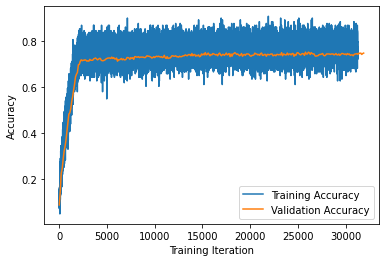

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()